# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/1011rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/1012rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/1013rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/1011rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/1012rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/1013rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.291343        0.207863  0.048928  0.302099  0.019950   
       0.25   0.308718        0.193711  0.056356  0.249541  0.068583   
       0.50   0.308233        0.186568  0.061616  0.217983  0.097360   
       0.75   0.311193        0.186641  0.068531  0.197269  0.122639   
       1.00   0.321075        0.178206  0.079619  0.182288  0.133278   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.206924  0.010339  0.040686  0.049853  0.000000  
       0.25  0.207608  0.010071  0.039083  0.049049  0.000604  
       0.50  0.199143  0.009149  0.040052  0.046966  0.001534  
       0.75  0.204462  0.008039  0.038622  0.047867  0.002489  
       1.00  0.202481  0.006871  0.037479  0.048921  0.003725

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.305836        0.196759  0.050731  0.286435  0.020061   
       0.25   0.303703        0.202089  0.052885  0.255465  0.066426   
       0.50   0.311793        0.184340  0.061887  0.222849  0.098346   
       0.75   0.313444        0.187381  0.068866  0.190506  0.121461   
       1.00   0.318975        0.171801  0.076788  0.179830  0.133764   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.211093  0.009628  0.039375  0.047187  0.000000  
       0.25  0.199800  0.010320  0.038834  0.049022  0.000585  
       0.50  0.204837  0.009524  0.039356  0.049259  0.001450  
       0.75  0.206179  0.007658  0.037844  0.049887  0.002516  
       1.00  0.197891  0.006408  0.036259  0.049699  0.003649

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.295093        0.200419  0.050812  0.296802  0.019824   
       0.25   0.301041        0.190968  0.052564  0.248719  0.066876   
       0.50   0.312800        0.182655  0.063394  0.217174  0.100548   
       0.75   0.295345        0.188301  0.068033  0.202694  0.121627   
       1.00   0.303952        0.174693  0.076626  0.184061  0.136636   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.199706  0.010179  0.039041  0.053527  0.000000  
       0.25  0.211524  0.009714  0.039847  0.051595  0.000574  
       0.50  0.198104  0.009118  0.039831  0.049425  0.001507  
       0.75  0.215421  0.008061  0.038921  0.050256  0.002521  
       1.00  0.208213  0.006746  0.038622  0.048893  0.003674

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.297424        0.201680  0.050157  0.295112  0.019945   
         0.25   0.300192        0.194677  0.056548  0.250207  0.068294   
         0.50   0.299105        0.183105  0.069053  0.217981  0.100099   
         0.75   0.286732        0.185485  0.079197  0.195711  0.123435   
         1.00   0.285431        0.172543  0.091509  0.182604  0.136342   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.205907  0.010049  0.039701  0.050189  0.000000  
         0.25  0.206308  0.010039  0.039255  0.050087  0.000387  
         0.50  0.200683  0.009286  0.039745  0.049050  0.000989  
         0.75  0.208653  0.007979  0.038452  0.050208  0.001664  
         1.00  0.202782  0.006795  0.037419  0.050439  0.002452

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.895904e+01  4.006396e+01      37.084890  5.668387e+01   
         0.25  4.619542e+06  2.317008e+06  216095.640266  1.398457e+06   
         0.50  5.512627e+06  3.556799e+06  338556.940696  2.153234e+06   
         0.75  5.929421e+06  4.100638e+06  420146.407102  2.663142e+06   
         1.00  5.939704e+06  4.650100e+06  473950.002116  3.042015e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.526675  5.609052e+01  5.574226e+01      18.547885   
         0.25  473321.903047  2.255882e+06  2.681733e+06  434755.011449   
         0.50  734947.430038  3.745038e+06  3.244573e+06  640441.426523   
         0.75  898718.909951  4.746496e+06  3.532781e+06  777475.366456   
         1.00  975300.065584  5.461227e+06  3.825207e+06  842669.442039   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.455648  
         0.25     180672.234252  
         0.50     287738.019576  
         0.75     364499.225807  
         1.00     398095.750592

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


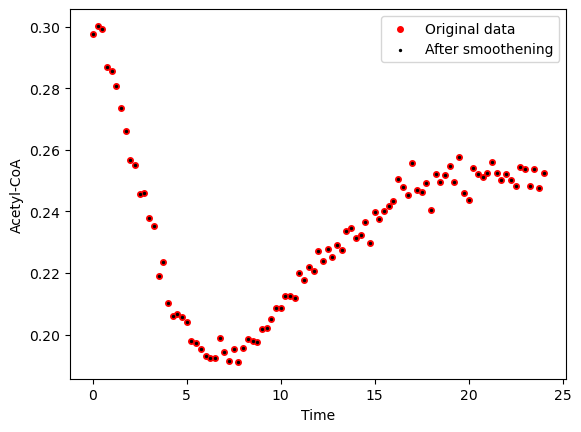

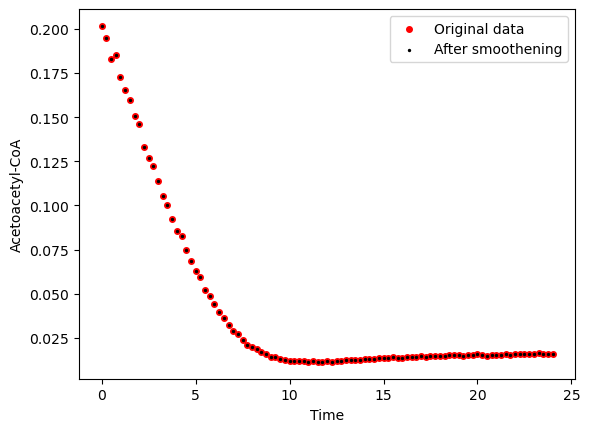

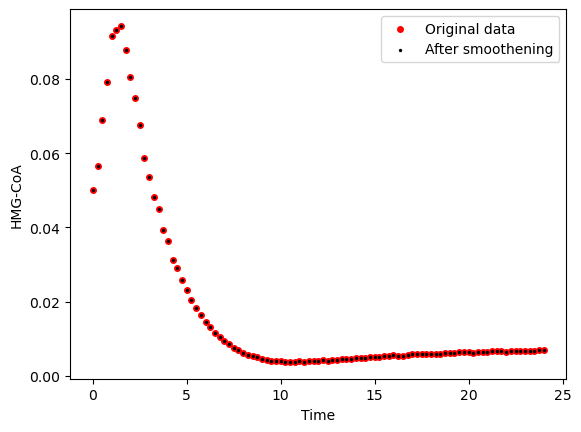

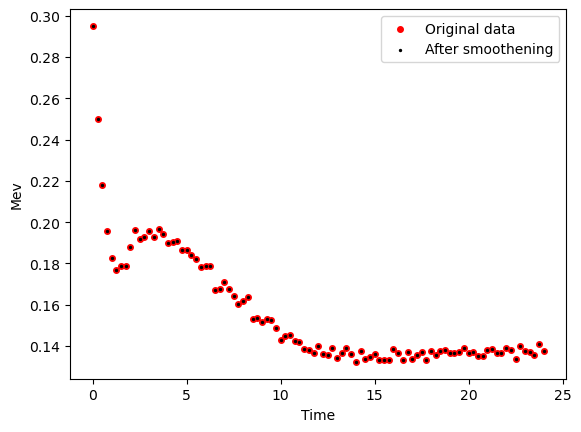

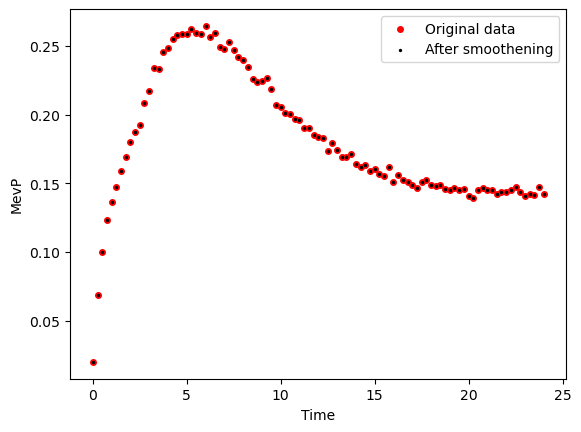

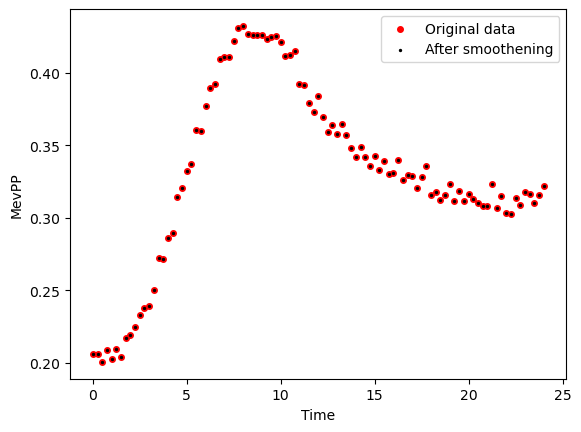

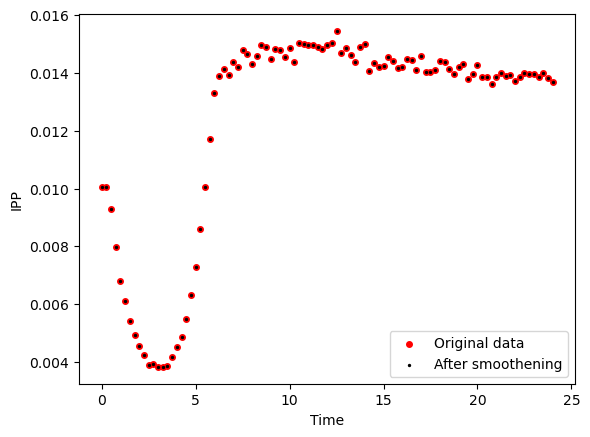

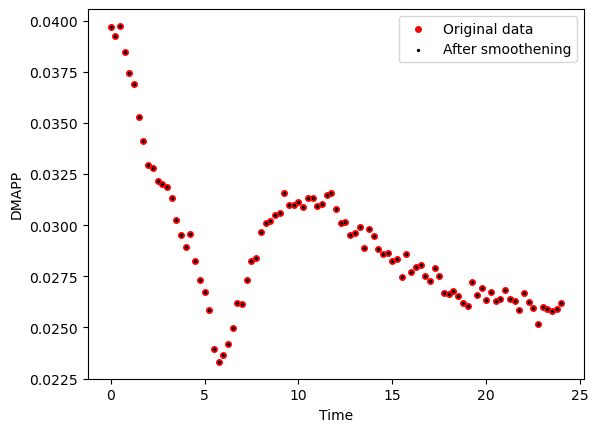

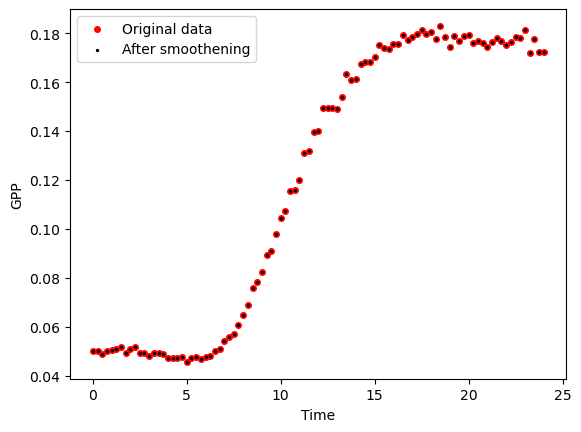

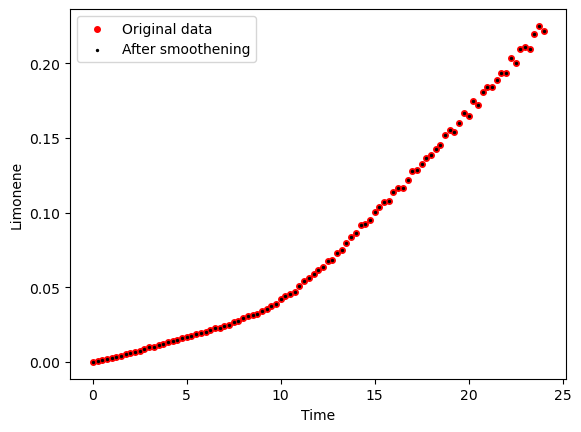

Strain Strain 2


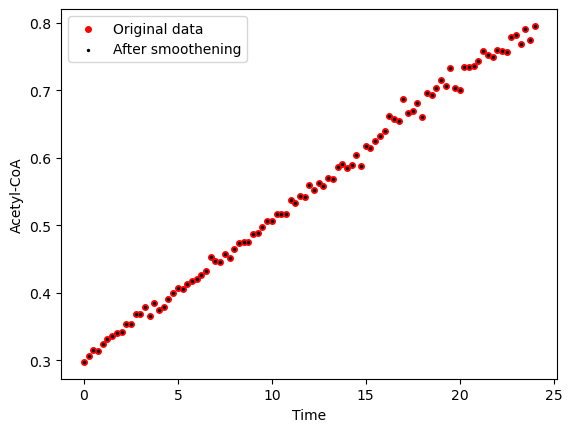

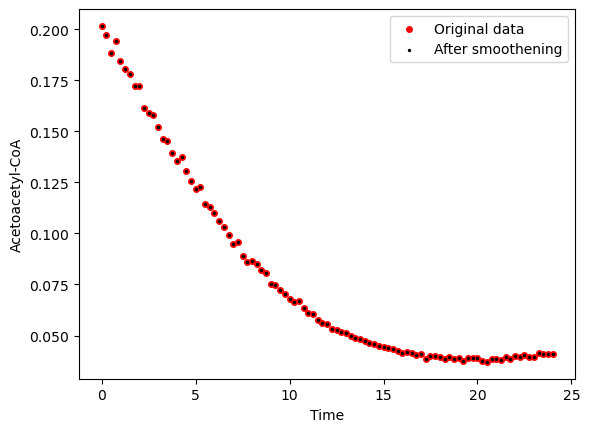

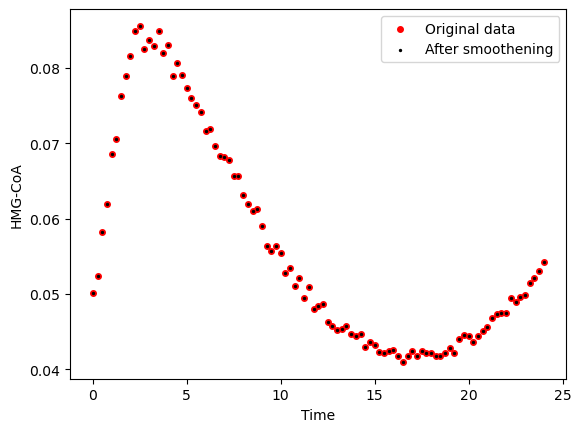

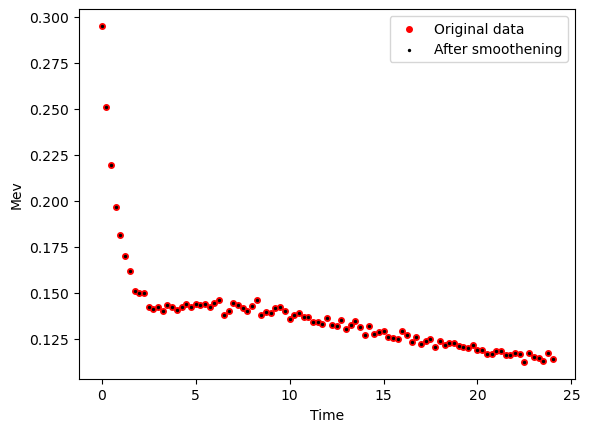

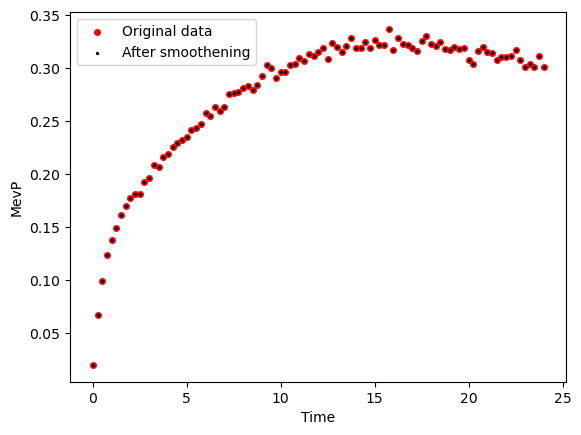

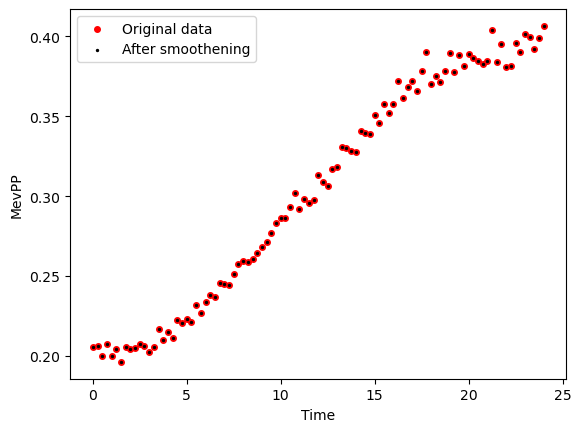

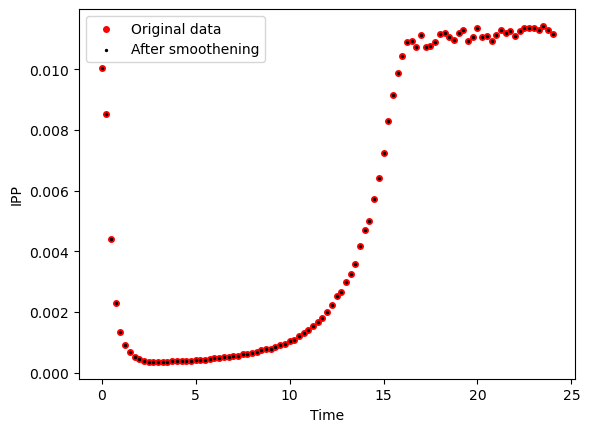

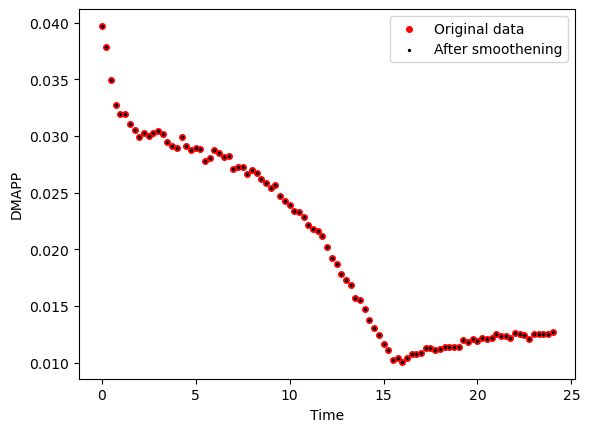

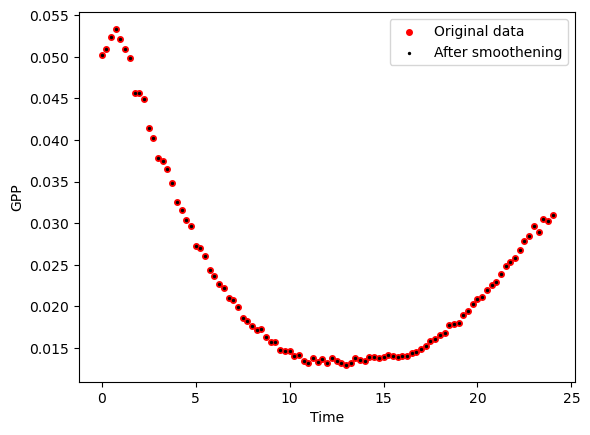

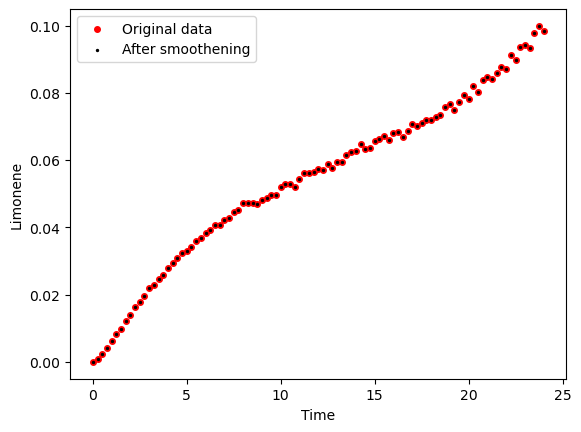

Strain Strain 3


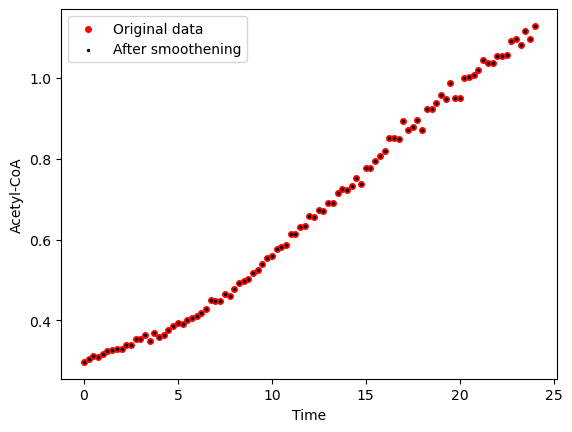

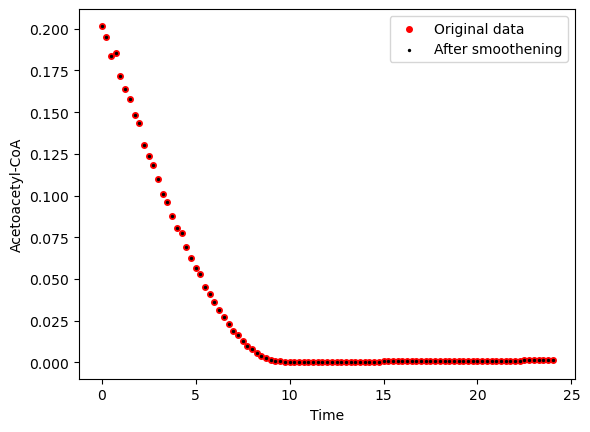

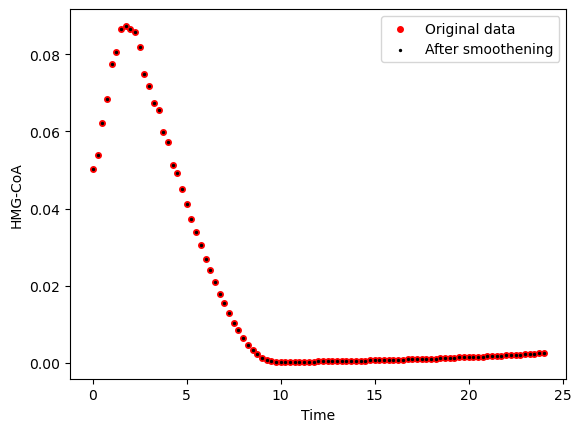

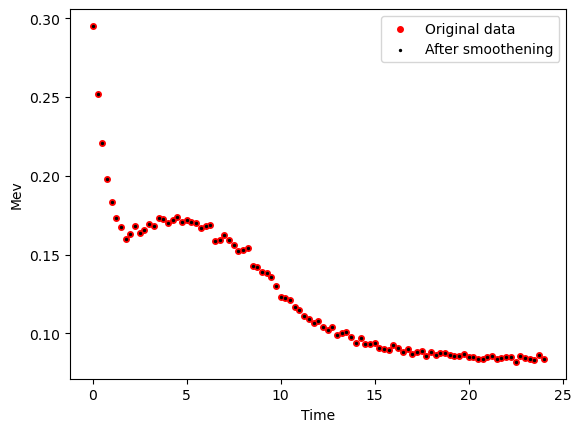

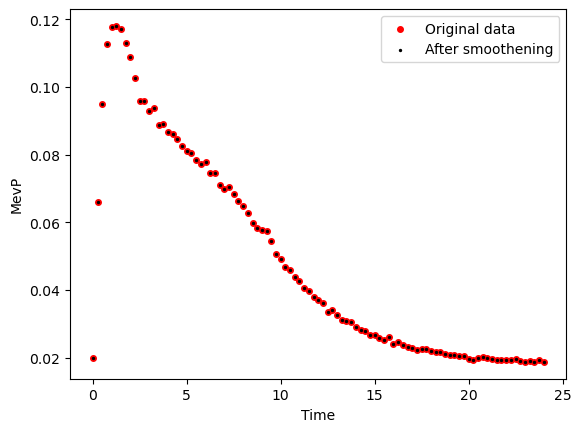

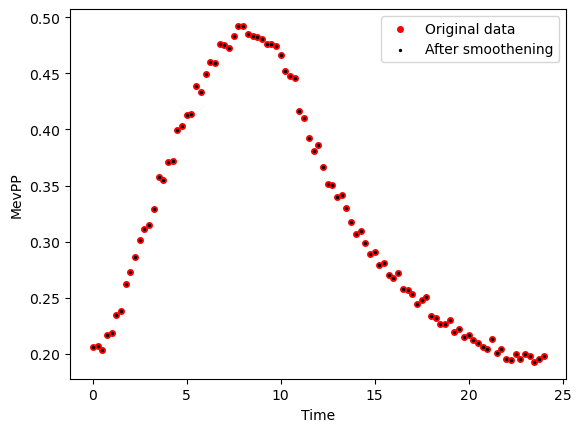

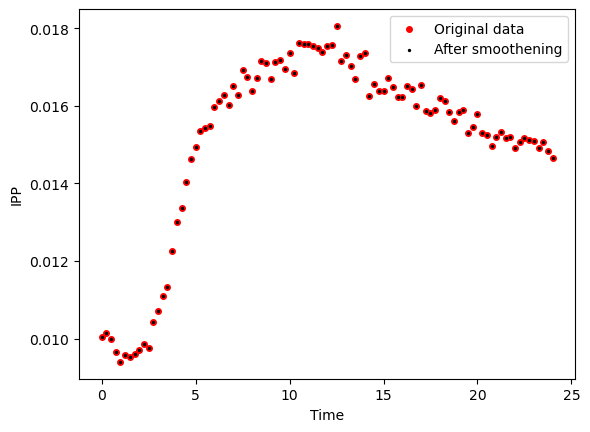

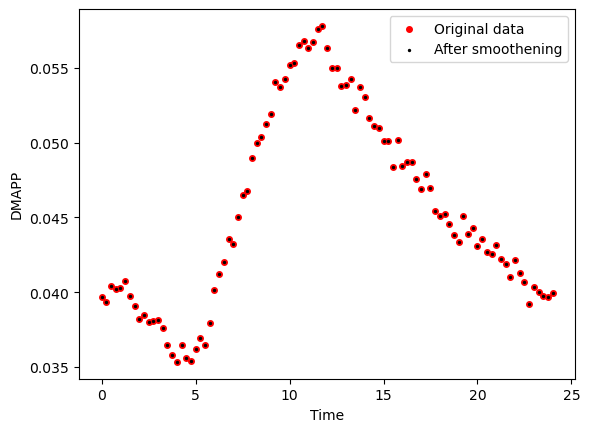

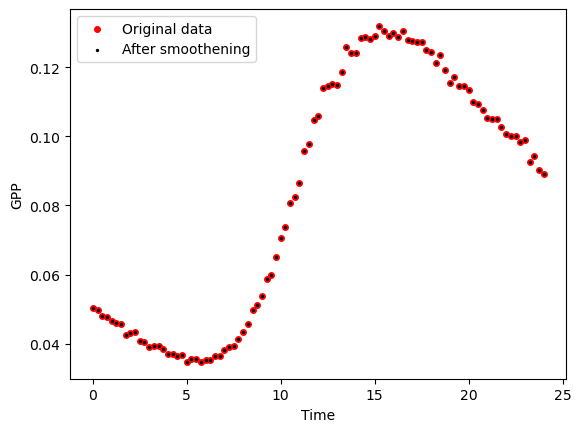

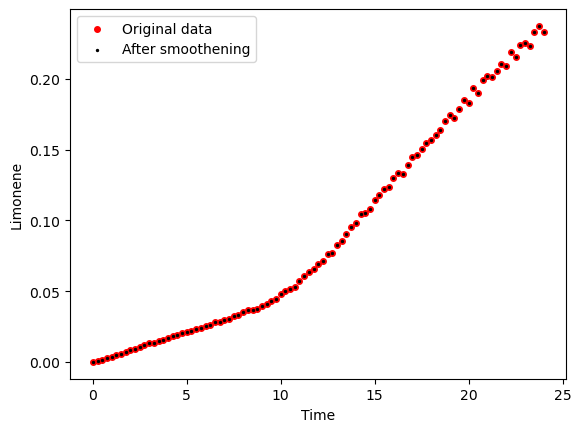

Strain WT


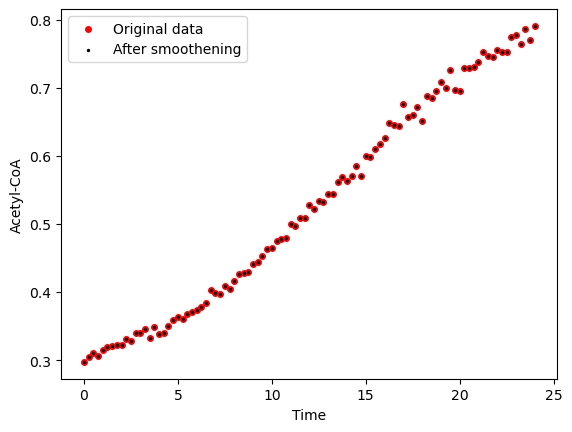

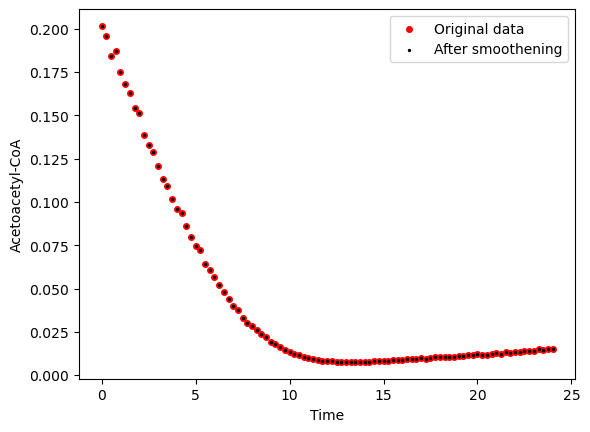

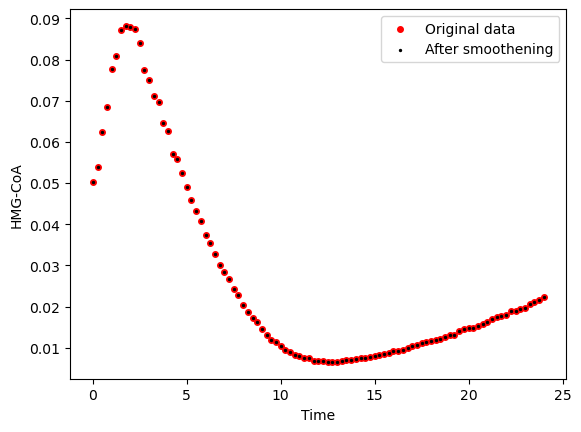

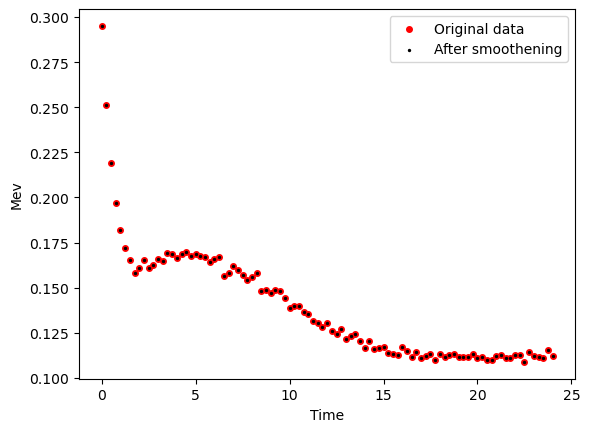

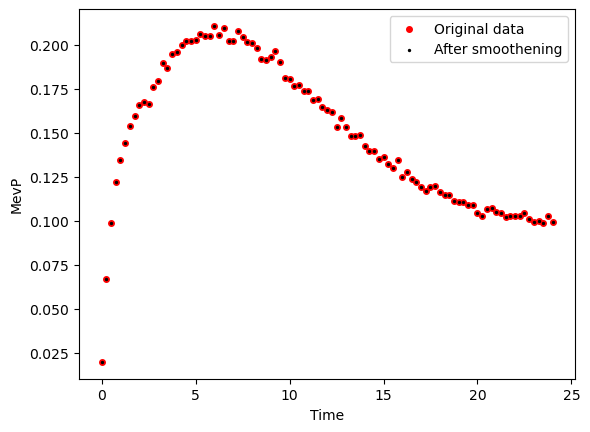

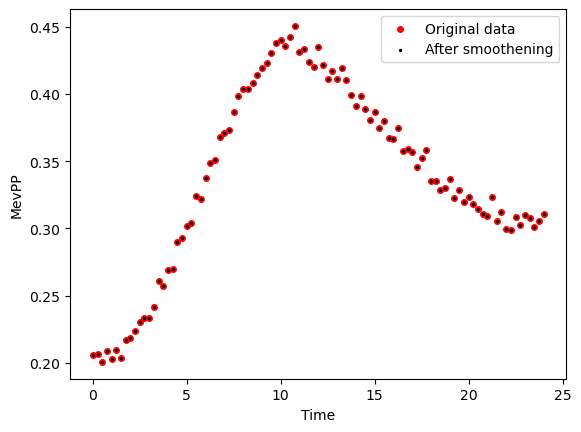

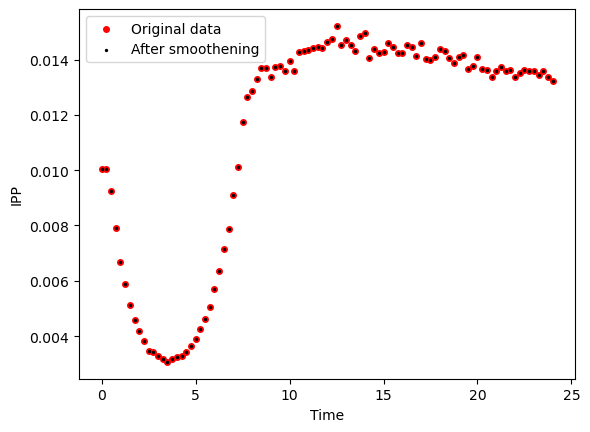

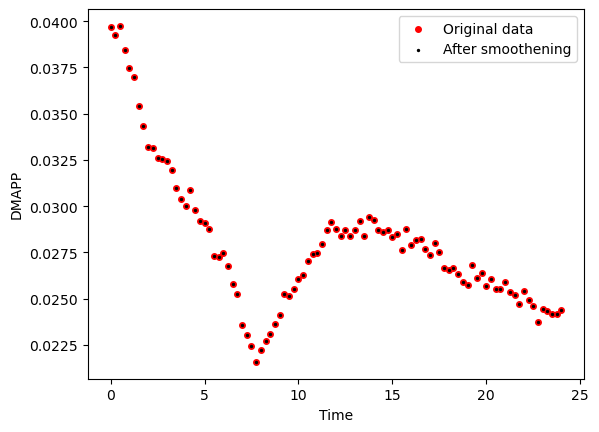

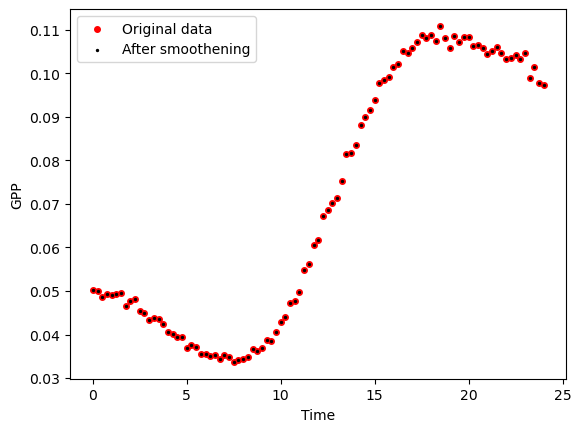

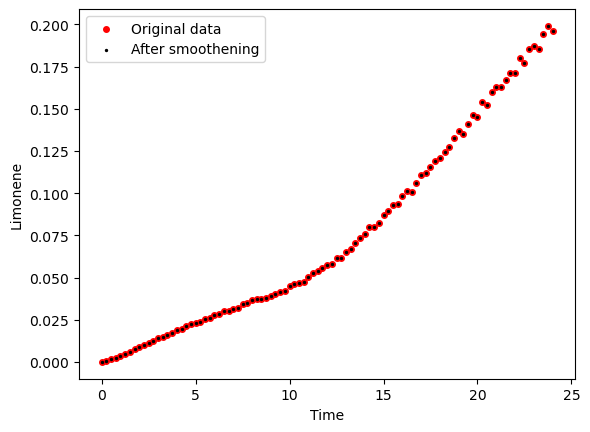

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


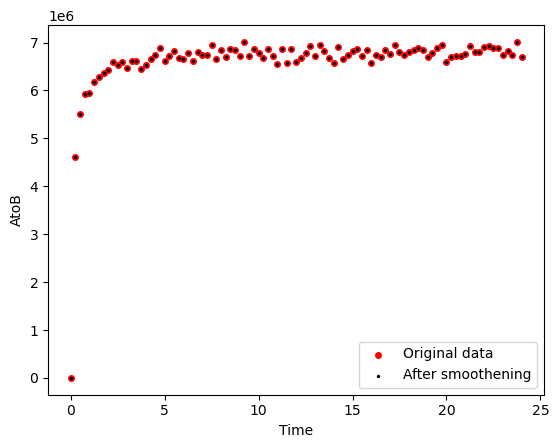

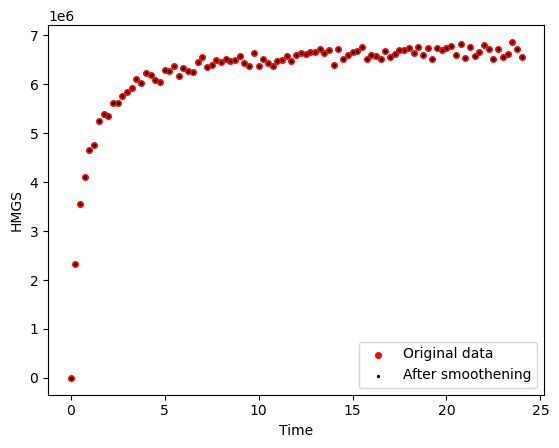

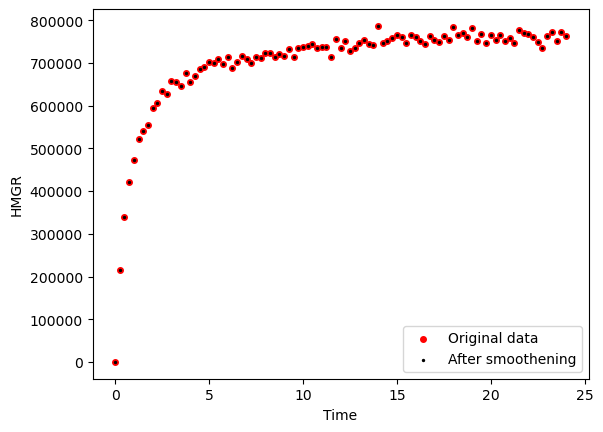

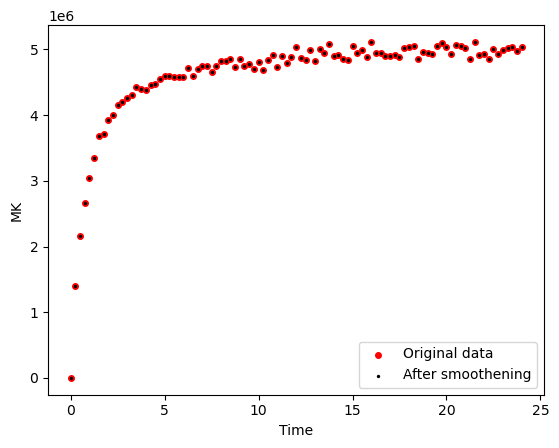

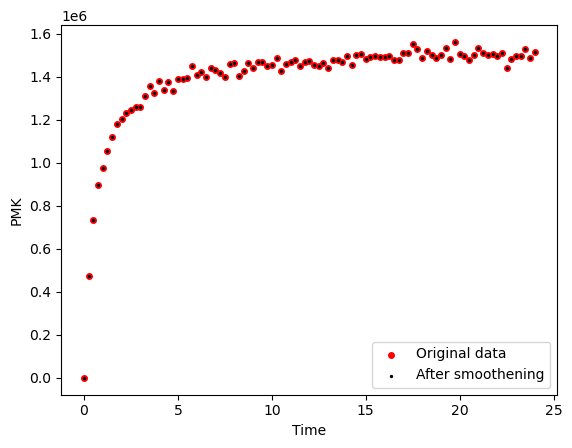

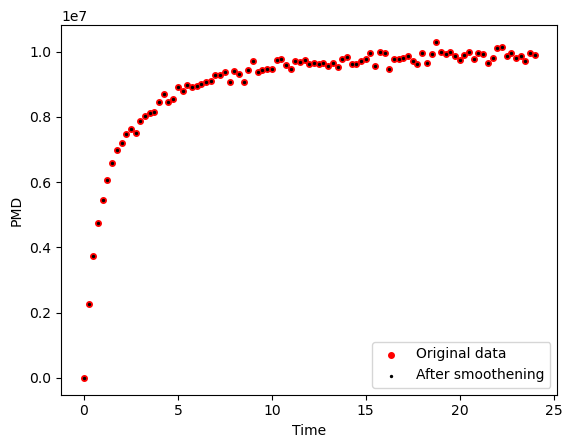

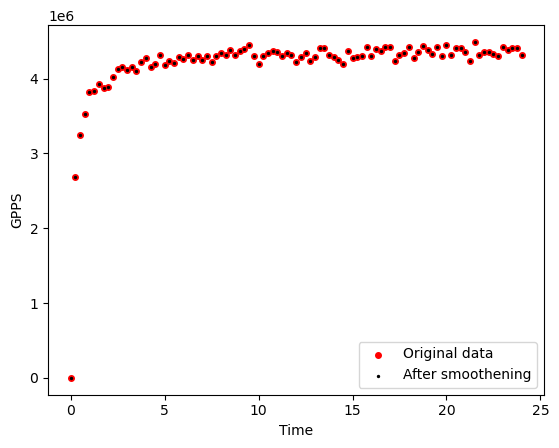

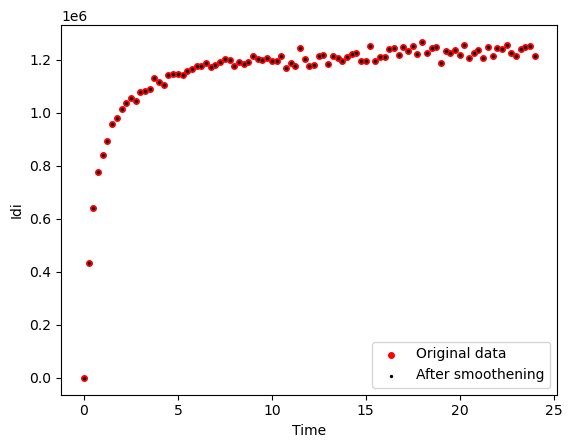

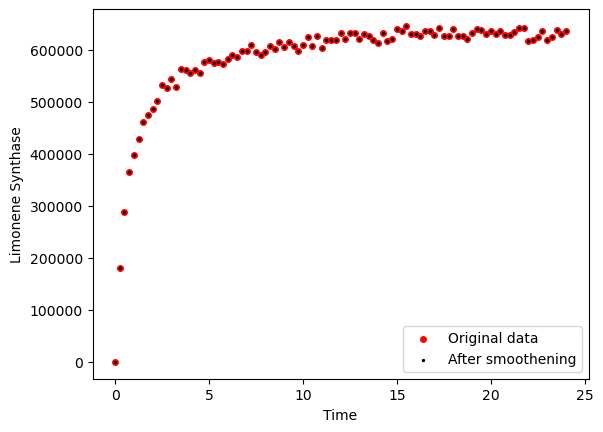

Strain Strain 2


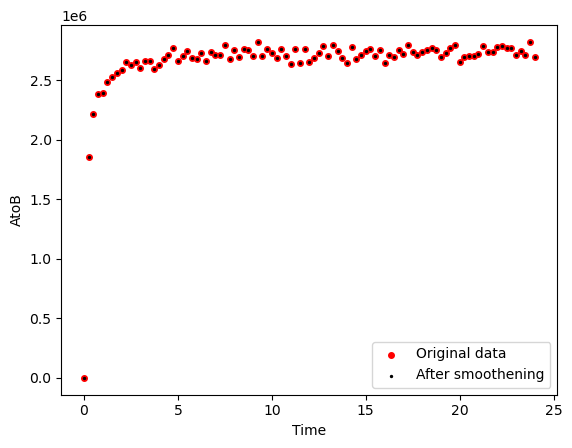

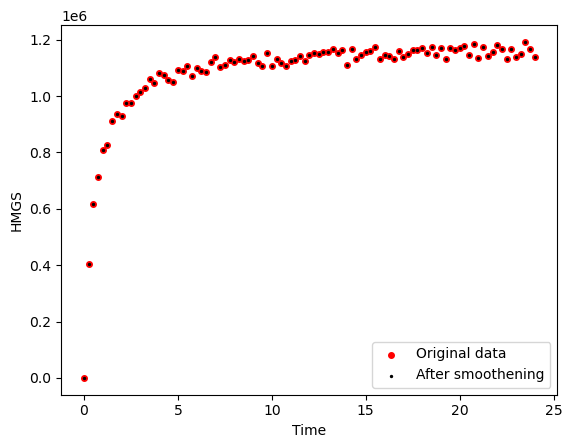

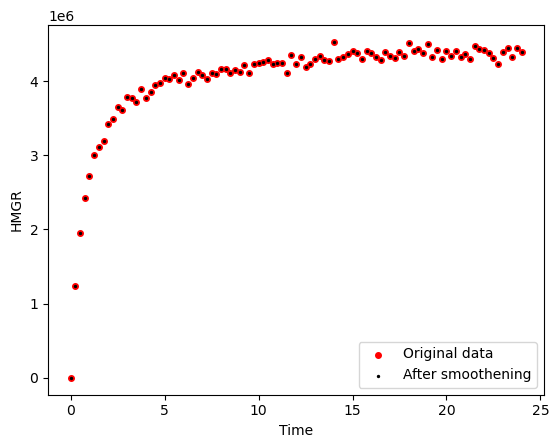

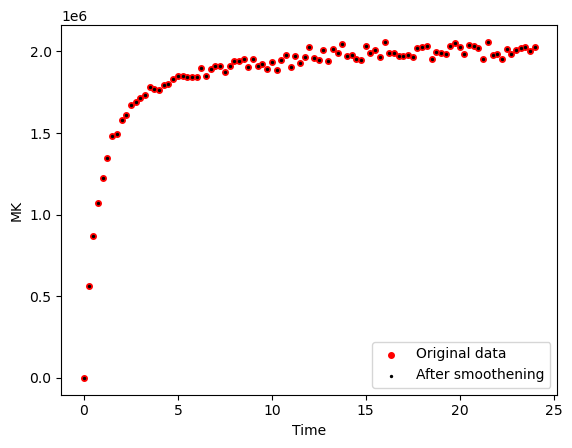

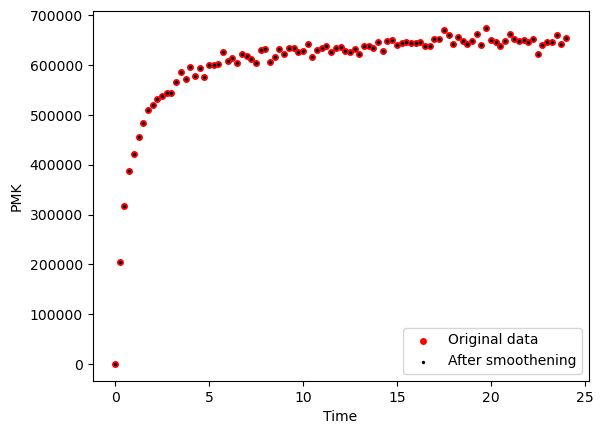

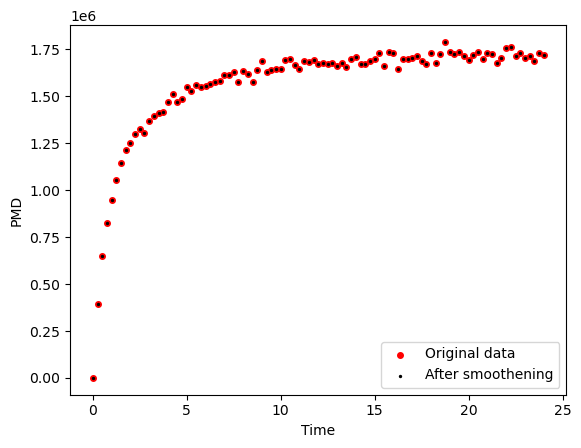

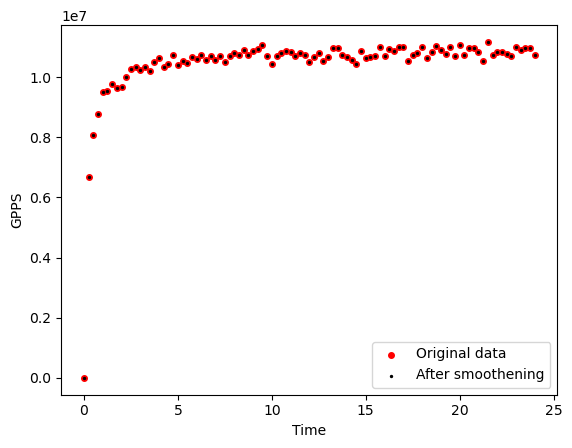

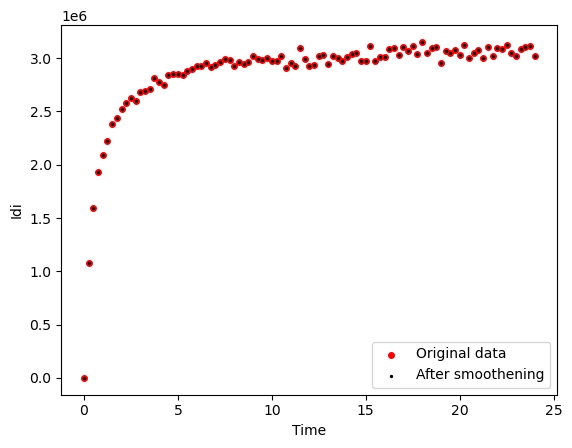

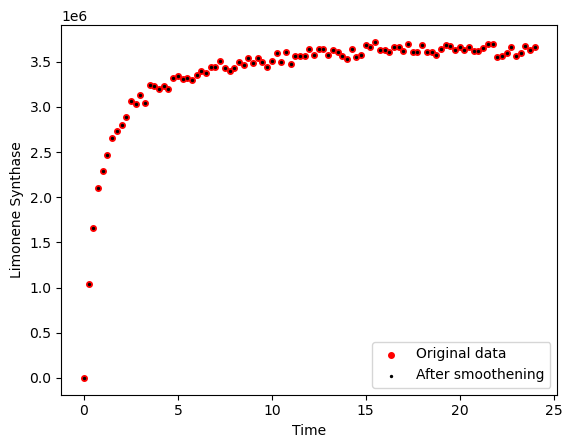

Strain Strain 3


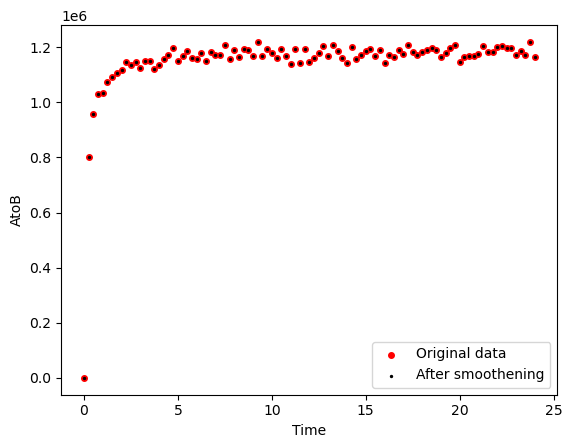

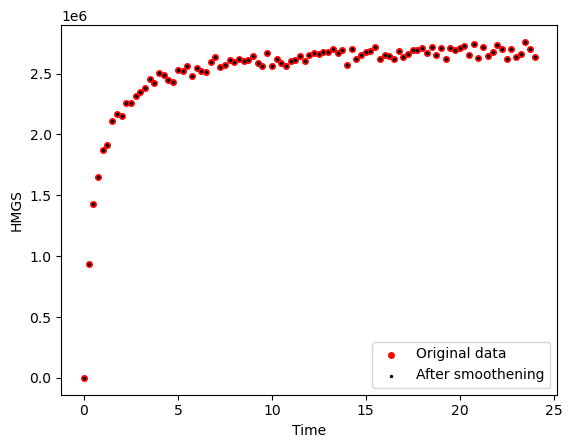

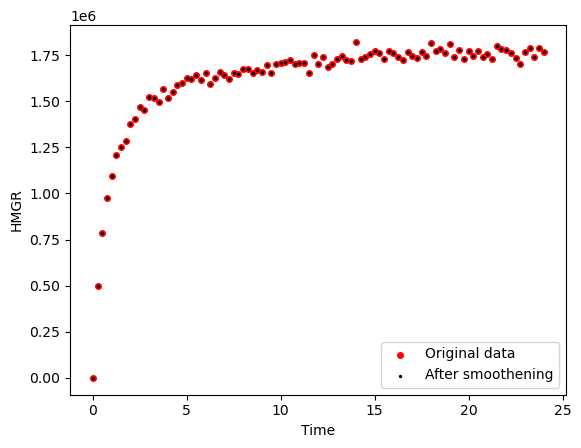

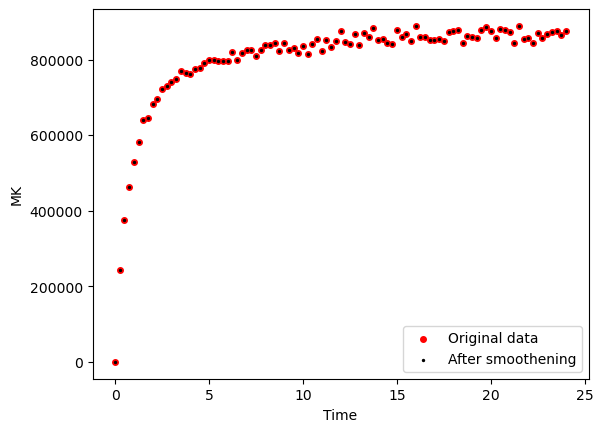

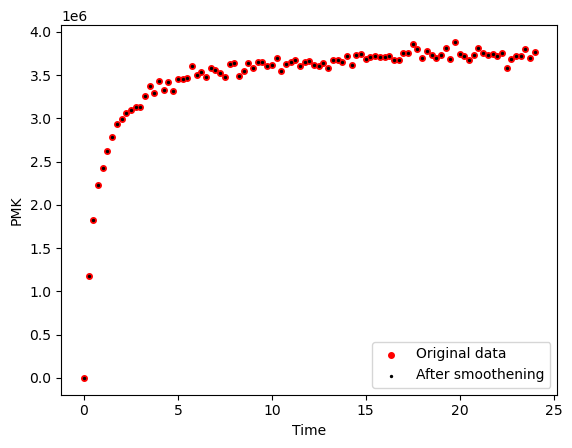

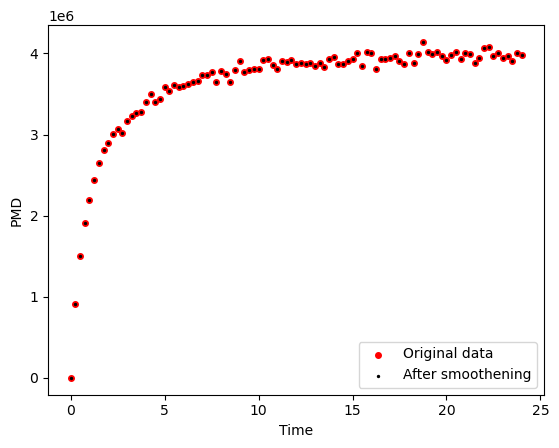

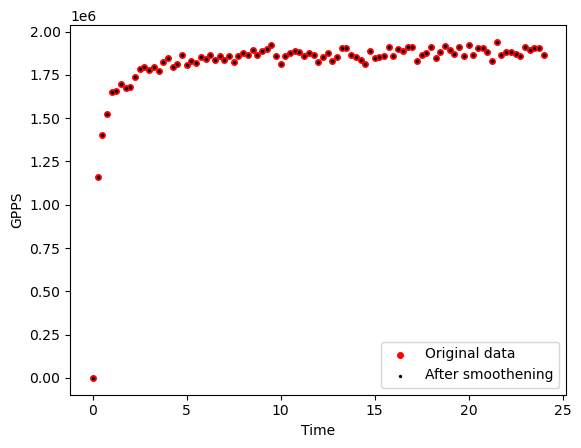

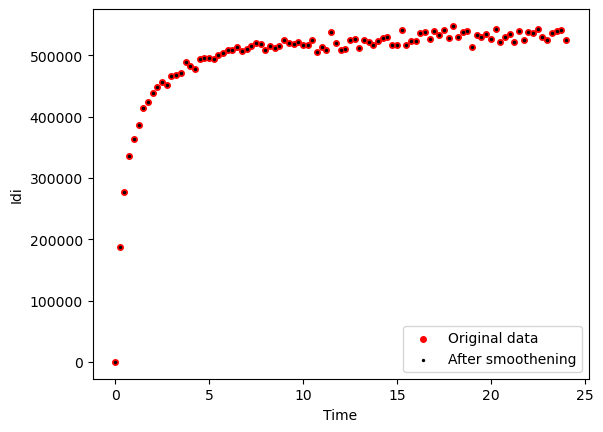

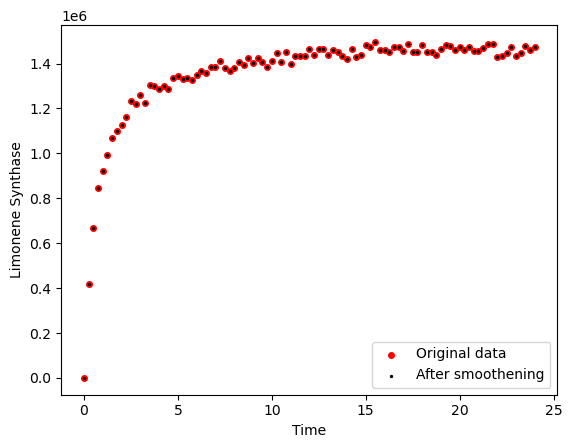

Strain WT


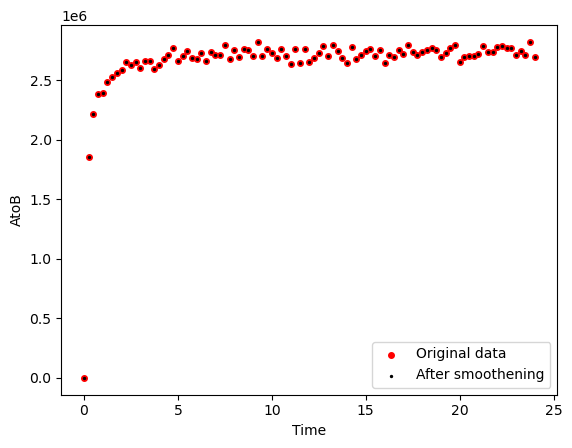

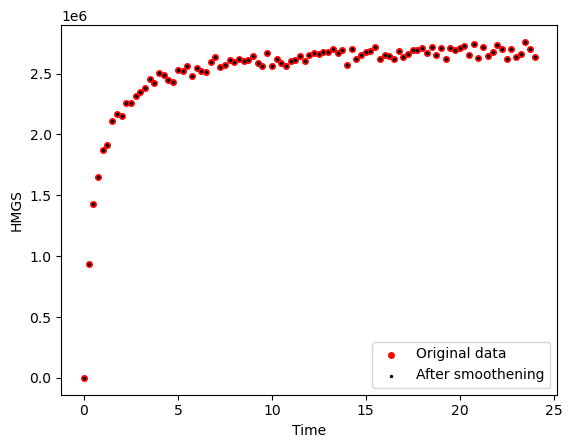

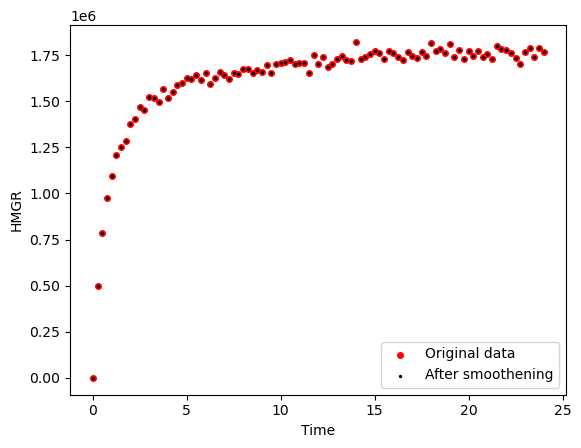

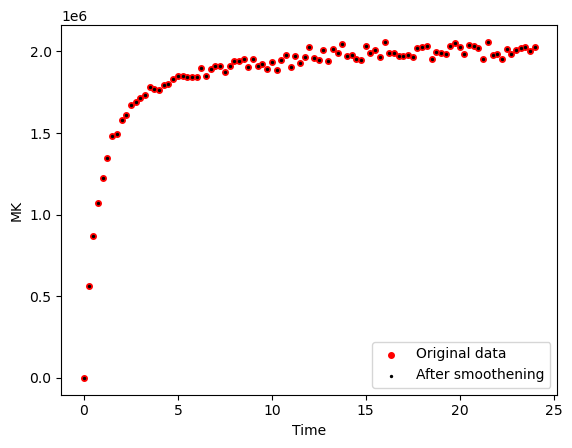

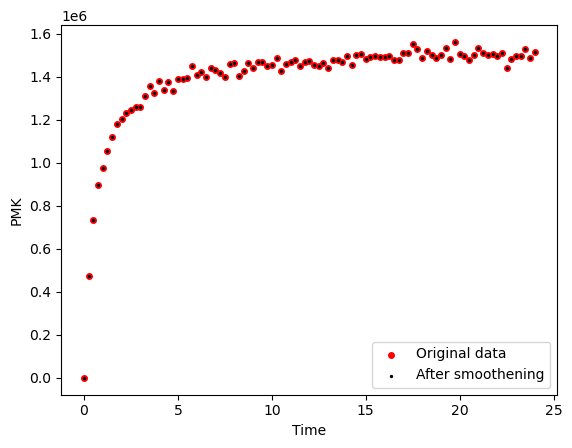

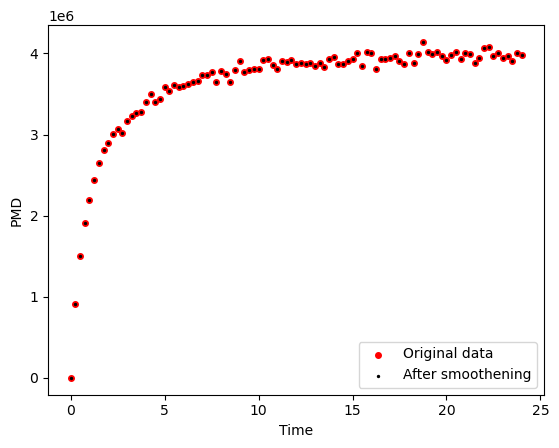

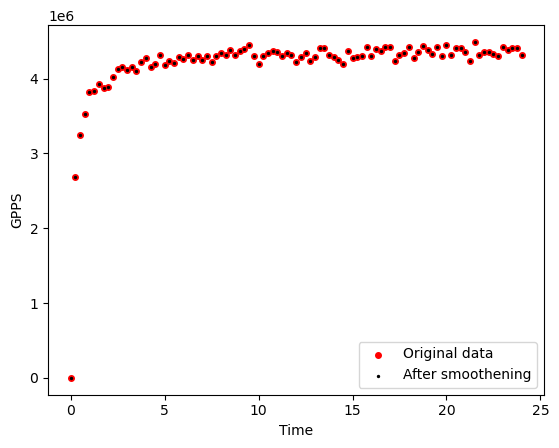

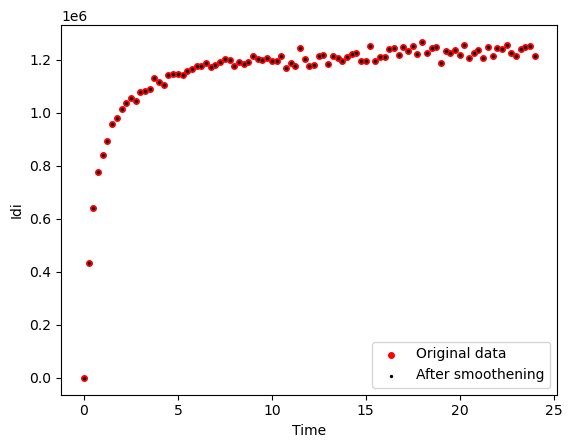

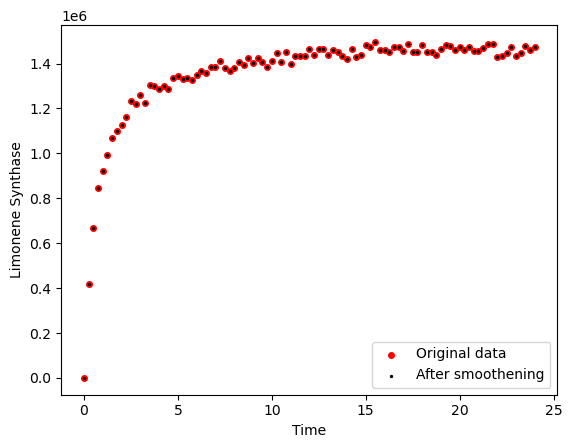

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.297424        0.201680  0.050157  0.295112  0.019945   
         0.25    0.300192        0.194677  0.056548  0.250207  0.068294   
         0.50    0.299105        0.183105  0.069053  0.217981  0.100099   
         0.75    0.286732        0.185485  0.079197  0.195711  0.123435   
         1.00    0.285431        0.172543  0.091509  0.182604  0.136342   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.776930        0.013964  0.019737  0.112279  0.099257   
         23.25   0.763973        0.014793  0.020571  0.111720  0.099873   
         23.50   0.785629        0.014680  0.021069  0.110822  0.099085   
         23.75   0.770307        0.014771  0.021598  0.115347  0.102618   
         24.00   0.790581        0.014852  0.022301  0.112320  0.099119   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205907  0.010049  0.039701  0.050189  0.000000  ...   
         0.25   0.206308  0.010039  0.039255  0.050087  0.000387  ...   
         0.50   0.200683  0.009286  0.039745  0.049050  0.000989  ...   
         0.75   0.208653  0.007979  0.038452  0.050208  0.001664  ...   
         1.00   0.202782  0.006795  0.037419  0.050439  0.002452  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.310161  0.013573  0.024459  0.104682  0.187074  ...   
         23.25  0.307878  0.013429  0.024304  0.098845  0.185658  ...   
         23.50  0.301128  0.013576  0.024158  0.101544  0.194620  ...   
         23.75  0.305593  0.013375  0.024159  0.097823  0.199137  ...   
         24.00  0.310657  0.013222  0.024357  0.097198  0.196018  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.007219       -0.029358  0.031305 -0.195864  0.205861   
         0.25    -0.003880       -0.028173  0.036723 -0.153834  0.160517   
         0.50    -0.014979       -0.026987  0.042141 -0.111805  0.115174   
         0.75    -0.021182       -0.027670  0.038366 -0.072696  0.077477   
         1.00    -0.022935       -0.026846  0.025788 -0.038885  0.056447   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.022720        0.000965  0.002146  0.000695 -0.004907   
         23.25    0.000102        0.001073  0.002277  0.000437  0.000958   
         23.50    0.013455        0.000702  0.002462  0.001484  0.000988   
         23.75    0.030303       -0.000038  0.002331  0.001762 -0.001246   
         24.00    0.047151       -0.000777  0.002199  0.002040 -0.003479   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.002765 -0.000110  0.001233 -0.003019  0.001473  
         0.25  -0.002163 -0.001768 -0.000456 -0.001385  0.001972  
         0.50  -0.001562 -0.003427 -0.002146  0.000249  0.002472  
         0.75   0.003368 -0.004149 -0.002793  0.001312  0.002937  
         1.00   0.002859 -0.003838 -0.004189  0.002544  0.003087  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003786 -0.000115 -0.000130 -0.003994  0.013848  
         23.25 -0.001295 -0.000172  0.000202 -0.005690  0.013932  
         23.50 -0.000517 -0.000303 -0.000140 -0.006397  0.012547  
         23.75  0.014288 -0.000511  0.000349 -0.004109  0.008059  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

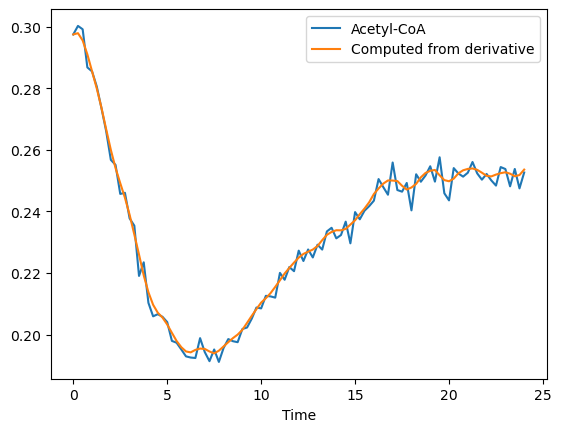

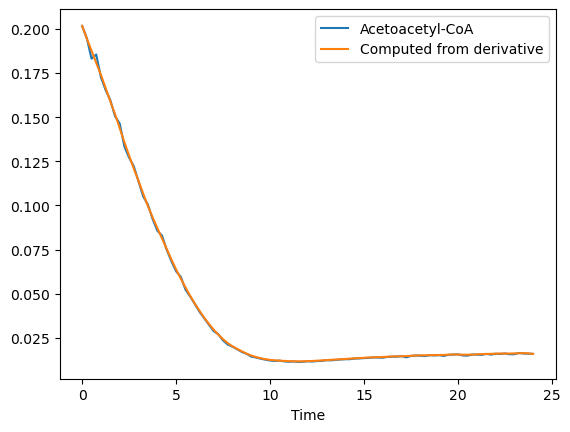

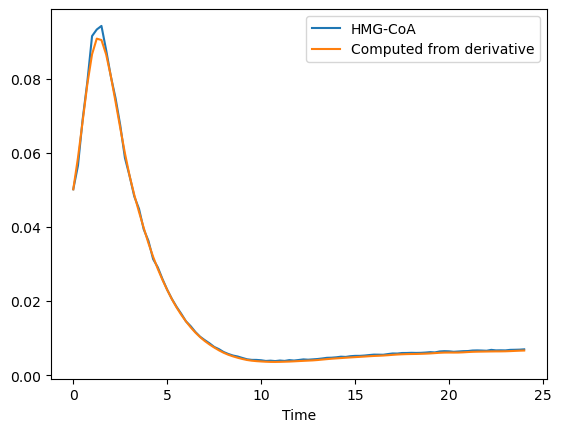

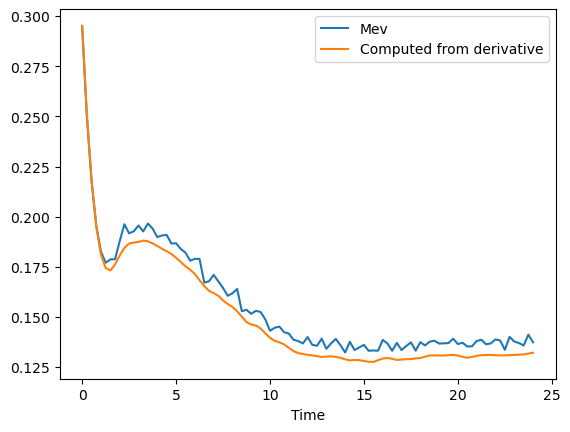

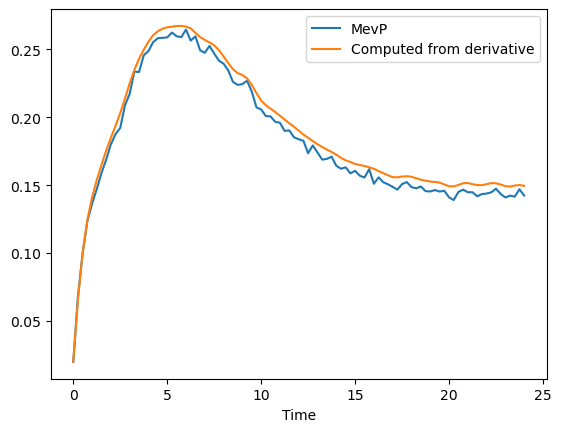

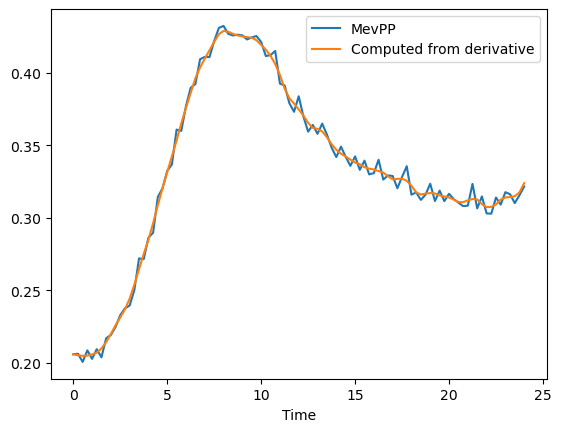

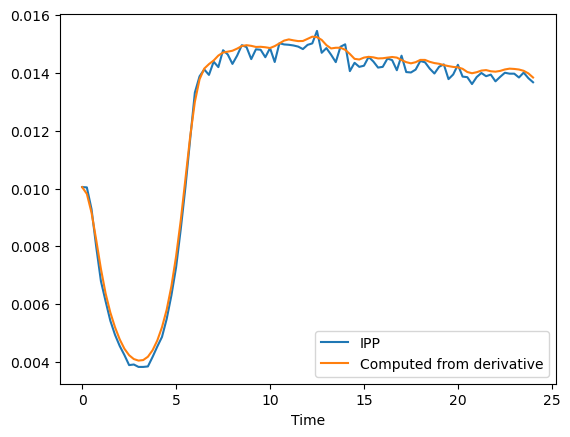

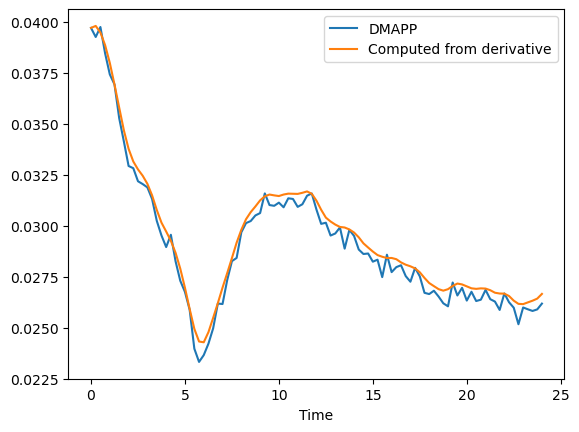

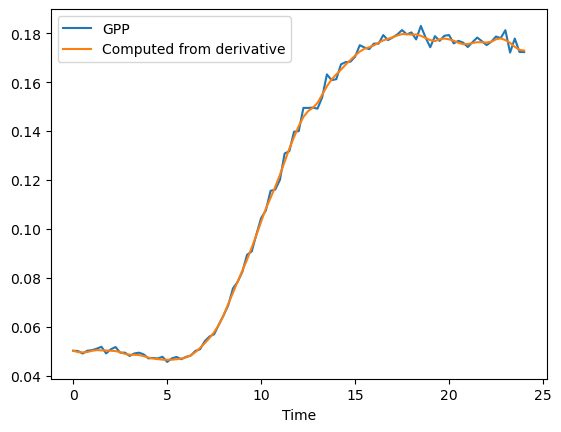

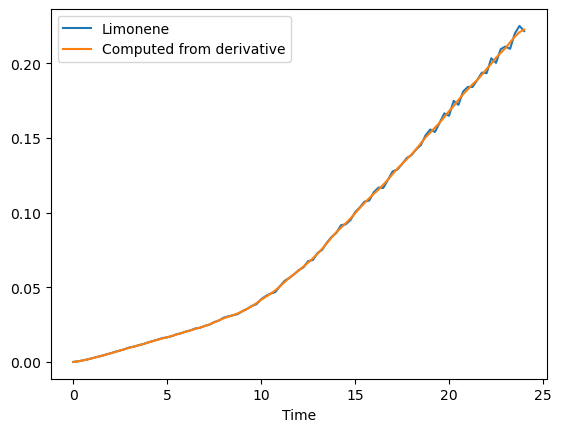

'Time profile from derivative vs. actual profile for Strain 2'

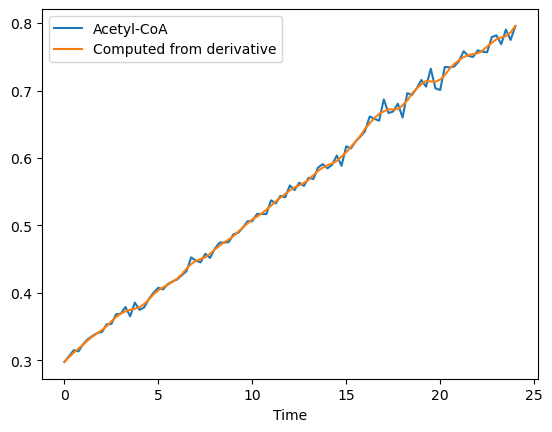

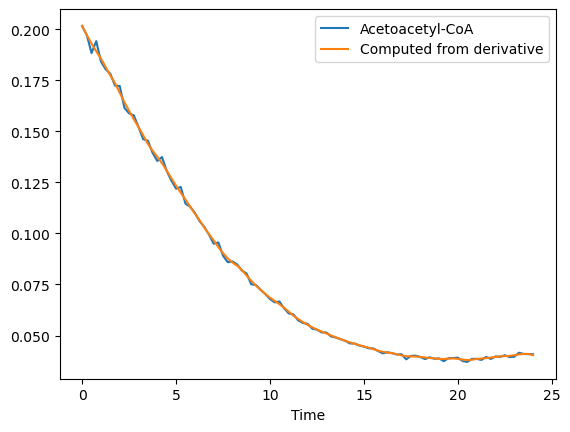

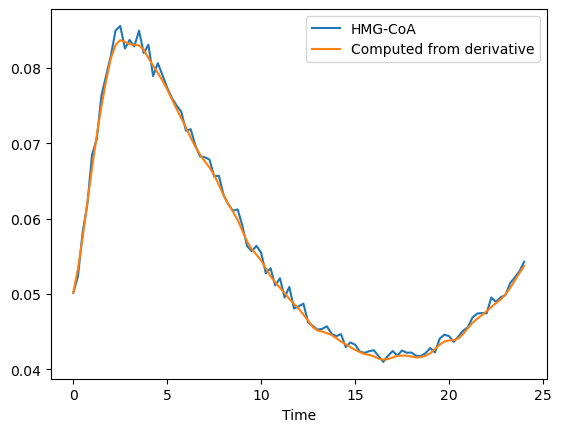

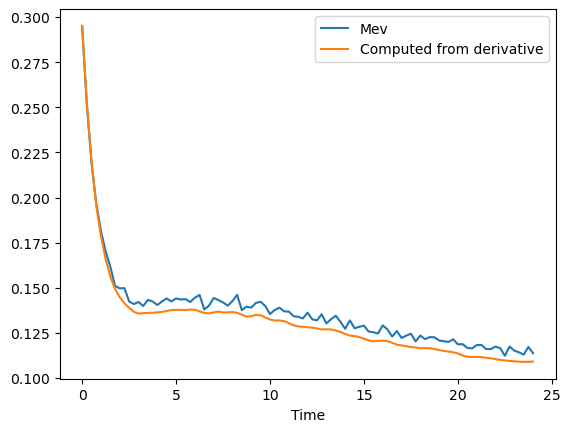

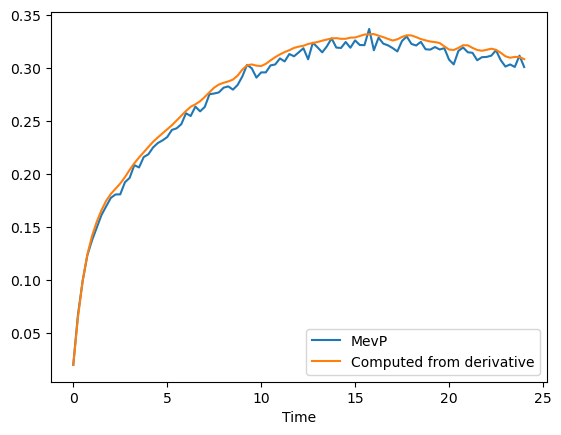

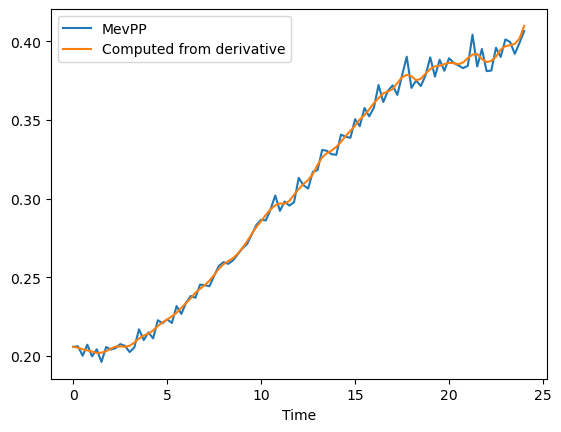

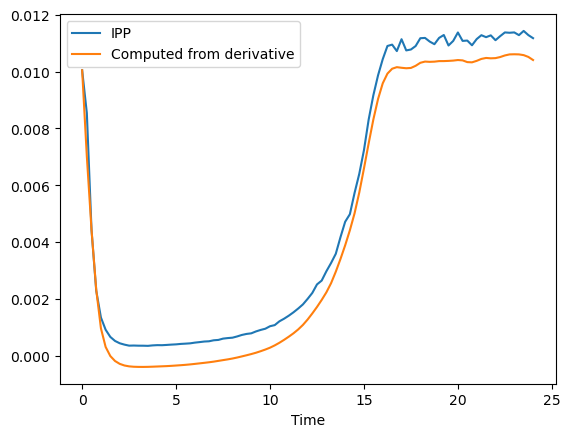

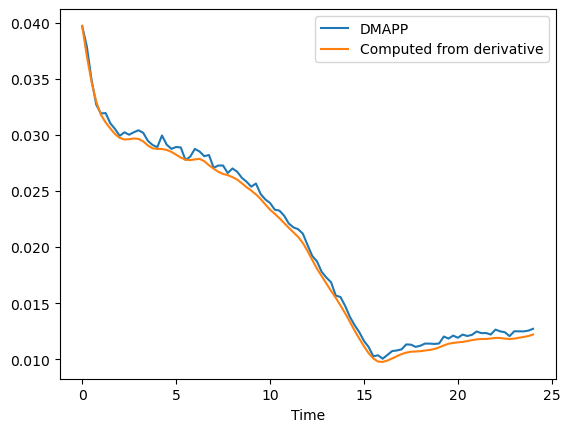

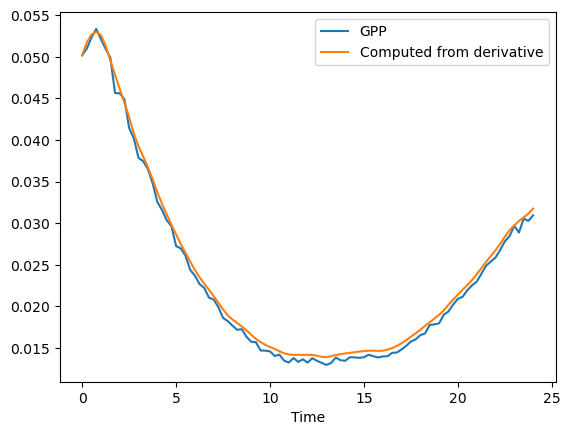

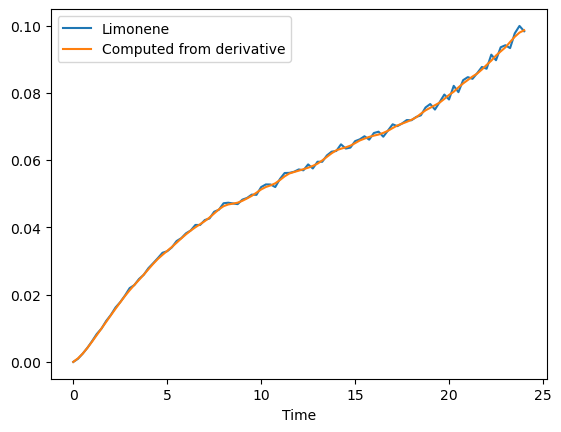

'Time profile from derivative vs. actual profile for Strain 3'

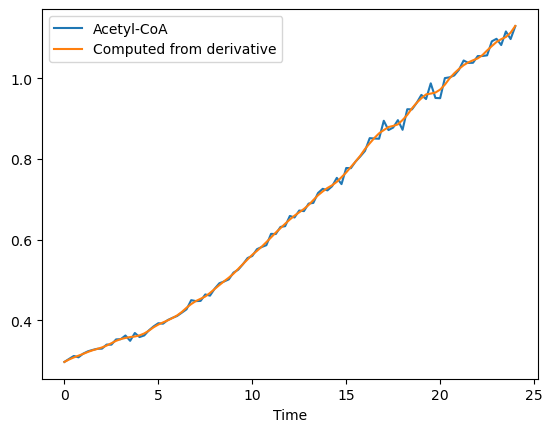

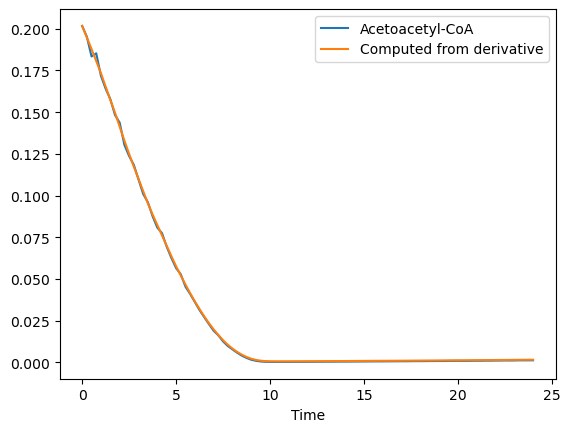

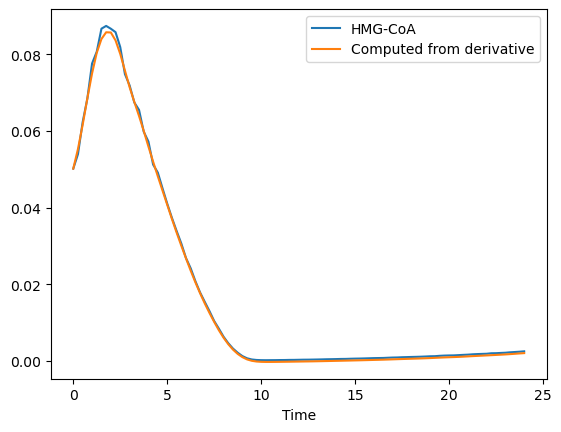

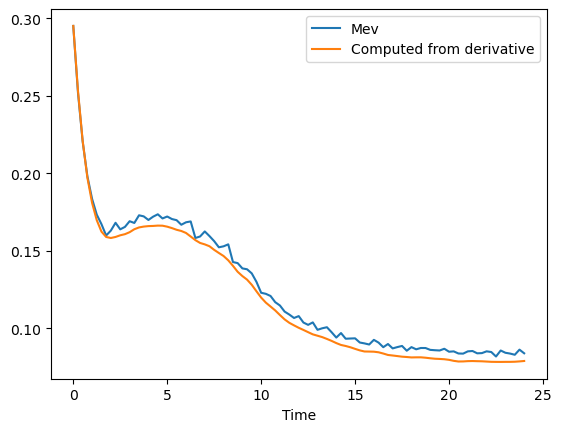

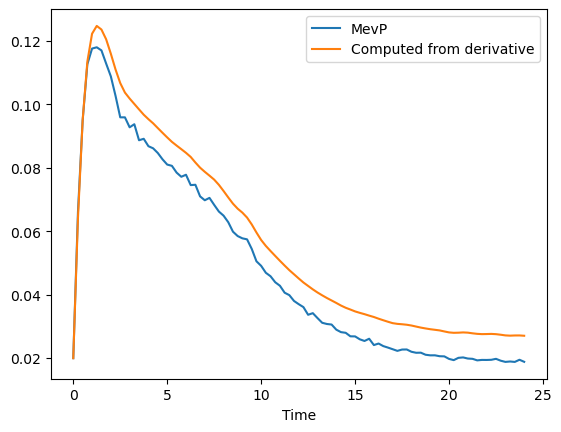

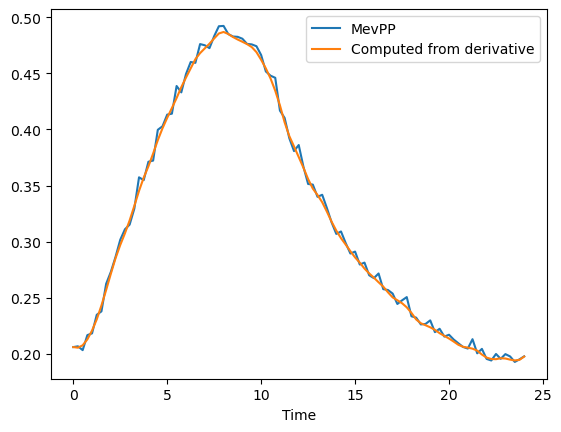

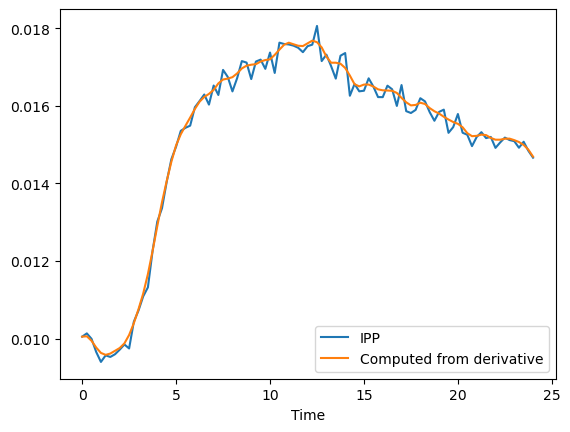

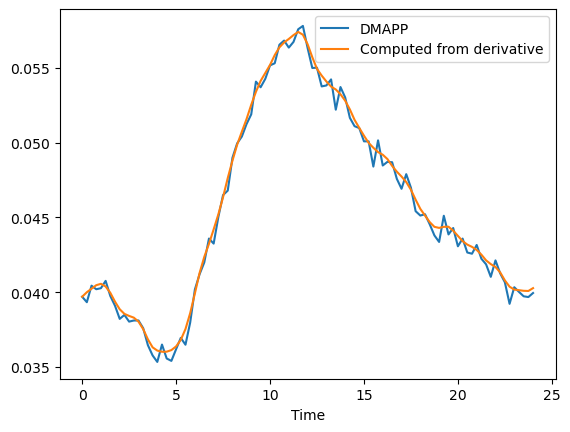

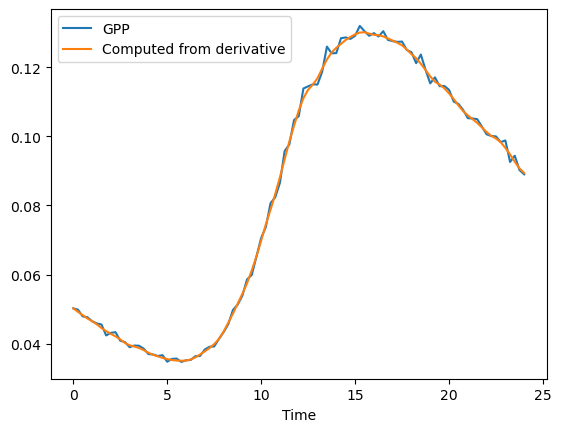

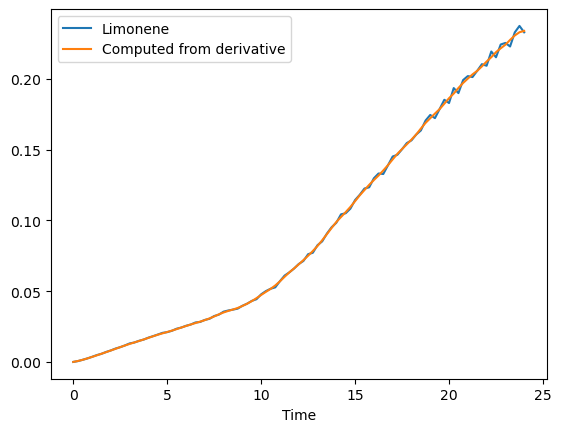

'Time profile from derivative vs. actual profile for WT'

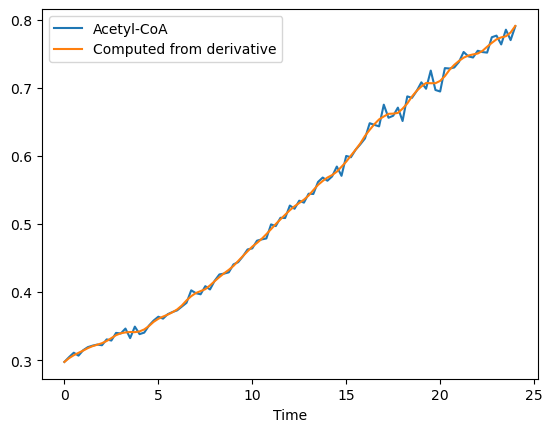

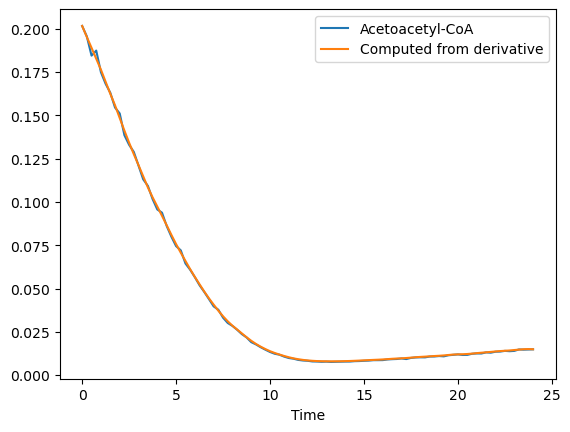

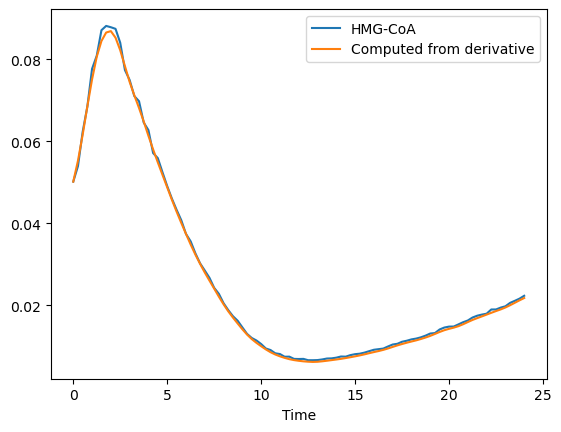

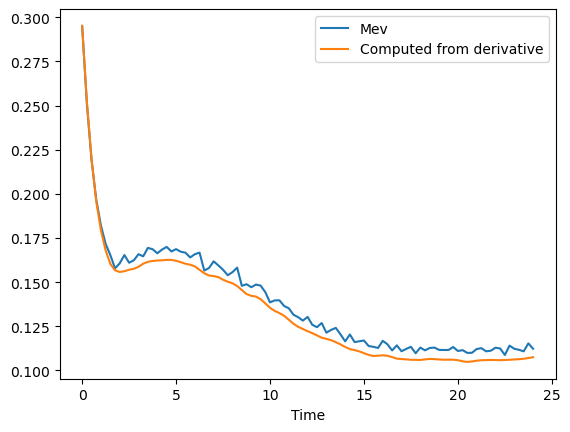

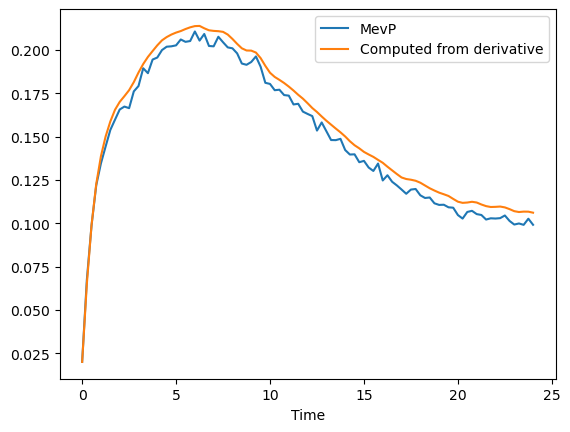

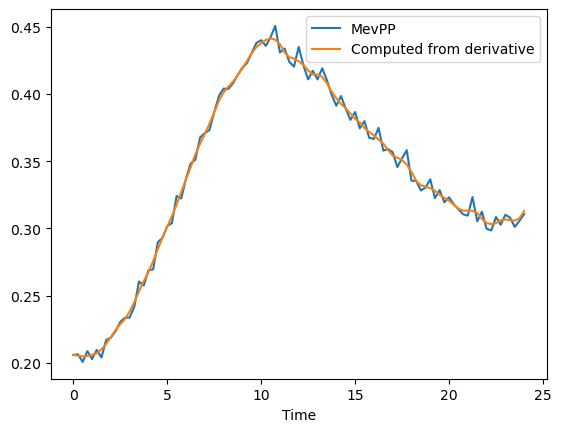

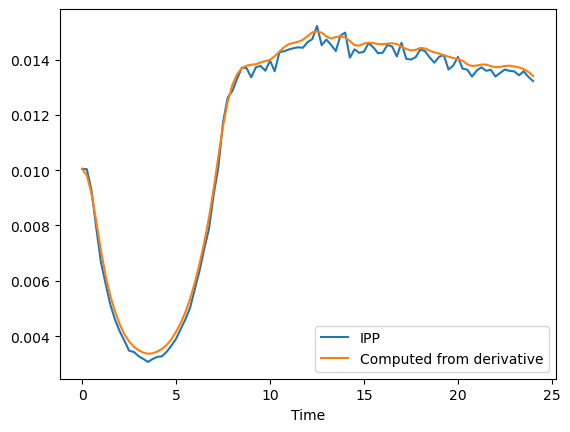

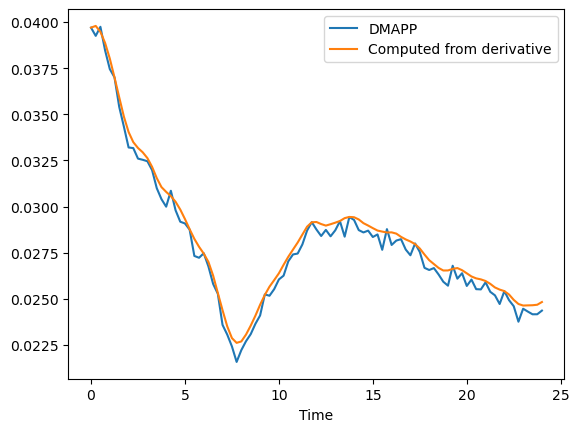

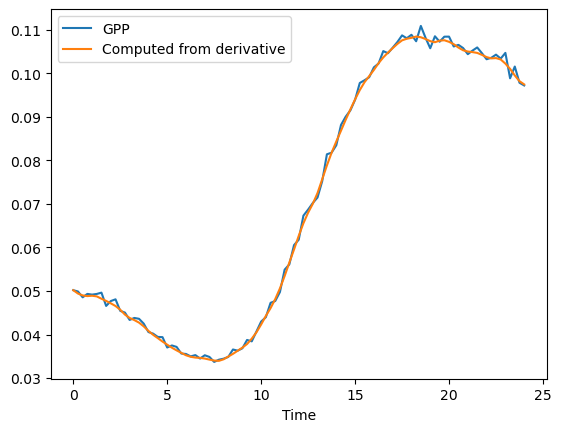

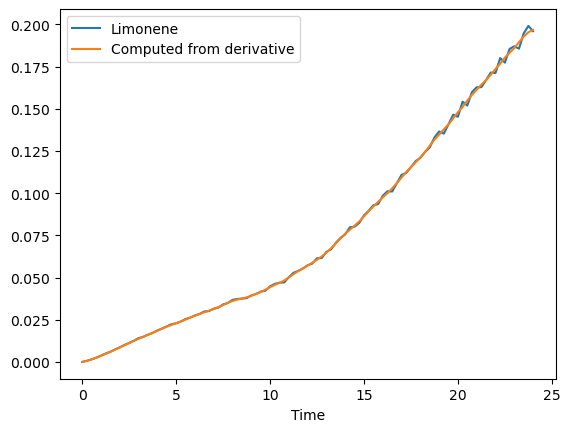

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.895904e+01  4.006396e+01  3.708489e+01  5.668387e+01   
         0.25   4.619542e+06  2.317008e+06  2.160956e+05  1.398457e+06   
         0.50   5.512627e+06  3.556799e+06  3.385569e+05  2.153234e+06   
         0.75   5.929421e+06  4.100638e+06  4.201464e+05  2.663142e+06   
         1.00   5.939704e+06  4.650100e+06  4.739500e+05  3.042015e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.713909e+06  2.632876e+06  1.768712e+06  2.006850e+06   
         23.25  2.748672e+06  2.663635e+06  1.787678e+06  2.019082e+06   
         23.50  2.713428e+06  2.759470e+06  1.739231e+06  2.027699e+06   
         23.75  2.820893e+06  2.699809e+06  1.789693e+06  2.003403e+06   
         24.00  2.690745e+06  2.634564e+06  1.765057e+06  2.028786e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.652667e+01  5.609052e+01  5.574226e+01  1.854788e+01   
         0.25   4.733219e+05  2.255882e+06  2.681733e+06  4.347550e+05   
         0.50   7.349474e+05  3.745038e+06  3.244573e+06  6.404414e+05   
         0.75   8.987189e+05  4.746496e+06  3.532781e+06  7.774754e+05   
         1.00   9.753001e+05  5.461227e+06  3.825207e+06  8.426694e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.494655e+06  3.940687e+06  4.425821e+06  1.213425e+06   
         23.25  1.497491e+06  3.971669e+06  4.379524e+06  1.241157e+06   
         23.50  1.528124e+06  3.910251e+06  4.408977e+06  1.247393e+06   
         23.75  1.486258e+06  4.001348e+06  4.414003e+06  1.251412e+06   
         24.00  1.515767e+06  3.977775e+06  4.322492e+06  1.216404e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.045565e+01   0.297424        0.201680  0.050157   
         0.25       1.806722e+05   0.300192        0.194677  0.056548   
         0.50       2.877380e+05   0.299105        0.183105  0.069053   
         0.75       3.644992e+05   0.286732        0.185485  0.079197   
         1.00       3.980958e+05   0.285431        0.172543  0.091509   
...                          ...        ...             ...       ...   
WT       23.00      1.432944e+06   0.776930        0.013964  0.019737   
         23.25      1.445567e+06   0.763973        0.014793  0.020571   
         23.50      1.477006e+06   0.785629        0.014680  0.021069   
         23.75      1.458479e+06   0.770307        0.014771  0.021598   
         24.00      1.473737e+06   0.790581        0.014852  0.022301   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.295112  0.019945  0.205907  0.010049  0.039701  0.050189   
         0.25   0.250207  0.068294  0.206308  0.010039  0.039255  0.050087   
         0.50   0.217981  0.100099  0.200683  0.009286  0.039745  0.049050   
         0.75   0.195711  0.123435  0.208653  0.007979  0.038452  0.050208   
         1.00   0.182604  0.136342  0.202782  0.006795  0.037419  0.050439   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112279  0.099257  0.310161  0.013573  0.024459  0.104682   
         23.25  0.111720  0.099873  0.307878  0.013429  0.024304  0.098845   
         23.50  0.110822  0.099085  0.301128  0.013576  0.024158 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.007219       -0.029358  0.031305 -0.195864  0.205861   
         0.25    -0.003880       -0.028173  0.036723 -0.153834  0.160517   
         0.50    -0.014979       -0.026987  0.042141 -0.111805  0.115174   
         0.75    -0.021182       -0.027670  0.038366 -0.072696  0.077477   
         1.00    -0.022935       -0.026846  0.025788 -0.038885  0.056447   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.022720        0.000965  0.002146  0.000695 -0.004907   
         23.25    0.000102        0.001073  0.002277  0.000437  0.000958   
         23.50    0.013455        0.000702  0.002462  0.001484  0.000988   
         23.75    0.030303       -0.000038  0.002331  0.001762 -0.001246   
         24.00    0.047151       -0.000777  0.002199  0.002040 -0.003479   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.002765 -0.000110  0.001233 -0.003019  0.001473  
         0.25  -0.002163 -0.001768 -0.000456 -0.001385  0.001972  
         0.50  -0.001562 -0.003427 -0.002146  0.000249  0.002472  
         0.75   0.003368 -0.004149 -0.002793  0.001312  0.002937  
         1.00   0.002859 -0.003838 -0.004189  0.002544  0.003087  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003786 -0.000115 -0.000130 -0.003994  0.013848  
         23.25 -0.001295 -0.000172  0.000202 -0.005690  0.013932  
         23.50 -0.000517 -0.000303 -0.000140 -0.006397  0.012547  
         23.75  0.014288 -0.000511  0.000349 -0.004109  0.008059  
         24.00  0.029092 -0.000720  0.000837 -0.001821  0.003571  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 1.109313E+192 | 9.452503E+116
     2 |       74 | 9.095233E+119 |  2.225125E+97
     3 |      138 | 5.578746E+100 |  2.000009E+88
     4 |      202 |  1.167207E+88 |  5.170652E+60
     5 |      266 |  2.650726E+82 |  3.556771E+58
     6 |      330 |  1.422862E+70 |  3.556771E+58
     7 |      394 |  1.511056E+69 |  1.630639E+48
     8 |      458 |  2.690795E+59 |  1.011116E+42
     9 |      522 |  5.998153E+53 |  1.011116E+42
    10 |      586 |  1.327350E+51 |  4.786022E+39
    11 |      650 |  1.691796E+51 |  1.746160E+38
    12 |      714 |  2.958538E+47 |  1.746160E+38
    13 |      778 |  1.213051E+45 |  5.554082E+37
    14 |      842 |  3.855290E+44 |  5.750986E+33
    15 |      906 |  9.390139E+41 |  2.079378E+30
    16 |      970 |  1.459711E+41 |  2.079378E+30
    17 |     1034 |  4.474437E+35 |  4.785991E+15
    18 |     1098 |  3.443218E+34 |  4.785991E+15
    19 |     1162 |  7.96

   162 |    10314 |  2.447808E+01 |  2.007472E+01
   163 |    10378 |  2.313327E+01 |  2.007472E+01
   164 |    10442 |  2.262421E+01 |  2.007472E+01
   165 |    10506 |  2.259168E+01 |  2.007472E+01
   166 |    10570 |  2.195982E+01 |  2.007472E+01
   167 |    10634 |  2.295540E+01 |  2.007472E+01
   168 |    10698 |  2.220034E+01 |  2.007472E+01
   169 |    10762 |  2.177172E+01 |  2.007472E+01
   170 |    10826 |  2.091248E+01 |  1.921313E+01
   171 |    10890 |  2.257684E+01 |  1.921313E+01
   172 |    10954 |  2.187923E+01 |  1.921313E+01
   173 |    11018 |  2.214322E+01 |  1.921313E+01
   174 |    11082 |  2.323431E+01 |  1.921313E+01
   175 |    11146 |  2.263441E+01 |  1.921313E+01
   176 |    11210 |  2.160437E+01 |  1.921313E+01
   177 |    11274 |  2.224721E+01 |  1.921313E+01
   178 |    11338 |  2.181777E+01 |  1.921313E+01
   179 |    11402 |  2.189985E+01 |  1.921313E+01
   180 |    11466 |  2.168664E+01 |  1.921313E+01
   181 |    11530 |  2.149831E+01 |  1.921313E+01


   326 |    20810 |  1.251095E+01 |  1.241209E+01
   327 |    20874 |  1.252916E+01 |  1.238452E+01
   328 |    20938 |  1.252015E+01 |  1.238452E+01
   329 |    21002 |  1.248137E+01 |  1.237561E+01
   330 |    21066 |  1.246612E+01 |  1.232490E+01
   331 |    21130 |  1.236163E+01 |  1.225837E+01
   332 |    21194 |  1.236262E+01 |  1.223382E+01
   333 |    21258 |  1.234523E+01 |  1.223382E+01
   334 |    21322 |  1.236020E+01 |  1.223382E+01
   335 |    21386 |  1.239779E+01 |  1.223382E+01
   336 |    21450 |  1.231511E+01 |  1.217657E+01
   337 |    21514 |  1.227657E+01 |  1.217657E+01
   338 |    21578 |  1.224952E+01 |  1.217657E+01
   339 |    21642 |  1.225397E+01 |  1.211815E+01
   340 |    21706 |  1.226295E+01 |  1.211815E+01
   341 |    21770 |  1.222743E+01 |  1.211815E+01
   342 |    21834 |  1.223197E+01 |  1.211815E+01
   343 |    21898 |  1.224374E+01 |  1.211815E+01
   344 |    21962 |  1.224291E+01 |  1.211815E+01
   345 |    22026 |  1.222021E+01 |  1.211815E+01


   490 |    31306 |  1.130725E+01 |  1.126493E+01
   491 |    31370 |  1.128575E+01 |  1.124964E+01
   492 |    31434 |  1.127193E+01 |  1.124964E+01
   493 |    31498 |  1.127041E+01 |  1.124964E+01
   494 |    31562 |  1.126790E+01 |  1.124964E+01
   495 |    31626 |  1.124906E+01 |  1.123508E+01
   496 |    31690 |  1.124199E+01 |  1.122217E+01
   497 |    31754 |  1.123920E+01 |  1.122217E+01
   498 |    31818 |  1.123570E+01 |  1.121831E+01
   499 |    31882 |  1.122406E+01 |  1.121472E+01
   500 |    31946 |  1.121630E+01 |  1.119579E+01
   501 |    32010 |  1.119912E+01 |  1.117634E+01
   502 |    32074 |  1.118501E+01 |  1.115579E+01
   503 |    32138 |  1.117500E+01 |  1.115579E+01
   504 |    32202 |  1.116867E+01 |  1.115579E+01
   505 |    32266 |  1.116475E+01 |  1.115015E+01
   506 |    32330 |  1.115228E+01 |  1.113554E+01
   507 |    32394 |  1.114177E+01 |  1.112967E+01
   508 |    32458 |  1.113543E+01 |  1.112094E+01
   509 |    32522 |  1.113990E+01 |  1.112094E+01


   654 |    41802 |  1.032236E+01 |  1.030087E+01
   655 |    41866 |  1.031925E+01 |  1.030087E+01
   656 |    41930 |  1.031363E+01 |  1.030087E+01
   657 |    41994 |  1.031720E+01 |  1.030087E+01
   658 |    42058 |  1.030589E+01 |  1.028867E+01
   659 |    42122 |  1.029501E+01 |  1.024332E+01
   660 |    42186 |  1.027303E+01 |  1.024158E+01
   661 |    42250 |  1.026586E+01 |  1.024158E+01
   662 |    42314 |  1.025839E+01 |  1.024013E+01
   663 |    42378 |  1.025009E+01 |  1.023506E+01
   664 |    42442 |  1.023427E+01 |  1.021153E+01
   665 |    42506 |  1.023000E+01 |  1.021035E+01
   666 |    42570 |  1.021676E+01 |  1.020580E+01
   667 |    42634 |  1.021171E+01 |  1.019964E+01
   668 |    42698 |  1.021544E+01 |  1.019690E+01
   669 |    42762 |  1.021113E+01 |  1.019325E+01
   670 |    42826 |  1.019627E+01 |  1.016192E+01
   671 |    42890 |  1.017461E+01 |  1.014024E+01
   672 |    42954 |  1.015503E+01 |  1.014024E+01
   673 |    43018 |  1.015586E+01 |  1.012384E+01


   818 |    52298 |  9.0391209498 |  9.0288126520
   819 |    52362 |  9.0351588042 |  9.0288126520
   820 |    52426 |  9.0361683861 |  9.0271588033
   821 |    52490 |  9.0323890604 |  9.0229451889
   822 |    52554 |  9.0313023771 |  9.0229451889
   823 |    52618 |  9.0240247980 |  9.0127518712
   824 |    52682 |  9.0236876283 |  9.0127518712
   825 |    52746 |  9.0236513459 |  9.0090432463
   826 |    52810 |  9.0147108965 |  9.0022082545
   827 |    52874 |  9.0092580824 |  9.0022082545
   828 |    52938 |  9.0105699905 |  9.0022082545
   829 |    53002 |  9.0066037273 |  9.0004127233
   830 |    53066 |  9.0048392100 |  8.9990873280
   831 |    53130 |  9.0017554196 |  8.9950050680
   832 |    53194 |  8.9995803759 |  8.9932764431
   833 |    53258 |  8.9995944854 |  8.9924600756
   834 |    53322 |  8.9946371794 |  8.9906531594
   835 |    53386 |  8.9949879826 |  8.9906531594
   836 |    53450 |  8.9926602552 |  8.9868595863
   837 |    53514 |  8.9892406192 |  8.9849329718


   982 |    62794 |  8.4744688624 |  8.4677371895
   983 |    62858 |  8.4701868665 |  8.4652158686
   984 |    62922 |  8.4679648550 |  8.4631253520
   985 |    62986 |  8.4674413124 |  8.4616697522
   986 |    63050 |  8.4656626553 |  8.4615792554
   987 |    63114 |  8.4637832596 |  8.4609077114
   988 |    63178 |  8.4624225484 |  8.4590039491
   989 |    63242 |  8.4617176801 |  8.4581129730
   990 |    63306 |  8.4606818304 |  8.4565545068
   991 |    63370 |  8.4575149637 |  8.4531356087
   992 |    63434 |  8.4573814423 |  8.4531356087
   993 |    63498 |  8.4561521766 |  8.4531356087
   994 |    63562 |  8.4564175456 |  8.4531197529
   995 |    63626 |  8.4532318722 |  8.4475456329
   996 |    63690 |  8.4508925080 |  8.4457952435
   997 |    63754 |  8.4496263659 |  8.4421691641
   998 |    63818 |  8.4462442088 |  8.4407621625
   999 |    63882 |  8.4420276865 |  8.4374707477
  1000 |    63946 |  8.4394672729 |  8.4357576964
  1001 |    64010 |  8.4378135906 |  8.4320590963


  1146 |    73290 |  8.3321230900 |  8.3314731813
  1147 |    73354 |  8.3315859017 |  8.3307018110
  1148 |    73418 |  8.3312223921 |  8.3307018110
  1149 |    73482 |  8.3311833950 |  8.3307018110
  1150 |    73546 |  8.3309891556 |  8.3304502359
  1151 |    73610 |  8.3308709983 |  8.3303680651
  1152 |    73674 |  8.3305951997 |  8.3303680651
  1153 |    73738 |  8.3305916643 |  8.3303680651
  1154 |    73802 |  8.3305251039 |  8.3300827626
  1155 |    73866 |  8.3303119247 |  8.3296870043
  1156 |    73930 |  8.3300604779 |  8.3296870043
  1157 |    73994 |  8.3298317560 |  8.3292894985
  1158 |    74058 |  8.3296285004 |  8.3292383670
  1159 |    74122 |  8.3296190057 |  8.3288655164
  1160 |    74186 |  8.3292119091 |  8.3285587318
  1161 |    74250 |  8.3286227566 |  8.3279464319
  1162 |    74314 |  8.3279417905 |  8.3273130871
  1163 |    74378 |  8.3274351714 |  8.3271512762
  1164 |    74442 |  8.3271177544 |  8.3265125530
  1165 |    74506 |  8.3267414926 |  8.3262289043


  1310 |    83786 |  8.2759241750 |  8.2746169349
  1311 |    83850 |  8.2754023664 |  8.2742200608
  1312 |    83914 |  8.2748656425 |  8.2741132941
  1313 |    83978 |  8.2739915681 |  8.2731016930
  1314 |    84042 |  8.2740149403 |  8.2731016930
  1315 |    84106 |  8.2734538065 |  8.2731016930
  1316 |    84170 |  8.2737002188 |  8.2724181561
  1317 |    84234 |  8.2732751362 |  8.2722942397
  1318 |    84298 |  8.2726773300 |  8.2717310656
  1319 |    84362 |  8.2722808965 |  8.2714742463
  1320 |    84426 |  8.2717226917 |  8.2710486989
  1321 |    84490 |  8.2712973322 |  8.2706267959
  1322 |    84554 |  8.2711678662 |  8.2704958163
  1323 |    84618 |  8.2709016079 |  8.2703604233
  1324 |    84682 |  8.2703089481 |  8.2696325685
  1325 |    84746 |  8.2701166499 |  8.2685846163
  1326 |    84810 |  8.2697769825 |  8.2685846163
  1327 |    84874 |  8.2693397554 |  8.2685846163
  1328 |    84938 |  8.2693747559 |  8.2685270122
  1329 |    85002 |  8.2689897557 |  8.2677425377


  1474 |    94282 |  8.2270401519 |  8.2260922194
  1475 |    94346 |  8.2266996838 |  8.2253593799
  1476 |    94410 |  8.2259270287 |  8.2252758216
  1477 |    94474 |  8.2256163446 |  8.2238847390
  1478 |    94538 |  8.2249120053 |  8.2238847390
  1479 |    94602 |  8.2247491738 |  8.2234930249
  1480 |    94666 |  8.2241038456 |  8.2233550167
  1481 |    94730 |  8.2237409152 |  8.2228234066
  1482 |    94794 |  8.2236397057 |  8.2224166916
  1483 |    94858 |  8.2231893032 |  8.2215682896
  1484 |    94922 |  8.2227101284 |  8.2209429458
  1485 |    94986 |  8.2217561610 |  8.2203795821
  1486 |    95050 |  8.2212733270 |  8.2203795821
  1487 |    95114 |  8.2206984790 |  8.2195507873
  1488 |    95178 |  8.2202036347 |  8.2195507873
  1489 |    95242 |  8.2196523876 |  8.2187248837
  1490 |    95306 |  8.2188645101 |  8.2164281249
  1491 |    95370 |  8.2183283307 |  8.2164281249
  1492 |    95434 |  8.2179901843 |  8.2164281249
  1493 |    95498 |  8.2173986114 |  8.2160566542


  1638 |   104778 |  7.9653390425 |  7.9216303562
  1639 |   104842 |  7.9558899061 |  7.9216303562
  1640 |   104906 |  7.9689498159 |  7.9209128350
  1641 |   104970 |  7.9417216154 |  7.9023300405
  1642 |   105034 |  7.9403903916 |  7.9023300405
  1643 |   105098 |  7.9614990368 |  7.9023300405
  1644 |   105162 |  7.9524890199 |  7.9023300405
  1645 |   105226 |  7.9543203411 |  7.9023300405
  1646 |   105290 |  7.9458803253 |  7.9023300405
  1647 |   105354 |  7.9510772920 |  7.8925061100
  1648 |   105418 |  7.9698235825 |  7.8925061100
  1649 |   105482 |  7.9424672156 |  7.8925061100
  1650 |   105546 |  7.9610532622 |  7.8925061100
  1651 |   105610 |  7.9488630816 |  7.8925061100
  1652 |   105674 |  7.9404793647 |  7.8925061100
  1653 |   105738 |  7.9341347433 |  7.8925061100
  1654 |   105802 |  7.9274689779 |  7.8925061100
  1655 |   105866 |  7.9177678481 |  7.8775522300
  1656 |   105930 |  7.9100357542 |  7.8628455813
  1657 |   105994 |  7.8979374199 |  7.8628455813


  1802 |   115274 |  7.7519243788 |  7.7514939367
  1803 |   115338 |  7.7515423281 |  7.7509153790
  1804 |   115402 |  7.7513754335 |  7.7509153790
  1805 |   115466 |  7.7511614236 |  7.7506167225
  1806 |   115530 |  7.7511237791 |  7.7506167225
  1807 |   115594 |  7.7509514731 |  7.7506011701
  1808 |   115658 |  7.7510113957 |  7.7506011701
  1809 |   115722 |  7.7508392438 |  7.7505496526
  1810 |   115786 |  7.7506795539 |  7.7502671610
  1811 |   115850 |  7.7503659460 |  7.7500565185
  1812 |   115914 |  7.7502760657 |  7.7495959038
  1813 |   115978 |  7.7501182222 |  7.7495959038
  1814 |   116042 |  7.7497802907 |  7.7492096556
  1815 |   116106 |  7.7497098318 |  7.7492096556
  1816 |   116170 |  7.7496707082 |  7.7492096556
  1817 |   116234 |  7.7494263907 |  7.7488953394
  1818 |   116298 |  7.7492748464 |  7.7488878592
  1819 |   116362 |  7.7493871220 |  7.7488878592
  1820 |   116426 |  7.7494135459 |  7.7488878592
  1821 |   116490 |  7.7493489398 |  7.7485545395


  1966 |   125770 |  7.7125411686 |  7.7107178962
  1967 |   125834 |  7.7114847386 |  7.7107178962
  1968 |   125898 |  7.7105067524 |  7.7097415544
  1969 |   125962 |  7.7101042221 |  7.7096029880
  1970 |   126026 |  7.7083329639 |  7.7072796089
  1971 |   126090 |  7.7083633548 |  7.7072796089
  1972 |   126154 |  7.7081888666 |  7.7071322829
  1973 |   126218 |  7.7072370584 |  7.7055156224
  1974 |   126282 |  7.7064075133 |  7.7055156224
  1975 |   126346 |  7.7058577097 |  7.7050627717
  1976 |   126410 |  7.7050902032 |  7.7030725505
  1977 |   126474 |  7.7041887604 |  7.7030725505
  1978 |   126538 |  7.7035521808 |  7.7030323472
  1979 |   126602 |  7.7030781979 |  7.7026354846
  1980 |   126666 |  7.7027396410 |  7.7010448770
  1981 |   126730 |  7.7021424727 |  7.7009093555
  1982 |   126794 |  7.7015781831 |  7.6999444993
  1983 |   126858 |  7.7007889350 |  7.6998473820
  1984 |   126922 |  7.7001136682 |  7.6991176037
  1985 |   126986 |  7.6996201605 |  7.6988151396


  2130 |   136266 |  7.6051482811 |  7.6041967679
  2131 |   136330 |  7.6050871953 |  7.6037562781
  2132 |   136394 |  7.6050691746 |  7.6037562781
  2133 |   136458 |  7.6046234254 |  7.6037562781
  2134 |   136522 |  7.6041559872 |  7.6030332753
  2135 |   136586 |  7.6037706353 |  7.6030332753
  2136 |   136650 |  7.6040657972 |  7.6030332753
  2137 |   136714 |  7.6038573700 |  7.6023669331
  2138 |   136778 |  7.6033264894 |  7.6023669331
  2139 |   136842 |  7.6026862586 |  7.6010263719
  2140 |   136906 |  7.6016925477 |  7.5994978909
  2141 |   136970 |  7.6003872703 |  7.5988751087
  2142 |   137034 |  7.5998710755 |  7.5983731203
  2143 |   137098 |  7.5989645291 |  7.5980302975
  2144 |   137162 |  7.5986938903 |  7.5975310949
  2145 |   137226 |  7.5983789798 |  7.5961236484
  2146 |   137290 |  7.5982755312 |  7.5961236484
  2147 |   137354 |  7.5981634899 |  7.5961236484
  2148 |   137418 |  7.5969873272 |  7.5960013336
  2149 |   137482 |  7.5965474210 |  7.5959117703


  2294 |   146762 |  7.5044085870 |  7.5027486234
  2295 |   146826 |  7.5034254353 |  7.5012998067
  2296 |   146890 |  7.5029257319 |  7.5012998067
  2297 |   146954 |  7.5023778097 |  7.5002507560
  2298 |   147018 |  7.5017204958 |  7.4998013075
  2299 |   147082 |  7.5012023463 |  7.4993859130
  2300 |   147146 |  7.5005101717 |  7.4991498317
  2301 |   147210 |  7.5003058412 |  7.4991498317
  2302 |   147274 |  7.4998715108 |  7.4990165108
  2303 |   147338 |  7.4998984611 |  7.4990165108
  2304 |   147402 |  7.4995502019 |  7.4990165108
  2305 |   147466 |  7.4991357926 |  7.4980877654
  2306 |   147530 |  7.4987079093 |  7.4975280541
  2307 |   147594 |  7.4982798479 |  7.4973629096
  2308 |   147658 |  7.4975402756 |  7.4963690288
  2309 |   147722 |  7.4968720336 |  7.4955790653
  2310 |   147786 |  7.4963645376 |  7.4951593625
  2311 |   147850 |  7.4956886450 |  7.4944875860
  2312 |   147914 |  7.4950425560 |  7.4943127087
  2313 |   147978 |  7.4949208266 |  7.4934936040


  2458 |   157258 |  7.4503773944 |  7.4498609424
  2459 |   157322 |  7.4505752337 |  7.4498609424
  2460 |   157386 |  7.4504514064 |  7.4490490589
  2461 |   157450 |  7.4501466648 |  7.4490490589
  2462 |   157514 |  7.4494261623 |  7.4490490589
  2463 |   157578 |  7.4493362436 |  7.4489438042
  2464 |   157642 |  7.4492268317 |  7.4486529395
  2465 |   157706 |  7.4489370248 |  7.4484612924
  2466 |   157770 |  7.4487671018 |  7.4483181572
  2467 |   157834 |  7.4486117859 |  7.4482787614
  2468 |   157898 |  7.4484067602 |  7.4477822706
  2469 |   157962 |  7.4481983442 |  7.4476669349
  2470 |   158026 |  7.4475513845 |  7.4470927703
  2471 |   158090 |  7.4472997126 |  7.4467102439
  2472 |   158154 |  7.4467590580 |  7.4458114603
  2473 |   158218 |  7.4463763235 |  7.4456309676
  2474 |   158282 |  7.4459121631 |  7.4451770081
  2475 |   158346 |  7.4454563696 |  7.4446675170
  2476 |   158410 |  7.4452128283 |  7.4446675170
  2477 |   158474 |  7.4446833906 |  7.4441482036


  2622 |   167754 |  7.3718612584 |  7.3693843608
  2623 |   167818 |  7.3720863475 |  7.3693843608
  2624 |   167882 |  7.3713530853 |  7.3682094013
  2625 |   167946 |  7.3699670883 |  7.3676646565
  2626 |   168010 |  7.3697579687 |  7.3676646565
  2627 |   168074 |  7.3689909204 |  7.3670392987
  2628 |   168138 |  7.3680104801 |  7.3664268603
  2629 |   168202 |  7.3675667692 |  7.3664268603
  2630 |   168266 |  7.3673541186 |  7.3660813513
  2631 |   168330 |  7.3668880653 |  7.3660813513
  2632 |   168394 |  7.3665704047 |  7.3657552897
  2633 |   168458 |  7.3665882067 |  7.3657026576
  2634 |   168522 |  7.3663858915 |  7.3650657617
  2635 |   168586 |  7.3654205136 |  7.3644480085
  2636 |   168650 |  7.3653115487 |  7.3644480085
  2637 |   168714 |  7.3652694863 |  7.3644203991
  2638 |   168778 |  7.3647873669 |  7.3634239541
  2639 |   168842 |  7.3642157292 |  7.3634239541
  2640 |   168906 |  7.3638425286 |  7.3631069878
  2641 |   168970 |  7.3636605144 |  7.3629113633


  2786 |   178250 |  7.2650913804 |  7.2644750089
  2787 |   178314 |  7.2647460216 |  7.2641810823
  2788 |   178378 |  7.2645770749 |  7.2633320747
  2789 |   178442 |  7.2643239401 |  7.2632881171
  2790 |   178506 |  7.2637812026 |  7.2630237749
  2791 |   178570 |  7.2631585575 |  7.2619705022
  2792 |   178634 |  7.2623782410 |  7.2613707121
  2793 |   178698 |  7.2617678678 |  7.2608000915
  2794 |   178762 |  7.2614093378 |  7.2608000915
  2795 |   178826 |  7.2610226474 |  7.2606434497
  2796 |   178890 |  7.2607447211 |  7.2603482394
  2797 |   178954 |  7.2605882250 |  7.2602217655
  2798 |   179018 |  7.2602086303 |  7.2598451929
  2799 |   179082 |  7.2600843255 |  7.2593882097
  2800 |   179146 |  7.2597016679 |  7.2589930918
  2801 |   179210 |  7.2589055989 |  7.2582154592
  2802 |   179274 |  7.2585784755 |  7.2582132359
  2803 |   179338 |  7.2583073381 |  7.2580305879
  2804 |   179402 |  7.2580511212 |  7.2573692562
  2805 |   179466 |  7.2574396866 |  7.2565042564


  2950 |   188746 |  7.1748198342 |  7.1742880349
  2951 |   188810 |  7.1745565790 |  7.1742785896
  2952 |   188874 |  7.1743616295 |  7.1739332122
  2953 |   188938 |  7.1741209775 |  7.1734502833
  2954 |   189002 |  7.1736737348 |  7.1733223626
  2955 |   189066 |  7.1735625472 |  7.1732049299
  2956 |   189130 |  7.1732142517 |  7.1727609879
  2957 |   189194 |  7.1729742361 |  7.1726811975
  2958 |   189258 |  7.1726415512 |  7.1720553722
  2959 |   189322 |  7.1723529396 |  7.1720553722
  2960 |   189386 |  7.1722061916 |  7.1718839176
  2961 |   189450 |  7.1720511891 |  7.1716262901
  2962 |   189514 |  7.1719280725 |  7.1715761948
  2963 |   189578 |  7.1718657168 |  7.1715761948
  2964 |   189642 |  7.1716744872 |  7.1712909947
  2965 |   189706 |  7.1714356959 |  7.1709186537
  2966 |   189770 |  7.1711633327 |  7.1709125859
  2967 |   189834 |  7.1709714989 |  7.1705759455
  2968 |   189898 |  7.1706775983 |  7.1703327943
  2969 |   189962 |  7.1704550705 |  7.1702700043


  3114 |   199242 |  7.0867368692 |  7.0859236862
  3115 |   199306 |  7.0862427747 |  7.0854995161
  3116 |   199370 |  7.0858420784 |  7.0842406937
  3117 |   199434 |  7.0850910863 |  7.0841775374
  3118 |   199498 |  7.0846775521 |  7.0832186547
  3119 |   199562 |  7.0839896332 |  7.0831610505
  3120 |   199626 |  7.0833881957 |  7.0828948800
  3121 |   199690 |  7.0830382077 |  7.0819149190
  3122 |   199754 |  7.0815008064 |  7.0799450560
  3123 |   199818 |  7.0804316439 |  7.0788905783
  3124 |   199882 |  7.0790321853 |  7.0774341832
  3125 |   199946 |  7.0782356838 |  7.0769280695
  3126 |   200010 |  7.0779488348 |  7.0769280695
  3127 |   200074 |  7.0772544065 |  7.0758562273
  3128 |   200138 |  7.0762416608 |  7.0734345544
  3129 |   200202 |  7.0743446948 |  7.0719063597
  3130 |   200266 |  7.0726685782 |  7.0703976402
  3131 |   200330 |  7.0702515006 |  7.0680610845
  3132 |   200394 |  7.0684718447 |  7.0655951424
  3133 |   200458 |  7.0661925448 |  7.0651265318


  3278 |   209738 |  6.9456053250 |  6.9444095838
  3279 |   209802 |  6.9454985879 |  6.9436603220
  3280 |   209866 |  6.9452312707 |  6.9432594050
  3281 |   209930 |  6.9441827552 |  6.9432594050
  3282 |   209994 |  6.9442403003 |  6.9428332637
  3283 |   210058 |  6.9436594629 |  6.9428332637
  3284 |   210122 |  6.9430926311 |  6.9420146547
  3285 |   210186 |  6.9431170271 |  6.9414225010
  3286 |   210250 |  6.9421475273 |  6.9396380242
  3287 |   210314 |  6.9410833758 |  6.9395647543
  3288 |   210378 |  6.9401304292 |  6.9394000234
  3289 |   210442 |  6.9398961409 |  6.9389647815
  3290 |   210506 |  6.9390571417 |  6.9377530021
  3291 |   210570 |  6.9378404236 |  6.9368974252
  3292 |   210634 |  6.9376616634 |  6.9368974252
  3293 |   210698 |  6.9374879468 |  6.9366784687
  3294 |   210762 |  6.9375542629 |  6.9366784687
  3295 |   210826 |  6.9371434747 |  6.9366784687
  3296 |   210890 |  6.9368894244 |  6.9358676196
  3297 |   210954 |  6.9366693123 |  6.9358419690


  3442 |   220234 |  6.8478984893 |  6.8471658697
  3443 |   220298 |  6.8476976597 |  6.8462944642
  3444 |   220362 |  6.8462926834 |  6.8437258914
  3445 |   220426 |  6.8446444425 |  6.8434711057
  3446 |   220490 |  6.8437861130 |  6.8426758439
  3447 |   220554 |  6.8417883303 |  6.8405340409
  3448 |   220618 |  6.8411258223 |  6.8394835593
  3449 |   220682 |  6.8403439539 |  6.8381384670
  3450 |   220746 |  6.8393008224 |  6.8381384670
  3451 |   220810 |  6.8380884284 |  6.8360846367
  3452 |   220874 |  6.8363094453 |  6.8344328406
  3453 |   220938 |  6.8351368710 |  6.8338439293
  3454 |   221002 |  6.8344837339 |  6.8325670072
  3455 |   221066 |  6.8340595481 |  6.8325670072
  3456 |   221130 |  6.8330584512 |  6.8321082741
  3457 |   221194 |  6.8332676444 |  6.8317521656
  3458 |   221258 |  6.8323678978 |  6.8317521656
  3459 |   221322 |  6.8315748463 |  6.8304281370
  3460 |   221386 |  6.8314361213 |  6.8295888530
  3461 |   221450 |  6.8306524785 |  6.8295888530


  3606 |   230730 |  6.7860859590 |  6.7858243168
  3607 |   230794 |  6.7858527089 |  6.7855694349
  3608 |   230858 |  6.7856050950 |  6.7854439258
  3609 |   230922 |  6.7854670195 |  6.7850250540
  3610 |   230986 |  6.7851943371 |  6.7848484646
  3611 |   231050 |  6.7849932056 |  6.7848484646
  3612 |   231114 |  6.7847287304 |  6.7844719435
  3613 |   231178 |  6.7847096885 |  6.7844719435
  3614 |   231242 |  6.7844635811 |  6.7840366776
  3615 |   231306 |  6.7844194803 |  6.7840366776
  3616 |   231370 |  6.7841373846 |  6.7837250728
  3617 |   231434 |  6.7836259250 |  6.7833295846
  3618 |   231498 |  6.7833416412 |  6.7830239412
  3619 |   231562 |  6.7829431772 |  6.7822394741
  3620 |   231626 |  6.7824176524 |  6.7817642813
  3621 |   231690 |  6.7813511033 |  6.7799308006
  3622 |   231754 |  6.7803762966 |  6.7798493265
  3623 |   231818 |  6.7797662021 |  6.7791972961
  3624 |   231882 |  6.7793653921 |  6.7782567793
  3625 |   231946 |  6.7787713670 |  6.7778493619


  3770 |   241226 |  6.6895259996 |  6.6880635180
  3771 |   241290 |  6.6894661612 |  6.6880635180
  3772 |   241354 |  6.6884450938 |  6.6866064794
  3773 |   241418 |  6.6875907687 |  6.6864061461
  3774 |   241482 |  6.6875882159 |  6.6864061461
  3775 |   241546 |  6.6871922864 |  6.6860451332
  3776 |   241610 |  6.6873052038 |  6.6860451332
  3777 |   241674 |  6.6865223956 |  6.6854765252
  3778 |   241738 |  6.6867404995 |  6.6854765252
  3779 |   241802 |  6.6866736981 |  6.6854765252
  3780 |   241866 |  6.6865508024 |  6.6854765252
  3781 |   241930 |  6.6862414216 |  6.6847469185
  3782 |   241994 |  6.6854743754 |  6.6845686796
  3783 |   242058 |  6.6856707653 |  6.6845625149
  3784 |   242122 |  6.6853575754 |  6.6835552598
  3785 |   242186 |  6.6846362314 |  6.6824805327
  3786 |   242250 |  6.6843549982 |  6.6824805327
  3787 |   242314 |  6.6836364179 |  6.6824805327
  3788 |   242378 |  6.6833265203 |  6.6823676865
  3789 |   242442 |  6.6830330771 |  6.6819531180


  3934 |   251722 |  6.6554183147 |  6.6550945243
  3935 |   251786 |  6.6553295003 |  6.6550525031
  3936 |   251850 |  6.6551768999 |  6.6550184432
  3937 |   251914 |  6.6549444010 |  6.6545187138
  3938 |   251978 |  6.6549181705 |  6.6545187138
  3939 |   252042 |  6.6548141640 |  6.6545187138
  3940 |   252106 |  6.6547810277 |  6.6545187138
  3941 |   252170 |  6.6547188719 |  6.6544921827
  3942 |   252234 |  6.6546689867 |  6.6544256019
  3943 |   252298 |  6.6545527631 |  6.6542893699
  3944 |   252362 |  6.6544648575 |  6.6542893699
  3945 |   252426 |  6.6545059555 |  6.6542893699
  3946 |   252490 |  6.6544821810 |  6.6542525289
  3947 |   252554 |  6.6544344145 |  6.6542046257
  3948 |   252618 |  6.6542898471 |  6.6540345637
  3949 |   252682 |  6.6541422388 |  6.6540062250
  3950 |   252746 |  6.6540994365 |  6.6539182277
  3951 |   252810 |  6.6540262114 |  6.6538531666
  3952 |   252874 |  6.6539700578 |  6.6538245906
  3953 |   252938 |  6.6539678765 |  6.6537088496


  4098 |   262218 |  6.6367153228 |  6.6363281092
  4099 |   262282 |  6.6365895078 |  6.6362945141
  4100 |   262346 |  6.6364110860 |  6.6360106498
  4101 |   262410 |  6.6364906053 |  6.6359533726
  4102 |   262474 |  6.6360453281 |  6.6355081781
  4103 |   262538 |  6.6357243353 |  6.6348455685
  4104 |   262602 |  6.6354104238 |  6.6348455685
  4105 |   262666 |  6.6351268895 |  6.6344340601
  4106 |   262730 |  6.6349453453 |  6.6343280052
  4107 |   262794 |  6.6345796750 |  6.6339361904
  4108 |   262858 |  6.6342992469 |  6.6336901929
  4109 |   262922 |  6.6340287734 |  6.6335454397
  4110 |   262986 |  6.6337701472 |  6.6334471737
  4111 |   263050 |  6.6336494695 |  6.6333748133
  4112 |   263114 |  6.6335524611 |  6.6331016263
  4113 |   263178 |  6.6332730061 |  6.6330081929
  4114 |   263242 |  6.6330704769 |  6.6327114362
  4115 |   263306 |  6.6328299129 |  6.6326814085
  4116 |   263370 |  6.6327163256 |  6.6323689344
  4117 |   263434 |  6.6325354739 |  6.6321766377


  4262 |   272714 |  6.5917324328 |  6.5914805935
  4263 |   272778 |  6.5915925911 |  6.5911614415
  4264 |   272842 |  6.5913920542 |  6.5911558047
  4265 |   272906 |  6.5911745515 |  6.5907549233
  4266 |   272970 |  6.5908601917 |  6.5906506468
  4267 |   273034 |  6.5907206046 |  6.5905507773
  4268 |   273098 |  6.5904742235 |  6.5901481396
  4269 |   273162 |  6.5901680631 |  6.5899600968
  4270 |   273226 |  6.5900059099 |  6.5898903750
  4271 |   273290 |  6.5898814394 |  6.5897328974
  4272 |   273354 |  6.5897913405 |  6.5894421059
  4273 |   273418 |  6.5896129453 |  6.5892818140
  4274 |   273482 |  6.5894136859 |  6.5890857943
  4275 |   273546 |  6.5891258562 |  6.5888003847
  4276 |   273610 |  6.5890344116 |  6.5887936884
  4277 |   273674 |  6.5889395830 |  6.5883000358
  4278 |   273738 |  6.5887619378 |  6.5883000358
  4279 |   273802 |  6.5885927365 |  6.5882464456
  4280 |   273866 |  6.5883249439 |  6.5880625692
  4281 |   273930 |  6.5881352169 |  6.5878020246


  4426 |   283210 |  6.5635582640 |  6.5628875821
  4427 |   283274 |  6.5635622585 |  6.5628875821
  4428 |   283338 |  6.5632976625 |  6.5627516621
  4429 |   283402 |  6.5632162074 |  6.5627516621
  4430 |   283466 |  6.5632422150 |  6.5626888851
  4431 |   283530 |  6.5629341445 |  6.5618927057
  4432 |   283594 |  6.5627396632 |  6.5618927057
  4433 |   283658 |  6.5623518641 |  6.5618927057
  4434 |   283722 |  6.5620351844 |  6.5618765006
  4435 |   283786 |  6.5618557261 |  6.5614585450
  4436 |   283850 |  6.5616602222 |  6.5613036834
  4437 |   283914 |  6.5613121050 |  6.5606697024
  4438 |   283978 |  6.5611989183 |  6.5606697024
  4439 |   284042 |  6.5610501385 |  6.5606201337
  4440 |   284106 |  6.5607975453 |  6.5605144577
  4441 |   284170 |  6.5605817183 |  6.5602133995
  4442 |   284234 |  6.5607350205 |  6.5602133995
  4443 |   284298 |  6.5602245687 |  6.5598942287
  4444 |   284362 |  6.5602195444 |  6.5597404385
  4445 |   284426 |  6.5600303019 |  6.5594842681


  4590 |   293706 |  6.5334015689 |  6.5332946746
  4591 |   293770 |  6.5334238753 |  6.5332620583
  4592 |   293834 |  6.5332893235 |  6.5331752844
  4593 |   293898 |  6.5330198928 |  6.5327856728
  4594 |   293962 |  6.5329403307 |  6.5327544450
  4595 |   294026 |  6.5328217082 |  6.5325918668
  4596 |   294090 |  6.5326286365 |  6.5324663524
  4597 |   294154 |  6.5325476067 |  6.5323986961
  4598 |   294218 |  6.5323607477 |  6.5322085682
  4599 |   294282 |  6.5322457095 |  6.5320860535
  4600 |   294346 |  6.5321725336 |  6.5319729574
  4601 |   294410 |  6.5320085195 |  6.5318688566
  4602 |   294474 |  6.5318477134 |  6.5316081345
  4603 |   294538 |  6.5317723485 |  6.5313765818
  4604 |   294602 |  6.5316025798 |  6.5313765818
  4605 |   294666 |  6.5314491802 |  6.5313216205
  4606 |   294730 |  6.5314060898 |  6.5313216205
  4607 |   294794 |  6.5313595644 |  6.5310821529
  4608 |   294858 |  6.5311935369 |  6.5309651597
  4609 |   294922 |  6.5311326247 |  6.5308966866


  4754 |   304202 |  6.5109217263 |  6.5107249943
  4755 |   304266 |  6.5106302376 |  6.5101637645
  4756 |   304330 |  6.5104200967 |  6.5101637645
  4757 |   304394 |  6.5101990045 |  6.5100008509
  4758 |   304458 |  6.5100509747 |  6.5098705178
  4759 |   304522 |  6.5098815386 |  6.5096486459
  4760 |   304586 |  6.5097887956 |  6.5096486459
  4761 |   304650 |  6.5097062775 |  6.5096091868
  4762 |   304714 |  6.5095618704 |  6.5093982455
  4763 |   304778 |  6.5094529211 |  6.5092792044
  4764 |   304842 |  6.5092777881 |  6.5091202825
  4765 |   304906 |  6.5091188771 |  6.5089788196
  4766 |   304970 |  6.5089340077 |  6.5087042949
  4767 |   305034 |  6.5087557401 |  6.5086380008
  4768 |   305098 |  6.5086226354 |  6.5085332966
  4769 |   305162 |  6.5085396210 |  6.5083070410
  4770 |   305226 |  6.5083602256 |  6.5080269398
  4771 |   305290 |  6.5081567556 |  6.5079303573
  4772 |   305354 |  6.5078394239 |  6.5073578376
  4773 |   305418 |  6.5075355251 |  6.5073114430


  4918 |   314698 |  6.4444907353 |  6.4425573794
  4919 |   314762 |  6.4436280457 |  6.4421495842
  4920 |   314826 |  6.4435886542 |  6.4419126495
  4921 |   314890 |  6.4443365825 |  6.4419126495
  4922 |   314954 |  6.4443082953 |  6.4419126495
  4923 |   315018 |  6.4439588058 |  6.4419126495
  4924 |   315082 |  6.4439174503 |  6.4409605877
  4925 |   315146 |  6.4423148641 |  6.4405004497
  4926 |   315210 |  6.4417919494 |  6.4398275848
  4927 |   315274 |  6.4412209122 |  6.4389145921
  4928 |   315338 |  6.4398909113 |  6.4387087857
  4929 |   315402 |  6.4393316273 |  6.4383477771
  4930 |   315466 |  6.4386583904 |  6.4374718266
  4931 |   315530 |  6.4384376325 |  6.4370978071
  4932 |   315594 |  6.4374714738 |  6.4352578016
  4933 |   315658 |  6.4367779464 |  6.4352578016
  4934 |   315722 |  6.4361980041 |  6.4352578016
  4935 |   315786 |  6.4354961953 |  6.4344638718
  4936 |   315850 |  6.4354848798 |  6.4344638718
  4937 |   315914 |  6.4351564570 |  6.4337745068


  5082 |   325194 |  6.4086327228 |  6.4085198408
  5083 |   325258 |  6.4085262987 |  6.4083374071
  5084 |   325322 |  6.4084380648 |  6.4082459405
  5085 |   325386 |  6.4082309660 |  6.4078942408
  5086 |   325450 |  6.4081921937 |  6.4078942408
  5087 |   325514 |  6.4080881524 |  6.4078678514
  5088 |   325578 |  6.4079409162 |  6.4078361726
  5089 |   325642 |  6.4078481745 |  6.4076679180
  5090 |   325706 |  6.4077480286 |  6.4076540974
  5091 |   325770 |  6.4075728658 |  6.4074729865
  5092 |   325834 |  6.4075020872 |  6.4073044681
  5093 |   325898 |  6.4073823595 |  6.4072486464
  5094 |   325962 |  6.4072490937 |  6.4070924287
  5095 |   326026 |  6.4072392562 |  6.4069642153
  5096 |   326090 |  6.4071855531 |  6.4067745840
  5097 |   326154 |  6.4070048852 |  6.4066767579
  5098 |   326218 |  6.4067903757 |  6.4065275334
  5099 |   326282 |  6.4067191589 |  6.4065275334
  5100 |   326346 |  6.4066033577 |  6.4064809654
  5101 |   326410 |  6.4064662506 |  6.4061497396


  5246 |   335690 |  6.3817540315 |  6.3816284797
  5247 |   335754 |  6.3816875599 |  6.3816284797
  5248 |   335818 |  6.3816417793 |  6.3815422227
  5249 |   335882 |  6.3816053026 |  6.3815422227
  5250 |   335946 |  6.3815451587 |  6.3814557476
  5251 |   336010 |  6.3815058678 |  6.3814390595
  5252 |   336074 |  6.3814753704 |  6.3814285161
  5253 |   336138 |  6.3814231318 |  6.3813479226
  5254 |   336202 |  6.3813853595 |  6.3812904911
  5255 |   336266 |  6.3813648213 |  6.3812690804
  5256 |   336330 |  6.3812801624 |  6.3810649190
  5257 |   336394 |  6.3811429756 |  6.3810525661
  5258 |   336458 |  6.3810562377 |  6.3809097463
  5259 |   336522 |  6.3809679898 |  6.3809097463
  5260 |   336586 |  6.3809145444 |  6.3808554241
  5261 |   336650 |  6.3808729519 |  6.3808386819
  5262 |   336714 |  6.3808497567 |  6.3808049848
  5263 |   336778 |  6.3808241523 |  6.3807801497
  5264 |   336842 |  6.3807830375 |  6.3806836081
  5265 |   336906 |  6.3807936383 |  6.3806836081


  5410 |   346186 |  6.2694323394 |  6.2675040831
  5411 |   346250 |  6.2688413033 |  6.2648698368
  5412 |   346314 |  6.2662796507 |  6.2633253940
  5413 |   346378 |  6.2651533861 |  6.2622194019
  5414 |   346442 |  6.2625875193 |  6.2611681865
  5415 |   346506 |  6.2607677621 |  6.2555390819
  5416 |   346570 |  6.2571158799 |  6.2545109900
  5417 |   346634 |  6.2548225193 |  6.2518702074
  5418 |   346698 |  6.2522771742 |  6.2507635009
  5419 |   346762 |  6.2511052796 |  6.2462355280
  5420 |   346826 |  6.2474742938 |  6.2445548837
  5421 |   346890 |  6.2438795823 |  6.2421051169
  5422 |   346954 |  6.2429448358 |  6.2386388523
  5423 |   347018 |  6.2410323468 |  6.2347286934
  5424 |   347082 |  6.2379164051 |  6.2344813960
  5425 |   347146 |  6.2359696468 |  6.2307197025
  5426 |   347210 |  6.2328025202 |  6.2272941087
  5427 |   347274 |  6.2302618073 |  6.2269550703
  5428 |   347338 |  6.2269227832 |  6.2186780251
  5429 |   347402 |  6.2197307661 |  6.2143156591


  5574 |   356682 |  6.0073511455 |  6.0069269572
  5575 |   356746 |  6.0070499870 |  6.0065916388
  5576 |   356810 |  6.0068348930 |  6.0064470261
  5577 |   356874 |  6.0066338337 |  6.0063114832
  5578 |   356938 |  6.0061464377 |  6.0052878741
  5579 |   357002 |  6.0055571160 |  6.0049856341
  5580 |   357066 |  6.0051550020 |  6.0046438132
  5581 |   357130 |  6.0047810431 |  6.0041897306
  5582 |   357194 |  6.0046806759 |  6.0041897306
  5583 |   357258 |  6.0046100613 |  6.0039478141
  5584 |   357322 |  6.0045713315 |  6.0035897114
  5585 |   357386 |  6.0040443668 |  6.0031711957
  5586 |   357450 |  6.0035814098 |  6.0030536384
  5587 |   357514 |  6.0030997488 |  6.0023382794
  5588 |   357578 |  6.0027001876 |  6.0023141330
  5589 |   357642 |  6.0024836909 |  6.0017370269
  5590 |   357706 |  6.0022611340 |  6.0017370269
  5591 |   357770 |  6.0015817453 |  6.0013319409
  5592 |   357834 |  6.0015255709 |  6.0011763251
  5593 |   357898 |  6.0011204829 |  6.0007502693


  5738 |   367178 |  5.9834932082 |  5.9833398917
  5739 |   367242 |  5.9834276771 |  5.9832656748
  5740 |   367306 |  5.9833050358 |  5.9830240963
  5741 |   367370 |  5.9831646900 |  5.9829060655
  5742 |   367434 |  5.9830499598 |  5.9829060655
  5743 |   367498 |  5.9830021244 |  5.9829060655
  5744 |   367562 |  5.9828717283 |  5.9826588146
  5745 |   367626 |  5.9827849096 |  5.9825811743
  5746 |   367690 |  5.9826234021 |  5.9823617204
  5747 |   367754 |  5.9824801143 |  5.9820951703
  5748 |   367818 |  5.9821799943 |  5.9820251821
  5749 |   367882 |  5.9820686775 |  5.9819544597
  5750 |   367946 |  5.9820360834 |  5.9817902302
  5751 |   368010 |  5.9819976702 |  5.9817408372
  5752 |   368074 |  5.9819072069 |  5.9815186245
  5753 |   368138 |  5.9817445652 |  5.9814526791
  5754 |   368202 |  5.9814877774 |  5.9812659549
  5755 |   368266 |  5.9813559783 |  5.9811110295
  5756 |   368330 |  5.9813160929 |  5.9810833508
  5757 |   368394 |  5.9811867835 |  5.9810231294


  5902 |   377674 |  5.9580885505 |  5.9578627915
  5903 |   377738 |  5.9580248212 |  5.9578627915
  5904 |   377802 |  5.9579432179 |  5.9578255255
  5905 |   377866 |  5.9578282225 |  5.9576601379
  5906 |   377930 |  5.9577521938 |  5.9575994221
  5907 |   377994 |  5.9576732266 |  5.9575376441
  5908 |   378058 |  5.9575681242 |  5.9574767561
  5909 |   378122 |  5.9574480104 |  5.9573022772
  5910 |   378186 |  5.9573351920 |  5.9572388756
  5911 |   378250 |  5.9572519936 |  5.9570989566
  5912 |   378314 |  5.9571610473 |  5.9570389341
  5913 |   378378 |  5.9570934201 |  5.9569691260
  5914 |   378442 |  5.9570590006 |  5.9569235844
  5915 |   378506 |  5.9570185322 |  5.9569179112
  5916 |   378570 |  5.9569798322 |  5.9568979833
  5917 |   378634 |  5.9569732257 |  5.9568923539
  5918 |   378698 |  5.9569637975 |  5.9568584817
  5919 |   378762 |  5.9568970602 |  5.9568058671
  5920 |   378826 |  5.9568478999 |  5.9567561533
  5921 |   378890 |  5.9568763723 |  5.9567524915


  6066 |   388170 |  5.9476967632 |  5.9475623518
  6067 |   388234 |  5.9476044928 |  5.9474143550
  6068 |   388298 |  5.9474847497 |  5.9473074361
  6069 |   388362 |  5.9473584147 |  5.9472362291
  6070 |   388426 |  5.9473162995 |  5.9470470464
  6071 |   388490 |  5.9472444645 |  5.9470470464
  6072 |   388554 |  5.9471715546 |  5.9469413088
  6073 |   388618 |  5.9471032833 |  5.9468253465
  6074 |   388682 |  5.9469854132 |  5.9467082952
  6075 |   388746 |  5.9468645441 |  5.9466984926
  6076 |   388810 |  5.9468409358 |  5.9466908494
  6077 |   388874 |  5.9467386955 |  5.9465649218
  6078 |   388938 |  5.9467116451 |  5.9465295901
  6079 |   389002 |  5.9467445340 |  5.9465295901
  6080 |   389066 |  5.9465714438 |  5.9461385178
  6081 |   389130 |  5.9462526564 |  5.9460442377
  6082 |   389194 |  5.9462697778 |  5.9460442377
  6083 |   389258 |  5.9462310667 |  5.9460334995
  6084 |   389322 |  5.9461674622 |  5.9459812601
  6085 |   389386 |  5.9460818468 |  5.9458688770


  6230 |   398666 |  5.9255286403 |  5.9253449188
  6231 |   398730 |  5.9254095801 |  5.9252547909
  6232 |   398794 |  5.9253544859 |  5.9251158109
  6233 |   398858 |  5.9254500226 |  5.9251158109
  6234 |   398922 |  5.9254025772 |  5.9248937934
  6235 |   398986 |  5.9251383234 |  5.9247679444
  6236 |   399050 |  5.9250027082 |  5.9246512561
  6237 |   399114 |  5.9248011539 |  5.9245092236
  6238 |   399178 |  5.9245999316 |  5.9244126359
  6239 |   399242 |  5.9245916807 |  5.9243347570
  6240 |   399306 |  5.9244175004 |  5.9241244368
  6241 |   399370 |  5.9241539086 |  5.9239120605
  6242 |   399434 |  5.9239938004 |  5.9237504431
  6243 |   399498 |  5.9239587217 |  5.9236389208
  6244 |   399562 |  5.9238320710 |  5.9235055129
  6245 |   399626 |  5.9237646552 |  5.9235055129
  6246 |   399690 |  5.9236375575 |  5.9234393731
  6247 |   399754 |  5.9236266482 |  5.9232572167
  6248 |   399818 |  5.9235443067 |  5.9232572167
  6249 |   399882 |  5.9233834062 |  5.9231839945


  6394 |   409162 |  5.9073934321 |  5.9072271835
  6395 |   409226 |  5.9073245335 |  5.9071998804
  6396 |   409290 |  5.9072665453 |  5.9071158194
  6397 |   409354 |  5.9072133226 |  5.9071158194
  6398 |   409418 |  5.9070648875 |  5.9069620791
  6399 |   409482 |  5.9070367318 |  5.9069620791
  6400 |   409546 |  5.9070472999 |  5.9069529070
  6401 |   409610 |  5.9069490243 |  5.9066851889
  6402 |   409674 |  5.9069098048 |  5.9066851889
  6403 |   409738 |  5.9068679811 |  5.9066851889
  6404 |   409802 |  5.9067775319 |  5.9063561141
  6405 |   409866 |  5.9065299271 |  5.9063561141
  6406 |   409930 |  5.9064040380 |  5.9062724110
  6407 |   409994 |  5.9063534189 |  5.9062135092
  6408 |   410058 |  5.9062883118 |  5.9061585595
  6409 |   410122 |  5.9061966867 |  5.9060450719
  6410 |   410186 |  5.9061313653 |  5.9060207342
  6411 |   410250 |  5.9060637712 |  5.9058568859
  6412 |   410314 |  5.9059803540 |  5.9058204598
  6413 |   410378 |  5.9058140443 |  5.9056468103


  6558 |   419658 |  5.8863011981 |  5.8858446317
  6559 |   419722 |  5.8861493927 |  5.8857722346
  6560 |   419786 |  5.8860103254 |  5.8857473094
  6561 |   419850 |  5.8859823897 |  5.8857376943
  6562 |   419914 |  5.8859658258 |  5.8857376943
  6563 |   419978 |  5.8860980427 |  5.8857376943
  6564 |   420042 |  5.8861516414 |  5.8857376943
  6565 |   420106 |  5.8860790840 |  5.8857376943
  6566 |   420170 |  5.8860319989 |  5.8857376943
  6567 |   420234 |  5.8860417566 |  5.8857376943
  6568 |   420298 |  5.8860651877 |  5.8856964326
  6569 |   420362 |  5.8859136607 |  5.8855502834
  6570 |   420426 |  5.8858959375 |  5.8855502834
  6571 |   420490 |  5.8859011183 |  5.8855502834
  6572 |   420554 |  5.8858855338 |  5.8855502834
  6573 |   420618 |  5.8858454424 |  5.8855502834
  6574 |   420682 |  5.8858619664 |  5.8855502834
  6575 |   420746 |  5.8857494168 |  5.8854812521
  6576 |   420810 |  5.8857337654 |  5.8854812521
  6577 |   420874 |  5.8856713381 |  5.8854812521


  6722 |   430154 |  5.8796090734 |  5.8795640877
  6723 |   430218 |  5.8795803563 |  5.8795207396
  6724 |   430282 |  5.8795724120 |  5.8794809721
  6725 |   430346 |  5.8795309265 |  5.8794239265
  6726 |   430410 |  5.8794894530 |  5.8793645828
  6727 |   430474 |  5.8794346683 |  5.8793234773
  6728 |   430538 |  5.8793829243 |  5.8793209518
  6729 |   430602 |  5.8793714653 |  5.8793209518
  6730 |   430666 |  5.8793643100 |  5.8793209518
  6731 |   430730 |  5.8793509880 |  5.8793166973
  6732 |   430794 |  5.8793205316 |  5.8792205120
  6733 |   430858 |  5.8792962202 |  5.8791863269
  6734 |   430922 |  5.8792363999 |  5.8791695040
  6735 |   430986 |  5.8792123137 |  5.8791695040
  6736 |   431050 |  5.8791819465 |  5.8791252781
  6737 |   431114 |  5.8791699599 |  5.8791252781
  6738 |   431178 |  5.8791634625 |  5.8791118225
  6739 |   431242 |  5.8791153487 |  5.8789690821
  6740 |   431306 |  5.8790527294 |  5.8789690821
  6741 |   431370 |  5.8790297373 |  5.8789472107


  6886 |   440650 |  5.8701464727 |  5.8698685425
  6887 |   440714 |  5.8700685747 |  5.8697598269
  6888 |   440778 |  5.8699262470 |  5.8696971381
  6889 |   440842 |  5.8697784432 |  5.8694939090
  6890 |   440906 |  5.8697431932 |  5.8694939090
  6891 |   440970 |  5.8695812606 |  5.8694176664
  6892 |   441034 |  5.8694782508 |  5.8692362285
  6893 |   441098 |  5.8695214614 |  5.8691749775
  6894 |   441162 |  5.8693890230 |  5.8691749775
  6895 |   441226 |  5.8692550389 |  5.8690879283
  6896 |   441290 |  5.8691835708 |  5.8690619871
  6897 |   441354 |  5.8690458576 |  5.8687691459
  6898 |   441418 |  5.8689081379 |  5.8687691459
  6899 |   441482 |  5.8688708009 |  5.8686763758
  6900 |   441546 |  5.8688001498 |  5.8686596937
  6901 |   441610 |  5.8688181214 |  5.8686596937
  6902 |   441674 |  5.8688289537 |  5.8686596937
  6903 |   441738 |  5.8687957635 |  5.8684691043
  6904 |   441802 |  5.8687473057 |  5.8684691043
  6905 |   441866 |  5.8685903584 |  5.8683522495


  7050 |   451146 |  5.8633240403 |  5.8632483512
  7051 |   451210 |  5.8632821695 |  5.8631828211
  7052 |   451274 |  5.8632161492 |  5.8631383928
  7053 |   451338 |  5.8631469723 |  5.8630719500
  7054 |   451402 |  5.8631393311 |  5.8630478222
  7055 |   451466 |  5.8631018804 |  5.8630176188
  7056 |   451530 |  5.8630353982 |  5.8629395708
  7057 |   451594 |  5.8629667221 |  5.8629166046
  7058 |   451658 |  5.8629003905 |  5.8627065132
  7059 |   451722 |  5.8628274808 |  5.8627065132
  7060 |   451786 |  5.8627182111 |  5.8626380036
  7061 |   451850 |  5.8626612673 |  5.8625892892
  7062 |   451914 |  5.8626614419 |  5.8625854745
  7063 |   451978 |  5.8626003811 |  5.8625429417
  7064 |   452042 |  5.8625950748 |  5.8625406301
  7065 |   452106 |  5.8625768783 |  5.8625406301
  7066 |   452170 |  5.8625604097 |  5.8624987702
  7067 |   452234 |  5.8624961335 |  5.8624079475
  7068 |   452298 |  5.8624066510 |  5.8623236985
  7069 |   452362 |  5.8623277218 |  5.8622622701


  7214 |   461642 |  5.8520074650 |  5.8515018138
  7215 |   461706 |  5.8517702849 |  5.8513355105
  7216 |   461770 |  5.8516946403 |  5.8513355105
  7217 |   461834 |  5.8516494702 |  5.8513355105
  7218 |   461898 |  5.8516058229 |  5.8513355105
  7219 |   461962 |  5.8516126799 |  5.8512487577
  7220 |   462026 |  5.8514222124 |  5.8512487577
  7221 |   462090 |  5.8514073210 |  5.8512101127
  7222 |   462154 |  5.8514709765 |  5.8512101127
  7223 |   462218 |  5.8514233002 |  5.8512101127
  7224 |   462282 |  5.8514113153 |  5.8512101127
  7225 |   462346 |  5.8513273951 |  5.8510227818
  7226 |   462410 |  5.8510708509 |  5.8508614759
  7227 |   462474 |  5.8510768244 |  5.8508183178
  7228 |   462538 |  5.8511429429 |  5.8507843994
  7229 |   462602 |  5.8510410835 |  5.8507412458
  7230 |   462666 |  5.8508837080 |  5.8505700846
  7231 |   462730 |  5.8507201056 |  5.8504540565
  7232 |   462794 |  5.8506685847 |  5.8504539343
  7233 |   462858 |  5.8507844362 |  5.8504539343


  7378 |   472138 |  5.8426784883 |  5.8426349860
  7379 |   472202 |  5.8426515953 |  5.8426045505
  7380 |   472266 |  5.8425519993 |  5.8424275970
  7381 |   472330 |  5.8425553220 |  5.8424275970
  7382 |   472394 |  5.8425035993 |  5.8422496791
  7383 |   472458 |  5.8424224989 |  5.8422204659
  7384 |   472522 |  5.8423322348 |  5.8421599173
  7385 |   472586 |  5.8422554473 |  5.8421599173
  7386 |   472650 |  5.8422337640 |  5.8421498996
  7387 |   472714 |  5.8422106012 |  5.8420726624
  7388 |   472778 |  5.8421444669 |  5.8420721387
  7389 |   472842 |  5.8421868928 |  5.8420075735
  7390 |   472906 |  5.8421529564 |  5.8419847437
  7391 |   472970 |  5.8420553576 |  5.8419660554
  7392 |   473034 |  5.8420435145 |  5.8419660554
  7393 |   473098 |  5.8420234390 |  5.8419400201
  7394 |   473162 |  5.8419757200 |  5.8419059108
  7395 |   473226 |  5.8420096520 |  5.8419059108
  7396 |   473290 |  5.8420159835 |  5.8418985416
  7397 |   473354 |  5.8419996133 |  5.8418823847


  7542 |   482634 |  5.8333603976 |  5.8331896319
  7543 |   482698 |  5.8332403258 |  5.8331366923
  7544 |   482762 |  5.8331667041 |  5.8330927342
  7545 |   482826 |  5.8330163610 |  5.8329434339
  7546 |   482890 |  5.8329368102 |  5.8328468817
  7547 |   482954 |  5.8328678609 |  5.8327895872
  7548 |   483018 |  5.8328128295 |  5.8327142297
  7549 |   483082 |  5.8327895651 |  5.8327142297
  7550 |   483146 |  5.8327345636 |  5.8326502387
  7551 |   483210 |  5.8327184338 |  5.8326502387
  7552 |   483274 |  5.8326539387 |  5.8325117593
  7553 |   483338 |  5.8325841141 |  5.8325117593
  7554 |   483402 |  5.8325840898 |  5.8325116836
  7555 |   483466 |  5.8324863283 |  5.8324233293
  7556 |   483530 |  5.8324925915 |  5.8323075680
  7557 |   483594 |  5.8324590676 |  5.8323075680
  7558 |   483658 |  5.8324188313 |  5.8322378573
  7559 |   483722 |  5.8323391272 |  5.8322378573
  7560 |   483786 |  5.8322592291 |  5.8321780402
  7561 |   483850 |  5.8322713715 |  5.8321780402


  7706 |   493130 |  5.8258098994 |  5.8255814710
  7707 |   493194 |  5.8257201501 |  5.8254132855
  7708 |   493258 |  5.8256555872 |  5.8253738095
  7709 |   493322 |  5.8255744813 |  5.8253738095
  7710 |   493386 |  5.8255453038 |  5.8253557651
  7711 |   493450 |  5.8254401792 |  5.8251961333
  7712 |   493514 |  5.8254181409 |  5.8251961333
  7713 |   493578 |  5.8254164972 |  5.8251961333
  7714 |   493642 |  5.8252771983 |  5.8249659945
  7715 |   493706 |  5.8252299914 |  5.8249573495
  7716 |   493770 |  5.8251076499 |  5.8248893484
  7717 |   493834 |  5.8249217189 |  5.8246431537
  7718 |   493898 |  5.8246298933 |  5.8243306189
  7719 |   493962 |  5.8245565159 |  5.8242305821
  7720 |   494026 |  5.8244664095 |  5.8242056572
  7721 |   494090 |  5.8244792255 |  5.8241960064
  7722 |   494154 |  5.8244364362 |  5.8241011100
  7723 |   494218 |  5.8243051903 |  5.8240105224
  7724 |   494282 |  5.8242572428 |  5.8239785816
  7725 |   494346 |  5.8240718425 |  5.8238263652


  7870 |   503626 |  5.8165661366 |  5.8165180108
  7871 |   503690 |  5.8165346170 |  5.8165134451
  7872 |   503754 |  5.8165064229 |  5.8164518259
  7873 |   503818 |  5.8164869312 |  5.8164518259
  7874 |   503882 |  5.8164773467 |  5.8163796508
  7875 |   503946 |  5.8164572067 |  5.8163688024
  7876 |   504010 |  5.8164119971 |  5.8163299060
  7877 |   504074 |  5.8163668072 |  5.8163065567
  7878 |   504138 |  5.8163631776 |  5.8163053213
  7879 |   504202 |  5.8163518880 |  5.8163053213
  7880 |   504266 |  5.8163318517 |  5.8162438150
  7881 |   504330 |  5.8163452492 |  5.8162438150
  7882 |   504394 |  5.8163341776 |  5.8162438150
  7883 |   504458 |  5.8162894109 |  5.8162124299
  7884 |   504522 |  5.8162628845 |  5.8161784329
  7885 |   504586 |  5.8162282287 |  5.8161717417
  7886 |   504650 |  5.8161943665 |  5.8161310580
  7887 |   504714 |  5.8161797967 |  5.8160870088
  7888 |   504778 |  5.8161602824 |  5.8160870088
  7889 |   504842 |  5.8161458801 |  5.8160870088


  8034 |   514122 |  5.8100462041 |  5.8099065194
  8035 |   514186 |  5.8100375963 |  5.8099065194
  8036 |   514250 |  5.8100499647 |  5.8099065194
  8037 |   514314 |  5.8099981027 |  5.8099045001
  8038 |   514378 |  5.8100068191 |  5.8099045001
  8039 |   514442 |  5.8099537357 |  5.8098222038
  8040 |   514506 |  5.8098834324 |  5.8097786711
  8041 |   514570 |  5.8098002201 |  5.8096225255
  8042 |   514634 |  5.8097210252 |  5.8096218870
  8043 |   514698 |  5.8096758284 |  5.8096218870
  8044 |   514762 |  5.8096215594 |  5.8095632783
  8045 |   514826 |  5.8095586496 |  5.8094599747
  8046 |   514890 |  5.8095238585 |  5.8094599747
  8047 |   514954 |  5.8095210877 |  5.8094599747
  8048 |   515018 |  5.8094939018 |  5.8094432670
  8049 |   515082 |  5.8094792852 |  5.8093962504
  8050 |   515146 |  5.8094580480 |  5.8093541081
  8051 |   515210 |  5.8094096669 |  5.8093541081
  8052 |   515274 |  5.8094022908 |  5.8093541081
  8053 |   515338 |  5.8093955384 |  5.8093541081


  8198 |   524618 |  5.8051278410 |  5.8050798917
  8199 |   524682 |  5.8051212197 |  5.8050798917
  8200 |   524746 |  5.8051033993 |  5.8050681767
  8201 |   524810 |  5.8050997216 |  5.8050405162
  8202 |   524874 |  5.8050874076 |  5.8050405162
  8203 |   524938 |  5.8050821616 |  5.8050405162
  8204 |   525002 |  5.8050506477 |  5.8050213063
  8205 |   525066 |  5.8050495731 |  5.8050147704
  8206 |   525130 |  5.8050306927 |  5.8049974850
  8207 |   525194 |  5.8050291171 |  5.8049820465
  8208 |   525258 |  5.8050148687 |  5.8049786653
  8209 |   525322 |  5.8049800528 |  5.8048950311
  8210 |   525386 |  5.8049470038 |  5.8048950311
  8211 |   525450 |  5.8049422564 |  5.8048950311
  8212 |   525514 |  5.8049328289 |  5.8048950311
  8213 |   525578 |  5.8049246285 |  5.8048950311
  8214 |   525642 |  5.8049085034 |  5.8048407717
  8215 |   525706 |  5.8048908493 |  5.8048407717
  8216 |   525770 |  5.8048712517 |  5.8048309970
  8217 |   525834 |  5.8048374940 |  5.8047542410


  8362 |   535114 |  5.7994259653 |  5.7993489281
  8363 |   535178 |  5.7993769651 |  5.7993340684
  8364 |   535242 |  5.7993497593 |  5.7993142878
  8365 |   535306 |  5.7993356409 |  5.7992492410
  8366 |   535370 |  5.7993288577 |  5.7992492410
  8367 |   535434 |  5.7993215532 |  5.7992492410
  8368 |   535498 |  5.7992832177 |  5.7991880480
  8369 |   535562 |  5.7992587226 |  5.7991880480
  8370 |   535626 |  5.7992526142 |  5.7991772600
  8371 |   535690 |  5.7992249767 |  5.7991733080
  8372 |   535754 |  5.7991900753 |  5.7991495942
  8373 |   535818 |  5.7991872137 |  5.7991113801
  8374 |   535882 |  5.7991772604 |  5.7991113801
  8375 |   535946 |  5.7991325868 |  5.7990331653
  8376 |   536010 |  5.7991433752 |  5.7990016644
  8377 |   536074 |  5.7991124939 |  5.7990016644
  8378 |   536138 |  5.7990554771 |  5.7989529435
  8379 |   536202 |  5.7990086336 |  5.7989306170
  8380 |   536266 |  5.7989964212 |  5.7989306170
  8381 |   536330 |  5.7989921467 |  5.7989306170


  8526 |   545610 |  5.7952397287 |  5.7952051470
  8527 |   545674 |  5.7952336674 |  5.7952051470
  8528 |   545738 |  5.7952256654 |  5.7951931453
  8529 |   545802 |  5.7952149060 |  5.7951883100
  8530 |   545866 |  5.7952116341 |  5.7951883100
  8531 |   545930 |  5.7951961713 |  5.7951826644
  8532 |   545994 |  5.7951876266 |  5.7951691046
  8533 |   546058 |  5.7951765658 |  5.7951501707
  8534 |   546122 |  5.7951696062 |  5.7951475776
  8535 |   546186 |  5.7951629789 |  5.7951475776
  8536 |   546250 |  5.7951594965 |  5.7951471742
  8537 |   546314 |  5.7951527221 |  5.7951257524
  8538 |   546378 |  5.7951461736 |  5.7951162760
  8539 |   546442 |  5.7951305986 |  5.7951053059
  8540 |   546506 |  5.7951242050 |  5.7951004653
  8541 |   546570 |  5.7951173377 |  5.7950983295
  8542 |   546634 |  5.7951037863 |  5.7950935896
  8543 |   546698 |  5.7951063923 |  5.7950908640
  8544 |   546762 |  5.7951047947 |  5.7950860345
  8545 |   546826 |  5.7950968586 |  5.7950769348


  8690 |   556106 |  5.7935221467 |  5.7934841410
  8691 |   556170 |  5.7935223575 |  5.7934841410
  8692 |   556234 |  5.7935093123 |  5.7934522331
  8693 |   556298 |  5.7934906706 |  5.7934380699
  8694 |   556362 |  5.7934645261 |  5.7934266767
  8695 |   556426 |  5.7934637441 |  5.7934090527
  8696 |   556490 |  5.7934401710 |  5.7934090527
  8697 |   556554 |  5.7934471926 |  5.7934087869
  8698 |   556618 |  5.7934510724 |  5.7933937753
  8699 |   556682 |  5.7934375652 |  5.7933937753
  8700 |   556746 |  5.7934319519 |  5.7933935762
  8701 |   556810 |  5.7934206953 |  5.7933935762
  8702 |   556874 |  5.7934129270 |  5.7933751325
  8703 |   556938 |  5.7934201983 |  5.7933707373
  8704 |   557002 |  5.7934125378 |  5.7933707373
  8705 |   557066 |  5.7933933793 |  5.7933693563
  8706 |   557130 |  5.7934014380 |  5.7933693563
  8707 |   557194 |  5.7933922453 |  5.7933641136
  8708 |   557258 |  5.7933792903 |  5.7933483633
  8709 |   557322 |  5.7933675449 |  5.7933318819


  8854 |   566602 |  5.7901366404 |  5.7900137155
  8855 |   566666 |  5.7900772436 |  5.7898939654
  8856 |   566730 |  5.7900397300 |  5.7898939654
  8857 |   566794 |  5.7899433197 |  5.7896753766
  8858 |   566858 |  5.7898154238 |  5.7896753766
  8859 |   566922 |  5.7898121277 |  5.7896753766
  8860 |   566986 |  5.7897850105 |  5.7895960704
  8861 |   567050 |  5.7897795868 |  5.7895960704
  8862 |   567114 |  5.7897853661 |  5.7895387524
  8863 |   567178 |  5.7897010524 |  5.7895387524
  8864 |   567242 |  5.7895237375 |  5.7893896148
  8865 |   567306 |  5.7894839098 |  5.7893544332
  8866 |   567370 |  5.7893898781 |  5.7891924395
  8867 |   567434 |  5.7893194015 |  5.7891924395
  8868 |   567498 |  5.7893417186 |  5.7891924395
  8869 |   567562 |  5.7893620960 |  5.7891924395
  8870 |   567626 |  5.7893895072 |  5.7891924395
  8871 |   567690 |  5.7892871067 |  5.7891277286
  8872 |   567754 |  5.7892526947 |  5.7891277286
  8873 |   567818 |  5.7891897170 |  5.7890124565


  9018 |   577098 |  5.7854679604 |  5.7854080905
  9019 |   577162 |  5.7854650009 |  5.7854056966
  9020 |   577226 |  5.7854199971 |  5.7853604045
  9021 |   577290 |  5.7853831745 |  5.7853299037
  9022 |   577354 |  5.7853613886 |  5.7853242329
  9023 |   577418 |  5.7853513445 |  5.7852975436
  9024 |   577482 |  5.7853405033 |  5.7852975436
  9025 |   577546 |  5.7853387113 |  5.7852975436
  9026 |   577610 |  5.7853328969 |  5.7852975436
  9027 |   577674 |  5.7853312628 |  5.7852883021
  9028 |   577738 |  5.7853169569 |  5.7852755976
  9029 |   577802 |  5.7853170864 |  5.7852755976
  9030 |   577866 |  5.7852896496 |  5.7852625295
  9031 |   577930 |  5.7852812574 |  5.7852571325
  9032 |   577994 |  5.7852677446 |  5.7852179706
  9033 |   578058 |  5.7852586170 |  5.7852174574
  9034 |   578122 |  5.7852405339 |  5.7851912860
  9035 |   578186 |  5.7852240730 |  5.7851912860
  9036 |   578250 |  5.7852218942 |  5.7851701277
  9037 |   578314 |  5.7851939112 |  5.7851701277


  9182 |   587594 |  5.7830846723 |  5.7830212279
  9183 |   587658 |  5.7830716781 |  5.7830212279
  9184 |   587722 |  5.7830538110 |  5.7829838590
  9185 |   587786 |  5.7830313159 |  5.7829712912
  9186 |   587850 |  5.7830109008 |  5.7829712912
  9187 |   587914 |  5.7830103385 |  5.7829275622
  9188 |   587978 |  5.7829809594 |  5.7829127048
  9189 |   588042 |  5.7829709929 |  5.7829127048
  9190 |   588106 |  5.7829602193 |  5.7829127048
  9191 |   588170 |  5.7829248557 |  5.7828605376
  9192 |   588234 |  5.7829342482 |  5.7828605376
  9193 |   588298 |  5.7828940474 |  5.7828605376
  9194 |   588362 |  5.7828596772 |  5.7828019437
  9195 |   588426 |  5.7828393907 |  5.7827860117
  9196 |   588490 |  5.7828254461 |  5.7827609253
  9197 |   588554 |  5.7827791262 |  5.7827106456
  9198 |   588618 |  5.7827564017 |  5.7826216274
  9199 |   588682 |  5.7827181474 |  5.7826129874
  9200 |   588746 |  5.7826934249 |  5.7825684386
  9201 |   588810 |  5.7826430412 |  5.7824721850


  9346 |   598090 |  5.7796958149 |  5.7796751375
  9347 |   598154 |  5.7796508025 |  5.7795959777
  9348 |   598218 |  5.7796116124 |  5.7795836889
  9349 |   598282 |  5.7795902266 |  5.7795636159
  9350 |   598346 |  5.7795780440 |  5.7795614007
  9351 |   598410 |  5.7795709827 |  5.7795183718
  9352 |   598474 |  5.7795575456 |  5.7795068373
  9353 |   598538 |  5.7795295279 |  5.7795001091
  9354 |   598602 |  5.7795156489 |  5.7795001091
  9355 |   598666 |  5.7795104735 |  5.7794881492
  9356 |   598730 |  5.7795003725 |  5.7794635997
  9357 |   598794 |  5.7794857926 |  5.7794493823
  9358 |   598858 |  5.7794679211 |  5.7794451396
  9359 |   598922 |  5.7794513832 |  5.7794126186
  9360 |   598986 |  5.7794252804 |  5.7793905982
  9361 |   599050 |  5.7793958134 |  5.7793760173
  9362 |   599114 |  5.7793852211 |  5.7793492077
  9363 |   599178 |  5.7793755842 |  5.7793464061
  9364 |   599242 |  5.7793641253 |  5.7793386935
  9365 |   599306 |  5.7793524303 |  5.7793386935


  9510 |   608586 |  5.7771174301 |  5.7770880441
  9511 |   608650 |  5.7771119300 |  5.7770730521
  9512 |   608714 |  5.7770801134 |  5.7770071172
  9513 |   608778 |  5.7770457951 |  5.7770071172
  9514 |   608842 |  5.7770245157 |  5.7769820507
  9515 |   608906 |  5.7770215654 |  5.7769203985
  9516 |   608970 |  5.7769752839 |  5.7769203985
  9517 |   609034 |  5.7769392691 |  5.7769127231
  9518 |   609098 |  5.7769271570 |  5.7768947712
  9519 |   609162 |  5.7769307738 |  5.7768947712
  9520 |   609226 |  5.7769261735 |  5.7768921979
  9521 |   609290 |  5.7769127609 |  5.7768853723
  9522 |   609354 |  5.7768974098 |  5.7768732866
  9523 |   609418 |  5.7768708921 |  5.7768295630
  9524 |   609482 |  5.7768713873 |  5.7768295630
  9525 |   609546 |  5.7768657188 |  5.7768295630
  9526 |   609610 |  5.7768543357 |  5.7768097359
  9527 |   609674 |  5.7768375764 |  5.7767978597
  9528 |   609738 |  5.7768266527 |  5.7767883614
  9529 |   609802 |  5.7768017918 |  5.7767664102


  9674 |   619082 |  5.7729060766 |  5.7728233918
  9675 |   619146 |  5.7728892352 |  5.7728233918
  9676 |   619210 |  5.7728973858 |  5.7728233918
  9677 |   619274 |  5.7729064087 |  5.7728233918
  9678 |   619338 |  5.7728875379 |  5.7728233918
  9679 |   619402 |  5.7728353925 |  5.7727926067
  9680 |   619466 |  5.7728242380 |  5.7727926067
  9681 |   619530 |  5.7727841570 |  5.7727377355
  9682 |   619594 |  5.7727661773 |  5.7727309150
  9683 |   619658 |  5.7727504826 |  5.7727298713
  9684 |   619722 |  5.7727633525 |  5.7727298713
  9685 |   619786 |  5.7727541529 |  5.7727087518
  9686 |   619850 |  5.7727455188 |  5.7726564157
  9687 |   619914 |  5.7727047114 |  5.7726459661
  9688 |   619978 |  5.7726943014 |  5.7726459661
  9689 |   620042 |  5.7726804857 |  5.7726459661
  9690 |   620106 |  5.7726548388 |  5.7725496066
  9691 |   620170 |  5.7726443225 |  5.7725496066
  9692 |   620234 |  5.7726338057 |  5.7725496066
  9693 |   620298 |  5.7726319321 |  5.7725496066


  9838 |   629578 |  5.7707930950 |  5.7707773429
  9839 |   629642 |  5.7707826860 |  5.7707607464
  9840 |   629706 |  5.7707718053 |  5.7707447636
  9841 |   629770 |  5.7707616178 |  5.7707447636
  9842 |   629834 |  5.7707504245 |  5.7707393908
  9843 |   629898 |  5.7707448531 |  5.7707272153
  9844 |   629962 |  5.7707354236 |  5.7707139494
  9845 |   630026 |  5.7707258772 |  5.7707052131
  9846 |   630090 |  5.7707126418 |  5.7706965496
  9847 |   630154 |  5.7707026255 |  5.7706819331
  9848 |   630218 |  5.7706895851 |  5.7706631375
  9849 |   630282 |  5.7706831203 |  5.7706631375
  9850 |   630346 |  5.7706753042 |  5.7706563587
  9851 |   630410 |  5.7706782344 |  5.7706563587
  9852 |   630474 |  5.7706822943 |  5.7706563587
  9853 |   630538 |  5.7706841530 |  5.7706563587
  9854 |   630602 |  5.7706776230 |  5.7706563587
  9855 |   630666 |  5.7706650283 |  5.7706407051
  9856 |   630730 |  5.7706538567 |  5.7706356445
  9857 |   630794 |  5.7706497055 |  5.7706262682


 10002 |   640074 |  5.7690055810 |  5.7689841834
 10003 |   640138 |  5.7690157884 |  5.7689841834
 10004 |   640202 |  5.7689925519 |  5.7689406152
 10005 |   640266 |  5.7689791563 |  5.7689406152
 10006 |   640330 |  5.7689638844 |  5.7689406152
 10007 |   640394 |  5.7689583323 |  5.7689307933
 10008 |   640458 |  5.7689393245 |  5.7689291555
 10009 |   640522 |  5.7689314566 |  5.7688987207
 10010 |   640586 |  5.7689212834 |  5.7688987207
 10011 |   640650 |  5.7689077535 |  5.7688761724
 10012 |   640714 |  5.7688969977 |  5.7688739890
 10013 |   640778 |  5.7688973245 |  5.7688606047
 10014 |   640842 |  5.7688885764 |  5.7688469050
 10015 |   640906 |  5.7688782087 |  5.7688425277
 10016 |   640970 |  5.7688619308 |  5.7688408843
 10017 |   641034 |  5.7688472113 |  5.7688138435
 10018 |   641098 |  5.7688320090 |  5.7687986240
 10019 |   641162 |  5.7688404753 |  5.7687986240
 10020 |   641226 |  5.7688283597 |  5.7687986240
 10021 |   641290 |  5.7688277017 |  5.7687883890


 10166 |   650570 |  5.7669766912 |  5.7669492569
 10167 |   650634 |  5.7669703674 |  5.7669492569
 10168 |   650698 |  5.7669607615 |  5.7669374325
 10169 |   650762 |  5.7669424734 |  5.7669080301
 10170 |   650826 |  5.7669064517 |  5.7668826492
 10171 |   650890 |  5.7668970918 |  5.7668762329
 10172 |   650954 |  5.7668873639 |  5.7668667924
 10173 |   651018 |  5.7668768561 |  5.7668636279
 10174 |   651082 |  5.7668680698 |  5.7668499206
 10175 |   651146 |  5.7668620725 |  5.7668486468
 10176 |   651210 |  5.7668508159 |  5.7668394825
 10177 |   651274 |  5.7668330105 |  5.7667897060
 10178 |   651338 |  5.7668113250 |  5.7667703408
 10179 |   651402 |  5.7668016042 |  5.7667703408
 10180 |   651466 |  5.7667995460 |  5.7667703408
 10181 |   651530 |  5.7667841385 |  5.7667576645
 10182 |   651594 |  5.7667660331 |  5.7667359128
 10183 |   651658 |  5.7667505546 |  5.7667112587
 10184 |   651722 |  5.7667386882 |  5.7667070307
 10185 |   651786 |  5.7667261338 |  5.7666948072


 10330 |   661066 |  5.7653715022 |  5.7653614982
 10331 |   661130 |  5.7653690171 |  5.7653573346
 10332 |   661194 |  5.7653627030 |  5.7653529177
 10333 |   661258 |  5.7653516484 |  5.7653381703
 10334 |   661322 |  5.7653442641 |  5.7653312401
 10335 |   661386 |  5.7653356116 |  5.7653149184
 10336 |   661450 |  5.7653222274 |  5.7653020072
 10337 |   661514 |  5.7653147638 |  5.7653020072
 10338 |   661578 |  5.7653098942 |  5.7653020072
 10339 |   661642 |  5.7653091792 |  5.7652990495
 10340 |   661706 |  5.7653044835 |  5.7652917596
 10341 |   661770 |  5.7652934767 |  5.7652811609
 10342 |   661834 |  5.7652825436 |  5.7652664728
 10343 |   661898 |  5.7652820420 |  5.7652616981
 10344 |   661962 |  5.7652716141 |  5.7652552113
 10345 |   662026 |  5.7652664727 |  5.7652552113
 10346 |   662090 |  5.7652608669 |  5.7652293504
 10347 |   662154 |  5.7652483528 |  5.7652247420
 10348 |   662218 |  5.7652269652 |  5.7651991646
 10349 |   662282 |  5.7652115143 |  5.7651883174


 10494 |   671562 |  5.7636089512 |  5.7636013428
 10495 |   671626 |  5.7635970272 |  5.7635763971
 10496 |   671690 |  5.7635809502 |  5.7635491467
 10497 |   671754 |  5.7635691219 |  5.7635415859
 10498 |   671818 |  5.7635486174 |  5.7635306559
 10499 |   671882 |  5.7635455000 |  5.7635188486
 10500 |   671946 |  5.7635415692 |  5.7635079123
 10501 |   672010 |  5.7635349945 |  5.7635079123
 10502 |   672074 |  5.7635214294 |  5.7635004939
 10503 |   672138 |  5.7635136003 |  5.7635004939
 10504 |   672202 |  5.7635058841 |  5.7634868376
 10505 |   672266 |  5.7634979427 |  5.7634868376
 10506 |   672330 |  5.7634977405 |  5.7634831293
 10507 |   672394 |  5.7634874545 |  5.7634653866
 10508 |   672458 |  5.7634762601 |  5.7634467749
 10509 |   672522 |  5.7634608187 |  5.7634402289
 10510 |   672586 |  5.7634491796 |  5.7634252206
 10511 |   672650 |  5.7634343011 |  5.7634121898
 10512 |   672714 |  5.7634205624 |  5.7634006895
 10513 |   672778 |  5.7634057541 |  5.7633667245


 10658 |   682058 |  5.7614204454 |  5.7613971891
 10659 |   682122 |  5.7614013957 |  5.7613737355
 10660 |   682186 |  5.7613962217 |  5.7613643860
 10661 |   682250 |  5.7613803888 |  5.7613615344
 10662 |   682314 |  5.7613623581 |  5.7613166929
 10663 |   682378 |  5.7613422229 |  5.7613073766
 10664 |   682442 |  5.7613358396 |  5.7613073766
 10665 |   682506 |  5.7613276134 |  5.7612940390
 10666 |   682570 |  5.7613234240 |  5.7612940390
 10667 |   682634 |  5.7613146911 |  5.7612805051
 10668 |   682698 |  5.7612876644 |  5.7612565933
 10669 |   682762 |  5.7612866550 |  5.7612565933
 10670 |   682826 |  5.7612850377 |  5.7612565933
 10671 |   682890 |  5.7612778665 |  5.7612494938
 10672 |   682954 |  5.7612671948 |  5.7612229993
 10673 |   683018 |  5.7612518276 |  5.7611967288
 10674 |   683082 |  5.7612221593 |  5.7611783072
 10675 |   683146 |  5.7612100546 |  5.7611746792
 10676 |   683210 |  5.7612041463 |  5.7611746792
 10677 |   683274 |  5.7611888386 |  5.7611310523


 10822 |   692554 |  5.7596414948 |  5.7596343445
 10823 |   692618 |  5.7596388387 |  5.7596290556
 10824 |   692682 |  5.7596326334 |  5.7596234331
 10825 |   692746 |  5.7596224320 |  5.7596135461
 10826 |   692810 |  5.7596160351 |  5.7596117827
 10827 |   692874 |  5.7596112329 |  5.7596067446
 10828 |   692938 |  5.7596055072 |  5.7595952023
 10829 |   693002 |  5.7595950074 |  5.7595827700
 10830 |   693066 |  5.7595829351 |  5.7595775205
 10831 |   693130 |  5.7595770363 |  5.7595672087
 10832 |   693194 |  5.7595701578 |  5.7595633267
 10833 |   693258 |  5.7595684091 |  5.7595612079
 10834 |   693322 |  5.7595564345 |  5.7595273072
 10835 |   693386 |  5.7595384959 |  5.7595190122
 10836 |   693450 |  5.7595281636 |  5.7595077537
 10837 |   693514 |  5.7595134538 |  5.7595005436
 10838 |   693578 |  5.7595054434 |  5.7594865962
 10839 |   693642 |  5.7594916222 |  5.7594816199
 10840 |   693706 |  5.7594851274 |  5.7594637388
 10841 |   693770 |  5.7594726135 |  5.7594637388


 10986 |   703050 |  5.7564172025 |  5.7563856824
 10987 |   703114 |  5.7564106781 |  5.7563856824
 10988 |   703178 |  5.7563955749 |  5.7563732139
 10989 |   703242 |  5.7563972129 |  5.7563732139
 10990 |   703306 |  5.7563852800 |  5.7563559976
 10991 |   703370 |  5.7563758206 |  5.7563446628
 10992 |   703434 |  5.7563806784 |  5.7563446628
 10993 |   703498 |  5.7563613181 |  5.7563120227
 10994 |   703562 |  5.7563543265 |  5.7563120227
 10995 |   703626 |  5.7563320157 |  5.7563064087
 10996 |   703690 |  5.7563044918 |  5.7562789712
 10997 |   703754 |  5.7562858122 |  5.7562460342
 10998 |   703818 |  5.7562608004 |  5.7562370468
 10999 |   703882 |  5.7562355211 |  5.7562173596
 11000 |   703946 |  5.7562339651 |  5.7562090321
 11001 |   704010 |  5.7562284954 |  5.7561865510
 11002 |   704074 |  5.7561956260 |  5.7561679316
 11003 |   704138 |  5.7561844000 |  5.7561668920
 11004 |   704202 |  5.7561739407 |  5.7561283882
 11005 |   704266 |  5.7561662011 |  5.7561283882


 11150 |   713546 |  5.7534584002 |  5.7534025432
 11151 |   713610 |  5.7534269986 |  5.7533854491
 11152 |   713674 |  5.7534072078 |  5.7533570426
 11153 |   713738 |  5.7533872538 |  5.7533570426
 11154 |   713802 |  5.7533658400 |  5.7533107043
 11155 |   713866 |  5.7533541703 |  5.7533036755
 11156 |   713930 |  5.7533510535 |  5.7533036755
 11157 |   713994 |  5.7533280417 |  5.7532900761
 11158 |   714058 |  5.7533119015 |  5.7532488685
 11159 |   714122 |  5.7532647840 |  5.7532320557
 11160 |   714186 |  5.7532412244 |  5.7532077166
 11161 |   714250 |  5.7532161526 |  5.7531940421
 11162 |   714314 |  5.7531962017 |  5.7531758383
 11163 |   714378 |  5.7531830464 |  5.7531342795
 11164 |   714442 |  5.7531656606 |  5.7531169692
 11165 |   714506 |  5.7531506021 |  5.7531169692
 11166 |   714570 |  5.7531297715 |  5.7530887428
 11167 |   714634 |  5.7531171342 |  5.7530887428
 11168 |   714698 |  5.7531100735 |  5.7530532551
 11169 |   714762 |  5.7531037675 |  5.7530532551


 11314 |   724042 |  5.7486479412 |  5.7486298011
 11315 |   724106 |  5.7486354111 |  5.7486223274
 11316 |   724170 |  5.7486390957 |  5.7486109005
 11317 |   724234 |  5.7486267932 |  5.7486109005
 11318 |   724298 |  5.7486267087 |  5.7486090335
 11319 |   724362 |  5.7486209319 |  5.7485919186
 11320 |   724426 |  5.7486191402 |  5.7485919186
 11321 |   724490 |  5.7486094767 |  5.7485753937
 11322 |   724554 |  5.7486123596 |  5.7485753937
 11323 |   724618 |  5.7486034067 |  5.7485630729
 11324 |   724682 |  5.7485758522 |  5.7485412829
 11325 |   724746 |  5.7485550041 |  5.7485291782
 11326 |   724810 |  5.7485433063 |  5.7485072105
 11327 |   724874 |  5.7485326651 |  5.7484870548
 11328 |   724938 |  5.7485009863 |  5.7484563006
 11329 |   725002 |  5.7484926784 |  5.7484405407
 11330 |   725066 |  5.7484928374 |  5.7484405407
 11331 |   725130 |  5.7484664921 |  5.7484186927
 11332 |   725194 |  5.7484562913 |  5.7483835325
 11333 |   725258 |  5.7484223905 |  5.7483826419


 11478 |   734538 |  5.7460222258 |  5.7459765771
 11479 |   734602 |  5.7460017449 |  5.7459596187
 11480 |   734666 |  5.7459631699 |  5.7459306707
 11481 |   734730 |  5.7459508159 |  5.7459172184
 11482 |   734794 |  5.7459464539 |  5.7459172184
 11483 |   734858 |  5.7459648921 |  5.7459046850
 11484 |   734922 |  5.7459427425 |  5.7458859894
 11485 |   734986 |  5.7459241282 |  5.7458719200
 11486 |   735050 |  5.7458950849 |  5.7458628805
 11487 |   735114 |  5.7458896866 |  5.7458511091
 11488 |   735178 |  5.7458775558 |  5.7458410655
 11489 |   735242 |  5.7458624405 |  5.7457832045
 11490 |   735306 |  5.7458068837 |  5.7457747397
 11491 |   735370 |  5.7457971323 |  5.7457747397
 11492 |   735434 |  5.7457783226 |  5.7457431973
 11493 |   735498 |  5.7457697941 |  5.7457338302
 11494 |   735562 |  5.7457413294 |  5.7457165314
 11495 |   735626 |  5.7457144801 |  5.7456752145
 11496 |   735690 |  5.7457000828 |  5.7456645707
 11497 |   735754 |  5.7456959879 |  5.7456644016


 11642 |   745034 |  5.7437398250 |  5.7437295107
 11643 |   745098 |  5.7437311416 |  5.7437207201
 11644 |   745162 |  5.7437140007 |  5.7436944236
 11645 |   745226 |  5.7436795968 |  5.7436245237
 11646 |   745290 |  5.7436562447 |  5.7436245237
 11647 |   745354 |  5.7436470751 |  5.7436094597
 11648 |   745418 |  5.7436297178 |  5.7436019069
 11649 |   745482 |  5.7436246821 |  5.7435979756
 11650 |   745546 |  5.7436048608 |  5.7435660870
 11651 |   745610 |  5.7435711890 |  5.7435247096
 11652 |   745674 |  5.7435409317 |  5.7435061450
 11653 |   745738 |  5.7435374155 |  5.7435061450
 11654 |   745802 |  5.7435401711 |  5.7435061450
 11655 |   745866 |  5.7435344966 |  5.7435061450
 11656 |   745930 |  5.7435278226 |  5.7435061450
 11657 |   745994 |  5.7435253092 |  5.7434989940
 11658 |   746058 |  5.7435116240 |  5.7434714587
 11659 |   746122 |  5.7434898743 |  5.7434714587
 11660 |   746186 |  5.7434919064 |  5.7434691057
 11661 |   746250 |  5.7434787349 |  5.7434185397


 11806 |   755530 |  5.7416466363 |  5.7416244450
 11807 |   755594 |  5.7416197798 |  5.7416005606
 11808 |   755658 |  5.7416081988 |  5.7415868113
 11809 |   755722 |  5.7415847983 |  5.7415693051
 11810 |   755786 |  5.7415811196 |  5.7415541099
 11811 |   755850 |  5.7415710052 |  5.7415383044
 11812 |   755914 |  5.7415681138 |  5.7415383044
 11813 |   755978 |  5.7415528140 |  5.7415334130
 11814 |   756042 |  5.7415327398 |  5.7415110332
 11815 |   756106 |  5.7415239429 |  5.7415038303
 11816 |   756170 |  5.7415163283 |  5.7414900573
 11817 |   756234 |  5.7415040077 |  5.7414847271
 11818 |   756298 |  5.7415125820 |  5.7414847271
 11819 |   756362 |  5.7415132990 |  5.7414768638
 11820 |   756426 |  5.7414832298 |  5.7414458034
 11821 |   756490 |  5.7414554099 |  5.7414022537
 11822 |   756554 |  5.7414258220 |  5.7413699286
 11823 |   756618 |  5.7414114835 |  5.7413699286
 11824 |   756682 |  5.7414004163 |  5.7413587477
 11825 |   756746 |  5.7413814686 |  5.7413527985


 11970 |   766026 |  5.7387188047 |  5.7386745136
 11971 |   766090 |  5.7386957695 |  5.7386573649
 11972 |   766154 |  5.7386700048 |  5.7386333010
 11973 |   766218 |  5.7386545685 |  5.7386203402
 11974 |   766282 |  5.7386373548 |  5.7386134222
 11975 |   766346 |  5.7386224819 |  5.7385599878
 11976 |   766410 |  5.7385913128 |  5.7385599878
 11977 |   766474 |  5.7385694066 |  5.7385132072
 11978 |   766538 |  5.7385426909 |  5.7385132072
 11979 |   766602 |  5.7385199581 |  5.7384958027
 11980 |   766666 |  5.7384872953 |  5.7384514165
 11981 |   766730 |  5.7384514751 |  5.7384389505
 11982 |   766794 |  5.7384292212 |  5.7384129381
 11983 |   766858 |  5.7384095329 |  5.7383837580
 11984 |   766922 |  5.7383947137 |  5.7383408161
 11985 |   766986 |  5.7383929769 |  5.7383408161
 11986 |   767050 |  5.7383785422 |  5.7383408161
 11987 |   767114 |  5.7383788092 |  5.7383408161
 11988 |   767178 |  5.7383384677 |  5.7382859198
 11989 |   767242 |  5.7383335996 |  5.7382689882


 12134 |   776522 |  5.7342884761 |  5.7341949810
 12135 |   776586 |  5.7342616509 |  5.7340927402
 12136 |   776650 |  5.7342191788 |  5.7340718442
 12137 |   776714 |  5.7341146058 |  5.7339896176
 12138 |   776778 |  5.7340603752 |  5.7339140859
 12139 |   776842 |  5.7340364014 |  5.7339140859
 12140 |   776906 |  5.7339561590 |  5.7338171373
 12141 |   776970 |  5.7338583552 |  5.7337767665
 12142 |   777034 |  5.7338482671 |  5.7337537764
 12143 |   777098 |  5.7338533301 |  5.7337005492
 12144 |   777162 |  5.7338178935 |  5.7337005492
 12145 |   777226 |  5.7337316082 |  5.7335842145
 12146 |   777290 |  5.7337164238 |  5.7334870792
 12147 |   777354 |  5.7336506023 |  5.7334508271
 12148 |   777418 |  5.7335750369 |  5.7333065312
 12149 |   777482 |  5.7333624300 |  5.7328269991
 12150 |   777546 |  5.7330839940 |  5.7328269991
 12151 |   777610 |  5.7328332856 |  5.7324847315
 12152 |   777674 |  5.7325056984 |  5.7323388086
 12153 |   777738 |  5.7323606962 |  5.7322139263


 12298 |   787018 |  5.7241984767 |  5.7241148599
 12299 |   787082 |  5.7241914613 |  5.7241148599
 12300 |   787146 |  5.7241850102 |  5.7241148599
 12301 |   787210 |  5.7241460829 |  5.7240843626
 12302 |   787274 |  5.7241421848 |  5.7240843626
 12303 |   787338 |  5.7241359270 |  5.7240843626
 12304 |   787402 |  5.7241243673 |  5.7240823707
 12305 |   787466 |  5.7240703238 |  5.7239260030
 12306 |   787530 |  5.7240306413 |  5.7239192831
 12307 |   787594 |  5.7239552169 |  5.7238808976
 12308 |   787658 |  5.7238938163 |  5.7236776024
 12309 |   787722 |  5.7237911388 |  5.7236776024
 12310 |   787786 |  5.7237574900 |  5.7236673440
 12311 |   787850 |  5.7237331570 |  5.7236060321
 12312 |   787914 |  5.7236878705 |  5.7234628767
 12313 |   787978 |  5.7236047260 |  5.7234628767
 12314 |   788042 |  5.7235391270 |  5.7233911654
 12315 |   788106 |  5.7234716247 |  5.7233911654
 12316 |   788170 |  5.7234258801 |  5.7233149288
 12317 |   788234 |  5.7234096695 |  5.7232821327


 12462 |   797514 |  5.7148819893 |  5.7147482993
 12463 |   797578 |  5.7149136532 |  5.7147121818
 12464 |   797642 |  5.7148034063 |  5.7146275302
 12465 |   797706 |  5.7147131429 |  5.7145635089
 12466 |   797770 |  5.7146602408 |  5.7145459549
 12467 |   797834 |  5.7146468849 |  5.7145459549
 12468 |   797898 |  5.7146061980 |  5.7144423829
 12469 |   797962 |  5.7145510480 |  5.7144423829
 12470 |   798026 |  5.7145265996 |  5.7144313843
 12471 |   798090 |  5.7144669620 |  5.7143691017
 12472 |   798154 |  5.7143987772 |  5.7142906559
 12473 |   798218 |  5.7143543799 |  5.7142710695
 12474 |   798282 |  5.7143214436 |  5.7141933739
 12475 |   798346 |  5.7142822961 |  5.7141486163
 12476 |   798410 |  5.7142302743 |  5.7140831987
 12477 |   798474 |  5.7141176884 |  5.7139239396
 12478 |   798538 |  5.7139884865 |  5.7138915466
 12479 |   798602 |  5.7139520175 |  5.7138706445
 12480 |   798666 |  5.7138820814 |  5.7137561176
 12481 |   798730 |  5.7138614285 |  5.7136817075


 12626 |   808010 |  5.7003765426 |  5.7001726750
 12627 |   808074 |  5.7001608708 |  5.6999593238
 12628 |   808138 |  5.7001043892 |  5.6999593238
 12629 |   808202 |  5.7000379075 |  5.6999043669
 12630 |   808266 |  5.6999875427 |  5.6998938561
 12631 |   808330 |  5.6999537627 |  5.6997828540
 12632 |   808394 |  5.6998176096 |  5.6996672721
 12633 |   808458 |  5.6996980052 |  5.6995746443
 12634 |   808522 |  5.6996098881 |  5.6994260532
 12635 |   808586 |  5.6995830589 |  5.6994260532
 12636 |   808650 |  5.6995093962 |  5.6994054983
 12637 |   808714 |  5.6995008664 |  5.6994054983
 12638 |   808778 |  5.6994482399 |  5.6993194237
 12639 |   808842 |  5.6994290586 |  5.6993194237
 12640 |   808906 |  5.6993601150 |  5.6992077242
 12641 |   808970 |  5.6992839969 |  5.6991381074
 12642 |   809034 |  5.6992955079 |  5.6991381074
 12643 |   809098 |  5.6992501192 |  5.6991361905
 12644 |   809162 |  5.6992191131 |  5.6991361905
 12645 |   809226 |  5.6991250293 |  5.6989450546


 12790 |   818506 |  5.6374589624 |  5.6354461968
 12791 |   818570 |  5.6361581850 |  5.6341201787
 12792 |   818634 |  5.6349411517 |  5.6339759932
 12793 |   818698 |  5.6352091704 |  5.6323100662
 12794 |   818762 |  5.6345631932 |  5.6323100662
 12795 |   818826 |  5.6349640342 |  5.6323100662
 12796 |   818890 |  5.6349017127 |  5.6323100662
 12797 |   818954 |  5.6349980320 |  5.6323100662
 12798 |   819018 |  5.6346331844 |  5.6323100662
 12799 |   819082 |  5.6328506557 |  5.6306539988
 12800 |   819146 |  5.6319657949 |  5.6284459040
 12801 |   819210 |  5.6311477136 |  5.6284459040
 12802 |   819274 |  5.6300749977 |  5.6266395333
 12803 |   819338 |  5.6291524159 |  5.6263149087
 12804 |   819402 |  5.6259212866 |  5.6237953059
 12805 |   819466 |  5.6251465618 |  5.6226861807
 12806 |   819530 |  5.6241298112 |  5.6224890609
 12807 |   819594 |  5.6229043436 |  5.6206983550
 12808 |   819658 |  5.6219252819 |  5.6197371703
 12809 |   819722 |  5.6200634483 |  5.6181642312


 12954 |   829002 |  4.6974704844 |  4.6719197201
 12955 |   829066 |  4.6766795381 |  4.6468869280
 12956 |   829130 |  4.6679694299 |  4.6468869280
 12957 |   829194 |  4.6642162541 |  4.6468869280
 12958 |   829258 |  4.6591312362 |  4.6385227088
 12959 |   829322 |  4.6442447884 |  4.6254239054
 12960 |   829386 |  4.6219189275 |  4.5919056810
 12961 |   829450 |  4.6066527053 |  4.5783963911
 12962 |   829514 |  4.5935976752 |  4.5546659711
 12963 |   829578 |  4.5950593354 |  4.5546659711
 12964 |   829642 |  4.5957030395 |  4.5546659711
 12965 |   829706 |  4.5876116289 |  4.5546659711
 12966 |   829770 |  4.5729868264 |  4.5546659711
 12967 |   829834 |  4.5577768211 |  4.5365160655
 12968 |   829898 |  4.5578322621 |  4.5365160655
 12969 |   829962 |  4.5450702916 |  4.5336561593
 12970 |   830026 |  4.5351329647 |  4.5245579898
 12971 |   830090 |  4.5332985833 |  4.5195632181
 12972 |   830154 |  4.5283366940 |  4.5161168899
 12973 |   830218 |  4.5250765480 |  4.5135007699


 13118 |   839498 |  4.2357596589 |  4.2317829809
 13119 |   839562 |  4.2330058622 |  4.2303842561
 13120 |   839626 |  4.2311910344 |  4.2256944791
 13121 |   839690 |  4.2286165771 |  4.2225697610
 13122 |   839754 |  4.2258445421 |  4.2171590594
 13123 |   839818 |  4.2214256034 |  4.2171590594
 13124 |   839882 |  4.2164986177 |  4.2107630424
 13125 |   839946 |  4.2118231605 |  4.2059476171
 13126 |   840010 |  4.2094063431 |  4.2050307235
 13127 |   840074 |  4.2072608474 |  4.2046234219
 13128 |   840138 |  4.2065934129 |  4.2038119548
 13129 |   840202 |  4.2060497194 |  4.2030556377
 13130 |   840266 |  4.2008054548 |  4.1976027556
 13131 |   840330 |  4.2004800331 |  4.1976027556
 13132 |   840394 |  4.1978399768 |  4.1952895626
 13133 |   840458 |  4.1956815500 |  4.1932398580
 13134 |   840522 |  4.1942563750 |  4.1922481560
 13135 |   840586 |  4.1926908369 |  4.1913356789
 13136 |   840650 |  4.1918901815 |  4.1912190455
 13137 |   840714 |  4.1915511128 |  4.1901270369


 13282 |   849994 |  4.0816605483 |  4.0796116029
 13283 |   850058 |  4.0806509448 |  4.0790984622
 13284 |   850122 |  4.0802934289 |  4.0790984622
 13285 |   850186 |  4.0797299718 |  4.0782663853
 13286 |   850250 |  4.0789283862 |  4.0782663853
 13287 |   850314 |  4.0783752226 |  4.0773843836
 13288 |   850378 |  4.0777649734 |  4.0773712181
 13289 |   850442 |  4.0776873098 |  4.0770653022
 13290 |   850506 |  4.0776136436 |  4.0765688835
 13291 |   850570 |  4.0770153619 |  4.0761168805
 13292 |   850634 |  4.0767598009 |  4.0759495955
 13293 |   850698 |  4.0765411094 |  4.0753801474
 13294 |   850762 |  4.0762200400 |  4.0753801474
 13295 |   850826 |  4.0757891936 |  4.0750449912
 13296 |   850890 |  4.0756603375 |  4.0750449912
 13297 |   850954 |  4.0755983077 |  4.0745335770
 13298 |   851018 |  4.0752168608 |  4.0737505415
 13299 |   851082 |  4.0743565651 |  4.0731064864
 13300 |   851146 |  4.0737623143 |  4.0723993849
 13301 |   851210 |  4.0731251217 |  4.0723360320


 13446 |   860490 |  4.0213679564 |  4.0200597431
 13447 |   860554 |  4.0209733391 |  4.0199263880
 13448 |   860618 |  4.0211736393 |  4.0199263880
 13449 |   860682 |  4.0212336203 |  4.0199263880
 13450 |   860746 |  4.0204852663 |  4.0198122309
 13451 |   860810 |  4.0202478576 |  4.0195074376
 13452 |   860874 |  4.0199821345 |  4.0194391153
 13453 |   860938 |  4.0203047073 |  4.0194391153
 13454 |   861002 |  4.0201846061 |  4.0190300255
 13455 |   861066 |  4.0199769686 |  4.0190300255
 13456 |   861130 |  4.0195587280 |  4.0188650030
 13457 |   861194 |  4.0189923356 |  4.0183035639
 13458 |   861258 |  4.0186848893 |  4.0166297890
 13459 |   861322 |  4.0183511280 |  4.0166297890
 13460 |   861386 |  4.0181696709 |  4.0166297890
 13461 |   861450 |  4.0176711970 |  4.0163280637
 13462 |   861514 |  4.0177030186 |  4.0163280637
 13463 |   861578 |  4.0168778167 |  4.0154606341
 13464 |   861642 |  4.0164405102 |  4.0154132707
 13465 |   861706 |  4.0162972747 |  4.0154132707


 13610 |   870986 |  3.9848064253 |  3.9843682428
 13611 |   871050 |  3.9848326726 |  3.9841036154
 13612 |   871114 |  3.9843500332 |  3.9838121817
 13613 |   871178 |  3.9839382852 |  3.9837271669
 13614 |   871242 |  3.9831469759 |  3.9817162869
 13615 |   871306 |  3.9827803256 |  3.9817162869
 13616 |   871370 |  3.9818449168 |  3.9814219186
 13617 |   871434 |  3.9810877842 |  3.9803238341
 13618 |   871498 |  3.9805460251 |  3.9797773570
 13619 |   871562 |  3.9803292278 |  3.9795830421
 13620 |   871626 |  3.9799008038 |  3.9791610272
 13621 |   871690 |  3.9789650667 |  3.9767899079
 13622 |   871754 |  3.9778703123 |  3.9767899079
 13623 |   871818 |  3.9773021541 |  3.9764400971
 13624 |   871882 |  3.9766598732 |  3.9760278501
 13625 |   871946 |  3.9762089395 |  3.9749550131
 13626 |   872010 |  3.9754512485 |  3.9743748371
 13627 |   872074 |  3.9748042363 |  3.9728932424
 13628 |   872138 |  3.9738318703 |  3.9721976635
 13629 |   872202 |  3.9732222377 |  3.9717314981


 13774 |   881482 |  3.8808191804 |  3.8803019387
 13775 |   881546 |  3.8803359803 |  3.8789861299
 13776 |   881610 |  3.8798814451 |  3.8789861299
 13777 |   881674 |  3.8798480812 |  3.8789861299
 13778 |   881738 |  3.8794351908 |  3.8787238553
 13779 |   881802 |  3.8792702424 |  3.8783788559
 13780 |   881866 |  3.8789906076 |  3.8778735420
 13781 |   881930 |  3.8782974050 |  3.8778610737
 13782 |   881994 |  3.8782988805 |  3.8771404441
 13783 |   882058 |  3.8780478352 |  3.8771404441
 13784 |   882122 |  3.8775470752 |  3.8769531837
 13785 |   882186 |  3.8771835182 |  3.8767620100
 13786 |   882250 |  3.8772724382 |  3.8765344330
 13787 |   882314 |  3.8767898616 |  3.8763230252
 13788 |   882378 |  3.8767377188 |  3.8763230252
 13789 |   882442 |  3.8768302207 |  3.8757641657
 13790 |   882506 |  3.8758799220 |  3.8743964117
 13791 |   882570 |  3.8752738779 |  3.8743964117
 13792 |   882634 |  3.8749304338 |  3.8736955373
 13793 |   882698 |  3.8744703998 |  3.8730152002


 13938 |   891978 |  3.8204777470 |  3.8201405488
 13939 |   892042 |  3.8202444813 |  3.8197412891
 13940 |   892106 |  3.8200106711 |  3.8197412891
 13941 |   892170 |  3.8200611334 |  3.8195142020
 13942 |   892234 |  3.8195860065 |  3.8191378614
 13943 |   892298 |  3.8193842349 |  3.8191286668
 13944 |   892362 |  3.8190486944 |  3.8185533282
 13945 |   892426 |  3.8188517674 |  3.8180611812
 13946 |   892490 |  3.8186433704 |  3.8180611812
 13947 |   892554 |  3.8185933032 |  3.8180611812
 13948 |   892618 |  3.8184777899 |  3.8176409528
 13949 |   892682 |  3.8180786189 |  3.8174484583
 13950 |   892746 |  3.8179674849 |  3.8174484583
 13951 |   892810 |  3.8174882355 |  3.8167383222
 13952 |   892874 |  3.8169440497 |  3.8161806973
 13953 |   892938 |  3.8167383490 |  3.8160326795
 13954 |   893002 |  3.8164616866 |  3.8156940079
 13955 |   893066 |  3.8159833747 |  3.8150564558
 13956 |   893130 |  3.8154509143 |  3.8149292047
 13957 |   893194 |  3.8152951809 |  3.8147838542


 14102 |   902474 |  3.7694887771 |  3.7692382473
 14103 |   902538 |  3.7692677641 |  3.7690984529
 14104 |   902602 |  3.7690840496 |  3.7688462056
 14105 |   902666 |  3.7689646744 |  3.7688069324
 14106 |   902730 |  3.7688336691 |  3.7686482660
 14107 |   902794 |  3.7685582026 |  3.7683711511
 14108 |   902858 |  3.7681941234 |  3.7679661629
 14109 |   902922 |  3.7678959084 |  3.7674246146
 14110 |   902986 |  3.7674747460 |  3.7669010135
 14111 |   903050 |  3.7671777847 |  3.7668099462
 14112 |   903114 |  3.7668986336 |  3.7666183826
 14113 |   903178 |  3.7668034471 |  3.7660009108
 14114 |   903242 |  3.7662475914 |  3.7659509373
 14115 |   903306 |  3.7659455640 |  3.7653180632
 14116 |   903370 |  3.7658135381 |  3.7653180632
 14117 |   903434 |  3.7657174220 |  3.7653180632
 14118 |   903498 |  3.7654611249 |  3.7646709475
 14119 |   903562 |  3.7652661882 |  3.7646709475
 14120 |   903626 |  3.7649502034 |  3.7636054587
 14121 |   903690 |  3.7643560099 |  3.7636054587


 14266 |   912970 |  3.7146265755 |  3.7142746945
 14267 |   913034 |  3.7143016536 |  3.7139372689
 14268 |   913098 |  3.7139817415 |  3.7138340306
 14269 |   913162 |  3.7137951653 |  3.7136248796
 14270 |   913226 |  3.7135416474 |  3.7134065143
 14271 |   913290 |  3.7131659165 |  3.7128189624
 14272 |   913354 |  3.7129089472 |  3.7124015193
 14273 |   913418 |  3.7126688593 |  3.7121856801
 14274 |   913482 |  3.7125637354 |  3.7121856801
 14275 |   913546 |  3.7122666937 |  3.7121040042
 14276 |   913610 |  3.7121656967 |  3.7118943445
 14277 |   913674 |  3.7120103794 |  3.7116759307
 14278 |   913738 |  3.7118381992 |  3.7116759307
 14279 |   913802 |  3.7118516822 |  3.7116389346
 14280 |   913866 |  3.7116920572 |  3.7114384861
 14281 |   913930 |  3.7115162043 |  3.7113097186
 14282 |   913994 |  3.7112600941 |  3.7109773851
 14283 |   914058 |  3.7110529469 |  3.7105335962
 14284 |   914122 |  3.7108383266 |  3.7102743080
 14285 |   914186 |  3.7104988940 |  3.7096787932


 14430 |   923466 |  3.6098199502 |  3.6092908692
 14431 |   923530 |  3.6092173900 |  3.6086848801
 14432 |   923594 |  3.6086431688 |  3.6072120278
 14433 |   923658 |  3.6075879939 |  3.6057140064
 14434 |   923722 |  3.6065645849 |  3.6049193416
 14435 |   923786 |  3.6057270428 |  3.6049193416
 14436 |   923850 |  3.6054821722 |  3.6049193416
 14437 |   923914 |  3.6053207424 |  3.6046378060
 14438 |   923978 |  3.6048795401 |  3.6043518044
 14439 |   924042 |  3.6045836019 |  3.6039912183
 14440 |   924106 |  3.6039627758 |  3.6031489584
 14441 |   924170 |  3.6032290816 |  3.6023638715
 14442 |   924234 |  3.6027940611 |  3.6023638715
 14443 |   924298 |  3.6021704830 |  3.6014629528
 14444 |   924362 |  3.6019985896 |  3.6014141695
 14445 |   924426 |  3.6018331041 |  3.6011545664
 14446 |   924490 |  3.6011121748 |  3.6004530247
 14447 |   924554 |  3.6006457778 |  3.6001195040
 14448 |   924618 |  3.6003677901 |  3.5999197696
 14449 |   924682 |  3.6002037202 |  3.5994330272


 14594 |   933962 |  3.5584641452 |  3.5573452873
 14595 |   934026 |  3.5576844040 |  3.5566744701
 14596 |   934090 |  3.5571408749 |  3.5566744701
 14597 |   934154 |  3.5571869941 |  3.5566744701
 14598 |   934218 |  3.5568716791 |  3.5564506018
 14599 |   934282 |  3.5569426093 |  3.5562833296
 14600 |   934346 |  3.5566802392 |  3.5561256823
 14601 |   934410 |  3.5564484367 |  3.5551561573
 14602 |   934474 |  3.5558316678 |  3.5551561573
 14603 |   934538 |  3.5553285334 |  3.5546374217
 14604 |   934602 |  3.5548610725 |  3.5541205697
 14605 |   934666 |  3.5543721657 |  3.5526099215
 14606 |   934730 |  3.5529462274 |  3.5518886956
 14607 |   934794 |  3.5523769098 |  3.5514363553
 14608 |   934858 |  3.5521721432 |  3.5514363553
 14609 |   934922 |  3.5519961573 |  3.5514363553
 14610 |   934986 |  3.5518714522 |  3.5514363553
 14611 |   935050 |  3.5513994524 |  3.5507702842
 14612 |   935114 |  3.5509252237 |  3.5505718067
 14613 |   935178 |  3.5505651165 |  3.5492596580


 14758 |   944458 |  3.4836293970 |  3.4829317077
 14759 |   944522 |  3.4833475066 |  3.4827935949
 14760 |   944586 |  3.4830512791 |  3.4826303205
 14761 |   944650 |  3.4830471443 |  3.4825410449
 14762 |   944714 |  3.4825982500 |  3.4821537753
 14763 |   944778 |  3.4823131184 |  3.4814989647
 14764 |   944842 |  3.4819095432 |  3.4809902142
 14765 |   944906 |  3.4815391975 |  3.4805930038
 14766 |   944970 |  3.4809765669 |  3.4803370593
 14767 |   945034 |  3.4806206104 |  3.4799220567
 14768 |   945098 |  3.4802971692 |  3.4798583036
 14769 |   945162 |  3.4797069958 |  3.4793452515
 14770 |   945226 |  3.4795326393 |  3.4791886042
 14771 |   945290 |  3.4791122412 |  3.4786555307
 14772 |   945354 |  3.4791720798 |  3.4781480461
 14773 |   945418 |  3.4790326484 |  3.4781480461
 14774 |   945482 |  3.4785495831 |  3.4780288267
 14775 |   945546 |  3.4785013652 |  3.4780288267
 14776 |   945610 |  3.4786115517 |  3.4778931562
 14777 |   945674 |  3.4786536025 |  3.4778931562


 14922 |   954954 |  3.4281635956 |  3.4272093743
 14923 |   955018 |  3.4279550518 |  3.4268780160
 14924 |   955082 |  3.4276329236 |  3.4268780160
 14925 |   955146 |  3.4272053328 |  3.4268542817
 14926 |   955210 |  3.4266057883 |  3.4253196632
 14927 |   955274 |  3.4262054935 |  3.4253196632
 14928 |   955338 |  3.4262227546 |  3.4253196632
 14929 |   955402 |  3.4262035607 |  3.4253196632
 14930 |   955466 |  3.4261318963 |  3.4253196632
 14931 |   955530 |  3.4256439210 |  3.4253196632
 14932 |   955594 |  3.4256544420 |  3.4253196004
 14933 |   955658 |  3.4257345418 |  3.4251736655
 14934 |   955722 |  3.4252917572 |  3.4245053868
 14935 |   955786 |  3.4250108428 |  3.4244420990
 14936 |   955850 |  3.4249981201 |  3.4244420990
 14937 |   955914 |  3.4245495093 |  3.4238625170
 14938 |   955978 |  3.4242437728 |  3.4235735681
 14939 |   956042 |  3.4236212794 |  3.4225178088
 14940 |   956106 |  3.4231570515 |  3.4225178088
 14941 |   956170 |  3.4226474297 |  3.4221553325


 15086 |   965450 |  3.3991324390 |  3.3990169357
 15087 |   965514 |  3.3990339898 |  3.3988959453
 15088 |   965578 |  3.3989621099 |  3.3987830225
 15089 |   965642 |  3.3988821601 |  3.3986547397
 15090 |   965706 |  3.3987983544 |  3.3986502798
 15091 |   965770 |  3.3986904922 |  3.3986457195
 15092 |   965834 |  3.3986190222 |  3.3984047178
 15093 |   965898 |  3.3985577925 |  3.3983293140
 15094 |   965962 |  3.3984384716 |  3.3983203707
 15095 |   966026 |  3.3983568297 |  3.3980975518
 15096 |   966090 |  3.3982447842 |  3.3979968892
 15097 |   966154 |  3.3981103938 |  3.3979475486
 15098 |   966218 |  3.3980859216 |  3.3977936413
 15099 |   966282 |  3.3979069516 |  3.3977936413
 15100 |   966346 |  3.3977874835 |  3.3976663691
 15101 |   966410 |  3.3976614103 |  3.3975017230
 15102 |   966474 |  3.3976140849 |  3.3974885152
 15103 |   966538 |  3.3975077257 |  3.3973434651
 15104 |   966602 |  3.3973630177 |  3.3972768728
 15105 |   966666 |  3.3973342310 |  3.3972374942


 15250 |   975946 |  3.3859329154 |  3.3858220159
 15251 |   976010 |  3.3859254116 |  3.3857796236
 15252 |   976074 |  3.3859007744 |  3.3857796236
 15253 |   976138 |  3.3858790215 |  3.3857559740
 15254 |   976202 |  3.3858146336 |  3.3857423089
 15255 |   976266 |  3.3857205442 |  3.3856584003
 15256 |   976330 |  3.3856519473 |  3.3855085888
 15257 |   976394 |  3.3856268323 |  3.3855085888
 15258 |   976458 |  3.3855942452 |  3.3855085888
 15259 |   976522 |  3.3854952337 |  3.3853555964
 15260 |   976586 |  3.3854017715 |  3.3853280415
 15261 |   976650 |  3.3853129105 |  3.3852398874
 15262 |   976714 |  3.3852989329 |  3.3852238060
 15263 |   976778 |  3.3852287735 |  3.3851122397
 15264 |   976842 |  3.3851911493 |  3.3849914019
 15265 |   976906 |  3.3850982095 |  3.3847360212
 15266 |   976970 |  3.3849425943 |  3.3847360212
 15267 |   977034 |  3.3847751921 |  3.3844866255
 15268 |   977098 |  3.3845324777 |  3.3843112849
 15269 |   977162 |  3.3843507058 |  3.3840604125


 15414 |   986442 |  3.3448200408 |  3.3446287107
 15415 |   986506 |  3.3446941208 |  3.3445780357
 15416 |   986570 |  3.3446449858 |  3.3442716920
 15417 |   986634 |  3.3443796514 |  3.3441124653
 15418 |   986698 |  3.3443994746 |  3.3439225206
 15419 |   986762 |  3.3442938022 |  3.3439225206
 15420 |   986826 |  3.3444093877 |  3.3439225206
 15421 |   986890 |  3.3443129367 |  3.3439225206
 15422 |   986954 |  3.3443163873 |  3.3439225206
 15423 |   987018 |  3.3442315818 |  3.3439225206
 15424 |   987082 |  3.3442682038 |  3.3439225206
 15425 |   987146 |  3.3441306350 |  3.3438219698
 15426 |   987210 |  3.3440877713 |  3.3438219698
 15427 |   987274 |  3.3439807259 |  3.3438219698
 15428 |   987338 |  3.3439591858 |  3.3437392750
 15429 |   987402 |  3.3439323868 |  3.3436753716
 15430 |   987466 |  3.3439351557 |  3.3436313983
 15431 |   987530 |  3.3439486262 |  3.3436313983
 15432 |   987594 |  3.3438175323 |  3.3435751741
 15433 |   987658 |  3.3437666438 |  3.3435611098


 15578 |   996938 |  3.3290617672 |  3.3288034778
 15579 |   997002 |  3.3289681222 |  3.3288034778
 15580 |   997066 |  3.3289250002 |  3.3286999478
 15581 |   997130 |  3.3288569697 |  3.3286725959
 15582 |   997194 |  3.3287246005 |  3.3284159726
 15583 |   997258 |  3.3286338224 |  3.3283112978
 15584 |   997322 |  3.3285466908 |  3.3282945678
 15585 |   997386 |  3.3284502184 |  3.3282672356
 15586 |   997450 |  3.3283696666 |  3.3282429077
 15587 |   997514 |  3.3282464987 |  3.3280696599
 15588 |   997578 |  3.3280399259 |  3.3277656792
 15589 |   997642 |  3.3279624552 |  3.3277055499
 15590 |   997706 |  3.3277657392 |  3.3270347044
 15591 |   997770 |  3.3276445872 |  3.3270347044
 15592 |   997834 |  3.3274446237 |  3.3270347044
 15593 |   997898 |  3.3271664369 |  3.3268734066
 15594 |   997962 |  3.3270267088 |  3.3266429813
 15595 |   998026 |  3.3265049588 |  3.3257328007
 15596 |   998090 |  3.3262395932 |  3.3255743922
 15597 |   998154 |  3.3256276105 |  3.3250949322


 15742 |  1007434 |  3.3033268006 |  3.3030114195
 15743 |  1007498 |  3.3031915615 |  3.3028963939
 15744 |  1007562 |  3.3031066068 |  3.3028963939
 15745 |  1007626 |  3.3029780387 |  3.3028091986
 15746 |  1007690 |  3.3029509291 |  3.3027141543
 15747 |  1007754 |  3.3028207825 |  3.3025841194
 15748 |  1007818 |  3.3027106646 |  3.3025761652
 15749 |  1007882 |  3.3026186231 |  3.3024392503
 15750 |  1007946 |  3.3026341719 |  3.3024392503
 15751 |  1008010 |  3.3025659990 |  3.3024217349
 15752 |  1008074 |  3.3024498121 |  3.3022210790
 15753 |  1008138 |  3.3023740633 |  3.3022105164
 15754 |  1008202 |  3.3023086242 |  3.3022105164
 15755 |  1008266 |  3.3021961591 |  3.3019570751
 15756 |  1008330 |  3.3021184058 |  3.3019205891
 15757 |  1008394 |  3.3020494799 |  3.3016883921
 15758 |  1008458 |  3.3019841807 |  3.3016883921
 15759 |  1008522 |  3.3019454443 |  3.3016883921
 15760 |  1008586 |  3.3019001146 |  3.3016883921
 15761 |  1008650 |  3.3017779173 |  3.3016625084


 15906 |  1017930 |  3.2783325127 |  3.2778686951
 15907 |  1017994 |  3.2781659734 |  3.2777221808
 15908 |  1018058 |  3.2779716873 |  3.2774855562
 15909 |  1018122 |  3.2776762708 |  3.2773544517
 15910 |  1018186 |  3.2773934396 |  3.2772555414
 15911 |  1018250 |  3.2773376017 |  3.2769573767
 15912 |  1018314 |  3.2770933709 |  3.2767218394
 15913 |  1018378 |  3.2767795686 |  3.2764331683
 15914 |  1018442 |  3.2765085614 |  3.2761050335
 15915 |  1018506 |  3.2760189719 |  3.2753304062
 15916 |  1018570 |  3.2756555757 |  3.2746658396
 15917 |  1018634 |  3.2751238608 |  3.2742348354
 15918 |  1018698 |  3.2746917631 |  3.2742348354
 15919 |  1018762 |  3.2745263546 |  3.2740364902
 15920 |  1018826 |  3.2742723549 |  3.2739125132
 15921 |  1018890 |  3.2740139868 |  3.2730444192
 15922 |  1018954 |  3.2735229708 |  3.2726502151
 15923 |  1019018 |  3.2731747799 |  3.2726502151
 15924 |  1019082 |  3.2729643134 |  3.2721891785
 15925 |  1019146 |  3.2730339032 |  3.2721891785


 16070 |  1028426 |  3.2474255873 |  3.2472166090
 16071 |  1028490 |  3.2473507289 |  3.2471536483
 16072 |  1028554 |  3.2471719460 |  3.2466121124
 16073 |  1028618 |  3.2469140608 |  3.2465622728
 16074 |  1028682 |  3.2467098869 |  3.2462492366
 16075 |  1028746 |  3.2465531377 |  3.2462492366
 16076 |  1028810 |  3.2464522399 |  3.2461207553
 16077 |  1028874 |  3.2463577075 |  3.2461207553
 16078 |  1028938 |  3.2462775058 |  3.2461207553
 16079 |  1029002 |  3.2461958271 |  3.2460299304
 16080 |  1029066 |  3.2462205592 |  3.2458265529
 16081 |  1029130 |  3.2460215490 |  3.2456183254
 16082 |  1029194 |  3.2457680504 |  3.2455454155
 16083 |  1029258 |  3.2455189176 |  3.2451859049
 16084 |  1029322 |  3.2452419422 |  3.2448927539
 16085 |  1029386 |  3.2451332303 |  3.2447297315
 16086 |  1029450 |  3.2449252789 |  3.2445957062
 16087 |  1029514 |  3.2447373822 |  3.2445467168
 16088 |  1029578 |  3.2446139410 |  3.2439574164
 16089 |  1029642 |  3.2441466583 |  3.2437333932


 16234 |  1038922 |  3.2252765706 |  3.2251912165
 16235 |  1038986 |  3.2252570857 |  3.2251522625
 16236 |  1039050 |  3.2252984523 |  3.2251522625
 16237 |  1039114 |  3.2253141753 |  3.2251522625
 16238 |  1039178 |  3.2252716012 |  3.2250308109
 16239 |  1039242 |  3.2251924897 |  3.2250308109
 16240 |  1039306 |  3.2250960933 |  3.2249605136
 16241 |  1039370 |  3.2249958117 |  3.2248115506
 16242 |  1039434 |  3.2249870980 |  3.2248115506
 16243 |  1039498 |  3.2248949353 |  3.2246656473
 16244 |  1039562 |  3.2248420849 |  3.2246459254
 16245 |  1039626 |  3.2246667531 |  3.2244165647
 16246 |  1039690 |  3.2246348811 |  3.2244165647
 16247 |  1039754 |  3.2245752066 |  3.2244165647
 16248 |  1039818 |  3.2245291846 |  3.2243827938
 16249 |  1039882 |  3.2244283936 |  3.2242778842
 16250 |  1039946 |  3.2244530350 |  3.2242778842
 16251 |  1040010 |  3.2243522879 |  3.2242436382
 16252 |  1040074 |  3.2242339271 |  3.2240670775
 16253 |  1040138 |  3.2241442052 |  3.2239714314


 16398 |  1049418 |  3.2087125704 |  3.2084498405
 16399 |  1049482 |  3.2086457984 |  3.2084498405
 16400 |  1049546 |  3.2086271854 |  3.2084498405
 16401 |  1049610 |  3.2086101812 |  3.2083871244
 16402 |  1049674 |  3.2085118822 |  3.2083359672
 16403 |  1049738 |  3.2084233647 |  3.2082383279
 16404 |  1049802 |  3.2083513981 |  3.2080881867
 16405 |  1049866 |  3.2082535816 |  3.2080881867
 16406 |  1049930 |  3.2082652198 |  3.2080881867
 16407 |  1049994 |  3.2081910403 |  3.2080547102
 16408 |  1050058 |  3.2081620789 |  3.2079767801
 16409 |  1050122 |  3.2079350615 |  3.2077202286
 16410 |  1050186 |  3.2078213869 |  3.2075799879
 16411 |  1050250 |  3.2076506522 |  3.2074625411
 16412 |  1050314 |  3.2076091976 |  3.2074601069
 16413 |  1050378 |  3.2075287738 |  3.2072990772
 16414 |  1050442 |  3.2075004710 |  3.2072990772
 16415 |  1050506 |  3.2073853424 |  3.2070333146
 16416 |  1050570 |  3.2071635062 |  3.2069293228
 16417 |  1050634 |  3.2071543264 |  3.2069293228


 16562 |  1059914 |  3.1946926488 |  3.1945338127
 16563 |  1059978 |  3.1946205742 |  3.1943618672
 16564 |  1060042 |  3.1944987298 |  3.1943536232
 16565 |  1060106 |  3.1944240626 |  3.1943536232
 16566 |  1060170 |  3.1943935850 |  3.1942264029
 16567 |  1060234 |  3.1943359127 |  3.1941452059
 16568 |  1060298 |  3.1942686106 |  3.1941452059
 16569 |  1060362 |  3.1941695490 |  3.1940563181
 16570 |  1060426 |  3.1941145432 |  3.1940563181
 16571 |  1060490 |  3.1940721244 |  3.1939180674
 16572 |  1060554 |  3.1940362023 |  3.1939104638
 16573 |  1060618 |  3.1939845713 |  3.1939039182
 16574 |  1060682 |  3.1938499112 |  3.1937008057
 16575 |  1060746 |  3.1937704458 |  3.1937008057
 16576 |  1060810 |  3.1937297973 |  3.1936320962
 16577 |  1060874 |  3.1936839199 |  3.1936095313
 16578 |  1060938 |  3.1936492437 |  3.1935547601
 16579 |  1061002 |  3.1935912512 |  3.1934644488
 16580 |  1061066 |  3.1935327853 |  3.1934252800
 16581 |  1061130 |  3.1935017018 |  3.1933066053


 16726 |  1070410 |  3.1810825924 |  3.1807452049
 16727 |  1070474 |  3.1809230746 |  3.1806655343
 16728 |  1070538 |  3.1807411725 |  3.1805313060
 16729 |  1070602 |  3.1807501634 |  3.1804689499
 16730 |  1070666 |  3.1806950127 |  3.1804689499
 16731 |  1070730 |  3.1806391684 |  3.1803250195
 16732 |  1070794 |  3.1804841009 |  3.1801960537
 16733 |  1070858 |  3.1803832470 |  3.1801960537
 16734 |  1070922 |  3.1802754572 |  3.1800418276
 16735 |  1070986 |  3.1801747978 |  3.1799637833
 16736 |  1071050 |  3.1800148692 |  3.1796025599
 16737 |  1071114 |  3.1799606837 |  3.1796025599
 16738 |  1071178 |  3.1799183243 |  3.1796025599
 16739 |  1071242 |  3.1796688289 |  3.1791053902
 16740 |  1071306 |  3.1794315527 |  3.1791053902
 16741 |  1071370 |  3.1792450107 |  3.1789475736
 16742 |  1071434 |  3.1790395697 |  3.1788696765
 16743 |  1071498 |  3.1789743846 |  3.1788696765
 16744 |  1071562 |  3.1789329043 |  3.1788349021
 16745 |  1071626 |  3.1789049855 |  3.1786767196


 16890 |  1080906 |  3.1632473680 |  3.1630922281
 16891 |  1080970 |  3.1631459515 |  3.1629740161
 16892 |  1081034 |  3.1630886377 |  3.1629065635
 16893 |  1081098 |  3.1629798660 |  3.1628442582
 16894 |  1081162 |  3.1629397515 |  3.1627353441
 16895 |  1081226 |  3.1628655591 |  3.1627279412
 16896 |  1081290 |  3.1627947525 |  3.1626682795
 16897 |  1081354 |  3.1627398503 |  3.1626622976
 16898 |  1081418 |  3.1626695304 |  3.1625905864
 16899 |  1081482 |  3.1625680803 |  3.1624118343
 16900 |  1081546 |  3.1625085744 |  3.1623229772
 16901 |  1081610 |  3.1624097399 |  3.1623015789
 16902 |  1081674 |  3.1623212486 |  3.1621439948
 16903 |  1081738 |  3.1622632052 |  3.1621439948
 16904 |  1081802 |  3.1622153421 |  3.1619586218
 16905 |  1081866 |  3.1620928973 |  3.1617210429
 16906 |  1081930 |  3.1618981509 |  3.1617210429
 16907 |  1081994 |  3.1618275597 |  3.1617203712
 16908 |  1082058 |  3.1617906586 |  3.1617094959
 16909 |  1082122 |  3.1617810496 |  3.1616150395


 17054 |  1091402 |  3.1492679337 |  3.1491005141
 17055 |  1091466 |  3.1492144227 |  3.1490916934
 17056 |  1091530 |  3.1491731676 |  3.1489757919
 17057 |  1091594 |  3.1490659455 |  3.1488046996
 17058 |  1091658 |  3.1489735514 |  3.1486182736
 17059 |  1091722 |  3.1487745261 |  3.1486033599
 17060 |  1091786 |  3.1487058610 |  3.1485080951
 17061 |  1091850 |  3.1486770802 |  3.1482704098
 17062 |  1091914 |  3.1485385733 |  3.1481218637
 17063 |  1091978 |  3.1482789039 |  3.1480692625
 17064 |  1092042 |  3.1481734647 |  3.1478678227
 17065 |  1092106 |  3.1480580698 |  3.1477018468
 17066 |  1092170 |  3.1479611932 |  3.1477018468
 17067 |  1092234 |  3.1477913661 |  3.1476711146
 17068 |  1092298 |  3.1477370162 |  3.1474335247
 17069 |  1092362 |  3.1476788252 |  3.1474335247
 17070 |  1092426 |  3.1475835124 |  3.1472201196
 17071 |  1092490 |  3.1473962675 |  3.1472167652
 17072 |  1092554 |  3.1472073421 |  3.1467736471
 17073 |  1092618 |  3.1469120817 |  3.1466764593


 17218 |  1101898 |  3.1324043608 |  3.1322144158
 17219 |  1101962 |  3.1321308981 |  3.1317611012
 17220 |  1102026 |  3.1319652962 |  3.1317611012
 17221 |  1102090 |  3.1318843836 |  3.1314798562
 17222 |  1102154 |  3.1317292246 |  3.1314123873
 17223 |  1102218 |  3.1316184244 |  3.1314123873
 17224 |  1102282 |  3.1314840172 |  3.1311350508
 17225 |  1102346 |  3.1313550581 |  3.1310971120
 17226 |  1102410 |  3.1312527139 |  3.1310971120
 17227 |  1102474 |  3.1311643458 |  3.1309734785
 17228 |  1102538 |  3.1311088109 |  3.1309291670
 17229 |  1102602 |  3.1310460696 |  3.1308092436
 17230 |  1102666 |  3.1310707393 |  3.1308092436
 17231 |  1102730 |  3.1309475091 |  3.1304600954
 17232 |  1102794 |  3.1306285011 |  3.1300357944
 17233 |  1102858 |  3.1302810365 |  3.1298124734
 17234 |  1102922 |  3.1300158770 |  3.1298124734
 17235 |  1102986 |  3.1299169186 |  3.1294922350
 17236 |  1103050 |  3.1298004015 |  3.1294829633
 17237 |  1103114 |  3.1295285016 |  3.1293023930


 17382 |  1112394 |  3.0952336046 |  3.0948844469
 17383 |  1112458 |  3.0950856252 |  3.0948844469
 17384 |  1112522 |  3.0950407677 |  3.0948753907
 17385 |  1112586 |  3.0950156644 |  3.0947844906
 17386 |  1112650 |  3.0948683670 |  3.0944484794
 17387 |  1112714 |  3.0947356123 |  3.0944147244
 17388 |  1112778 |  3.0945853173 |  3.0943594441
 17389 |  1112842 |  3.0944397982 |  3.0940615752
 17390 |  1112906 |  3.0942660554 |  3.0938476663
 17391 |  1112970 |  3.0941955717 |  3.0938476663
 17392 |  1113034 |  3.0941518094 |  3.0938476663
 17393 |  1113098 |  3.0939427851 |  3.0936403571
 17394 |  1113162 |  3.0938170443 |  3.0936401570
 17395 |  1113226 |  3.0937581826 |  3.0935019135
 17396 |  1113290 |  3.0936011072 |  3.0934394633
 17397 |  1113354 |  3.0935351218 |  3.0934394633
 17398 |  1113418 |  3.0935733265 |  3.0933784750
 17399 |  1113482 |  3.0934582834 |  3.0933343688
 17400 |  1113546 |  3.0934004660 |  3.0932743402
 17401 |  1113610 |  3.0933851711 |  3.0932367145


 17546 |  1122890 |  3.0608363731 |  3.0607191427
 17547 |  1122954 |  3.0607256490 |  3.0604965007
 17548 |  1123018 |  3.0607427745 |  3.0604965007
 17549 |  1123082 |  3.0606766775 |  3.0604136403
 17550 |  1123146 |  3.0605352424 |  3.0603193129
 17551 |  1123210 |  3.0604613837 |  3.0602979058
 17552 |  1123274 |  3.0604120535 |  3.0601958488
 17553 |  1123338 |  3.0601362975 |  3.0596342251
 17554 |  1123402 |  3.0598302481 |  3.0596086100
 17555 |  1123466 |  3.0596752689 |  3.0592946544
 17556 |  1123530 |  3.0595919692 |  3.0592946544
 17557 |  1123594 |  3.0594688925 |  3.0591321126
 17558 |  1123658 |  3.0593304922 |  3.0591167741
 17559 |  1123722 |  3.0591888358 |  3.0587280302
 17560 |  1123786 |  3.0590120786 |  3.0585971431
 17561 |  1123850 |  3.0587463315 |  3.0584818858
 17562 |  1123914 |  3.0586323393 |  3.0584507551
 17563 |  1123978 |  3.0585127050 |  3.0582941285
 17564 |  1124042 |  3.0584602191 |  3.0579943466
 17565 |  1124106 |  3.0581571344 |  3.0579764864


 17710 |  1133386 |  3.0265878479 |  3.0264086092
 17711 |  1133450 |  3.0265532573 |  3.0262842746
 17712 |  1133514 |  3.0264561023 |  3.0262842746
 17713 |  1133578 |  3.0265225650 |  3.0262842746
 17714 |  1133642 |  3.0263389781 |  3.0260883975
 17715 |  1133706 |  3.0260775996 |  3.0258743169
 17716 |  1133770 |  3.0259258920 |  3.0258263783
 17717 |  1133834 |  3.0259098341 |  3.0256603739
 17718 |  1133898 |  3.0258567594 |  3.0256603739
 17719 |  1133962 |  3.0257320341 |  3.0256603739
 17720 |  1134026 |  3.0257214565 |  3.0255049462
 17721 |  1134090 |  3.0255875043 |  3.0254096886
 17722 |  1134154 |  3.0254484169 |  3.0252093500
 17723 |  1134218 |  3.0252741019 |  3.0250551341
 17724 |  1134282 |  3.0251542035 |  3.0248892034
 17725 |  1134346 |  3.0250316553 |  3.0248892034
 17726 |  1134410 |  3.0249257205 |  3.0247809979
 17727 |  1134474 |  3.0247673207 |  3.0245713933
 17728 |  1134538 |  3.0246451605 |  3.0244286743
 17729 |  1134602 |  3.0245516082 |  3.0244286743


 17874 |  1143882 |  3.0051436090 |  3.0050298591
 17875 |  1143946 |  3.0050777536 |  3.0049922254
 17876 |  1144010 |  3.0050042351 |  3.0048328401
 17877 |  1144074 |  3.0049593951 |  3.0046796753
 17878 |  1144138 |  3.0048850414 |  3.0046796753
 17879 |  1144202 |  3.0048039360 |  3.0045520539
 17880 |  1144266 |  3.0046902219 |  3.0044366687
 17881 |  1144330 |  3.0046413885 |  3.0044366687
 17882 |  1144394 |  3.0044962749 |  3.0044061402
 17883 |  1144458 |  3.0044608034 |  3.0042797326
 17884 |  1144522 |  3.0043963516 |  3.0042797326
 17885 |  1144586 |  3.0043212192 |  3.0042090520
 17886 |  1144650 |  3.0042461719 |  3.0040354071
 17887 |  1144714 |  3.0041243206 |  3.0039440805
 17888 |  1144778 |  3.0040605644 |  3.0039440805
 17889 |  1144842 |  3.0039651411 |  3.0037963059
 17890 |  1144906 |  3.0038167564 |  3.0036003044
 17891 |  1144970 |  3.0036991339 |  3.0035560515
 17892 |  1145034 |  3.0036019440 |  3.0034552183
 17893 |  1145098 |  3.0033923339 |  3.0031571734


 18038 |  1154378 |  2.9922057490 |  2.9921069408
 18039 |  1154442 |  2.9922098101 |  2.9920863670
 18040 |  1154506 |  2.9921192393 |  2.9920158684
 18041 |  1154570 |  2.9920841628 |  2.9919691872
 18042 |  1154634 |  2.9920034211 |  2.9919203167
 18043 |  1154698 |  2.9919780338 |  2.9918915599
 18044 |  1154762 |  2.9918875938 |  2.9917756900
 18045 |  1154826 |  2.9918779303 |  2.9916687531
 18046 |  1154890 |  2.9918550061 |  2.9916687531
 18047 |  1154954 |  2.9918052018 |  2.9916687531
 18048 |  1155018 |  2.9917254821 |  2.9914333617
 18049 |  1155082 |  2.9915282121 |  2.9914009388
 18050 |  1155146 |  2.9915404715 |  2.9914009388
 18051 |  1155210 |  2.9914433654 |  2.9913674458
 18052 |  1155274 |  2.9914168423 |  2.9913234233
 18053 |  1155338 |  2.9912953624 |  2.9910413015
 18054 |  1155402 |  2.9911394868 |  2.9908932598
 18055 |  1155466 |  2.9910308556 |  2.9907058352
 18056 |  1155530 |  2.9909531745 |  2.9907058352
 18057 |  1155594 |  2.9907709935 |  2.9904452365


 18202 |  1164874 |  2.9781579309 |  2.9778112882
 18203 |  1164938 |  2.9780311403 |  2.9777877228
 18204 |  1165002 |  2.9779180493 |  2.9776210720
 18205 |  1165066 |  2.9778458952 |  2.9776210720
 18206 |  1165130 |  2.9777352986 |  2.9775435133
 18207 |  1165194 |  2.9776324728 |  2.9774315773
 18208 |  1165258 |  2.9775913392 |  2.9772723611
 18209 |  1165322 |  2.9774954547 |  2.9772723611
 18210 |  1165386 |  2.9774603824 |  2.9772723611
 18211 |  1165450 |  2.9774158147 |  2.9772017460
 18212 |  1165514 |  2.9773477323 |  2.9771868753
 18213 |  1165578 |  2.9773010932 |  2.9771868753
 18214 |  1165642 |  2.9772831259 |  2.9771868753
 18215 |  1165706 |  2.9772814053 |  2.9771500457
 18216 |  1165770 |  2.9772347057 |  2.9769915636
 18217 |  1165834 |  2.9772015681 |  2.9769553675
 18218 |  1165898 |  2.9772153888 |  2.9768778642
 18219 |  1165962 |  2.9770540238 |  2.9768778642
 18220 |  1166026 |  2.9769617244 |  2.9767808325
 18221 |  1166090 |  2.9769133670 |  2.9766779083


 18366 |  1175370 |  2.9658475836 |  2.9656594146
 18367 |  1175434 |  2.9658143999 |  2.9656545203
 18368 |  1175498 |  2.9657150221 |  2.9655502389
 18369 |  1175562 |  2.9656406358 |  2.9655184956
 18370 |  1175626 |  2.9656212968 |  2.9654890572
 18371 |  1175690 |  2.9655512917 |  2.9654170289
 18372 |  1175754 |  2.9655261816 |  2.9654170289
 18373 |  1175818 |  2.9655006748 |  2.9654170289
 18374 |  1175882 |  2.9654818423 |  2.9653376029
 18375 |  1175946 |  2.9654536119 |  2.9653376029
 18376 |  1176010 |  2.9654148711 |  2.9651098592
 18377 |  1176074 |  2.9653083644 |  2.9650616896
 18378 |  1176138 |  2.9652265928 |  2.9650370156
 18379 |  1176202 |  2.9651860007 |  2.9650093310
 18380 |  1176266 |  2.9651174052 |  2.9650063396
 18381 |  1176330 |  2.9651403828 |  2.9649867278
 18382 |  1176394 |  2.9650312534 |  2.9648405643
 18383 |  1176458 |  2.9650471648 |  2.9648405643
 18384 |  1176522 |  2.9649610995 |  2.9647980969
 18385 |  1176586 |  2.9649151453 |  2.9647144580


 18530 |  1185866 |  2.9574012395 |  2.9572110309
 18531 |  1185930 |  2.9573347540 |  2.9572110309
 18532 |  1185994 |  2.9573607946 |  2.9572110309
 18533 |  1186058 |  2.9573916023 |  2.9572110309
 18534 |  1186122 |  2.9573810272 |  2.9572110309
 18535 |  1186186 |  2.9573856471 |  2.9572110309
 18536 |  1186250 |  2.9573316115 |  2.9572110309
 18537 |  1186314 |  2.9572929540 |  2.9571806126
 18538 |  1186378 |  2.9573052038 |  2.9571769514
 18539 |  1186442 |  2.9572290517 |  2.9570394599
 18540 |  1186506 |  2.9571430056 |  2.9570137995
 18541 |  1186570 |  2.9570557387 |  2.9569303090
 18542 |  1186634 |  2.9570506348 |  2.9569303090
 18543 |  1186698 |  2.9570185846 |  2.9569163071
 18544 |  1186762 |  2.9570006017 |  2.9569163071
 18545 |  1186826 |  2.9569408618 |  2.9568135450
 18546 |  1186890 |  2.9569273458 |  2.9568135450
 18547 |  1186954 |  2.9568865220 |  2.9568133167
 18548 |  1187018 |  2.9568329587 |  2.9566930584
 18549 |  1187082 |  2.9568013012 |  2.9566710577


 18694 |  1196362 |  2.9529160791 |  2.9528000843
 18695 |  1196426 |  2.9528311181 |  2.9526995775
 18696 |  1196490 |  2.9527747104 |  2.9526986310
 18697 |  1196554 |  2.9527368072 |  2.9526009848
 18698 |  1196618 |  2.9526336116 |  2.9525952310
 18699 |  1196682 |  2.9525998736 |  2.9524173564
 18700 |  1196746 |  2.9525151707 |  2.9524042596
 18701 |  1196810 |  2.9523743894 |  2.9520508812
 18702 |  1196874 |  2.9521049590 |  2.9518517433
 18703 |  1196938 |  2.9519473223 |  2.9518458188
 18704 |  1197002 |  2.9518133773 |  2.9516108130
 18705 |  1197066 |  2.9517335534 |  2.9515238160
 18706 |  1197130 |  2.9516144412 |  2.9514258910
 18707 |  1197194 |  2.9515567555 |  2.9513157165
 18708 |  1197258 |  2.9514638569 |  2.9512112960
 18709 |  1197322 |  2.9514197398 |  2.9511779439
 18710 |  1197386 |  2.9513417344 |  2.9511271738
 18711 |  1197450 |  2.9512362742 |  2.9511271738
 18712 |  1197514 |  2.9511174867 |  2.9508566203
 18713 |  1197578 |  2.9509901753 |  2.9508158740


 18858 |  1206858 |  2.9367203340 |  2.9365533542
 18859 |  1206922 |  2.9367123880 |  2.9365282795
 18860 |  1206986 |  2.9366764510 |  2.9364662542
 18861 |  1207050 |  2.9366093668 |  2.9363827388
 18862 |  1207114 |  2.9364276466 |  2.9360404063
 18863 |  1207178 |  2.9363006901 |  2.9360154198
 18864 |  1207242 |  2.9361641164 |  2.9356635501
 18865 |  1207306 |  2.9359667191 |  2.9356635501
 18866 |  1207370 |  2.9358694214 |  2.9356222246
 18867 |  1207434 |  2.9358434609 |  2.9355377659
 18868 |  1207498 |  2.9358794139 |  2.9355377659
 18869 |  1207562 |  2.9357139259 |  2.9353990913
 18870 |  1207626 |  2.9355421662 |  2.9353990913
 18871 |  1207690 |  2.9354163641 |  2.9353343444
 18872 |  1207754 |  2.9353430699 |  2.9350661417
 18873 |  1207818 |  2.9352453081 |  2.9350120162
 18874 |  1207882 |  2.9351958861 |  2.9349450520
 18875 |  1207946 |  2.9349983199 |  2.9348191883
 18876 |  1208010 |  2.9348705849 |  2.9346285988
 18877 |  1208074 |  2.9348442672 |  2.9346175813


 19022 |  1217354 |  2.9260051959 |  2.9259516288
 19023 |  1217418 |  2.9259681402 |  2.9259130324
 19024 |  1217482 |  2.9259390586 |  2.9259075852
 19025 |  1217546 |  2.9259226643 |  2.9258487442
 19026 |  1217610 |  2.9259019523 |  2.9257794649
 19027 |  1217674 |  2.9258570334 |  2.9257642899
 19028 |  1217738 |  2.9258349845 |  2.9257642899
 19029 |  1217802 |  2.9257824787 |  2.9256998497
 19030 |  1217866 |  2.9257177121 |  2.9256692404
 19031 |  1217930 |  2.9256872523 |  2.9256044544
 19032 |  1217994 |  2.9256422954 |  2.9255931451
 19033 |  1218058 |  2.9255920245 |  2.9255288138
 19034 |  1218122 |  2.9255394033 |  2.9254778153
 19035 |  1218186 |  2.9255161899 |  2.9254240789
 19036 |  1218250 |  2.9254661640 |  2.9254058290
 19037 |  1218314 |  2.9254215633 |  2.9253301928
 19038 |  1218378 |  2.9253486589 |  2.9252110101
 19039 |  1218442 |  2.9253166358 |  2.9252110101
 19040 |  1218506 |  2.9252342568 |  2.9250804394
 19041 |  1218570 |  2.9251617217 |  2.9250433412


 19186 |  1227850 |  2.9153261309 |  2.9150894309
 19187 |  1227914 |  2.9153293830 |  2.9150894309
 19188 |  1227978 |  2.9152309133 |  2.9150381862
 19189 |  1228042 |  2.9151216823 |  2.9149243754
 19190 |  1228106 |  2.9150353334 |  2.9149243754
 19191 |  1228170 |  2.9149931923 |  2.9148442043
 19192 |  1228234 |  2.9149216079 |  2.9147826816
 19193 |  1228298 |  2.9149084595 |  2.9147826816
 19194 |  1228362 |  2.9148742809 |  2.9147826816
 19195 |  1228426 |  2.9148865393 |  2.9147179210
 19196 |  1228490 |  2.9147842082 |  2.9146024806
 19197 |  1228554 |  2.9147007707 |  2.9145044060
 19198 |  1228618 |  2.9146574465 |  2.9145044060
 19199 |  1228682 |  2.9146300667 |  2.9145044060
 19200 |  1228746 |  2.9145942625 |  2.9144829285
 19201 |  1228810 |  2.9145437314 |  2.9144829285
 19202 |  1228874 |  2.9144998746 |  2.9143753636
 19203 |  1228938 |  2.9144312704 |  2.9143298457
 19204 |  1229002 |  2.9144420622 |  2.9143275305
 19205 |  1229066 |  2.9144321303 |  2.9143275305


 19350 |  1238346 |  2.9065710668 |  2.9065221959
 19351 |  1238410 |  2.9065337882 |  2.9064725697
 19352 |  1238474 |  2.9064694745 |  2.9063569210
 19353 |  1238538 |  2.9063868484 |  2.9062461919
 19354 |  1238602 |  2.9062884300 |  2.9062343085
 19355 |  1238666 |  2.9062450563 |  2.9061604321
 19356 |  1238730 |  2.9061802154 |  2.9061222075
 19357 |  1238794 |  2.9061366467 |  2.9060538209
 19358 |  1238858 |  2.9061153875 |  2.9060454153
 19359 |  1238922 |  2.9060853634 |  2.9060368851
 19360 |  1238986 |  2.9060745734 |  2.9060185806
 19361 |  1239050 |  2.9060240052 |  2.9059821529
 19362 |  1239114 |  2.9060221460 |  2.9059821529
 19363 |  1239178 |  2.9060055459 |  2.9059033500
 19364 |  1239242 |  2.9059547334 |  2.9059033500
 19365 |  1239306 |  2.9059327992 |  2.9058558503
 19366 |  1239370 |  2.9058544057 |  2.9057143727
 19367 |  1239434 |  2.9058033449 |  2.9057117065
 19368 |  1239498 |  2.9057495699 |  2.9056558670
 19369 |  1239562 |  2.9057373383 |  2.9055828832


 19514 |  1248842 |  2.8997539036 |  2.8997197619
 19515 |  1248906 |  2.8997210109 |  2.8996722071
 19516 |  1248970 |  2.8996681148 |  2.8996324703
 19517 |  1249034 |  2.8996293954 |  2.8996120044
 19518 |  1249098 |  2.8995918602 |  2.8995599410
 19519 |  1249162 |  2.8995748384 |  2.8994991422
 19520 |  1249226 |  2.8995149886 |  2.8994853101
 19521 |  1249290 |  2.8994887277 |  2.8994274902
 19522 |  1249354 |  2.8994473489 |  2.8993661810
 19523 |  1249418 |  2.8993946585 |  2.8993499401
 19524 |  1249482 |  2.8993721480 |  2.8992997847
 19525 |  1249546 |  2.8993482617 |  2.8992913236
 19526 |  1249610 |  2.8993024216 |  2.8992350238
 19527 |  1249674 |  2.8992569677 |  2.8992026271
 19528 |  1249738 |  2.8992170471 |  2.8990383797
 19529 |  1249802 |  2.8990811705 |  2.8990184085
 19530 |  1249866 |  2.8990379700 |  2.8989789249
 19531 |  1249930 |  2.8989821526 |  2.8989158891
 19532 |  1249994 |  2.8989375504 |  2.8988584521
 19533 |  1250058 |  2.8988196865 |  2.8987332845


 19678 |  1259338 |  2.8935158532 |  2.8934369342
 19679 |  1259402 |  2.8934906710 |  2.8933548531
 19680 |  1259466 |  2.8934433356 |  2.8933448618
 19681 |  1259530 |  2.8933832140 |  2.8933292610
 19682 |  1259594 |  2.8933597576 |  2.8932070088
 19683 |  1259658 |  2.8932805993 |  2.8931739680
 19684 |  1259722 |  2.8932379866 |  2.8931132068
 19685 |  1259786 |  2.8931859114 |  2.8931132068
 19686 |  1259850 |  2.8931970109 |  2.8931132068
 19687 |  1259914 |  2.8931813260 |  2.8930101855
 19688 |  1259978 |  2.8930853065 |  2.8929518492
 19689 |  1260042 |  2.8929450647 |  2.8928685744
 19690 |  1260106 |  2.8928973041 |  2.8928095427
 19691 |  1260170 |  2.8928836781 |  2.8928095427
 19692 |  1260234 |  2.8928460872 |  2.8928054866
 19693 |  1260298 |  2.8928491254 |  2.8927735841
 19694 |  1260362 |  2.8927975518 |  2.8926728934
 19695 |  1260426 |  2.8927634290 |  2.8926235998
 19696 |  1260490 |  2.8927087718 |  2.8925433545
 19697 |  1260554 |  2.8926127780 |  2.8925296263


 19842 |  1269834 |  2.8880885319 |  2.8880023767
 19843 |  1269898 |  2.8880888602 |  2.8880023767
 19844 |  1269962 |  2.8880632060 |  2.8880023767
 19845 |  1270026 |  2.8880347769 |  2.8879875915
 19846 |  1270090 |  2.8880255089 |  2.8879875915
 19847 |  1270154 |  2.8880140198 |  2.8879363409
 19848 |  1270218 |  2.8879960904 |  2.8879363409
 19849 |  1270282 |  2.8879677680 |  2.8879286326
 19850 |  1270346 |  2.8879425160 |  2.8879063671
 19851 |  1270410 |  2.8879261275 |  2.8878942154
 19852 |  1270474 |  2.8879010105 |  2.8878529539
 19853 |  1270538 |  2.8878788804 |  2.8877888115
 19854 |  1270602 |  2.8878028060 |  2.8877093079
 19855 |  1270666 |  2.8877560534 |  2.8877049052
 19856 |  1270730 |  2.8876995552 |  2.8876116384
 19857 |  1270794 |  2.8876249349 |  2.8875622263
 19858 |  1270858 |  2.8875574341 |  2.8874927794
 19859 |  1270922 |  2.8875031714 |  2.8874095635
 19860 |  1270986 |  2.8874533518 |  2.8873444603
 19861 |  1271050 |  2.8873991917 |  2.8873444603


 20006 |  1280330 |  2.8824038216 |  2.8823685122
 20007 |  1280394 |  2.8823891128 |  2.8823429732
 20008 |  1280458 |  2.8823634547 |  2.8823277797
 20009 |  1280522 |  2.8823409252 |  2.8823198115
 20010 |  1280586 |  2.8823217592 |  2.8822980183
 20011 |  1280650 |  2.8823127057 |  2.8822793408
 20012 |  1280714 |  2.8822915715 |  2.8822706441
 20013 |  1280778 |  2.8822568844 |  2.8821929591
 20014 |  1280842 |  2.8822275128 |  2.8821929591
 20015 |  1280906 |  2.8822111897 |  2.8821667898
 20016 |  1280970 |  2.8822163713 |  2.8821667898
 20017 |  1281034 |  2.8822030412 |  2.8821667603
 20018 |  1281098 |  2.8821649755 |  2.8821157199
 20019 |  1281162 |  2.8821301760 |  2.8820674511
 20020 |  1281226 |  2.8821203172 |  2.8820470633
 20021 |  1281290 |  2.8820913118 |  2.8820075551
 20022 |  1281354 |  2.8820670819 |  2.8820075551
 20023 |  1281418 |  2.8820157640 |  2.8819392065
 20024 |  1281482 |  2.8820067582 |  2.8819392065
 20025 |  1281546 |  2.8819799992 |  2.8819238410


 20170 |  1290826 |  2.8780462915 |  2.8779704595
 20171 |  1290890 |  2.8780538615 |  2.8779704595
 20172 |  1290954 |  2.8780284817 |  2.8779547199
 20173 |  1291018 |  2.8779994057 |  2.8779178270
 20174 |  1291082 |  2.8779765635 |  2.8779026996
 20175 |  1291146 |  2.8779594129 |  2.8778992976
 20176 |  1291210 |  2.8778977329 |  2.8777878956
 20177 |  1291274 |  2.8778688490 |  2.8777878956
 20178 |  1291338 |  2.8778317211 |  2.8777811341
 20179 |  1291402 |  2.8778328890 |  2.8777742082
 20180 |  1291466 |  2.8777786076 |  2.8777040353
 20181 |  1291530 |  2.8777327315 |  2.8776394846
 20182 |  1291594 |  2.8776895445 |  2.8775609898
 20183 |  1291658 |  2.8776618746 |  2.8775609898
 20184 |  1291722 |  2.8776038135 |  2.8775609898
 20185 |  1291786 |  2.8776008907 |  2.8775279707
 20186 |  1291850 |  2.8775748424 |  2.8774978647
 20187 |  1291914 |  2.8775368221 |  2.8774955074
 20188 |  1291978 |  2.8774853119 |  2.8774094444
 20189 |  1292042 |  2.8774754497 |  2.8774094444


 20334 |  1301322 |  2.8720839906 |  2.8719597198
 20335 |  1301386 |  2.8720667615 |  2.8719456812
 20336 |  1301450 |  2.8719592758 |  2.8718469278
 20337 |  1301514 |  2.8719126322 |  2.8717989073
 20338 |  1301578 |  2.8718967851 |  2.8717255641
 20339 |  1301642 |  2.8718338162 |  2.8716838579
 20340 |  1301706 |  2.8717672138 |  2.8716614050
 20341 |  1301770 |  2.8717188277 |  2.8715966518
 20342 |  1301834 |  2.8716932862 |  2.8715916002
 20343 |  1301898 |  2.8716561578 |  2.8715916002
 20344 |  1301962 |  2.8716104622 |  2.8714976286
 20345 |  1302026 |  2.8715339536 |  2.8714307781
 20346 |  1302090 |  2.8714679121 |  2.8713296256
 20347 |  1302154 |  2.8714472253 |  2.8713296256
 20348 |  1302218 |  2.8714076525 |  2.8713180178
 20349 |  1302282 |  2.8713608520 |  2.8713059659
 20350 |  1302346 |  2.8713479793 |  2.8712159294
 20351 |  1302410 |  2.8712787562 |  2.8711159751
 20352 |  1302474 |  2.8712106171 |  2.8710210111
 20353 |  1302538 |  2.8711696387 |  2.8710210111


 20498 |  1311818 |  2.8657240043 |  2.8655975748
 20499 |  1311882 |  2.8657300155 |  2.8655345615
 20500 |  1311946 |  2.8656587210 |  2.8655345615
 20501 |  1312010 |  2.8655778791 |  2.8654223863
 20502 |  1312074 |  2.8655103406 |  2.8652681755
 20503 |  1312138 |  2.8653408502 |  2.8652336830
 20504 |  1312202 |  2.8653279528 |  2.8652179944
 20505 |  1312266 |  2.8653035035 |  2.8651706074
 20506 |  1312330 |  2.8652824763 |  2.8651706074
 20507 |  1312394 |  2.8652541572 |  2.8651706074
 20508 |  1312458 |  2.8652085817 |  2.8650874821
 20509 |  1312522 |  2.8651160478 |  2.8650230245
 20510 |  1312586 |  2.8650496324 |  2.8649477294
 20511 |  1312650 |  2.8648972331 |  2.8645947990
 20512 |  1312714 |  2.8647147691 |  2.8645628101
 20513 |  1312778 |  2.8645754476 |  2.8645074642
 20514 |  1312842 |  2.8645465705 |  2.8644327873
 20515 |  1312906 |  2.8644213868 |  2.8642685522
 20516 |  1312970 |  2.8644144751 |  2.8642685522
 20517 |  1313034 |  2.8643093681 |  2.8641991802


 20662 |  1322314 |  2.8600654191 |  2.8600374728
 20663 |  1322378 |  2.8600570981 |  2.8600374728
 20664 |  1322442 |  2.8600460918 |  2.8600221916
 20665 |  1322506 |  2.8600337201 |  2.8600115257
 20666 |  1322570 |  2.8600301249 |  2.8600115257
 20667 |  1322634 |  2.8600274989 |  2.8600052069
 20668 |  1322698 |  2.8600193902 |  2.8599886966
 20669 |  1322762 |  2.8600184784 |  2.8599886966
 20670 |  1322826 |  2.8600254797 |  2.8599886966
 20671 |  1322890 |  2.8600110794 |  2.8599886966
 20672 |  1322954 |  2.8600157110 |  2.8599864119
 20673 |  1323018 |  2.8599932766 |  2.8599616872
 20674 |  1323082 |  2.8599677380 |  2.8599267144
 20675 |  1323146 |  2.8599429352 |  2.8599124847
 20676 |  1323210 |  2.8599396817 |  2.8599124847
 20677 |  1323274 |  2.8599249132 |  2.8599092940
 20678 |  1323338 |  2.8599119470 |  2.8599015872
 20679 |  1323402 |  2.8599056085 |  2.8598837776
 20680 |  1323466 |  2.8599071389 |  2.8598837776
 20681 |  1323530 |  2.8598980850 |  2.8598837776


 20826 |  1332810 |  2.8576536694 |  2.8576335173
 20827 |  1332874 |  2.8576493882 |  2.8576335173
 20828 |  1332938 |  2.8576446100 |  2.8576045663
 20829 |  1333002 |  2.8576352577 |  2.8576045663
 20830 |  1333066 |  2.8576496743 |  2.8576045663
 20831 |  1333130 |  2.8576519635 |  2.8576045663
 20832 |  1333194 |  2.8576411507 |  2.8576045663
 20833 |  1333258 |  2.8576228260 |  2.8576045663
 20834 |  1333322 |  2.8576232097 |  2.8576045663
 20835 |  1333386 |  2.8576184448 |  2.8575967462
 20836 |  1333450 |  2.8576162213 |  2.8575967462
 20837 |  1333514 |  2.8576080387 |  2.8575773325
 20838 |  1333578 |  2.8576038935 |  2.8575773325
 20839 |  1333642 |  2.8575903877 |  2.8575753308
 20840 |  1333706 |  2.8575867308 |  2.8575753308
 20841 |  1333770 |  2.8575834433 |  2.8575735637
 20842 |  1333834 |  2.8575818467 |  2.8575735637
 20843 |  1333898 |  2.8575781357 |  2.8575604684
 20844 |  1333962 |  2.8575708312 |  2.8575579403
 20845 |  1334026 |  2.8575695370 |  2.8575579403


 20990 |  1343306 |  2.8560540965 |  2.8560180226
 20991 |  1343370 |  2.8560467313 |  2.8560180226
 20992 |  1343434 |  2.8560370216 |  2.8560094182
 20993 |  1343498 |  2.8560271119 |  2.8559851939
 20994 |  1343562 |  2.8560061652 |  2.8559778203
 20995 |  1343626 |  2.8560002974 |  2.8559650626
 20996 |  1343690 |  2.8559876054 |  2.8559564941
 20997 |  1343754 |  2.8559612890 |  2.8559390482
 20998 |  1343818 |  2.8559475756 |  2.8559129406
 20999 |  1343882 |  2.8559420869 |  2.8559129406
 21000 |  1343946 |  2.8559177995 |  2.8558965050
 21001 |  1344010 |  2.8559172193 |  2.8558918079
 21002 |  1344074 |  2.8559027084 |  2.8558664662
 21003 |  1344138 |  2.8558700043 |  2.8558413575
 21004 |  1344202 |  2.8558465114 |  2.8557796592
 21005 |  1344266 |  2.8558117225 |  2.8557796592
 21006 |  1344330 |  2.8557837143 |  2.8557201628
 21007 |  1344394 |  2.8557547855 |  2.8557201628
 21008 |  1344458 |  2.8557412069 |  2.8557012813
 21009 |  1344522 |  2.8557314431 |  2.8556982628


 21154 |  1353802 |  2.8493446150 |  2.8492651414
 21155 |  1353866 |  2.8493013178 |  2.8492052707
 21156 |  1353930 |  2.8492617813 |  2.8491368807
 21157 |  1353994 |  2.8492315542 |  2.8490933976
 21158 |  1354058 |  2.8491872386 |  2.8490235327
 21159 |  1354122 |  2.8491394018 |  2.8489957906
 21160 |  1354186 |  2.8490658578 |  2.8489957906
 21161 |  1354250 |  2.8490319383 |  2.8489317162
 21162 |  1354314 |  2.8489835230 |  2.8488953920
 21163 |  1354378 |  2.8488752122 |  2.8486894515
 21164 |  1354442 |  2.8487995671 |  2.8486786572
 21165 |  1354506 |  2.8487645872 |  2.8486242151
 21166 |  1354570 |  2.8487278801 |  2.8486242151
 21167 |  1354634 |  2.8486046172 |  2.8484812318
 21168 |  1354698 |  2.8485063494 |  2.8483877132
 21169 |  1354762 |  2.8483927968 |  2.8483113896
 21170 |  1354826 |  2.8483325511 |  2.8482070171
 21171 |  1354890 |  2.8482572324 |  2.8480584465
 21172 |  1354954 |  2.8481810880 |  2.8480005471
 21173 |  1355018 |  2.8480929702 |  2.8479565645


 21318 |  1364298 |  2.8384368505 |  2.8383741054
 21319 |  1364362 |  2.8384186742 |  2.8383647921
 21320 |  1364426 |  2.8384257973 |  2.8383647921
 21321 |  1364490 |  2.8384092239 |  2.8383301878
 21322 |  1364554 |  2.8383606157 |  2.8382617661
 21323 |  1364618 |  2.8383493476 |  2.8382423410
 21324 |  1364682 |  2.8383052238 |  2.8382408103
 21325 |  1364746 |  2.8382571465 |  2.8381962936
 21326 |  1364810 |  2.8382238230 |  2.8381679545
 21327 |  1364874 |  2.8381791590 |  2.8381356154
 21328 |  1364938 |  2.8381295500 |  2.8380783262
 21329 |  1365002 |  2.8381096660 |  2.8380325578
 21330 |  1365066 |  2.8380428838 |  2.8379659550
 21331 |  1365130 |  2.8379872417 |  2.8379162566
 21332 |  1365194 |  2.8379666364 |  2.8379021661
 21333 |  1365258 |  2.8379107275 |  2.8378557728
 21334 |  1365322 |  2.8378893074 |  2.8378478544
 21335 |  1365386 |  2.8378493928 |  2.8378012084
 21336 |  1365450 |  2.8378014112 |  2.8377654047
 21337 |  1365514 |  2.8377606120 |  2.8377297837


 21482 |  1374794 |  2.8332769853 |  2.8332461375
 21483 |  1374858 |  2.8332480559 |  2.8331949470
 21484 |  1374922 |  2.8332047617 |  2.8331695656
 21485 |  1374986 |  2.8331727612 |  2.8330996711
 21486 |  1375050 |  2.8331420851 |  2.8330996711
 21487 |  1375114 |  2.8331010739 |  2.8330511237
 21488 |  1375178 |  2.8330701877 |  2.8330119107
 21489 |  1375242 |  2.8330630250 |  2.8330119107
 21490 |  1375306 |  2.8330466713 |  2.8330070323
 21491 |  1375370 |  2.8330237321 |  2.8329726189
 21492 |  1375434 |  2.8330078386 |  2.8329726189
 21493 |  1375498 |  2.8329871422 |  2.8329604857
 21494 |  1375562 |  2.8329668174 |  2.8329133956
 21495 |  1375626 |  2.8329642311 |  2.8329133956
 21496 |  1375690 |  2.8329722587 |  2.8329133956
 21497 |  1375754 |  2.8329517407 |  2.8329107132
 21498 |  1375818 |  2.8329483782 |  2.8328909522
 21499 |  1375882 |  2.8328958674 |  2.8328513258
 21500 |  1375946 |  2.8328548695 |  2.8328173864
 21501 |  1376010 |  2.8328245071 |  2.8327719758


 21646 |  1385290 |  2.8290462495 |  2.8288180428
 21647 |  1385354 |  2.8289732218 |  2.8287934674
 21648 |  1385418 |  2.8288443384 |  2.8286184957
 21649 |  1385482 |  2.8287405415 |  2.8286184957
 21650 |  1385546 |  2.8286706250 |  2.8285767186
 21651 |  1385610 |  2.8286446215 |  2.8285208619
 21652 |  1385674 |  2.8285908459 |  2.8284908935
 21653 |  1385738 |  2.8285529823 |  2.8284489167
 21654 |  1385802 |  2.8285112060 |  2.8284179253
 21655 |  1385866 |  2.8284864584 |  2.8283865520
 21656 |  1385930 |  2.8284484204 |  2.8282947203
 21657 |  1385994 |  2.8284462291 |  2.8282687901
 21658 |  1386058 |  2.8284403850 |  2.8281649278
 21659 |  1386122 |  2.8283885163 |  2.8281649278
 21660 |  1386186 |  2.8282796243 |  2.8281188280
 21661 |  1386250 |  2.8282487793 |  2.8281188280
 21662 |  1386314 |  2.8283037099 |  2.8280681132
 21663 |  1386378 |  2.8283068188 |  2.8280681132
 21664 |  1386442 |  2.8283296986 |  2.8280681132
 21665 |  1386506 |  2.8282912285 |  2.8280681132


 21810 |  1395786 |  2.8239173682 |  2.8238690180
 21811 |  1395850 |  2.8238906538 |  2.8237842752
 21812 |  1395914 |  2.8238448176 |  2.8237535306
 21813 |  1395978 |  2.8237895526 |  2.8236490524
 21814 |  1396042 |  2.8237341423 |  2.8236490524
 21815 |  1396106 |  2.8237073953 |  2.8236189069
 21816 |  1396170 |  2.8237039539 |  2.8236189069
 21817 |  1396234 |  2.8237036338 |  2.8236189069
 21818 |  1396298 |  2.8236679202 |  2.8235431809
 21819 |  1396362 |  2.8236033133 |  2.8235280693
 21820 |  1396426 |  2.8235967320 |  2.8235126324
 21821 |  1396490 |  2.8235737437 |  2.8234367167
 21822 |  1396554 |  2.8235276404 |  2.8234367167
 21823 |  1396618 |  2.8234620976 |  2.8233840035
 21824 |  1396682 |  2.8233978675 |  2.8233507956
 21825 |  1396746 |  2.8233823457 |  2.8233203410
 21826 |  1396810 |  2.8233532359 |  2.8232893051
 21827 |  1396874 |  2.8233204077 |  2.8232374677
 21828 |  1396938 |  2.8232880265 |  2.8232374677
 21829 |  1397002 |  2.8232818131 |  2.8232225985


 21974 |  1406282 |  2.8206204100 |  2.8205700570
 21975 |  1406346 |  2.8205652882 |  2.8205360429
 21976 |  1406410 |  2.8205480676 |  2.8205002991
 21977 |  1406474 |  2.8205148776 |  2.8205002991
 21978 |  1406538 |  2.8204811846 |  2.8204620522
 21979 |  1406602 |  2.8204313502 |  2.8203634090
 21980 |  1406666 |  2.8203770500 |  2.8203513606
 21981 |  1406730 |  2.8203487779 |  2.8203284655
 21982 |  1406794 |  2.8203087354 |  2.8202340212
 21983 |  1406858 |  2.8202626983 |  2.8201996130
 21984 |  1406922 |  2.8202237848 |  2.8200741238
 21985 |  1406986 |  2.8201275176 |  2.8200234765
 21986 |  1407050 |  2.8199929038 |  2.8199066738
 21987 |  1407114 |  2.8199264220 |  2.8197748591
 21988 |  1407178 |  2.8198341570 |  2.8197748591
 21989 |  1407242 |  2.8197763671 |  2.8197315261
 21990 |  1407306 |  2.8196599059 |  2.8195607865
 21991 |  1407370 |  2.8196050941 |  2.8195392146
 21992 |  1407434 |  2.8195484988 |  2.8194585861
 21993 |  1407498 |  2.8194057768 |  2.8191727884


 22138 |  1416778 |  2.8098119837 |  2.8096547198
 22139 |  1416842 |  2.8097626240 |  2.8095020181
 22140 |  1416906 |  2.8096757861 |  2.8095015472
 22141 |  1416970 |  2.8095778647 |  2.8094784231
 22142 |  1417034 |  2.8095892070 |  2.8093736632
 22143 |  1417098 |  2.8095894863 |  2.8093736632
 22144 |  1417162 |  2.8095559045 |  2.8093296190
 22145 |  1417226 |  2.8094300632 |  2.8093060526
 22146 |  1417290 |  2.8093000373 |  2.8091927107
 22147 |  1417354 |  2.8092385306 |  2.8090695780
 22148 |  1417418 |  2.8091756426 |  2.8090275302
 22149 |  1417482 |  2.8091564879 |  2.8089049764
 22150 |  1417546 |  2.8091766045 |  2.8088878858
 22151 |  1417610 |  2.8091051389 |  2.8088878858
 22152 |  1417674 |  2.8090983393 |  2.8088878858
 22153 |  1417738 |  2.8089740674 |  2.8088485812
 22154 |  1417802 |  2.8088689801 |  2.8086687160
 22155 |  1417866 |  2.8088720507 |  2.8086687160
 22156 |  1417930 |  2.8087971974 |  2.8085993712
 22157 |  1417994 |  2.8087261703 |  2.8085193833


 22302 |  1427274 |  2.8032835209 |  2.8032341139
 22303 |  1427338 |  2.8032908130 |  2.8032340859
 22304 |  1427402 |  2.8032568150 |  2.8032013843
 22305 |  1427466 |  2.8032384610 |  2.8031960340
 22306 |  1427530 |  2.8032061389 |  2.8031808473
 22307 |  1427594 |  2.8031939157 |  2.8031401001
 22308 |  1427658 |  2.8031931426 |  2.8031362242
 22309 |  1427722 |  2.8031839454 |  2.8031362242
 22310 |  1427786 |  2.8031634294 |  2.8031037645
 22311 |  1427850 |  2.8031555685 |  2.8031037645
 22312 |  1427914 |  2.8031200028 |  2.8030644679
 22313 |  1427978 |  2.8030829643 |  2.8030000648
 22314 |  1428042 |  2.8030558038 |  2.8029874548
 22315 |  1428106 |  2.8030382418 |  2.8029774136
 22316 |  1428170 |  2.8030159658 |  2.8029774136
 22317 |  1428234 |  2.8029832673 |  2.8029153954
 22318 |  1428298 |  2.8029534288 |  2.8028786028
 22319 |  1428362 |  2.8029169358 |  2.8028786028
 22320 |  1428426 |  2.8029159709 |  2.8028740193
 22321 |  1428490 |  2.8028665756 |  2.8028254844


 22466 |  1437770 |  2.7981032220 |  2.7980686609
 22467 |  1437834 |  2.7980880010 |  2.7980132521
 22468 |  1437898 |  2.7980354816 |  2.7979358729
 22469 |  1437962 |  2.7979939878 |  2.7978979036
 22470 |  1438026 |  2.7979811755 |  2.7978700574
 22471 |  1438090 |  2.7979132183 |  2.7978656036
 22472 |  1438154 |  2.7978918497 |  2.7978381819
 22473 |  1438218 |  2.7978805131 |  2.7978381819
 22474 |  1438282 |  2.7978746053 |  2.7977870741
 22475 |  1438346 |  2.7978434434 |  2.7977850106
 22476 |  1438410 |  2.7978159687 |  2.7977850106
 22477 |  1438474 |  2.7977745148 |  2.7977156271
 22478 |  1438538 |  2.7977396271 |  2.7977006480
 22479 |  1438602 |  2.7976648695 |  2.7976292370
 22480 |  1438666 |  2.7976380380 |  2.7975909465
 22481 |  1438730 |  2.7976037381 |  2.7975387263
 22482 |  1438794 |  2.7975893376 |  2.7975387263
 22483 |  1438858 |  2.7975780485 |  2.7975001110
 22484 |  1438922 |  2.7975457499 |  2.7974689495
 22485 |  1438986 |  2.7975254498 |  2.7974689495


 22630 |  1448266 |  2.7938578947 |  2.7937421181
 22631 |  1448330 |  2.7937947318 |  2.7937353144
 22632 |  1448394 |  2.7937592633 |  2.7937094894
 22633 |  1448458 |  2.7937498361 |  2.7936989562
 22634 |  1448522 |  2.7937373612 |  2.7936855119
 22635 |  1448586 |  2.7937372389 |  2.7936855119
 22636 |  1448650 |  2.7937236370 |  2.7936736534
 22637 |  1448714 |  2.7936852610 |  2.7936342815
 22638 |  1448778 |  2.7936894674 |  2.7936342815
 22639 |  1448842 |  2.7936459458 |  2.7935758219
 22640 |  1448906 |  2.7936103001 |  2.7935666319
 22641 |  1448970 |  2.7936072241 |  2.7935269619
 22642 |  1449034 |  2.7935953770 |  2.7935269619
 22643 |  1449098 |  2.7935449294 |  2.7934203042
 22644 |  1449162 |  2.7935202487 |  2.7934203042
 22645 |  1449226 |  2.7934679097 |  2.7933316076
 22646 |  1449290 |  2.7934277849 |  2.7933316076
 22647 |  1449354 |  2.7933525851 |  2.7932968529
 22648 |  1449418 |  2.7933290898 |  2.7932653503
 22649 |  1449482 |  2.7932843554 |  2.7931882249


 22794 |  1458762 |  2.7895458046 |  2.7895231459
 22795 |  1458826 |  2.7895234277 |  2.7894939678
 22796 |  1458890 |  2.7894891292 |  2.7894716567
 22797 |  1458954 |  2.7894896236 |  2.7894716567
 22798 |  1459018 |  2.7894820970 |  2.7894420961
 22799 |  1459082 |  2.7894652222 |  2.7894238703
 22800 |  1459146 |  2.7894666560 |  2.7894238703
 22801 |  1459210 |  2.7894182262 |  2.7893616802
 22802 |  1459274 |  2.7894018774 |  2.7893616802
 22803 |  1459338 |  2.7893900202 |  2.7893561775
 22804 |  1459402 |  2.7893798113 |  2.7893420505
 22805 |  1459466 |  2.7893703775 |  2.7893014719
 22806 |  1459530 |  2.7893166617 |  2.7892429129
 22807 |  1459594 |  2.7892780525 |  2.7892429129
 22808 |  1459658 |  2.7892617733 |  2.7892342992
 22809 |  1459722 |  2.7892401395 |  2.7891993793
 22810 |  1459786 |  2.7892032554 |  2.7891775562
 22811 |  1459850 |  2.7892137491 |  2.7891775562
 22812 |  1459914 |  2.7891957541 |  2.7891646724
 22813 |  1459978 |  2.7891783795 |  2.7891336644


 22958 |  1469258 |  2.7873567644 |  2.7873282427
 22959 |  1469322 |  2.7873279712 |  2.7873094781
 22960 |  1469386 |  2.7873109446 |  2.7873002179
 22961 |  1469450 |  2.7872993255 |  2.7872917969
 22962 |  1469514 |  2.7872988394 |  2.7872917969
 22963 |  1469578 |  2.7872922940 |  2.7872744200
 22964 |  1469642 |  2.7872917592 |  2.7872744200
 22965 |  1469706 |  2.7872826227 |  2.7872648825
 22966 |  1469770 |  2.7872734150 |  2.7872643786
 22967 |  1469834 |  2.7872615974 |  2.7872470542
 22968 |  1469898 |  2.7872527145 |  2.7872349630
 22969 |  1469962 |  2.7872433879 |  2.7871897435
 22970 |  1470026 |  2.7872196303 |  2.7871897435
 22971 |  1470090 |  2.7872132381 |  2.7871897435
 22972 |  1470154 |  2.7872116235 |  2.7871897435
 22973 |  1470218 |  2.7872086063 |  2.7871797187
 22974 |  1470282 |  2.7871975258 |  2.7871593799
 22975 |  1470346 |  2.7871781034 |  2.7871395083
 22976 |  1470410 |  2.7871709936 |  2.7871395083
 22977 |  1470474 |  2.7871519437 |  2.7871189233


 23122 |  1479754 |  2.7850569486 |  2.7850397111
 23123 |  1479818 |  2.7850452517 |  2.7850304794
 23124 |  1479882 |  2.7850360988 |  2.7850218006
 23125 |  1479946 |  2.7850245793 |  2.7850052652
 23126 |  1480010 |  2.7850113458 |  2.7850047288
 23127 |  1480074 |  2.7850095950 |  2.7849953854
 23128 |  1480138 |  2.7850001708 |  2.7849913398
 23129 |  1480202 |  2.7849988991 |  2.7849913398
 23130 |  1480266 |  2.7849932407 |  2.7849832011
 23131 |  1480330 |  2.7849880647 |  2.7849786756
 23132 |  1480394 |  2.7849756615 |  2.7849615531
 23133 |  1480458 |  2.7849680163 |  2.7849588374
 23134 |  1480522 |  2.7849635705 |  2.7849519303
 23135 |  1480586 |  2.7849525035 |  2.7849396036
 23136 |  1480650 |  2.7849491336 |  2.7849356434
 23137 |  1480714 |  2.7849362544 |  2.7849213533
 23138 |  1480778 |  2.7849254890 |  2.7849003071
 23139 |  1480842 |  2.7849060951 |  2.7848944160
 23140 |  1480906 |  2.7848981107 |  2.7848791676
 23141 |  1480970 |  2.7848863260 |  2.7848727945


 23286 |  1490250 |  2.7831388748 |  2.7831256391
 23287 |  1490314 |  2.7831198915 |  2.7830837623
 23288 |  1490378 |  2.7831079642 |  2.7830837623
 23289 |  1490442 |  2.7831072396 |  2.7830726010
 23290 |  1490506 |  2.7831085780 |  2.7830726010
 23291 |  1490570 |  2.7830840741 |  2.7830408761
 23292 |  1490634 |  2.7830699348 |  2.7830157795
 23293 |  1490698 |  2.7830294601 |  2.7829962344
 23294 |  1490762 |  2.7830205943 |  2.7829847074
 23295 |  1490826 |  2.7829926054 |  2.7829565574
 23296 |  1490890 |  2.7829875112 |  2.7829565574
 23297 |  1490954 |  2.7829823968 |  2.7829565574
 23298 |  1491018 |  2.7829657438 |  2.7829081189
 23299 |  1491082 |  2.7829556220 |  2.7828913015
 23300 |  1491146 |  2.7829199947 |  2.7828576092
 23301 |  1491210 |  2.7829091748 |  2.7828466299
 23302 |  1491274 |  2.7829062463 |  2.7828466299
 23303 |  1491338 |  2.7828902389 |  2.7828466299
 23304 |  1491402 |  2.7828520933 |  2.7827965283
 23305 |  1491466 |  2.7828329127 |  2.7827873904


 23450 |  1500746 |  2.7802106020 |  2.7801859381
 23451 |  1500810 |  2.7802062831 |  2.7801809775
 23452 |  1500874 |  2.7801979161 |  2.7801782416
 23453 |  1500938 |  2.7801854862 |  2.7801629680
 23454 |  1501002 |  2.7801903616 |  2.7801216741
 23455 |  1501066 |  2.7801738198 |  2.7801216741
 23456 |  1501130 |  2.7801443530 |  2.7801216741
 23457 |  1501194 |  2.7801462081 |  2.7801216741
 23458 |  1501258 |  2.7801396041 |  2.7800626854
 23459 |  1501322 |  2.7801281463 |  2.7800626854
 23460 |  1501386 |  2.7800873480 |  2.7800626854
 23461 |  1501450 |  2.7800938917 |  2.7800626854
 23462 |  1501514 |  2.7800839296 |  2.7800383589
 23463 |  1501578 |  2.7800782742 |  2.7800383589
 23464 |  1501642 |  2.7800846766 |  2.7800383589
 23465 |  1501706 |  2.7800645713 |  2.7800308100
 23466 |  1501770 |  2.7800708423 |  2.7800308100
 23467 |  1501834 |  2.7800527347 |  2.7800079199
 23468 |  1501898 |  2.7800253012 |  2.7799873854
 23469 |  1501962 |  2.7800157929 |  2.7799748844


 23614 |  1511242 |  2.7787231749 |  2.7787105254
 23615 |  1511306 |  2.7787115681 |  2.7786996138
 23616 |  1511370 |  2.7787033637 |  2.7786877403
 23617 |  1511434 |  2.7786909165 |  2.7786786649
 23618 |  1511498 |  2.7786914228 |  2.7786786649
 23619 |  1511562 |  2.7786838492 |  2.7786697765
 23620 |  1511626 |  2.7786712367 |  2.7786621933
 23621 |  1511690 |  2.7786620638 |  2.7786488848
 23622 |  1511754 |  2.7786602032 |  2.7786488848
 23623 |  1511818 |  2.7786568558 |  2.7786389241
 23624 |  1511882 |  2.7786571693 |  2.7786389241
 23625 |  1511946 |  2.7786504126 |  2.7786389241
 23626 |  1512010 |  2.7786396825 |  2.7786240379
 23627 |  1512074 |  2.7786334995 |  2.7786219539
 23628 |  1512138 |  2.7786277810 |  2.7786120684
 23629 |  1512202 |  2.7786196873 |  2.7785905814
 23630 |  1512266 |  2.7786088322 |  2.7785905814
 23631 |  1512330 |  2.7785991682 |  2.7785888904
 23632 |  1512394 |  2.7785941666 |  2.7785863685
 23633 |  1512458 |  2.7785895957 |  2.7785812639


 23778 |  1521738 |  2.7773498009 |  2.7773343888
 23779 |  1521802 |  2.7773438890 |  2.7773266754
 23780 |  1521866 |  2.7773418646 |  2.7773227091
 23781 |  1521930 |  2.7773337924 |  2.7773174693
 23782 |  1521994 |  2.7773245040 |  2.7773116375
 23783 |  1522058 |  2.7773188897 |  2.7773114221
 23784 |  1522122 |  2.7773165746 |  2.7773025003
 23785 |  1522186 |  2.7773089781 |  2.7772995140
 23786 |  1522250 |  2.7773036697 |  2.7772970395
 23787 |  1522314 |  2.7773036072 |  2.7772941167
 23788 |  1522378 |  2.7773010334 |  2.7772900405
 23789 |  1522442 |  2.7772886577 |  2.7772543244
 23790 |  1522506 |  2.7772678392 |  2.7772361565
 23791 |  1522570 |  2.7772529342 |  2.7772361565
 23792 |  1522634 |  2.7772414385 |  2.7772147717
 23793 |  1522698 |  2.7772230413 |  2.7772089038
 23794 |  1522762 |  2.7772079452 |  2.7771857108
 23795 |  1522826 |  2.7771912482 |  2.7771814308
 23796 |  1522890 |  2.7771859578 |  2.7771750695
 23797 |  1522954 |  2.7771728022 |  2.7771470333


 23942 |  1532234 |  2.7744254246 |  2.7743304009
 23943 |  1532298 |  2.7744163008 |  2.7743304009
 23944 |  1532362 |  2.7743794949 |  2.7743017482
 23945 |  1532426 |  2.7743028753 |  2.7741997897
 23946 |  1532490 |  2.7742211762 |  2.7741239848
 23947 |  1532554 |  2.7742077409 |  2.7741239848
 23948 |  1532618 |  2.7741886633 |  2.7740607296
 23949 |  1532682 |  2.7741154873 |  2.7739654936
 23950 |  1532746 |  2.7740648248 |  2.7739654936
 23951 |  1532810 |  2.7740016152 |  2.7739134570
 23952 |  1532874 |  2.7739239226 |  2.7738631930
 23953 |  1532938 |  2.7738858124 |  2.7738101281
 23954 |  1533002 |  2.7738312493 |  2.7737134006
 23955 |  1533066 |  2.7738088330 |  2.7737134006
 23956 |  1533130 |  2.7738292705 |  2.7737134006
 23957 |  1533194 |  2.7738072422 |  2.7737134006
 23958 |  1533258 |  2.7737895670 |  2.7737134006
 23959 |  1533322 |  2.7737684735 |  2.7735968842
 23960 |  1533386 |  2.7736988432 |  2.7735968842
 23961 |  1533450 |  2.7736333935 |  2.7735339133


 24106 |  1542730 |  2.7704667733 |  2.7704020841
 24107 |  1542794 |  2.7704320753 |  2.7703837123
 24108 |  1542858 |  2.7704193939 |  2.7703307983
 24109 |  1542922 |  2.7703506288 |  2.7702480147
 24110 |  1542986 |  2.7702929117 |  2.7702054602
 24111 |  1543050 |  2.7702520364 |  2.7702004087
 24112 |  1543114 |  2.7702223446 |  2.7701869183
 24113 |  1543178 |  2.7702083178 |  2.7701809379
 24114 |  1543242 |  2.7701875238 |  2.7701228555
 24115 |  1543306 |  2.7701877284 |  2.7701228555
 24116 |  1543370 |  2.7701714609 |  2.7701124909
 24117 |  1543434 |  2.7701539607 |  2.7701124909
 24118 |  1543498 |  2.7701389967 |  2.7700918018
 24119 |  1543562 |  2.7701291220 |  2.7700769679
 24120 |  1543626 |  2.7701096188 |  2.7700487503
 24121 |  1543690 |  2.7701085626 |  2.7700487503
 24122 |  1543754 |  2.7700542957 |  2.7699999260
 24123 |  1543818 |  2.7700451904 |  2.7699999260
 24124 |  1543882 |  2.7700311394 |  2.7699617375
 24125 |  1543946 |  2.7699742257 |  2.7699246723


 24270 |  1553226 |  2.7667725765 |  2.7667581400
 24271 |  1553290 |  2.7667584321 |  2.7667435120
 24272 |  1553354 |  2.7667439668 |  2.7667023572
 24273 |  1553418 |  2.7667212598 |  2.7667011383
 24274 |  1553482 |  2.7666964332 |  2.7666627313
 24275 |  1553546 |  2.7666771852 |  2.7666564027
 24276 |  1553610 |  2.7666618917 |  2.7666316469
 24277 |  1553674 |  2.7666278637 |  2.7666037317
 24278 |  1553738 |  2.7666093317 |  2.7665975540
 24279 |  1553802 |  2.7665998111 |  2.7665810886
 24280 |  1553866 |  2.7665884874 |  2.7665689072
 24281 |  1553930 |  2.7665733776 |  2.7665552121
 24282 |  1553994 |  2.7665591201 |  2.7665419897
 24283 |  1554058 |  2.7665556470 |  2.7665344242
 24284 |  1554122 |  2.7665467361 |  2.7665288624
 24285 |  1554186 |  2.7665333150 |  2.7665071917
 24286 |  1554250 |  2.7665097985 |  2.7664883296
 24287 |  1554314 |  2.7664949133 |  2.7664640394
 24288 |  1554378 |  2.7664855958 |  2.7664635181
 24289 |  1554442 |  2.7664742130 |  2.7664459465


 24434 |  1563722 |  2.7644825589 |  2.7644679757
 24435 |  1563786 |  2.7644758790 |  2.7644596404
 24436 |  1563850 |  2.7644749751 |  2.7644585765
 24437 |  1563914 |  2.7644757295 |  2.7644585765
 24438 |  1563978 |  2.7644670995 |  2.7644489008
 24439 |  1564042 |  2.7644657687 |  2.7644459141
 24440 |  1564106 |  2.7644549839 |  2.7644356122
 24441 |  1564170 |  2.7644568633 |  2.7644356122
 24442 |  1564234 |  2.7644542681 |  2.7644356122
 24443 |  1564298 |  2.7644510204 |  2.7644315908
 24444 |  1564362 |  2.7644390529 |  2.7644016245
 24445 |  1564426 |  2.7644131898 |  2.7643823570
 24446 |  1564490 |  2.7643849895 |  2.7643609179
 24447 |  1564554 |  2.7643733502 |  2.7643609179
 24448 |  1564618 |  2.7643690944 |  2.7643525462
 24449 |  1564682 |  2.7643566139 |  2.7643398129
 24450 |  1564746 |  2.7643561406 |  2.7643398129
 24451 |  1564810 |  2.7643421138 |  2.7643177797
 24452 |  1564874 |  2.7643364932 |  2.7643175117
 24453 |  1564938 |  2.7643276338 |  2.7643115710


 24598 |  1574218 |  2.7631725541 |  2.7631643629
 24599 |  1574282 |  2.7631732735 |  2.7631643629
 24600 |  1574346 |  2.7631690741 |  2.7631349690
 24601 |  1574410 |  2.7631530093 |  2.7631349690
 24602 |  1574474 |  2.7631393971 |  2.7631323503
 24603 |  1574538 |  2.7631307715 |  2.7631218587
 24604 |  1574602 |  2.7631207010 |  2.7631138160
 24605 |  1574666 |  2.7631161909 |  2.7631005769
 24606 |  1574730 |  2.7631060168 |  2.7630953947
 24607 |  1574794 |  2.7631066257 |  2.7630953947
 24608 |  1574858 |  2.7631033955 |  2.7630886004
 24609 |  1574922 |  2.7631008851 |  2.7630873209
 24610 |  1574986 |  2.7630935411 |  2.7630873209
 24611 |  1575050 |  2.7630844055 |  2.7630795695
 24612 |  1575114 |  2.7630822121 |  2.7630723671
 24613 |  1575178 |  2.7630793698 |  2.7630701520
 24614 |  1575242 |  2.7630754402 |  2.7630701520
 24615 |  1575306 |  2.7630727505 |  2.7630578468
 24616 |  1575370 |  2.7630650164 |  2.7630578468
 24617 |  1575434 |  2.7630642474 |  2.7630544050


 24762 |  1584714 |  2.7620442347 |  2.7620374841
 24763 |  1584778 |  2.7620363181 |  2.7620110052
 24764 |  1584842 |  2.7620245852 |  2.7620067133
 24765 |  1584906 |  2.7620146211 |  2.7620028796
 24766 |  1584970 |  2.7620110910 |  2.7619991660
 24767 |  1585034 |  2.7620060175 |  2.7619991660
 24768 |  1585098 |  2.7619966329 |  2.7619888432
 24769 |  1585162 |  2.7619873082 |  2.7619709890
 24770 |  1585226 |  2.7619794253 |  2.7619670887
 24771 |  1585290 |  2.7619743211 |  2.7619670887
 24772 |  1585354 |  2.7619703074 |  2.7619583799
 24773 |  1585418 |  2.7619624970 |  2.7619483513
 24774 |  1585482 |  2.7619567261 |  2.7619483513
 24775 |  1585546 |  2.7619546679 |  2.7619463982
 24776 |  1585610 |  2.7619513598 |  2.7619434951
 24777 |  1585674 |  2.7619500419 |  2.7619434684
 24778 |  1585738 |  2.7619392482 |  2.7619291203
 24779 |  1585802 |  2.7619334851 |  2.7619191757
 24780 |  1585866 |  2.7619262308 |  2.7619171453
 24781 |  1585930 |  2.7619217238 |  2.7619133499


 24926 |  1595210 |  2.7611024663 |  2.7610813210
 24927 |  1595274 |  2.7610864491 |  2.7610763633
 24928 |  1595338 |  2.7610809110 |  2.7610679944
 24929 |  1595402 |  2.7610759629 |  2.7610592156
 24930 |  1595466 |  2.7610662647 |  2.7610583400
 24931 |  1595530 |  2.7610660785 |  2.7610583400
 24932 |  1595594 |  2.7610625550 |  2.7610541873
 24933 |  1595658 |  2.7610557200 |  2.7610444999
 24934 |  1595722 |  2.7610469580 |  2.7610414506
 24935 |  1595786 |  2.7610428107 |  2.7610339829
 24936 |  1595850 |  2.7610372411 |  2.7610307510
 24937 |  1595914 |  2.7610348538 |  2.7610292404
 24938 |  1595978 |  2.7610327811 |  2.7610247535
 24939 |  1596042 |  2.7610282444 |  2.7610196656
 24940 |  1596106 |  2.7610270843 |  2.7610196656
 24941 |  1596170 |  2.7610243997 |  2.7610165008
 24942 |  1596234 |  2.7610237692 |  2.7610108910
 24943 |  1596298 |  2.7610204430 |  2.7610108910
 24944 |  1596362 |  2.7610189373 |  2.7610108910
 24945 |  1596426 |  2.7610180431 |  2.7610017143


 25090 |  1605706 |  2.7605036390 |  2.7604905214
 25091 |  1605770 |  2.7605051964 |  2.7604905214
 25092 |  1605834 |  2.7604981721 |  2.7604839881
 25093 |  1605898 |  2.7604927758 |  2.7604739703
 25094 |  1605962 |  2.7604817192 |  2.7604739703
 25095 |  1606026 |  2.7604807732 |  2.7604694763
 25096 |  1606090 |  2.7604785156 |  2.7604661651
 25097 |  1606154 |  2.7604754848 |  2.7604661651
 25098 |  1606218 |  2.7604739520 |  2.7604642362
 25099 |  1606282 |  2.7604721726 |  2.7604642362
 25100 |  1606346 |  2.7604695143 |  2.7604593592
 25101 |  1606410 |  2.7604692506 |  2.7604593592
 25102 |  1606474 |  2.7604655858 |  2.7604588281
 25103 |  1606538 |  2.7604619294 |  2.7604551866
 25104 |  1606602 |  2.7604559768 |  2.7604454748
 25105 |  1606666 |  2.7604559368 |  2.7604454748
 25106 |  1606730 |  2.7604519723 |  2.7604429248
 25107 |  1606794 |  2.7604519959 |  2.7604400037
 25108 |  1606858 |  2.7604480642 |  2.7604312736
 25109 |  1606922 |  2.7604415934 |  2.7604289917


 25254 |  1616202 |  2.7591459678 |  2.7591264563
 25255 |  1616266 |  2.7591329256 |  2.7591174581
 25256 |  1616330 |  2.7591286800 |  2.7591174581
 25257 |  1616394 |  2.7591302416 |  2.7591154711
 25258 |  1616458 |  2.7591244531 |  2.7591081109
 25259 |  1616522 |  2.7591175797 |  2.7591081109
 25260 |  1616586 |  2.7591162158 |  2.7591005538
 25261 |  1616650 |  2.7591038554 |  2.7590868630
 25262 |  1616714 |  2.7590996379 |  2.7590868630
 25263 |  1616778 |  2.7590972737 |  2.7590830613
 25264 |  1616842 |  2.7590937935 |  2.7590830613
 25265 |  1616906 |  2.7590904603 |  2.7590751346
 25266 |  1616970 |  2.7590828497 |  2.7590677347
 25267 |  1617034 |  2.7590853618 |  2.7590657945
 25268 |  1617098 |  2.7590743915 |  2.7590392539
 25269 |  1617162 |  2.7590671710 |  2.7590392539
 25270 |  1617226 |  2.7590672049 |  2.7590392539
 25271 |  1617290 |  2.7590638918 |  2.7590392539
 25272 |  1617354 |  2.7590537942 |  2.7590331803
 25273 |  1617418 |  2.7590488091 |  2.7590299190


 25418 |  1626698 |  2.7584729937 |  2.7584610105
 25419 |  1626762 |  2.7584666469 |  2.7584550442
 25420 |  1626826 |  2.7584602499 |  2.7584511261
 25421 |  1626890 |  2.7584564365 |  2.7584511261
 25422 |  1626954 |  2.7584536430 |  2.7584436086
 25423 |  1627018 |  2.7584468655 |  2.7584425183
 25424 |  1627082 |  2.7584440266 |  2.7584418921
 25425 |  1627146 |  2.7584418761 |  2.7584386029
 25426 |  1627210 |  2.7584390475 |  2.7584352623
 25427 |  1627274 |  2.7584380942 |  2.7584333438
 25428 |  1627338 |  2.7584363368 |  2.7584300502
 25429 |  1627402 |  2.7584342015 |  2.7584300502
 25430 |  1627466 |  2.7584325229 |  2.7584300502
 25431 |  1627530 |  2.7584296248 |  2.7584243280
 25432 |  1627594 |  2.7584257899 |  2.7584218282
 25433 |  1627658 |  2.7584256577 |  2.7584193866
 25434 |  1627722 |  2.7584228753 |  2.7584170920
 25435 |  1627786 |  2.7584194991 |  2.7584153682
 25436 |  1627850 |  2.7584202701 |  2.7584125804
 25437 |  1627914 |  2.7584156989 |  2.7584122484


 25582 |  1637194 |  2.7581559073 |  2.7581520210
 25583 |  1637258 |  2.7581554829 |  2.7581520210
 25584 |  1637322 |  2.7581544040 |  2.7581471577
 25585 |  1637386 |  2.7581527224 |  2.7581466024
 25586 |  1637450 |  2.7581505576 |  2.7581439652
 25587 |  1637514 |  2.7581458582 |  2.7581396275
 25588 |  1637578 |  2.7581441904 |  2.7581396275
 25589 |  1637642 |  2.7581421907 |  2.7581391785
 25590 |  1637706 |  2.7581412606 |  2.7581380206
 25591 |  1637770 |  2.7581387951 |  2.7581351383
 25592 |  1637834 |  2.7581365899 |  2.7581336873
 25593 |  1637898 |  2.7581362575 |  2.7581321010
 25594 |  1637962 |  2.7581354327 |  2.7581305414
 25595 |  1638026 |  2.7581338763 |  2.7581305414
 25596 |  1638090 |  2.7581321181 |  2.7581298455
 25597 |  1638154 |  2.7581301309 |  2.7581280860
 25598 |  1638218 |  2.7581284026 |  2.7581244434
 25599 |  1638282 |  2.7581274239 |  2.7581244434
 25600 |  1638346 |  2.7581252627 |  2.7581225372
 25601 |  1638410 |  2.7581240637 |  2.7581216429


 25746 |  1647690 |  2.7578178478 |  2.7578053902
 25747 |  1647754 |  2.7578081303 |  2.7578031760
 25748 |  1647818 |  2.7578020744 |  2.7577977991
 25749 |  1647882 |  2.7577996387 |  2.7577909386
 25750 |  1647946 |  2.7577939301 |  2.7577891861
 25751 |  1648010 |  2.7577873248 |  2.7577755195
 25752 |  1648074 |  2.7577796911 |  2.7577637103
 25753 |  1648138 |  2.7577724928 |  2.7577603295
 25754 |  1648202 |  2.7577666485 |  2.7577603295
 25755 |  1648266 |  2.7577660717 |  2.7577580353
 25756 |  1648330 |  2.7577589941 |  2.7577533208
 25757 |  1648394 |  2.7577534047 |  2.7577420256
 25758 |  1648458 |  2.7577504167 |  2.7577420256
 25759 |  1648522 |  2.7577494447 |  2.7577378855
 25760 |  1648586 |  2.7577421441 |  2.7577301272
 25761 |  1648650 |  2.7577321828 |  2.7577221447
 25762 |  1648714 |  2.7577304135 |  2.7577221447
 25763 |  1648778 |  2.7577217952 |  2.7577141957
 25764 |  1648842 |  2.7577185929 |  2.7577141957
 25765 |  1648906 |  2.7577123742 |  2.7576998614


 25910 |  1658186 |  2.7555223386 |  2.7555097387
 25911 |  1658250 |  2.7555013497 |  2.7554810828
 25912 |  1658314 |  2.7554943268 |  2.7554670294
 25913 |  1658378 |  2.7554844031 |  2.7554452175
 25914 |  1658442 |  2.7554552102 |  2.7554213114
 25915 |  1658506 |  2.7554429220 |  2.7554134154
 25916 |  1658570 |  2.7554325536 |  2.7554118528
 25917 |  1658634 |  2.7554218098 |  2.7553950523
 25918 |  1658698 |  2.7554228498 |  2.7553749725
 25919 |  1658762 |  2.7554020692 |  2.7553749725
 25920 |  1658826 |  2.7553985959 |  2.7553749725
 25921 |  1658890 |  2.7553839866 |  2.7553340846
 25922 |  1658954 |  2.7553637861 |  2.7553340846
 25923 |  1659018 |  2.7553532972 |  2.7553326350
 25924 |  1659082 |  2.7553405821 |  2.7553233205
 25925 |  1659146 |  2.7553259868 |  2.7552897868
 25926 |  1659210 |  2.7553085733 |  2.7552718374
 25927 |  1659274 |  2.7552815162 |  2.7552505206
 25928 |  1659338 |  2.7552721938 |  2.7552505206
 25929 |  1659402 |  2.7552569382 |  2.7552255551


 26074 |  1668682 |  2.7533568648 |  2.7533396468
 26075 |  1668746 |  2.7533339112 |  2.7532866142
 26076 |  1668810 |  2.7533219720 |  2.7532609555
 26077 |  1668874 |  2.7533003661 |  2.7532609555
 26078 |  1668938 |  2.7532722308 |  2.7532245333
 26079 |  1669002 |  2.7532399626 |  2.7531977945
 26080 |  1669066 |  2.7532271503 |  2.7531799694
 26081 |  1669130 |  2.7531922263 |  2.7531732863
 26082 |  1669194 |  2.7531817598 |  2.7531701645
 26083 |  1669258 |  2.7531815900 |  2.7531701645
 26084 |  1669322 |  2.7531772836 |  2.7531597693
 26085 |  1669386 |  2.7531647632 |  2.7531553108
 26086 |  1669450 |  2.7531602862 |  2.7531520012
 26087 |  1669514 |  2.7531572709 |  2.7531444314
 26088 |  1669578 |  2.7531529408 |  2.7531444314
 26089 |  1669642 |  2.7531324420 |  2.7531151227
 26090 |  1669706 |  2.7531110491 |  2.7530626058
 26091 |  1669770 |  2.7530701552 |  2.7530338681
 26092 |  1669834 |  2.7530694927 |  2.7530287773
 26093 |  1669898 |  2.7530530322 |  2.7530287773


 26238 |  1679178 |  2.7515632323 |  2.7515442467
 26239 |  1679242 |  2.7515479100 |  2.7515279388
 26240 |  1679306 |  2.7515470060 |  2.7515262451
 26241 |  1679370 |  2.7515349357 |  2.7515071400
 26242 |  1679434 |  2.7515250760 |  2.7515071400
 26243 |  1679498 |  2.7515148956 |  2.7514860529
 26244 |  1679562 |  2.7515047102 |  2.7514860529
 26245 |  1679626 |  2.7514996889 |  2.7514731699
 26246 |  1679690 |  2.7514920090 |  2.7514705219
 26247 |  1679754 |  2.7514900969 |  2.7514705219
 26248 |  1679818 |  2.7514890416 |  2.7514705219
 26249 |  1679882 |  2.7514876060 |  2.7514705219
 26250 |  1679946 |  2.7514829558 |  2.7514696556
 26251 |  1680010 |  2.7514861428 |  2.7514693266
 26252 |  1680074 |  2.7514799637 |  2.7514536176
 26253 |  1680138 |  2.7514687694 |  2.7514519245
 26254 |  1680202 |  2.7514567206 |  2.7514482270
 26255 |  1680266 |  2.7514600626 |  2.7514447493
 26256 |  1680330 |  2.7514517013 |  2.7514325342
 26257 |  1680394 |  2.7514515649 |  2.7514325342


 26402 |  1689674 |  2.7499677244 |  2.7498861254
 26403 |  1689738 |  2.7499347887 |  2.7498861254
 26404 |  1689802 |  2.7499296017 |  2.7498861254
 26405 |  1689866 |  2.7499210998 |  2.7498675595
 26406 |  1689930 |  2.7499074571 |  2.7498336036
 26407 |  1689994 |  2.7498702608 |  2.7498244631
 26408 |  1690058 |  2.7498468583 |  2.7498119443
 26409 |  1690122 |  2.7498270054 |  2.7497841314
 26410 |  1690186 |  2.7498042765 |  2.7497714745
 26411 |  1690250 |  2.7497954538 |  2.7497690606
 26412 |  1690314 |  2.7497825262 |  2.7497094351
 26413 |  1690378 |  2.7497535334 |  2.7497094351
 26414 |  1690442 |  2.7497429417 |  2.7497094351
 26415 |  1690506 |  2.7497405339 |  2.7497094351
 26416 |  1690570 |  2.7497301729 |  2.7497094351
 26417 |  1690634 |  2.7497204866 |  2.7496857652
 26418 |  1690698 |  2.7497020305 |  2.7496820807
 26419 |  1690762 |  2.7496851506 |  2.7496301274
 26420 |  1690826 |  2.7496663499 |  2.7496301274
 26421 |  1690890 |  2.7496533581 |  2.7496173714


 26566 |  1700170 |  2.7474401691 |  2.7474343894
 26567 |  1700234 |  2.7474368915 |  2.7474301132
 26568 |  1700298 |  2.7474349283 |  2.7474277454
 26569 |  1700362 |  2.7474287953 |  2.7474229241
 26570 |  1700426 |  2.7474233071 |  2.7474128801
 26571 |  1700490 |  2.7474154097 |  2.7474105604
 26572 |  1700554 |  2.7474091189 |  2.7474025428
 26573 |  1700618 |  2.7474089593 |  2.7474004838
 26574 |  1700682 |  2.7474033852 |  2.7473919895
 26575 |  1700746 |  2.7473993089 |  2.7473919895
 26576 |  1700810 |  2.7473992271 |  2.7473919895
 26577 |  1700874 |  2.7473943097 |  2.7473913291
 26578 |  1700938 |  2.7473897126 |  2.7473840267
 26579 |  1701002 |  2.7473860549 |  2.7473780376
 26580 |  1701066 |  2.7473824291 |  2.7473720282
 26581 |  1701130 |  2.7473747075 |  2.7473715231
 26582 |  1701194 |  2.7473712198 |  2.7473672698
 26583 |  1701258 |  2.7473667281 |  2.7473603857
 26584 |  1701322 |  2.7473596633 |  2.7473512963
 26585 |  1701386 |  2.7473556534 |  2.7473481889


 26730 |  1710666 |  2.7463144157 |  2.7462769114
 26731 |  1710730 |  2.7462832476 |  2.7462669544
 26732 |  1710794 |  2.7462737328 |  2.7462537008
 26733 |  1710858 |  2.7462576936 |  2.7462371236
 26734 |  1710922 |  2.7462451788 |  2.7462352300
 26735 |  1710986 |  2.7462432513 |  2.7462277331
 26736 |  1711050 |  2.7462272192 |  2.7462137506
 26737 |  1711114 |  2.7462199316 |  2.7462095257
 26738 |  1711178 |  2.7462172743 |  2.7462037670
 26739 |  1711242 |  2.7462054897 |  2.7461908388
 26740 |  1711306 |  2.7461941539 |  2.7461675528
 26741 |  1711370 |  2.7461841442 |  2.7461675528
 26742 |  1711434 |  2.7461784368 |  2.7461670509
 26743 |  1711498 |  2.7461689481 |  2.7461516838
 26744 |  1711562 |  2.7461661159 |  2.7461516838
 26745 |  1711626 |  2.7461575940 |  2.7461476705
 26746 |  1711690 |  2.7461490371 |  2.7461305871
 26747 |  1711754 |  2.7461369077 |  2.7461249734
 26748 |  1711818 |  2.7461265673 |  2.7461151969
 26749 |  1711882 |  2.7461130899 |  2.7460946163


 26894 |  1721162 |  2.7444328992 |  2.7444144453
 26895 |  1721226 |  2.7444340323 |  2.7444133430
 26896 |  1721290 |  2.7444233847 |  2.7444133430
 26897 |  1721354 |  2.7444096538 |  2.7443858380
 26898 |  1721418 |  2.7443954064 |  2.7443714826
 26899 |  1721482 |  2.7443868994 |  2.7443602975
 26900 |  1721546 |  2.7443754245 |  2.7443545655
 26901 |  1721610 |  2.7443620617 |  2.7443470512
 26902 |  1721674 |  2.7443530505 |  2.7443432441
 26903 |  1721738 |  2.7443381728 |  2.7442910923
 26904 |  1721802 |  2.7443162301 |  2.7442910923
 26905 |  1721866 |  2.7443089897 |  2.7442776589
 26906 |  1721930 |  2.7442984850 |  2.7442722981
 26907 |  1721994 |  2.7442843765 |  2.7442579031
 26908 |  1722058 |  2.7442735393 |  2.7442332787
 26909 |  1722122 |  2.7442718199 |  2.7442332787
 26910 |  1722186 |  2.7442538904 |  2.7441528805
 26911 |  1722250 |  2.7442231078 |  2.7441528805
 26912 |  1722314 |  2.7441884746 |  2.7441523269
 26913 |  1722378 |  2.7441796836 |  2.7441453910


 27058 |  1731658 |  2.7427877555 |  2.7427580286
 27059 |  1731722 |  2.7427745264 |  2.7427497388
 27060 |  1731786 |  2.7427615306 |  2.7427497388
 27061 |  1731850 |  2.7427518681 |  2.7427278796
 27062 |  1731914 |  2.7427307296 |  2.7427096438
 27063 |  1731978 |  2.7427161558 |  2.7426976024
 27064 |  1732042 |  2.7427099478 |  2.7426976024
 27065 |  1732106 |  2.7426958407 |  2.7426696468
 27066 |  1732170 |  2.7426795308 |  2.7426650962
 27067 |  1732234 |  2.7426718512 |  2.7426521372
 27068 |  1732298 |  2.7426608726 |  2.7426486113
 27069 |  1732362 |  2.7426562682 |  2.7426481417
 27070 |  1732426 |  2.7426405575 |  2.7426268890
 27071 |  1732490 |  2.7426203770 |  2.7425781165
 27072 |  1732554 |  2.7425884264 |  2.7425383079
 27073 |  1732618 |  2.7425526151 |  2.7425215250
 27074 |  1732682 |  2.7425347672 |  2.7425127000
 27075 |  1732746 |  2.7425254607 |  2.7425127000
 27076 |  1732810 |  2.7425160646 |  2.7424835909
 27077 |  1732874 |  2.7424996572 |  2.7424633533


 27222 |  1742154 |  2.7397250177 |  2.7396381094
 27223 |  1742218 |  2.7396716426 |  2.7395875078
 27224 |  1742282 |  2.7396498310 |  2.7395766972
 27225 |  1742346 |  2.7396472823 |  2.7395766972
 27226 |  1742410 |  2.7396398736 |  2.7395766972
 27227 |  1742474 |  2.7396329877 |  2.7395766972
 27228 |  1742538 |  2.7396186663 |  2.7395766972
 27229 |  1742602 |  2.7396148702 |  2.7395766972
 27230 |  1742666 |  2.7396004856 |  2.7395766972
 27231 |  1742730 |  2.7396051353 |  2.7395692243
 27232 |  1742794 |  2.7395930747 |  2.7395619373
 27233 |  1742858 |  2.7395917488 |  2.7395619373
 27234 |  1742922 |  2.7396020508 |  2.7395619373
 27235 |  1742986 |  2.7395751150 |  2.7395408430
 27236 |  1743050 |  2.7395691305 |  2.7395408430
 27237 |  1743114 |  2.7395559790 |  2.7394989836
 27238 |  1743178 |  2.7395364720 |  2.7394946794
 27239 |  1743242 |  2.7395373787 |  2.7394946794
 27240 |  1743306 |  2.7395246649 |  2.7394946794
 27241 |  1743370 |  2.7395211757 |  2.7394872824


 27386 |  1752650 |  2.7383615681 |  2.7383465165
 27387 |  1752714 |  2.7383610430 |  2.7383465165
 27388 |  1752778 |  2.7383681572 |  2.7383465165
 27389 |  1752842 |  2.7383606059 |  2.7383362902
 27390 |  1752906 |  2.7383493962 |  2.7383176078
 27391 |  1752970 |  2.7383375574 |  2.7383161114
 27392 |  1753034 |  2.7383240928 |  2.7383060279
 27393 |  1753098 |  2.7383084041 |  2.7382859891
 27394 |  1753162 |  2.7383075361 |  2.7382859326
 27395 |  1753226 |  2.7383143703 |  2.7382859326
 27396 |  1753290 |  2.7383099030 |  2.7382859326
 27397 |  1753354 |  2.7383095308 |  2.7382859326
 27398 |  1753418 |  2.7383011547 |  2.7382859326
 27399 |  1753482 |  2.7383049893 |  2.7382859326
 27400 |  1753546 |  2.7383050988 |  2.7382802448
 27401 |  1753610 |  2.7383097859 |  2.7382802448
 27402 |  1753674 |  2.7383099541 |  2.7382774137
 27403 |  1753738 |  2.7383068991 |  2.7382774137
 27404 |  1753802 |  2.7382923900 |  2.7382765620
 27405 |  1753866 |  2.7382865242 |  2.7382561348


 27550 |  1763146 |  2.7368920007 |  2.7368796975
 27551 |  1763210 |  2.7368846264 |  2.7368759905
 27552 |  1763274 |  2.7368753813 |  2.7368577261
 27553 |  1763338 |  2.7368742723 |  2.7368577261
 27554 |  1763402 |  2.7368605201 |  2.7368434444
 27555 |  1763466 |  2.7368552698 |  2.7368361096
 27556 |  1763530 |  2.7368514579 |  2.7368305598
 27557 |  1763594 |  2.7368377480 |  2.7368117804
 27558 |  1763658 |  2.7368293180 |  2.7368111525
 27559 |  1763722 |  2.7368243549 |  2.7368009777
 27560 |  1763786 |  2.7368176235 |  2.7367916160
 27561 |  1763850 |  2.7368010966 |  2.7367720474
 27562 |  1763914 |  2.7367924462 |  2.7367720474
 27563 |  1763978 |  2.7367806024 |  2.7367695802
 27564 |  1764042 |  2.7367759869 |  2.7367650200
 27565 |  1764106 |  2.7367603496 |  2.7367235228
 27566 |  1764170 |  2.7367474526 |  2.7366706201
 27567 |  1764234 |  2.7366950011 |  2.7366510550
 27568 |  1764298 |  2.7366533819 |  2.7365961896
 27569 |  1764362 |  2.7366391346 |  2.7365881241


 27714 |  1773642 |  2.7352864568 |  2.7352708167
 27715 |  1773706 |  2.7352731265 |  2.7352548476
 27716 |  1773770 |  2.7352647388 |  2.7352431816
 27717 |  1773834 |  2.7352571433 |  2.7352416339
 27718 |  1773898 |  2.7352532555 |  2.7352416339
 27719 |  1773962 |  2.7352504886 |  2.7352300683
 27720 |  1774026 |  2.7352454925 |  2.7352300683
 27721 |  1774090 |  2.7352441984 |  2.7352231856
 27722 |  1774154 |  2.7352274113 |  2.7352063447
 27723 |  1774218 |  2.7352144998 |  2.7352056303
 27724 |  1774282 |  2.7352114849 |  2.7351912904
 27725 |  1774346 |  2.7352058537 |  2.7351912904
 27726 |  1774410 |  2.7352051737 |  2.7351912904
 27727 |  1774474 |  2.7351954457 |  2.7351906481
 27728 |  1774538 |  2.7351909166 |  2.7351729986
 27729 |  1774602 |  2.7351844533 |  2.7351669365
 27730 |  1774666 |  2.7351765976 |  2.7351627338
 27731 |  1774730 |  2.7351733938 |  2.7351592766
 27732 |  1774794 |  2.7351624726 |  2.7351460944
 27733 |  1774858 |  2.7351577095 |  2.7351460944


 27878 |  1784138 |  2.7341226128 |  2.7341162022
 27879 |  1784202 |  2.7341200067 |  2.7341064153
 27880 |  1784266 |  2.7341142863 |  2.7341032885
 27881 |  1784330 |  2.7341100927 |  2.7340978867
 27882 |  1784394 |  2.7341102467 |  2.7340978867
 27883 |  1784458 |  2.7341075528 |  2.7340978867
 27884 |  1784522 |  2.7341034790 |  2.7340978867
 27885 |  1784586 |  2.7340984029 |  2.7340802299
 27886 |  1784650 |  2.7340979681 |  2.7340802299
 27887 |  1784714 |  2.7340903232 |  2.7340748105
 27888 |  1784778 |  2.7340853295 |  2.7340748105
 27889 |  1784842 |  2.7340784631 |  2.7340681528
 27890 |  1784906 |  2.7340691471 |  2.7340469543
 27891 |  1784970 |  2.7340584459 |  2.7340466080
 27892 |  1785034 |  2.7340520407 |  2.7340270085
 27893 |  1785098 |  2.7340374000 |  2.7340247237
 27894 |  1785162 |  2.7340347844 |  2.7340228679
 27895 |  1785226 |  2.7340300718 |  2.7340158581
 27896 |  1785290 |  2.7340255669 |  2.7340158581
 27897 |  1785354 |  2.7340198487 |  2.7340135128


 28042 |  1794634 |  2.7328707178 |  2.7328395158
 28043 |  1794698 |  2.7328511506 |  2.7328098297
 28044 |  1794762 |  2.7328293413 |  2.7327995181
 28045 |  1794826 |  2.7328230656 |  2.7327956248
 28046 |  1794890 |  2.7328114679 |  2.7327776590
 28047 |  1794954 |  2.7327898423 |  2.7327683757
 28048 |  1795018 |  2.7327779709 |  2.7327527683
 28049 |  1795082 |  2.7327565408 |  2.7327254779
 28050 |  1795146 |  2.7327308066 |  2.7327123923
 28051 |  1795210 |  2.7327206882 |  2.7326912276
 28052 |  1795274 |  2.7327042772 |  2.7326745742
 28053 |  1795338 |  2.7326908025 |  2.7326552314
 28054 |  1795402 |  2.7326791852 |  2.7326552314
 28055 |  1795466 |  2.7326687245 |  2.7326496324
 28056 |  1795530 |  2.7326576280 |  2.7325890579
 28057 |  1795594 |  2.7326135028 |  2.7325890579
 28058 |  1795658 |  2.7325910970 |  2.7325617989
 28059 |  1795722 |  2.7325743951 |  2.7325546426
 28060 |  1795786 |  2.7325626356 |  2.7325375038
 28061 |  1795850 |  2.7325414600 |  2.7325226181


 28206 |  1805130 |  2.7311507919 |  2.7311442595
 28207 |  1805194 |  2.7311518245 |  2.7311425112
 28208 |  1805258 |  2.7311480744 |  2.7311351900
 28209 |  1805322 |  2.7311446180 |  2.7311348100
 28210 |  1805386 |  2.7311384681 |  2.7311254645
 28211 |  1805450 |  2.7311372827 |  2.7311254645
 28212 |  1805514 |  2.7311365997 |  2.7311254645
 28213 |  1805578 |  2.7311315994 |  2.7311254645
 28214 |  1805642 |  2.7311277357 |  2.7311163341
 28215 |  1805706 |  2.7311220818 |  2.7311084484
 28216 |  1805770 |  2.7311183796 |  2.7311084484
 28217 |  1805834 |  2.7311126254 |  2.7310920215
 28218 |  1805898 |  2.7311075490 |  2.7310920215
 28219 |  1805962 |  2.7311018518 |  2.7310891251
 28220 |  1806026 |  2.7310940968 |  2.7310832942
 28221 |  1806090 |  2.7310871557 |  2.7310761155
 28222 |  1806154 |  2.7310807670 |  2.7310732135
 28223 |  1806218 |  2.7310773822 |  2.7310732135
 28224 |  1806282 |  2.7310735530 |  2.7310702380
 28225 |  1806346 |  2.7310677294 |  2.7310618626


 28370 |  1815626 |  2.7296982546 |  2.7296840300
 28371 |  1815690 |  2.7296838943 |  2.7296675915
 28372 |  1815754 |  2.7296675060 |  2.7296456403
 28373 |  1815818 |  2.7296620479 |  2.7296293159
 28374 |  1815882 |  2.7296549947 |  2.7296232432
 28375 |  1815946 |  2.7296443592 |  2.7296178362
 28376 |  1816010 |  2.7296339999 |  2.7296007191
 28377 |  1816074 |  2.7296224234 |  2.7296005383
 28378 |  1816138 |  2.7296074118 |  2.7295759972
 28379 |  1816202 |  2.7295937768 |  2.7295759972
 28380 |  1816266 |  2.7295784317 |  2.7295534592
 28381 |  1816330 |  2.7295569231 |  2.7295240810
 28382 |  1816394 |  2.7295365352 |  2.7295146612
 28383 |  1816458 |  2.7295151245 |  2.7294945428
 28384 |  1816522 |  2.7294926289 |  2.7294748800
 28385 |  1816586 |  2.7294736061 |  2.7294492085
 28386 |  1816650 |  2.7294705742 |  2.7294492085
 28387 |  1816714 |  2.7294630850 |  2.7294491476
 28388 |  1816778 |  2.7294533736 |  2.7294389144
 28389 |  1816842 |  2.7294510146 |  2.7294181876


 28534 |  1826122 |  2.7277729695 |  2.7277547570
 28535 |  1826186 |  2.7277764703 |  2.7277547570
 28536 |  1826250 |  2.7277704940 |  2.7277547570
 28537 |  1826314 |  2.7277618423 |  2.7277410717
 28538 |  1826378 |  2.7277575405 |  2.7277409780
 28539 |  1826442 |  2.7277478152 |  2.7277304234
 28540 |  1826506 |  2.7277373745 |  2.7277236538
 28541 |  1826570 |  2.7277162845 |  2.7276859216
 28542 |  1826634 |  2.7277065134 |  2.7276859216
 28543 |  1826698 |  2.7276985384 |  2.7276755618
 28544 |  1826762 |  2.7276874457 |  2.7276714391
 28545 |  1826826 |  2.7276703770 |  2.7276540137
 28546 |  1826890 |  2.7276599489 |  2.7276444820
 28547 |  1826954 |  2.7276572348 |  2.7276355119
 28548 |  1827018 |  2.7276461082 |  2.7276273071
 28549 |  1827082 |  2.7276296382 |  2.7276186487
 28550 |  1827146 |  2.7276201963 |  2.7275906568
 28551 |  1827210 |  2.7276063464 |  2.7275849100
 28552 |  1827274 |  2.7275907828 |  2.7275773631
 28553 |  1827338 |  2.7275813357 |  2.7275721943


 28698 |  1836618 |  2.7265561726 |  2.7265182340
 28699 |  1836682 |  2.7265439979 |  2.7265116030
 28700 |  1836746 |  2.7265301826 |  2.7265116030
 28701 |  1836810 |  2.7265254933 |  2.7265116030
 28702 |  1836874 |  2.7265232964 |  2.7265075806
 28703 |  1836938 |  2.7265131523 |  2.7265027506
 28704 |  1837002 |  2.7265119623 |  2.7264972902
 28705 |  1837066 |  2.7265032467 |  2.7264959420
 28706 |  1837130 |  2.7265073773 |  2.7264856951
 28707 |  1837194 |  2.7264963491 |  2.7264856951
 28708 |  1837258 |  2.7264915373 |  2.7264804711
 28709 |  1837322 |  2.7264829664 |  2.7264711134
 28710 |  1837386 |  2.7264786750 |  2.7264695725
 28711 |  1837450 |  2.7264759079 |  2.7264695122
 28712 |  1837514 |  2.7264675461 |  2.7264529706
 28713 |  1837578 |  2.7264632424 |  2.7264473676
 28714 |  1837642 |  2.7264580654 |  2.7264473445
 28715 |  1837706 |  2.7264537325 |  2.7264473445
 28716 |  1837770 |  2.7264475699 |  2.7264301637
 28717 |  1837834 |  2.7264431931 |  2.7264301637


 28862 |  1847114 |  2.7253702049 |  2.7253495192
 28863 |  1847178 |  2.7253627598 |  2.7253463716
 28864 |  1847242 |  2.7253541260 |  2.7253463716
 28865 |  1847306 |  2.7253459168 |  2.7253229379
 28866 |  1847370 |  2.7253334449 |  2.7253061409
 28867 |  1847434 |  2.7253186800 |  2.7253061409
 28868 |  1847498 |  2.7253129641 |  2.7253061409
 28869 |  1847562 |  2.7253102882 |  2.7253006028
 28870 |  1847626 |  2.7253037874 |  2.7252826310
 28871 |  1847690 |  2.7252912790 |  2.7252714949
 28872 |  1847754 |  2.7252787370 |  2.7252706981
 28873 |  1847818 |  2.7252740640 |  2.7252626570
 28874 |  1847882 |  2.7252666999 |  2.7252580372
 28875 |  1847946 |  2.7252525750 |  2.7252235101
 28876 |  1848010 |  2.7252404970 |  2.7252235101
 28877 |  1848074 |  2.7252313922 |  2.7252170593
 28878 |  1848138 |  2.7252179237 |  2.7252089268
 28879 |  1848202 |  2.7252154218 |  2.7252084987
 28880 |  1848266 |  2.7251988609 |  2.7251876625
 28881 |  1848330 |  2.7251845610 |  2.7251670114


 29026 |  1857610 |  2.7236551134 |  2.7235979843
 29027 |  1857674 |  2.7236468565 |  2.7235777048
 29028 |  1857738 |  2.7236141584 |  2.7235728933
 29029 |  1857802 |  2.7235824649 |  2.7235525837
 29030 |  1857866 |  2.7235742033 |  2.7235519470
 29031 |  1857930 |  2.7235609317 |  2.7235372035
 29032 |  1857994 |  2.7235587641 |  2.7235372035
 29033 |  1858058 |  2.7235425411 |  2.7235266500
 29034 |  1858122 |  2.7235309989 |  2.7235156099
 29035 |  1858186 |  2.7235225593 |  2.7234871316
 29036 |  1858250 |  2.7235109667 |  2.7234762968
 29037 |  1858314 |  2.7234840771 |  2.7234410121
 29038 |  1858378 |  2.7234621171 |  2.7234410121
 29039 |  1858442 |  2.7234450858 |  2.7234241831
 29040 |  1858506 |  2.7234256571 |  2.7234029068
 29041 |  1858570 |  2.7234174363 |  2.7233966239
 29042 |  1858634 |  2.7234105140 |  2.7233845955
 29043 |  1858698 |  2.7233912176 |  2.7233723765
 29044 |  1858762 |  2.7233846462 |  2.7233479342
 29045 |  1858826 |  2.7233657007 |  2.7233193612


 29190 |  1868106 |  2.7220250519 |  2.7220069253
 29191 |  1868170 |  2.7220211959 |  2.7219942014
 29192 |  1868234 |  2.7220181900 |  2.7219942014
 29193 |  1868298 |  2.7220012096 |  2.7219829534
 29194 |  1868362 |  2.7219848738 |  2.7219689874
 29195 |  1868426 |  2.7219680559 |  2.7219444466
 29196 |  1868490 |  2.7219564877 |  2.7219415761
 29197 |  1868554 |  2.7219549690 |  2.7219415761
 29198 |  1868618 |  2.7219412540 |  2.7219170629
 29199 |  1868682 |  2.7219334836 |  2.7219170629
 29200 |  1868746 |  2.7219282441 |  2.7219170629
 29201 |  1868810 |  2.7219287246 |  2.7219039376
 29202 |  1868874 |  2.7219260214 |  2.7219039376
 29203 |  1868938 |  2.7219141920 |  2.7218925000
 29204 |  1869002 |  2.7219096454 |  2.7218748146
 29205 |  1869066 |  2.7218924615 |  2.7218655906
 29206 |  1869130 |  2.7218795423 |  2.7218655906
 29207 |  1869194 |  2.7218734714 |  2.7218587496
 29208 |  1869258 |  2.7218736875 |  2.7218547508
 29209 |  1869322 |  2.7218739798 |  2.7218528071


 29354 |  1878602 |  2.7211223822 |  2.7211179359
 29355 |  1878666 |  2.7211182721 |  2.7211143801
 29356 |  1878730 |  2.7211158093 |  2.7211101204
 29357 |  1878794 |  2.7211106435 |  2.7210982061
 29358 |  1878858 |  2.7211046122 |  2.7210982061
 29359 |  1878922 |  2.7211001467 |  2.7210945548
 29360 |  1878986 |  2.7210959586 |  2.7210853784
 29361 |  1879050 |  2.7210913664 |  2.7210852953
 29362 |  1879114 |  2.7210898763 |  2.7210828968
 29363 |  1879178 |  2.7210832130 |  2.7210733262
 29364 |  1879242 |  2.7210784393 |  2.7210667755
 29365 |  1879306 |  2.7210747779 |  2.7210658830
 29366 |  1879370 |  2.7210719258 |  2.7210658830
 29367 |  1879434 |  2.7210666359 |  2.7210601284
 29368 |  1879498 |  2.7210614734 |  2.7210559034
 29369 |  1879562 |  2.7210593887 |  2.7210558142
 29370 |  1879626 |  2.7210568672 |  2.7210509212
 29371 |  1879690 |  2.7210506870 |  2.7210489885
 29372 |  1879754 |  2.7210484987 |  2.7210454784
 29373 |  1879818 |  2.7210452964 |  2.7210407584


 29518 |  1889098 |  2.7205374004 |  2.7205304969
 29519 |  1889162 |  2.7205346682 |  2.7205265359
 29520 |  1889226 |  2.7205315008 |  2.7205250884
 29521 |  1889290 |  2.7205275298 |  2.7205249358
 29522 |  1889354 |  2.7205225117 |  2.7205113267
 29523 |  1889418 |  2.7205154785 |  2.7205081411
 29524 |  1889482 |  2.7205107188 |  2.7204996543
 29525 |  1889546 |  2.7205058843 |  2.7204984323
 29526 |  1889610 |  2.7204996424 |  2.7204938904
 29527 |  1889674 |  2.7204962811 |  2.7204841652
 29528 |  1889738 |  2.7204896624 |  2.7204838886
 29529 |  1889802 |  2.7204873805 |  2.7204817583
 29530 |  1889866 |  2.7204840827 |  2.7204810373
 29531 |  1889930 |  2.7204826247 |  2.7204780276
 29532 |  1889994 |  2.7204829564 |  2.7204780276
 29533 |  1890058 |  2.7204787284 |  2.7204715188
 29534 |  1890122 |  2.7204748687 |  2.7204639842
 29535 |  1890186 |  2.7204648614 |  2.7204410926
 29536 |  1890250 |  2.7204546518 |  2.7204319182
 29537 |  1890314 |  2.7204420614 |  2.7204319182


 29682 |  1899594 |  2.7193778904 |  2.7193717063
 29683 |  1899658 |  2.7193754890 |  2.7193717063
 29684 |  1899722 |  2.7193726457 |  2.7193654315
 29685 |  1899786 |  2.7193732422 |  2.7193654315
 29686 |  1899850 |  2.7193689439 |  2.7193654315
 29687 |  1899914 |  2.7193700029 |  2.7193647788
 29688 |  1899978 |  2.7193685370 |  2.7193620587
 29689 |  1900042 |  2.7193635954 |  2.7193475859
 29690 |  1900106 |  2.7193596759 |  2.7193475859
 29691 |  1900170 |  2.7193610152 |  2.7193475859
 29692 |  1900234 |  2.7193536917 |  2.7193415595
 29693 |  1900298 |  2.7193482734 |  2.7193394750
 29694 |  1900362 |  2.7193429090 |  2.7193352029
 29695 |  1900426 |  2.7193389427 |  2.7193319522
 29696 |  1900490 |  2.7193348707 |  2.7193319522
 29697 |  1900554 |  2.7193332663 |  2.7193313594
 29698 |  1900618 |  2.7193303927 |  2.7193250882
 29699 |  1900682 |  2.7193284948 |  2.7193227369
 29700 |  1900746 |  2.7193254167 |  2.7193208157
 29701 |  1900810 |  2.7193234289 |  2.7193154450


 29846 |  1910090 |  2.7187977470 |  2.7187820587
 29847 |  1910154 |  2.7187892589 |  2.7187820587
 29848 |  1910218 |  2.7187850652 |  2.7187750527
 29849 |  1910282 |  2.7187825342 |  2.7187725602
 29850 |  1910346 |  2.7187793901 |  2.7187725602
 29851 |  1910410 |  2.7187775962 |  2.7187720285
 29852 |  1910474 |  2.7187764700 |  2.7187719942
 29853 |  1910538 |  2.7187737523 |  2.7187701177
 29854 |  1910602 |  2.7187707712 |  2.7187676856
 29855 |  1910666 |  2.7187716134 |  2.7187637911
 29856 |  1910730 |  2.7187666214 |  2.7187603576
 29857 |  1910794 |  2.7187642228 |  2.7187598119
 29858 |  1910858 |  2.7187632232 |  2.7187593520
 29859 |  1910922 |  2.7187606323 |  2.7187506812
 29860 |  1910986 |  2.7187563996 |  2.7187505561
 29861 |  1911050 |  2.7187564848 |  2.7187505561
 29862 |  1911114 |  2.7187521770 |  2.7187447662
 29863 |  1911178 |  2.7187477035 |  2.7187436437
 29864 |  1911242 |  2.7187456822 |  2.7187408481
 29865 |  1911306 |  2.7187426578 |  2.7187371928


 30010 |  1920586 |  2.7182782277 |  2.7182668681
 30011 |  1920650 |  2.7182736389 |  2.7182621540
 30012 |  1920714 |  2.7182702529 |  2.7182621540
 30013 |  1920778 |  2.7182688384 |  2.7182613912
 30014 |  1920842 |  2.7182669481 |  2.7182605429
 30015 |  1920906 |  2.7182634185 |  2.7182599316
 30016 |  1920970 |  2.7182640961 |  2.7182580104
 30017 |  1921034 |  2.7182624012 |  2.7182541749
 30018 |  1921098 |  2.7182590140 |  2.7182541749
 30019 |  1921162 |  2.7182584850 |  2.7182524398
 30020 |  1921226 |  2.7182535987 |  2.7182481865
 30021 |  1921290 |  2.7182496075 |  2.7182453139
 30022 |  1921354 |  2.7182486839 |  2.7182453139
 30023 |  1921418 |  2.7182478628 |  2.7182439697
 30024 |  1921482 |  2.7182457456 |  2.7182382267
 30025 |  1921546 |  2.7182419704 |  2.7182382267
 30026 |  1921610 |  2.7182396421 |  2.7182310263
 30027 |  1921674 |  2.7182346814 |  2.7182262582
 30028 |  1921738 |  2.7182302371 |  2.7182252674
 30029 |  1921802 |  2.7182278062 |  2.7182199371


 30174 |  1931082 |  2.7172816168 |  2.7172677620
 30175 |  1931146 |  2.7172731733 |  2.7172629906
 30176 |  1931210 |  2.7172682888 |  2.7172548198
 30177 |  1931274 |  2.7172558536 |  2.7172403587
 30178 |  1931338 |  2.7172431197 |  2.7172143010
 30179 |  1931402 |  2.7172331231 |  2.7172143010
 30180 |  1931466 |  2.7172219653 |  2.7172076799
 30181 |  1931530 |  2.7172146628 |  2.7172018240
 30182 |  1931594 |  2.7172032992 |  2.7171715567
 30183 |  1931658 |  2.7171836942 |  2.7171644210
 30184 |  1931722 |  2.7171772836 |  2.7171592588
 30185 |  1931786 |  2.7171675727 |  2.7171398077
 30186 |  1931850 |  2.7171527938 |  2.7171326387
 30187 |  1931914 |  2.7171452544 |  2.7171284006
 30188 |  1931978 |  2.7171292115 |  2.7170999805
 30189 |  1932042 |  2.7171102024 |  2.7170889817
 30190 |  1932106 |  2.7171026686 |  2.7170751083
 30191 |  1932170 |  2.7170867454 |  2.7170731188
 30192 |  1932234 |  2.7170868570 |  2.7170731188
 30193 |  1932298 |  2.7170825438 |  2.7170662293


 30338 |  1941578 |  2.7153738004 |  2.7153691181
 30339 |  1941642 |  2.7153717150 |  2.7153646318
 30340 |  1941706 |  2.7153665187 |  2.7153527145
 30341 |  1941770 |  2.7153570595 |  2.7153488146
 30342 |  1941834 |  2.7153502505 |  2.7153408735
 30343 |  1941898 |  2.7153445878 |  2.7153328619
 30344 |  1941962 |  2.7153408710 |  2.7153285543
 30345 |  1942026 |  2.7153348609 |  2.7153189579
 30346 |  1942090 |  2.7153275493 |  2.7153156654
 30347 |  1942154 |  2.7153120517 |  2.7152988729
 30348 |  1942218 |  2.7153033636 |  2.7152900855
 30349 |  1942282 |  2.7152997221 |  2.7152900855
 30350 |  1942346 |  2.7152972632 |  2.7152880349
 30351 |  1942410 |  2.7152958797 |  2.7152880349
 30352 |  1942474 |  2.7152887492 |  2.7152717199
 30353 |  1942538 |  2.7152809665 |  2.7152717199
 30354 |  1942602 |  2.7152744092 |  2.7152625452
 30355 |  1942666 |  2.7152701027 |  2.7152598120
 30356 |  1942730 |  2.7152663747 |  2.7152598120
 30357 |  1942794 |  2.7152635046 |  2.7152470492


 30502 |  1952074 |  2.7147777105 |  2.7147753209
 30503 |  1952138 |  2.7147762228 |  2.7147711585
 30504 |  1952202 |  2.7147739748 |  2.7147711524
 30505 |  1952266 |  2.7147734438 |  2.7147631894
 30506 |  1952330 |  2.7147698730 |  2.7147611148
 30507 |  1952394 |  2.7147655351 |  2.7147611148
 30508 |  1952458 |  2.7147645189 |  2.7147611148
 30509 |  1952522 |  2.7147632516 |  2.7147594754
 30510 |  1952586 |  2.7147609145 |  2.7147563932
 30511 |  1952650 |  2.7147566945 |  2.7147512713
 30512 |  1952714 |  2.7147530846 |  2.7147436791
 30513 |  1952778 |  2.7147528035 |  2.7147436791
 30514 |  1952842 |  2.7147498983 |  2.7147436791
 30515 |  1952906 |  2.7147444055 |  2.7147401038
 30516 |  1952970 |  2.7147400658 |  2.7147346781
 30517 |  1953034 |  2.7147381512 |  2.7147346781
 30518 |  1953098 |  2.7147358049 |  2.7147325998
 30519 |  1953162 |  2.7147328599 |  2.7147274729
 30520 |  1953226 |  2.7147308957 |  2.7147259662
 30521 |  1953290 |  2.7147286605 |  2.7147245002


 30666 |  1962570 |  2.7143473384 |  2.7143398504
 30667 |  1962634 |  2.7143446496 |  2.7143371536
 30668 |  1962698 |  2.7143414273 |  2.7143371536
 30669 |  1962762 |  2.7143402782 |  2.7143371536
 30670 |  1962826 |  2.7143379296 |  2.7143351811
 30671 |  1962890 |  2.7143373635 |  2.7143290257
 30672 |  1962954 |  2.7143311884 |  2.7143283482
 30673 |  1963018 |  2.7143296413 |  2.7143264371
 30674 |  1963082 |  2.7143281220 |  2.7143261228
 30675 |  1963146 |  2.7143257404 |  2.7143233823
 30676 |  1963210 |  2.7143243609 |  2.7143229424
 30677 |  1963274 |  2.7143236165 |  2.7143204401
 30678 |  1963338 |  2.7143220120 |  2.7143175645
 30679 |  1963402 |  2.7143206743 |  2.7143159559
 30680 |  1963466 |  2.7143155356 |  2.7143081833
 30681 |  1963530 |  2.7143101255 |  2.7143065620
 30682 |  1963594 |  2.7143091451 |  2.7143052014
 30683 |  1963658 |  2.7143070220 |  2.7143031089
 30684 |  1963722 |  2.7143054027 |  2.7143001674
 30685 |  1963786 |  2.7143016289 |  2.7142960678


 30830 |  1973066 |  2.7139700912 |  2.7139673498
 30831 |  1973130 |  2.7139692877 |  2.7139659834
 30832 |  1973194 |  2.7139676943 |  2.7139659834
 30833 |  1973258 |  2.7139657018 |  2.7139642624
 30834 |  1973322 |  2.7139653714 |  2.7139626531
 30835 |  1973386 |  2.7139622786 |  2.7139581252
 30836 |  1973450 |  2.7139596354 |  2.7139581252
 30837 |  1973514 |  2.7139576071 |  2.7139552281
 30838 |  1973578 |  2.7139536940 |  2.7139501180
 30839 |  1973642 |  2.7139514779 |  2.7139480271
 30840 |  1973706 |  2.7139487905 |  2.7139425106
 30841 |  1973770 |  2.7139455686 |  2.7139420559
 30842 |  1973834 |  2.7139435500 |  2.7139412598
 30843 |  1973898 |  2.7139414803 |  2.7139379814
 30844 |  1973962 |  2.7139381753 |  2.7139300794
 30845 |  1974026 |  2.7139349894 |  2.7139282967
 30846 |  1974090 |  2.7139317714 |  2.7139265687
 30847 |  1974154 |  2.7139281268 |  2.7139239022
 30848 |  1974218 |  2.7139244015 |  2.7139196169
 30849 |  1974282 |  2.7139230276 |  2.7139189955


 30994 |  1983562 |  2.7127322725 |  2.7127166023
 30995 |  1983626 |  2.7127227295 |  2.7127062679
 30996 |  1983690 |  2.7127118864 |  2.7126930783
 30997 |  1983754 |  2.7127058358 |  2.7126805516
 30998 |  1983818 |  2.7126912482 |  2.7126627987
 30999 |  1983882 |  2.7126893855 |  2.7126627987
 31000 |  1983946 |  2.7126698026 |  2.7126566558
 31001 |  1984010 |  2.7126564420 |  2.7126174446
 31002 |  1984074 |  2.7126421614 |  2.7126169510
 31003 |  1984138 |  2.7126421821 |  2.7126169510
 31004 |  1984202 |  2.7126412315 |  2.7126169510
 31005 |  1984266 |  2.7126301780 |  2.7126107711
 31006 |  1984330 |  2.7126182847 |  2.7126101996
 31007 |  1984394 |  2.7126157079 |  2.7126058144
 31008 |  1984458 |  2.7126106462 |  2.7126046552
 31009 |  1984522 |  2.7126106887 |  2.7126012380
 31010 |  1984586 |  2.7125996573 |  2.7125714843
 31011 |  1984650 |  2.7125889891 |  2.7125710548
 31012 |  1984714 |  2.7125755546 |  2.7125648094
 31013 |  1984778 |  2.7125616376 |  2.7125456352


 31158 |  1994058 |  2.7117239160 |  2.7117134079
 31159 |  1994122 |  2.7117214098 |  2.7117134079
 31160 |  1994186 |  2.7117189171 |  2.7117134079
 31161 |  1994250 |  2.7117166158 |  2.7117087879
 31162 |  1994314 |  2.7117133055 |  2.7117076696
 31163 |  1994378 |  2.7117097819 |  2.7117003688
 31164 |  1994442 |  2.7117050465 |  2.7116977925
 31165 |  1994506 |  2.7117017899 |  2.7116920943
 31166 |  1994570 |  2.7116943359 |  2.7116848290
 31167 |  1994634 |  2.7116887422 |  2.7116805148
 31168 |  1994698 |  2.7116864184 |  2.7116805148
 31169 |  1994762 |  2.7116845553 |  2.7116775442
 31170 |  1994826 |  2.7116786053 |  2.7116705564
 31171 |  1994890 |  2.7116744259 |  2.7116682572
 31172 |  1994954 |  2.7116730424 |  2.7116682572
 31173 |  1995018 |  2.7116711662 |  2.7116682572
 31174 |  1995082 |  2.7116673770 |  2.7116601023
 31175 |  1995146 |  2.7116588355 |  2.7116503472
 31176 |  1995210 |  2.7116548796 |  2.7116433334
 31177 |  1995274 |  2.7116510659 |  2.7116433334


 31322 |  2004554 |  2.7109733820 |  2.7109695850
 31323 |  2004618 |  2.7109717763 |  2.7109692206
 31324 |  2004682 |  2.7109662798 |  2.7109597174
 31325 |  2004746 |  2.7109634669 |  2.7109571967
 31326 |  2004810 |  2.7109585980 |  2.7109504418
 31327 |  2004874 |  2.7109527200 |  2.7109432420
 31328 |  2004938 |  2.7109475144 |  2.7109432420
 31329 |  2005002 |  2.7109446155 |  2.7109392500
 31330 |  2005066 |  2.7109411669 |  2.7109363840
 31331 |  2005130 |  2.7109373788 |  2.7109338528
 31332 |  2005194 |  2.7109364389 |  2.7109337130
 31333 |  2005258 |  2.7109348482 |  2.7109297135
 31334 |  2005322 |  2.7109316415 |  2.7109256995
 31335 |  2005386 |  2.7109261558 |  2.7109224511
 31336 |  2005450 |  2.7109242742 |  2.7109195719
 31337 |  2005514 |  2.7109210262 |  2.7109145235
 31338 |  2005578 |  2.7109160483 |  2.7109122582
 31339 |  2005642 |  2.7109115431 |  2.7109031326
 31340 |  2005706 |  2.7109068389 |  2.7108988010
 31341 |  2005770 |  2.7109013640 |  2.7108954869


 31486 |  2015050 |  2.7101378308 |  2.7101204102
 31487 |  2015114 |  2.7101312007 |  2.7101193889
 31488 |  2015178 |  2.7101272949 |  2.7101193889
 31489 |  2015242 |  2.7101252563 |  2.7101167283
 31490 |  2015306 |  2.7101225205 |  2.7101167283
 31491 |  2015370 |  2.7101182201 |  2.7101072999
 31492 |  2015434 |  2.7101138077 |  2.7101043048
 31493 |  2015498 |  2.7101106330 |  2.7101011379
 31494 |  2015562 |  2.7101092522 |  2.7101011379
 31495 |  2015626 |  2.7101047222 |  2.7100938922
 31496 |  2015690 |  2.7101026285 |  2.7100935123
 31497 |  2015754 |  2.7100954443 |  2.7100907608
 31498 |  2015818 |  2.7100939057 |  2.7100831782
 31499 |  2015882 |  2.7100819896 |  2.7100722184
 31500 |  2015946 |  2.7100739848 |  2.7100538741
 31501 |  2016010 |  2.7100709030 |  2.7100538741
 31502 |  2016074 |  2.7100719468 |  2.7100538741
 31503 |  2016138 |  2.7100614262 |  2.7100470839
 31504 |  2016202 |  2.7100550954 |  2.7100418670
 31505 |  2016266 |  2.7100508660 |  2.7100418670


 31650 |  2025546 |  2.7095410190 |  2.7095333913
 31651 |  2025610 |  2.7095388857 |  2.7095333913
 31652 |  2025674 |  2.7095373634 |  2.7095274362
 31653 |  2025738 |  2.7095293880 |  2.7095178147
 31654 |  2025802 |  2.7095189210 |  2.7095030092
 31655 |  2025866 |  2.7095134285 |  2.7095030092
 31656 |  2025930 |  2.7095139833 |  2.7095018288
 31657 |  2025994 |  2.7095044878 |  2.7094956237
 31658 |  2026058 |  2.7095005728 |  2.7094805391
 31659 |  2026122 |  2.7094891754 |  2.7094759328
 31660 |  2026186 |  2.7094789288 |  2.7094710467
 31661 |  2026250 |  2.7094713696 |  2.7094635636
 31662 |  2026314 |  2.7094649336 |  2.7094566204
 31663 |  2026378 |  2.7094567653 |  2.7094480569
 31664 |  2026442 |  2.7094495543 |  2.7094351735
 31665 |  2026506 |  2.7094490848 |  2.7094351735
 31666 |  2026570 |  2.7094441832 |  2.7094332279
 31667 |  2026634 |  2.7094384878 |  2.7094305205
 31668 |  2026698 |  2.7094326828 |  2.7094274620
 31669 |  2026762 |  2.7094335131 |  2.7094251208


 31814 |  2036042 |  2.7083354457 |  2.7083266789
 31815 |  2036106 |  2.7083319642 |  2.7083225684
 31816 |  2036170 |  2.7083296440 |  2.7083223525
 31817 |  2036234 |  2.7083260141 |  2.7083212963
 31818 |  2036298 |  2.7083227116 |  2.7083147523
 31819 |  2036362 |  2.7083172285 |  2.7083069631
 31820 |  2036426 |  2.7083106423 |  2.7083031459
 31821 |  2036490 |  2.7083078071 |  2.7083009176
 31822 |  2036554 |  2.7083002823 |  2.7082904563
 31823 |  2036618 |  2.7082975609 |  2.7082904563
 31824 |  2036682 |  2.7082934729 |  2.7082832175
 31825 |  2036746 |  2.7082861176 |  2.7082753068
 31826 |  2036810 |  2.7082815151 |  2.7082753068
 31827 |  2036874 |  2.7082782713 |  2.7082680778
 31828 |  2036938 |  2.7082718377 |  2.7082670237
 31829 |  2037002 |  2.7082612485 |  2.7082544496
 31830 |  2037066 |  2.7082528231 |  2.7082375548
 31831 |  2037130 |  2.7082420588 |  2.7082323489
 31832 |  2037194 |  2.7082327891 |  2.7082205637
 31833 |  2037258 |  2.7082243183 |  2.7082118307


 31978 |  2046538 |  2.7075737467 |  2.7075685068
 31979 |  2046602 |  2.7075718338 |  2.7075685068
 31980 |  2046666 |  2.7075725514 |  2.7075685068
 31981 |  2046730 |  2.7075715657 |  2.7075663367
 31982 |  2046794 |  2.7075698329 |  2.7075663367
 31983 |  2046858 |  2.7075679395 |  2.7075650974
 31984 |  2046922 |  2.7075675240 |  2.7075646437
 31985 |  2046986 |  2.7075675732 |  2.7075620256
 31986 |  2047050 |  2.7075640713 |  2.7075591220
 31987 |  2047114 |  2.7075634498 |  2.7075591220
 31988 |  2047178 |  2.7075626064 |  2.7075591220
 31989 |  2047242 |  2.7075601155 |  2.7075498375
 31990 |  2047306 |  2.7075551056 |  2.7075460992
 31991 |  2047370 |  2.7075503222 |  2.7075460992
 31992 |  2047434 |  2.7075503063 |  2.7075444973
 31993 |  2047498 |  2.7075469553 |  2.7075435460
 31994 |  2047562 |  2.7075450585 |  2.7075379535
 31995 |  2047626 |  2.7075424946 |  2.7075352219
 31996 |  2047690 |  2.7075385528 |  2.7075330247
 31997 |  2047754 |  2.7075356874 |  2.7075294350


 32142 |  2057034 |  2.7067870594 |  2.7067725886
 32143 |  2057098 |  2.7067865519 |  2.7067725886
 32144 |  2057162 |  2.7067844530 |  2.7067725886
 32145 |  2057226 |  2.7067797905 |  2.7067562990
 32146 |  2057290 |  2.7067727104 |  2.7067556176
 32147 |  2057354 |  2.7067674835 |  2.7067556176
 32148 |  2057418 |  2.7067640819 |  2.7067475031
 32149 |  2057482 |  2.7067581271 |  2.7067448516
 32150 |  2057546 |  2.7067550660 |  2.7067377907
 32151 |  2057610 |  2.7067514774 |  2.7067370792
 32152 |  2057674 |  2.7067505510 |  2.7067370792
 32153 |  2057738 |  2.7067553539 |  2.7067370792
 32154 |  2057802 |  2.7067439207 |  2.7067253590
 32155 |  2057866 |  2.7067399878 |  2.7067253590
 32156 |  2057930 |  2.7067369863 |  2.7067138260
 32157 |  2057994 |  2.7067380461 |  2.7067138260
 32158 |  2058058 |  2.7067353550 |  2.7067138260
 32159 |  2058122 |  2.7067333885 |  2.7067138260
 32160 |  2058186 |  2.7067395711 |  2.7067138260
 32161 |  2058250 |  2.7067374427 |  2.7067138260


 32306 |  2067530 |  2.7063195196 |  2.7062993770
 32307 |  2067594 |  2.7063026906 |  2.7062964406
 32308 |  2067658 |  2.7062982860 |  2.7062902247
 32309 |  2067722 |  2.7062966746 |  2.7062868285
 32310 |  2067786 |  2.7062931960 |  2.7062821491
 32311 |  2067850 |  2.7062852077 |  2.7062748518
 32312 |  2067914 |  2.7062815641 |  2.7062744847
 32313 |  2067978 |  2.7062766474 |  2.7062666336
 32314 |  2068042 |  2.7062737655 |  2.7062657300
 32315 |  2068106 |  2.7062706537 |  2.7062621528
 32316 |  2068170 |  2.7062633592 |  2.7062492915
 32317 |  2068234 |  2.7062560027 |  2.7062460376
 32318 |  2068298 |  2.7062487954 |  2.7062412553
 32319 |  2068362 |  2.7062430324 |  2.7062370750
 32320 |  2068426 |  2.7062419584 |  2.7062370750
 32321 |  2068490 |  2.7062424049 |  2.7062352197
 32322 |  2068554 |  2.7062410502 |  2.7062352197
 32323 |  2068618 |  2.7062362846 |  2.7062237755
 32324 |  2068682 |  2.7062310505 |  2.7062231238
 32325 |  2068746 |  2.7062266672 |  2.7062213211


 32470 |  2078026 |  2.7058063945 |  2.7058023993
 32471 |  2078090 |  2.7058043061 |  2.7058015606
 32472 |  2078154 |  2.7058011551 |  2.7057971540
 32473 |  2078218 |  2.7057999019 |  2.7057966372
 32474 |  2078282 |  2.7057962856 |  2.7057930000
 32475 |  2078346 |  2.7057967350 |  2.7057920237
 32476 |  2078410 |  2.7057972981 |  2.7057920237
 32477 |  2078474 |  2.7057971516 |  2.7057920237
 32478 |  2078538 |  2.7057961994 |  2.7057920237
 32479 |  2078602 |  2.7057937091 |  2.7057879609
 32480 |  2078666 |  2.7057906969 |  2.7057879609
 32481 |  2078730 |  2.7057872595 |  2.7057791875
 32482 |  2078794 |  2.7057836808 |  2.7057789678
 32483 |  2078858 |  2.7057797270 |  2.7057757622
 32484 |  2078922 |  2.7057781291 |  2.7057724603
 32485 |  2078986 |  2.7057725131 |  2.7057690596
 32486 |  2079050 |  2.7057713214 |  2.7057655185
 32487 |  2079114 |  2.7057703510 |  2.7057655185
 32488 |  2079178 |  2.7057646120 |  2.7057591264
 32489 |  2079242 |  2.7057633021 |  2.7057534133


 32634 |  2088522 |  2.7052673535 |  2.7052630816
 32635 |  2088586 |  2.7052675187 |  2.7052598545
 32636 |  2088650 |  2.7052671084 |  2.7052565324
 32637 |  2088714 |  2.7052642398 |  2.7052560280
 32638 |  2088778 |  2.7052622594 |  2.7052550939
 32639 |  2088842 |  2.7052614293 |  2.7052525276
 32640 |  2088906 |  2.7052603221 |  2.7052525276
 32641 |  2088970 |  2.7052606294 |  2.7052525276
 32642 |  2089034 |  2.7052593059 |  2.7052520015
 32643 |  2089098 |  2.7052588202 |  2.7052520015
 32644 |  2089162 |  2.7052565708 |  2.7052512272
 32645 |  2089226 |  2.7052556833 |  2.7052500846
 32646 |  2089290 |  2.7052553671 |  2.7052475946
 32647 |  2089354 |  2.7052512556 |  2.7052457435
 32648 |  2089418 |  2.7052497528 |  2.7052446161
 32649 |  2089482 |  2.7052482172 |  2.7052438522
 32650 |  2089546 |  2.7052471764 |  2.7052431041
 32651 |  2089610 |  2.7052476647 |  2.7052431041
 32652 |  2089674 |  2.7052468369 |  2.7052425584
 32653 |  2089738 |  2.7052471850 |  2.7052425584


 32798 |  2099018 |  2.7048995926 |  2.7048881650
 32799 |  2099082 |  2.7048924433 |  2.7048854195
 32800 |  2099146 |  2.7048853298 |  2.7048784324
 32801 |  2099210 |  2.7048838983 |  2.7048784324
 32802 |  2099274 |  2.7048808519 |  2.7048771178
 32803 |  2099338 |  2.7048793521 |  2.7048698768
 32804 |  2099402 |  2.7048774069 |  2.7048676099
 32805 |  2099466 |  2.7048754440 |  2.7048647250
 32806 |  2099530 |  2.7048660276 |  2.7048608891
 32807 |  2099594 |  2.7048609646 |  2.7048529944
 32808 |  2099658 |  2.7048579750 |  2.7048467322
 32809 |  2099722 |  2.7048562928 |  2.7048467322
 32810 |  2099786 |  2.7048523257 |  2.7048425103
 32811 |  2099850 |  2.7048451530 |  2.7048371519
 32812 |  2099914 |  2.7048385059 |  2.7048314611
 32813 |  2099978 |  2.7048351925 |  2.7048310962
 32814 |  2100042 |  2.7048353174 |  2.7048282505
 32815 |  2100106 |  2.7048340172 |  2.7048282505
 32816 |  2100170 |  2.7048365705 |  2.7048282505
 32817 |  2100234 |  2.7048325432 |  2.7048254363


 32962 |  2109514 |  2.7042373682 |  2.7042286522
 32963 |  2109578 |  2.7042296844 |  2.7042188865
 32964 |  2109642 |  2.7042232705 |  2.7042188865
 32965 |  2109706 |  2.7042201420 |  2.7042118309
 32966 |  2109770 |  2.7042078555 |  2.7041723693
 32967 |  2109834 |  2.7041948495 |  2.7041723693
 32968 |  2109898 |  2.7041768763 |  2.7041475579
 32969 |  2109962 |  2.7041683739 |  2.7041475579
 32970 |  2110026 |  2.7041536250 |  2.7041354330
 32971 |  2110090 |  2.7041387913 |  2.7041222979
 32972 |  2110154 |  2.7041370528 |  2.7041208352
 32973 |  2110218 |  2.7041276505 |  2.7041052284
 32974 |  2110282 |  2.7041152494 |  2.7040791443
 32975 |  2110346 |  2.7040955122 |  2.7040703975
 32976 |  2110410 |  2.7040927328 |  2.7040654323
 32977 |  2110474 |  2.7040949922 |  2.7040654323
 32978 |  2110538 |  2.7040896522 |  2.7040653762
 32979 |  2110602 |  2.7040685075 |  2.7040125674
 32980 |  2110666 |  2.7040494924 |  2.7040101565
 32981 |  2110730 |  2.7040195639 |  2.7040070236


 33126 |  2120010 |  2.7034571463 |  2.7034487425
 33127 |  2120074 |  2.7034514939 |  2.7034416653
 33128 |  2120138 |  2.7034427340 |  2.7034342438
 33129 |  2120202 |  2.7034339273 |  2.7034260892
 33130 |  2120266 |  2.7034336718 |  2.7034231014
 33131 |  2120330 |  2.7034309304 |  2.7034212669
 33132 |  2120394 |  2.7034281632 |  2.7034212669
 33133 |  2120458 |  2.7034225405 |  2.7034108050
 33134 |  2120522 |  2.7034205003 |  2.7034108050
 33135 |  2120586 |  2.7034184388 |  2.7034072139
 33136 |  2120650 |  2.7034167987 |  2.7034072139
 33137 |  2120714 |  2.7034182233 |  2.7034072139
 33138 |  2120778 |  2.7034126904 |  2.7034004296
 33139 |  2120842 |  2.7034107590 |  2.7033893701
 33140 |  2120906 |  2.7034037838 |  2.7033893701
 33141 |  2120970 |  2.7033994795 |  2.7033893701
 33142 |  2121034 |  2.7033967775 |  2.7033852999
 33143 |  2121098 |  2.7033925701 |  2.7033843131
 33144 |  2121162 |  2.7033876138 |  2.7033716497
 33145 |  2121226 |  2.7033794999 |  2.7033611213


 33290 |  2130506 |  2.7029483666 |  2.7029443070
 33291 |  2130570 |  2.7029456785 |  2.7029430520
 33292 |  2130634 |  2.7029434174 |  2.7029399627
 33293 |  2130698 |  2.7029426331 |  2.7029368716
 33294 |  2130762 |  2.7029408992 |  2.7029368716
 33295 |  2130826 |  2.7029389277 |  2.7029345285
 33296 |  2130890 |  2.7029350699 |  2.7029295421
 33297 |  2130954 |  2.7029290235 |  2.7029209454
 33298 |  2131018 |  2.7029248525 |  2.7029202914
 33299 |  2131082 |  2.7029207357 |  2.7029154774
 33300 |  2131146 |  2.7029175884 |  2.7029029216
 33301 |  2131210 |  2.7029091387 |  2.7028958757
 33302 |  2131274 |  2.7028991644 |  2.7028953405
 33303 |  2131338 |  2.7028950583 |  2.7028816975
 33304 |  2131402 |  2.7028882729 |  2.7028811760
 33305 |  2131466 |  2.7028847574 |  2.7028811760
 33306 |  2131530 |  2.7028827460 |  2.7028772094
 33307 |  2131594 |  2.7028772779 |  2.7028679671
 33308 |  2131658 |  2.7028756399 |  2.7028679671
 33309 |  2131722 |  2.7028707504 |  2.7028622913


 33454 |  2141002 |  2.7020619198 |  2.7020535088
 33455 |  2141066 |  2.7020574023 |  2.7020499804
 33456 |  2141130 |  2.7020572001 |  2.7020499804
 33457 |  2141194 |  2.7020553118 |  2.7020486477
 33458 |  2141258 |  2.7020504721 |  2.7020418868
 33459 |  2141322 |  2.7020481892 |  2.7020418868
 33460 |  2141386 |  2.7020495874 |  2.7020418868
 33461 |  2141450 |  2.7020447138 |  2.7020292428
 33462 |  2141514 |  2.7020356038 |  2.7020292428
 33463 |  2141578 |  2.7020310133 |  2.7020224539
 33464 |  2141642 |  2.7020270950 |  2.7020167608
 33465 |  2141706 |  2.7020258496 |  2.7020112677
 33466 |  2141770 |  2.7020186139 |  2.7020006511
 33467 |  2141834 |  2.7020145535 |  2.7020004007
 33468 |  2141898 |  2.7019986238 |  2.7019746598
 33469 |  2141962 |  2.7019910598 |  2.7019746598
 33470 |  2142026 |  2.7019845012 |  2.7019746598
 33471 |  2142090 |  2.7019816594 |  2.7019738053
 33472 |  2142154 |  2.7019809702 |  2.7019710288
 33473 |  2142218 |  2.7019785244 |  2.7019710288


 33618 |  2151498 |  2.7011993786 |  2.7011913102
 33619 |  2151562 |  2.7011955648 |  2.7011860770
 33620 |  2151626 |  2.7011932558 |  2.7011859946
 33621 |  2151690 |  2.7011865901 |  2.7011772806
 33622 |  2151754 |  2.7011797401 |  2.7011690102
 33623 |  2151818 |  2.7011766314 |  2.7011690102
 33624 |  2151882 |  2.7011746413 |  2.7011690102
 33625 |  2151946 |  2.7011727997 |  2.7011687424
 33626 |  2152010 |  2.7011735991 |  2.7011650681
 33627 |  2152074 |  2.7011697532 |  2.7011648035
 33628 |  2152138 |  2.7011683688 |  2.7011618888
 33629 |  2152202 |  2.7011677045 |  2.7011618888
 33630 |  2152266 |  2.7011669394 |  2.7011618888
 33631 |  2152330 |  2.7011651193 |  2.7011591161
 33632 |  2152394 |  2.7011639542 |  2.7011591161
 33633 |  2152458 |  2.7011639927 |  2.7011589737
 33634 |  2152522 |  2.7011599395 |  2.7011569752
 33635 |  2152586 |  2.7011572150 |  2.7011502804
 33636 |  2152650 |  2.7011558835 |  2.7011502804
 33637 |  2152714 |  2.7011556136 |  2.7011464430


 33782 |  2161994 |  2.7007201848 |  2.7007161564
 33783 |  2162058 |  2.7007182883 |  2.7007130912
 33784 |  2162122 |  2.7007178870 |  2.7007130912
 33785 |  2162186 |  2.7007175138 |  2.7007130912
 33786 |  2162250 |  2.7007165437 |  2.7007124367
 33787 |  2162314 |  2.7007140814 |  2.7007117125
 33788 |  2162378 |  2.7007136748 |  2.7007099986
 33789 |  2162442 |  2.7007112176 |  2.7007093666
 33790 |  2162506 |  2.7007100981 |  2.7007076431
 33791 |  2162570 |  2.7007099228 |  2.7007049968
 33792 |  2162634 |  2.7007090503 |  2.7007049968
 33793 |  2162698 |  2.7007044394 |  2.7007010724
 33794 |  2162762 |  2.7007006583 |  2.7006948066
 33795 |  2162826 |  2.7006977521 |  2.7006947981
 33796 |  2162890 |  2.7006954486 |  2.7006914688
 33797 |  2162954 |  2.7006935994 |  2.7006914688
 33798 |  2163018 |  2.7006910946 |  2.7006882690
 33799 |  2163082 |  2.7006903237 |  2.7006882690
 33800 |  2163146 |  2.7006898968 |  2.7006869705
 33801 |  2163210 |  2.7006895001 |  2.7006869705


 33946 |  2172490 |  2.7001295740 |  2.7001268386
 33947 |  2172554 |  2.7001278623 |  2.7001231425
 33948 |  2172618 |  2.7001219509 |  2.7001185387
 33949 |  2172682 |  2.7001191530 |  2.7001143550
 33950 |  2172746 |  2.7001179353 |  2.7001143550
 33951 |  2172810 |  2.7001137115 |  2.7001083149
 33952 |  2172874 |  2.7001115676 |  2.7001080361
 33953 |  2172938 |  2.7001093202 |  2.7001067175
 33954 |  2173002 |  2.7001081888 |  2.7001067175
 33955 |  2173066 |  2.7001066856 |  2.7001014569
 33956 |  2173130 |  2.7001037326 |  2.7000943386
 33957 |  2173194 |  2.7000992495 |  2.7000941432
 33958 |  2173258 |  2.7000918555 |  2.7000852790
 33959 |  2173322 |  2.7000923094 |  2.7000852790
 33960 |  2173386 |  2.7000889837 |  2.7000759592
 33961 |  2173450 |  2.7000839586 |  2.7000737290
 33962 |  2173514 |  2.7000814519 |  2.7000737290
 33963 |  2173578 |  2.7000751285 |  2.7000678433
 33964 |  2173642 |  2.7000736063 |  2.7000626672
 33965 |  2173706 |  2.7000695540 |  2.7000626672


 34110 |  2182986 |  2.6996070006 |  2.6995964325
 34111 |  2183050 |  2.6996066951 |  2.6995964325
 34112 |  2183114 |  2.6995998425 |  2.6995891752
 34113 |  2183178 |  2.6995989811 |  2.6995891752
 34114 |  2183242 |  2.6996014400 |  2.6995891752
 34115 |  2183306 |  2.6995998283 |  2.6995891752
 34116 |  2183370 |  2.6995933610 |  2.6995830367
 34117 |  2183434 |  2.6995874620 |  2.6995778463
 34118 |  2183498 |  2.6995807155 |  2.6995749932
 34119 |  2183562 |  2.6995762313 |  2.6995657787
 34120 |  2183626 |  2.6995724563 |  2.6995602949
 34121 |  2183690 |  2.6995668959 |  2.6995591166
 34122 |  2183754 |  2.6995628350 |  2.6995528701
 34123 |  2183818 |  2.6995596685 |  2.6995528701
 34124 |  2183882 |  2.6995606274 |  2.6995528701
 34125 |  2183946 |  2.6995568849 |  2.6995478722
 34126 |  2184010 |  2.6995494498 |  2.6995421945
 34127 |  2184074 |  2.6995455147 |  2.6995335963
 34128 |  2184138 |  2.6995389913 |  2.6995335264
 34129 |  2184202 |  2.6995419150 |  2.6995335264


 34274 |  2193482 |  2.6992200510 |  2.6992143731
 34275 |  2193546 |  2.6992173384 |  2.6992114138
 34276 |  2193610 |  2.6992167028 |  2.6992114138
 34277 |  2193674 |  2.6992148276 |  2.6992039111
 34278 |  2193738 |  2.6992108739 |  2.6992039111
 34279 |  2193802 |  2.6992086650 |  2.6992039111
 34280 |  2193866 |  2.6992058113 |  2.6992001126
 34281 |  2193930 |  2.6992009356 |  2.6991984209
 34282 |  2193994 |  2.6991986647 |  2.6991930580
 34283 |  2194058 |  2.6991978136 |  2.6991930580
 34284 |  2194122 |  2.6991951856 |  2.6991902160
 34285 |  2194186 |  2.6991912107 |  2.6991866292
 34286 |  2194250 |  2.6991879862 |  2.6991784069
 34287 |  2194314 |  2.6991852083 |  2.6991747469
 34288 |  2194378 |  2.6991815051 |  2.6991747469
 34289 |  2194442 |  2.6991800693 |  2.6991700330
 34290 |  2194506 |  2.6991784967 |  2.6991670511
 34291 |  2194570 |  2.6991752792 |  2.6991670511
 34292 |  2194634 |  2.6991734657 |  2.6991670511
 34293 |  2194698 |  2.6991753173 |  2.6991670511


 34438 |  2203978 |  2.6985582215 |  2.6985516722
 34439 |  2204042 |  2.6985523705 |  2.6985440298
 34440 |  2204106 |  2.6985452023 |  2.6985367443
 34441 |  2204170 |  2.6985414670 |  2.6985332325
 34442 |  2204234 |  2.6985358513 |  2.6985329975
 34443 |  2204298 |  2.6985337121 |  2.6985268398
 34444 |  2204362 |  2.6985338459 |  2.6985268324
 34445 |  2204426 |  2.6985310841 |  2.6985264078
 34446 |  2204490 |  2.6985310334 |  2.6985254986
 34447 |  2204554 |  2.6985268204 |  2.6985186886
 34448 |  2204618 |  2.6985214899 |  2.6985088754
 34449 |  2204682 |  2.6985157790 |  2.6985019250
 34450 |  2204746 |  2.6985066827 |  2.6984956095
 34451 |  2204810 |  2.6985026693 |  2.6984954731
 34452 |  2204874 |  2.6985001953 |  2.6984891569
 34453 |  2204938 |  2.6984954056 |  2.6984862890
 34454 |  2205002 |  2.6984879595 |  2.6984784763
 34455 |  2205066 |  2.6984829788 |  2.6984760513
 34456 |  2205130 |  2.6984829983 |  2.6984760513
 34457 |  2205194 |  2.6984834387 |  2.6984760513


 34602 |  2214474 |  2.6977731520 |  2.6977678675
 34603 |  2214538 |  2.6977708252 |  2.6977640335
 34604 |  2214602 |  2.6977721359 |  2.6977640335
 34605 |  2214666 |  2.6977665405 |  2.6977578454
 34606 |  2214730 |  2.6977642593 |  2.6977555111
 34607 |  2214794 |  2.6977618443 |  2.6977512171
 34608 |  2214858 |  2.6977540930 |  2.6977460683
 34609 |  2214922 |  2.6977502342 |  2.6977380708
 34610 |  2214986 |  2.6977470697 |  2.6977380708
 34611 |  2215050 |  2.6977494696 |  2.6977380708
 34612 |  2215114 |  2.6977489965 |  2.6977380708
 34613 |  2215178 |  2.6977492109 |  2.6977380708
 34614 |  2215242 |  2.6977534603 |  2.6977380708
 34615 |  2215306 |  2.6977485449 |  2.6977369218
 34616 |  2215370 |  2.6977465726 |  2.6977354760
 34617 |  2215434 |  2.6977391165 |  2.6977264823
 34618 |  2215498 |  2.6977359940 |  2.6977223153
 34619 |  2215562 |  2.6977239441 |  2.6977114963
 34620 |  2215626 |  2.6977190993 |  2.6977063472
 34621 |  2215690 |  2.6977112514 |  2.6977022190


 34766 |  2224970 |  2.6972091817 |  2.6971978203
 34767 |  2225034 |  2.6972003037 |  2.6971910157
 34768 |  2225098 |  2.6971935273 |  2.6971825069
 34769 |  2225162 |  2.6971890358 |  2.6971781214
 34770 |  2225226 |  2.6971890662 |  2.6971781214
 34771 |  2225290 |  2.6971846930 |  2.6971781214
 34772 |  2225354 |  2.6971826711 |  2.6971711150
 34773 |  2225418 |  2.6971735834 |  2.6971659518
 34774 |  2225482 |  2.6971683287 |  2.6971585098
 34775 |  2225546 |  2.6971656681 |  2.6971550313
 34776 |  2225610 |  2.6971601387 |  2.6971519399
 34777 |  2225674 |  2.6971604096 |  2.6971490306
 34778 |  2225738 |  2.6971504527 |  2.6971368565
 34779 |  2225802 |  2.6971405976 |  2.6971223057
 34780 |  2225866 |  2.6971392125 |  2.6971223057
 34781 |  2225930 |  2.6971280522 |  2.6971169792
 34782 |  2225994 |  2.6971251144 |  2.6971169792
 34783 |  2226058 |  2.6971190479 |  2.6971114204
 34784 |  2226122 |  2.6971147622 |  2.6971049407
 34785 |  2226186 |  2.6971112204 |  2.6970994429


 34930 |  2235466 |  2.6965769388 |  2.6965669379
 34931 |  2235530 |  2.6965751381 |  2.6965649572
 34932 |  2235594 |  2.6965748487 |  2.6965649572
 34933 |  2235658 |  2.6965783605 |  2.6965649572
 34934 |  2235722 |  2.6965754889 |  2.6965649572
 34935 |  2235786 |  2.6965718177 |  2.6965638964
 34936 |  2235850 |  2.6965643616 |  2.6965595649
 34937 |  2235914 |  2.6965612599 |  2.6965391759
 34938 |  2235978 |  2.6965482475 |  2.6965391759
 34939 |  2236042 |  2.6965449021 |  2.6965365127
 34940 |  2236106 |  2.6965411766 |  2.6965341658
 34941 |  2236170 |  2.6965366544 |  2.6965319409
 34942 |  2236234 |  2.6965328689 |  2.6965217751
 34943 |  2236298 |  2.6965269943 |  2.6965202326
 34944 |  2236362 |  2.6965225858 |  2.6965147701
 34945 |  2236426 |  2.6965174815 |  2.6965119841
 34946 |  2236490 |  2.6965149341 |  2.6965067730
 34947 |  2236554 |  2.6965076063 |  2.6964984380
 34948 |  2236618 |  2.6965050129 |  2.6964976457
 34949 |  2236682 |  2.6965045642 |  2.6964968959


 35094 |  2245962 |  2.6957919113 |  2.6957820171
 35095 |  2246026 |  2.6957872808 |  2.6957820171
 35096 |  2246090 |  2.6957806106 |  2.6957574603
 35097 |  2246154 |  2.6957710116 |  2.6957574603
 35098 |  2246218 |  2.6957639570 |  2.6957498663
 35099 |  2246282 |  2.6957546490 |  2.6957480992
 35100 |  2246346 |  2.6957536100 |  2.6957480992
 35101 |  2246410 |  2.6957494609 |  2.6957441079
 35102 |  2246474 |  2.6957471092 |  2.6957390714
 35103 |  2246538 |  2.6957469256 |  2.6957386996
 35104 |  2246602 |  2.6957463316 |  2.6957386996
 35105 |  2246666 |  2.6957437504 |  2.6957361013
 35106 |  2246730 |  2.6957353764 |  2.6957317333
 35107 |  2246794 |  2.6957303560 |  2.6957274371
 35108 |  2246858 |  2.6957286108 |  2.6957146926
 35109 |  2246922 |  2.6957267914 |  2.6957146926
 35110 |  2246986 |  2.6957196287 |  2.6956980940
 35111 |  2247050 |  2.6957043219 |  2.6956865204
 35112 |  2247114 |  2.6956956530 |  2.6956865204
 35113 |  2247178 |  2.6956898414 |  2.6956829481


 35258 |  2256458 |  2.6952158117 |  2.6952118845
 35259 |  2256522 |  2.6952132423 |  2.6952100194
 35260 |  2256586 |  2.6952116375 |  2.6952087905
 35261 |  2256650 |  2.6952074934 |  2.6952032290
 35262 |  2256714 |  2.6952060829 |  2.6952026603
 35263 |  2256778 |  2.6952014236 |  2.6951935884
 35264 |  2256842 |  2.6951933169 |  2.6951855871
 35265 |  2256906 |  2.6951886027 |  2.6951811033
 35266 |  2256970 |  2.6951863091 |  2.6951811033
 35267 |  2257034 |  2.6951837607 |  2.6951772568
 35268 |  2257098 |  2.6951793904 |  2.6951723546
 35269 |  2257162 |  2.6951750324 |  2.6951689526
 35270 |  2257226 |  2.6951697231 |  2.6951637923
 35271 |  2257290 |  2.6951598926 |  2.6951519771
 35272 |  2257354 |  2.6951584632 |  2.6951456356
 35273 |  2257418 |  2.6951514937 |  2.6951423048
 35274 |  2257482 |  2.6951477759 |  2.6951311564
 35275 |  2257546 |  2.6951409109 |  2.6951279626
 35276 |  2257610 |  2.6951317229 |  2.6951210597
 35277 |  2257674 |  2.6951260748 |  2.6951196200


 35422 |  2266954 |  2.6942065235 |  2.6941992196
 35423 |  2267018 |  2.6942021712 |  2.6941959812
 35424 |  2267082 |  2.6941994119 |  2.6941940390
 35425 |  2267146 |  2.6942029531 |  2.6941940390
 35426 |  2267210 |  2.6941988444 |  2.6941717756
 35427 |  2267274 |  2.6941876756 |  2.6941717756
 35428 |  2267338 |  2.6941820778 |  2.6941717756
 35429 |  2267402 |  2.6941774235 |  2.6941615563
 35430 |  2267466 |  2.6941676063 |  2.6941466252
 35431 |  2267530 |  2.6941591996 |  2.6941466252
 35432 |  2267594 |  2.6941625490 |  2.6941464765
 35433 |  2267658 |  2.6941529609 |  2.6941410277
 35434 |  2267722 |  2.6941525373 |  2.6941369089
 35435 |  2267786 |  2.6941445284 |  2.6941269526
 35436 |  2267850 |  2.6941395361 |  2.6941234550
 35437 |  2267914 |  2.6941324518 |  2.6941213314
 35438 |  2267978 |  2.6941317663 |  2.6941169822
 35439 |  2268042 |  2.6941334087 |  2.6941169822
 35440 |  2268106 |  2.6941291927 |  2.6941132525
 35441 |  2268170 |  2.6941284102 |  2.6941132525


 35586 |  2277450 |  2.6937030512 |  2.6936979072
 35587 |  2277514 |  2.6936975607 |  2.6936911825
 35588 |  2277578 |  2.6936927269 |  2.6936869220
 35589 |  2277642 |  2.6936907430 |  2.6936827247
 35590 |  2277706 |  2.6936891054 |  2.6936827247
 35591 |  2277770 |  2.6936866471 |  2.6936810021
 35592 |  2277834 |  2.6936851393 |  2.6936810021
 35593 |  2277898 |  2.6936837403 |  2.6936796414
 35594 |  2277962 |  2.6936832829 |  2.6936751615
 35595 |  2278026 |  2.6936798540 |  2.6936722999
 35596 |  2278090 |  2.6936745387 |  2.6936645035
 35597 |  2278154 |  2.6936742792 |  2.6936645035
 35598 |  2278218 |  2.6936670024 |  2.6936639352
 35599 |  2278282 |  2.6936652998 |  2.6936585672
 35600 |  2278346 |  2.6936634050 |  2.6936551967
 35601 |  2278410 |  2.6936570471 |  2.6936510220
 35602 |  2278474 |  2.6936539366 |  2.6936510220
 35603 |  2278538 |  2.6936537608 |  2.6936458441
 35604 |  2278602 |  2.6936531707 |  2.6936391159
 35605 |  2278666 |  2.6936488194 |  2.6936391159


 35750 |  2287946 |  2.6931550733 |  2.6931486591
 35751 |  2288010 |  2.6931508961 |  2.6931472284
 35752 |  2288074 |  2.6931501099 |  2.6931464112
 35753 |  2288138 |  2.6931484723 |  2.6931394606
 35754 |  2288202 |  2.6931437271 |  2.6931394606
 35755 |  2288266 |  2.6931400931 |  2.6931347257
 35756 |  2288330 |  2.6931402971 |  2.6931347257
 35757 |  2288394 |  2.6931395851 |  2.6931343970
 35758 |  2288458 |  2.6931368040 |  2.6931222020
 35759 |  2288522 |  2.6931305312 |  2.6931222020
 35760 |  2288586 |  2.6931287497 |  2.6931222020
 35761 |  2288650 |  2.6931273979 |  2.6931178383
 35762 |  2288714 |  2.6931242379 |  2.6931089418
 35763 |  2288778 |  2.6931181750 |  2.6931089418
 35764 |  2288842 |  2.6931128125 |  2.6931047849
 35765 |  2288906 |  2.6931066757 |  2.6930998978
 35766 |  2288970 |  2.6931055433 |  2.6930985419
 35767 |  2289034 |  2.6931033660 |  2.6930921120
 35768 |  2289098 |  2.6930950315 |  2.6930879563
 35769 |  2289162 |  2.6930895063 |  2.6930841740


 35914 |  2298442 |  2.6925065112 |  2.6925012603
 35915 |  2298506 |  2.6925048632 |  2.6924983932
 35916 |  2298570 |  2.6925016928 |  2.6924962813
 35917 |  2298634 |  2.6924987278 |  2.6924938264
 35918 |  2298698 |  2.6924955729 |  2.6924933797
 35919 |  2298762 |  2.6924964728 |  2.6924933311
 35920 |  2298826 |  2.6924963713 |  2.6924876293
 35921 |  2298890 |  2.6924943323 |  2.6924876293
 35922 |  2298954 |  2.6924933435 |  2.6924856881
 35923 |  2299018 |  2.6924907362 |  2.6924856881
 35924 |  2299082 |  2.6924907435 |  2.6924856881
 35925 |  2299146 |  2.6924901066 |  2.6924856881
 35926 |  2299210 |  2.6924877533 |  2.6924809926
 35927 |  2299274 |  2.6924857286 |  2.6924809926
 35928 |  2299338 |  2.6924838708 |  2.6924777945
 35929 |  2299402 |  2.6924802311 |  2.6924757657
 35930 |  2299466 |  2.6924795330 |  2.6924757657
 35931 |  2299530 |  2.6924771350 |  2.6924702233
 35932 |  2299594 |  2.6924767521 |  2.6924702233
 35933 |  2299658 |  2.6924764497 |  2.6924689026


 36078 |  2308938 |  2.6918598062 |  2.6918552581
 36079 |  2309002 |  2.6918534438 |  2.6918414335
 36080 |  2309066 |  2.6918480043 |  2.6918401854
 36081 |  2309130 |  2.6918409041 |  2.6918342614
 36082 |  2309194 |  2.6918366511 |  2.6918280722
 36083 |  2309258 |  2.6918309488 |  2.6918248839
 36084 |  2309322 |  2.6918277412 |  2.6918202521
 36085 |  2309386 |  2.6918267267 |  2.6918080052
 36086 |  2309450 |  2.6918220254 |  2.6918080052
 36087 |  2309514 |  2.6918188910 |  2.6918080052
 36088 |  2309578 |  2.6918166743 |  2.6918056747
 36089 |  2309642 |  2.6918067720 |  2.6918048656
 36090 |  2309706 |  2.6917994711 |  2.6917887734
 36091 |  2309770 |  2.6917975929 |  2.6917887734
 36092 |  2309834 |  2.6917950213 |  2.6917882750
 36093 |  2309898 |  2.6917963826 |  2.6917882750
 36094 |  2309962 |  2.6917910515 |  2.6917853756
 36095 |  2310026 |  2.6917851790 |  2.6917773375
 36096 |  2310090 |  2.6917822338 |  2.6917745958
 36097 |  2310154 |  2.6917734927 |  2.6917519822


 36242 |  2319434 |  2.6905531922 |  2.6905385499
 36243 |  2319498 |  2.6905533480 |  2.6905385499
 36244 |  2319562 |  2.6905472797 |  2.6905282894
 36245 |  2319626 |  2.6905367026 |  2.6905252147
 36246 |  2319690 |  2.6905307436 |  2.6905204872
 36247 |  2319754 |  2.6905258135 |  2.6905153195
 36248 |  2319818 |  2.6905209099 |  2.6905021130
 36249 |  2319882 |  2.6905157288 |  2.6905021130
 36250 |  2319946 |  2.6905080045 |  2.6904969378
 36251 |  2320010 |  2.6905034119 |  2.6904900540
 36252 |  2320074 |  2.6904977983 |  2.6904735152
 36253 |  2320138 |  2.6904872777 |  2.6904613846
 36254 |  2320202 |  2.6904804268 |  2.6904582157
 36255 |  2320266 |  2.6904649984 |  2.6904510309
 36256 |  2320330 |  2.6904622599 |  2.6904475323
 36257 |  2320394 |  2.6904619240 |  2.6904475323
 36258 |  2320458 |  2.6904542087 |  2.6904437266
 36259 |  2320522 |  2.6904523596 |  2.6904437266
 36260 |  2320586 |  2.6904507203 |  2.6904413267
 36261 |  2320650 |  2.6904482969 |  2.6904413267


 36406 |  2329930 |  2.6897891677 |  2.6897872802
 36407 |  2329994 |  2.6897869184 |  2.6897826439
 36408 |  2330058 |  2.6897861498 |  2.6897826439
 36409 |  2330122 |  2.6897835841 |  2.6897794089
 36410 |  2330186 |  2.6897829612 |  2.6897783746
 36411 |  2330250 |  2.6897823499 |  2.6897777335
 36412 |  2330314 |  2.6897769812 |  2.6897708474
 36413 |  2330378 |  2.6897723747 |  2.6897659164
 36414 |  2330442 |  2.6897685233 |  2.6897652185
 36415 |  2330506 |  2.6897666282 |  2.6897615794
 36416 |  2330570 |  2.6897659725 |  2.6897615794
 36417 |  2330634 |  2.6897626060 |  2.6897598344
 36418 |  2330698 |  2.6897588928 |  2.6897568677
 36419 |  2330762 |  2.6897583593 |  2.6897560349
 36420 |  2330826 |  2.6897565255 |  2.6897547251
 36421 |  2330890 |  2.6897547563 |  2.6897507757
 36422 |  2330954 |  2.6897556257 |  2.6897507757
 36423 |  2331018 |  2.6897541789 |  2.6897507757
 36424 |  2331082 |  2.6897531059 |  2.6897504023
 36425 |  2331146 |  2.6897488592 |  2.6897427545


 36570 |  2340426 |  2.6892138474 |  2.6892080842
 36571 |  2340490 |  2.6892079726 |  2.6892023987
 36572 |  2340554 |  2.6892076477 |  2.6892007954
 36573 |  2340618 |  2.6892056288 |  2.6892006797
 36574 |  2340682 |  2.6892041507 |  2.6891984158
 36575 |  2340746 |  2.6892033618 |  2.6891984158
 36576 |  2340810 |  2.6892019772 |  2.6891955274
 36577 |  2340874 |  2.6892025394 |  2.6891937624
 36578 |  2340938 |  2.6892008242 |  2.6891937624
 36579 |  2341002 |  2.6891979009 |  2.6891892743
 36580 |  2341066 |  2.6891944309 |  2.6891892743
 36581 |  2341130 |  2.6891913303 |  2.6891817720
 36582 |  2341194 |  2.6891862239 |  2.6891777987
 36583 |  2341258 |  2.6891858319 |  2.6891777987
 36584 |  2341322 |  2.6891836517 |  2.6891777987
 36585 |  2341386 |  2.6891816323 |  2.6891777987
 36586 |  2341450 |  2.6891758041 |  2.6891631835
 36587 |  2341514 |  2.6891700426 |  2.6891631835
 36588 |  2341578 |  2.6891680787 |  2.6891623101
 36589 |  2341642 |  2.6891655122 |  2.6891600717


 36734 |  2350922 |  2.6886836851 |  2.6886748209
 36735 |  2350986 |  2.6886806691 |  2.6886672436
 36736 |  2351050 |  2.6886731622 |  2.6886663456
 36737 |  2351114 |  2.6886701376 |  2.6886637026
 36738 |  2351178 |  2.6886690583 |  2.6886633369
 36739 |  2351242 |  2.6886688929 |  2.6886581047
 36740 |  2351306 |  2.6886655345 |  2.6886581047
 36741 |  2351370 |  2.6886684828 |  2.6886581047
 36742 |  2351434 |  2.6886648430 |  2.6886518285
 36743 |  2351498 |  2.6886589415 |  2.6886502134
 36744 |  2351562 |  2.6886576695 |  2.6886460760
 36745 |  2351626 |  2.6886522523 |  2.6886377855
 36746 |  2351690 |  2.6886523755 |  2.6886377855
 36747 |  2351754 |  2.6886468987 |  2.6886374961
 36748 |  2351818 |  2.6886476103 |  2.6886374961
 36749 |  2351882 |  2.6886449874 |  2.6886271816
 36750 |  2351946 |  2.6886393189 |  2.6886199728
 36751 |  2352010 |  2.6886339796 |  2.6886199728
 36752 |  2352074 |  2.6886246168 |  2.6886052843
 36753 |  2352138 |  2.6886100169 |  2.6886018336


 36898 |  2361418 |  2.6882425736 |  2.6882386958
 36899 |  2361482 |  2.6882402186 |  2.6882366357
 36900 |  2361546 |  2.6882388410 |  2.6882355423
 36901 |  2361610 |  2.6882377950 |  2.6882354684
 36902 |  2361674 |  2.6882363321 |  2.6882328207
 36903 |  2361738 |  2.6882357883 |  2.6882302291
 36904 |  2361802 |  2.6882329143 |  2.6882302291
 36905 |  2361866 |  2.6882327561 |  2.6882302291
 36906 |  2361930 |  2.6882303949 |  2.6882288867
 36907 |  2361994 |  2.6882291678 |  2.6882269832
 36908 |  2362058 |  2.6882285768 |  2.6882251186
 36909 |  2362122 |  2.6882278761 |  2.6882244898
 36910 |  2362186 |  2.6882260748 |  2.6882236182
 36911 |  2362250 |  2.6882250119 |  2.6882198547
 36912 |  2362314 |  2.6882236372 |  2.6882198547
 36913 |  2362378 |  2.6882212956 |  2.6882136167
 36914 |  2362442 |  2.6882183415 |  2.6882125047
 36915 |  2362506 |  2.6882163461 |  2.6882125047
 36916 |  2362570 |  2.6882162473 |  2.6882125047
 36917 |  2362634 |  2.6882155802 |  2.6882125047


 37062 |  2371914 |  2.6880383394 |  2.6880356831
 37063 |  2371978 |  2.6880380726 |  2.6880351048
 37064 |  2372042 |  2.6880374232 |  2.6880351048
 37065 |  2372106 |  2.6880359655 |  2.6880340396
 37066 |  2372170 |  2.6880355083 |  2.6880335124
 37067 |  2372234 |  2.6880352421 |  2.6880322906
 37068 |  2372298 |  2.6880343703 |  2.6880322800
 37069 |  2372362 |  2.6880336098 |  2.6880287622
 37070 |  2372426 |  2.6880304175 |  2.6880257157
 37071 |  2372490 |  2.6880282841 |  2.6880232128
 37072 |  2372554 |  2.6880266667 |  2.6880232128
 37073 |  2372618 |  2.6880260123 |  2.6880232128
 37074 |  2372682 |  2.6880249127 |  2.6880226409
 37075 |  2372746 |  2.6880240422 |  2.6880216944
 37076 |  2372810 |  2.6880236489 |  2.6880213279
 37077 |  2372874 |  2.6880211612 |  2.6880186355
 37078 |  2372938 |  2.6880196055 |  2.6880150200
 37079 |  2373002 |  2.6880170578 |  2.6880125625
 37080 |  2373066 |  2.6880150535 |  2.6880107783
 37081 |  2373130 |  2.6880116954 |  2.6880099300


 37226 |  2382410 |  2.6877218865 |  2.6877161910
 37227 |  2382474 |  2.6877180984 |  2.6877137639
 37228 |  2382538 |  2.6877130160 |  2.6877048782
 37229 |  2382602 |  2.6877084635 |  2.6877035619
 37230 |  2382666 |  2.6877051314 |  2.6877002394
 37231 |  2382730 |  2.6877012338 |  2.6876926615
 37232 |  2382794 |  2.6876979356 |  2.6876920910
 37233 |  2382858 |  2.6876936658 |  2.6876893821
 37234 |  2382922 |  2.6876917225 |  2.6876820637
 37235 |  2382986 |  2.6876803999 |  2.6876693403
 37236 |  2383050 |  2.6876751430 |  2.6876661999
 37237 |  2383114 |  2.6876749542 |  2.6876661999
 37238 |  2383178 |  2.6876707190 |  2.6876657733
 37239 |  2383242 |  2.6876688293 |  2.6876657232
 37240 |  2383306 |  2.6876674514 |  2.6876633116
 37241 |  2383370 |  2.6876670650 |  2.6876627328
 37242 |  2383434 |  2.6876630362 |  2.6876594474
 37243 |  2383498 |  2.6876608131 |  2.6876564067
 37244 |  2383562 |  2.6876580202 |  2.6876542964
 37245 |  2383626 |  2.6876549523 |  2.6876521339


 37390 |  2392906 |  2.6874045694 |  2.6873987735
 37391 |  2392970 |  2.6873996100 |  2.6873914063
 37392 |  2393034 |  2.6873959911 |  2.6873873439
 37393 |  2393098 |  2.6873935193 |  2.6873873439
 37394 |  2393162 |  2.6873913728 |  2.6873848419
 37395 |  2393226 |  2.6873904047 |  2.6873835923
 37396 |  2393290 |  2.6873867990 |  2.6873807476
 37397 |  2393354 |  2.6873814290 |  2.6873759609
 37398 |  2393418 |  2.6873800900 |  2.6873745583
 37399 |  2393482 |  2.6873727230 |  2.6873639039
 37400 |  2393546 |  2.6873667373 |  2.6873639039
 37401 |  2393610 |  2.6873663114 |  2.6873625321
 37402 |  2393674 |  2.6873631345 |  2.6873563842
 37403 |  2393738 |  2.6873612094 |  2.6873563842
 37404 |  2393802 |  2.6873601491 |  2.6873537814
 37405 |  2393866 |  2.6873569487 |  2.6873492629
 37406 |  2393930 |  2.6873535477 |  2.6873467475
 37407 |  2393994 |  2.6873513805 |  2.6873467475
 37408 |  2394058 |  2.6873495463 |  2.6873456185
 37409 |  2394122 |  2.6873456865 |  2.6873380193


 37554 |  2403402 |  2.6868766045 |  2.6868674597
 37555 |  2403466 |  2.6868720558 |  2.6868652084
 37556 |  2403530 |  2.6868686447 |  2.6868622082
 37557 |  2403594 |  2.6868666186 |  2.6868622082
 37558 |  2403658 |  2.6868675911 |  2.6868622082
 37559 |  2403722 |  2.6868651588 |  2.6868622082
 37560 |  2403786 |  2.6868637219 |  2.6868620094
 37561 |  2403850 |  2.6868612656 |  2.6868568855
 37562 |  2403914 |  2.6868570134 |  2.6868506345
 37563 |  2403978 |  2.6868542261 |  2.6868506345
 37564 |  2404042 |  2.6868525514 |  2.6868474807
 37565 |  2404106 |  2.6868515064 |  2.6868420021
 37566 |  2404170 |  2.6868469409 |  2.6868414470
 37567 |  2404234 |  2.6868422186 |  2.6868381835
 37568 |  2404298 |  2.6868415343 |  2.6868365152
 37569 |  2404362 |  2.6868401429 |  2.6868356482
 37570 |  2404426 |  2.6868374004 |  2.6868344848
 37571 |  2404490 |  2.6868367273 |  2.6868333262
 37572 |  2404554 |  2.6868354641 |  2.6868293057
 37573 |  2404618 |  2.6868363370 |  2.6868293057


 37718 |  2413898 |  2.6866104322 |  2.6866075286
 37719 |  2413962 |  2.6866111499 |  2.6866075286
 37720 |  2414026 |  2.6866100371 |  2.6866059162
 37721 |  2414090 |  2.6866088238 |  2.6866044203
 37722 |  2414154 |  2.6866064580 |  2.6866002041
 37723 |  2414218 |  2.6866006299 |  2.6865882719
 37724 |  2414282 |  2.6865897435 |  2.6865841904
 37725 |  2414346 |  2.6865903932 |  2.6865841904
 37726 |  2414410 |  2.6865875966 |  2.6865779655
 37727 |  2414474 |  2.6865817095 |  2.6865769822
 37728 |  2414538 |  2.6865780092 |  2.6865724154
 37729 |  2414602 |  2.6865760848 |  2.6865694610
 37730 |  2414666 |  2.6865732947 |  2.6865692239
 37731 |  2414730 |  2.6865700293 |  2.6865637745
 37732 |  2414794 |  2.6865672276 |  2.6865577455
 37733 |  2414858 |  2.6865632127 |  2.6865565930
 37734 |  2414922 |  2.6865616366 |  2.6865544375
 37735 |  2414986 |  2.6865579097 |  2.6865520239
 37736 |  2415050 |  2.6865564245 |  2.6865442473
 37737 |  2415114 |  2.6865503647 |  2.6865343499


 37882 |  2424394 |  2.6859535441 |  2.6859471994
 37883 |  2424458 |  2.6859512632 |  2.6859467535
 37884 |  2424522 |  2.6859468121 |  2.6859380599
 37885 |  2424586 |  2.6859454732 |  2.6859369655
 37886 |  2424650 |  2.6859427502 |  2.6859344417
 37887 |  2424714 |  2.6859423239 |  2.6859344417
 37888 |  2424778 |  2.6859432347 |  2.6859344417
 37889 |  2424842 |  2.6859425668 |  2.6859344417
 37890 |  2424906 |  2.6859381465 |  2.6859321060
 37891 |  2424970 |  2.6859354474 |  2.6859321060
 37892 |  2425034 |  2.6859343508 |  2.6859290223
 37893 |  2425098 |  2.6859317339 |  2.6859230495
 37894 |  2425162 |  2.6859289703 |  2.6859230495
 37895 |  2425226 |  2.6859276600 |  2.6859230495
 37896 |  2425290 |  2.6859283437 |  2.6859198284
 37897 |  2425354 |  2.6859230174 |  2.6859175309
 37898 |  2425418 |  2.6859206678 |  2.6859140781
 37899 |  2425482 |  2.6859173122 |  2.6859139429
 37900 |  2425546 |  2.6859168674 |  2.6859134149
 37901 |  2425610 |  2.6859160203 |  2.6859112653


 38046 |  2434890 |  2.6856186220 |  2.6856146642
 38047 |  2434954 |  2.6856153868 |  2.6856111622
 38048 |  2435018 |  2.6856110950 |  2.6856088361
 38049 |  2435082 |  2.6856076729 |  2.6856040572
 38050 |  2435146 |  2.6856041328 |  2.6856015520
 38051 |  2435210 |  2.6856026496 |  2.6856000199
 38052 |  2435274 |  2.6856016534 |  2.6855969184
 38053 |  2435338 |  2.6855978593 |  2.6855948758
 38054 |  2435402 |  2.6855952229 |  2.6855898185
 38055 |  2435466 |  2.6855902840 |  2.6855818099
 38056 |  2435530 |  2.6855851928 |  2.6855795853
 38057 |  2435594 |  2.6855807206 |  2.6855749742
 38058 |  2435658 |  2.6855761718 |  2.6855715679
 38059 |  2435722 |  2.6855725632 |  2.6855679433
 38060 |  2435786 |  2.6855691453 |  2.6855634622
 38061 |  2435850 |  2.6855665996 |  2.6855634622
 38062 |  2435914 |  2.6855638262 |  2.6855609462
 38063 |  2435978 |  2.6855640541 |  2.6855609462
 38064 |  2436042 |  2.6855607953 |  2.6855576469
 38065 |  2436106 |  2.6855588199 |  2.6855551706


 38210 |  2445386 |  2.6850771337 |  2.6850700343
 38211 |  2445450 |  2.6850749440 |  2.6850678132
 38212 |  2445514 |  2.6850697953 |  2.6850594823
 38213 |  2445578 |  2.6850647707 |  2.6850519505
 38214 |  2445642 |  2.6850601488 |  2.6850498695
 38215 |  2445706 |  2.6850535491 |  2.6850479206
 38216 |  2445770 |  2.6850502441 |  2.6850461769
 38217 |  2445834 |  2.6850484171 |  2.6850400489
 38218 |  2445898 |  2.6850432643 |  2.6850324463
 38219 |  2445962 |  2.6850373038 |  2.6850324463
 38220 |  2446026 |  2.6850313189 |  2.6850276745
 38221 |  2446090 |  2.6850275037 |  2.6850193863
 38222 |  2446154 |  2.6850227105 |  2.6850161594
 38223 |  2446218 |  2.6850208011 |  2.6850142483
 38224 |  2446282 |  2.6850187361 |  2.6850133817
 38225 |  2446346 |  2.6850140214 |  2.6850042966
 38226 |  2446410 |  2.6850082840 |  2.6850035458
 38227 |  2446474 |  2.6850046203 |  2.6849998466
 38228 |  2446538 |  2.6850029403 |  2.6849998466
 38229 |  2446602 |  2.6850012140 |  2.6849953403


 38374 |  2455882 |  2.6840509852 |  2.6840119648
 38375 |  2455946 |  2.6840304757 |  2.6840119648
 38376 |  2456010 |  2.6840348138 |  2.6840119648
 38377 |  2456074 |  2.6840360908 |  2.6840049604
 38378 |  2456138 |  2.6840324200 |  2.6840049604
 38379 |  2456202 |  2.6840228871 |  2.6839925195
 38380 |  2456266 |  2.6840135803 |  2.6839925195
 38381 |  2456330 |  2.6840041991 |  2.6839726291
 38382 |  2456394 |  2.6839961754 |  2.6839726291
 38383 |  2456458 |  2.6839884893 |  2.6839726291
 38384 |  2456522 |  2.6839819082 |  2.6839625378
 38385 |  2456586 |  2.6839745161 |  2.6839402455
 38386 |  2456650 |  2.6839634347 |  2.6839402455
 38387 |  2456714 |  2.6839541574 |  2.6839339422
 38388 |  2456778 |  2.6839526891 |  2.6839339422
 38389 |  2456842 |  2.6839548107 |  2.6839242601
 38390 |  2456906 |  2.6839359903 |  2.6839206923
 38391 |  2456970 |  2.6839383668 |  2.6839152966
 38392 |  2457034 |  2.6839352939 |  2.6839152790
 38393 |  2457098 |  2.6839281386 |  2.6839152790


 38538 |  2466378 |  2.6831192740 |  2.6831102836
 38539 |  2466442 |  2.6831144436 |  2.6831082513
 38540 |  2466506 |  2.6831134461 |  2.6831082513
 38541 |  2466570 |  2.6831123436 |  2.6831053499
 38542 |  2466634 |  2.6831067455 |  2.6831004810
 38543 |  2466698 |  2.6831065694 |  2.6831004810
 38544 |  2466762 |  2.6831034848 |  2.6830961306
 38545 |  2466826 |  2.6831014268 |  2.6830961306
 38546 |  2466890 |  2.6830987866 |  2.6830934595
 38547 |  2466954 |  2.6830950819 |  2.6830832109
 38548 |  2467018 |  2.6830920991 |  2.6830822931
 38549 |  2467082 |  2.6830890244 |  2.6830822931
 38550 |  2467146 |  2.6830867720 |  2.6830822931
 38551 |  2467210 |  2.6830830266 |  2.6830806577
 38552 |  2467274 |  2.6830826215 |  2.6830760161
 38553 |  2467338 |  2.6830744945 |  2.6830692630
 38554 |  2467402 |  2.6830710834 |  2.6830584854
 38555 |  2467466 |  2.6830657820 |  2.6830584854
 38556 |  2467530 |  2.6830616313 |  2.6830541643
 38557 |  2467594 |  2.6830589427 |  2.6830509717


 38702 |  2476874 |  2.6826266371 |  2.6826230427
 38703 |  2476938 |  2.6826259977 |  2.6826228216
 38704 |  2477002 |  2.6826255616 |  2.6826228216
 38705 |  2477066 |  2.6826242923 |  2.6826176339
 38706 |  2477130 |  2.6826206794 |  2.6826162644
 38707 |  2477194 |  2.6826186738 |  2.6826161762
 38708 |  2477258 |  2.6826173835 |  2.6826158293
 38709 |  2477322 |  2.6826153876 |  2.6826130354
 38710 |  2477386 |  2.6826148582 |  2.6826109109
 38711 |  2477450 |  2.6826141955 |  2.6826108234
 38712 |  2477514 |  2.6826110368 |  2.6826090102
 38713 |  2477578 |  2.6826097636 |  2.6826078580
 38714 |  2477642 |  2.6826085700 |  2.6826066020
 38715 |  2477706 |  2.6826081215 |  2.6826066020
 38716 |  2477770 |  2.6826058192 |  2.6826035828
 38717 |  2477834 |  2.6826056003 |  2.6826017472
 38718 |  2477898 |  2.6826035485 |  2.6825994837
 38719 |  2477962 |  2.6826023206 |  2.6825980361
 38720 |  2478026 |  2.6826007417 |  2.6825974871
 38721 |  2478090 |  2.6825975869 |  2.6825958829


 38866 |  2487370 |  2.6819543494 |  2.6819449086
 38867 |  2487434 |  2.6819487915 |  2.6819396893
 38868 |  2487498 |  2.6819477657 |  2.6819396893
 38869 |  2487562 |  2.6819445015 |  2.6819335563
 38870 |  2487626 |  2.6819403586 |  2.6819335563
 38871 |  2487690 |  2.6819391876 |  2.6819335563
 38872 |  2487754 |  2.6819386756 |  2.6819317920
 38873 |  2487818 |  2.6819373662 |  2.6819271323
 38874 |  2487882 |  2.6819303655 |  2.6819191397
 38875 |  2487946 |  2.6819288843 |  2.6819153251
 38876 |  2488010 |  2.6819233985 |  2.6819095992
 38877 |  2488074 |  2.6819156192 |  2.6819052902
 38878 |  2488138 |  2.6819135183 |  2.6819052902
 38879 |  2488202 |  2.6819178486 |  2.6819052902
 38880 |  2488266 |  2.6819089369 |  2.6818930490
 38881 |  2488330 |  2.6818918181 |  2.6818791246
 38882 |  2488394 |  2.6818873302 |  2.6818729130
 38883 |  2488458 |  2.6818784492 |  2.6818674311
 38884 |  2488522 |  2.6818726859 |  2.6818576157
 38885 |  2488586 |  2.6818640479 |  2.6818576157


 39030 |  2497866 |  2.6814250099 |  2.6814208593
 39031 |  2497930 |  2.6814232991 |  2.6814143101
 39032 |  2497994 |  2.6814199541 |  2.6814087598
 39033 |  2498058 |  2.6814141813 |  2.6814051108
 39034 |  2498122 |  2.6814101870 |  2.6814024441
 39035 |  2498186 |  2.6814080198 |  2.6814024441
 39036 |  2498250 |  2.6814065650 |  2.6814008335
 39037 |  2498314 |  2.6814030485 |  2.6813929676
 39038 |  2498378 |  2.6814010357 |  2.6813929676
 39039 |  2498442 |  2.6814035914 |  2.6813929676
 39040 |  2498506 |  2.6814005750 |  2.6813929676
 39041 |  2498570 |  2.6813978064 |  2.6813905704
 39042 |  2498634 |  2.6813955213 |  2.6813884476
 39043 |  2498698 |  2.6813932415 |  2.6813848717
 39044 |  2498762 |  2.6813907679 |  2.6813825663
 39045 |  2498826 |  2.6813897244 |  2.6813825663
 39046 |  2498890 |  2.6813851771 |  2.6813732529
 39047 |  2498954 |  2.6813817097 |  2.6813732529
 39048 |  2499018 |  2.6813798155 |  2.6813732529
 39049 |  2499082 |  2.6813771164 |  2.6813715967


 39194 |  2508362 |  2.6810454698 |  2.6810384587
 39195 |  2508426 |  2.6810412745 |  2.6810362923
 39196 |  2508490 |  2.6810385913 |  2.6810360380
 39197 |  2508554 |  2.6810384923 |  2.6810329455
 39198 |  2508618 |  2.6810366585 |  2.6810297462
 39199 |  2508682 |  2.6810345127 |  2.6810276916
 39200 |  2508746 |  2.6810333719 |  2.6810276916
 39201 |  2508810 |  2.6810306511 |  2.6810239045
 39202 |  2508874 |  2.6810280082 |  2.6810235642
 39203 |  2508938 |  2.6810268347 |  2.6810230966
 39204 |  2509002 |  2.6810241787 |  2.6810127163
 39205 |  2509066 |  2.6810218607 |  2.6810080191
 39206 |  2509130 |  2.6810202014 |  2.6810080191
 39207 |  2509194 |  2.6810173586 |  2.6810078267
 39208 |  2509258 |  2.6810165514 |  2.6810078267
 39209 |  2509322 |  2.6810154198 |  2.6810033804
 39210 |  2509386 |  2.6810061860 |  2.6810032643
 39211 |  2509450 |  2.6810027306 |  2.6809925759
 39212 |  2509514 |  2.6810004038 |  2.6809925759
 39213 |  2509578 |  2.6809964531 |  2.6809925759


 39358 |  2518858 |  2.6807218984 |  2.6807145382
 39359 |  2518922 |  2.6807174496 |  2.6807115165
 39360 |  2518986 |  2.6807159629 |  2.6807115165
 39361 |  2519050 |  2.6807112191 |  2.6807075400
 39362 |  2519114 |  2.6807057000 |  2.6807011963
 39363 |  2519178 |  2.6807020164 |  2.6806984845
 39364 |  2519242 |  2.6807002973 |  2.6806932006
 39365 |  2519306 |  2.6806968845 |  2.6806919376
 39366 |  2519370 |  2.6806957229 |  2.6806900460
 39367 |  2519434 |  2.6806906226 |  2.6806788230
 39368 |  2519498 |  2.6806832163 |  2.6806770971
 39369 |  2519562 |  2.6806805218 |  2.6806736989
 39370 |  2519626 |  2.6806803227 |  2.6806736989
 39371 |  2519690 |  2.6806792748 |  2.6806728556
 39372 |  2519754 |  2.6806749717 |  2.6806728556
 39373 |  2519818 |  2.6806754440 |  2.6806698667
 39374 |  2519882 |  2.6806728219 |  2.6806682998
 39375 |  2519946 |  2.6806711314 |  2.6806677177
 39376 |  2520010 |  2.6806669049 |  2.6806582699
 39377 |  2520074 |  2.6806598399 |  2.6806560764


 39522 |  2529354 |  2.6801604041 |  2.6801566645
 39523 |  2529418 |  2.6801599214 |  2.6801538716
 39524 |  2529482 |  2.6801578824 |  2.6801538716
 39525 |  2529546 |  2.6801554954 |  2.6801536002
 39526 |  2529610 |  2.6801539551 |  2.6801514876
 39527 |  2529674 |  2.6801522942 |  2.6801501167
 39528 |  2529738 |  2.6801506566 |  2.6801486877
 39529 |  2529802 |  2.6801508912 |  2.6801470046
 39530 |  2529866 |  2.6801491800 |  2.6801470046
 39531 |  2529930 |  2.6801478602 |  2.6801465767
 39532 |  2529994 |  2.6801464775 |  2.6801443083
 39533 |  2530058 |  2.6801454433 |  2.6801437521
 39534 |  2530122 |  2.6801433398 |  2.6801415867
 39535 |  2530186 |  2.6801422621 |  2.6801408472
 39536 |  2530250 |  2.6801420527 |  2.6801404498
 39537 |  2530314 |  2.6801423564 |  2.6801404498
 39538 |  2530378 |  2.6801419232 |  2.6801402629
 39539 |  2530442 |  2.6801409808 |  2.6801388364
 39540 |  2530506 |  2.6801409497 |  2.6801388364
 39541 |  2530570 |  2.6801398512 |  2.6801369521


 39686 |  2539850 |  2.6799684386 |  2.6799664718
 39687 |  2539914 |  2.6799677579 |  2.6799659285
 39688 |  2539978 |  2.6799668808 |  2.6799644371
 39689 |  2540042 |  2.6799661168 |  2.6799635810
 39690 |  2540106 |  2.6799652962 |  2.6799600801
 39691 |  2540170 |  2.6799619480 |  2.6799594124
 39692 |  2540234 |  2.6799610896 |  2.6799593026
 39693 |  2540298 |  2.6799608816 |  2.6799591627
 39694 |  2540362 |  2.6799599192 |  2.6799577696
 39695 |  2540426 |  2.6799587149 |  2.6799574894
 39696 |  2540490 |  2.6799578808 |  2.6799564352
 39697 |  2540554 |  2.6799577438 |  2.6799564352
 39698 |  2540618 |  2.6799570409 |  2.6799560003
 39699 |  2540682 |  2.6799567861 |  2.6799558405
 39700 |  2540746 |  2.6799563870 |  2.6799549266
 39701 |  2540810 |  2.6799550009 |  2.6799526241
 39702 |  2540874 |  2.6799541877 |  2.6799524378
 39703 |  2540938 |  2.6799536034 |  2.6799524253
 39704 |  2541002 |  2.6799525887 |  2.6799512871
 39705 |  2541066 |  2.6799519806 |  2.6799503344


 39850 |  2550346 |  2.6796265544 |  2.6796142520
 39851 |  2550410 |  2.6796211390 |  2.6796139500
 39852 |  2550474 |  2.6796156565 |  2.6796059240
 39853 |  2550538 |  2.6796088004 |  2.6796025531
 39854 |  2550602 |  2.6796074442 |  2.6796005502
 39855 |  2550666 |  2.6796026598 |  2.6795919600
 39856 |  2550730 |  2.6795992411 |  2.6795919600
 39857 |  2550794 |  2.6795959595 |  2.6795890560
 39858 |  2550858 |  2.6795948911 |  2.6795862398
 39859 |  2550922 |  2.6795901985 |  2.6795861102
 39860 |  2550986 |  2.6795909318 |  2.6795861102
 39861 |  2551050 |  2.6795937718 |  2.6795861102
 39862 |  2551114 |  2.6795927293 |  2.6795861102
 39863 |  2551178 |  2.6795935829 |  2.6795855298
 39864 |  2551242 |  2.6795931477 |  2.6795855298
 39865 |  2551306 |  2.6795904727 |  2.6795850395
 39866 |  2551370 |  2.6795900349 |  2.6795850395
 39867 |  2551434 |  2.6795904305 |  2.6795809769
 39868 |  2551498 |  2.6795852234 |  2.6795729681
 39869 |  2551562 |  2.6795822782 |  2.6795710171


 40014 |  2560842 |  2.6791473177 |  2.6791445910
 40015 |  2560906 |  2.6791462613 |  2.6791426773
 40016 |  2560970 |  2.6791452985 |  2.6791426773
 40017 |  2561034 |  2.6791450546 |  2.6791426505
 40018 |  2561098 |  2.6791434986 |  2.6791400321
 40019 |  2561162 |  2.6791426457 |  2.6791400321
 40020 |  2561226 |  2.6791415661 |  2.6791390141
 40021 |  2561290 |  2.6791413052 |  2.6791390141
 40022 |  2561354 |  2.6791398811 |  2.6791371277
 40023 |  2561418 |  2.6791387967 |  2.6791347406
 40024 |  2561482 |  2.6791375718 |  2.6791342834
 40025 |  2561546 |  2.6791362348 |  2.6791342834
 40026 |  2561610 |  2.6791362912 |  2.6791335961
 40027 |  2561674 |  2.6791350258 |  2.6791309683
 40028 |  2561738 |  2.6791337653 |  2.6791309683
 40029 |  2561802 |  2.6791331298 |  2.6791292512
 40030 |  2561866 |  2.6791325511 |  2.6791290866
 40031 |  2561930 |  2.6791303764 |  2.6791234985
 40032 |  2561994 |  2.6791261718 |  2.6791217421
 40033 |  2562058 |  2.6791237404 |  2.6791170027


 40178 |  2571338 |  2.6788971731 |  2.6788950492
 40179 |  2571402 |  2.6788968778 |  2.6788948836
 40180 |  2571466 |  2.6788957119 |  2.6788933071
 40181 |  2571530 |  2.6788940141 |  2.6788920991
 40182 |  2571594 |  2.6788917455 |  2.6788884198
 40183 |  2571658 |  2.6788906150 |  2.6788884146
 40184 |  2571722 |  2.6788909395 |  2.6788882313
 40185 |  2571786 |  2.6788893869 |  2.6788866234
 40186 |  2571850 |  2.6788878896 |  2.6788856666
 40187 |  2571914 |  2.6788875933 |  2.6788856579
 40188 |  2571978 |  2.6788861478 |  2.6788824749
 40189 |  2572042 |  2.6788863921 |  2.6788819280
 40190 |  2572106 |  2.6788858591 |  2.6788819280
 40191 |  2572170 |  2.6788838733 |  2.6788801622
 40192 |  2572234 |  2.6788813532 |  2.6788767942
 40193 |  2572298 |  2.6788804156 |  2.6788767942
 40194 |  2572362 |  2.6788806840 |  2.6788767942
 40195 |  2572426 |  2.6788795053 |  2.6788754716
 40196 |  2572490 |  2.6788784900 |  2.6788750991
 40197 |  2572554 |  2.6788760793 |  2.6788727825


 40342 |  2581834 |  2.6785440884 |  2.6785397771
 40343 |  2581898 |  2.6785409204 |  2.6785382623
 40344 |  2581962 |  2.6785373500 |  2.6785326521
 40345 |  2582026 |  2.6785335695 |  2.6785310629
 40346 |  2582090 |  2.6785316533 |  2.6785297880
 40347 |  2582154 |  2.6785293797 |  2.6785276264
 40348 |  2582218 |  2.6785269670 |  2.6785256733
 40349 |  2582282 |  2.6785272595 |  2.6785239322
 40350 |  2582346 |  2.6785251793 |  2.6785224560
 40351 |  2582410 |  2.6785234065 |  2.6785216309
 40352 |  2582474 |  2.6785232567 |  2.6785198476
 40353 |  2582538 |  2.6785222758 |  2.6785181686
 40354 |  2582602 |  2.6785191435 |  2.6785152576
 40355 |  2582666 |  2.6785170538 |  2.6785126253
 40356 |  2582730 |  2.6785148678 |  2.6785109065
 40357 |  2582794 |  2.6785131278 |  2.6785083306
 40358 |  2582858 |  2.6785103742 |  2.6785074767
 40359 |  2582922 |  2.6785078546 |  2.6785006620
 40360 |  2582986 |  2.6785054888 |  2.6785006620
 40361 |  2583050 |  2.6785024208 |  2.6784941798


 40506 |  2592330 |  2.6778198136 |  2.6778146797
 40507 |  2592394 |  2.6778172967 |  2.6778133309
 40508 |  2592458 |  2.6778174213 |  2.6778084885
 40509 |  2592522 |  2.6778101420 |  2.6778036712
 40510 |  2592586 |  2.6778063550 |  2.6777976641
 40511 |  2592650 |  2.6777982579 |  2.6777912187
 40512 |  2592714 |  2.6777943705 |  2.6777876129
 40513 |  2592778 |  2.6777898310 |  2.6777853605
 40514 |  2592842 |  2.6777895446 |  2.6777800512
 40515 |  2592906 |  2.6777814729 |  2.6777757196
 40516 |  2592970 |  2.6777727435 |  2.6777648030
 40517 |  2593034 |  2.6777689134 |  2.6777637950
 40518 |  2593098 |  2.6777670337 |  2.6777576773
 40519 |  2593162 |  2.6777627540 |  2.6777575099
 40520 |  2593226 |  2.6777578589 |  2.6777534132
 40521 |  2593290 |  2.6777547552 |  2.6777492063
 40522 |  2593354 |  2.6777496624 |  2.6777426374
 40523 |  2593418 |  2.6777462566 |  2.6777393292
 40524 |  2593482 |  2.6777433359 |  2.6777383580
 40525 |  2593546 |  2.6777402440 |  2.6777347768


 40670 |  2602826 |  2.6772056660 |  2.6771982510
 40671 |  2602890 |  2.6771990889 |  2.6771899707
 40672 |  2602954 |  2.6771934464 |  2.6771831958
 40673 |  2603018 |  2.6771853072 |  2.6771787494
 40674 |  2603082 |  2.6771840557 |  2.6771773720
 40675 |  2603146 |  2.6771822673 |  2.6771773720
 40676 |  2603210 |  2.6771797754 |  2.6771743828
 40677 |  2603274 |  2.6771760364 |  2.6771708423
 40678 |  2603338 |  2.6771730253 |  2.6771654028
 40679 |  2603402 |  2.6771691052 |  2.6771648528
 40680 |  2603466 |  2.6771663387 |  2.6771612136
 40681 |  2603530 |  2.6771640397 |  2.6771545511
 40682 |  2603594 |  2.6771578671 |  2.6771543478
 40683 |  2603658 |  2.6771562092 |  2.6771515442
 40684 |  2603722 |  2.6771537538 |  2.6771503331
 40685 |  2603786 |  2.6771542201 |  2.6771485332
 40686 |  2603850 |  2.6771536356 |  2.6771485332
 40687 |  2603914 |  2.6771533508 |  2.6771448789
 40688 |  2603978 |  2.6771508790 |  2.6771446423
 40689 |  2604042 |  2.6771498259 |  2.6771436713


 40834 |  2613322 |  2.6767430085 |  2.6767368589
 40835 |  2613386 |  2.6767384166 |  2.6767326599
 40836 |  2613450 |  2.6767362022 |  2.6767324251
 40837 |  2613514 |  2.6767335728 |  2.6767284074
 40838 |  2613578 |  2.6767321016 |  2.6767284074
 40839 |  2613642 |  2.6767318231 |  2.6767277557
 40840 |  2613706 |  2.6767296894 |  2.6767259509
 40841 |  2613770 |  2.6767279581 |  2.6767254902
 40842 |  2613834 |  2.6767260282 |  2.6767228153
 40843 |  2613898 |  2.6767254459 |  2.6767202086
 40844 |  2613962 |  2.6767229496 |  2.6767198569
 40845 |  2614026 |  2.6767188689 |  2.6767134113
 40846 |  2614090 |  2.6767169414 |  2.6767129843
 40847 |  2614154 |  2.6767146575 |  2.6767084358
 40848 |  2614218 |  2.6767100313 |  2.6767037419
 40849 |  2614282 |  2.6767090913 |  2.6767037419
 40850 |  2614346 |  2.6767068316 |  2.6767037419
 40851 |  2614410 |  2.6767082402 |  2.6767037419
 40852 |  2614474 |  2.6767084933 |  2.6767021627
 40853 |  2614538 |  2.6767061850 |  2.6766994471


 40998 |  2623818 |  2.6763362781 |  2.6763295549
 40999 |  2623882 |  2.6763350575 |  2.6763241420
 41000 |  2623946 |  2.6763321347 |  2.6763241420
 41001 |  2624010 |  2.6763307405 |  2.6763229907
 41002 |  2624074 |  2.6763288338 |  2.6763225796
 41003 |  2624138 |  2.6763252717 |  2.6763205907
 41004 |  2624202 |  2.6763247223 |  2.6763205907
 41005 |  2624266 |  2.6763247344 |  2.6763197062
 41006 |  2624330 |  2.6763240620 |  2.6763188264
 41007 |  2624394 |  2.6763223911 |  2.6763170534
 41008 |  2624458 |  2.6763209953 |  2.6763126141
 41009 |  2624522 |  2.6763157879 |  2.6763059191
 41010 |  2624586 |  2.6763131957 |  2.6763059191
 41011 |  2624650 |  2.6763117849 |  2.6763059191
 41012 |  2624714 |  2.6763096064 |  2.6763051505
 41013 |  2624778 |  2.6763071645 |  2.6763034671
 41014 |  2624842 |  2.6763066133 |  2.6763024598
 41015 |  2624906 |  2.6763049267 |  2.6763019848
 41016 |  2624970 |  2.6763036290 |  2.6763012920
 41017 |  2625034 |  2.6763004814 |  2.6762948863


 41162 |  2634314 |  2.6760161351 |  2.6760106198
 41163 |  2634378 |  2.6760172021 |  2.6760106198
 41164 |  2634442 |  2.6760135576 |  2.6760032748
 41165 |  2634506 |  2.6760088820 |  2.6760032748
 41166 |  2634570 |  2.6760064752 |  2.6760019844
 41167 |  2634634 |  2.6760038465 |  2.6759990899
 41168 |  2634698 |  2.6760014352 |  2.6759971974
 41169 |  2634762 |  2.6759991854 |  2.6759957318
 41170 |  2634826 |  2.6759955588 |  2.6759916517
 41171 |  2634890 |  2.6759933330 |  2.6759859103
 41172 |  2634954 |  2.6759887447 |  2.6759856819
 41173 |  2635018 |  2.6759876274 |  2.6759850138
 41174 |  2635082 |  2.6759867899 |  2.6759846060
 41175 |  2635146 |  2.6759851381 |  2.6759811857
 41176 |  2635210 |  2.6759861479 |  2.6759811857
 41177 |  2635274 |  2.6759858540 |  2.6759811857
 41178 |  2635338 |  2.6759837280 |  2.6759778445
 41179 |  2635402 |  2.6759797493 |  2.6759729494
 41180 |  2635466 |  2.6759765437 |  2.6759686245
 41181 |  2635530 |  2.6759715049 |  2.6759634427


 41326 |  2644810 |  2.6756668823 |  2.6756636255
 41327 |  2644874 |  2.6756656272 |  2.6756636255
 41328 |  2644938 |  2.6756634105 |  2.6756611020
 41329 |  2645002 |  2.6756614050 |  2.6756586054
 41330 |  2645066 |  2.6756598104 |  2.6756568540
 41331 |  2645130 |  2.6756577015 |  2.6756548168
 41332 |  2645194 |  2.6756554629 |  2.6756528016
 41333 |  2645258 |  2.6756521424 |  2.6756480342
 41334 |  2645322 |  2.6756489271 |  2.6756471314
 41335 |  2645386 |  2.6756466018 |  2.6756448350
 41336 |  2645450 |  2.6756453305 |  2.6756440798
 41337 |  2645514 |  2.6756430585 |  2.6756412508
 41338 |  2645578 |  2.6756422765 |  2.6756412508
 41339 |  2645642 |  2.6756420663 |  2.6756396020
 41340 |  2645706 |  2.6756410580 |  2.6756375433
 41341 |  2645770 |  2.6756391248 |  2.6756368538
 41342 |  2645834 |  2.6756360064 |  2.6756316326
 41343 |  2645898 |  2.6756328796 |  2.6756284353
 41344 |  2645962 |  2.6756307139 |  2.6756266503
 41345 |  2646026 |  2.6756294376 |  2.6756266503


 41490 |  2655306 |  2.6753799377 |  2.6753765955
 41491 |  2655370 |  2.6753791461 |  2.6753765955
 41492 |  2655434 |  2.6753770553 |  2.6753737368
 41493 |  2655498 |  2.6753763759 |  2.6753736100
 41494 |  2655562 |  2.6753751707 |  2.6753736100
 41495 |  2655626 |  2.6753750840 |  2.6753729294
 41496 |  2655690 |  2.6753742244 |  2.6753719258
 41497 |  2655754 |  2.6753735563 |  2.6753719258
 41498 |  2655818 |  2.6753727104 |  2.6753706492
 41499 |  2655882 |  2.6753724766 |  2.6753706492
 41500 |  2655946 |  2.6753709806 |  2.6753655545
 41501 |  2656010 |  2.6753699503 |  2.6753655545
 41502 |  2656074 |  2.6753678840 |  2.6753638170
 41503 |  2656138 |  2.6753652573 |  2.6753631086
 41504 |  2656202 |  2.6753640224 |  2.6753629826
 41505 |  2656266 |  2.6753632206 |  2.6753609903
 41506 |  2656330 |  2.6753626038 |  2.6753601315
 41507 |  2656394 |  2.6753602276 |  2.6753550901
 41508 |  2656458 |  2.6753560308 |  2.6753510268
 41509 |  2656522 |  2.6753529599 |  2.6753501544


 41654 |  2665802 |  2.6750572111 |  2.6750550024
 41655 |  2665866 |  2.6750566839 |  2.6750517529
 41656 |  2665930 |  2.6750543385 |  2.6750512579
 41657 |  2665994 |  2.6750511827 |  2.6750482069
 41658 |  2666058 |  2.6750513635 |  2.6750482069
 41659 |  2666122 |  2.6750514481 |  2.6750482069
 41660 |  2666186 |  2.6750486801 |  2.6750450736
 41661 |  2666250 |  2.6750468689 |  2.6750438523
 41662 |  2666314 |  2.6750460615 |  2.6750427337
 41663 |  2666378 |  2.6750465715 |  2.6750427337
 41664 |  2666442 |  2.6750456126 |  2.6750427337
 41665 |  2666506 |  2.6750443325 |  2.6750427337
 41666 |  2666570 |  2.6750446804 |  2.6750425671
 41667 |  2666634 |  2.6750439397 |  2.6750406798
 41668 |  2666698 |  2.6750438828 |  2.6750406798
 41669 |  2666762 |  2.6750431432 |  2.6750396776
 41670 |  2666826 |  2.6750425839 |  2.6750396776
 41671 |  2666890 |  2.6750411008 |  2.6750396767
 41672 |  2666954 |  2.6750395245 |  2.6750388287
 41673 |  2667018 |  2.6750388856 |  2.6750363621


 41818 |  2676298 |  2.6749147915 |  2.6749134902
 41819 |  2676362 |  2.6749138184 |  2.6749128657
 41820 |  2676426 |  2.6749133963 |  2.6749128034
 41821 |  2676490 |  2.6749128940 |  2.6749119065
 41822 |  2676554 |  2.6749123004 |  2.6749111804
 41823 |  2676618 |  2.6749109692 |  2.6749089088
 41824 |  2676682 |  2.6749101295 |  2.6749089088
 41825 |  2676746 |  2.6749095473 |  2.6749074648
 41826 |  2676810 |  2.6749086974 |  2.6749072011
 41827 |  2676874 |  2.6749078556 |  2.6749055788
 41828 |  2676938 |  2.6749070364 |  2.6749055788
 41829 |  2677002 |  2.6749052390 |  2.6749029368
 41830 |  2677066 |  2.6749038605 |  2.6749014807
 41831 |  2677130 |  2.6749005790 |  2.6748940026
 41832 |  2677194 |  2.6749010012 |  2.6748940026
 41833 |  2677258 |  2.6748994657 |  2.6748940026
 41834 |  2677322 |  2.6748966866 |  2.6748940026
 41835 |  2677386 |  2.6748943508 |  2.6748932946
 41836 |  2677450 |  2.6748925583 |  2.6748887084
 41837 |  2677514 |  2.6748921799 |  2.6748887084


 41982 |  2686794 |  2.6745389260 |  2.6745335041
 41983 |  2686858 |  2.6745373592 |  2.6745332245
 41984 |  2686922 |  2.6745368975 |  2.6745332245
 41985 |  2686986 |  2.6745359264 |  2.6745300379
 41986 |  2687050 |  2.6745351452 |  2.6745292606
 41987 |  2687114 |  2.6745322156 |  2.6745203550
 41988 |  2687178 |  2.6745275650 |  2.6745178514
 41989 |  2687242 |  2.6745228267 |  2.6745155715
 41990 |  2687306 |  2.6745213590 |  2.6745129427
 41991 |  2687370 |  2.6745160625 |  2.6745129427
 41992 |  2687434 |  2.6745165625 |  2.6745114795
 41993 |  2687498 |  2.6745158906 |  2.6745114795
 41994 |  2687562 |  2.6745141374 |  2.6745100205
 41995 |  2687626 |  2.6745125537 |  2.6745093252
 41996 |  2687690 |  2.6745112791 |  2.6745059809
 41997 |  2687754 |  2.6745091385 |  2.6745059809
 41998 |  2687818 |  2.6745097933 |  2.6745059809
 41999 |  2687882 |  2.6745088102 |  2.6745059809
 42000 |  2687946 |  2.6745072666 |  2.6745044588
 42001 |  2688010 |  2.6745038174 |  2.6744977019


 42146 |  2697290 |  2.6743383101 |  2.6743370062
 42147 |  2697354 |  2.6743376952 |  2.6743352266
 42148 |  2697418 |  2.6743369649 |  2.6743352266
 42149 |  2697482 |  2.6743362688 |  2.6743352266
 42150 |  2697546 |  2.6743362573 |  2.6743352266
 42151 |  2697610 |  2.6743360791 |  2.6743349267
 42152 |  2697674 |  2.6743354815 |  2.6743344133
 42153 |  2697738 |  2.6743346375 |  2.6743336065
 42154 |  2697802 |  2.6743337811 |  2.6743329007
 42155 |  2697866 |  2.6743329771 |  2.6743317593
 42156 |  2697930 |  2.6743326924 |  2.6743313690
 42157 |  2697994 |  2.6743309996 |  2.6743294866
 42158 |  2698058 |  2.6743305951 |  2.6743293010
 42159 |  2698122 |  2.6743301247 |  2.6743290336
 42160 |  2698186 |  2.6743294744 |  2.6743284307
 42161 |  2698250 |  2.6743284615 |  2.6743277513
 42162 |  2698314 |  2.6743280099 |  2.6743263741
 42163 |  2698378 |  2.6743277262 |  2.6743255179
 42164 |  2698442 |  2.6743256718 |  2.6743236725
 42165 |  2698506 |  2.6743240182 |  2.6743210875


 42310 |  2707786 |  2.6739698140 |  2.6739624306
 42311 |  2707850 |  2.6739657748 |  2.6739614320
 42312 |  2707914 |  2.6739651517 |  2.6739614224
 42313 |  2707978 |  2.6739659386 |  2.6739614224
 42314 |  2708042 |  2.6739637836 |  2.6739604339
 42315 |  2708106 |  2.6739648929 |  2.6739604098
 42316 |  2708170 |  2.6739631990 |  2.6739578564
 42317 |  2708234 |  2.6739607639 |  2.6739520570
 42318 |  2708298 |  2.6739543346 |  2.6739457978
 42319 |  2708362 |  2.6739521929 |  2.6739457978
 42320 |  2708426 |  2.6739506657 |  2.6739426351
 42321 |  2708490 |  2.6739465410 |  2.6739416831
 42322 |  2708554 |  2.6739435353 |  2.6739382057
 42323 |  2708618 |  2.6739412547 |  2.6739382057
 42324 |  2708682 |  2.6739406044 |  2.6739359568
 42325 |  2708746 |  2.6739397807 |  2.6739359568
 42326 |  2708810 |  2.6739385320 |  2.6739357463
 42327 |  2708874 |  2.6739371726 |  2.6739333707
 42328 |  2708938 |  2.6739372133 |  2.6739333707
 42329 |  2709002 |  2.6739364787 |  2.6739333707


 42474 |  2718282 |  2.6738257510 |  2.6738207352
 42475 |  2718346 |  2.6738234909 |  2.6738207352
 42476 |  2718410 |  2.6738238143 |  2.6738199629
 42477 |  2718474 |  2.6738234230 |  2.6738195162
 42478 |  2718538 |  2.6738219221 |  2.6738173272
 42479 |  2718602 |  2.6738216385 |  2.6738173272
 42480 |  2718666 |  2.6738198103 |  2.6738173272
 42481 |  2718730 |  2.6738185165 |  2.6738149338
 42482 |  2718794 |  2.6738187181 |  2.6738149338
 42483 |  2718858 |  2.6738179495 |  2.6738149338
 42484 |  2718922 |  2.6738174081 |  2.6738132570
 42485 |  2718986 |  2.6738153157 |  2.6738125711
 42486 |  2719050 |  2.6738142516 |  2.6738124752
 42487 |  2719114 |  2.6738152113 |  2.6738124752
 42488 |  2719178 |  2.6738116815 |  2.6738041881
 42489 |  2719242 |  2.6738097479 |  2.6738041881
 42490 |  2719306 |  2.6738060187 |  2.6738027296
 42491 |  2719370 |  2.6738037078 |  2.6738009796
 42492 |  2719434 |  2.6738021303 |  2.6737995982
 42493 |  2719498 |  2.6738006195 |  2.6737995484


 42638 |  2728778 |  2.6736408846 |  2.6736401577
 42639 |  2728842 |  2.6736394641 |  2.6736362283
 42640 |  2728906 |  2.6736388145 |  2.6736362283
 42641 |  2728970 |  2.6736369297 |  2.6736352194
 42642 |  2729034 |  2.6736367025 |  2.6736347469
 42643 |  2729098 |  2.6736371627 |  2.6736347469
 42644 |  2729162 |  2.6736362583 |  2.6736347469
 42645 |  2729226 |  2.6736363696 |  2.6736337259
 42646 |  2729290 |  2.6736360509 |  2.6736336054
 42647 |  2729354 |  2.6736352335 |  2.6736336054
 42648 |  2729418 |  2.6736349488 |  2.6736324908
 42649 |  2729482 |  2.6736342891 |  2.6736324908
 42650 |  2729546 |  2.6736335971 |  2.6736311794
 42651 |  2729610 |  2.6736321645 |  2.6736307334
 42652 |  2729674 |  2.6736315527 |  2.6736306811
 42653 |  2729738 |  2.6736306322 |  2.6736290848
 42654 |  2729802 |  2.6736307109 |  2.6736281680
 42655 |  2729866 |  2.6736301097 |  2.6736267213
 42656 |  2729930 |  2.6736290526 |  2.6736267213
 42657 |  2729994 |  2.6736275415 |  2.6736245322


 42802 |  2739274 |  2.6732605092 |  2.6732459740
 42803 |  2739338 |  2.6732481452 |  2.6732305978
 42804 |  2739402 |  2.6732383784 |  2.6732233602
 42805 |  2739466 |  2.6732306023 |  2.6732233602
 42806 |  2739530 |  2.6732279241 |  2.6732100539
 42807 |  2739594 |  2.6732213887 |  2.6732100539
 42808 |  2739658 |  2.6732079252 |  2.6731907798
 42809 |  2739722 |  2.6732017644 |  2.6731907798
 42810 |  2739786 |  2.6731954634 |  2.6731846191
 42811 |  2739850 |  2.6731851688 |  2.6731712747
 42812 |  2739914 |  2.6731801254 |  2.6731663124
 42813 |  2739978 |  2.6731714784 |  2.6731644907
 42814 |  2740042 |  2.6731643205 |  2.6731493650
 42815 |  2740106 |  2.6731502805 |  2.6731438290
 42816 |  2740170 |  2.6731423506 |  2.6731341292
 42817 |  2740234 |  2.6731363948 |  2.6731293699
 42818 |  2740298 |  2.6731312505 |  2.6731192265
 42819 |  2740362 |  2.6731270077 |  2.6731087074
 42820 |  2740426 |  2.6731187095 |  2.6731028182
 42821 |  2740490 |  2.6731081697 |  2.6730979803


 42966 |  2749770 |  2.6723616416 |  2.6723561307
 42967 |  2749834 |  2.6723600630 |  2.6723561307
 42968 |  2749898 |  2.6723586842 |  2.6723549910
 42969 |  2749962 |  2.6723572927 |  2.6723545996
 42970 |  2750026 |  2.6723568235 |  2.6723541652
 42971 |  2750090 |  2.6723539888 |  2.6723506848
 42972 |  2750154 |  2.6723534063 |  2.6723493036
 42973 |  2750218 |  2.6723524591 |  2.6723493036
 42974 |  2750282 |  2.6723507132 |  2.6723477580
 42975 |  2750346 |  2.6723494781 |  2.6723477580
 42976 |  2750410 |  2.6723488086 |  2.6723451681
 42977 |  2750474 |  2.6723471668 |  2.6723433299
 42978 |  2750538 |  2.6723449361 |  2.6723423888
 42979 |  2750602 |  2.6723441836 |  2.6723404145
 42980 |  2750666 |  2.6723423110 |  2.6723404145
 42981 |  2750730 |  2.6723414746 |  2.6723378813
 42982 |  2750794 |  2.6723404555 |  2.6723378813
 42983 |  2750858 |  2.6723388289 |  2.6723370024
 42984 |  2750922 |  2.6723376096 |  2.6723349845
 42985 |  2750986 |  2.6723359199 |  2.6723327664


 43130 |  2760266 |  2.6722340823 |  2.6722315206
 43131 |  2760330 |  2.6722326806 |  2.6722315206
 43132 |  2760394 |  2.6722307575 |  2.6722283835
 43133 |  2760458 |  2.6722294870 |  2.6722262111
 43134 |  2760522 |  2.6722277544 |  2.6722247411
 43135 |  2760586 |  2.6722252313 |  2.6722237963
 43136 |  2760650 |  2.6722245000 |  2.6722228906
 43137 |  2760714 |  2.6722231143 |  2.6722217046
 43138 |  2760778 |  2.6722223215 |  2.6722211242
 43139 |  2760842 |  2.6722209387 |  2.6722187468
 43140 |  2760906 |  2.6722196046 |  2.6722166868
 43141 |  2760970 |  2.6722172256 |  2.6722154505
 43142 |  2761034 |  2.6722163122 |  2.6722148596
 43143 |  2761098 |  2.6722147487 |  2.6722128157
 43144 |  2761162 |  2.6722129319 |  2.6722114915
 43145 |  2761226 |  2.6722122247 |  2.6722104299
 43146 |  2761290 |  2.6722116476 |  2.6722103298
 43147 |  2761354 |  2.6722113890 |  2.6722103298
 43148 |  2761418 |  2.6722105883 |  2.6722088529
 43149 |  2761482 |  2.6722086240 |  2.6722064165


 43294 |  2770762 |  2.6719265006 |  2.6719247420
 43295 |  2770826 |  2.6719260158 |  2.6719233349
 43296 |  2770890 |  2.6719243201 |  2.6719206988
 43297 |  2770954 |  2.6719228455 |  2.6719199299
 43298 |  2771018 |  2.6719214903 |  2.6719192674
 43299 |  2771082 |  2.6719207553 |  2.6719175829
 43300 |  2771146 |  2.6719194687 |  2.6719175829
 43301 |  2771210 |  2.6719181156 |  2.6719158433
 43302 |  2771274 |  2.6719158157 |  2.6719145588
 43303 |  2771338 |  2.6719160039 |  2.6719137289
 43304 |  2771402 |  2.6719155571 |  2.6719137289
 43305 |  2771466 |  2.6719149162 |  2.6719136694
 43306 |  2771530 |  2.6719140042 |  2.6719112533
 43307 |  2771594 |  2.6719124234 |  2.6719095635
 43308 |  2771658 |  2.6719101330 |  2.6719076311
 43309 |  2771722 |  2.6719084984 |  2.6719038239
 43310 |  2771786 |  2.6719055850 |  2.6719032238
 43311 |  2771850 |  2.6719044339 |  2.6719014514
 43312 |  2771914 |  2.6719019263 |  2.6719006130
 43313 |  2771978 |  2.6719009522 |  2.6718988918


 43458 |  2781258 |  2.6714328753 |  2.6714259313
 43459 |  2781322 |  2.6714307964 |  2.6714256330
 43460 |  2781386 |  2.6714273775 |  2.6714228326
 43461 |  2781450 |  2.6714255716 |  2.6714210571
 43462 |  2781514 |  2.6714233063 |  2.6714178502
 43463 |  2781578 |  2.6714182905 |  2.6714150129
 43464 |  2781642 |  2.6714180427 |  2.6714134917
 43465 |  2781706 |  2.6714171964 |  2.6714131783
 43466 |  2781770 |  2.6714149128 |  2.6714085595
 43467 |  2781834 |  2.6714154224 |  2.6714085595
 43468 |  2781898 |  2.6714136557 |  2.6714085595
 43469 |  2781962 |  2.6714109143 |  2.6714050672
 43470 |  2782026 |  2.6714088066 |  2.6714012000
 43471 |  2782090 |  2.6714043775 |  2.6714011670
 43472 |  2782154 |  2.6714035883 |  2.6713992163
 43473 |  2782218 |  2.6714018398 |  2.6713992163
 43474 |  2782282 |  2.6713998921 |  2.6713954679
 43475 |  2782346 |  2.6713957960 |  2.6713903676
 43476 |  2782410 |  2.6713928862 |  2.6713870419
 43477 |  2782474 |  2.6713880557 |  2.6713814311


 43622 |  2791754 |  2.6711091887 |  2.6711047353
 43623 |  2791818 |  2.6711084226 |  2.6711047353
 43624 |  2791882 |  2.6711088330 |  2.6711047353
 43625 |  2791946 |  2.6711064605 |  2.6711035409
 43626 |  2792010 |  2.6711037883 |  2.6711005105
 43627 |  2792074 |  2.6711036765 |  2.6710984290
 43628 |  2792138 |  2.6711016742 |  2.6710976475
 43629 |  2792202 |  2.6710990326 |  2.6710968896
 43630 |  2792266 |  2.6710959582 |  2.6710916656
 43631 |  2792330 |  2.6710930219 |  2.6710900224
 43632 |  2792394 |  2.6710917339 |  2.6710865651
 43633 |  2792458 |  2.6710886705 |  2.6710831007
 43634 |  2792522 |  2.6710858095 |  2.6710806527
 43635 |  2792586 |  2.6710779900 |  2.6710738778
 43636 |  2792650 |  2.6710743570 |  2.6710691802
 43637 |  2792714 |  2.6710727962 |  2.6710686716
 43638 |  2792778 |  2.6710708003 |  2.6710669582
 43639 |  2792842 |  2.6710651922 |  2.6710597847
 43640 |  2792906 |  2.6710635626 |  2.6710597847
 43641 |  2792970 |  2.6710605604 |  2.6710575734


 43786 |  2802250 |  2.6708329006 |  2.6708286017
 43787 |  2802314 |  2.6708312091 |  2.6708286017
 43788 |  2802378 |  2.6708299067 |  2.6708263193
 43789 |  2802442 |  2.6708271465 |  2.6708229546
 43790 |  2802506 |  2.6708256885 |  2.6708229546
 43791 |  2802570 |  2.6708237788 |  2.6708222938
 43792 |  2802634 |  2.6708220517 |  2.6708200302
 43793 |  2802698 |  2.6708203017 |  2.6708177878
 43794 |  2802762 |  2.6708194355 |  2.6708175893
 43795 |  2802826 |  2.6708185078 |  2.6708175893
 43796 |  2802890 |  2.6708184244 |  2.6708169524
 43797 |  2802954 |  2.6708180372 |  2.6708167097
 43798 |  2803018 |  2.6708169268 |  2.6708145086
 43799 |  2803082 |  2.6708160789 |  2.6708145086
 43800 |  2803146 |  2.6708156484 |  2.6708116954
 43801 |  2803210 |  2.6708140772 |  2.6708115937
 43802 |  2803274 |  2.6708127517 |  2.6708109285
 43803 |  2803338 |  2.6708119481 |  2.6708084756
 43804 |  2803402 |  2.6708105211 |  2.6708084756
 43805 |  2803466 |  2.6708100558 |  2.6708082338


 43950 |  2812746 |  2.6705966847 |  2.6705944030
 43951 |  2812810 |  2.6705970981 |  2.6705940998
 43952 |  2812874 |  2.6705954416 |  2.6705901029
 43953 |  2812938 |  2.6705938951 |  2.6705889962
 43954 |  2813002 |  2.6705920680 |  2.6705889962
 43955 |  2813066 |  2.6705926165 |  2.6705885658
 43956 |  2813130 |  2.6705906982 |  2.6705852732
 43957 |  2813194 |  2.6705868945 |  2.6705838575
 43958 |  2813258 |  2.6705864156 |  2.6705817888
 43959 |  2813322 |  2.6705859861 |  2.6705817888
 43960 |  2813386 |  2.6705843134 |  2.6705817888
 43961 |  2813450 |  2.6705849917 |  2.6705817888
 43962 |  2813514 |  2.6705837080 |  2.6705813016
 43963 |  2813578 |  2.6705843756 |  2.6705812706
 43964 |  2813642 |  2.6705833096 |  2.6705767009
 43965 |  2813706 |  2.6705820158 |  2.6705767009
 43966 |  2813770 |  2.6705783895 |  2.6705767009
 43967 |  2813834 |  2.6705785774 |  2.6705755233
 43968 |  2813898 |  2.6705755226 |  2.6705734585
 43969 |  2813962 |  2.6705749261 |  2.6705731725


 44114 |  2823242 |  2.6702633926 |  2.6702602867
 44115 |  2823306 |  2.6702614962 |  2.6702580720
 44116 |  2823370 |  2.6702603245 |  2.6702580720
 44117 |  2823434 |  2.6702602419 |  2.6702580720
 44118 |  2823498 |  2.6702589979 |  2.6702578528
 44119 |  2823562 |  2.6702579934 |  2.6702564528
 44120 |  2823626 |  2.6702576896 |  2.6702551403
 44121 |  2823690 |  2.6702569393 |  2.6702551403
 44122 |  2823754 |  2.6702564503 |  2.6702551403
 44123 |  2823818 |  2.6702564122 |  2.6702545392
 44124 |  2823882 |  2.6702548940 |  2.6702521110
 44125 |  2823946 |  2.6702525702 |  2.6702503592
 44126 |  2824010 |  2.6702516077 |  2.6702475105
 44127 |  2824074 |  2.6702501650 |  2.6702475105
 44128 |  2824138 |  2.6702497038 |  2.6702472022
 44129 |  2824202 |  2.6702476439 |  2.6702449911
 44130 |  2824266 |  2.6702469467 |  2.6702413226
 44131 |  2824330 |  2.6702456833 |  2.6702387300
 44132 |  2824394 |  2.6702438709 |  2.6702387300
 44133 |  2824458 |  2.6702409541 |  2.6702387300


 44278 |  2833738 |  2.6700072881 |  2.6700037082
 44279 |  2833802 |  2.6700055106 |  2.6700026616
 44280 |  2833866 |  2.6700037126 |  2.6700015217
 44281 |  2833930 |  2.6700022476 |  2.6700013729
 44282 |  2833994 |  2.6700005749 |  2.6699966143
 44283 |  2834058 |  2.6699984739 |  2.6699966143
 44284 |  2834122 |  2.6699975329 |  2.6699944170
 44285 |  2834186 |  2.6699956419 |  2.6699935046
 44286 |  2834250 |  2.6699944840 |  2.6699932438
 44287 |  2834314 |  2.6699932101 |  2.6699915688
 44288 |  2834378 |  2.6699924861 |  2.6699882637
 44289 |  2834442 |  2.6699900424 |  2.6699870334
 44290 |  2834506 |  2.6699885924 |  2.6699868888
 44291 |  2834570 |  2.6699868562 |  2.6699853716
 44292 |  2834634 |  2.6699864813 |  2.6699843015
 44293 |  2834698 |  2.6699859617 |  2.6699838429
 44294 |  2834762 |  2.6699858232 |  2.6699825097
 44295 |  2834826 |  2.6699848009 |  2.6699803531
 44296 |  2834890 |  2.6699824220 |  2.6699758758
 44297 |  2834954 |  2.6699786545 |  2.6699738629


 44442 |  2844234 |  2.6696898042 |  2.6696834460
 44443 |  2844298 |  2.6696862883 |  2.6696824407
 44444 |  2844362 |  2.6696864262 |  2.6696813823
 44445 |  2844426 |  2.6696862200 |  2.6696813823
 44446 |  2844490 |  2.6696851261 |  2.6696776909
 44447 |  2844554 |  2.6696834461 |  2.6696748902
 44448 |  2844618 |  2.6696816366 |  2.6696748902
 44449 |  2844682 |  2.6696761871 |  2.6696698143
 44450 |  2844746 |  2.6696746701 |  2.6696663261
 44451 |  2844810 |  2.6696709960 |  2.6696647897
 44452 |  2844874 |  2.6696662065 |  2.6696592405
 44453 |  2844938 |  2.6696634064 |  2.6696546977
 44454 |  2845002 |  2.6696602669 |  2.6696473304
 44455 |  2845066 |  2.6696535432 |  2.6696473304
 44456 |  2845130 |  2.6696469642 |  2.6696420465
 44457 |  2845194 |  2.6696421998 |  2.6696377361
 44458 |  2845258 |  2.6696413501 |  2.6696335177
 44459 |  2845322 |  2.6696393737 |  2.6696335177
 44460 |  2845386 |  2.6696359649 |  2.6696281976
 44461 |  2845450 |  2.6696328255 |  2.6696278093


 44606 |  2854730 |  2.6693705802 |  2.6693672654
 44607 |  2854794 |  2.6693691272 |  2.6693668491
 44608 |  2854858 |  2.6693672610 |  2.6693641844
 44609 |  2854922 |  2.6693667899 |  2.6693639718
 44610 |  2854986 |  2.6693641347 |  2.6693611431
 44611 |  2855050 |  2.6693629966 |  2.6693609879
 44612 |  2855114 |  2.6693617220 |  2.6693596471
 44613 |  2855178 |  2.6693618334 |  2.6693576080
 44614 |  2855242 |  2.6693598736 |  2.6693561471
 44615 |  2855306 |  2.6693572505 |  2.6693530772
 44616 |  2855370 |  2.6693555499 |  2.6693525237
 44617 |  2855434 |  2.6693539136 |  2.6693511729
 44618 |  2855498 |  2.6693516646 |  2.6693469315
 44619 |  2855562 |  2.6693498722 |  2.6693469315
 44620 |  2855626 |  2.6693492508 |  2.6693448677
 44621 |  2855690 |  2.6693475064 |  2.6693448677
 44622 |  2855754 |  2.6693453990 |  2.6693426988
 44623 |  2855818 |  2.6693443327 |  2.6693416607
 44624 |  2855882 |  2.6693430605 |  2.6693398666
 44625 |  2855946 |  2.6693416278 |  2.6693387483


 44770 |  2865226 |  2.6688511912 |  2.6688416606
 44771 |  2865290 |  2.6688440707 |  2.6688295616
 44772 |  2865354 |  2.6688351258 |  2.6688275247
 44773 |  2865418 |  2.6688327354 |  2.6688275247
 44774 |  2865482 |  2.6688332947 |  2.6688275247
 44775 |  2865546 |  2.6688273920 |  2.6688178895
 44776 |  2865610 |  2.6688192165 |  2.6688129479
 44777 |  2865674 |  2.6688105421 |  2.6688019719
 44778 |  2865738 |  2.6688008591 |  2.6687835043
 44779 |  2865802 |  2.6687947583 |  2.6687813774
 44780 |  2865866 |  2.6687865128 |  2.6687798421
 44781 |  2865930 |  2.6687784029 |  2.6687673513
 44782 |  2865994 |  2.6687677386 |  2.6687616040
 44783 |  2866058 |  2.6687624612 |  2.6687561046
 44784 |  2866122 |  2.6687610547 |  2.6687549438
 44785 |  2866186 |  2.6687554142 |  2.6687493563
 44786 |  2866250 |  2.6687486400 |  2.6687371950
 44787 |  2866314 |  2.6687401545 |  2.6687265990
 44788 |  2866378 |  2.6687333422 |  2.6687192186
 44789 |  2866442 |  2.6687236696 |  2.6687164847


 44934 |  2875722 |  2.6683200137 |  2.6683157190
 44935 |  2875786 |  2.6683189814 |  2.6683110300
 44936 |  2875850 |  2.6683183008 |  2.6683110300
 44937 |  2875914 |  2.6683164063 |  2.6683067276
 44938 |  2875978 |  2.6683118413 |  2.6683036155
 44939 |  2876042 |  2.6683086671 |  2.6683026090
 44940 |  2876106 |  2.6683059921 |  2.6683009044
 44941 |  2876170 |  2.6683028583 |  2.6682907341
 44942 |  2876234 |  2.6682991003 |  2.6682840450
 44943 |  2876298 |  2.6682913169 |  2.6682840450
 44944 |  2876362 |  2.6682852931 |  2.6682794818
 44945 |  2876426 |  2.6682816218 |  2.6682769906
 44946 |  2876490 |  2.6682781754 |  2.6682735215
 44947 |  2876554 |  2.6682738398 |  2.6682685369
 44948 |  2876618 |  2.6682724145 |  2.6682685369
 44949 |  2876682 |  2.6682686941 |  2.6682656758
 44950 |  2876746 |  2.6682664946 |  2.6682652781
 44951 |  2876810 |  2.6682659575 |  2.6682629922
 44952 |  2876874 |  2.6682638310 |  2.6682615671
 44953 |  2876938 |  2.6682616048 |  2.6682585590


 45098 |  2886218 |  2.6679250222 |  2.6679205957
 45099 |  2886282 |  2.6679221512 |  2.6679187636
 45100 |  2886346 |  2.6679199344 |  2.6679185105
 45101 |  2886410 |  2.6679174516 |  2.6679140525
 45102 |  2886474 |  2.6679161003 |  2.6679134472
 45103 |  2886538 |  2.6679136801 |  2.6679071586
 45104 |  2886602 |  2.6679101101 |  2.6679046656
 45105 |  2886666 |  2.6679078728 |  2.6679046656
 45106 |  2886730 |  2.6679074447 |  2.6679039007
 45107 |  2886794 |  2.6679062502 |  2.6679039007
 45108 |  2886858 |  2.6679027317 |  2.6678973511
 45109 |  2886922 |  2.6678986358 |  2.6678941220
 45110 |  2886986 |  2.6678944930 |  2.6678899982
 45111 |  2887050 |  2.6678908315 |  2.6678878795
 45112 |  2887114 |  2.6678889405 |  2.6678870279
 45113 |  2887178 |  2.6678875481 |  2.6678854843
 45114 |  2887242 |  2.6678856834 |  2.6678835739
 45115 |  2887306 |  2.6678830416 |  2.6678798092
 45116 |  2887370 |  2.6678817494 |  2.6678782401
 45117 |  2887434 |  2.6678784904 |  2.6678754444


 45262 |  2896714 |  2.6676131882 |  2.6676112147
 45263 |  2896778 |  2.6676118317 |  2.6676105060
 45264 |  2896842 |  2.6676110424 |  2.6676058799
 45265 |  2896906 |  2.6676083831 |  2.6676054893
 45266 |  2896970 |  2.6676063019 |  2.6676025331
 45267 |  2897034 |  2.6676034578 |  2.6675966352
 45268 |  2897098 |  2.6675997031 |  2.6675965329
 45269 |  2897162 |  2.6675972368 |  2.6675930050
 45270 |  2897226 |  2.6675958395 |  2.6675929733
 45271 |  2897290 |  2.6675941289 |  2.6675919570
 45272 |  2897354 |  2.6675937697 |  2.6675917440
 45273 |  2897418 |  2.6675929421 |  2.6675915840
 45274 |  2897482 |  2.6675919736 |  2.6675867155
 45275 |  2897546 |  2.6675895980 |  2.6675855979
 45276 |  2897610 |  2.6675889131 |  2.6675855979
 45277 |  2897674 |  2.6675882478 |  2.6675846003
 45278 |  2897738 |  2.6675863355 |  2.6675829867
 45279 |  2897802 |  2.6675857285 |  2.6675829867
 45280 |  2897866 |  2.6675846323 |  2.6675814351
 45281 |  2897930 |  2.6675821451 |  2.6675769725


 45426 |  2907210 |  2.6674961030 |  2.6674949919
 45427 |  2907274 |  2.6674952674 |  2.6674942774
 45428 |  2907338 |  2.6674947615 |  2.6674935612
 45429 |  2907402 |  2.6674939340 |  2.6674932348
 45430 |  2907466 |  2.6674939784 |  2.6674932348
 45431 |  2907530 |  2.6674937989 |  2.6674932348
 45432 |  2907594 |  2.6674936744 |  2.6674928033
 45433 |  2907658 |  2.6674936548 |  2.6674926729
 45434 |  2907722 |  2.6674934537 |  2.6674924813
 45435 |  2907786 |  2.6674932377 |  2.6674924058
 45436 |  2907850 |  2.6674929274 |  2.6674919836
 45437 |  2907914 |  2.6674924261 |  2.6674917748
 45438 |  2907978 |  2.6674919249 |  2.6674907933
 45439 |  2908042 |  2.6674917375 |  2.6674907933
 45440 |  2908106 |  2.6674914004 |  2.6674907933
 45441 |  2908170 |  2.6674916002 |  2.6674907933
 45442 |  2908234 |  2.6674911499 |  2.6674907933
 45443 |  2908298 |  2.6674907831 |  2.6674898139
 45444 |  2908362 |  2.6674902476 |  2.6674893457
 45445 |  2908426 |  2.6674901264 |  2.6674893457


 45590 |  2917706 |  2.6673518659 |  2.6673499010
 45591 |  2917770 |  2.6673508786 |  2.6673499010
 45592 |  2917834 |  2.6673501485 |  2.6673459854
 45593 |  2917898 |  2.6673485504 |  2.6673448582
 45594 |  2917962 |  2.6673460575 |  2.6673448582
 45595 |  2918026 |  2.6673450405 |  2.6673439123
 45596 |  2918090 |  2.6673445608 |  2.6673432811
 45597 |  2918154 |  2.6673431685 |  2.6673414129
 45598 |  2918218 |  2.6673419720 |  2.6673397632
 45599 |  2918282 |  2.6673408647 |  2.6673383567
 45600 |  2918346 |  2.6673400713 |  2.6673383567
 45601 |  2918410 |  2.6673390528 |  2.6673379248
 45602 |  2918474 |  2.6673381257 |  2.6673346045
 45603 |  2918538 |  2.6673372149 |  2.6673332825
 45604 |  2918602 |  2.6673355358 |  2.6673332825
 45605 |  2918666 |  2.6673360277 |  2.6673332825
 45606 |  2918730 |  2.6673342364 |  2.6673301738
 45607 |  2918794 |  2.6673313392 |  2.6673293633
 45608 |  2918858 |  2.6673297671 |  2.6673274586
 45609 |  2918922 |  2.6673289756 |  2.6673257276


 45754 |  2928202 |  2.6671243298 |  2.6671131651
 45755 |  2928266 |  2.6671189321 |  2.6671104183
 45756 |  2928330 |  2.6671117252 |  2.6671045831
 45757 |  2928394 |  2.6671084823 |  2.6671045831
 45758 |  2928458 |  2.6671064543 |  2.6671034523
 45759 |  2928522 |  2.6671050442 |  2.6671031394
 45760 |  2928586 |  2.6671024116 |  2.6670994721
 45761 |  2928650 |  2.6671008152 |  2.6670959506
 45762 |  2928714 |  2.6670989680 |  2.6670959506
 45763 |  2928778 |  2.6670978884 |  2.6670959506
 45764 |  2928842 |  2.6670959676 |  2.6670925626
 45765 |  2928906 |  2.6670940153 |  2.6670923816
 45766 |  2928970 |  2.6670928975 |  2.6670910332
 45767 |  2929034 |  2.6670920205 |  2.6670902304
 45768 |  2929098 |  2.6670914398 |  2.6670898599
 45769 |  2929162 |  2.6670905901 |  2.6670877927
 45770 |  2929226 |  2.6670875744 |  2.6670844303
 45771 |  2929290 |  2.6670862972 |  2.6670834744
 45772 |  2929354 |  2.6670861496 |  2.6670828943
 45773 |  2929418 |  2.6670848512 |  2.6670828943


 45918 |  2938698 |  2.6669237163 |  2.6669218849
 45919 |  2938762 |  2.6669221538 |  2.6669204229
 45920 |  2938826 |  2.6669206393 |  2.6669181563
 45921 |  2938890 |  2.6669189833 |  2.6669157264
 45922 |  2938954 |  2.6669180132 |  2.6669157264
 45923 |  2939018 |  2.6669172170 |  2.6669157264
 45924 |  2939082 |  2.6669167727 |  2.6669150773
 45925 |  2939146 |  2.6669161143 |  2.6669147974
 45926 |  2939210 |  2.6669160052 |  2.6669146769
 45927 |  2939274 |  2.6669151235 |  2.6669142349
 45928 |  2939338 |  2.6669151187 |  2.6669139161
 45929 |  2939402 |  2.6669140667 |  2.6669120118
 45930 |  2939466 |  2.6669131100 |  2.6669120118
 45931 |  2939530 |  2.6669122362 |  2.6669096383
 45932 |  2939594 |  2.6669109894 |  2.6669096383
 45933 |  2939658 |  2.6669108114 |  2.6669095051
 45934 |  2939722 |  2.6669096663 |  2.6669067189
 45935 |  2939786 |  2.6669089511 |  2.6669067189
 45936 |  2939850 |  2.6669075735 |  2.6669056405
 45937 |  2939914 |  2.6669062740 |  2.6669051145


 46082 |  2949194 |  2.6665191090 |  2.6665039174
 46083 |  2949258 |  2.6665060296 |  2.6664882676
 46084 |  2949322 |  2.6664978491 |  2.6664814241
 46085 |  2949386 |  2.6664918512 |  2.6664814241
 46086 |  2949450 |  2.6664905469 |  2.6664743920
 46087 |  2949514 |  2.6664843642 |  2.6664673341
 46088 |  2949578 |  2.6664770989 |  2.6664645059
 46089 |  2949642 |  2.6664707926 |  2.6664596821
 46090 |  2949706 |  2.6664664783 |  2.6664596821
 46091 |  2949770 |  2.6664668217 |  2.6664545167
 46092 |  2949834 |  2.6664611517 |  2.6664484203
 46093 |  2949898 |  2.6664556817 |  2.6664463600
 46094 |  2949962 |  2.6664555314 |  2.6664463600
 46095 |  2950026 |  2.6664526092 |  2.6664442594
 46096 |  2950090 |  2.6664534505 |  2.6664353323
 46097 |  2950154 |  2.6664492685 |  2.6664353323
 46098 |  2950218 |  2.6664436833 |  2.6664306501
 46099 |  2950282 |  2.6664397653 |  2.6664306501
 46100 |  2950346 |  2.6664396901 |  2.6664303977
 46101 |  2950410 |  2.6664398973 |  2.6664303977


 46246 |  2959690 |  2.6662712417 |  2.6662701504
 46247 |  2959754 |  2.6662708687 |  2.6662695070
 46248 |  2959818 |  2.6662699748 |  2.6662671556
 46249 |  2959882 |  2.6662683411 |  2.6662669974
 46250 |  2959946 |  2.6662677234 |  2.6662650858
 46251 |  2960010 |  2.6662668124 |  2.6662650343
 46252 |  2960074 |  2.6662652953 |  2.6662639706
 46253 |  2960138 |  2.6662649346 |  2.6662633754
 46254 |  2960202 |  2.6662636510 |  2.6662620491
 46255 |  2960266 |  2.6662625308 |  2.6662606053
 46256 |  2960330 |  2.6662613207 |  2.6662596038
 46257 |  2960394 |  2.6662602307 |  2.6662568012
 46258 |  2960458 |  2.6662595896 |  2.6662568012
 46259 |  2960522 |  2.6662584384 |  2.6662568012
 46260 |  2960586 |  2.6662578961 |  2.6662556925
 46261 |  2960650 |  2.6662564201 |  2.6662543279
 46262 |  2960714 |  2.6662552018 |  2.6662522418
 46263 |  2960778 |  2.6662539007 |  2.6662515726
 46264 |  2960842 |  2.6662527959 |  2.6662515726
 46265 |  2960906 |  2.6662519147 |  2.6662489190


 46410 |  2970186 |  2.6660310166 |  2.6660285932
 46411 |  2970250 |  2.6660287522 |  2.6660253598
 46412 |  2970314 |  2.6660273288 |  2.6660204663
 46413 |  2970378 |  2.6660249490 |  2.6660181279
 46414 |  2970442 |  2.6660233901 |  2.6660181279
 46415 |  2970506 |  2.6660203668 |  2.6660169115
 46416 |  2970570 |  2.6660173757 |  2.6660151004
 46417 |  2970634 |  2.6660187012 |  2.6660151004
 46418 |  2970698 |  2.6660157312 |  2.6660109537
 46419 |  2970762 |  2.6660133962 |  2.6660092592
 46420 |  2970826 |  2.6660081786 |  2.6660012461
 46421 |  2970890 |  2.6660038616 |  2.6660012461
 46422 |  2970954 |  2.6660023721 |  2.6660009789
 46423 |  2971018 |  2.6660014409 |  2.6659999054
 46424 |  2971082 |  2.6660003909 |  2.6659976028
 46425 |  2971146 |  2.6659976842 |  2.6659928809
 46426 |  2971210 |  2.6659936048 |  2.6659878331
 46427 |  2971274 |  2.6659900866 |  2.6659840918
 46428 |  2971338 |  2.6659862768 |  2.6659803333
 46429 |  2971402 |  2.6659816240 |  2.6659751394


 46574 |  2980682 |  2.6657619269 |  2.6657569573
 46575 |  2980746 |  2.6657611024 |  2.6657569573
 46576 |  2980810 |  2.6657622870 |  2.6657569573
 46577 |  2980874 |  2.6657621829 |  2.6657569573
 46578 |  2980938 |  2.6657618589 |  2.6657569573
 46579 |  2981002 |  2.6657612313 |  2.6657563191
 46580 |  2981066 |  2.6657595794 |  2.6657553958
 46581 |  2981130 |  2.6657577778 |  2.6657553787
 46582 |  2981194 |  2.6657577750 |  2.6657553787
 46583 |  2981258 |  2.6657575956 |  2.6657539555
 46584 |  2981322 |  2.6657559699 |  2.6657499147
 46585 |  2981386 |  2.6657533246 |  2.6657468606
 46586 |  2981450 |  2.6657493836 |  2.6657451858
 46587 |  2981514 |  2.6657486626 |  2.6657441792
 46588 |  2981578 |  2.6657473574 |  2.6657434823
 46589 |  2981642 |  2.6657472453 |  2.6657434823
 46590 |  2981706 |  2.6657441009 |  2.6657418949
 46591 |  2981770 |  2.6657430240 |  2.6657414554
 46592 |  2981834 |  2.6657417753 |  2.6657379827
 46593 |  2981898 |  2.6657382947 |  2.6657326806


 46738 |  2991178 |  2.6652524505 |  2.6652481328
 46739 |  2991242 |  2.6652502504 |  2.6652442823
 46740 |  2991306 |  2.6652445831 |  2.6652385849
 46741 |  2991370 |  2.6652430968 |  2.6652381915
 46742 |  2991434 |  2.6652400657 |  2.6652362492
 46743 |  2991498 |  2.6652358225 |  2.6652295903
 46744 |  2991562 |  2.6652327589 |  2.6652278079
 46745 |  2991626 |  2.6652314971 |  2.6652267085
 46746 |  2991690 |  2.6652299414 |  2.6652245280
 46747 |  2991754 |  2.6652301734 |  2.6652245280
 46748 |  2991818 |  2.6652309487 |  2.6652245280
 46749 |  2991882 |  2.6652308724 |  2.6652234394
 46750 |  2991946 |  2.6652300148 |  2.6652232385
 46751 |  2992010 |  2.6652260022 |  2.6652187067
 46752 |  2992074 |  2.6652223762 |  2.6652144232
 46753 |  2992138 |  2.6652157512 |  2.6652084336
 46754 |  2992202 |  2.6652133928 |  2.6652075245
 46755 |  2992266 |  2.6652094072 |  2.6652020968
 46756 |  2992330 |  2.6652085372 |  2.6652020968
 46757 |  2992394 |  2.6652094177 |  2.6652020968


 46902 |  3001674 |  2.6649084440 |  2.6649010866
 46903 |  3001738 |  2.6649047119 |  2.6648893354
 46904 |  3001802 |  2.6649027563 |  2.6648893354
 46905 |  3001866 |  2.6648974235 |  2.6648893354
 46906 |  3001930 |  2.6648963823 |  2.6648893354
 46907 |  3001994 |  2.6648935910 |  2.6648876478
 46908 |  3002058 |  2.6648900576 |  2.6648831545
 46909 |  3002122 |  2.6648881487 |  2.6648831545
 46910 |  3002186 |  2.6648875117 |  2.6648799994
 46911 |  3002250 |  2.6648822123 |  2.6648764391
 46912 |  3002314 |  2.6648804214 |  2.6648736198
 46913 |  3002378 |  2.6648736164 |  2.6648668022
 46914 |  3002442 |  2.6648698142 |  2.6648595316
 46915 |  3002506 |  2.6648656818 |  2.6648595316
 46916 |  3002570 |  2.6648623318 |  2.6648589219
 46917 |  3002634 |  2.6648612345 |  2.6648541856
 46918 |  3002698 |  2.6648595687 |  2.6648541856
 46919 |  3002762 |  2.6648575905 |  2.6648531113
 46920 |  3002826 |  2.6648587717 |  2.6648503347
 46921 |  3002890 |  2.6648589417 |  2.6648503347


 47066 |  3012170 |  2.6646540129 |  2.6646515279
 47067 |  3012234 |  2.6646532205 |  2.6646513188
 47068 |  3012298 |  2.6646530938 |  2.6646513188
 47069 |  3012362 |  2.6646519110 |  2.6646500139
 47070 |  3012426 |  2.6646502542 |  2.6646493338
 47071 |  3012490 |  2.6646492956 |  2.6646476293
 47072 |  3012554 |  2.6646497002 |  2.6646476293
 47073 |  3012618 |  2.6646480898 |  2.6646463190
 47074 |  3012682 |  2.6646472569 |  2.6646445073
 47075 |  3012746 |  2.6646471907 |  2.6646425751
 47076 |  3012810 |  2.6646443902 |  2.6646407710
 47077 |  3012874 |  2.6646429134 |  2.6646399817
 47078 |  3012938 |  2.6646427663 |  2.6646398529
 47079 |  3013002 |  2.6646425018 |  2.6646398529
 47080 |  3013066 |  2.6646419785 |  2.6646376569
 47081 |  3013130 |  2.6646395397 |  2.6646353956
 47082 |  3013194 |  2.6646364679 |  2.6646299011
 47083 |  3013258 |  2.6646332524 |  2.6646296854
 47084 |  3013322 |  2.6646316349 |  2.6646257075
 47085 |  3013386 |  2.6646294347 |  2.6646257075


 47230 |  3022666 |  2.6643033423 |  2.6642948886
 47231 |  3022730 |  2.6642983582 |  2.6642925153
 47232 |  3022794 |  2.6642940003 |  2.6642896241
 47233 |  3022858 |  2.6642907421 |  2.6642837374
 47234 |  3022922 |  2.6642918113 |  2.6642837374
 47235 |  3022986 |  2.6642891678 |  2.6642837058
 47236 |  3023050 |  2.6642859260 |  2.6642796937
 47237 |  3023114 |  2.6642823050 |  2.6642753835
 47238 |  3023178 |  2.6642776850 |  2.6642668066
 47239 |  3023242 |  2.6642733547 |  2.6642668066
 47240 |  3023306 |  2.6642681855 |  2.6642615960
 47241 |  3023370 |  2.6642676223 |  2.6642608205
 47242 |  3023434 |  2.6642638553 |  2.6642573029
 47243 |  3023498 |  2.6642612830 |  2.6642557443
 47244 |  3023562 |  2.6642579002 |  2.6642513653
 47245 |  3023626 |  2.6642553010 |  2.6642498893
 47246 |  3023690 |  2.6642517761 |  2.6642468900
 47247 |  3023754 |  2.6642520522 |  2.6642468900
 47248 |  3023818 |  2.6642471903 |  2.6642415875
 47249 |  3023882 |  2.6642430920 |  2.6642362556


 47394 |  3033162 |  2.6636890558 |  2.6636850338
 47395 |  3033226 |  2.6636874085 |  2.6636850338
 47396 |  3033290 |  2.6636878293 |  2.6636804871
 47397 |  3033354 |  2.6636841131 |  2.6636804871
 47398 |  3033418 |  2.6636821773 |  2.6636789154
 47399 |  3033482 |  2.6636808173 |  2.6636713294
 47400 |  3033546 |  2.6636786519 |  2.6636676961
 47401 |  3033610 |  2.6636726800 |  2.6636672071
 47402 |  3033674 |  2.6636704561 |  2.6636672071
 47403 |  3033738 |  2.6636670498 |  2.6636640462
 47404 |  3033802 |  2.6636662331 |  2.6636638578
 47405 |  3033866 |  2.6636638320 |  2.6636562095
 47406 |  3033930 |  2.6636611046 |  2.6636562095
 47407 |  3033994 |  2.6636583787 |  2.6636487115
 47408 |  3034058 |  2.6636547137 |  2.6636487115
 47409 |  3034122 |  2.6636541307 |  2.6636487115
 47410 |  3034186 |  2.6636504550 |  2.6636460196
 47411 |  3034250 |  2.6636488641 |  2.6636438790
 47412 |  3034314 |  2.6636470822 |  2.6636432474
 47413 |  3034378 |  2.6636449172 |  2.6636421826


 47558 |  3043658 |  2.6633613441 |  2.6633585195
 47559 |  3043722 |  2.6633580927 |  2.6633554700
 47560 |  3043786 |  2.6633553956 |  2.6633517054
 47561 |  3043850 |  2.6633529797 |  2.6633504415
 47562 |  3043914 |  2.6633514780 |  2.6633488157
 47563 |  3043978 |  2.6633489160 |  2.6633470729
 47564 |  3044042 |  2.6633486013 |  2.6633470729
 47565 |  3044106 |  2.6633475541 |  2.6633451642
 47566 |  3044170 |  2.6633459406 |  2.6633442271
 47567 |  3044234 |  2.6633435244 |  2.6633415374
 47568 |  3044298 |  2.6633419379 |  2.6633390120
 47569 |  3044362 |  2.6633410980 |  2.6633390120
 47570 |  3044426 |  2.6633389961 |  2.6633319077
 47571 |  3044490 |  2.6633345795 |  2.6633295634
 47572 |  3044554 |  2.6633327911 |  2.6633295634
 47573 |  3044618 |  2.6633299490 |  2.6633256166
 47574 |  3044682 |  2.6633277018 |  2.6633254805
 47575 |  3044746 |  2.6633281480 |  2.6633254805
 47576 |  3044810 |  2.6633265966 |  2.6633239449
 47577 |  3044874 |  2.6633243939 |  2.6633223383


 47722 |  3054154 |  2.6629842558 |  2.6629767206
 47723 |  3054218 |  2.6629813323 |  2.6629767206
 47724 |  3054282 |  2.6629783241 |  2.6629718760
 47725 |  3054346 |  2.6629720187 |  2.6629584645
 47726 |  3054410 |  2.6629680947 |  2.6629584645
 47727 |  3054474 |  2.6629658782 |  2.6629584645
 47728 |  3054538 |  2.6629605564 |  2.6629504360
 47729 |  3054602 |  2.6629584087 |  2.6629482368
 47730 |  3054666 |  2.6629590457 |  2.6629482368
 47731 |  3054730 |  2.6629586403 |  2.6629482368
 47732 |  3054794 |  2.6629569153 |  2.6629482368
 47733 |  3054858 |  2.6629561590 |  2.6629482368
 47734 |  3054922 |  2.6629543676 |  2.6629464741
 47735 |  3054986 |  2.6629543115 |  2.6629462913
 47736 |  3055050 |  2.6629494943 |  2.6629382383
 47737 |  3055114 |  2.6629429636 |  2.6629361939
 47738 |  3055178 |  2.6629392989 |  2.6629349903
 47739 |  3055242 |  2.6629366387 |  2.6629301142
 47740 |  3055306 |  2.6629348329 |  2.6629301142
 47741 |  3055370 |  2.6629355019 |  2.6629301142


 47886 |  3064650 |  2.6624954203 |  2.6624928339
 47887 |  3064714 |  2.6624952539 |  2.6624861925
 47888 |  3064778 |  2.6624907149 |  2.6624843346
 47889 |  3064842 |  2.6624885608 |  2.6624835369
 47890 |  3064906 |  2.6624853196 |  2.6624806857
 47891 |  3064970 |  2.6624841329 |  2.6624774316
 47892 |  3065034 |  2.6624789803 |  2.6624723082
 47893 |  3065098 |  2.6624747025 |  2.6624693670
 47894 |  3065162 |  2.6624717340 |  2.6624693670
 47895 |  3065226 |  2.6624699743 |  2.6624681733
 47896 |  3065290 |  2.6624689848 |  2.6624644183
 47897 |  3065354 |  2.6624685349 |  2.6624644183
 47898 |  3065418 |  2.6624669924 |  2.6624644183
 47899 |  3065482 |  2.6624641688 |  2.6624588760
 47900 |  3065546 |  2.6624607001 |  2.6624526335
 47901 |  3065610 |  2.6624564290 |  2.6624519008
 47902 |  3065674 |  2.6624539144 |  2.6624499937
 47903 |  3065738 |  2.6624524249 |  2.6624484990
 47904 |  3065802 |  2.6624512672 |  2.6624484990
 47905 |  3065866 |  2.6624499109 |  2.6624477469


 48050 |  3075146 |  2.6622214945 |  2.6622172460
 48051 |  3075210 |  2.6622185250 |  2.6622114550
 48052 |  3075274 |  2.6622129939 |  2.6622094794
 48053 |  3075338 |  2.6622107904 |  2.6622093050
 48054 |  3075402 |  2.6622091791 |  2.6622066495
 48055 |  3075466 |  2.6622070802 |  2.6622027630
 48056 |  3075530 |  2.6622039670 |  2.6622009903
 48057 |  3075594 |  2.6622007439 |  2.6621989985
 48058 |  3075658 |  2.6621977199 |  2.6621958491
 48059 |  3075722 |  2.6621961381 |  2.6621950897
 48060 |  3075786 |  2.6621947930 |  2.6621909022
 48061 |  3075850 |  2.6621924070 |  2.6621900362
 48062 |  3075914 |  2.6621885998 |  2.6621833739
 48063 |  3075978 |  2.6621852567 |  2.6621796390
 48064 |  3076042 |  2.6621829865 |  2.6621796390
 48065 |  3076106 |  2.6621794550 |  2.6621742356
 48066 |  3076170 |  2.6621739856 |  2.6621628390
 48067 |  3076234 |  2.6621682836 |  2.6621593859
 48068 |  3076298 |  2.6621622240 |  2.6621590384
 48069 |  3076362 |  2.6621568219 |  2.6621501080


 48214 |  3085642 |  2.6618349340 |  2.6618319843
 48215 |  3085706 |  2.6618338162 |  2.6618317212
 48216 |  3085770 |  2.6618326797 |  2.6618305451
 48217 |  3085834 |  2.6618319688 |  2.6618303433
 48218 |  3085898 |  2.6618305022 |  2.6618266769
 48219 |  3085962 |  2.6618286012 |  2.6618232500
 48220 |  3086026 |  2.6618244745 |  2.6618218519
 48221 |  3086090 |  2.6618231042 |  2.6618207547
 48222 |  3086154 |  2.6618228847 |  2.6618190940
 48223 |  3086218 |  2.6618204609 |  2.6618162648
 48224 |  3086282 |  2.6618183633 |  2.6618150756
 48225 |  3086346 |  2.6618174866 |  2.6618150756
 48226 |  3086410 |  2.6618168258 |  2.6618144535
 48227 |  3086474 |  2.6618161824 |  2.6618130701
 48228 |  3086538 |  2.6618139772 |  2.6618120448
 48229 |  3086602 |  2.6618130069 |  2.6618097039
 48230 |  3086666 |  2.6618111132 |  2.6618077975
 48231 |  3086730 |  2.6618106007 |  2.6618077975
 48232 |  3086794 |  2.6618101286 |  2.6618067801
 48233 |  3086858 |  2.6618090892 |  2.6618060835


 48378 |  3096138 |  2.6616316924 |  2.6616268742
 48379 |  3096202 |  2.6616291365 |  2.6616232329
 48380 |  3096266 |  2.6616250986 |  2.6616222914
 48381 |  3096330 |  2.6616222957 |  2.6616183488
 48382 |  3096394 |  2.6616217366 |  2.6616173692
 48383 |  3096458 |  2.6616172350 |  2.6616115697
 48384 |  3096522 |  2.6616144898 |  2.6616097263
 48385 |  3096586 |  2.6616130519 |  2.6616097263
 48386 |  3096650 |  2.6616117445 |  2.6616086937
 48387 |  3096714 |  2.6616091953 |  2.6616041170
 48388 |  3096778 |  2.6616079521 |  2.6616041170
 48389 |  3096842 |  2.6616082135 |  2.6616041170
 48390 |  3096906 |  2.6616091110 |  2.6616021733
 48391 |  3096970 |  2.6616050350 |  2.6616021733
 48392 |  3097034 |  2.6616062906 |  2.6616010665
 48393 |  3097098 |  2.6616038460 |  2.6615996887
 48394 |  3097162 |  2.6616006801 |  2.6615984813
 48395 |  3097226 |  2.6615995683 |  2.6615967882
 48396 |  3097290 |  2.6615988757 |  2.6615966410
 48397 |  3097354 |  2.6615979374 |  2.6615960960


 48542 |  3106634 |  2.6612651857 |  2.6612608927
 48543 |  3106698 |  2.6612618455 |  2.6612563834
 48544 |  3106762 |  2.6612594761 |  2.6612525847
 48545 |  3106826 |  2.6612579092 |  2.6612513730
 48546 |  3106890 |  2.6612568544 |  2.6612502451
 48547 |  3106954 |  2.6612539378 |  2.6612484176
 48548 |  3107018 |  2.6612524707 |  2.6612476493
 48549 |  3107082 |  2.6612515817 |  2.6612466428
 48550 |  3107146 |  2.6612514395 |  2.6612466428
 48551 |  3107210 |  2.6612481571 |  2.6612373968
 48552 |  3107274 |  2.6612458938 |  2.6612373968
 48553 |  3107338 |  2.6612397184 |  2.6612319269
 48554 |  3107402 |  2.6612344852 |  2.6612271588
 48555 |  3107466 |  2.6612301246 |  2.6612257927
 48556 |  3107530 |  2.6612267786 |  2.6612207526
 48557 |  3107594 |  2.6612250476 |  2.6612207526
 48558 |  3107658 |  2.6612205658 |  2.6612174294
 48559 |  3107722 |  2.6612210974 |  2.6612174294
 48560 |  3107786 |  2.6612188562 |  2.6612120927
 48561 |  3107850 |  2.6612169101 |  2.6612112992


 48706 |  3117130 |  2.6608321352 |  2.6608287115
 48707 |  3117194 |  2.6608325472 |  2.6608287115
 48708 |  3117258 |  2.6608313856 |  2.6608287115
 48709 |  3117322 |  2.6608312220 |  2.6608274351
 48710 |  3117386 |  2.6608299429 |  2.6608242154
 48711 |  3117450 |  2.6608281289 |  2.6608242154
 48712 |  3117514 |  2.6608267074 |  2.6608241101
 48713 |  3117578 |  2.6608261329 |  2.6608241101
 48714 |  3117642 |  2.6608252870 |  2.6608218058
 48715 |  3117706 |  2.6608236907 |  2.6608216898
 48716 |  3117770 |  2.6608228752 |  2.6608201784
 48717 |  3117834 |  2.6608221277 |  2.6608200329
 48718 |  3117898 |  2.6608220543 |  2.6608189570
 48719 |  3117962 |  2.6608227258 |  2.6608189570
 48720 |  3118026 |  2.6608208375 |  2.6608173519
 48721 |  3118090 |  2.6608209504 |  2.6608173519
 48722 |  3118154 |  2.6608196258 |  2.6608173519
 48723 |  3118218 |  2.6608183044 |  2.6608164060
 48724 |  3118282 |  2.6608178780 |  2.6608163495
 48725 |  3118346 |  2.6608172276 |  2.6608147910


 48870 |  3127626 |  2.6606952191 |  2.6606933002
 48871 |  3127690 |  2.6606938131 |  2.6606923536
 48872 |  3127754 |  2.6606929293 |  2.6606923505
 48873 |  3127818 |  2.6606922895 |  2.6606905250
 48874 |  3127882 |  2.6606922256 |  2.6606905250
 48875 |  3127946 |  2.6606914739 |  2.6606901355
 48876 |  3128010 |  2.6606901906 |  2.6606868049
 48877 |  3128074 |  2.6606890495 |  2.6606851313
 48878 |  3128138 |  2.6606868755 |  2.6606845433
 48879 |  3128202 |  2.6606857896 |  2.6606831577
 48880 |  3128266 |  2.6606842214 |  2.6606818185
 48881 |  3128330 |  2.6606821557 |  2.6606794255
 48882 |  3128394 |  2.6606810301 |  2.6606793781
 48883 |  3128458 |  2.6606807592 |  2.6606793781
 48884 |  3128522 |  2.6606802289 |  2.6606784225
 48885 |  3128586 |  2.6606792328 |  2.6606764921
 48886 |  3128650 |  2.6606777432 |  2.6606761918
 48887 |  3128714 |  2.6606770456 |  2.6606759857
 48888 |  3128778 |  2.6606755821 |  2.6606741690
 48889 |  3128842 |  2.6606747300 |  2.6606734086


 49034 |  3138122 |  2.6604834801 |  2.6604781158
 49035 |  3138186 |  2.6604811590 |  2.6604748433
 49036 |  3138250 |  2.6604773144 |  2.6604707425
 49037 |  3138314 |  2.6604737739 |  2.6604685344
 49038 |  3138378 |  2.6604720266 |  2.6604685344
 49039 |  3138442 |  2.6604705302 |  2.6604679128
 49040 |  3138506 |  2.6604688806 |  2.6604660316
 49041 |  3138570 |  2.6604693330 |  2.6604660316
 49042 |  3138634 |  2.6604688259 |  2.6604653701
 49043 |  3138698 |  2.6604679094 |  2.6604653701
 49044 |  3138762 |  2.6604668398 |  2.6604636709
 49045 |  3138826 |  2.6604646082 |  2.6604592971
 49046 |  3138890 |  2.6604629584 |  2.6604551308
 49047 |  3138954 |  2.6604589884 |  2.6604551308
 49048 |  3139018 |  2.6604567194 |  2.6604543642
 49049 |  3139082 |  2.6604538632 |  2.6604507211
 49050 |  3139146 |  2.6604521504 |  2.6604495913
 49051 |  3139210 |  2.6604513483 |  2.6604490946
 49052 |  3139274 |  2.6604500529 |  2.6604483650
 49053 |  3139338 |  2.6604491736 |  2.6604467646


 49198 |  3148618 |  2.6602366353 |  2.6602347066
 49199 |  3148682 |  2.6602360924 |  2.6602335975
 49200 |  3148746 |  2.6602349110 |  2.6602329179
 49201 |  3148810 |  2.6602348722 |  2.6602329179
 49202 |  3148874 |  2.6602340793 |  2.6602313348
 49203 |  3148938 |  2.6602336828 |  2.6602313348
 49204 |  3149002 |  2.6602319904 |  2.6602299228
 49205 |  3149066 |  2.6602316007 |  2.6602299228
 49206 |  3149130 |  2.6602304482 |  2.6602294816
 49207 |  3149194 |  2.6602290938 |  2.6602271094
 49208 |  3149258 |  2.6602285566 |  2.6602268733
 49209 |  3149322 |  2.6602278320 |  2.6602259775
 49210 |  3149386 |  2.6602270340 |  2.6602255778
 49211 |  3149450 |  2.6602266586 |  2.6602255778
 49212 |  3149514 |  2.6602256559 |  2.6602249317
 49213 |  3149578 |  2.6602253456 |  2.6602240033
 49214 |  3149642 |  2.6602248521 |  2.6602238449
 49215 |  3149706 |  2.6602242249 |  2.6602229203
 49216 |  3149770 |  2.6602238528 |  2.6602226811
 49217 |  3149834 |  2.6602227717 |  2.6602207866


 49362 |  3159114 |  2.6598685791 |  2.6598629541
 49363 |  3159178 |  2.6598649608 |  2.6598550715
 49364 |  3159242 |  2.6598596044 |  2.6598508749
 49365 |  3159306 |  2.6598549104 |  2.6598503054
 49366 |  3159370 |  2.6598514918 |  2.6598479393
 49367 |  3159434 |  2.6598503664 |  2.6598462177
 49368 |  3159498 |  2.6598492609 |  2.6598437849
 49369 |  3159562 |  2.6598475908 |  2.6598414756
 49370 |  3159626 |  2.6598419977 |  2.6598341390
 49371 |  3159690 |  2.6598373613 |  2.6598309537
 49372 |  3159754 |  2.6598337126 |  2.6598264736
 49373 |  3159818 |  2.6598321234 |  2.6598264736
 49374 |  3159882 |  2.6598287900 |  2.6598187455
 49375 |  3159946 |  2.6598221323 |  2.6598140232
 49376 |  3160010 |  2.6598186110 |  2.6598140232
 49377 |  3160074 |  2.6598161930 |  2.6598129675
 49378 |  3160138 |  2.6598130762 |  2.6598078389
 49379 |  3160202 |  2.6598080726 |  2.6598023352
 49380 |  3160266 |  2.6598034848 |  2.6597970314
 49381 |  3160330 |  2.6598019832 |  2.6597967976


 49526 |  3169610 |  2.6593490290 |  2.6593383415
 49527 |  3169674 |  2.6593399427 |  2.6593320729
 49528 |  3169738 |  2.6593372276 |  2.6593264485
 49529 |  3169802 |  2.6593322208 |  2.6593264485
 49530 |  3169866 |  2.6593293455 |  2.6593201438
 49531 |  3169930 |  2.6593213266 |  2.6593161793
 49532 |  3169994 |  2.6593166861 |  2.6593113844
 49533 |  3170058 |  2.6593146599 |  2.6593113844
 49534 |  3170122 |  2.6593115535 |  2.6593055034
 49535 |  3170186 |  2.6593083785 |  2.6593055034
 49536 |  3170250 |  2.6593046650 |  2.6592993843
 49537 |  3170314 |  2.6593015605 |  2.6592954386
 49538 |  3170378 |  2.6592960540 |  2.6592900146
 49539 |  3170442 |  2.6592929685 |  2.6592897316
 49540 |  3170506 |  2.6592918280 |  2.6592879080
 49541 |  3170570 |  2.6592901259 |  2.6592854342
 49542 |  3170634 |  2.6592874761 |  2.6592846323
 49543 |  3170698 |  2.6592859733 |  2.6592792587
 49544 |  3170762 |  2.6592840560 |  2.6592792587
 49545 |  3170826 |  2.6592821998 |  2.6592792587


 49690 |  3180106 |  2.6588626724 |  2.6588494984
 49691 |  3180170 |  2.6588566941 |  2.6588494984
 49692 |  3180234 |  2.6588521211 |  2.6588469916
 49693 |  3180298 |  2.6588496402 |  2.6588457694
 49694 |  3180362 |  2.6588462914 |  2.6588393801
 49695 |  3180426 |  2.6588437004 |  2.6588377074
 49696 |  3180490 |  2.6588407437 |  2.6588326638
 49697 |  3180554 |  2.6588384711 |  2.6588284499
 49698 |  3180618 |  2.6588342870 |  2.6588282446
 49699 |  3180682 |  2.6588321181 |  2.6588282446
 49700 |  3180746 |  2.6588276758 |  2.6588166743
 49701 |  3180810 |  2.6588184083 |  2.6588063322
 49702 |  3180874 |  2.6588073640 |  2.6587990198
 49703 |  3180938 |  2.6588052347 |  2.6587980100
 49704 |  3181002 |  2.6588030413 |  2.6587953932
 49705 |  3181066 |  2.6588022374 |  2.6587929017
 49706 |  3181130 |  2.6587990497 |  2.6587929017
 49707 |  3181194 |  2.6587953792 |  2.6587929017
 49708 |  3181258 |  2.6587937360 |  2.6587891816
 49709 |  3181322 |  2.6587922816 |  2.6587869041


 49854 |  3190602 |  2.6582763837 |  2.6582719462
 49855 |  3190666 |  2.6582761454 |  2.6582701680
 49856 |  3190730 |  2.6582742653 |  2.6582694568
 49857 |  3190794 |  2.6582711686 |  2.6582641362
 49858 |  3190858 |  2.6582697151 |  2.6582641362
 49859 |  3190922 |  2.6582694302 |  2.6582629762
 49860 |  3190986 |  2.6582663902 |  2.6582596664
 49861 |  3191050 |  2.6582637104 |  2.6582595081
 49862 |  3191114 |  2.6582635295 |  2.6582595081
 49863 |  3191178 |  2.6582635343 |  2.6582556777
 49864 |  3191242 |  2.6582563793 |  2.6582530781
 49865 |  3191306 |  2.6582554285 |  2.6582503079
 49866 |  3191370 |  2.6582542525 |  2.6582497334
 49867 |  3191434 |  2.6582494292 |  2.6582471116
 49868 |  3191498 |  2.6582463347 |  2.6582408623
 49869 |  3191562 |  2.6582450306 |  2.6582400520
 49870 |  3191626 |  2.6582425272 |  2.6582395701
 49871 |  3191690 |  2.6582406811 |  2.6582377821
 49872 |  3191754 |  2.6582392850 |  2.6582377821
 49873 |  3191818 |  2.6582375738 |  2.6582354599


 50018 |  3201098 |  2.6579494709 |  2.6579464136
 50019 |  3201162 |  2.6579477400 |  2.6579451960
 50020 |  3201226 |  2.6579462555 |  2.6579434804
 50021 |  3201290 |  2.6579455368 |  2.6579434804
 50022 |  3201354 |  2.6579451120 |  2.6579415401
 50023 |  3201418 |  2.6579432372 |  2.6579386083
 50024 |  3201482 |  2.6579421701 |  2.6579373164
 50025 |  3201546 |  2.6579396202 |  2.6579359912
 50026 |  3201610 |  2.6579365527 |  2.6579320169
 50027 |  3201674 |  2.6579345513 |  2.6579310666
 50028 |  3201738 |  2.6579324563 |  2.6579284757
 50029 |  3201802 |  2.6579287436 |  2.6579246786
 50030 |  3201866 |  2.6579267791 |  2.6579246786
 50031 |  3201930 |  2.6579256215 |  2.6579226076
 50032 |  3201994 |  2.6579227189 |  2.6579186044
 50033 |  3202058 |  2.6579213198 |  2.6579184857
 50034 |  3202122 |  2.6579214672 |  2.6579184857
 50035 |  3202186 |  2.6579214107 |  2.6579173307
 50036 |  3202250 |  2.6579193409 |  2.6579149761
 50037 |  3202314 |  2.6579170500 |  2.6579127167


 50182 |  3211594 |  2.6577373501 |  2.6577326625
 50183 |  3211658 |  2.6577336985 |  2.6577312033
 50184 |  3211722 |  2.6577331903 |  2.6577312033
 50185 |  3211786 |  2.6577311665 |  2.6577297464
 50186 |  3211850 |  2.6577313420 |  2.6577295759
 50187 |  3211914 |  2.6577307636 |  2.6577289204
 50188 |  3211978 |  2.6577304964 |  2.6577273652
 50189 |  3212042 |  2.6577295016 |  2.6577273652
 50190 |  3212106 |  2.6577289672 |  2.6577273652
 50191 |  3212170 |  2.6577281686 |  2.6577273652
 50192 |  3212234 |  2.6577273670 |  2.6577258928
 50193 |  3212298 |  2.6577262020 |  2.6577229995
 50194 |  3212362 |  2.6577243120 |  2.6577214303
 50195 |  3212426 |  2.6577219471 |  2.6577201077
 50196 |  3212490 |  2.6577211083 |  2.6577190092
 50197 |  3212554 |  2.6577194656 |  2.6577172723
 50198 |  3212618 |  2.6577185012 |  2.6577151463
 50199 |  3212682 |  2.6577174407 |  2.6577151463
 50200 |  3212746 |  2.6577167099 |  2.6577151463
 50201 |  3212810 |  2.6577161687 |  2.6577144885


 50346 |  3222090 |  2.6575696323 |  2.6575678992
 50347 |  3222154 |  2.6575687897 |  2.6575662668
 50348 |  3222218 |  2.6575680381 |  2.6575662668
 50349 |  3222282 |  2.6575676158 |  2.6575659580
 50350 |  3222346 |  2.6575675420 |  2.6575659580
 50351 |  3222410 |  2.6575675092 |  2.6575659580
 50352 |  3222474 |  2.6575674383 |  2.6575659580
 50353 |  3222538 |  2.6575670005 |  2.6575649538
 50354 |  3222602 |  2.6575656976 |  2.6575631196
 50355 |  3222666 |  2.6575648916 |  2.6575631196
 50356 |  3222730 |  2.6575639530 |  2.6575621901
 50357 |  3222794 |  2.6575628683 |  2.6575609917
 50358 |  3222858 |  2.6575623093 |  2.6575603266
 50359 |  3222922 |  2.6575618042 |  2.6575603266
 50360 |  3222986 |  2.6575619934 |  2.6575603266
 50361 |  3223050 |  2.6575614550 |  2.6575598553
 50362 |  3223114 |  2.6575601903 |  2.6575586728
 50363 |  3223178 |  2.6575606712 |  2.6575586728
 50364 |  3223242 |  2.6575605435 |  2.6575586728
 50365 |  3223306 |  2.6575601940 |  2.6575586728


 50510 |  3232586 |  2.6574957616 |  2.6574944361
 50511 |  3232650 |  2.6574949642 |  2.6574942665
 50512 |  3232714 |  2.6574945166 |  2.6574929628
 50513 |  3232778 |  2.6574933332 |  2.6574922723
 50514 |  3232842 |  2.6574932175 |  2.6574922723
 50515 |  3232906 |  2.6574930871 |  2.6574922570
 50516 |  3232970 |  2.6574924369 |  2.6574917855
 50517 |  3233034 |  2.6574920477 |  2.6574915040
 50518 |  3233098 |  2.6574916384 |  2.6574904651
 50519 |  3233162 |  2.6574911792 |  2.6574901555
 50520 |  3233226 |  2.6574905849 |  2.6574893225
 50521 |  3233290 |  2.6574900263 |  2.6574892227
 50522 |  3233354 |  2.6574895265 |  2.6574884781
 50523 |  3233418 |  2.6574889619 |  2.6574877165
 50524 |  3233482 |  2.6574879197 |  2.6574872233
 50525 |  3233546 |  2.6574870316 |  2.6574850135
 50526 |  3233610 |  2.6574861657 |  2.6574849904
 50527 |  3233674 |  2.6574852715 |  2.6574844957
 50528 |  3233738 |  2.6574846693 |  2.6574828309
 50529 |  3233802 |  2.6574846388 |  2.6574828309


 50674 |  3243082 |  2.6573814048 |  2.6573802096
 50675 |  3243146 |  2.6573815700 |  2.6573802096
 50676 |  3243210 |  2.6573812143 |  2.6573797808
 50677 |  3243274 |  2.6573809560 |  2.6573796002
 50678 |  3243338 |  2.6573801881 |  2.6573776916
 50679 |  3243402 |  2.6573790419 |  2.6573775532
 50680 |  3243466 |  2.6573786436 |  2.6573775532
 50681 |  3243530 |  2.6573787647 |  2.6573775532
 50682 |  3243594 |  2.6573786175 |  2.6573772781
 50683 |  3243658 |  2.6573782178 |  2.6573767373
 50684 |  3243722 |  2.6573776577 |  2.6573765739
 50685 |  3243786 |  2.6573772824 |  2.6573765739
 50686 |  3243850 |  2.6573766843 |  2.6573757045
 50687 |  3243914 |  2.6573766349 |  2.6573755252
 50688 |  3243978 |  2.6573757592 |  2.6573738488
 50689 |  3244042 |  2.6573748695 |  2.6573738488
 50690 |  3244106 |  2.6573739588 |  2.6573731276
 50691 |  3244170 |  2.6573735283 |  2.6573723305
 50692 |  3244234 |  2.6573733331 |  2.6573713395
 50693 |  3244298 |  2.6573722134 |  2.6573698676


 50838 |  3253578 |  2.6573144283 |  2.6573135940
 50839 |  3253642 |  2.6573143061 |  2.6573135940
 50840 |  3253706 |  2.6573138550 |  2.6573132055
 50841 |  3253770 |  2.6573133099 |  2.6573126384
 50842 |  3253834 |  2.6573128044 |  2.6573119919
 50843 |  3253898 |  2.6573121516 |  2.6573118358
 50844 |  3253962 |  2.6573119933 |  2.6573111393
 50845 |  3254026 |  2.6573119117 |  2.6573111393
 50846 |  3254090 |  2.6573116087 |  2.6573110924
 50847 |  3254154 |  2.6573113729 |  2.6573108390
 50848 |  3254218 |  2.6573110896 |  2.6573104489
 50849 |  3254282 |  2.6573108434 |  2.6573104489
 50850 |  3254346 |  2.6573105010 |  2.6573101256
 50851 |  3254410 |  2.6573104733 |  2.6573098698
 50852 |  3254474 |  2.6573105689 |  2.6573095860
 50853 |  3254538 |  2.6573103090 |  2.6573094605
 50854 |  3254602 |  2.6573098753 |  2.6573093132
 50855 |  3254666 |  2.6573096253 |  2.6573089707
 50856 |  3254730 |  2.6573090956 |  2.6573084255
 50857 |  3254794 |  2.6573089760 |  2.6573083664


 51002 |  3264074 |  2.6572134996 |  2.6572099975
 51003 |  3264138 |  2.6572120668 |  2.6572099975
 51004 |  3264202 |  2.6572107117 |  2.6572088600
 51005 |  3264266 |  2.6572094411 |  2.6572058141
 51006 |  3264330 |  2.6572071287 |  2.6572042644
 51007 |  3264394 |  2.6572052714 |  2.6572024462
 51008 |  3264458 |  2.6572039800 |  2.6571993032
 51009 |  3264522 |  2.6572025554 |  2.6571991395
 51010 |  3264586 |  2.6572003145 |  2.6571986390
 51011 |  3264650 |  2.6571990091 |  2.6571969186
 51012 |  3264714 |  2.6571977152 |  2.6571959902
 51013 |  3264778 |  2.6571957867 |  2.6571916718
 51014 |  3264842 |  2.6571925466 |  2.6571862675
 51015 |  3264906 |  2.6571876910 |  2.6571849305
 51016 |  3264970 |  2.6571855963 |  2.6571821731
 51017 |  3265034 |  2.6571834401 |  2.6571819365
 51018 |  3265098 |  2.6571825249 |  2.6571811487
 51019 |  3265162 |  2.6571816279 |  2.6571805126
 51020 |  3265226 |  2.6571800104 |  2.6571792156
 51021 |  3265290 |  2.6571792362 |  2.6571762858


 51166 |  3274570 |  2.6568773260 |  2.6568687705
 51167 |  3274634 |  2.6568702885 |  2.6568621256
 51168 |  3274698 |  2.6568653579 |  2.6568621256
 51169 |  3274762 |  2.6568617524 |  2.6568539720
 51170 |  3274826 |  2.6568557102 |  2.6568527222
 51171 |  3274890 |  2.6568515321 |  2.6568466221
 51172 |  3274954 |  2.6568487810 |  2.6568434543
 51173 |  3275018 |  2.6568450668 |  2.6568399922
 51174 |  3275082 |  2.6568418524 |  2.6568360275
 51175 |  3275146 |  2.6568387784 |  2.6568342107
 51176 |  3275210 |  2.6568348917 |  2.6568313682
 51177 |  3275274 |  2.6568301738 |  2.6568236267
 51178 |  3275338 |  2.6568258164 |  2.6568221311
 51179 |  3275402 |  2.6568195981 |  2.6568141723
 51180 |  3275466 |  2.6568154885 |  2.6568085710
 51181 |  3275530 |  2.6568126022 |  2.6568085710
 51182 |  3275594 |  2.6568093094 |  2.6568041554
 51183 |  3275658 |  2.6568044811 |  2.6568019349
 51184 |  3275722 |  2.6568035659 |  2.6567999380
 51185 |  3275786 |  2.6568015134 |  2.6567999380


 51330 |  3285066 |  2.6564069292 |  2.6564011980
 51331 |  3285130 |  2.6564055662 |  2.6563989191
 51332 |  3285194 |  2.6564052322 |  2.6563989191
 51333 |  3285258 |  2.6564046419 |  2.6563989191
 51334 |  3285322 |  2.6564027331 |  2.6563957750
 51335 |  3285386 |  2.6563997266 |  2.6563952326
 51336 |  3285450 |  2.6563987605 |  2.6563952326
 51337 |  3285514 |  2.6563986331 |  2.6563951161
 51338 |  3285578 |  2.6563968060 |  2.6563938415
 51339 |  3285642 |  2.6563966786 |  2.6563895091
 51340 |  3285706 |  2.6563930461 |  2.6563895091
 51341 |  3285770 |  2.6563951725 |  2.6563889547
 51342 |  3285834 |  2.6563916699 |  2.6563867064
 51343 |  3285898 |  2.6563898241 |  2.6563832905
 51344 |  3285962 |  2.6563901581 |  2.6563832905
 51345 |  3286026 |  2.6563891670 |  2.6563831580
 51346 |  3286090 |  2.6563857863 |  2.6563823931
 51347 |  3286154 |  2.6563845590 |  2.6563823931
 51348 |  3286218 |  2.6563832491 |  2.6563785612
 51349 |  3286282 |  2.6563797107 |  2.6563741717


 51494 |  3295562 |  2.6561826015 |  2.6561799219
 51495 |  3295626 |  2.6561824022 |  2.6561799219
 51496 |  3295690 |  2.6561805973 |  2.6561782071
 51497 |  3295754 |  2.6561793186 |  2.6561777351
 51498 |  3295818 |  2.6561791896 |  2.6561777351
 51499 |  3295882 |  2.6561780415 |  2.6561752985
 51500 |  3295946 |  2.6561776648 |  2.6561752985
 51501 |  3296010 |  2.6561762966 |  2.6561731201
 51502 |  3296074 |  2.6561752133 |  2.6561731201
 51503 |  3296138 |  2.6561735716 |  2.6561723495
 51504 |  3296202 |  2.6561724388 |  2.6561710726
 51505 |  3296266 |  2.6561716259 |  2.6561705955
 51506 |  3296330 |  2.6561715056 |  2.6561691414
 51507 |  3296394 |  2.6561695097 |  2.6561671626
 51508 |  3296458 |  2.6561675406 |  2.6561660348
 51509 |  3296522 |  2.6561674447 |  2.6561659315
 51510 |  3296586 |  2.6561669591 |  2.6561652902
 51511 |  3296650 |  2.6561652107 |  2.6561607578
 51512 |  3296714 |  2.6561633806 |  2.6561607375
 51513 |  3296778 |  2.6561623659 |  2.6561592149


 51658 |  3306058 |  2.6560739422 |  2.6560731356
 51659 |  3306122 |  2.6560732808 |  2.6560718548
 51660 |  3306186 |  2.6560731886 |  2.6560718548
 51661 |  3306250 |  2.6560728957 |  2.6560718548
 51662 |  3306314 |  2.6560723460 |  2.6560715800
 51663 |  3306378 |  2.6560724568 |  2.6560715800
 51664 |  3306442 |  2.6560726351 |  2.6560715800
 51665 |  3306506 |  2.6560724474 |  2.6560715800
 51666 |  3306570 |  2.6560721675 |  2.6560710114
 51667 |  3306634 |  2.6560722450 |  2.6560710114
 51668 |  3306698 |  2.6560719735 |  2.6560706756
 51669 |  3306762 |  2.6560715823 |  2.6560706756
 51670 |  3306826 |  2.6560708312 |  2.6560689754
 51671 |  3306890 |  2.6560701902 |  2.6560689754
 51672 |  3306954 |  2.6560698385 |  2.6560683647
 51673 |  3307018 |  2.6560693749 |  2.6560683647
 51674 |  3307082 |  2.6560690890 |  2.6560679471
 51675 |  3307146 |  2.6560689246 |  2.6560675708
 51676 |  3307210 |  2.6560684216 |  2.6560675708
 51677 |  3307274 |  2.6560681149 |  2.6560673993


 51822 |  3316554 |  2.6560203450 |  2.6560197153
 51823 |  3316618 |  2.6560196965 |  2.6560187893
 51824 |  3316682 |  2.6560190169 |  2.6560181776
 51825 |  3316746 |  2.6560183714 |  2.6560178722
 51826 |  3316810 |  2.6560174156 |  2.6560165721
 51827 |  3316874 |  2.6560166255 |  2.6560157888
 51828 |  3316938 |  2.6560158825 |  2.6560142679
 51829 |  3317002 |  2.6560145276 |  2.6560132386
 51830 |  3317066 |  2.6560131399 |  2.6560110291
 51831 |  3317130 |  2.6560116509 |  2.6560106454
 51832 |  3317194 |  2.6560108578 |  2.6560094625
 51833 |  3317258 |  2.6560088284 |  2.6560078863
 51834 |  3317322 |  2.6560076259 |  2.6560051045
 51835 |  3317386 |  2.6560050747 |  2.6560039151
 51836 |  3317450 |  2.6560045989 |  2.6560036391
 51837 |  3317514 |  2.6560040948 |  2.6560034108
 51838 |  3317578 |  2.6560035743 |  2.6560023253
 51839 |  3317642 |  2.6560020980 |  2.6559973346
 51840 |  3317706 |  2.6559991500 |  2.6559956309
 51841 |  3317770 |  2.6559978793 |  2.6559954136


 51986 |  3327050 |  2.6557415249 |  2.6557361899
 51987 |  3327114 |  2.6557376992 |  2.6557321547
 51988 |  3327178 |  2.6557368769 |  2.6557290839
 51989 |  3327242 |  2.6557343602 |  2.6557290839
 51990 |  3327306 |  2.6557356973 |  2.6557290839
 51991 |  3327370 |  2.6557363488 |  2.6557290839
 51992 |  3327434 |  2.6557353115 |  2.6557290839
 51993 |  3327498 |  2.6557336168 |  2.6557277159
 51994 |  3327562 |  2.6557317419 |  2.6557249449
 51995 |  3327626 |  2.6557308921 |  2.6557249449
 51996 |  3327690 |  2.6557298013 |  2.6557244813
 51997 |  3327754 |  2.6557304323 |  2.6557244813
 51998 |  3327818 |  2.6557261048 |  2.6557180856
 51999 |  3327882 |  2.6557264750 |  2.6557180856
 52000 |  3327946 |  2.6557229970 |  2.6557165620
 52001 |  3328010 |  2.6557211936 |  2.6557146288
 52002 |  3328074 |  2.6557184639 |  2.6557124995
 52003 |  3328138 |  2.6557165803 |  2.6557115550
 52004 |  3328202 |  2.6557121883 |  2.6557034212
 52005 |  3328266 |  2.6557100180 |  2.6557023297


 52150 |  3337546 |  2.6554250379 |  2.6554224749
 52151 |  3337610 |  2.6554233739 |  2.6554205477
 52152 |  3337674 |  2.6554225929 |  2.6554205477
 52153 |  3337738 |  2.6554208924 |  2.6554186562
 52154 |  3337802 |  2.6554190807 |  2.6554178275
 52155 |  3337866 |  2.6554181114 |  2.6554166891
 52156 |  3337930 |  2.6554172261 |  2.6554153498
 52157 |  3337994 |  2.6554162483 |  2.6554150511
 52158 |  3338058 |  2.6554150204 |  2.6554137520
 52159 |  3338122 |  2.6554147046 |  2.6554135176
 52160 |  3338186 |  2.6554131574 |  2.6554114345
 52161 |  3338250 |  2.6554120822 |  2.6554090236
 52162 |  3338314 |  2.6554104357 |  2.6554079782
 52163 |  3338378 |  2.6554083311 |  2.6554043895
 52164 |  3338442 |  2.6554063115 |  2.6554039991
 52165 |  3338506 |  2.6554053805 |  2.6554023781
 52166 |  3338570 |  2.6554028550 |  2.6554014254
 52167 |  3338634 |  2.6554017039 |  2.6553982656
 52168 |  3338698 |  2.6553993891 |  2.6553967040
 52169 |  3338762 |  2.6553978612 |  2.6553955028


 52314 |  3348042 |  2.6552889516 |  2.6552884317
 52315 |  3348106 |  2.6552888563 |  2.6552884317
 52316 |  3348170 |  2.6552885341 |  2.6552882226
 52317 |  3348234 |  2.6552882083 |  2.6552874240
 52318 |  3348298 |  2.6552879529 |  2.6552874240
 52319 |  3348362 |  2.6552876349 |  2.6552873020
 52320 |  3348426 |  2.6552875855 |  2.6552869706
 52321 |  3348490 |  2.6552873184 |  2.6552867085
 52322 |  3348554 |  2.6552866717 |  2.6552859184
 52323 |  3348618 |  2.6552860359 |  2.6552855426
 52324 |  3348682 |  2.6552857545 |  2.6552852652
 52325 |  3348746 |  2.6552854974 |  2.6552850460
 52326 |  3348810 |  2.6552853579 |  2.6552849190
 52327 |  3348874 |  2.6552852640 |  2.6552849190
 52328 |  3348938 |  2.6552850632 |  2.6552845417
 52329 |  3349002 |  2.6552847747 |  2.6552844234
 52330 |  3349066 |  2.6552845695 |  2.6552836274
 52331 |  3349130 |  2.6552841985 |  2.6552831631
 52332 |  3349194 |  2.6552835751 |  2.6552825623
 52333 |  3349258 |  2.6552829287 |  2.6552821267


 52478 |  3358538 |  2.6549961085 |  2.6549917732
 52479 |  3358602 |  2.6549922449 |  2.6549882098
 52480 |  3358666 |  2.6549872831 |  2.6549840477
 52481 |  3358730 |  2.6549849973 |  2.6549793630
 52482 |  3358794 |  2.6549787154 |  2.6549677206
 52483 |  3358858 |  2.6549671633 |  2.6549555686
 52484 |  3358922 |  2.6549600964 |  2.6549542806
 52485 |  3358986 |  2.6549579674 |  2.6549518484
 52486 |  3359050 |  2.6549517735 |  2.6549467097
 52487 |  3359114 |  2.6549461235 |  2.6549419640
 52488 |  3359178 |  2.6549387134 |  2.6549229537
 52489 |  3359242 |  2.6549304594 |  2.6549229537
 52490 |  3359306 |  2.6549242000 |  2.6549184462
 52491 |  3359370 |  2.6549240517 |  2.6549184462
 52492 |  3359434 |  2.6549212832 |  2.6549176319
 52493 |  3359498 |  2.6549175270 |  2.6549092077
 52494 |  3359562 |  2.6549143345 |  2.6549092077
 52495 |  3359626 |  2.6549113176 |  2.6549002817
 52496 |  3359690 |  2.6549067459 |  2.6548970760
 52497 |  3359754 |  2.6549047062 |  2.6548943095


 52642 |  3369034 |  2.6544693685 |  2.6544653759
 52643 |  3369098 |  2.6544679011 |  2.6544628148
 52644 |  3369162 |  2.6544668379 |  2.6544628148
 52645 |  3369226 |  2.6544644831 |  2.6544612970
 52646 |  3369290 |  2.6544603085 |  2.6544576700
 52647 |  3369354 |  2.6544589447 |  2.6544560748
 52648 |  3369418 |  2.6544577597 |  2.6544515814
 52649 |  3369482 |  2.6544556033 |  2.6544511204
 52650 |  3369546 |  2.6544547386 |  2.6544511204
 52651 |  3369610 |  2.6544533264 |  2.6544480140
 52652 |  3369674 |  2.6544506652 |  2.6544480140
 52653 |  3369738 |  2.6544516968 |  2.6544480140
 52654 |  3369802 |  2.6544494102 |  2.6544462955
 52655 |  3369866 |  2.6544468948 |  2.6544428636
 52656 |  3369930 |  2.6544446897 |  2.6544404702
 52657 |  3369994 |  2.6544437197 |  2.6544388176
 52658 |  3370058 |  2.6544426495 |  2.6544388176
 52659 |  3370122 |  2.6544397001 |  2.6544362722
 52660 |  3370186 |  2.6544379022 |  2.6544344286
 52661 |  3370250 |  2.6544364409 |  2.6544344286


 52806 |  3379530 |  2.6541901452 |  2.6541832908
 52807 |  3379594 |  2.6541874679 |  2.6541829669
 52808 |  3379658 |  2.6541845780 |  2.6541796011
 52809 |  3379722 |  2.6541804818 |  2.6541714917
 52810 |  3379786 |  2.6541790651 |  2.6541703665
 52811 |  3379850 |  2.6541775565 |  2.6541703665
 52812 |  3379914 |  2.6541747776 |  2.6541687188
 52813 |  3379978 |  2.6541758644 |  2.6541660151
 52814 |  3380042 |  2.6541743324 |  2.6541641809
 52815 |  3380106 |  2.6541732786 |  2.6541641809
 52816 |  3380170 |  2.6541695519 |  2.6541641809
 52817 |  3380234 |  2.6541679767 |  2.6541636426
 52818 |  3380298 |  2.6541682014 |  2.6541636426
 52819 |  3380362 |  2.6541670032 |  2.6541617442
 52820 |  3380426 |  2.6541655090 |  2.6541596588
 52821 |  3380490 |  2.6541648991 |  2.6541589887
 52822 |  3380554 |  2.6541671186 |  2.6541589887
 52823 |  3380618 |  2.6541625366 |  2.6541507900
 52824 |  3380682 |  2.6541547693 |  2.6541503625
 52825 |  3380746 |  2.6541543985 |  2.6541503625


 52970 |  3390026 |  2.6536543886 |  2.6536446834
 52971 |  3390090 |  2.6536475864 |  2.6536361237
 52972 |  3390154 |  2.6536438120 |  2.6536318727
 52973 |  3390218 |  2.6536406709 |  2.6536252718
 52974 |  3390282 |  2.6536372214 |  2.6536252718
 52975 |  3390346 |  2.6536354682 |  2.6536250220
 52976 |  3390410 |  2.6536341774 |  2.6536193233
 52977 |  3390474 |  2.6536265245 |  2.6536074065
 52978 |  3390538 |  2.6536193915 |  2.6535986062
 52979 |  3390602 |  2.6536169689 |  2.6535986062
 52980 |  3390666 |  2.6536095564 |  2.6535934059
 52981 |  3390730 |  2.6536057542 |  2.6535934059
 52982 |  3390794 |  2.6536030553 |  2.6535889133
 52983 |  3390858 |  2.6535956930 |  2.6535836417
 52984 |  3390922 |  2.6535949926 |  2.6535836417
 52985 |  3390986 |  2.6535939623 |  2.6535755119
 52986 |  3391050 |  2.6535879654 |  2.6535746417
 52987 |  3391114 |  2.6535848644 |  2.6535746417
 52988 |  3391178 |  2.6535782531 |  2.6535698706
 52989 |  3391242 |  2.6535746877 |  2.6535607614


 53134 |  3400522 |  2.6532428892 |  2.6532395008
 53135 |  3400586 |  2.6532407882 |  2.6532364090
 53136 |  3400650 |  2.6532397177 |  2.6532363100
 53137 |  3400714 |  2.6532367173 |  2.6532343133
 53138 |  3400778 |  2.6532357129 |  2.6532336221
 53139 |  3400842 |  2.6532328979 |  2.6532281476
 53140 |  3400906 |  2.6532311133 |  2.6532281476
 53141 |  3400970 |  2.6532272873 |  2.6532223573
 53142 |  3401034 |  2.6532241803 |  2.6532173804
 53143 |  3401098 |  2.6532196245 |  2.6532163339
 53144 |  3401162 |  2.6532162108 |  2.6532058982
 53145 |  3401226 |  2.6532092748 |  2.6532029442
 53146 |  3401290 |  2.6532053395 |  2.6531975359
 53147 |  3401354 |  2.6532000740 |  2.6531941766
 53148 |  3401418 |  2.6531969755 |  2.6531941766
 53149 |  3401482 |  2.6531956439 |  2.6531916538
 53150 |  3401546 |  2.6531941114 |  2.6531882881
 53151 |  3401610 |  2.6531914613 |  2.6531881995
 53152 |  3401674 |  2.6531895699 |  2.6531857416
 53153 |  3401738 |  2.6531889310 |  2.6531857416


 53298 |  3411018 |  2.6528467039 |  2.6528356103
 53299 |  3411082 |  2.6528403055 |  2.6528315770
 53300 |  3411146 |  2.6528336231 |  2.6528287000
 53301 |  3411210 |  2.6528274942 |  2.6528135696
 53302 |  3411274 |  2.6528212313 |  2.6528109410
 53303 |  3411338 |  2.6528255058 |  2.6528098919
 53304 |  3411402 |  2.6528164567 |  2.6528032464
 53305 |  3411466 |  2.6528072455 |  2.6527624389
 53306 |  3411530 |  2.6527925384 |  2.6527624389
 53307 |  3411594 |  2.6527756480 |  2.6527596390
 53308 |  3411658 |  2.6527707044 |  2.6527566650
 53309 |  3411722 |  2.6527790358 |  2.6527566650
 53310 |  3411786 |  2.6527653262 |  2.6527566650
 53311 |  3411850 |  2.6527646038 |  2.6527564828
 53312 |  3411914 |  2.6527614948 |  2.6527494648
 53313 |  3411978 |  2.6527583396 |  2.6527372506
 53314 |  3412042 |  2.6527484579 |  2.6527339691
 53315 |  3412106 |  2.6527451920 |  2.6527197660
 53316 |  3412170 |  2.6527416452 |  2.6527197660
 53317 |  3412234 |  2.6527423076 |  2.6527197660


 53462 |  3421514 |  2.6523548516 |  2.6523513110
 53463 |  3421578 |  2.6523537116 |  2.6523512759
 53464 |  3421642 |  2.6523517869 |  2.6523492743
 53465 |  3421706 |  2.6523481444 |  2.6523415424
 53466 |  3421770 |  2.6523459966 |  2.6523415424
 53467 |  3421834 |  2.6523467584 |  2.6523415424
 53468 |  3421898 |  2.6523448030 |  2.6523390758
 53469 |  3421962 |  2.6523415624 |  2.6523376452
 53470 |  3422026 |  2.6523409536 |  2.6523326037
 53471 |  3422090 |  2.6523370412 |  2.6523321459
 53472 |  3422154 |  2.6523319600 |  2.6523276343
 53473 |  3422218 |  2.6523326032 |  2.6523264601
 53474 |  3422282 |  2.6523301855 |  2.6523241289
 53475 |  3422346 |  2.6523282385 |  2.6523233456
 53476 |  3422410 |  2.6523306638 |  2.6523233456
 53477 |  3422474 |  2.6523280828 |  2.6523214269
 53478 |  3422538 |  2.6523248632 |  2.6523206487
 53479 |  3422602 |  2.6523235393 |  2.6523191468
 53480 |  3422666 |  2.6523251160 |  2.6523191468
 53481 |  3422730 |  2.6523246708 |  2.6523191468


 53626 |  3432010 |  2.6521683055 |  2.6521662686
 53627 |  3432074 |  2.6521672156 |  2.6521652063
 53628 |  3432138 |  2.6521661824 |  2.6521630373
 53629 |  3432202 |  2.6521658445 |  2.6521623676
 53630 |  3432266 |  2.6521653764 |  2.6521623149
 53631 |  3432330 |  2.6521632998 |  2.6521599336
 53632 |  3432394 |  2.6521624677 |  2.6521594961
 53633 |  3432458 |  2.6521612288 |  2.6521594961
 53634 |  3432522 |  2.6521599452 |  2.6521582583
 53635 |  3432586 |  2.6521602406 |  2.6521578785
 53636 |  3432650 |  2.6521588792 |  2.6521572297
 53637 |  3432714 |  2.6521592783 |  2.6521557595
 53638 |  3432778 |  2.6521574835 |  2.6521557595
 53639 |  3432842 |  2.6521555615 |  2.6521507541
 53640 |  3432906 |  2.6521536407 |  2.6521496278
 53641 |  3432970 |  2.6521513278 |  2.6521485203
 53642 |  3433034 |  2.6521490734 |  2.6521470675
 53643 |  3433098 |  2.6521480454 |  2.6521454461
 53644 |  3433162 |  2.6521473335 |  2.6521451074
 53645 |  3433226 |  2.6521470550 |  2.6521442131


 53790 |  3442506 |  2.6519990520 |  2.6519934809
 53791 |  3442570 |  2.6519966844 |  2.6519927663
 53792 |  3442634 |  2.6519954674 |  2.6519927663
 53793 |  3442698 |  2.6519942756 |  2.6519901403
 53794 |  3442762 |  2.6519916666 |  2.6519889367
 53795 |  3442826 |  2.6519881462 |  2.6519857063
 53796 |  3442890 |  2.6519874089 |  2.6519853083
 53797 |  3442954 |  2.6519854200 |  2.6519830643
 53798 |  3443018 |  2.6519822278 |  2.6519783354
 53799 |  3443082 |  2.6519787448 |  2.6519738055
 53800 |  3443146 |  2.6519752295 |  2.6519721247
 53801 |  3443210 |  2.6519739373 |  2.6519717610
 53802 |  3443274 |  2.6519726477 |  2.6519696795
 53803 |  3443338 |  2.6519717375 |  2.6519686082
 53804 |  3443402 |  2.6519695100 |  2.6519645637
 53805 |  3443466 |  2.6519674871 |  2.6519645637
 53806 |  3443530 |  2.6519652712 |  2.6519631697
 53807 |  3443594 |  2.6519647444 |  2.6519618280
 53808 |  3443658 |  2.6519630450 |  2.6519587924
 53809 |  3443722 |  2.6519604103 |  2.6519565460


 53954 |  3453002 |  2.6516968222 |  2.6516919828
 53955 |  3453066 |  2.6516944868 |  2.6516907221
 53956 |  3453130 |  2.6516921563 |  2.6516891113
 53957 |  3453194 |  2.6516911339 |  2.6516889590
 53958 |  3453258 |  2.6516895114 |  2.6516841069
 53959 |  3453322 |  2.6516853847 |  2.6516763452
 53960 |  3453386 |  2.6516820271 |  2.6516715190
 53961 |  3453450 |  2.6516762728 |  2.6516693951
 53962 |  3453514 |  2.6516724783 |  2.6516671720
 53963 |  3453578 |  2.6516682802 |  2.6516633850
 53964 |  3453642 |  2.6516670813 |  2.6516589042
 53965 |  3453706 |  2.6516608782 |  2.6516565137
 53966 |  3453770 |  2.6516566616 |  2.6516499001
 53967 |  3453834 |  2.6516538293 |  2.6516471523
 53968 |  3453898 |  2.6516485064 |  2.6516444410
 53969 |  3453962 |  2.6516432024 |  2.6516335943
 53970 |  3454026 |  2.6516363913 |  2.6516288415
 53971 |  3454090 |  2.6516308136 |  2.6516274058
 53972 |  3454154 |  2.6516285712 |  2.6516239876
 53973 |  3454218 |  2.6516279291 |  2.6516226796


 54118 |  3463498 |  2.6512515516 |  2.6512448066
 54119 |  3463562 |  2.6512493703 |  2.6512448066
 54120 |  3463626 |  2.6512481903 |  2.6512443239
 54121 |  3463690 |  2.6512461753 |  2.6512417674
 54122 |  3463754 |  2.6512429362 |  2.6512351051
 54123 |  3463818 |  2.6512350125 |  2.6512297097
 54124 |  3463882 |  2.6512312083 |  2.6512293748
 54125 |  3463946 |  2.6512297035 |  2.6512281556
 54126 |  3464010 |  2.6512289158 |  2.6512261498
 54127 |  3464074 |  2.6512271630 |  2.6512261498
 54128 |  3464138 |  2.6512266596 |  2.6512241160
 54129 |  3464202 |  2.6512255855 |  2.6512241160
 54130 |  3464266 |  2.6512255312 |  2.6512232386
 54131 |  3464330 |  2.6512241666 |  2.6512211081
 54132 |  3464394 |  2.6512224810 |  2.6512207256
 54133 |  3464458 |  2.6512206652 |  2.6512176346
 54134 |  3464522 |  2.6512189976 |  2.6512144044
 54135 |  3464586 |  2.6512166564 |  2.6512144044
 54136 |  3464650 |  2.6512155280 |  2.6512136256
 54137 |  3464714 |  2.6512146233 |  2.6512120001


 54282 |  3473994 |  2.6506041342 |  2.6505897803
 54283 |  3474058 |  2.6505953808 |  2.6505844373
 54284 |  3474122 |  2.6505876772 |  2.6505727560
 54285 |  3474186 |  2.6505810660 |  2.6505727560
 54286 |  3474250 |  2.6505767457 |  2.6505660834
 54287 |  3474314 |  2.6505671420 |  2.6505516186
 54288 |  3474378 |  2.6505620335 |  2.6505364386
 54289 |  3474442 |  2.6505520575 |  2.6505364386
 54290 |  3474506 |  2.6505536954 |  2.6505364386
 54291 |  3474570 |  2.6505440376 |  2.6505344476
 54292 |  3474634 |  2.6505385327 |  2.6505273401
 54293 |  3474698 |  2.6505356475 |  2.6505246478
 54294 |  3474762 |  2.6505347565 |  2.6505222689
 54295 |  3474826 |  2.6505292052 |  2.6505222689
 54296 |  3474890 |  2.6505367547 |  2.6505216451
 54297 |  3474954 |  2.6505292995 |  2.6505158498
 54298 |  3475018 |  2.6505237392 |  2.6505158498
 54299 |  3475082 |  2.6505251378 |  2.6505093212
 54300 |  3475146 |  2.6505189906 |  2.6505085110
 54301 |  3475210 |  2.6505144095 |  2.6505082710


 54446 |  3484490 |  2.6500440741 |  2.6500407160
 54447 |  3484554 |  2.6500421888 |  2.6500399550
 54448 |  3484618 |  2.6500419835 |  2.6500392097
 54449 |  3484682 |  2.6500417897 |  2.6500379719
 54450 |  3484746 |  2.6500415102 |  2.6500379719
 54451 |  3484810 |  2.6500401529 |  2.6500352356
 54452 |  3484874 |  2.6500361176 |  2.6500293223
 54453 |  3484938 |  2.6500316809 |  2.6500262768
 54454 |  3485002 |  2.6500319625 |  2.6500262768
 54455 |  3485066 |  2.6500311340 |  2.6500256029
 54456 |  3485130 |  2.6500295282 |  2.6500256029
 54457 |  3485194 |  2.6500270806 |  2.6500240573
 54458 |  3485258 |  2.6500257904 |  2.6500223690
 54459 |  3485322 |  2.6500235736 |  2.6500205582
 54460 |  3485386 |  2.6500230884 |  2.6500188275
 54461 |  3485450 |  2.6500209973 |  2.6500178979
 54462 |  3485514 |  2.6500184451 |  2.6500143975
 54463 |  3485578 |  2.6500161572 |  2.6500130836
 54464 |  3485642 |  2.6500138655 |  2.6500088484
 54465 |  3485706 |  2.6500118044 |  2.6500088484


 54610 |  3494986 |  2.6494777532 |  2.6494714658
 54611 |  3495050 |  2.6494795368 |  2.6494714658
 54612 |  3495114 |  2.6494793116 |  2.6494707319
 54613 |  3495178 |  2.6494746516 |  2.6494698366
 54614 |  3495242 |  2.6494736751 |  2.6494559120
 54615 |  3495306 |  2.6494635523 |  2.6494537132
 54616 |  3495370 |  2.6494576919 |  2.6494467513
 54617 |  3495434 |  2.6494565327 |  2.6494467513
 54618 |  3495498 |  2.6494539784 |  2.6494467513
 54619 |  3495562 |  2.6494500934 |  2.6494270902
 54620 |  3495626 |  2.6494422839 |  2.6494270902
 54621 |  3495690 |  2.6494411366 |  2.6494270902
 54622 |  3495754 |  2.6494363678 |  2.6494270902
 54623 |  3495818 |  2.6494325018 |  2.6494231479
 54624 |  3495882 |  2.6494301722 |  2.6494231479
 54625 |  3495946 |  2.6494286918 |  2.6494219812
 54626 |  3496010 |  2.6494286560 |  2.6494219812
 54627 |  3496074 |  2.6494259582 |  2.6494215536
 54628 |  3496138 |  2.6494255595 |  2.6494197253
 54629 |  3496202 |  2.6494224525 |  2.6494121252


 54774 |  3505482 |  2.6490726346 |  2.6490659860
 54775 |  3505546 |  2.6490689821 |  2.6490655628
 54776 |  3505610 |  2.6490676415 |  2.6490650247
 54777 |  3505674 |  2.6490659964 |  2.6490629509
 54778 |  3505738 |  2.6490642041 |  2.6490598296
 54779 |  3505802 |  2.6490615983 |  2.6490590102
 54780 |  3505866 |  2.6490595543 |  2.6490562350
 54781 |  3505930 |  2.6490579151 |  2.6490540476
 54782 |  3505994 |  2.6490566034 |  2.6490540476
 54783 |  3506058 |  2.6490545420 |  2.6490530807
 54784 |  3506122 |  2.6490531841 |  2.6490501391
 54785 |  3506186 |  2.6490525318 |  2.6490484727
 54786 |  3506250 |  2.6490518112 |  2.6490484727
 54787 |  3506314 |  2.6490503505 |  2.6490446551
 54788 |  3506378 |  2.6490466112 |  2.6490415148
 54789 |  3506442 |  2.6490420275 |  2.6490372141
 54790 |  3506506 |  2.6490408836 |  2.6490360637
 54791 |  3506570 |  2.6490361769 |  2.6490334456
 54792 |  3506634 |  2.6490323761 |  2.6490241942
 54793 |  3506698 |  2.6490277031 |  2.6490205059


 54938 |  3515978 |  2.6485918549 |  2.6485881387
 54939 |  3516042 |  2.6485907610 |  2.6485868514
 54940 |  3516106 |  2.6485892161 |  2.6485839797
 54941 |  3516170 |  2.6485880024 |  2.6485839797
 54942 |  3516234 |  2.6485869298 |  2.6485816634
 54943 |  3516298 |  2.6485847941 |  2.6485816634
 54944 |  3516362 |  2.6485835514 |  2.6485813745
 54945 |  3516426 |  2.6485826418 |  2.6485807383
 54946 |  3516490 |  2.6485823123 |  2.6485807383
 54947 |  3516554 |  2.6485823090 |  2.6485807383
 54948 |  3516618 |  2.6485819748 |  2.6485786400
 54949 |  3516682 |  2.6485805905 |  2.6485786400
 54950 |  3516746 |  2.6485797317 |  2.6485781497
 54951 |  3516810 |  2.6485794834 |  2.6485781497
 54952 |  3516874 |  2.6485791017 |  2.6485744020
 54953 |  3516938 |  2.6485775620 |  2.6485741156
 54954 |  3517002 |  2.6485767356 |  2.6485741156
 54955 |  3517066 |  2.6485761403 |  2.6485741156
 54956 |  3517130 |  2.6485746787 |  2.6485735028
 54957 |  3517194 |  2.6485729611 |  2.6485688869


 55102 |  3526474 |  2.6483952880 |  2.6483899796
 55103 |  3526538 |  2.6483921792 |  2.6483896478
 55104 |  3526602 |  2.6483896495 |  2.6483848330
 55105 |  3526666 |  2.6483881309 |  2.6483848330
 55106 |  3526730 |  2.6483861742 |  2.6483810551
 55107 |  3526794 |  2.6483841191 |  2.6483810551
 55108 |  3526858 |  2.6483835867 |  2.6483810551
 55109 |  3526922 |  2.6483810469 |  2.6483777678
 55110 |  3526986 |  2.6483798645 |  2.6483724871
 55111 |  3527050 |  2.6483773105 |  2.6483724871
 55112 |  3527114 |  2.6483751829 |  2.6483712215
 55113 |  3527178 |  2.6483729238 |  2.6483687523
 55114 |  3527242 |  2.6483702385 |  2.6483673314
 55115 |  3527306 |  2.6483680746 |  2.6483657393
 55116 |  3527370 |  2.6483672099 |  2.6483657072
 55117 |  3527434 |  2.6483666695 |  2.6483622345
 55118 |  3527498 |  2.6483653098 |  2.6483622345
 55119 |  3527562 |  2.6483625736 |  2.6483608037
 55120 |  3527626 |  2.6483626470 |  2.6483592037
 55121 |  3527690 |  2.6483606947 |  2.6483573561


 55266 |  3536970 |  2.6478545235 |  2.6478499747
 55267 |  3537034 |  2.6478512883 |  2.6478451673
 55268 |  3537098 |  2.6478492964 |  2.6478449147
 55269 |  3537162 |  2.6478471179 |  2.6478429159
 55270 |  3537226 |  2.6478442335 |  2.6478389973
 55271 |  3537290 |  2.6478421447 |  2.6478389973
 55272 |  3537354 |  2.6478427274 |  2.6478389973
 55273 |  3537418 |  2.6478414053 |  2.6478366599
 55274 |  3537482 |  2.6478404426 |  2.6478366599
 55275 |  3537546 |  2.6478388782 |  2.6478366599
 55276 |  3537610 |  2.6478391804 |  2.6478365893
 55277 |  3537674 |  2.6478392516 |  2.6478339693
 55278 |  3537738 |  2.6478357501 |  2.6478302579
 55279 |  3537802 |  2.6478317111 |  2.6478284929
 55280 |  3537866 |  2.6478294487 |  2.6478260932
 55281 |  3537930 |  2.6478267846 |  2.6478233801
 55282 |  3537994 |  2.6478272478 |  2.6478220863
 55283 |  3538058 |  2.6478253857 |  2.6478206253
 55284 |  3538122 |  2.6478226551 |  2.6478174578
 55285 |  3538186 |  2.6478175646 |  2.6478094063


 55430 |  3547466 |  2.6474762645 |  2.6474724924
 55431 |  3547530 |  2.6474738367 |  2.6474709037
 55432 |  3547594 |  2.6474758271 |  2.6474709037
 55433 |  3547658 |  2.6474719140 |  2.6474682435
 55434 |  3547722 |  2.6474706188 |  2.6474668246
 55435 |  3547786 |  2.6474679344 |  2.6474575090
 55436 |  3547850 |  2.6474622605 |  2.6474529224
 55437 |  3547914 |  2.6474567010 |  2.6474512159
 55438 |  3547978 |  2.6474544714 |  2.6474512159
 55439 |  3548042 |  2.6474530102 |  2.6474487356
 55440 |  3548106 |  2.6474522514 |  2.6474474845
 55441 |  3548170 |  2.6474508414 |  2.6474449405
 55442 |  3548234 |  2.6474485624 |  2.6474407606
 55443 |  3548298 |  2.6474459820 |  2.6474394212
 55444 |  3548362 |  2.6474405509 |  2.6474372387
 55445 |  3548426 |  2.6474406457 |  2.6474372387
 55446 |  3548490 |  2.6474412926 |  2.6474348609
 55447 |  3548554 |  2.6474372602 |  2.6474312733
 55448 |  3548618 |  2.6474362795 |  2.6474264587
 55449 |  3548682 |  2.6474340942 |  2.6474264587


 55594 |  3557962 |  2.6471882145 |  2.6471854151
 55595 |  3558026 |  2.6471882716 |  2.6471854151
 55596 |  3558090 |  2.6471870166 |  2.6471815634
 55597 |  3558154 |  2.6471865348 |  2.6471760202
 55598 |  3558218 |  2.6471825013 |  2.6471704783
 55599 |  3558282 |  2.6471778105 |  2.6471692758
 55600 |  3558346 |  2.6471747617 |  2.6471670511
 55601 |  3558410 |  2.6471713557 |  2.6471657205
 55602 |  3558474 |  2.6471683561 |  2.6471630730
 55603 |  3558538 |  2.6471646425 |  2.6471610495
 55604 |  3558602 |  2.6471650488 |  2.6471610495
 55605 |  3558666 |  2.6471629547 |  2.6471588572
 55606 |  3558730 |  2.6471609610 |  2.6471562812
 55607 |  3558794 |  2.6471624162 |  2.6471562812
 55608 |  3558858 |  2.6471627118 |  2.6471562812
 55609 |  3558922 |  2.6471626920 |  2.6471562812
 55610 |  3558986 |  2.6471614905 |  2.6471562812
 55611 |  3559050 |  2.6471598031 |  2.6471538334
 55612 |  3559114 |  2.6471594242 |  2.6471538334
 55613 |  3559178 |  2.6471591626 |  2.6471538334


 55758 |  3568458 |  2.6469545235 |  2.6469528188
 55759 |  3568522 |  2.6469532499 |  2.6469513771
 55760 |  3568586 |  2.6469522009 |  2.6469513002
 55761 |  3568650 |  2.6469504866 |  2.6469471603
 55762 |  3568714 |  2.6469481250 |  2.6469462387
 55763 |  3568778 |  2.6469481338 |  2.6469461338
 55764 |  3568842 |  2.6469466388 |  2.6469442756
 55765 |  3568906 |  2.6469455799 |  2.6469442756
 55766 |  3568970 |  2.6469436353 |  2.6469413202
 55767 |  3569034 |  2.6469416129 |  2.6469394608
 55768 |  3569098 |  2.6469407184 |  2.6469389695
 55769 |  3569162 |  2.6469384627 |  2.6469329874
 55770 |  3569226 |  2.6469342411 |  2.6469309924
 55771 |  3569290 |  2.6469338406 |  2.6469309924
 55772 |  3569354 |  2.6469332945 |  2.6469303770
 55773 |  3569418 |  2.6469309858 |  2.6469246847
 55774 |  3569482 |  2.6469273018 |  2.6469219284
 55775 |  3569546 |  2.6469244684 |  2.6469211112
 55776 |  3569610 |  2.6469211234 |  2.6469170784
 55777 |  3569674 |  2.6469195984 |  2.6469150243


 55922 |  3578954 |  2.6462693677 |  2.6462587989
 55923 |  3579018 |  2.6462687657 |  2.6462587150
 55924 |  3579082 |  2.6462667782 |  2.6462587150
 55925 |  3579146 |  2.6462651001 |  2.6462572371
 55926 |  3579210 |  2.6462637010 |  2.6462567703
 55927 |  3579274 |  2.6462567822 |  2.6462486876
 55928 |  3579338 |  2.6462539609 |  2.6462478033
 55929 |  3579402 |  2.6462502700 |  2.6462454348
 55930 |  3579466 |  2.6462503173 |  2.6462454348
 55931 |  3579530 |  2.6462489646 |  2.6462454348
 55932 |  3579594 |  2.6462479373 |  2.6462430260
 55933 |  3579658 |  2.6462446183 |  2.6462357751
 55934 |  3579722 |  2.6462416590 |  2.6462357751
 55935 |  3579786 |  2.6462404511 |  2.6462354983
 55936 |  3579850 |  2.6462391120 |  2.6462322822
 55937 |  3579914 |  2.6462337638 |  2.6462221471
 55938 |  3579978 |  2.6462303543 |  2.6462221471
 55939 |  3580042 |  2.6462301906 |  2.6462221069
 55940 |  3580106 |  2.6462286340 |  2.6462221069
 55941 |  3580170 |  2.6462269421 |  2.6462204778


 56086 |  3589450 |  2.6459846633 |  2.6459799160
 56087 |  3589514 |  2.6459826829 |  2.6459799160
 56088 |  3589578 |  2.6459807942 |  2.6459768978
 56089 |  3589642 |  2.6459794714 |  2.6459768978
 56090 |  3589706 |  2.6459805194 |  2.6459768978
 56091 |  3589770 |  2.6459800919 |  2.6459768978
 56092 |  3589834 |  2.6459772490 |  2.6459749145
 56093 |  3589898 |  2.6459765063 |  2.6459741999
 56094 |  3589962 |  2.6459761536 |  2.6459725882
 56095 |  3590026 |  2.6459765199 |  2.6459722130
 56096 |  3590090 |  2.6459737053 |  2.6459680223
 56097 |  3590154 |  2.6459717046 |  2.6459671749
 56098 |  3590218 |  2.6459696582 |  2.6459671721
 56099 |  3590282 |  2.6459674764 |  2.6459642702
 56100 |  3590346 |  2.6459659111 |  2.6459642046
 56101 |  3590410 |  2.6459650347 |  2.6459619985
 56102 |  3590474 |  2.6459635533 |  2.6459613620
 56103 |  3590538 |  2.6459624752 |  2.6459602992
 56104 |  3590602 |  2.6459624803 |  2.6459602992
 56105 |  3590666 |  2.6459611049 |  2.6459593149


 56250 |  3599946 |  2.6457746647 |  2.6457704015
 56251 |  3600010 |  2.6457723249 |  2.6457681218
 56252 |  3600074 |  2.6457684322 |  2.6457634973
 56253 |  3600138 |  2.6457667332 |  2.6457608885
 56254 |  3600202 |  2.6457631037 |  2.6457599445
 56255 |  3600266 |  2.6457625836 |  2.6457578471
 56256 |  3600330 |  2.6457566546 |  2.6457516459
 56257 |  3600394 |  2.6457559834 |  2.6457516459
 56258 |  3600458 |  2.6457536112 |  2.6457476621
 56259 |  3600522 |  2.6457516695 |  2.6457475454
 56260 |  3600586 |  2.6457503863 |  2.6457447518
 56261 |  3600650 |  2.6457484446 |  2.6457447518
 56262 |  3600714 |  2.6457469796 |  2.6457447518
 56263 |  3600778 |  2.6457461154 |  2.6457425933
 56264 |  3600842 |  2.6457450052 |  2.6457425933
 56265 |  3600906 |  2.6457449116 |  2.6457401740
 56266 |  3600970 |  2.6457442747 |  2.6457401727
 56267 |  3601034 |  2.6457449253 |  2.6457401727
 56268 |  3601098 |  2.6457416931 |  2.6457390645
 56269 |  3601162 |  2.6457417159 |  2.6457343399


 56414 |  3610442 |  2.6454595729 |  2.6454565455
 56415 |  3610506 |  2.6454603035 |  2.6454559828
 56416 |  3610570 |  2.6454538201 |  2.6454484080
 56417 |  3610634 |  2.6454529958 |  2.6454484080
 56418 |  3610698 |  2.6454547186 |  2.6454484080
 56419 |  3610762 |  2.6454538595 |  2.6454484080
 56420 |  3610826 |  2.6454507758 |  2.6454421014
 56421 |  3610890 |  2.6454479042 |  2.6454416629
 56422 |  3610954 |  2.6454432881 |  2.6454380888
 56423 |  3611018 |  2.6454435485 |  2.6454361861
 56424 |  3611082 |  2.6454391511 |  2.6454339536
 56425 |  3611146 |  2.6454359372 |  2.6454282732
 56426 |  3611210 |  2.6454312304 |  2.6454241979
 56427 |  3611274 |  2.6454284706 |  2.6454241979
 56428 |  3611338 |  2.6454243312 |  2.6454179011
 56429 |  3611402 |  2.6454213596 |  2.6454160359
 56430 |  3611466 |  2.6454183549 |  2.6454143574
 56431 |  3611530 |  2.6454169919 |  2.6454114640
 56432 |  3611594 |  2.6454147656 |  2.6454097831
 56433 |  3611658 |  2.6454142462 |  2.6454097831


 56578 |  3620938 |  2.6451976562 |  2.6451927160
 56579 |  3621002 |  2.6451953249 |  2.6451896946
 56580 |  3621066 |  2.6451931729 |  2.6451896946
 56581 |  3621130 |  2.6451916073 |  2.6451896623
 56582 |  3621194 |  2.6451910918 |  2.6451867635
 56583 |  3621258 |  2.6451892632 |  2.6451850557
 56584 |  3621322 |  2.6451867523 |  2.6451838647
 56585 |  3621386 |  2.6451852506 |  2.6451827732
 56586 |  3621450 |  2.6451845347 |  2.6451807172
 56587 |  3621514 |  2.6451817442 |  2.6451798965
 56588 |  3621578 |  2.6451804705 |  2.6451746021
 56589 |  3621642 |  2.6451766376 |  2.6451742276
 56590 |  3621706 |  2.6451758106 |  2.6451717498
 56591 |  3621770 |  2.6451737301 |  2.6451712516
 56592 |  3621834 |  2.6451719973 |  2.6451677196
 56593 |  3621898 |  2.6451701811 |  2.6451662590
 56594 |  3621962 |  2.6451684468 |  2.6451648390
 56595 |  3622026 |  2.6451670906 |  2.6451574886
 56596 |  3622090 |  2.6451640880 |  2.6451574886
 56597 |  3622154 |  2.6451607611 |  2.6451564479


 56742 |  3631434 |  2.6447161100 |  2.6447119764
 56743 |  3631498 |  2.6447152093 |  2.6447106898
 56744 |  3631562 |  2.6447114976 |  2.6447062547
 56745 |  3631626 |  2.6447109597 |  2.6447062547
 56746 |  3631690 |  2.6447123946 |  2.6447062547
 56747 |  3631754 |  2.6447103727 |  2.6447021537
 56748 |  3631818 |  2.6447080075 |  2.6447021537
 56749 |  3631882 |  2.6447068762 |  2.6447021537
 56750 |  3631946 |  2.6447067706 |  2.6447021537
 56751 |  3632010 |  2.6447056882 |  2.6447021537
 56752 |  3632074 |  2.6447042831 |  2.6446915785
 56753 |  3632138 |  2.6447012961 |  2.6446893187
 56754 |  3632202 |  2.6446968851 |  2.6446893187
 56755 |  3632266 |  2.6446935641 |  2.6446868620
 56756 |  3632330 |  2.6446907827 |  2.6446868620
 56757 |  3632394 |  2.6446881644 |  2.6446838535
 56758 |  3632458 |  2.6446849945 |  2.6446793827
 56759 |  3632522 |  2.6446813056 |  2.6446753588
 56760 |  3632586 |  2.6446789990 |  2.6446751172
 56761 |  3632650 |  2.6446776505 |  2.6446701814


 56906 |  3641930 |  2.6444057486 |  2.6444014590
 56907 |  3641994 |  2.6444044901 |  2.6443997514
 56908 |  3642058 |  2.6444033855 |  2.6443997514
 56909 |  3642122 |  2.6444026500 |  2.6443997514
 56910 |  3642186 |  2.6444023569 |  2.6443979496
 56911 |  3642250 |  2.6444012961 |  2.6443979496
 56912 |  3642314 |  2.6444001174 |  2.6443979496
 56913 |  3642378 |  2.6444005384 |  2.6443973213
 56914 |  3642442 |  2.6443998791 |  2.6443963526
 56915 |  3642506 |  2.6443998158 |  2.6443963526
 56916 |  3642570 |  2.6444000543 |  2.6443963526
 56917 |  3642634 |  2.6443994190 |  2.6443963526
 56918 |  3642698 |  2.6443970751 |  2.6443943060
 56919 |  3642762 |  2.6443959198 |  2.6443943060
 56920 |  3642826 |  2.6443954180 |  2.6443937616
 56921 |  3642890 |  2.6443933542 |  2.6443884757
 56922 |  3642954 |  2.6443906283 |  2.6443884757
 56923 |  3643018 |  2.6443892026 |  2.6443855505
 56924 |  3643082 |  2.6443866264 |  2.6443852965
 56925 |  3643146 |  2.6443856029 |  2.6443836812


 57070 |  3652426 |  2.6438094317 |  2.6437789341
 57071 |  3652490 |  2.6437941586 |  2.6437741942
 57072 |  3652554 |  2.6437889519 |  2.6437741852
 57073 |  3652618 |  2.6437866721 |  2.6437737163
 57074 |  3652682 |  2.6437884885 |  2.6437728333
 57075 |  3652746 |  2.6437885674 |  2.6437580212
 57076 |  3652810 |  2.6437740094 |  2.6437564368
 57077 |  3652874 |  2.6437550964 |  2.6437097825
 57078 |  3652938 |  2.6437365357 |  2.6437097825
 57079 |  3653002 |  2.6437284826 |  2.6437073217
 57080 |  3653066 |  2.6437130652 |  2.6437004629
 57081 |  3653130 |  2.6437096747 |  2.6436979246
 57082 |  3653194 |  2.6437065584 |  2.6436777975
 57083 |  3653258 |  2.6436977981 |  2.6436777975
 57084 |  3653322 |  2.6436909267 |  2.6436736979
 57085 |  3653386 |  2.6436851623 |  2.6436675843
 57086 |  3653450 |  2.6436776013 |  2.6436470944
 57087 |  3653514 |  2.6436682088 |  2.6436470944
 57088 |  3653578 |  2.6436652227 |  2.6436470944
 57089 |  3653642 |  2.6436674586 |  2.6436470944


 57234 |  3662922 |  2.6427534035 |  2.6427443318
 57235 |  3662986 |  2.6427479662 |  2.6427354538
 57236 |  3663050 |  2.6427413508 |  2.6427354538
 57237 |  3663114 |  2.6427412539 |  2.6427328680
 57238 |  3663178 |  2.6427365276 |  2.6427300120
 57239 |  3663242 |  2.6427340336 |  2.6427248918
 57240 |  3663306 |  2.6427326903 |  2.6427248918
 57241 |  3663370 |  2.6427297192 |  2.6427243331
 57242 |  3663434 |  2.6427273108 |  2.6427188645
 57243 |  3663498 |  2.6427238249 |  2.6427188645
 57244 |  3663562 |  2.6427230692 |  2.6427131165
 57245 |  3663626 |  2.6427213740 |  2.6427131165
 57246 |  3663690 |  2.6427231754 |  2.6427131165
 57247 |  3663754 |  2.6427224082 |  2.6427131165
 57248 |  3663818 |  2.6427193429 |  2.6427129214
 57249 |  3663882 |  2.6427173373 |  2.6427110447
 57250 |  3663946 |  2.6427192775 |  2.6427110447
 57251 |  3664010 |  2.6427158355 |  2.6427073920
 57252 |  3664074 |  2.6427118008 |  2.6427072870
 57253 |  3664138 |  2.6427139872 |  2.6427070733


 57398 |  3673418 |  2.6423642648 |  2.6423629236
 57399 |  3673482 |  2.6423629870 |  2.6423607515
 57400 |  3673546 |  2.6423617660 |  2.6423595245
 57401 |  3673610 |  2.6423613167 |  2.6423595245
 57402 |  3673674 |  2.6423598932 |  2.6423582968
 57403 |  3673738 |  2.6423592236 |  2.6423579430
 57404 |  3673802 |  2.6423581809 |  2.6423556622
 57405 |  3673866 |  2.6423559875 |  2.6423519134
 57406 |  3673930 |  2.6423535270 |  2.6423503481
 57407 |  3673994 |  2.6423517783 |  2.6423503481
 57408 |  3674058 |  2.6423513056 |  2.6423493827
 57409 |  3674122 |  2.6423507950 |  2.6423487023
 57410 |  3674186 |  2.6423496597 |  2.6423480628
 57411 |  3674250 |  2.6423489144 |  2.6423480628
 57412 |  3674314 |  2.6423483056 |  2.6423461898
 57413 |  3674378 |  2.6423466980 |  2.6423454663
 57414 |  3674442 |  2.6423459408 |  2.6423445818
 57415 |  3674506 |  2.6423451885 |  2.6423427524
 57416 |  3674570 |  2.6423437595 |  2.6423408617
 57417 |  3674634 |  2.6423423943 |  2.6423405822


 57562 |  3683914 |  2.6418871590 |  2.6418795199
 57563 |  3683978 |  2.6418834674 |  2.6418691625
 57564 |  3684042 |  2.6418805937 |  2.6418691625
 57565 |  3684106 |  2.6418771828 |  2.6418691625
 57566 |  3684170 |  2.6418756113 |  2.6418691625
 57567 |  3684234 |  2.6418760812 |  2.6418691625
 57568 |  3684298 |  2.6418715004 |  2.6418635461
 57569 |  3684362 |  2.6418699028 |  2.6418578826
 57570 |  3684426 |  2.6418641554 |  2.6418574989
 57571 |  3684490 |  2.6418617929 |  2.6418569745
 57572 |  3684554 |  2.6418610805 |  2.6418569745
 57573 |  3684618 |  2.6418597538 |  2.6418551576
 57574 |  3684682 |  2.6418596736 |  2.6418551576
 57575 |  3684746 |  2.6418581354 |  2.6418490700
 57576 |  3684810 |  2.6418528599 |  2.6418463850
 57577 |  3684874 |  2.6418511660 |  2.6418463850
 57578 |  3684938 |  2.6418518428 |  2.6418463850
 57579 |  3685002 |  2.6418514009 |  2.6418394354
 57580 |  3685066 |  2.6418481921 |  2.6418394354
 57581 |  3685130 |  2.6418476647 |  2.6418394354


 57726 |  3694410 |  2.6415015209 |  2.6414921732
 57727 |  3694474 |  2.6414940527 |  2.6414776123
 57728 |  3694538 |  2.6414845837 |  2.6414759085
 57729 |  3694602 |  2.6414824206 |  2.6414742443
 57730 |  3694666 |  2.6414756485 |  2.6414662127
 57731 |  3694730 |  2.6414766888 |  2.6414662127
 57732 |  3694794 |  2.6414739877 |  2.6414618570
 57733 |  3694858 |  2.6414678599 |  2.6414618570
 57734 |  3694922 |  2.6414649952 |  2.6414586453
 57735 |  3694986 |  2.6414601038 |  2.6414532794
 57736 |  3695050 |  2.6414588393 |  2.6414501485
 57737 |  3695114 |  2.6414540917 |  2.6414484310
 57738 |  3695178 |  2.6414512614 |  2.6414380945
 57739 |  3695242 |  2.6414434921 |  2.6414307893
 57740 |  3695306 |  2.6414379010 |  2.6414228580
 57741 |  3695370 |  2.6414314556 |  2.6414222907
 57742 |  3695434 |  2.6414264454 |  2.6414183144
 57743 |  3695498 |  2.6414227982 |  2.6414179555
 57744 |  3695562 |  2.6414222898 |  2.6414153697
 57745 |  3695626 |  2.6414251246 |  2.6414153697


 57890 |  3704906 |  2.6410924860 |  2.6410855836
 57891 |  3704970 |  2.6410893226 |  2.6410821512
 57892 |  3705034 |  2.6410852058 |  2.6410789220
 57893 |  3705098 |  2.6410816015 |  2.6410783941
 57894 |  3705162 |  2.6410766366 |  2.6410740272
 57895 |  3705226 |  2.6410757196 |  2.6410740229
 57896 |  3705290 |  2.6410741221 |  2.6410704813
 57897 |  3705354 |  2.6410702584 |  2.6410663753
 57898 |  3705418 |  2.6410692087 |  2.6410663753
 57899 |  3705482 |  2.6410661021 |  2.6410608319
 57900 |  3705546 |  2.6410615954 |  2.6410543110
 57901 |  3705610 |  2.6410585502 |  2.6410515315
 57902 |  3705674 |  2.6410570267 |  2.6410515315
 57903 |  3705738 |  2.6410535996 |  2.6410502169
 57904 |  3705802 |  2.6410513785 |  2.6410489523
 57905 |  3705866 |  2.6410500459 |  2.6410464814
 57906 |  3705930 |  2.6410493442 |  2.6410462686
 57907 |  3705994 |  2.6410461938 |  2.6410418126
 57908 |  3706058 |  2.6410421914 |  2.6410343979
 57909 |  3706122 |  2.6410340142 |  2.6410308998


 58054 |  3715402 |  2.6407357403 |  2.6407334709
 58055 |  3715466 |  2.6407344731 |  2.6407327197
 58056 |  3715530 |  2.6407333928 |  2.6407319280
 58057 |  3715594 |  2.6407326427 |  2.6407300118
 58058 |  3715658 |  2.6407306944 |  2.6407289298
 58059 |  3715722 |  2.6407292011 |  2.6407267645
 58060 |  3715786 |  2.6407280372 |  2.6407265406
 58061 |  3715850 |  2.6407265874 |  2.6407245545
 58062 |  3715914 |  2.6407267530 |  2.6407245545
 58063 |  3715978 |  2.6407257810 |  2.6407225579
 58064 |  3716042 |  2.6407239154 |  2.6407221295
 58065 |  3716106 |  2.6407226941 |  2.6407201196
 58066 |  3716170 |  2.6407206445 |  2.6407176921
 58067 |  3716234 |  2.6407196051 |  2.6407171567
 58068 |  3716298 |  2.6407185670 |  2.6407163650
 58069 |  3716362 |  2.6407175623 |  2.6407145821
 58070 |  3716426 |  2.6407152248 |  2.6407111695
 58071 |  3716490 |  2.6407127674 |  2.6407104781
 58072 |  3716554 |  2.6407107897 |  2.6407076165
 58073 |  3716618 |  2.6407072013 |  2.6407027426


 58218 |  3725898 |  2.6405209051 |  2.6405178785
 58219 |  3725962 |  2.6405182612 |  2.6405165580
 58220 |  3726026 |  2.6405173957 |  2.6405164397
 58221 |  3726090 |  2.6405169757 |  2.6405145508
 58222 |  3726154 |  2.6405163246 |  2.6405145508
 58223 |  3726218 |  2.6405158523 |  2.6405140041
 58224 |  3726282 |  2.6405152820 |  2.6405140041
 58225 |  3726346 |  2.6405146613 |  2.6405129253
 58226 |  3726410 |  2.6405137732 |  2.6405124020
 58227 |  3726474 |  2.6405133758 |  2.6405112707
 58228 |  3726538 |  2.6405122251 |  2.6405102947
 58229 |  3726602 |  2.6405117548 |  2.6405102947
 58230 |  3726666 |  2.6405114005 |  2.6405093201
 58231 |  3726730 |  2.6405109003 |  2.6405093201
 58232 |  3726794 |  2.6405099557 |  2.6405090090
 58233 |  3726858 |  2.6405098299 |  2.6405085078
 58234 |  3726922 |  2.6405099911 |  2.6405085078
 58235 |  3726986 |  2.6405093084 |  2.6405077807
 58236 |  3727050 |  2.6405088157 |  2.6405074308
 58237 |  3727114 |  2.6405085985 |  2.6405070244


 58382 |  3736394 |  2.6403069236 |  2.6403019635
 58383 |  3736458 |  2.6403048709 |  2.6402995931
 58384 |  3736522 |  2.6403009635 |  2.6402926571
 58385 |  3736586 |  2.6402994458 |  2.6402926571
 58386 |  3736650 |  2.6402966680 |  2.6402926571
 58387 |  3736714 |  2.6402940037 |  2.6402902856
 58388 |  3736778 |  2.6402917019 |  2.6402845336
 58389 |  3736842 |  2.6402873961 |  2.6402801728
 58390 |  3736906 |  2.6402804616 |  2.6402753158
 58391 |  3736970 |  2.6402771900 |  2.6402651126
 58392 |  3737034 |  2.6402690519 |  2.6402619952
 58393 |  3737098 |  2.6402640481 |  2.6402592841
 58394 |  3737162 |  2.6402616263 |  2.6402526703
 58395 |  3737226 |  2.6402579590 |  2.6402473227
 58396 |  3737290 |  2.6402522788 |  2.6402398189
 58397 |  3737354 |  2.6402469195 |  2.6402390156
 58398 |  3737418 |  2.6402408046 |  2.6402328637
 58399 |  3737482 |  2.6402355574 |  2.6402242271
 58400 |  3737546 |  2.6402318792 |  2.6402242271
 58401 |  3737610 |  2.6402258570 |  2.6402207065


 58546 |  3746890 |  2.6395152163 |  2.6395053300
 58547 |  3746954 |  2.6395116258 |  2.6395053300
 58548 |  3747018 |  2.6395087455 |  2.6395047970
 58549 |  3747082 |  2.6395045547 |  2.6394982254
 58550 |  3747146 |  2.6395038599 |  2.6394965986
 58551 |  3747210 |  2.6395025621 |  2.6394965104
 58552 |  3747274 |  2.6395029949 |  2.6394939505
 58553 |  3747338 |  2.6394976857 |  2.6394884495
 58554 |  3747402 |  2.6394973032 |  2.6394884495
 58555 |  3747466 |  2.6394956519 |  2.6394859004
 58556 |  3747530 |  2.6394928974 |  2.6394859004
 58557 |  3747594 |  2.6394928230 |  2.6394859004
 58558 |  3747658 |  2.6394906175 |  2.6394859004
 58559 |  3747722 |  2.6394906787 |  2.6394834374
 58560 |  3747786 |  2.6394908112 |  2.6394834374
 58561 |  3747850 |  2.6394890338 |  2.6394834374
 58562 |  3747914 |  2.6394894945 |  2.6394834374
 58563 |  3747978 |  2.6394879702 |  2.6394834374
 58564 |  3748042 |  2.6394867443 |  2.6394805155
 58565 |  3748106 |  2.6394855426 |  2.6394805155


 58710 |  3757386 |  2.6393165981 |  2.6393133199
 58711 |  3757450 |  2.6393150539 |  2.6393100948
 58712 |  3757514 |  2.6393141984 |  2.6393100948
 58713 |  3757578 |  2.6393120696 |  2.6393090658
 58714 |  3757642 |  2.6393095650 |  2.6393067307
 58715 |  3757706 |  2.6393096616 |  2.6393067307
 58716 |  3757770 |  2.6393094511 |  2.6393067307
 58717 |  3757834 |  2.6393085986 |  2.6393066732
 58718 |  3757898 |  2.6393062664 |  2.6393028251
 58719 |  3757962 |  2.6393052016 |  2.6393013219
 58720 |  3758026 |  2.6393034494 |  2.6393013219
 58721 |  3758090 |  2.6393021856 |  2.6393007207
 58722 |  3758154 |  2.6393007081 |  2.6392970194
 58723 |  3758218 |  2.6392992148 |  2.6392939697
 58724 |  3758282 |  2.6392984293 |  2.6392928886
 58725 |  3758346 |  2.6392952661 |  2.6392928886
 58726 |  3758410 |  2.6392949812 |  2.6392917485
 58727 |  3758474 |  2.6392937896 |  2.6392902800
 58728 |  3758538 |  2.6392926565 |  2.6392902800
 58729 |  3758602 |  2.6392918914 |  2.6392880624


 58874 |  3767882 |  2.6390729355 |  2.6390684039
 58875 |  3767946 |  2.6390691144 |  2.6390660933
 58876 |  3768010 |  2.6390674128 |  2.6390660933
 58877 |  3768074 |  2.6390647702 |  2.6390612785
 58878 |  3768138 |  2.6390628313 |  2.6390612785
 58879 |  3768202 |  2.6390619710 |  2.6390602616
 58880 |  3768266 |  2.6390601297 |  2.6390586527
 58881 |  3768330 |  2.6390591221 |  2.6390577207
 58882 |  3768394 |  2.6390578530 |  2.6390566059
 58883 |  3768458 |  2.6390574488 |  2.6390566059
 58884 |  3768522 |  2.6390570797 |  2.6390561571
 58885 |  3768586 |  2.6390563840 |  2.6390554167
 58886 |  3768650 |  2.6390557917 |  2.6390546525
 58887 |  3768714 |  2.6390558165 |  2.6390543837
 58888 |  3768778 |  2.6390547281 |  2.6390535460
 58889 |  3768842 |  2.6390537787 |  2.6390522270
 58890 |  3768906 |  2.6390528655 |  2.6390519223
 58891 |  3768970 |  2.6390520324 |  2.6390502863
 58892 |  3769034 |  2.6390505928 |  2.6390497211
 58893 |  3769098 |  2.6390504457 |  2.6390494672


 59038 |  3778378 |  2.6387177191 |  2.6387134780
 59039 |  3778442 |  2.6387146281 |  2.6387116248
 59040 |  3778506 |  2.6387124409 |  2.6387035038
 59041 |  3778570 |  2.6387098514 |  2.6387035038
 59042 |  3778634 |  2.6387068241 |  2.6387035038
 59043 |  3778698 |  2.6387041936 |  2.6387015063
 59044 |  3778762 |  2.6387023812 |  2.6386974795
 59045 |  3778826 |  2.6387006740 |  2.6386974113
 59046 |  3778890 |  2.6387009549 |  2.6386968459
 59047 |  3778954 |  2.6386966399 |  2.6386900696
 59048 |  3779018 |  2.6386930140 |  2.6386900696
 59049 |  3779082 |  2.6386903955 |  2.6386888370
 59050 |  3779146 |  2.6386889401 |  2.6386866889
 59051 |  3779210 |  2.6386871361 |  2.6386826346
 59052 |  3779274 |  2.6386849532 |  2.6386815315
 59053 |  3779338 |  2.6386815989 |  2.6386793832
 59054 |  3779402 |  2.6386798973 |  2.6386770519
 59055 |  3779466 |  2.6386771849 |  2.6386730596
 59056 |  3779530 |  2.6386757043 |  2.6386710385
 59057 |  3779594 |  2.6386738880 |  2.6386704908


 59202 |  3788874 |  2.6383164085 |  2.6383069413
 59203 |  3788938 |  2.6383107877 |  2.6383043821
 59204 |  3789002 |  2.6383047355 |  2.6382993317
 59205 |  3789066 |  2.6383016558 |  2.6382964289
 59206 |  3789130 |  2.6382999224 |  2.6382964289
 59207 |  3789194 |  2.6382978437 |  2.6382937057
 59208 |  3789258 |  2.6382952110 |  2.6382917473
 59209 |  3789322 |  2.6382916037 |  2.6382847187
 59210 |  3789386 |  2.6382885547 |  2.6382847075
 59211 |  3789450 |  2.6382855412 |  2.6382821924
 59212 |  3789514 |  2.6382831578 |  2.6382784988
 59213 |  3789578 |  2.6382802430 |  2.6382755788
 59214 |  3789642 |  2.6382770252 |  2.6382732278
 59215 |  3789706 |  2.6382754531 |  2.6382703454
 59216 |  3789770 |  2.6382760862 |  2.6382699935
 59217 |  3789834 |  2.6382750238 |  2.6382699935
 59218 |  3789898 |  2.6382751149 |  2.6382699935
 59219 |  3789962 |  2.6382742146 |  2.6382645557
 59220 |  3790026 |  2.6382696602 |  2.6382625175
 59221 |  3790090 |  2.6382656513 |  2.6382553801


 59366 |  3799370 |  2.6380583416 |  2.6380566667
 59367 |  3799434 |  2.6380579532 |  2.6380565625
 59368 |  3799498 |  2.6380572783 |  2.6380564812
 59369 |  3799562 |  2.6380567042 |  2.6380553667
 59370 |  3799626 |  2.6380557458 |  2.6380547529
 59371 |  3799690 |  2.6380551664 |  2.6380537079
 59372 |  3799754 |  2.6380548325 |  2.6380537079
 59373 |  3799818 |  2.6380542262 |  2.6380525800
 59374 |  3799882 |  2.6380530229 |  2.6380525116
 59375 |  3799946 |  2.6380525749 |  2.6380520253
 59376 |  3800010 |  2.6380521500 |  2.6380517923
 59377 |  3800074 |  2.6380518268 |  2.6380505116
 59378 |  3800138 |  2.6380511246 |  2.6380504063
 59379 |  3800202 |  2.6380504476 |  2.6380493053
 59380 |  3800266 |  2.6380497104 |  2.6380488241
 59381 |  3800330 |  2.6380493956 |  2.6380482943
 59382 |  3800394 |  2.6380491244 |  2.6380479603
 59383 |  3800458 |  2.6380480061 |  2.6380472672
 59384 |  3800522 |  2.6380475115 |  2.6380467582
 59385 |  3800586 |  2.6380472521 |  2.6380458370


 59530 |  3809866 |  2.6376980892 |  2.6376929550
 59531 |  3809930 |  2.6376937777 |  2.6376869646
 59532 |  3809994 |  2.6376931230 |  2.6376827767
 59533 |  3810058 |  2.6376899327 |  2.6376819530
 59534 |  3810122 |  2.6376868173 |  2.6376803775
 59535 |  3810186 |  2.6376870538 |  2.6376803775
 59536 |  3810250 |  2.6376821492 |  2.6376687818
 59537 |  3810314 |  2.6376797666 |  2.6376615742
 59538 |  3810378 |  2.6376710324 |  2.6376615742
 59539 |  3810442 |  2.6376681398 |  2.6376605002
 59540 |  3810506 |  2.6376640840 |  2.6376605002
 59541 |  3810570 |  2.6376631332 |  2.6376580414
 59542 |  3810634 |  2.6376577663 |  2.6376506573
 59543 |  3810698 |  2.6376521633 |  2.6376474701
 59544 |  3810762 |  2.6376470405 |  2.6376416148
 59545 |  3810826 |  2.6376440266 |  2.6376393288
 59546 |  3810890 |  2.6376444057 |  2.6376393288
 59547 |  3810954 |  2.6376416493 |  2.6376384765
 59548 |  3811018 |  2.6376406830 |  2.6376356827
 59549 |  3811082 |  2.6376403400 |  2.6376356827


 59694 |  3820362 |  2.6372983229 |  2.6372958637
 59695 |  3820426 |  2.6372960277 |  2.6372920529
 59696 |  3820490 |  2.6372933291 |  2.6372892501
 59697 |  3820554 |  2.6372905991 |  2.6372854887
 59698 |  3820618 |  2.6372886065 |  2.6372844162
 59699 |  3820682 |  2.6372826210 |  2.6372784714
 59700 |  3820746 |  2.6372801115 |  2.6372769743
 59701 |  3820810 |  2.6372781395 |  2.6372747866
 59702 |  3820874 |  2.6372759288 |  2.6372734104
 59703 |  3820938 |  2.6372728420 |  2.6372703633
 59704 |  3821002 |  2.6372710562 |  2.6372680935
 59705 |  3821066 |  2.6372683459 |  2.6372659260
 59706 |  3821130 |  2.6372655730 |  2.6372595427
 59707 |  3821194 |  2.6372616436 |  2.6372595427
 59708 |  3821258 |  2.6372595813 |  2.6372576833
 59709 |  3821322 |  2.6372584796 |  2.6372557965
 59710 |  3821386 |  2.6372551068 |  2.6372506671
 59711 |  3821450 |  2.6372525575 |  2.6372472221
 59712 |  3821514 |  2.6372488172 |  2.6372407695
 59713 |  3821578 |  2.6372442557 |  2.6372407695


 59858 |  3830858 |  2.6367869975 |  2.6367788682
 59859 |  3830922 |  2.6367853780 |  2.6367788682
 59860 |  3830986 |  2.6367796816 |  2.6367718160
 59861 |  3831050 |  2.6367799225 |  2.6367718160
 59862 |  3831114 |  2.6367773692 |  2.6367718160
 59863 |  3831178 |  2.6367745634 |  2.6367710059
 59864 |  3831242 |  2.6367752424 |  2.6367705950
 59865 |  3831306 |  2.6367720457 |  2.6367687250
 59866 |  3831370 |  2.6367711983 |  2.6367666113
 59867 |  3831434 |  2.6367689183 |  2.6367618884
 59868 |  3831498 |  2.6367666767 |  2.6367611341
 59869 |  3831562 |  2.6367664643 |  2.6367611341
 59870 |  3831626 |  2.6367639253 |  2.6367606328
 59871 |  3831690 |  2.6367618420 |  2.6367558622
 59872 |  3831754 |  2.6367610674 |  2.6367533778
 59873 |  3831818 |  2.6367611566 |  2.6367524595
 59874 |  3831882 |  2.6367619712 |  2.6367524595
 59875 |  3831946 |  2.6367592204 |  2.6367523970
 59876 |  3832010 |  2.6367523669 |  2.6367424987
 59877 |  3832074 |  2.6367491766 |  2.6367414206


 60022 |  3841354 |  2.6365326578 |  2.6365304585
 60023 |  3841418 |  2.6365303902 |  2.6365267638
 60024 |  3841482 |  2.6365302265 |  2.6365253321
 60025 |  3841546 |  2.6365273436 |  2.6365223746
 60026 |  3841610 |  2.6365251501 |  2.6365223746
 60027 |  3841674 |  2.6365228030 |  2.6365184073
 60028 |  3841738 |  2.6365205365 |  2.6365157789
 60029 |  3841802 |  2.6365193135 |  2.6365142607
 60030 |  3841866 |  2.6365168552 |  2.6365137095
 60031 |  3841930 |  2.6365159218 |  2.6365108505
 60032 |  3841994 |  2.6365124983 |  2.6365056902
 60033 |  3842058 |  2.6365093042 |  2.6365043490
 60034 |  3842122 |  2.6365072006 |  2.6365022620
 60035 |  3842186 |  2.6365071109 |  2.6365022620
 60036 |  3842250 |  2.6365052380 |  2.6364999488
 60037 |  3842314 |  2.6365024574 |  2.6364986318
 60038 |  3842378 |  2.6365019179 |  2.6364973744
 60039 |  3842442 |  2.6364996059 |  2.6364937709
 60040 |  3842506 |  2.6364988307 |  2.6364937709
 60041 |  3842570 |  2.6364950458 |  2.6364902421


 60186 |  3851850 |  2.6362792562 |  2.6362716002
 60187 |  3851914 |  2.6362759597 |  2.6362716002
 60188 |  3851978 |  2.6362748224 |  2.6362716002
 60189 |  3852042 |  2.6362703800 |  2.6362627040
 60190 |  3852106 |  2.6362666310 |  2.6362611858
 60191 |  3852170 |  2.6362652115 |  2.6362578487
 60192 |  3852234 |  2.6362593355 |  2.6362520622
 60193 |  3852298 |  2.6362551599 |  2.6362516574
 60194 |  3852362 |  2.6362504245 |  2.6362433787
 60195 |  3852426 |  2.6362475574 |  2.6362429618
 60196 |  3852490 |  2.6362466147 |  2.6362407536
 60197 |  3852554 |  2.6362471130 |  2.6362377874
 60198 |  3852618 |  2.6362415079 |  2.6362373468
 60199 |  3852682 |  2.6362395420 |  2.6362338626
 60200 |  3852746 |  2.6362381920 |  2.6362310717
 60201 |  3852810 |  2.6362336049 |  2.6362260620
 60202 |  3852874 |  2.6362308131 |  2.6362244906
 60203 |  3852938 |  2.6362273151 |  2.6362213030
 60204 |  3853002 |  2.6362242720 |  2.6362199909
 60205 |  3853066 |  2.6362212356 |  2.6362172102


 60350 |  3862346 |  2.6359506821 |  2.6359485865
 60351 |  3862410 |  2.6359507379 |  2.6359483632
 60352 |  3862474 |  2.6359491397 |  2.6359465759
 60353 |  3862538 |  2.6359478472 |  2.6359454544
 60354 |  3862602 |  2.6359480578 |  2.6359454544
 60355 |  3862666 |  2.6359468315 |  2.6359450318
 60356 |  3862730 |  2.6359465799 |  2.6359448087
 60357 |  3862794 |  2.6359471798 |  2.6359448087
 60358 |  3862858 |  2.6359462541 |  2.6359431512
 60359 |  3862922 |  2.6359455126 |  2.6359405781
 60360 |  3862986 |  2.6359437133 |  2.6359400953
 60361 |  3863050 |  2.6359418777 |  2.6359378011
 60362 |  3863114 |  2.6359414976 |  2.6359378011
 60363 |  3863178 |  2.6359404590 |  2.6359378011
 60364 |  3863242 |  2.6359405029 |  2.6359378011
 60365 |  3863306 |  2.6359397486 |  2.6359376083
 60366 |  3863370 |  2.6359383571 |  2.6359355847
 60367 |  3863434 |  2.6359370532 |  2.6359355847
 60368 |  3863498 |  2.6359358617 |  2.6359341877
 60369 |  3863562 |  2.6359356920 |  2.6359341877


 60514 |  3872842 |  2.6357552445 |  2.6357504090
 60515 |  3872906 |  2.6357533091 |  2.6357439390
 60516 |  3872970 |  2.6357506806 |  2.6357439390
 60517 |  3873034 |  2.6357490383 |  2.6357435888
 60518 |  3873098 |  2.6357431283 |  2.6357354234
 60519 |  3873162 |  2.6357426108 |  2.6357320711
 60520 |  3873226 |  2.6357393276 |  2.6357320711
 60521 |  3873290 |  2.6357329753 |  2.6357176993
 60522 |  3873354 |  2.6357288494 |  2.6357176993
 60523 |  3873418 |  2.6357197350 |  2.6357124005
 60524 |  3873482 |  2.6357165040 |  2.6357079576
 60525 |  3873546 |  2.6357130780 |  2.6357027266
 60526 |  3873610 |  2.6357069330 |  2.6356946507
 60527 |  3873674 |  2.6357006234 |  2.6356928966
 60528 |  3873738 |  2.6356932523 |  2.6356867937
 60529 |  3873802 |  2.6356923608 |  2.6356776828
 60530 |  3873866 |  2.6356863351 |  2.6356765924
 60531 |  3873930 |  2.6356817767 |  2.6356736899
 60532 |  3873994 |  2.6356782569 |  2.6356725094
 60533 |  3874058 |  2.6356736700 |  2.6356672585


 60678 |  3883338 |  2.6352146053 |  2.6352098267
 60679 |  3883402 |  2.6352104433 |  2.6352069046
 60680 |  3883466 |  2.6352079772 |  2.6352027542
 60681 |  3883530 |  2.6352025611 |  2.6351969241
 60682 |  3883594 |  2.6352017293 |  2.6351969241
 60683 |  3883658 |  2.6351985817 |  2.6351910787
 60684 |  3883722 |  2.6351954508 |  2.6351844526
 60685 |  3883786 |  2.6351926871 |  2.6351842567
 60686 |  3883850 |  2.6351881702 |  2.6351824343
 60687 |  3883914 |  2.6351886648 |  2.6351757810
 60688 |  3883978 |  2.6351846842 |  2.6351757810
 60689 |  3884042 |  2.6351839923 |  2.6351757810
 60690 |  3884106 |  2.6351777186 |  2.6351733146
 60691 |  3884170 |  2.6351745671 |  2.6351682432
 60692 |  3884234 |  2.6351731758 |  2.6351682432
 60693 |  3884298 |  2.6351741207 |  2.6351682432
 60694 |  3884362 |  2.6351733851 |  2.6351682432
 60695 |  3884426 |  2.6351740379 |  2.6351657623
 60696 |  3884490 |  2.6351679467 |  2.6351554758
 60697 |  3884554 |  2.6351608398 |  2.6351514433


 60842 |  3893834 |  2.6345977483 |  2.6345799124
 60843 |  3893898 |  2.6345960544 |  2.6345799124
 60844 |  3893962 |  2.6345939835 |  2.6345696798
 60845 |  3894026 |  2.6345793917 |  2.6345575335
 60846 |  3894090 |  2.6345777911 |  2.6345575335
 60847 |  3894154 |  2.6345758231 |  2.6345529376
 60848 |  3894218 |  2.6345726209 |  2.6345508800
 60849 |  3894282 |  2.6345677573 |  2.6345508800
 60850 |  3894346 |  2.6345563842 |  2.6345412768
 60851 |  3894410 |  2.6345446301 |  2.6345281071
 60852 |  3894474 |  2.6345475560 |  2.6345281071
 60853 |  3894538 |  2.6345426405 |  2.6345281071
 60854 |  3894602 |  2.6345317886 |  2.6345087559
 60855 |  3894666 |  2.6345198865 |  2.6345009873
 60856 |  3894730 |  2.6345098226 |  2.6344883637
 60857 |  3894794 |  2.6344972321 |  2.6344647539
 60858 |  3894858 |  2.6344875934 |  2.6344647539
 60859 |  3894922 |  2.6344846648 |  2.6344647539
 60860 |  3894986 |  2.6344652453 |  2.6344477730
 60861 |  3895050 |  2.6344593311 |  2.6344277521


 61006 |  3904330 |  2.6337846244 |  2.6337800739
 61007 |  3904394 |  2.6337855277 |  2.6337800739
 61008 |  3904458 |  2.6337857021 |  2.6337800739
 61009 |  3904522 |  2.6337845282 |  2.6337795832
 61010 |  3904586 |  2.6337832063 |  2.6337795832
 61011 |  3904650 |  2.6337818213 |  2.6337782643
 61012 |  3904714 |  2.6337770746 |  2.6337729659
 61013 |  3904778 |  2.6337753597 |  2.6337681279
 61014 |  3904842 |  2.6337736973 |  2.6337681279
 61015 |  3904906 |  2.6337734359 |  2.6337681279
 61016 |  3904970 |  2.6337709970 |  2.6337679101
 61017 |  3905034 |  2.6337705923 |  2.6337679101
 61018 |  3905098 |  2.6337702815 |  2.6337679101
 61019 |  3905162 |  2.6337701555 |  2.6337659992
 61020 |  3905226 |  2.6337684406 |  2.6337633822
 61021 |  3905290 |  2.6337680993 |  2.6337617113
 61022 |  3905354 |  2.6337644795 |  2.6337574067
 61023 |  3905418 |  2.6337630912 |  2.6337571281
 61024 |  3905482 |  2.6337621104 |  2.6337570852
 61025 |  3905546 |  2.6337617815 |  2.6337570852


 61170 |  3914826 |  2.6335676101 |  2.6335646415
 61171 |  3914890 |  2.6335663503 |  2.6335640567
 61172 |  3914954 |  2.6335661190 |  2.6335634563
 61173 |  3915018 |  2.6335658979 |  2.6335629831
 61174 |  3915082 |  2.6335642377 |  2.6335624739
 61175 |  3915146 |  2.6335639114 |  2.6335624739
 61176 |  3915210 |  2.6335633250 |  2.6335601694
 61177 |  3915274 |  2.6335618738 |  2.6335598575
 61178 |  3915338 |  2.6335609950 |  2.6335595575
 61179 |  3915402 |  2.6335598720 |  2.6335588509
 61180 |  3915466 |  2.6335589236 |  2.6335571352
 61181 |  3915530 |  2.6335587990 |  2.6335571352
 61182 |  3915594 |  2.6335577165 |  2.6335555867
 61183 |  3915658 |  2.6335576821 |  2.6335555867
 61184 |  3915722 |  2.6335576599 |  2.6335555867
 61185 |  3915786 |  2.6335578718 |  2.6335555867
 61186 |  3915850 |  2.6335567426 |  2.6335551907
 61187 |  3915914 |  2.6335558968 |  2.6335545829
 61188 |  3915978 |  2.6335558772 |  2.6335545829
 61189 |  3916042 |  2.6335555744 |  2.6335526489


 61334 |  3925322 |  2.6334095840 |  2.6334054460
 61335 |  3925386 |  2.6334069235 |  2.6334036787
 61336 |  3925450 |  2.6334057586 |  2.6334036787
 61337 |  3925514 |  2.6334055593 |  2.6334036787
 61338 |  3925578 |  2.6334030771 |  2.6334005751
 61339 |  3925642 |  2.6334022499 |  2.6334004160
 61340 |  3925706 |  2.6334008375 |  2.6333989053
 61341 |  3925770 |  2.6334000027 |  2.6333978311
 61342 |  3925834 |  2.6333993796 |  2.6333972305
 61343 |  3925898 |  2.6333980322 |  2.6333960447
 61344 |  3925962 |  2.6333978271 |  2.6333960447
 61345 |  3926026 |  2.6333972921 |  2.6333946761
 61346 |  3926090 |  2.6333959573 |  2.6333946761
 61347 |  3926154 |  2.6333945433 |  2.6333934731
 61348 |  3926218 |  2.6333944322 |  2.6333923301
 61349 |  3926282 |  2.6333930394 |  2.6333913081
 61350 |  3926346 |  2.6333927373 |  2.6333908571
 61351 |  3926410 |  2.6333916618 |  2.6333898790
 61352 |  3926474 |  2.6333903811 |  2.6333895240
 61353 |  3926538 |  2.6333893320 |  2.6333848987


 61498 |  3935818 |  2.6329391269 |  2.6329248599
 61499 |  3935882 |  2.6329356764 |  2.6329248599
 61500 |  3935946 |  2.6329289656 |  2.6329191491
 61501 |  3936010 |  2.6329226884 |  2.6329117669
 61502 |  3936074 |  2.6329134359 |  2.6329015564
 61503 |  3936138 |  2.6329097550 |  2.6329015564
 61504 |  3936202 |  2.6329068982 |  2.6329006124
 61505 |  3936266 |  2.6329036458 |  2.6328971481
 61506 |  3936330 |  2.6329049891 |  2.6328968230
 61507 |  3936394 |  2.6328979801 |  2.6328890530
 61508 |  3936458 |  2.6328976847 |  2.6328862952
 61509 |  3936522 |  2.6328948584 |  2.6328862952
 61510 |  3936586 |  2.6328905530 |  2.6328853223
 61511 |  3936650 |  2.6328892677 |  2.6328853223
 61512 |  3936714 |  2.6328869747 |  2.6328834778
 61513 |  3936778 |  2.6328855067 |  2.6328811600
 61514 |  3936842 |  2.6328830156 |  2.6328797329
 61515 |  3936906 |  2.6328825116 |  2.6328796018
 61516 |  3936970 |  2.6328813451 |  2.6328782196
 61517 |  3937034 |  2.6328792519 |  2.6328766793


 61662 |  3946314 |  2.6324365684 |  2.6324307812
 61663 |  3946378 |  2.6324359951 |  2.6324277547
 61664 |  3946442 |  2.6324314552 |  2.6324239352
 61665 |  3946506 |  2.6324241133 |  2.6324203224
 61666 |  3946570 |  2.6324215280 |  2.6324182544
 61667 |  3946634 |  2.6324184298 |  2.6324131448
 61668 |  3946698 |  2.6324155924 |  2.6324071464
 61669 |  3946762 |  2.6324113262 |  2.6324065704
 61670 |  3946826 |  2.6324078642 |  2.6324048787
 61671 |  3946890 |  2.6324059960 |  2.6324026595
 61672 |  3946954 |  2.6324051442 |  2.6324026595
 61673 |  3947018 |  2.6324043665 |  2.6324026595
 61674 |  3947082 |  2.6324029387 |  2.6324013559
 61675 |  3947146 |  2.6324025439 |  2.6323999092
 61676 |  3947210 |  2.6324002414 |  2.6323972346
 61677 |  3947274 |  2.6323995686 |  2.6323964540
 61678 |  3947338 |  2.6323972039 |  2.6323944342
 61679 |  3947402 |  2.6323946567 |  2.6323896167
 61680 |  3947466 |  2.6323932076 |  2.6323896167
 61681 |  3947530 |  2.6323917919 |  2.6323870419


 61826 |  3956810 |  2.6320171634 |  2.6320146109
 61827 |  3956874 |  2.6320164058 |  2.6320132965
 61828 |  3956938 |  2.6320146468 |  2.6320090906
 61829 |  3957002 |  2.6320134530 |  2.6320089572
 61830 |  3957066 |  2.6320106540 |  2.6320002691
 61831 |  3957130 |  2.6320052876 |  2.6319999660
 61832 |  3957194 |  2.6320006841 |  2.6319960895
 61833 |  3957258 |  2.6319971644 |  2.6319942821
 61834 |  3957322 |  2.6319964559 |  2.6319942821
 61835 |  3957386 |  2.6319950153 |  2.6319903533
 61836 |  3957450 |  2.6319922745 |  2.6319865604
 61837 |  3957514 |  2.6319899563 |  2.6319865604
 61838 |  3957578 |  2.6319879176 |  2.6319839155
 61839 |  3957642 |  2.6319861636 |  2.6319820930
 61840 |  3957706 |  2.6319835268 |  2.6319776873
 61841 |  3957770 |  2.6319794708 |  2.6319761184
 61842 |  3957834 |  2.6319788502 |  2.6319682036
 61843 |  3957898 |  2.6319722472 |  2.6319681985
 61844 |  3957962 |  2.6319688827 |  2.6319657487
 61845 |  3958026 |  2.6319692255 |  2.6319655538


 61990 |  3967306 |  2.6311489788 |  2.6311442323
 61991 |  3967370 |  2.6311462110 |  2.6311280668
 61992 |  3967434 |  2.6311290201 |  2.6311157991
 61993 |  3967498 |  2.6311212672 |  2.6311089901
 61994 |  3967562 |  2.6311160477 |  2.6311087625
 61995 |  3967626 |  2.6311134201 |  2.6311055869
 61996 |  3967690 |  2.6311049978 |  2.6310942899
 61997 |  3967754 |  2.6310939766 |  2.6310869220
 61998 |  3967818 |  2.6310897169 |  2.6310849044
 61999 |  3967882 |  2.6310862850 |  2.6310794023
 62000 |  3967946 |  2.6310815286 |  2.6310766239
 62001 |  3968010 |  2.6310758569 |  2.6310683546
 62002 |  3968074 |  2.6310718019 |  2.6310601521
 62003 |  3968138 |  2.6310692952 |  2.6310601521
 62004 |  3968202 |  2.6310683581 |  2.6310601521
 62005 |  3968266 |  2.6310639201 |  2.6310582083
 62006 |  3968330 |  2.6310602423 |  2.6310520237
 62007 |  3968394 |  2.6310607829 |  2.6310520237
 62008 |  3968458 |  2.6310605999 |  2.6310520237
 62009 |  3968522 |  2.6310571113 |  2.6310452532


 62154 |  3977802 |  2.6308039471 |  2.6307998030
 62155 |  3977866 |  2.6308023595 |  2.6307977776
 62156 |  3977930 |  2.6308004648 |  2.6307969148
 62157 |  3977994 |  2.6307995585 |  2.6307935714
 62158 |  3978058 |  2.6307965103 |  2.6307926864
 62159 |  3978122 |  2.6307935559 |  2.6307902258
 62160 |  3978186 |  2.6307896951 |  2.6307860003
 62161 |  3978250 |  2.6307869858 |  2.6307831607
 62162 |  3978314 |  2.6307845413 |  2.6307797437
 62163 |  3978378 |  2.6307806173 |  2.6307769443
 62164 |  3978442 |  2.6307780936 |  2.6307757019
 62165 |  3978506 |  2.6307774565 |  2.6307741026
 62166 |  3978570 |  2.6307757810 |  2.6307723219
 62167 |  3978634 |  2.6307724517 |  2.6307697413
 62168 |  3978698 |  2.6307701080 |  2.6307669913
 62169 |  3978762 |  2.6307685024 |  2.6307640475
 62170 |  3978826 |  2.6307667367 |  2.6307640475
 62171 |  3978890 |  2.6307654297 |  2.6307618925
 62172 |  3978954 |  2.6307649317 |  2.6307618925
 62173 |  3979018 |  2.6307638621 |  2.6307607228


 62318 |  3988298 |  2.6305574885 |  2.6305509492
 62319 |  3988362 |  2.6305532645 |  2.6305509492
 62320 |  3988426 |  2.6305502815 |  2.6305457283
 62321 |  3988490 |  2.6305479852 |  2.6305457283
 62322 |  3988554 |  2.6305472620 |  2.6305456971
 62323 |  3988618 |  2.6305461585 |  2.6305441868
 62324 |  3988682 |  2.6305437416 |  2.6305328652
 62325 |  3988746 |  2.6305380493 |  2.6305291650
 62326 |  3988810 |  2.6305306093 |  2.6305265153
 62327 |  3988874 |  2.6305271724 |  2.6305203472
 62328 |  3988938 |  2.6305217234 |  2.6305168515
 62329 |  3989002 |  2.6305161187 |  2.6305137385
 62330 |  3989066 |  2.6305124085 |  2.6305094527
 62331 |  3989130 |  2.6305105480 |  2.6305070232
 62332 |  3989194 |  2.6305076748 |  2.6305046984
 62333 |  3989258 |  2.6305057125 |  2.6305006784
 62334 |  3989322 |  2.6305032443 |  2.6304980891
 62335 |  3989386 |  2.6304988817 |  2.6304877191
 62336 |  3989450 |  2.6304900806 |  2.6304831302
 62337 |  3989514 |  2.6304851142 |  2.6304792249


 62482 |  3998794 |  2.6300205718 |  2.6300181218
 62483 |  3998858 |  2.6300197255 |  2.6300160792
 62484 |  3998922 |  2.6300182552 |  2.6300130520
 62485 |  3998986 |  2.6300166240 |  2.6300113122
 62486 |  3999050 |  2.6300175588 |  2.6300113122
 62487 |  3999114 |  2.6300157147 |  2.6300088370
 62488 |  3999178 |  2.6300130512 |  2.6300088370
 62489 |  3999242 |  2.6300119022 |  2.6300088370
 62490 |  3999306 |  2.6300111459 |  2.6300056365
 62491 |  3999370 |  2.6300095350 |  2.6300056365
 62492 |  3999434 |  2.6300100636 |  2.6300056365
 62493 |  3999498 |  2.6300095430 |  2.6300056365
 62494 |  3999562 |  2.6300079520 |  2.6300048138
 62495 |  3999626 |  2.6300064255 |  2.6300019882
 62496 |  3999690 |  2.6300048830 |  2.6300004212
 62497 |  3999754 |  2.6300037272 |  2.6300004212
 62498 |  3999818 |  2.6300034533 |  2.6299983232
 62499 |  3999882 |  2.6300028384 |  2.6299979075
 62500 |  3999946 |  2.6300007711 |  2.6299970704
 62501 |  4000010 |  2.6299983459 |  2.6299963449


 62646 |  4009290 |  2.6298676555 |  2.6298650673
 62647 |  4009354 |  2.6298670623 |  2.6298636113
 62648 |  4009418 |  2.6298656912 |  2.6298636113
 62649 |  4009482 |  2.6298641300 |  2.6298625697
 62650 |  4009546 |  2.6298633681 |  2.6298625697
 62651 |  4009610 |  2.6298629856 |  2.6298620863
 62652 |  4009674 |  2.6298626186 |  2.6298609489
 62653 |  4009738 |  2.6298617432 |  2.6298609489
 62654 |  4009802 |  2.6298619355 |  2.6298609489
 62655 |  4009866 |  2.6298613486 |  2.6298596624
 62656 |  4009930 |  2.6298606136 |  2.6298583698
 62657 |  4009994 |  2.6298597007 |  2.6298580412
 62658 |  4010058 |  2.6298593459 |  2.6298578318
 62659 |  4010122 |  2.6298590256 |  2.6298578318
 62660 |  4010186 |  2.6298582785 |  2.6298573826
 62661 |  4010250 |  2.6298582038 |  2.6298570886
 62662 |  4010314 |  2.6298580951 |  2.6298570886
 62663 |  4010378 |  2.6298573426 |  2.6298561623
 62664 |  4010442 |  2.6298566489 |  2.6298557757
 62665 |  4010506 |  2.6298563134 |  2.6298555948


 62810 |  4019786 |  2.6296256147 |  2.6296208880
 62811 |  4019850 |  2.6296242817 |  2.6296208880
 62812 |  4019914 |  2.6296211018 |  2.6296159156
 62813 |  4019978 |  2.6296173055 |  2.6296079529
 62814 |  4020042 |  2.6296111270 |  2.6295987694
 62815 |  4020106 |  2.6296080395 |  2.6295987694
 62816 |  4020170 |  2.6296036250 |  2.6295987694
 62817 |  4020234 |  2.6296005264 |  2.6295949871
 62818 |  4020298 |  2.6295975348 |  2.6295902748
 62819 |  4020362 |  2.6295928033 |  2.6295895283
 62820 |  4020426 |  2.6295901078 |  2.6295870506
 62821 |  4020490 |  2.6295867567 |  2.6295818081
 62822 |  4020554 |  2.6295835642 |  2.6295732030
 62823 |  4020618 |  2.6295774879 |  2.6295732030
 62824 |  4020682 |  2.6295721029 |  2.6295672792
 62825 |  4020746 |  2.6295687818 |  2.6295634887
 62826 |  4020810 |  2.6295658104 |  2.6295630573
 62827 |  4020874 |  2.6295650885 |  2.6295620257
 62828 |  4020938 |  2.6295620204 |  2.6295585048
 62829 |  4021002 |  2.6295586459 |  2.6295538647


 62974 |  4030282 |  2.6292348708 |  2.6292320489
 62975 |  4030346 |  2.6292335073 |  2.6292312612
 62976 |  4030410 |  2.6292313175 |  2.6292273952
 62977 |  4030474 |  2.6292284207 |  2.6292257486
 62978 |  4030538 |  2.6292271556 |  2.6292245106
 62979 |  4030602 |  2.6292280327 |  2.6292239512
 62980 |  4030666 |  2.6292240538 |  2.6292196855
 62981 |  4030730 |  2.6292207792 |  2.6292157931
 62982 |  4030794 |  2.6292206598 |  2.6292157931
 62983 |  4030858 |  2.6292187768 |  2.6292123411
 62984 |  4030922 |  2.6292165083 |  2.6292101331
 62985 |  4030986 |  2.6292131685 |  2.6292051759
 62986 |  4031050 |  2.6292119185 |  2.6292051759
 62987 |  4031114 |  2.6292066337 |  2.6292031148
 62988 |  4031178 |  2.6292052491 |  2.6292005985
 62989 |  4031242 |  2.6292042597 |  2.6291994330
 62990 |  4031306 |  2.6292000365 |  2.6291920272
 62991 |  4031370 |  2.6291989504 |  2.6291805940
 62992 |  4031434 |  2.6291925775 |  2.6291805940
 62993 |  4031498 |  2.6291914383 |  2.6291805940


 63138 |  4040778 |  2.6286524123 |  2.6286389198
 63139 |  4040842 |  2.6286460110 |  2.6286389198
 63140 |  4040906 |  2.6286397606 |  2.6286296230
 63141 |  4040970 |  2.6286362166 |  2.6286291742
 63142 |  4041034 |  2.6286317759 |  2.6286230933
 63143 |  4041098 |  2.6286276482 |  2.6286184646
 63144 |  4041162 |  2.6286244563 |  2.6286184646
 63145 |  4041226 |  2.6286191061 |  2.6286085888
 63146 |  4041290 |  2.6286166870 |  2.6286084586
 63147 |  4041354 |  2.6286116762 |  2.6286067426
 63148 |  4041418 |  2.6286109822 |  2.6286067426
 63149 |  4041482 |  2.6286076655 |  2.6286041883
 63150 |  4041546 |  2.6286061385 |  2.6286011352
 63151 |  4041610 |  2.6286049241 |  2.6286011352
 63152 |  4041674 |  2.6286005485 |  2.6285953150
 63153 |  4041738 |  2.6285984271 |  2.6285949024
 63154 |  4041802 |  2.6285965915 |  2.6285934316
 63155 |  4041866 |  2.6285945837 |  2.6285905323
 63156 |  4041930 |  2.6285938799 |  2.6285905323
 63157 |  4041994 |  2.6285938757 |  2.6285898677


 63302 |  4051274 |  2.6281818310 |  2.6281766085
 63303 |  4051338 |  2.6281782773 |  2.6281715890
 63304 |  4051402 |  2.6281713586 |  2.6281626321
 63305 |  4051466 |  2.6281631511 |  2.6281588412
 63306 |  4051530 |  2.6281594721 |  2.6281463475
 63307 |  4051594 |  2.6281569478 |  2.6281446795
 63308 |  4051658 |  2.6281536469 |  2.6281446795
 63309 |  4051722 |  2.6281508007 |  2.6281446795
 63310 |  4051786 |  2.6281499437 |  2.6281446795
 63311 |  4051850 |  2.6281466155 |  2.6281382286
 63312 |  4051914 |  2.6281460085 |  2.6281382286
 63313 |  4051978 |  2.6281457531 |  2.6281382286
 63314 |  4052042 |  2.6281423030 |  2.6281375009
 63315 |  4052106 |  2.6281425115 |  2.6281338143
 63316 |  4052170 |  2.6281396225 |  2.6281318125
 63317 |  4052234 |  2.6281374615 |  2.6281318125
 63318 |  4052298 |  2.6281349549 |  2.6281276786
 63319 |  4052362 |  2.6281332335 |  2.6281230514
 63320 |  4052426 |  2.6281285720 |  2.6281135561
 63321 |  4052490 |  2.6281214469 |  2.6281104838


 63466 |  4061770 |  2.6279165156 |  2.6279124303
 63467 |  4061834 |  2.6279131096 |  2.6279109767
 63468 |  4061898 |  2.6279122612 |  2.6279090339
 63469 |  4061962 |  2.6279113577 |  2.6279090339
 63470 |  4062026 |  2.6279104226 |  2.6279062560
 63471 |  4062090 |  2.6279087984 |  2.6279057696
 63472 |  4062154 |  2.6279067413 |  2.6279047074
 63473 |  4062218 |  2.6279049462 |  2.6279026840
 63474 |  4062282 |  2.6279036131 |  2.6278993892
 63475 |  4062346 |  2.6279010336 |  2.6278970438
 63476 |  4062410 |  2.6279006191 |  2.6278970438
 63477 |  4062474 |  2.6278983427 |  2.6278918538
 63478 |  4062538 |  2.6278956385 |  2.6278918538
 63479 |  4062602 |  2.6278963956 |  2.6278918538
 63480 |  4062666 |  2.6278962099 |  2.6278918538
 63481 |  4062730 |  2.6278953115 |  2.6278888150
 63482 |  4062794 |  2.6278923257 |  2.6278877029
 63483 |  4062858 |  2.6278907076 |  2.6278874255
 63484 |  4062922 |  2.6278880436 |  2.6278853996
 63485 |  4062986 |  2.6278842206 |  2.6278771246


 63630 |  4072266 |  2.6276354505 |  2.6276279439
 63631 |  4072330 |  2.6276319459 |  2.6276279439
 63632 |  4072394 |  2.6276303240 |  2.6276279439
 63633 |  4072458 |  2.6276296835 |  2.6276261583
 63634 |  4072522 |  2.6276286854 |  2.6276261583
 63635 |  4072586 |  2.6276284128 |  2.6276243299
 63636 |  4072650 |  2.6276274394 |  2.6276243299
 63637 |  4072714 |  2.6276267800 |  2.6276241923
 63638 |  4072778 |  2.6276261281 |  2.6276241923
 63639 |  4072842 |  2.6276272174 |  2.6276241923
 63640 |  4072906 |  2.6276270316 |  2.6276215175
 63641 |  4072970 |  2.6276259401 |  2.6276215175
 63642 |  4073034 |  2.6276251178 |  2.6276215175
 63643 |  4073098 |  2.6276232398 |  2.6276172376
 63644 |  4073162 |  2.6276206718 |  2.6276172376
 63645 |  4073226 |  2.6276191423 |  2.6276165852
 63646 |  4073290 |  2.6276181060 |  2.6276130708
 63647 |  4073354 |  2.6276166741 |  2.6276129001
 63648 |  4073418 |  2.6276131380 |  2.6276113923
 63649 |  4073482 |  2.6276115121 |  2.6276095772


 63794 |  4082762 |  2.6274361578 |  2.6274305127
 63795 |  4082826 |  2.6274324889 |  2.6274232520
 63796 |  4082890 |  2.6274280729 |  2.6274232520
 63797 |  4082954 |  2.6274256185 |  2.6274153529
 63798 |  4083018 |  2.6274212439 |  2.6274153529
 63799 |  4083082 |  2.6274215138 |  2.6274153529
 63800 |  4083146 |  2.6274194606 |  2.6274148491
 63801 |  4083210 |  2.6274136522 |  2.6274060721
 63802 |  4083274 |  2.6274089899 |  2.6274030802
 63803 |  4083338 |  2.6274061729 |  2.6274008347
 63804 |  4083402 |  2.6274046038 |  2.6273995281
 63805 |  4083466 |  2.6274021627 |  2.6273935319
 63806 |  4083530 |  2.6273966950 |  2.6273922325
 63807 |  4083594 |  2.6273907521 |  2.6273817090
 63808 |  4083658 |  2.6273888216 |  2.6273769730
 63809 |  4083722 |  2.6273826747 |  2.6273732210
 63810 |  4083786 |  2.6273800530 |  2.6273732210
 63811 |  4083850 |  2.6273793436 |  2.6273690704
 63812 |  4083914 |  2.6273740256 |  2.6273670633
 63813 |  4083978 |  2.6273697253 |  2.6273596176


 63958 |  4093258 |  2.6271334253 |  2.6271299909
 63959 |  4093322 |  2.6271324094 |  2.6271285899
 63960 |  4093386 |  2.6271295778 |  2.6271256646
 63961 |  4093450 |  2.6271267304 |  2.6271230023
 63962 |  4093514 |  2.6271248914 |  2.6271213525
 63963 |  4093578 |  2.6271229832 |  2.6271198010
 63964 |  4093642 |  2.6271222890 |  2.6271188840
 63965 |  4093706 |  2.6271223249 |  2.6271188840
 63966 |  4093770 |  2.6271222695 |  2.6271181769
 63967 |  4093834 |  2.6271187231 |  2.6271169301
 63968 |  4093898 |  2.6271183009 |  2.6271135625
 63969 |  4093962 |  2.6271159782 |  2.6271109242
 63970 |  4094026 |  2.6271138712 |  2.6271105261
 63971 |  4094090 |  2.6271118619 |  2.6271044472
 63972 |  4094154 |  2.6271090512 |  2.6271027005
 63973 |  4094218 |  2.6271067045 |  2.6271020142
 63974 |  4094282 |  2.6271044436 |  2.6270989081
 63975 |  4094346 |  2.6271027348 |  2.6270952385
 63976 |  4094410 |  2.6270992079 |  2.6270884630
 63977 |  4094474 |  2.6270927792 |  2.6270862883


 64122 |  4103754 |  2.6266630590 |  2.6266476126
 64123 |  4103818 |  2.6266546335 |  2.6266476126
 64124 |  4103882 |  2.6266544309 |  2.6266476126
 64125 |  4103946 |  2.6266519317 |  2.6266416559
 64126 |  4104010 |  2.6266471083 |  2.6266407668
 64127 |  4104074 |  2.6266448604 |  2.6266391249
 64128 |  4104138 |  2.6266418610 |  2.6266350044
 64129 |  4104202 |  2.6266380075 |  2.6266350044
 64130 |  4104266 |  2.6266366499 |  2.6266310719
 64131 |  4104330 |  2.6266355036 |  2.6266273930
 64132 |  4104394 |  2.6266290062 |  2.6266235019
 64133 |  4104458 |  2.6266268498 |  2.6266184505
 64134 |  4104522 |  2.6266216899 |  2.6266164707
 64135 |  4104586 |  2.6266175058 |  2.6266105178
 64136 |  4104650 |  2.6266154231 |  2.6266083921
 64137 |  4104714 |  2.6266143496 |  2.6266072048
 64138 |  4104778 |  2.6266100988 |  2.6266053317
 64139 |  4104842 |  2.6266054436 |  2.6265931916
 64140 |  4104906 |  2.6266014963 |  2.6265931916
 64141 |  4104970 |  2.6265996581 |  2.6265931916


 64286 |  4114250 |  2.6263612518 |  2.6263588456
 64287 |  4114314 |  2.6263603407 |  2.6263584525
 64288 |  4114378 |  2.6263584315 |  2.6263564463
 64289 |  4114442 |  2.6263584818 |  2.6263564287
 64290 |  4114506 |  2.6263559662 |  2.6263541007
 64291 |  4114570 |  2.6263548279 |  2.6263520705
 64292 |  4114634 |  2.6263535016 |  2.6263497710
 64293 |  4114698 |  2.6263527706 |  2.6263497710
 64294 |  4114762 |  2.6263513991 |  2.6263495930
 64295 |  4114826 |  2.6263498896 |  2.6263470090
 64296 |  4114890 |  2.6263493504 |  2.6263448952
 64297 |  4114954 |  2.6263480940 |  2.6263448952
 64298 |  4115018 |  2.6263469066 |  2.6263448952
 64299 |  4115082 |  2.6263444311 |  2.6263432589
 64300 |  4115146 |  2.6263441862 |  2.6263423927
 64301 |  4115210 |  2.6263438893 |  2.6263411965
 64302 |  4115274 |  2.6263414785 |  2.6263396728
 64303 |  4115338 |  2.6263400424 |  2.6263388656
 64304 |  4115402 |  2.6263394499 |  2.6263378889
 64305 |  4115466 |  2.6263386509 |  2.6263373840


 64450 |  4124746 |  2.6262144002 |  2.6262135097
 64451 |  4124810 |  2.6262140804 |  2.6262130880
 64452 |  4124874 |  2.6262140180 |  2.6262130880
 64453 |  4124938 |  2.6262136021 |  2.6262124158
 64454 |  4125002 |  2.6262130688 |  2.6262119740
 64455 |  4125066 |  2.6262124485 |  2.6262113064
 64456 |  4125130 |  2.6262114460 |  2.6262093722
 64457 |  4125194 |  2.6262107732 |  2.6262093722
 64458 |  4125258 |  2.6262102827 |  2.6262092047
 64459 |  4125322 |  2.6262099019 |  2.6262090460
 64460 |  4125386 |  2.6262092385 |  2.6262080902
 64461 |  4125450 |  2.6262085705 |  2.6262071432
 64462 |  4125514 |  2.6262077614 |  2.6262071432
 64463 |  4125578 |  2.6262070731 |  2.6262061067
 64464 |  4125642 |  2.6262071230 |  2.6262061067
 64465 |  4125706 |  2.6262070248 |  2.6262043451
 64466 |  4125770 |  2.6262059578 |  2.6262043451
 64467 |  4125834 |  2.6262051785 |  2.6262036250
 64468 |  4125898 |  2.6262050774 |  2.6262036250
 64469 |  4125962 |  2.6262054592 |  2.6262036250


 64614 |  4135242 |  2.6260052796 |  2.6260025920
 64615 |  4135306 |  2.6260047661 |  2.6260006217
 64616 |  4135370 |  2.6260029908 |  2.6259987566
 64617 |  4135434 |  2.6260007927 |  2.6259974969
 64618 |  4135498 |  2.6259982612 |  2.6259958245
 64619 |  4135562 |  2.6259966506 |  2.6259952330
 64620 |  4135626 |  2.6259946843 |  2.6259925775
 64621 |  4135690 |  2.6259934774 |  2.6259907462
 64622 |  4135754 |  2.6259925653 |  2.6259907462
 64623 |  4135818 |  2.6259912280 |  2.6259874864
 64624 |  4135882 |  2.6259904541 |  2.6259874139
 64625 |  4135946 |  2.6259892884 |  2.6259866603
 64626 |  4136010 |  2.6259878218 |  2.6259843456
 64627 |  4136074 |  2.6259861028 |  2.6259834235
 64628 |  4136138 |  2.6259849132 |  2.6259834235
 64629 |  4136202 |  2.6259851458 |  2.6259834235
 64630 |  4136266 |  2.6259847171 |  2.6259827013
 64631 |  4136330 |  2.6259833484 |  2.6259816603
 64632 |  4136394 |  2.6259814546 |  2.6259766973
 64633 |  4136458 |  2.6259795971 |  2.6259761840


 64778 |  4145738 |  2.6254603996 |  2.6254471644
 64779 |  4145802 |  2.6254400948 |  2.6254159707
 64780 |  4145866 |  2.6254387746 |  2.6254159707
 64781 |  4145930 |  2.6254350038 |  2.6254159707
 64782 |  4145994 |  2.6254313293 |  2.6254156217
 64783 |  4146058 |  2.6254135431 |  2.6254047727
 64784 |  4146122 |  2.6254042851 |  2.6253786897
 64785 |  4146186 |  2.6253982063 |  2.6253786897
 64786 |  4146250 |  2.6253777250 |  2.6253555436
 64787 |  4146314 |  2.6253660420 |  2.6253458505
 64788 |  4146378 |  2.6253515409 |  2.6253319479
 64789 |  4146442 |  2.6253489726 |  2.6253277294
 64790 |  4146506 |  2.6253391862 |  2.6253199689
 64791 |  4146570 |  2.6253231980 |  2.6252856240
 64792 |  4146634 |  2.6253122756 |  2.6252856240
 64793 |  4146698 |  2.6253077043 |  2.6252853570
 64794 |  4146762 |  2.6252970740 |  2.6252853570
 64795 |  4146826 |  2.6252921057 |  2.6252686221
 64796 |  4146890 |  2.6252939239 |  2.6252686221
 64797 |  4146954 |  2.6252823973 |  2.6252624972


 64942 |  4156234 |  2.6247979901 |  2.6247947732
 64943 |  4156298 |  2.6247977886 |  2.6247947732
 64944 |  4156362 |  2.6247967052 |  2.6247917285
 64945 |  4156426 |  2.6247949498 |  2.6247915396
 64946 |  4156490 |  2.6247935451 |  2.6247911615
 64947 |  4156554 |  2.6247916095 |  2.6247887347
 64948 |  4156618 |  2.6247913012 |  2.6247873632
 64949 |  4156682 |  2.6247900158 |  2.6247838125
 64950 |  4156746 |  2.6247886512 |  2.6247829658
 64951 |  4156810 |  2.6247863358 |  2.6247829658
 64952 |  4156874 |  2.6247856422 |  2.6247806560
 64953 |  4156938 |  2.6247819021 |  2.6247786484
 64954 |  4157002 |  2.6247814405 |  2.6247786484
 64955 |  4157066 |  2.6247836196 |  2.6247786484
 64956 |  4157130 |  2.6247807521 |  2.6247786484
 64957 |  4157194 |  2.6247787408 |  2.6247752650
 64958 |  4157258 |  2.6247772124 |  2.6247749684
 64959 |  4157322 |  2.6247741995 |  2.6247714957
 64960 |  4157386 |  2.6247729839 |  2.6247712115
 64961 |  4157450 |  2.6247708232 |  2.6247679120


 65106 |  4166730 |  2.6243330653 |  2.6243236441
 65107 |  4166794 |  2.6243300281 |  2.6243236441
 65108 |  4166858 |  2.6243296705 |  2.6243236441
 65109 |  4166922 |  2.6243279310 |  2.6243225620
 65110 |  4166986 |  2.6243250954 |  2.6243184621
 65111 |  4167050 |  2.6243214451 |  2.6243114979
 65112 |  4167114 |  2.6243175415 |  2.6243113187
 65113 |  4167178 |  2.6243182909 |  2.6243113187
 65114 |  4167242 |  2.6243183522 |  2.6243113187
 65115 |  4167306 |  2.6243158561 |  2.6243110936
 65116 |  4167370 |  2.6243128265 |  2.6243097012
 65117 |  4167434 |  2.6243138050 |  2.6243042963
 65118 |  4167498 |  2.6243124302 |  2.6242986022
 65119 |  4167562 |  2.6243100299 |  2.6242986022
 65120 |  4167626 |  2.6243084372 |  2.6242986022
 65121 |  4167690 |  2.6243047626 |  2.6242959710
 65122 |  4167754 |  2.6242998185 |  2.6242942284
 65123 |  4167818 |  2.6242989220 |  2.6242934746
 65124 |  4167882 |  2.6242991071 |  2.6242934746
 65125 |  4167946 |  2.6242964855 |  2.6242846421


 65270 |  4177226 |  2.6236113270 |  2.6236008046
 65271 |  4177290 |  2.6236149505 |  2.6236008046
 65272 |  4177354 |  2.6236063129 |  2.6235898712
 65273 |  4177418 |  2.6236022846 |  2.6235898712
 65274 |  4177482 |  2.6235943861 |  2.6235695669
 65275 |  4177546 |  2.6235875340 |  2.6235695669
 65276 |  4177610 |  2.6235821319 |  2.6235603728
 65277 |  4177674 |  2.6235722141 |  2.6235543610
 65278 |  4177738 |  2.6235668936 |  2.6235488516
 65279 |  4177802 |  2.6235573131 |  2.6235426656
 65280 |  4177866 |  2.6235599676 |  2.6235426656
 65281 |  4177930 |  2.6235554047 |  2.6235374786
 65282 |  4177994 |  2.6235557863 |  2.6235374786
 65283 |  4178058 |  2.6235496133 |  2.6235374786
 65284 |  4178122 |  2.6235496044 |  2.6235295908
 65285 |  4178186 |  2.6235425415 |  2.6235145136
 65286 |  4178250 |  2.6235303120 |  2.6235105890
 65287 |  4178314 |  2.6235205911 |  2.6235045344
 65288 |  4178378 |  2.6235215417 |  2.6234986691
 65289 |  4178442 |  2.6235134298 |  2.6234954570


 65434 |  4187722 |  2.6228549047 |  2.6228507729
 65435 |  4187786 |  2.6228539351 |  2.6228479582
 65436 |  4187850 |  2.6228504601 |  2.6228474502
 65437 |  4187914 |  2.6228486834 |  2.6228409998
 65438 |  4187978 |  2.6228451386 |  2.6228354092
 65439 |  4188042 |  2.6228437671 |  2.6228354092
 65440 |  4188106 |  2.6228416168 |  2.6228354092
 65441 |  4188170 |  2.6228392247 |  2.6228320425
 65442 |  4188234 |  2.6228362308 |  2.6228306341
 65443 |  4188298 |  2.6228318609 |  2.6228276799
 65444 |  4188362 |  2.6228303655 |  2.6228247303
 65445 |  4188426 |  2.6228247136 |  2.6228169479
 65446 |  4188490 |  2.6228217336 |  2.6228162247
 65447 |  4188554 |  2.6228180807 |  2.6228126321
 65448 |  4188618 |  2.6228170704 |  2.6228112058
 65449 |  4188682 |  2.6228181651 |  2.6228112058
 65450 |  4188746 |  2.6228188976 |  2.6228112058
 65451 |  4188810 |  2.6228137211 |  2.6228020297
 65452 |  4188874 |  2.6228112015 |  2.6227986223
 65453 |  4188938 |  2.6228086574 |  2.6227986223


 65598 |  4198218 |  2.6224648060 |  2.6224572117
 65599 |  4198282 |  2.6224612993 |  2.6224568772
 65600 |  4198346 |  2.6224543528 |  2.6224469189
 65601 |  4198410 |  2.6224496636 |  2.6224417907
 65602 |  4198474 |  2.6224441774 |  2.6224369807
 65603 |  4198538 |  2.6224390947 |  2.6224293065
 65604 |  4198602 |  2.6224342271 |  2.6224293065
 65605 |  4198666 |  2.6224336681 |  2.6224284433
 65606 |  4198730 |  2.6224314133 |  2.6224280568
 65607 |  4198794 |  2.6224276883 |  2.6224232249
 65608 |  4198858 |  2.6224251066 |  2.6224199558
 65609 |  4198922 |  2.6224241699 |  2.6224199558
 65610 |  4198986 |  2.6224193664 |  2.6224156663
 65611 |  4199050 |  2.6224198330 |  2.6224105786
 65612 |  4199114 |  2.6224142008 |  2.6224045216
 65613 |  4199178 |  2.6224084264 |  2.6223960471
 65614 |  4199242 |  2.6224017923 |  2.6223859541
 65615 |  4199306 |  2.6223937090 |  2.6223859541
 65616 |  4199370 |  2.6223875411 |  2.6223811014
 65617 |  4199434 |  2.6223827406 |  2.6223701989


 65762 |  4208714 |  2.6219148767 |  2.6219107448
 65763 |  4208778 |  2.6219095657 |  2.6219072261
 65764 |  4208842 |  2.6219080446 |  2.6219038334
 65765 |  4208906 |  2.6219049351 |  2.6218976067
 65766 |  4208970 |  2.6219005008 |  2.6218911919
 65767 |  4209034 |  2.6218998213 |  2.6218911919
 65768 |  4209098 |  2.6218974635 |  2.6218911919
 65769 |  4209162 |  2.6218980628 |  2.6218911919
 65770 |  4209226 |  2.6218975810 |  2.6218911919
 65771 |  4209290 |  2.6218983232 |  2.6218911919
 65772 |  4209354 |  2.6218963142 |  2.6218911919
 65773 |  4209418 |  2.6218956752 |  2.6218911919
 65774 |  4209482 |  2.6218941468 |  2.6218895936
 65775 |  4209546 |  2.6218929029 |  2.6218875366
 65776 |  4209610 |  2.6218906751 |  2.6218846295
 65777 |  4209674 |  2.6218908043 |  2.6218841577
 65778 |  4209738 |  2.6218896650 |  2.6218841577
 65779 |  4209802 |  2.6218893003 |  2.6218841577
 65780 |  4209866 |  2.6218887526 |  2.6218841577
 65781 |  4209930 |  2.6218869308 |  2.6218813125


 65926 |  4219210 |  2.6214691297 |  2.6214610404
 65927 |  4219274 |  2.6214652701 |  2.6214589505
 65928 |  4219338 |  2.6214645099 |  2.6214572854
 65929 |  4219402 |  2.6214604161 |  2.6214551428
 65930 |  4219466 |  2.6214575589 |  2.6214506463
 65931 |  4219530 |  2.6214561165 |  2.6214496497
 65932 |  4219594 |  2.6214543018 |  2.6214479780
 65933 |  4219658 |  2.6214491618 |  2.6214430446
 65934 |  4219722 |  2.6214486391 |  2.6214370991
 65935 |  4219786 |  2.6214408562 |  2.6214320707
 65936 |  4219850 |  2.6214374362 |  2.6214320707
 65937 |  4219914 |  2.6214375120 |  2.6214300314
 65938 |  4219978 |  2.6214338326 |  2.6214292318
 65939 |  4220042 |  2.6214296834 |  2.6214201676
 65940 |  4220106 |  2.6214280357 |  2.6214201676
 65941 |  4220170 |  2.6214266190 |  2.6214201676
 65942 |  4220234 |  2.6214265325 |  2.6214201676
 65943 |  4220298 |  2.6214212813 |  2.6214150940
 65944 |  4220362 |  2.6214209169 |  2.6214150940
 65945 |  4220426 |  2.6214194559 |  2.6214150940


 66090 |  4229706 |  2.6209515158 |  2.6209477702
 66091 |  4229770 |  2.6209484309 |  2.6209453294
 66092 |  4229834 |  2.6209460598 |  2.6209402567
 66093 |  4229898 |  2.6209437332 |  2.6209390331
 66094 |  4229962 |  2.6209405822 |  2.6209354225
 66095 |  4230026 |  2.6209379263 |  2.6209337931
 66096 |  4230090 |  2.6209352013 |  2.6209313626
 66097 |  4230154 |  2.6209328313 |  2.6209262132
 66098 |  4230218 |  2.6209286237 |  2.6209197051
 66099 |  4230282 |  2.6209253493 |  2.6209172922
 66100 |  4230346 |  2.6209200129 |  2.6209146530
 66101 |  4230410 |  2.6209163473 |  2.6209110799
 66102 |  4230474 |  2.6209121393 |  2.6209080440
 66103 |  4230538 |  2.6209075073 |  2.6208999421
 66104 |  4230602 |  2.6209039958 |  2.6208986530
 66105 |  4230666 |  2.6209008514 |  2.6208931547
 66106 |  4230730 |  2.6208979619 |  2.6208804996
 66107 |  4230794 |  2.6208889205 |  2.6208804996
 66108 |  4230858 |  2.6208847124 |  2.6208765276
 66109 |  4230922 |  2.6208809920 |  2.6208765276


 66254 |  4240202 |  2.6204896040 |  2.6204810899
 66255 |  4240266 |  2.6204859167 |  2.6204739873
 66256 |  4240330 |  2.6204822093 |  2.6204739873
 66257 |  4240394 |  2.6204771171 |  2.6204726552
 66258 |  4240458 |  2.6204760375 |  2.6204678253
 66259 |  4240522 |  2.6204707894 |  2.6204664825
 66260 |  4240586 |  2.6204684563 |  2.6204629950
 66261 |  4240650 |  2.6204684116 |  2.6204629950
 66262 |  4240714 |  2.6204668633 |  2.6204595584
 66263 |  4240778 |  2.6204633571 |  2.6204563104
 66264 |  4240842 |  2.6204565445 |  2.6204504401
 66265 |  4240906 |  2.6204533290 |  2.6204483736
 66266 |  4240970 |  2.6204513349 |  2.6204445216
 66267 |  4241034 |  2.6204496387 |  2.6204445216
 66268 |  4241098 |  2.6204471516 |  2.6204420882
 66269 |  4241162 |  2.6204427760 |  2.6204392727
 66270 |  4241226 |  2.6204429077 |  2.6204392727
 66271 |  4241290 |  2.6204451970 |  2.6204392727
 66272 |  4241354 |  2.6204421530 |  2.6204387551
 66273 |  4241418 |  2.6204407944 |  2.6204340220


 66418 |  4250698 |  2.6201482813 |  2.6201464196
 66419 |  4250762 |  2.6201463174 |  2.6201438779
 66420 |  4250826 |  2.6201461883 |  2.6201438779
 66421 |  4250890 |  2.6201457521 |  2.6201431569
 66422 |  4250954 |  2.6201450668 |  2.6201428103
 66423 |  4251018 |  2.6201444434 |  2.6201428103
 66424 |  4251082 |  2.6201438019 |  2.6201424840
 66425 |  4251146 |  2.6201426670 |  2.6201407023
 66426 |  4251210 |  2.6201426005 |  2.6201407023
 66427 |  4251274 |  2.6201438324 |  2.6201407023
 66428 |  4251338 |  2.6201420873 |  2.6201377422
 66429 |  4251402 |  2.6201407135 |  2.6201367668
 66430 |  4251466 |  2.6201378538 |  2.6201335737
 66431 |  4251530 |  2.6201364663 |  2.6201314097
 66432 |  4251594 |  2.6201356030 |  2.6201314097
 66433 |  4251658 |  2.6201342641 |  2.6201312826
 66434 |  4251722 |  2.6201332043 |  2.6201303323
 66435 |  4251786 |  2.6201311707 |  2.6201282200
 66436 |  4251850 |  2.6201297112 |  2.6201278350
 66437 |  4251914 |  2.6201289262 |  2.6201270040


 66582 |  4261194 |  2.6199245540 |  2.6199194597
 66583 |  4261258 |  2.6199214766 |  2.6199159232
 66584 |  4261322 |  2.6199173547 |  2.6199144683
 66585 |  4261386 |  2.6199138850 |  2.6199095158
 66586 |  4261450 |  2.6199102108 |  2.6199078324
 66587 |  4261514 |  2.6199075714 |  2.6199031646
 66588 |  4261578 |  2.6199056699 |  2.6199031646
 66589 |  4261642 |  2.6199029459 |  2.6198996255
 66590 |  4261706 |  2.6199004926 |  2.6198979968
 66591 |  4261770 |  2.6198994235 |  2.6198955211
 66592 |  4261834 |  2.6198961107 |  2.6198872184
 66593 |  4261898 |  2.6198909469 |  2.6198812841
 66594 |  4261962 |  2.6198876341 |  2.6198812841
 66595 |  4262026 |  2.6198797251 |  2.6198657662
 66596 |  4262090 |  2.6198708078 |  2.6198614791
 66597 |  4262154 |  2.6198663333 |  2.6198614791
 66598 |  4262218 |  2.6198623431 |  2.6198491567
 66599 |  4262282 |  2.6198557840 |  2.6198484153
 66600 |  4262346 |  2.6198462466 |  2.6198361327
 66601 |  4262410 |  2.6198427697 |  2.6198342821


 66746 |  4271690 |  2.6189438452 |  2.6189396596
 66747 |  4271754 |  2.6189430970 |  2.6189368095
 66748 |  4271818 |  2.6189407190 |  2.6189368095
 66749 |  4271882 |  2.6189399582 |  2.6189323486
 66750 |  4271946 |  2.6189353653 |  2.6189283640
 66751 |  4272010 |  2.6189320810 |  2.6189274346
 66752 |  4272074 |  2.6189285201 |  2.6189252783
 66753 |  4272138 |  2.6189244717 |  2.6189212818
 66754 |  4272202 |  2.6189229347 |  2.6189201313
 66755 |  4272266 |  2.6189207621 |  2.6189167210
 66756 |  4272330 |  2.6189185531 |  2.6189167210
 66757 |  4272394 |  2.6189186099 |  2.6189149353
 66758 |  4272458 |  2.6189163943 |  2.6189125213
 66759 |  4272522 |  2.6189144255 |  2.6189125213
 66760 |  4272586 |  2.6189147387 |  2.6189074621
 66761 |  4272650 |  2.6189107080 |  2.6189042905
 66762 |  4272714 |  2.6189068781 |  2.6188993861
 66763 |  4272778 |  2.6189017572 |  2.6188961646
 66764 |  4272842 |  2.6189005116 |  2.6188961646
 66765 |  4272906 |  2.6188977321 |  2.6188927865


 66910 |  4282186 |  2.6185513221 |  2.6185465099
 66911 |  4282250 |  2.6185485152 |  2.6185440482
 66912 |  4282314 |  2.6185455344 |  2.6185394151
 66913 |  4282378 |  2.6185420995 |  2.6185369418
 66914 |  4282442 |  2.6185383880 |  2.6185338595
 66915 |  4282506 |  2.6185347037 |  2.6185247071
 66916 |  4282570 |  2.6185297729 |  2.6185244224
 66917 |  4282634 |  2.6185271202 |  2.6185234099
 66918 |  4282698 |  2.6185281770 |  2.6185234099
 66919 |  4282762 |  2.6185257962 |  2.6185210858
 66920 |  4282826 |  2.6185244539 |  2.6185199882
 66921 |  4282890 |  2.6185226783 |  2.6185199882
 66922 |  4282954 |  2.6185216427 |  2.6185196388
 66923 |  4283018 |  2.6185211673 |  2.6185175508
 66924 |  4283082 |  2.6185205866 |  2.6185144216
 66925 |  4283146 |  2.6185190070 |  2.6185144216
 66926 |  4283210 |  2.6185163866 |  2.6185144216
 66927 |  4283274 |  2.6185157732 |  2.6185142156
 66928 |  4283338 |  2.6185141373 |  2.6185102389
 66929 |  4283402 |  2.6185114059 |  2.6185096844


 67074 |  4292682 |  2.6180436434 |  2.6180361020
 67075 |  4292746 |  2.6180366153 |  2.6180209936
 67076 |  4292810 |  2.6180238720 |  2.6180179925
 67077 |  4292874 |  2.6180190909 |  2.6180159397
 67078 |  4292938 |  2.6180161564 |  2.6180099517
 67079 |  4293002 |  2.6180144465 |  2.6180046730
 67080 |  4293066 |  2.6180078770 |  2.6180021891
 67081 |  4293130 |  2.6180047221 |  2.6179994365
 67082 |  4293194 |  2.6180010654 |  2.6179955288
 67083 |  4293258 |  2.6179973183 |  2.6179932481
 67084 |  4293322 |  2.6179949392 |  2.6179879428
 67085 |  4293386 |  2.6179925768 |  2.6179879428
 67086 |  4293450 |  2.6179925516 |  2.6179867174
 67087 |  4293514 |  2.6179892059 |  2.6179847067
 67088 |  4293578 |  2.6179851914 |  2.6179766032
 67089 |  4293642 |  2.6179816572 |  2.6179766032
 67090 |  4293706 |  2.6179798864 |  2.6179740833
 67091 |  4293770 |  2.6179767996 |  2.6179732364
 67092 |  4293834 |  2.6179782896 |  2.6179732364
 67093 |  4293898 |  2.6179737999 |  2.6179702563


 67238 |  4303178 |  2.6173764315 |  2.6173611813
 67239 |  4303242 |  2.6173727332 |  2.6173552219
 67240 |  4303306 |  2.6173526630 |  2.6173223961
 67241 |  4303370 |  2.6173389549 |  2.6173220598
 67242 |  4303434 |  2.6173301146 |  2.6173192842
 67243 |  4303498 |  2.6173218245 |  2.6173120117
 67244 |  4303562 |  2.6173140572 |  2.6173076229
 67245 |  4303626 |  2.6173139460 |  2.6173004357
 67246 |  4303690 |  2.6173125159 |  2.6173004357
 67247 |  4303754 |  2.6173106283 |  2.6173004357
 67248 |  4303818 |  2.6173047680 |  2.6172965404
 67249 |  4303882 |  2.6173042943 |  2.6172965404
 67250 |  4303946 |  2.6173048023 |  2.6172965404
 67251 |  4304010 |  2.6172960155 |  2.6172825580
 67252 |  4304074 |  2.6172904178 |  2.6172822564
 67253 |  4304138 |  2.6172819837 |  2.6172740575
 67254 |  4304202 |  2.6172773158 |  2.6172680845
 67255 |  4304266 |  2.6172760758 |  2.6172680559
 67256 |  4304330 |  2.6172713653 |  2.6172625487
 67257 |  4304394 |  2.6172677017 |  2.6172625487


 67402 |  4313674 |  2.6168889848 |  2.6168759776
 67403 |  4313738 |  2.6168803688 |  2.6168733735
 67404 |  4313802 |  2.6168774213 |  2.6168719265
 67405 |  4313866 |  2.6168781726 |  2.6168719265
 67406 |  4313930 |  2.6168779381 |  2.6168719265
 67407 |  4313994 |  2.6168736233 |  2.6168651174
 67408 |  4314058 |  2.6168697925 |  2.6168651174
 67409 |  4314122 |  2.6168662356 |  2.6168557200
 67410 |  4314186 |  2.6168589391 |  2.6168524904
 67411 |  4314250 |  2.6168559425 |  2.6168522818
 67412 |  4314314 |  2.6168504870 |  2.6168466679
 67413 |  4314378 |  2.6168489211 |  2.6168458537
 67414 |  4314442 |  2.6168447438 |  2.6168400674
 67415 |  4314506 |  2.6168445318 |  2.6168390424
 67416 |  4314570 |  2.6168405433 |  2.6168348092
 67417 |  4314634 |  2.6168349157 |  2.6168213279
 67418 |  4314698 |  2.6168297771 |  2.6168213279
 67419 |  4314762 |  2.6168273593 |  2.6168213279
 67420 |  4314826 |  2.6168241868 |  2.6168195754
 67421 |  4314890 |  2.6168200155 |  2.6168123824


 67566 |  4324170 |  2.6159085176 |  2.6158897683
 67567 |  4324234 |  2.6158952871 |  2.6158886573
 67568 |  4324298 |  2.6158940061 |  2.6158871330
 67569 |  4324362 |  2.6158944481 |  2.6158770212
 67570 |  4324426 |  2.6158915648 |  2.6158770212
 67571 |  4324490 |  2.6158853539 |  2.6158763563
 67572 |  4324554 |  2.6158826405 |  2.6158726223
 67573 |  4324618 |  2.6158747510 |  2.6158634897
 67574 |  4324682 |  2.6158729992 |  2.6158634897
 67575 |  4324746 |  2.6158704485 |  2.6158585484
 67576 |  4324810 |  2.6158709447 |  2.6158585484
 67577 |  4324874 |  2.6158663712 |  2.6158542414
 67578 |  4324938 |  2.6158618400 |  2.6158490279
 67579 |  4325002 |  2.6158498016 |  2.6158437199
 67580 |  4325066 |  2.6158435589 |  2.6158355405
 67581 |  4325130 |  2.6158441758 |  2.6158324973
 67582 |  4325194 |  2.6158420607 |  2.6158296976
 67583 |  4325258 |  2.6158342198 |  2.6158175698
 67584 |  4325322 |  2.6158255775 |  2.6158070491
 67585 |  4325386 |  2.6158163890 |  2.6158013761


 67730 |  4334666 |  2.6150379182 |  2.6150270344
 67731 |  4334730 |  2.6150362066 |  2.6150246966
 67732 |  4334794 |  2.6150306437 |  2.6150210574
 67733 |  4334858 |  2.6150290783 |  2.6150210574
 67734 |  4334922 |  2.6150248473 |  2.6150088429
 67735 |  4334986 |  2.6150175830 |  2.6149972009
 67736 |  4335050 |  2.6150098857 |  2.6149972009
 67737 |  4335114 |  2.6150048366 |  2.6149972009
 67738 |  4335178 |  2.6150029951 |  2.6149960824
 67739 |  4335242 |  2.6149989850 |  2.6149934550
 67740 |  4335306 |  2.6149946397 |  2.6149823555
 67741 |  4335370 |  2.6149893344 |  2.6149804544
 67742 |  4335434 |  2.6149888622 |  2.6149804544
 67743 |  4335498 |  2.6149850880 |  2.6149787735
 67744 |  4335562 |  2.6149812356 |  2.6149585773
 67745 |  4335626 |  2.6149704485 |  2.6149585773
 67746 |  4335690 |  2.6149637373 |  2.6149532869
 67747 |  4335754 |  2.6149556344 |  2.6149455966
 67748 |  4335818 |  2.6149488678 |  2.6149345866
 67749 |  4335882 |  2.6149440174 |  2.6149345866


 67894 |  4345162 |  2.6147470070 |  2.6147434366
 67895 |  4345226 |  2.6147448138 |  2.6147413548
 67896 |  4345290 |  2.6147433558 |  2.6147404963
 67897 |  4345354 |  2.6147418543 |  2.6147402899
 67898 |  4345418 |  2.6147409683 |  2.6147391313
 67899 |  4345482 |  2.6147399264 |  2.6147387228
 67900 |  4345546 |  2.6147400751 |  2.6147368577
 67901 |  4345610 |  2.6147383989 |  2.6147347534
 67902 |  4345674 |  2.6147373031 |  2.6147329530
 67903 |  4345738 |  2.6147366697 |  2.6147329530
 67904 |  4345802 |  2.6147366228 |  2.6147314485
 67905 |  4345866 |  2.6147367173 |  2.6147314485
 67906 |  4345930 |  2.6147361321 |  2.6147314485
 67907 |  4345994 |  2.6147341372 |  2.6147313921
 67908 |  4346058 |  2.6147343280 |  2.6147313921
 67909 |  4346122 |  2.6147337313 |  2.6147293430
 67910 |  4346186 |  2.6147303765 |  2.6147248117
 67911 |  4346250 |  2.6147295972 |  2.6147248117
 67912 |  4346314 |  2.6147298574 |  2.6147248117
 67913 |  4346378 |  2.6147294600 |  2.6147248117


 68058 |  4355658 |  2.6142149123 |  2.6142085274
 68059 |  4355722 |  2.6142109057 |  2.6142008675
 68060 |  4355786 |  2.6142013595 |  2.6141847113
 68061 |  4355850 |  2.6141905349 |  2.6141807097
 68062 |  4355914 |  2.6141849414 |  2.6141708722
 68063 |  4355978 |  2.6141796061 |  2.6141708722
 68064 |  4356042 |  2.6141762803 |  2.6141708722
 68065 |  4356106 |  2.6141725671 |  2.6141592272
 68066 |  4356170 |  2.6141666096 |  2.6141592272
 68067 |  4356234 |  2.6141610652 |  2.6141526963
 68068 |  4356298 |  2.6141572205 |  2.6141526735
 68069 |  4356362 |  2.6141533913 |  2.6141471163
 68070 |  4356426 |  2.6141504551 |  2.6141460509
 68071 |  4356490 |  2.6141518452 |  2.6141437413
 68072 |  4356554 |  2.6141525777 |  2.6141374780
 68073 |  4356618 |  2.6141441383 |  2.6141346226
 68074 |  4356682 |  2.6141383631 |  2.6141321031
 68075 |  4356746 |  2.6141348680 |  2.6141245664
 68076 |  4356810 |  2.6141312120 |  2.6141172627
 68077 |  4356874 |  2.6141306232 |  2.6141172627


 68222 |  4366154 |  2.6136009079 |  2.6135860110
 68223 |  4366218 |  2.6135866777 |  2.6135747102
 68224 |  4366282 |  2.6135807137 |  2.6135640679
 68225 |  4366346 |  2.6135682339 |  2.6135422212
 68226 |  4366410 |  2.6135741011 |  2.6135422212
 68227 |  4366474 |  2.6135668741 |  2.6135422212
 68228 |  4366538 |  2.6135680040 |  2.6135422212
 68229 |  4366602 |  2.6135616761 |  2.6135422212
 68230 |  4366666 |  2.6135544873 |  2.6135376463
 68231 |  4366730 |  2.6135510809 |  2.6135361854
 68232 |  4366794 |  2.6135486403 |  2.6135341353
 68233 |  4366858 |  2.6135361590 |  2.6135209661
 68234 |  4366922 |  2.6135268381 |  2.6135175155
 68235 |  4366986 |  2.6135200560 |  2.6135076876
 68236 |  4367050 |  2.6135142093 |  2.6134993355
 68237 |  4367114 |  2.6135096132 |  2.6134975464
 68238 |  4367178 |  2.6135047332 |  2.6134963741
 68239 |  4367242 |  2.6135055333 |  2.6134963741
 68240 |  4367306 |  2.6135020490 |  2.6134898630
 68241 |  4367370 |  2.6134998541 |  2.6134898630


 68386 |  4376650 |  2.6129588022 |  2.6129537161
 68387 |  4376714 |  2.6129581587 |  2.6129528360
 68388 |  4376778 |  2.6129549418 |  2.6129407412
 68389 |  4376842 |  2.6129485797 |  2.6129383549
 68390 |  4376906 |  2.6129433926 |  2.6129383549
 68391 |  4376970 |  2.6129394603 |  2.6129292926
 68392 |  4377034 |  2.6129350285 |  2.6129286833
 68393 |  4377098 |  2.6129314829 |  2.6129281482
 68394 |  4377162 |  2.6129309685 |  2.6129254087
 68395 |  4377226 |  2.6129287406 |  2.6129254087
 68396 |  4377290 |  2.6129266841 |  2.6129241203
 68397 |  4377354 |  2.6129257677 |  2.6129219981
 68398 |  4377418 |  2.6129238159 |  2.6129207952
 68399 |  4377482 |  2.6129240345 |  2.6129197682
 68400 |  4377546 |  2.6129231291 |  2.6129195509
 68401 |  4377610 |  2.6129218044 |  2.6129160960
 68402 |  4377674 |  2.6129187336 |  2.6129147188
 68403 |  4377738 |  2.6129178747 |  2.6129091179
 68404 |  4377802 |  2.6129140264 |  2.6129076131
 68405 |  4377866 |  2.6129102781 |  2.6129076131


 68550 |  4387146 |  2.6125005778 |  2.6124839731
 68551 |  4387210 |  2.6124940435 |  2.6124810345
 68552 |  4387274 |  2.6124873386 |  2.6124746849
 68553 |  4387338 |  2.6124826797 |  2.6124746849
 68554 |  4387402 |  2.6124777797 |  2.6124746849
 68555 |  4387466 |  2.6124755834 |  2.6124717653
 68556 |  4387530 |  2.6124744376 |  2.6124699358
 68557 |  4387594 |  2.6124728959 |  2.6124665941
 68558 |  4387658 |  2.6124715228 |  2.6124628765
 68559 |  4387722 |  2.6124750208 |  2.6124628765
 68560 |  4387786 |  2.6124692267 |  2.6124591016
 68561 |  4387850 |  2.6124661898 |  2.6124571030
 68562 |  4387914 |  2.6124611718 |  2.6124546421
 68563 |  4387978 |  2.6124580556 |  2.6124526326
 68564 |  4388042 |  2.6124588803 |  2.6124504532
 68565 |  4388106 |  2.6124572341 |  2.6124504532
 68566 |  4388170 |  2.6124546683 |  2.6124267440
 68567 |  4388234 |  2.6124456667 |  2.6124239088
 68568 |  4388298 |  2.6124360017 |  2.6124227326
 68569 |  4388362 |  2.6124291381 |  2.6124160575


 68714 |  4397642 |  2.6119818882 |  2.6119773625
 68715 |  4397706 |  2.6119817284 |  2.6119773625
 68716 |  4397770 |  2.6119816225 |  2.6119773625
 68717 |  4397834 |  2.6119805465 |  2.6119773625
 68718 |  4397898 |  2.6119784436 |  2.6119757881
 68719 |  4397962 |  2.6119793153 |  2.6119757881
 68720 |  4398026 |  2.6119807742 |  2.6119746126
 68721 |  4398090 |  2.6119783668 |  2.6119716947
 68722 |  4398154 |  2.6119763643 |  2.6119716947
 68723 |  4398218 |  2.6119755713 |  2.6119716947
 68724 |  4398282 |  2.6119733731 |  2.6119713236
 68725 |  4398346 |  2.6119742509 |  2.6119713236
 68726 |  4398410 |  2.6119737239 |  2.6119705367
 68727 |  4398474 |  2.6119722893 |  2.6119682430
 68728 |  4398538 |  2.6119710159 |  2.6119682430
 68729 |  4398602 |  2.6119707638 |  2.6119668475
 68730 |  4398666 |  2.6119700251 |  2.6119668475
 68731 |  4398730 |  2.6119709647 |  2.6119668475
 68732 |  4398794 |  2.6119701428 |  2.6119668475
 68733 |  4398858 |  2.6119683226 |  2.6119668475


 68878 |  4408138 |  2.6116857913 |  2.6116777369
 68879 |  4408202 |  2.6116817713 |  2.6116771648
 68880 |  4408266 |  2.6116783376 |  2.6116704785
 68881 |  4408330 |  2.6116754938 |  2.6116681927
 68882 |  4408394 |  2.6116760114 |  2.6116681927
 68883 |  4408458 |  2.6116776273 |  2.6116681927
 68884 |  4408522 |  2.6116761300 |  2.6116681927
 68885 |  4408586 |  2.6116724051 |  2.6116616095
 68886 |  4408650 |  2.6116697823 |  2.6116613930
 68887 |  4408714 |  2.6116698195 |  2.6116601165
 68888 |  4408778 |  2.6116688044 |  2.6116601165
 68889 |  4408842 |  2.6116657033 |  2.6116572158
 68890 |  4408906 |  2.6116648685 |  2.6116513810
 68891 |  4408970 |  2.6116593039 |  2.6116501982
 68892 |  4409034 |  2.6116573589 |  2.6116494707
 68893 |  4409098 |  2.6116479778 |  2.6116400690
 68894 |  4409162 |  2.6116429610 |  2.6116380451
 68895 |  4409226 |  2.6116402150 |  2.6116330990
 68896 |  4409290 |  2.6116422087 |  2.6116326893
 68897 |  4409354 |  2.6116383610 |  2.6116280285


 69042 |  4418634 |  2.6112196906 |  2.6112151356
 69043 |  4418698 |  2.6112175055 |  2.6112131603
 69044 |  4418762 |  2.6112163796 |  2.6112086931
 69045 |  4418826 |  2.6112111556 |  2.6112025053
 69046 |  4418890 |  2.6112082476 |  2.6112023761
 69047 |  4418954 |  2.6112049576 |  2.6111991693
 69048 |  4419018 |  2.6112005509 |  2.6111851816
 69049 |  4419082 |  2.6111992822 |  2.6111851816
 69050 |  4419146 |  2.6111987808 |  2.6111851816
 69051 |  4419210 |  2.6112020786 |  2.6111851816
 69052 |  4419274 |  2.6111982321 |  2.6111851816
 69053 |  4419338 |  2.6111899605 |  2.6111816871
 69054 |  4419402 |  2.6111852088 |  2.6111775066
 69055 |  4419466 |  2.6111830549 |  2.6111768710
 69056 |  4419530 |  2.6111810440 |  2.6111702339
 69057 |  4419594 |  2.6111788858 |  2.6111702339
 69058 |  4419658 |  2.6111711710 |  2.6111654669
 69059 |  4419722 |  2.6111691229 |  2.6111654669
 69060 |  4419786 |  2.6111681334 |  2.6111650438
 69061 |  4419850 |  2.6111661358 |  2.6111577807


 69206 |  4429130 |  2.6104756146 |  2.6104629413
 69207 |  4429194 |  2.6104759083 |  2.6104608063
 69208 |  4429258 |  2.6104774605 |  2.6104608063
 69209 |  4429322 |  2.6104787547 |  2.6104608063
 69210 |  4429386 |  2.6104786317 |  2.6104608063
 69211 |  4429450 |  2.6104714358 |  2.6104608063
 69212 |  4429514 |  2.6104689878 |  2.6104575357
 69213 |  4429578 |  2.6104636351 |  2.6104509937
 69214 |  4429642 |  2.6104580022 |  2.6104425997
 69215 |  4429706 |  2.6104558891 |  2.6104425997
 69216 |  4429770 |  2.6104533623 |  2.6104425997
 69217 |  4429834 |  2.6104458329 |  2.6104371531
 69218 |  4429898 |  2.6104450858 |  2.6104290772
 69219 |  4429962 |  2.6104350545 |  2.6104264420
 69220 |  4430026 |  2.6104301312 |  2.6104218218
 69221 |  4430090 |  2.6104280336 |  2.6104218218
 69222 |  4430154 |  2.6104195403 |  2.6104090772
 69223 |  4430218 |  2.6104128864 |  2.6104088864
 69224 |  4430282 |  2.6104055827 |  2.6103976092
 69225 |  4430346 |  2.6104020464 |  2.6103974160


 69370 |  4439626 |  2.6099921288 |  2.6099846737
 69371 |  4439690 |  2.6099914739 |  2.6099846737
 69372 |  4439754 |  2.6099898147 |  2.6099799881
 69373 |  4439818 |  2.6099813686 |  2.6099734189
 69374 |  4439882 |  2.6099789852 |  2.6099734189
 69375 |  4439946 |  2.6099734775 |  2.6099659138
 69376 |  4440010 |  2.6099683856 |  2.6099553737
 69377 |  4440074 |  2.6099627979 |  2.6099553737
 69378 |  4440138 |  2.6099600230 |  2.6099517039
 69379 |  4440202 |  2.6099563593 |  2.6099517039
 69380 |  4440266 |  2.6099575097 |  2.6099517039
 69381 |  4440330 |  2.6099574276 |  2.6099517039
 69382 |  4440394 |  2.6099535821 |  2.6099439134
 69383 |  4440458 |  2.6099506558 |  2.6099439134
 69384 |  4440522 |  2.6099481197 |  2.6099426915
 69385 |  4440586 |  2.6099448363 |  2.6099410036
 69386 |  4440650 |  2.6099420347 |  2.6099370449
 69387 |  4440714 |  2.6099409722 |  2.6099370449
 69388 |  4440778 |  2.6099391859 |  2.6099362363
 69389 |  4440842 |  2.6099354564 |  2.6099321439


 69534 |  4450122 |  2.6093334469 |  2.6093224556
 69535 |  4450186 |  2.6093193167 |  2.6093064991
 69536 |  4450250 |  2.6093100830 |  2.6093024095
 69537 |  4450314 |  2.6092999459 |  2.6092883587
 69538 |  4450378 |  2.6092950998 |  2.6092847091
 69539 |  4450442 |  2.6092865054 |  2.6092751476
 69540 |  4450506 |  2.6092812221 |  2.6092751476
 69541 |  4450570 |  2.6092706568 |  2.6092580327
 69542 |  4450634 |  2.6092577837 |  2.6092481445
 69543 |  4450698 |  2.6092484367 |  2.6092351101
 69544 |  4450762 |  2.6092393972 |  2.6092250572
 69545 |  4450826 |  2.6092313249 |  2.6092185377
 69546 |  4450890 |  2.6092239384 |  2.6092118912
 69547 |  4450954 |  2.6092172782 |  2.6092046408
 69548 |  4451018 |  2.6092106303 |  2.6092019592
 69549 |  4451082 |  2.6092070034 |  2.6091957893
 69550 |  4451146 |  2.6091960198 |  2.6091805360
 69551 |  4451210 |  2.6091883670 |  2.6091805360
 69552 |  4451274 |  2.6091787369 |  2.6091692292
 69553 |  4451338 |  2.6091777993 |  2.6091692292


 69698 |  4460618 |  2.6070114211 |  2.6069757320
 69699 |  4460682 |  2.6069888916 |  2.6069602776
 69700 |  4460746 |  2.6069735124 |  2.6069393742
 69701 |  4460810 |  2.6069522115 |  2.6069370242
 69702 |  4460874 |  2.6069450690 |  2.6069278317
 69703 |  4460938 |  2.6069342349 |  2.6069228032
 69704 |  4461002 |  2.6069256960 |  2.6069014387
 69705 |  4461066 |  2.6069178244 |  2.6069014387
 69706 |  4461130 |  2.6069146989 |  2.6069014387
 69707 |  4461194 |  2.6069108536 |  2.6068945720
 69708 |  4461258 |  2.6069047669 |  2.6068815830
 69709 |  4461322 |  2.6068972766 |  2.6068772856
 69710 |  4461386 |  2.6068880940 |  2.6068741538
 69711 |  4461450 |  2.6068759154 |  2.6068537360
 69712 |  4461514 |  2.6068776822 |  2.6068381397
 69713 |  4461578 |  2.6068696653 |  2.6068381397
 69714 |  4461642 |  2.6068545201 |  2.6068305242
 69715 |  4461706 |  2.6068438391 |  2.6068235759
 69716 |  4461770 |  2.6068388130 |  2.6068024569
 69717 |  4461834 |  2.6068258890 |  2.6068024569


 69862 |  4471114 |  2.6061902506 |  2.6061843492
 69863 |  4471178 |  2.6061877368 |  2.6061837964
 69864 |  4471242 |  2.6061861453 |  2.6061833400
 69865 |  4471306 |  2.6061850355 |  2.6061815751
 69866 |  4471370 |  2.6061843311 |  2.6061815751
 69867 |  4471434 |  2.6061831737 |  2.6061809672
 69868 |  4471498 |  2.6061813330 |  2.6061778615
 69869 |  4471562 |  2.6061791535 |  2.6061733488
 69870 |  4471626 |  2.6061760008 |  2.6061719273
 69871 |  4471690 |  2.6061750122 |  2.6061705973
 69872 |  4471754 |  2.6061728717 |  2.6061636479
 69873 |  4471818 |  2.6061721187 |  2.6061636479
 69874 |  4471882 |  2.6061724262 |  2.6061636479
 69875 |  4471946 |  2.6061688287 |  2.6061636479
 69876 |  4472010 |  2.6061672138 |  2.6061624248
 69877 |  4472074 |  2.6061652256 |  2.6061624248
 69878 |  4472138 |  2.6061639636 |  2.6061611406
 69879 |  4472202 |  2.6061636209 |  2.6061611371
 69880 |  4472266 |  2.6061634651 |  2.6061611371
 69881 |  4472330 |  2.6061636679 |  2.6061600844


 70026 |  4481610 |  2.6060479502 |  2.6060453823
 70027 |  4481674 |  2.6060470329 |  2.6060453823
 70028 |  4481738 |  2.6060471560 |  2.6060453823
 70029 |  4481802 |  2.6060464550 |  2.6060452143
 70030 |  4481866 |  2.6060465382 |  2.6060432098
 70031 |  4481930 |  2.6060456533 |  2.6060427869
 70032 |  4481994 |  2.6060445703 |  2.6060427869
 70033 |  4482058 |  2.6060445322 |  2.6060427869
 70034 |  4482122 |  2.6060445198 |  2.6060427869
 70035 |  4482186 |  2.6060438635 |  2.6060410854
 70036 |  4482250 |  2.6060436835 |  2.6060405677
 70037 |  4482314 |  2.6060426134 |  2.6060405677
 70038 |  4482378 |  2.6060418604 |  2.6060397571
 70039 |  4482442 |  2.6060408911 |  2.6060391663
 70040 |  4482506 |  2.6060414523 |  2.6060391663
 70041 |  4482570 |  2.6060409999 |  2.6060379808
 70042 |  4482634 |  2.6060398685 |  2.6060379808
 70043 |  4482698 |  2.6060387177 |  2.6060363755
 70044 |  4482762 |  2.6060382247 |  2.6060360686
 70045 |  4482826 |  2.6060379499 |  2.6060357329


 70190 |  4492106 |  2.6055252658 |  2.6055079810
 70191 |  4492170 |  2.6055105910 |  2.6054662671
 70192 |  4492234 |  2.6054960611 |  2.6054646047
 70193 |  4492298 |  2.6054804557 |  2.6054609233
 70194 |  4492362 |  2.6054568122 |  2.6054227543
 70195 |  4492426 |  2.6054374867 |  2.6054156069
 70196 |  4492490 |  2.6054203188 |  2.6053884482
 70197 |  4492554 |  2.6053902811 |  2.6053495836
 70198 |  4492618 |  2.6053702241 |  2.6053443344
 70199 |  4492682 |  2.6053615792 |  2.6053401335
 70200 |  4492746 |  2.6053528778 |  2.6053312956
 70201 |  4492810 |  2.6053466586 |  2.6053261623
 70202 |  4492874 |  2.6053430387 |  2.6053158942
 70203 |  4492938 |  2.6053310249 |  2.6053130454
 70204 |  4493002 |  2.6053258075 |  2.6053130454
 70205 |  4493066 |  2.6053233878 |  2.6053061485
 70206 |  4493130 |  2.6053175414 |  2.6053048953
 70207 |  4493194 |  2.6053171629 |  2.6053048953
 70208 |  4493258 |  2.6053198131 |  2.6053048953
 70209 |  4493322 |  2.6053067194 |  2.6052831453


 70354 |  4502602 |  2.6041800784 |  2.6041726866
 70355 |  4502666 |  2.6041722961 |  2.6041506040
 70356 |  4502730 |  2.6041605906 |  2.6041506040
 70357 |  4502794 |  2.6041599369 |  2.6041506040
 70358 |  4502858 |  2.6041578553 |  2.6041506040
 70359 |  4502922 |  2.6041528251 |  2.6041447623
 70360 |  4502986 |  2.6041549643 |  2.6041408892
 70361 |  4503050 |  2.6041508565 |  2.6041407330
 70362 |  4503114 |  2.6041438583 |  2.6041367734
 70363 |  4503178 |  2.6041378031 |  2.6041301678
 70364 |  4503242 |  2.6041362757 |  2.6041286168
 70365 |  4503306 |  2.6041352458 |  2.6041269493
 70366 |  4503370 |  2.6041294237 |  2.6041140576
 70367 |  4503434 |  2.6041240644 |  2.6041140576
 70368 |  4503498 |  2.6041200663 |  2.6041077111
 70369 |  4503562 |  2.6041183060 |  2.6040983442
 70370 |  4503626 |  2.6041125698 |  2.6040983442
 70371 |  4503690 |  2.6041061713 |  2.6040983442
 70372 |  4503754 |  2.6041073086 |  2.6040932064
 70373 |  4503818 |  2.6041079337 |  2.6040906773


 70518 |  4513098 |  2.6035963223 |  2.6035876001
 70519 |  4513162 |  2.6035987297 |  2.6035855646
 70520 |  4513226 |  2.6035866041 |  2.6035729636
 70521 |  4513290 |  2.6035846647 |  2.6035729636
 70522 |  4513354 |  2.6035820325 |  2.6035729636
 70523 |  4513418 |  2.6035790509 |  2.6035577600
 70524 |  4513482 |  2.6035624151 |  2.6035526045
 70525 |  4513546 |  2.6035624100 |  2.6035505616
 70526 |  4513610 |  2.6035506395 |  2.6035390933
 70527 |  4513674 |  2.6035438881 |  2.6035365325
 70528 |  4513738 |  2.6035366741 |  2.6035261380
 70529 |  4513802 |  2.6035353640 |  2.6035243208
 70530 |  4513866 |  2.6035366683 |  2.6035243208
 70531 |  4513930 |  2.6035342182 |  2.6035243208
 70532 |  4513994 |  2.6035237673 |  2.6035113697
 70533 |  4514058 |  2.6035172664 |  2.6035113697
 70534 |  4514122 |  2.6035131166 |  2.6035081252
 70535 |  4514186 |  2.6035093219 |  2.6034964761
 70536 |  4514250 |  2.6035003258 |  2.6034913018
 70537 |  4514314 |  2.6035026692 |  2.6034876378


 70682 |  4523594 |  2.6028331565 |  2.6028220131
 70683 |  4523658 |  2.6028280335 |  2.6028197887
 70684 |  4523722 |  2.6028261813 |  2.6028197887
 70685 |  4523786 |  2.6028261432 |  2.6028197887
 70686 |  4523850 |  2.6028230710 |  2.6028184398
 70687 |  4523914 |  2.6028208737 |  2.6028169685
 70688 |  4523978 |  2.6028149526 |  2.6028096465
 70689 |  4524042 |  2.6028124502 |  2.6028071566
 70690 |  4524106 |  2.6028108235 |  2.6028071566
 70691 |  4524170 |  2.6028081304 |  2.6028028769
 70692 |  4524234 |  2.6028044069 |  2.6028002573
 70693 |  4524298 |  2.6028012952 |  2.6027977345
 70694 |  4524362 |  2.6027997336 |  2.6027977345
 70695 |  4524426 |  2.6027990402 |  2.6027956244
 70696 |  4524490 |  2.6027970513 |  2.6027938688
 70697 |  4524554 |  2.6027941078 |  2.6027902081
 70698 |  4524618 |  2.6027929922 |  2.6027880342
 70699 |  4524682 |  2.6027903337 |  2.6027850147
 70700 |  4524746 |  2.6027868051 |  2.6027822985
 70701 |  4524810 |  2.6027854865 |  2.6027821953


 70846 |  4534090 |  2.6018802920 |  2.6018637187
 70847 |  4534154 |  2.6018737349 |  2.6018609523
 70848 |  4534218 |  2.6018687596 |  2.6018511460
 70849 |  4534282 |  2.6018596282 |  2.6018457148
 70850 |  4534346 |  2.6018574028 |  2.6018437905
 70851 |  4534410 |  2.6018499224 |  2.6018420061
 70852 |  4534474 |  2.6018447266 |  2.6018341097
 70853 |  4534538 |  2.6018401251 |  2.6018305123
 70854 |  4534602 |  2.6018378922 |  2.6018283921
 70855 |  4534666 |  2.6018332275 |  2.6018271183
 70856 |  4534730 |  2.6018274721 |  2.6018197475
 70857 |  4534794 |  2.6018270507 |  2.6018197475
 70858 |  4534858 |  2.6018307013 |  2.6018197475
 70859 |  4534922 |  2.6018276366 |  2.6018197475
 70860 |  4534986 |  2.6018254866 |  2.6018192182
 70861 |  4535050 |  2.6018228285 |  2.6018164653
 70862 |  4535114 |  2.6018212978 |  2.6018137786
 70863 |  4535178 |  2.6018224394 |  2.6018137786
 70864 |  4535242 |  2.6018240240 |  2.6018137786
 70865 |  4535306 |  2.6018212179 |  2.6018110558


 71010 |  4544586 |  2.6012328554 |  2.6012178532
 71011 |  4544650 |  2.6012258246 |  2.6012069493
 71012 |  4544714 |  2.6012129592 |  2.6012018651
 71013 |  4544778 |  2.6012119489 |  2.6011976815
 71014 |  4544842 |  2.6012080489 |  2.6011938048
 71015 |  4544906 |  2.6011964481 |  2.6011866418
 71016 |  4544970 |  2.6011873577 |  2.6011649275
 71017 |  4545034 |  2.6011765802 |  2.6011649275
 71018 |  4545098 |  2.6011766977 |  2.6011649275
 71019 |  4545162 |  2.6011712838 |  2.6011612730
 71020 |  4545226 |  2.6011702570 |  2.6011564101
 71021 |  4545290 |  2.6011621331 |  2.6011410885
 71022 |  4545354 |  2.6011560377 |  2.6011410885
 71023 |  4545418 |  2.6011567825 |  2.6011410885
 71024 |  4545482 |  2.6011497738 |  2.6011363351
 71025 |  4545546 |  2.6011472216 |  2.6011363351
 71026 |  4545610 |  2.6011474345 |  2.6011335325
 71027 |  4545674 |  2.6011464741 |  2.6011335325
 71028 |  4545738 |  2.6011475308 |  2.6011335325
 71029 |  4545802 |  2.6011515998 |  2.6011335325


 71174 |  4555082 |  2.6008186467 |  2.6008128168
 71175 |  4555146 |  2.6008171454 |  2.6008122121
 71176 |  4555210 |  2.6008151812 |  2.6008122121
 71177 |  4555274 |  2.6008125130 |  2.6008059345
 71178 |  4555338 |  2.6008062985 |  2.6008013747
 71179 |  4555402 |  2.6008057494 |  2.6007976467
 71180 |  4555466 |  2.6008020135 |  2.6007956816
 71181 |  4555530 |  2.6007984790 |  2.6007880029
 71182 |  4555594 |  2.6007955721 |  2.6007880029
 71183 |  4555658 |  2.6007901930 |  2.6007835174
 71184 |  4555722 |  2.6007887177 |  2.6007835174
 71185 |  4555786 |  2.6007877348 |  2.6007790014
 71186 |  4555850 |  2.6007830944 |  2.6007790014
 71187 |  4555914 |  2.6007807054 |  2.6007782084
 71188 |  4555978 |  2.6007773889 |  2.6007713000
 71189 |  4556042 |  2.6007755624 |  2.6007713000
 71190 |  4556106 |  2.6007720245 |  2.6007651971
 71191 |  4556170 |  2.6007678074 |  2.6007620701
 71192 |  4556234 |  2.6007640189 |  2.6007620701
 71193 |  4556298 |  2.6007620830 |  2.6007579266


 71338 |  4565578 |  2.6003014409 |  2.6002907415
 71339 |  4565642 |  2.6002933905 |  2.6002848917
 71340 |  4565706 |  2.6002883065 |  2.6002800935
 71341 |  4565770 |  2.6002859370 |  2.6002800935
 71342 |  4565834 |  2.6002817594 |  2.6002702586
 71343 |  4565898 |  2.6002791642 |  2.6002691887
 71344 |  4565962 |  2.6002749575 |  2.6002691887
 71345 |  4566026 |  2.6002722271 |  2.6002665085
 71346 |  4566090 |  2.6002690821 |  2.6002655289
 71347 |  4566154 |  2.6002666187 |  2.6002627049
 71348 |  4566218 |  2.6002661037 |  2.6002615669
 71349 |  4566282 |  2.6002637583 |  2.6002599051
 71350 |  4566346 |  2.6002638700 |  2.6002580450
 71351 |  4566410 |  2.6002610893 |  2.6002577787
 71352 |  4566474 |  2.6002594471 |  2.6002550596
 71353 |  4566538 |  2.6002576485 |  2.6002526037
 71354 |  4566602 |  2.6002556695 |  2.6002520723
 71355 |  4566666 |  2.6002525792 |  2.6002483070
 71356 |  4566730 |  2.6002504435 |  2.6002468252
 71357 |  4566794 |  2.6002497273 |  2.6002468252


 71502 |  4576074 |  2.5999563474 |  2.5999443827
 71503 |  4576138 |  2.5999516264 |  2.5999414385
 71504 |  4576202 |  2.5999422770 |  2.5999331832
 71505 |  4576266 |  2.5999362327 |  2.5999279025
 71506 |  4576330 |  2.5999361358 |  2.5999279025
 71507 |  4576394 |  2.5999339648 |  2.5999279025
 71508 |  4576458 |  2.5999328479 |  2.5999238121
 71509 |  4576522 |  2.5999243101 |  2.5999191240
 71510 |  4576586 |  2.5999218543 |  2.5999110298
 71511 |  4576650 |  2.5999159573 |  2.5999081612
 71512 |  4576714 |  2.5999109005 |  2.5999060159
 71513 |  4576778 |  2.5999106396 |  2.5999014303
 71514 |  4576842 |  2.5999071375 |  2.5998981421
 71515 |  4576906 |  2.5999009952 |  2.5998962672
 71516 |  4576970 |  2.5998981715 |  2.5998929472
 71517 |  4577034 |  2.5998960029 |  2.5998920915
 71518 |  4577098 |  2.5998935279 |  2.5998911393
 71519 |  4577162 |  2.5998905387 |  2.5998800332
 71520 |  4577226 |  2.5998861753 |  2.5998795199
 71521 |  4577290 |  2.5998815949 |  2.5998742994


 71666 |  4586570 |  2.5993256491 |  2.5993188098
 71667 |  4586634 |  2.5993257188 |  2.5993177251
 71668 |  4586698 |  2.5993225100 |  2.5993177251
 71669 |  4586762 |  2.5993172129 |  2.5993140656
 71670 |  4586826 |  2.5993155513 |  2.5993095082
 71671 |  4586890 |  2.5993119166 |  2.5993063540
 71672 |  4586954 |  2.5993094124 |  2.5993018103
 71673 |  4587018 |  2.5993063744 |  2.5993018103
 71674 |  4587082 |  2.5993043764 |  2.5993000982
 71675 |  4587146 |  2.5993038543 |  2.5992989691
 71676 |  4587210 |  2.5993014911 |  2.5992973317
 71677 |  4587274 |  2.5992988603 |  2.5992923531
 71678 |  4587338 |  2.5992940047 |  2.5992874362
 71679 |  4587402 |  2.5992951724 |  2.5992874362
 71680 |  4587466 |  2.5992862578 |  2.5992766116
 71681 |  4587530 |  2.5992820421 |  2.5992637881
 71682 |  4587594 |  2.5992755746 |  2.5992637881
 71683 |  4587658 |  2.5992752741 |  2.5992637881
 71684 |  4587722 |  2.5992751958 |  2.5992637881
 71685 |  4587786 |  2.5992728731 |  2.5992637881


 71830 |  4597066 |  2.5989917269 |  2.5989871329
 71831 |  4597130 |  2.5989901514 |  2.5989871329
 71832 |  4597194 |  2.5989896498 |  2.5989871329
 71833 |  4597258 |  2.5989880534 |  2.5989851921
 71834 |  4597322 |  2.5989878706 |  2.5989848871
 71835 |  4597386 |  2.5989859836 |  2.5989837736
 71836 |  4597450 |  2.5989848632 |  2.5989815540
 71837 |  4597514 |  2.5989828448 |  2.5989815368
 71838 |  4597578 |  2.5989818013 |  2.5989774012
 71839 |  4597642 |  2.5989785176 |  2.5989726707
 71840 |  4597706 |  2.5989769095 |  2.5989726707
 71841 |  4597770 |  2.5989768431 |  2.5989726707
 71842 |  4597834 |  2.5989718028 |  2.5989682791
 71843 |  4597898 |  2.5989674691 |  2.5989568406
 71844 |  4597962 |  2.5989642162 |  2.5989568406
 71845 |  4598026 |  2.5989581051 |  2.5989547487
 71846 |  4598090 |  2.5989551044 |  2.5989542129
 71847 |  4598154 |  2.5989520527 |  2.5989479620
 71848 |  4598218 |  2.5989482035 |  2.5989439314
 71849 |  4598282 |  2.5989461852 |  2.5989428996


 71994 |  4607562 |  2.5984438571 |  2.5984352531
 71995 |  4607626 |  2.5984392667 |  2.5984323444
 71996 |  4607690 |  2.5984372791 |  2.5984278784
 71997 |  4607754 |  2.5984327452 |  2.5984231725
 71998 |  4607818 |  2.5984235430 |  2.5984054114
 71999 |  4607882 |  2.5984104852 |  2.5983916599
 72000 |  4607946 |  2.5984062962 |  2.5983916599
 72001 |  4608010 |  2.5984055733 |  2.5983916599
 72002 |  4608074 |  2.5983989070 |  2.5983882532
 72003 |  4608138 |  2.5983859811 |  2.5983714633
 72004 |  4608202 |  2.5983781467 |  2.5983364732
 72005 |  4608266 |  2.5983581821 |  2.5983364732
 72006 |  4608330 |  2.5983488297 |  2.5983359473
 72007 |  4608394 |  2.5983459231 |  2.5983327037
 72008 |  4608458 |  2.5983337319 |  2.5983094451
 72009 |  4608522 |  2.5983203022 |  2.5983071650
 72010 |  4608586 |  2.5983126156 |  2.5982939123
 72011 |  4608650 |  2.5983011150 |  2.5982904378
 72012 |  4608714 |  2.5982933198 |  2.5982851108
 72013 |  4608778 |  2.5982870712 |  2.5982812512


 72158 |  4618058 |  2.5971398495 |  2.5971106627
 72159 |  4618122 |  2.5971355363 |  2.5971106627
 72160 |  4618186 |  2.5971101492 |  2.5970889420
 72161 |  4618250 |  2.5971106557 |  2.5970859840
 72162 |  4618314 |  2.5971100842 |  2.5970726256
 72163 |  4618378 |  2.5970863022 |  2.5970512188
 72164 |  4618442 |  2.5970696076 |  2.5970490613
 72165 |  4618506 |  2.5970594296 |  2.5970455963
 72166 |  4618570 |  2.5970569043 |  2.5970224003
 72167 |  4618634 |  2.5970297808 |  2.5969686141
 72168 |  4618698 |  2.5970043838 |  2.5969686141
 72169 |  4618762 |  2.5969874659 |  2.5969655780
 72170 |  4618826 |  2.5969671920 |  2.5969263022
 72171 |  4618890 |  2.5969503877 |  2.5969247920
 72172 |  4618954 |  2.5969362808 |  2.5968848434
 72173 |  4619018 |  2.5969139185 |  2.5968603788
 72174 |  4619082 |  2.5968833681 |  2.5968603788
 72175 |  4619146 |  2.5968600267 |  2.5968424436
 72176 |  4619210 |  2.5968533510 |  2.5968311796
 72177 |  4619274 |  2.5968386113 |  2.5968214572


 72322 |  4628554 |  2.5955998915 |  2.5955792806
 72323 |  4628618 |  2.5956004972 |  2.5955663722
 72324 |  4628682 |  2.5955842948 |  2.5955632264
 72325 |  4628746 |  2.5955757871 |  2.5955474324
 72326 |  4628810 |  2.5955687816 |  2.5955474137
 72327 |  4628874 |  2.5955569395 |  2.5955336295
 72328 |  4628938 |  2.5955429802 |  2.5955242004
 72329 |  4629002 |  2.5955487294 |  2.5955153030
 72330 |  4629066 |  2.5955332110 |  2.5955072180
 72331 |  4629130 |  2.5955305821 |  2.5955072180
 72332 |  4629194 |  2.5955302545 |  2.5955072180
 72333 |  4629258 |  2.5955286042 |  2.5955072180
 72334 |  4629322 |  2.5955171893 |  2.5955058157
 72335 |  4629386 |  2.5955180612 |  2.5955058157
 72336 |  4629450 |  2.5955217227 |  2.5955058157
 72337 |  4629514 |  2.5955271742 |  2.5955058157
 72338 |  4629578 |  2.5955145965 |  2.5954994342
 72339 |  4629642 |  2.5955100898 |  2.5954886768
 72340 |  4629706 |  2.5955066136 |  2.5954827564
 72341 |  4629770 |  2.5954966021 |  2.5954827564


 72486 |  4639050 |  2.5951037092 |  2.5951001846
 72487 |  4639114 |  2.5951022934 |  2.5950994268
 72488 |  4639178 |  2.5951005593 |  2.5950987438
 72489 |  4639242 |  2.5950999890 |  2.5950953896
 72490 |  4639306 |  2.5950985736 |  2.5950922931
 72491 |  4639370 |  2.5950961446 |  2.5950908752
 72492 |  4639434 |  2.5950934684 |  2.5950908752
 72493 |  4639498 |  2.5950922517 |  2.5950876168
 72494 |  4639562 |  2.5950912505 |  2.5950871524
 72495 |  4639626 |  2.5950906941 |  2.5950844739
 72496 |  4639690 |  2.5950900290 |  2.5950844739
 72497 |  4639754 |  2.5950900986 |  2.5950844739
 72498 |  4639818 |  2.5950888185 |  2.5950844739
 72499 |  4639882 |  2.5950859392 |  2.5950831774
 72500 |  4639946 |  2.5950850425 |  2.5950815639
 72501 |  4640010 |  2.5950811940 |  2.5950771720
 72502 |  4640074 |  2.5950792318 |  2.5950758641
 72503 |  4640138 |  2.5950777115 |  2.5950743055
 72504 |  4640202 |  2.5950768394 |  2.5950726337
 72505 |  4640266 |  2.5950755649 |  2.5950666750


 72650 |  4649546 |  2.5948608398 |  2.5948540595
 72651 |  4649610 |  2.5948570034 |  2.5948540595
 72652 |  4649674 |  2.5948571262 |  2.5948540595
 72653 |  4649738 |  2.5948562060 |  2.5948522101
 72654 |  4649802 |  2.5948547045 |  2.5948509154
 72655 |  4649866 |  2.5948532187 |  2.5948493463
 72656 |  4649930 |  2.5948507054 |  2.5948472491
 72657 |  4649994 |  2.5948474615 |  2.5948428673
 72658 |  4650058 |  2.5948444482 |  2.5948409639
 72659 |  4650122 |  2.5948428869 |  2.5948398672
 72660 |  4650186 |  2.5948421373 |  2.5948393594
 72661 |  4650250 |  2.5948404727 |  2.5948360111
 72662 |  4650314 |  2.5948382820 |  2.5948354618
 72663 |  4650378 |  2.5948369395 |  2.5948344631
 72664 |  4650442 |  2.5948358596 |  2.5948344631
 72665 |  4650506 |  2.5948351250 |  2.5948305651
 72666 |  4650570 |  2.5948330997 |  2.5948273179
 72667 |  4650634 |  2.5948291387 |  2.5948246622
 72668 |  4650698 |  2.5948270555 |  2.5948229512
 72669 |  4650762 |  2.5948248999 |  2.5948194995


 72814 |  4660042 |  2.5944451186 |  2.5944381892
 72815 |  4660106 |  2.5944416430 |  2.5944381892
 72816 |  4660170 |  2.5944416652 |  2.5944381892
 72817 |  4660234 |  2.5944421090 |  2.5944352561
 72818 |  4660298 |  2.5944398208 |  2.5944309388
 72819 |  4660362 |  2.5944353177 |  2.5944309318
 72820 |  4660426 |  2.5944338122 |  2.5944301702
 72821 |  4660490 |  2.5944316812 |  2.5944279775
 72822 |  4660554 |  2.5944307078 |  2.5944251982
 72823 |  4660618 |  2.5944272275 |  2.5944174815
 72824 |  4660682 |  2.5944232282 |  2.5944174815
 72825 |  4660746 |  2.5944198656 |  2.5944087911
 72826 |  4660810 |  2.5944139375 |  2.5944062489
 72827 |  4660874 |  2.5944118975 |  2.5944062489
 72828 |  4660938 |  2.5944101203 |  2.5944044132
 72829 |  4661002 |  2.5944092197 |  2.5944044132
 72830 |  4661066 |  2.5944087955 |  2.5944044132
 72831 |  4661130 |  2.5944071213 |  2.5944044132
 72832 |  4661194 |  2.5944048336 |  2.5943970537
 72833 |  4661258 |  2.5944035069 |  2.5943970537


 72978 |  4670538 |  2.5942004314 |  2.5941967902
 72979 |  4670602 |  2.5941997395 |  2.5941953266
 72980 |  4670666 |  2.5941981088 |  2.5941953266
 72981 |  4670730 |  2.5941974978 |  2.5941945301
 72982 |  4670794 |  2.5941974258 |  2.5941945301
 72983 |  4670858 |  2.5941958057 |  2.5941936433
 72984 |  4670922 |  2.5941941297 |  2.5941914595
 72985 |  4670986 |  2.5941938207 |  2.5941913225
 72986 |  4671050 |  2.5941924517 |  2.5941884542
 72987 |  4671114 |  2.5941896916 |  2.5941855896
 72988 |  4671178 |  2.5941882865 |  2.5941841366
 72989 |  4671242 |  2.5941886281 |  2.5941841366
 72990 |  4671306 |  2.5941872276 |  2.5941814151
 72991 |  4671370 |  2.5941846689 |  2.5941804946
 72992 |  4671434 |  2.5941834245 |  2.5941778461
 72993 |  4671498 |  2.5941821214 |  2.5941777099
 72994 |  4671562 |  2.5941797637 |  2.5941772399
 72995 |  4671626 |  2.5941765066 |  2.5941713501
 72996 |  4671690 |  2.5941743181 |  2.5941696424
 72997 |  4671754 |  2.5941739476 |  2.5941669828


 73142 |  4681034 |  2.5937346018 |  2.5937278939
 73143 |  4681098 |  2.5937314348 |  2.5937212097
 73144 |  4681162 |  2.5937251429 |  2.5937194493
 73145 |  4681226 |  2.5937213401 |  2.5937188601
 73146 |  4681290 |  2.5937214408 |  2.5937188601
 73147 |  4681354 |  2.5937199032 |  2.5937128134
 73148 |  4681418 |  2.5937157127 |  2.5937109232
 73149 |  4681482 |  2.5937148546 |  2.5937109232
 73150 |  4681546 |  2.5937102780 |  2.5937001000
 73151 |  4681610 |  2.5937059899 |  2.5936990019
 73152 |  4681674 |  2.5937049818 |  2.5936990019
 73153 |  4681738 |  2.5937017563 |  2.5936940290
 73154 |  4681802 |  2.5937019883 |  2.5936940290
 73155 |  4681866 |  2.5936982082 |  2.5936926632
 73156 |  4681930 |  2.5936945230 |  2.5936891649
 73157 |  4681994 |  2.5936913384 |  2.5936832637
 73158 |  4682058 |  2.5936864135 |  2.5936754894
 73159 |  4682122 |  2.5936839507 |  2.5936754894
 73160 |  4682186 |  2.5936844069 |  2.5936754894
 73161 |  4682250 |  2.5936791377 |  2.5936722146


 73306 |  4691530 |  2.5934877713 |  2.5934859695
 73307 |  4691594 |  2.5934872409 |  2.5934853711
 73308 |  4691658 |  2.5934862304 |  2.5934853711
 73309 |  4691722 |  2.5934853790 |  2.5934837606
 73310 |  4691786 |  2.5934852981 |  2.5934837606
 73311 |  4691850 |  2.5934845359 |  2.5934821979
 73312 |  4691914 |  2.5934827217 |  2.5934804378
 73313 |  4691978 |  2.5934816843 |  2.5934796528
 73314 |  4692042 |  2.5934805706 |  2.5934789117
 73315 |  4692106 |  2.5934799285 |  2.5934786947
 73316 |  4692170 |  2.5934793604 |  2.5934769912
 73317 |  4692234 |  2.5934788994 |  2.5934769912
 73318 |  4692298 |  2.5934784704 |  2.5934767354
 73319 |  4692362 |  2.5934781125 |  2.5934767354
 73320 |  4692426 |  2.5934778592 |  2.5934760773
 73321 |  4692490 |  2.5934772761 |  2.5934760773
 73322 |  4692554 |  2.5934775540 |  2.5934760773
 73323 |  4692618 |  2.5934766585 |  2.5934748041
 73324 |  4692682 |  2.5934758177 |  2.5934748041
 73325 |  4692746 |  2.5934752084 |  2.5934731734


 73470 |  4702026 |  2.5934015135 |  2.5934005837
 73471 |  4702090 |  2.5934012360 |  2.5934003897
 73472 |  4702154 |  2.5934009035 |  2.5934003897
 73473 |  4702218 |  2.5934003180 |  2.5933990985
 73474 |  4702282 |  2.5933998531 |  2.5933990985
 73475 |  4702346 |  2.5933997297 |  2.5933990985
 73476 |  4702410 |  2.5933991773 |  2.5933980236
 73477 |  4702474 |  2.5933983658 |  2.5933971668
 73478 |  4702538 |  2.5933982049 |  2.5933971668
 73479 |  4702602 |  2.5933970776 |  2.5933951001
 73480 |  4702666 |  2.5933950815 |  2.5933933436
 73481 |  4702730 |  2.5933943433 |  2.5933933375
 73482 |  4702794 |  2.5933937440 |  2.5933917735
 73483 |  4702858 |  2.5933927288 |  2.5933912990
 73484 |  4702922 |  2.5933916765 |  2.5933889941
 73485 |  4702986 |  2.5933900475 |  2.5933872681
 73486 |  4703050 |  2.5933884831 |  2.5933872681
 73487 |  4703114 |  2.5933878950 |  2.5933869091
 73488 |  4703178 |  2.5933870999 |  2.5933864437
 73489 |  4703242 |  2.5933860820 |  2.5933848366


 73634 |  4712522 |  2.5932339869 |  2.5932330262
 73635 |  4712586 |  2.5932327134 |  2.5932299313
 73636 |  4712650 |  2.5932305526 |  2.5932292599
 73637 |  4712714 |  2.5932298098 |  2.5932287055
 73638 |  4712778 |  2.5932286623 |  2.5932258606
 73639 |  4712842 |  2.5932272523 |  2.5932249073
 73640 |  4712906 |  2.5932257677 |  2.5932249073
 73641 |  4712970 |  2.5932247806 |  2.5932234086
 73642 |  4713034 |  2.5932234236 |  2.5932214748
 73643 |  4713098 |  2.5932223369 |  2.5932203915
 73644 |  4713162 |  2.5932219950 |  2.5932188573
 73645 |  4713226 |  2.5932211081 |  2.5932183875
 73646 |  4713290 |  2.5932196905 |  2.5932168936
 73647 |  4713354 |  2.5932197240 |  2.5932162347
 73648 |  4713418 |  2.5932177611 |  2.5932138337
 73649 |  4713482 |  2.5932145178 |  2.5932104483
 73650 |  4713546 |  2.5932129709 |  2.5932100785
 73651 |  4713610 |  2.5932116078 |  2.5932098463
 73652 |  4713674 |  2.5932110006 |  2.5932098463
 73653 |  4713738 |  2.5932095175 |  2.5932072032


 73798 |  4723018 |  2.5927682679 |  2.5927608160
 73799 |  4723082 |  2.5927631383 |  2.5927543401
 73800 |  4723146 |  2.5927554841 |  2.5927435221
 73801 |  4723210 |  2.5927530591 |  2.5927416193
 73802 |  4723274 |  2.5927479020 |  2.5927416193
 73803 |  4723338 |  2.5927468969 |  2.5927416193
 73804 |  4723402 |  2.5927486382 |  2.5927416193
 73805 |  4723466 |  2.5927449134 |  2.5927381488
 73806 |  4723530 |  2.5927406890 |  2.5927365897
 73807 |  4723594 |  2.5927396219 |  2.5927348661
 73808 |  4723658 |  2.5927387949 |  2.5927321969
 73809 |  4723722 |  2.5927353113 |  2.5927306333
 73810 |  4723786 |  2.5927353178 |  2.5927306333
 73811 |  4723850 |  2.5927336107 |  2.5927281502
 73812 |  4723914 |  2.5927326235 |  2.5927269286
 73813 |  4723978 |  2.5927322174 |  2.5927222577
 73814 |  4724042 |  2.5927292123 |  2.5927220062
 73815 |  4724106 |  2.5927285945 |  2.5927220062
 73816 |  4724170 |  2.5927284568 |  2.5927220062
 73817 |  4724234 |  2.5927276658 |  2.5927202434


 73962 |  4733514 |  2.5925565996 |  2.5925520465
 73963 |  4733578 |  2.5925544551 |  2.5925520465
 73964 |  4733642 |  2.5925513856 |  2.5925458778
 73965 |  4733706 |  2.5925477009 |  2.5925453687
 73966 |  4733770 |  2.5925459680 |  2.5925444486
 73967 |  4733834 |  2.5925447616 |  2.5925416684
 73968 |  4733898 |  2.5925438337 |  2.5925397261
 73969 |  4733962 |  2.5925420209 |  2.5925367878
 73970 |  4734026 |  2.5925392030 |  2.5925348200
 73971 |  4734090 |  2.5925364004 |  2.5925320633
 73972 |  4734154 |  2.5925331184 |  2.5925312631
 73973 |  4734218 |  2.5925318400 |  2.5925307028
 73974 |  4734282 |  2.5925316325 |  2.5925298186
 73975 |  4734346 |  2.5925295549 |  2.5925272770
 73976 |  4734410 |  2.5925278657 |  2.5925258654
 73977 |  4734474 |  2.5925259057 |  2.5925233730
 73978 |  4734538 |  2.5925241833 |  2.5925205232
 73979 |  4734602 |  2.5925223592 |  2.5925204579
 73980 |  4734666 |  2.5925211365 |  2.5925196308
 73981 |  4734730 |  2.5925204897 |  2.5925181533


 74126 |  4744010 |  2.5923128453 |  2.5923114850
 74127 |  4744074 |  2.5923126056 |  2.5923110170
 74128 |  4744138 |  2.5923118599 |  2.5923110170
 74129 |  4744202 |  2.5923115391 |  2.5923098317
 74130 |  4744266 |  2.5923108369 |  2.5923097086
 74131 |  4744330 |  2.5923102399 |  2.5923085273
 74132 |  4744394 |  2.5923098271 |  2.5923085273
 74133 |  4744458 |  2.5923094342 |  2.5923078777
 74134 |  4744522 |  2.5923089552 |  2.5923067976
 74135 |  4744586 |  2.5923082803 |  2.5923067976
 74136 |  4744650 |  2.5923080563 |  2.5923067976
 74137 |  4744714 |  2.5923069578 |  2.5923052170
 74138 |  4744778 |  2.5923062609 |  2.5923052043
 74139 |  4744842 |  2.5923055145 |  2.5923050950
 74140 |  4744906 |  2.5923047164 |  2.5923038201
 74141 |  4744970 |  2.5923041109 |  2.5923027397
 74142 |  4745034 |  2.5923036100 |  2.5923026677
 74143 |  4745098 |  2.5923034795 |  2.5923026677
 74144 |  4745162 |  2.5923029012 |  2.5923017025
 74145 |  4745226 |  2.5923025151 |  2.5923017025


 74290 |  4754506 |  2.5921879003 |  2.5921860218
 74291 |  4754570 |  2.5921867125 |  2.5921837678
 74292 |  4754634 |  2.5921862682 |  2.5921837678
 74293 |  4754698 |  2.5921850842 |  2.5921837678
 74294 |  4754762 |  2.5921843477 |  2.5921834180
 74295 |  4754826 |  2.5921842621 |  2.5921825392
 74296 |  4754890 |  2.5921838982 |  2.5921819607
 74297 |  4754954 |  2.5921826852 |  2.5921819607
 74298 |  4755018 |  2.5921822896 |  2.5921813599
 74299 |  4755082 |  2.5921813754 |  2.5921811062
 74300 |  4755146 |  2.5921812151 |  2.5921795936
 74301 |  4755210 |  2.5921808970 |  2.5921792529
 74302 |  4755274 |  2.5921799516 |  2.5921788507
 74303 |  4755338 |  2.5921788538 |  2.5921773067
 74304 |  4755402 |  2.5921786576 |  2.5921765814
 74305 |  4755466 |  2.5921788756 |  2.5921765814
 74306 |  4755530 |  2.5921774038 |  2.5921751869
 74307 |  4755594 |  2.5921764738 |  2.5921741614
 74308 |  4755658 |  2.5921749556 |  2.5921733517
 74309 |  4755722 |  2.5921736645 |  2.5921722451


 74454 |  4765002 |  2.5919840254 |  2.5919828924
 74455 |  4765066 |  2.5919838237 |  2.5919826185
 74456 |  4765130 |  2.5919831477 |  2.5919824806
 74457 |  4765194 |  2.5919825762 |  2.5919823230
 74458 |  4765258 |  2.5919827501 |  2.5919822372
 74459 |  4765322 |  2.5919825593 |  2.5919818373
 74460 |  4765386 |  2.5919821978 |  2.5919815500
 74461 |  4765450 |  2.5919819166 |  2.5919811214
 74462 |  4765514 |  2.5919812559 |  2.5919795783
 74463 |  4765578 |  2.5919805882 |  2.5919795783
 74464 |  4765642 |  2.5919798512 |  2.5919792997
 74465 |  4765706 |  2.5919795376 |  2.5919790298
 74466 |  4765770 |  2.5919794518 |  2.5919789501
 74467 |  4765834 |  2.5919791641 |  2.5919787176
 74468 |  4765898 |  2.5919787540 |  2.5919775278
 74469 |  4765962 |  2.5919782738 |  2.5919772060
 74470 |  4766026 |  2.5919777798 |  2.5919768220
 74471 |  4766090 |  2.5919774306 |  2.5919764800
 74472 |  4766154 |  2.5919770114 |  2.5919760668
 74473 |  4766218 |  2.5919768823 |  2.5919760668


 74618 |  4775498 |  2.5919186027 |  2.5919164106
 74619 |  4775562 |  2.5919186826 |  2.5919164106
 74620 |  4775626 |  2.5919179041 |  2.5919164106
 74621 |  4775690 |  2.5919174250 |  2.5919164106
 74622 |  4775754 |  2.5919165196 |  2.5919153348
 74623 |  4775818 |  2.5919165011 |  2.5919153348
 74624 |  4775882 |  2.5919165694 |  2.5919147939
 74625 |  4775946 |  2.5919162467 |  2.5919145168
 74626 |  4776010 |  2.5919151624 |  2.5919143411
 74627 |  4776074 |  2.5919151266 |  2.5919143411
 74628 |  4776138 |  2.5919147535 |  2.5919132105
 74629 |  4776202 |  2.5919147595 |  2.5919130862
 74630 |  4776266 |  2.5919144103 |  2.5919130512
 74631 |  4776330 |  2.5919133826 |  2.5919123081
 74632 |  4776394 |  2.5919125176 |  2.5919116400
 74633 |  4776458 |  2.5919124949 |  2.5919115366
 74634 |  4776522 |  2.5919125814 |  2.5919112284
 74635 |  4776586 |  2.5919116331 |  2.5919105267
 74636 |  4776650 |  2.5919114349 |  2.5919103035
 74637 |  4776714 |  2.5919107067 |  2.5919093143


 74782 |  4785994 |  2.5918171795 |  2.5918164540
 74783 |  4786058 |  2.5918170357 |  2.5918160744
 74784 |  4786122 |  2.5918168253 |  2.5918156951
 74785 |  4786186 |  2.5918167920 |  2.5918151187
 74786 |  4786250 |  2.5918160213 |  2.5918146544
 74787 |  4786314 |  2.5918154859 |  2.5918141981
 74788 |  4786378 |  2.5918150739 |  2.5918141981
 74789 |  4786442 |  2.5918148622 |  2.5918137274
 74790 |  4786506 |  2.5918144328 |  2.5918133860
 74791 |  4786570 |  2.5918138856 |  2.5918133860
 74792 |  4786634 |  2.5918135313 |  2.5918126648
 74793 |  4786698 |  2.5918129314 |  2.5918120659
 74794 |  4786762 |  2.5918127807 |  2.5918119952
 74795 |  4786826 |  2.5918126473 |  2.5918117216
 74796 |  4786890 |  2.5918122299 |  2.5918117216
 74797 |  4786954 |  2.5918119462 |  2.5918113107
 74798 |  4787018 |  2.5918116809 |  2.5918108295
 74799 |  4787082 |  2.5918111435 |  2.5918106009
 74800 |  4787146 |  2.5918107134 |  2.5918100421
 74801 |  4787210 |  2.5918100593 |  2.5918093746


 74946 |  4796490 |  2.5917242150 |  2.5917225974
 74947 |  4796554 |  2.5917240909 |  2.5917225974
 74948 |  4796618 |  2.5917238113 |  2.5917224642
 74949 |  4796682 |  2.5917227944 |  2.5917218936
 74950 |  4796746 |  2.5917217379 |  2.5917209668
 74951 |  4796810 |  2.5917208456 |  2.5917195317
 74952 |  4796874 |  2.5917200889 |  2.5917191196
 74953 |  4796938 |  2.5917194044 |  2.5917188501
 74954 |  4797002 |  2.5917189577 |  2.5917179860
 74955 |  4797066 |  2.5917184438 |  2.5917176130
 74956 |  4797130 |  2.5917184303 |  2.5917174925
 74957 |  4797194 |  2.5917178988 |  2.5917168440
 74958 |  4797258 |  2.5917176302 |  2.5917163224
 74959 |  4797322 |  2.5917169456 |  2.5917163224
 74960 |  4797386 |  2.5917165876 |  2.5917158530
 74961 |  4797450 |  2.5917162300 |  2.5917151410
 74962 |  4797514 |  2.5917156486 |  2.5917147718
 74963 |  4797578 |  2.5917154417 |  2.5917142771
 74964 |  4797642 |  2.5917158023 |  2.5917142771
 74965 |  4797706 |  2.5917151922 |  2.5917142771


 75110 |  4806986 |  2.5916339432 |  2.5916320303
 75111 |  4807050 |  2.5916335334 |  2.5916320303
 75112 |  4807114 |  2.5916333148 |  2.5916319451
 75113 |  4807178 |  2.5916331583 |  2.5916319451
 75114 |  4807242 |  2.5916325039 |  2.5916310505
 75115 |  4807306 |  2.5916316826 |  2.5916301882
 75116 |  4807370 |  2.5916312102 |  2.5916300136
 75117 |  4807434 |  2.5916314187 |  2.5916300136
 75118 |  4807498 |  2.5916309854 |  2.5916298893
 75119 |  4807562 |  2.5916306773 |  2.5916289261
 75120 |  4807626 |  2.5916300439 |  2.5916289261
 75121 |  4807690 |  2.5916301450 |  2.5916285632
 75122 |  4807754 |  2.5916295227 |  2.5916285632
 75123 |  4807818 |  2.5916294940 |  2.5916280808
 75124 |  4807882 |  2.5916294777 |  2.5916280808
 75125 |  4807946 |  2.5916291144 |  2.5916280808
 75126 |  4808010 |  2.5916288993 |  2.5916280808
 75127 |  4808074 |  2.5916288610 |  2.5916280396
 75128 |  4808138 |  2.5916280712 |  2.5916275708
 75129 |  4808202 |  2.5916276791 |  2.5916264678


 75274 |  4817482 |  2.5915862808 |  2.5915861264
 75275 |  4817546 |  2.5915861451 |  2.5915859769
 75276 |  4817610 |  2.5915860524 |  2.5915859169
 75277 |  4817674 |  2.5915859316 |  2.5915858497
 75278 |  4817738 |  2.5915858179 |  2.5915855582
 75279 |  4817802 |  2.5915856144 |  2.5915852106
 75280 |  4817866 |  2.5915855721 |  2.5915852106
 75281 |  4817930 |  2.5915853766 |  2.5915852106
 75282 |  4817994 |  2.5915853343 |  2.5915851394
 75283 |  4818058 |  2.5915852749 |  2.5915850986
 75284 |  4818122 |  2.5915851158 |  2.5915850264
 75285 |  4818186 |  2.5915851073 |  2.5915849646
 75286 |  4818250 |  2.5915848998 |  2.5915843967
 75287 |  4818314 |  2.5915848934 |  2.5915843967
 75288 |  4818378 |  2.5915846768 |  2.5915843576
 75289 |  4818442 |  2.5915844614 |  2.5915842194
 75290 |  4818506 |  2.5915843351 |  2.5915841797
 75291 |  4818570 |  2.5915841962 |  2.5915840074
 75292 |  4818634 |  2.5915840907 |  2.5915838567
 75293 |  4818698 |  2.5915838885 |  2.5915837520


 75438 |  4827978 |  2.5915573476 |  2.5915569217
 75439 |  4828042 |  2.5915572476 |  2.5915569217
 75440 |  4828106 |  2.5915572267 |  2.5915566731
 75441 |  4828170 |  2.5915571337 |  2.5915566731
 75442 |  4828234 |  2.5915570919 |  2.5915565138
 75443 |  4828298 |  2.5915568305 |  2.5915564185
 75444 |  4828362 |  2.5915567810 |  2.5915564185
 75445 |  4828426 |  2.5915567640 |  2.5915563894
 75446 |  4828490 |  2.5915567223 |  2.5915561455
 75447 |  4828554 |  2.5915564878 |  2.5915561455
 75448 |  4828618 |  2.5915561488 |  2.5915558095
 75449 |  4828682 |  2.5915559901 |  2.5915555799
 75450 |  4828746 |  2.5915555226 |  2.5915551092
 75451 |  4828810 |  2.5915554215 |  2.5915551092
 75452 |  4828874 |  2.5915552731 |  2.5915548395
 75453 |  4828938 |  2.5915548583 |  2.5915535409
 75454 |  4829002 |  2.5915539155 |  2.5915535033
 75455 |  4829066 |  2.5915537943 |  2.5915530034
 75456 |  4829130 |  2.5915533525 |  2.5915524231
 75457 |  4829194 |  2.5915531856 |  2.5915524231


 75602 |  4838474 |  2.5914881927 |  2.5914873618
 75603 |  4838538 |  2.5914875913 |  2.5914869395
 75604 |  4838602 |  2.5914869547 |  2.5914862984
 75605 |  4838666 |  2.5914862606 |  2.5914856600
 75606 |  4838730 |  2.5914854491 |  2.5914842524
 75607 |  4838794 |  2.5914847269 |  2.5914842524
 75608 |  4838858 |  2.5914841037 |  2.5914832397
 75609 |  4838922 |  2.5914837487 |  2.5914831408
 75610 |  4838986 |  2.5914821603 |  2.5914809796
 75611 |  4839050 |  2.5914809588 |  2.5914798353
 75612 |  4839114 |  2.5914807134 |  2.5914794248
 75613 |  4839178 |  2.5914794591 |  2.5914775777
 75614 |  4839242 |  2.5914784459 |  2.5914774439
 75615 |  4839306 |  2.5914772422 |  2.5914763000
 75616 |  4839370 |  2.5914764362 |  2.5914754908
 75617 |  4839434 |  2.5914753260 |  2.5914741536
 75618 |  4839498 |  2.5914745653 |  2.5914732988
 75619 |  4839562 |  2.5914737719 |  2.5914727173
 75620 |  4839626 |  2.5914724990 |  2.5914719058
 75621 |  4839690 |  2.5914718522 |  2.5914703803


 75766 |  4848970 |  2.5912571764 |  2.5912558445
 75767 |  4849034 |  2.5912564603 |  2.5912557103
 75768 |  4849098 |  2.5912560985 |  2.5912535793
 75769 |  4849162 |  2.5912556362 |  2.5912535793
 75770 |  4849226 |  2.5912547924 |  2.5912530443
 75771 |  4849290 |  2.5912539872 |  2.5912515504
 75772 |  4849354 |  2.5912530896 |  2.5912513364
 75773 |  4849418 |  2.5912519797 |  2.5912505956
 75774 |  4849482 |  2.5912508983 |  2.5912501040
 75775 |  4849546 |  2.5912505475 |  2.5912488907
 75776 |  4849610 |  2.5912492432 |  2.5912476203
 75777 |  4849674 |  2.5912475187 |  2.5912459681
 75778 |  4849738 |  2.5912462453 |  2.5912443941
 75779 |  4849802 |  2.5912463082 |  2.5912443941
 75780 |  4849866 |  2.5912457272 |  2.5912443941
 75781 |  4849930 |  2.5912446886 |  2.5912436824
 75782 |  4849994 |  2.5912443047 |  2.5912432987
 75783 |  4850058 |  2.5912442471 |  2.5912432987
 75784 |  4850122 |  2.5912437794 |  2.5912428914
 75785 |  4850186 |  2.5912435429 |  2.5912421433


 75930 |  4859466 |  2.5911409249 |  2.5911397997
 75931 |  4859530 |  2.5911403596 |  2.5911396579
 75932 |  4859594 |  2.5911399249 |  2.5911395021
 75933 |  4859658 |  2.5911400385 |  2.5911382869
 75934 |  4859722 |  2.5911393092 |  2.5911382869
 75935 |  4859786 |  2.5911387001 |  2.5911382810
 75936 |  4859850 |  2.5911386793 |  2.5911375449
 75937 |  4859914 |  2.5911385171 |  2.5911375449
 75938 |  4859978 |  2.5911383156 |  2.5911374258
 75939 |  4860042 |  2.5911377555 |  2.5911364109
 75940 |  4860106 |  2.5911374098 |  2.5911364109
 75941 |  4860170 |  2.5911369965 |  2.5911362021
 75942 |  4860234 |  2.5911365793 |  2.5911360085
 75943 |  4860298 |  2.5911363630 |  2.5911359369
 75944 |  4860362 |  2.5911363720 |  2.5911359344
 75945 |  4860426 |  2.5911357838 |  2.5911349742
 75946 |  4860490 |  2.5911354863 |  2.5911348541
 75947 |  4860554 |  2.5911352452 |  2.5911346893
 75948 |  4860618 |  2.5911347777 |  2.5911341912
 75949 |  4860682 |  2.5911344644 |  2.5911336831


 76094 |  4869962 |  2.5910389728 |  2.5910368493
 76095 |  4870026 |  2.5910377620 |  2.5910359256
 76096 |  4870090 |  2.5910372892 |  2.5910359256
 76097 |  4870154 |  2.5910372340 |  2.5910351404
 76098 |  4870218 |  2.5910358386 |  2.5910325233
 76099 |  4870282 |  2.5910340759 |  2.5910324880
 76100 |  4870346 |  2.5910329983 |  2.5910315643
 76101 |  4870410 |  2.5910324584 |  2.5910303089
 76102 |  4870474 |  2.5910300376 |  2.5910267518
 76103 |  4870538 |  2.5910285857 |  2.5910267518
 76104 |  4870602 |  2.5910278747 |  2.5910263139
 76105 |  4870666 |  2.5910272865 |  2.5910253550
 76106 |  4870730 |  2.5910269251 |  2.5910244163
 76107 |  4870794 |  2.5910265519 |  2.5910239069
 76108 |  4870858 |  2.5910258162 |  2.5910233573
 76109 |  4870922 |  2.5910237498 |  2.5910217235
 76110 |  4870986 |  2.5910230349 |  2.5910217235
 76111 |  4871050 |  2.5910220852 |  2.5910203317
 76112 |  4871114 |  2.5910226321 |  2.5910203317
 76113 |  4871178 |  2.5910223802 |  2.5910190924


 76258 |  4880458 |  2.5909516218 |  2.5909510037
 76259 |  4880522 |  2.5909514388 |  2.5909510037
 76260 |  4880586 |  2.5909512592 |  2.5909507386
 76261 |  4880650 |  2.5909506244 |  2.5909498124
 76262 |  4880714 |  2.5909501068 |  2.5909492793
 76263 |  4880778 |  2.5909495114 |  2.5909490728
 76264 |  4880842 |  2.5909492145 |  2.5909484379
 76265 |  4880906 |  2.5909490768 |  2.5909484379
 76266 |  4880970 |  2.5909491536 |  2.5909484379
 76267 |  4881034 |  2.5909485215 |  2.5909480788
 76268 |  4881098 |  2.5909484429 |  2.5909480788
 76269 |  4881162 |  2.5909479990 |  2.5909472646
 76270 |  4881226 |  2.5909478519 |  2.5909470305
 76271 |  4881290 |  2.5909472423 |  2.5909463034
 76272 |  4881354 |  2.5909470690 |  2.5909463034
 76273 |  4881418 |  2.5909468587 |  2.5909460425
 76274 |  4881482 |  2.5909463189 |  2.5909457123
 76275 |  4881546 |  2.5909460436 |  2.5909456719
 76276 |  4881610 |  2.5909454397 |  2.5909451760
 76277 |  4881674 |  2.5909450143 |  2.5909443227


 76422 |  4890954 |  2.5908235202 |  2.5908179996
 76423 |  4891018 |  2.5908212652 |  2.5908172255
 76424 |  4891082 |  2.5908188090 |  2.5908158757
 76425 |  4891146 |  2.5908175965 |  2.5908134074
 76426 |  4891210 |  2.5908173021 |  2.5908134074
 76427 |  4891274 |  2.5908152722 |  2.5908131045
 76428 |  4891338 |  2.5908133227 |  2.5908123381
 76429 |  4891402 |  2.5908126526 |  2.5908119565
 76430 |  4891466 |  2.5908118587 |  2.5908103351
 76431 |  4891530 |  2.5908108908 |  2.5908085716
 76432 |  4891594 |  2.5908101052 |  2.5908084681
 76433 |  4891658 |  2.5908095904 |  2.5908084681
 76434 |  4891722 |  2.5908093340 |  2.5908078431
 76435 |  4891786 |  2.5908090451 |  2.5908076078
 76436 |  4891850 |  2.5908080305 |  2.5908061595
 76437 |  4891914 |  2.5908076744 |  2.5908057954
 76438 |  4891978 |  2.5908068325 |  2.5908055311
 76439 |  4892042 |  2.5908067437 |  2.5908055311
 76440 |  4892106 |  2.5908071829 |  2.5908049217
 76441 |  4892170 |  2.5908055524 |  2.5908039077


 76586 |  4901450 |  2.5907230301 |  2.5907224615
 76587 |  4901514 |  2.5907227174 |  2.5907223027
 76588 |  4901578 |  2.5907222890 |  2.5907213098
 76589 |  4901642 |  2.5907217662 |  2.5907210863
 76590 |  4901706 |  2.5907215341 |  2.5907204158
 76591 |  4901770 |  2.5907211323 |  2.5907198030
 76592 |  4901834 |  2.5907213967 |  2.5907198030
 76593 |  4901898 |  2.5907214479 |  2.5907198030
 76594 |  4901962 |  2.5907214998 |  2.5907198030
 76595 |  4902026 |  2.5907208445 |  2.5907198030
 76596 |  4902090 |  2.5907204079 |  2.5907190982
 76597 |  4902154 |  2.5907202349 |  2.5907185638
 76598 |  4902218 |  2.5907193784 |  2.5907171701
 76599 |  4902282 |  2.5907187614 |  2.5907171701
 76600 |  4902346 |  2.5907175612 |  2.5907164394
 76601 |  4902410 |  2.5907171205 |  2.5907145060
 76602 |  4902474 |  2.5907154990 |  2.5907144285
 76603 |  4902538 |  2.5907150277 |  2.5907137174
 76604 |  4902602 |  2.5907150196 |  2.5907137089
 76605 |  4902666 |  2.5907141040 |  2.5907134464


 76750 |  4911946 |  2.5906425306 |  2.5906418961
 76751 |  4912010 |  2.5906423030 |  2.5906416599
 76752 |  4912074 |  2.5906413419 |  2.5906399053
 76753 |  4912138 |  2.5906402974 |  2.5906389363
 76754 |  4912202 |  2.5906391326 |  2.5906385067
 76755 |  4912266 |  2.5906384967 |  2.5906378692
 76756 |  4912330 |  2.5906382966 |  2.5906370074
 76757 |  4912394 |  2.5906372969 |  2.5906366891
 76758 |  4912458 |  2.5906372388 |  2.5906359126
 76759 |  4912522 |  2.5906368149 |  2.5906357269
 76760 |  4912586 |  2.5906364105 |  2.5906353173
 76761 |  4912650 |  2.5906361062 |  2.5906350399
 76762 |  4912714 |  2.5906351046 |  2.5906333543
 76763 |  4912778 |  2.5906344824 |  2.5906333543
 76764 |  4912842 |  2.5906335832 |  2.5906327504
 76765 |  4912906 |  2.5906326700 |  2.5906313211
 76766 |  4912970 |  2.5906321290 |  2.5906312613
 76767 |  4913034 |  2.5906318887 |  2.5906299465
 76768 |  4913098 |  2.5906316653 |  2.5906299465
 76769 |  4913162 |  2.5906309016 |  2.5906295631


 76914 |  4922442 |  2.5903535087 |  2.5903485440
 76915 |  4922506 |  2.5903528024 |  2.5903472511
 76916 |  4922570 |  2.5903491092 |  2.5903452189
 76917 |  4922634 |  2.5903487999 |  2.5903442116
 76918 |  4922698 |  2.5903468838 |  2.5903376995
 76919 |  4922762 |  2.5903431690 |  2.5903366157
 76920 |  4922826 |  2.5903397913 |  2.5903358881
 76921 |  4922890 |  2.5903358316 |  2.5903283292
 76922 |  4922954 |  2.5903320545 |  2.5903263712
 76923 |  4923018 |  2.5903306538 |  2.5903261697
 76924 |  4923082 |  2.5903289675 |  2.5903261697
 76925 |  4923146 |  2.5903289643 |  2.5903220802
 76926 |  4923210 |  2.5903253100 |  2.5903203422
 76927 |  4923274 |  2.5903233261 |  2.5903199657
 76928 |  4923338 |  2.5903218397 |  2.5903199657
 76929 |  4923402 |  2.5903208910 |  2.5903181005
 76930 |  4923466 |  2.5903201639 |  2.5903174929
 76931 |  4923530 |  2.5903179105 |  2.5903155593
 76932 |  4923594 |  2.5903183218 |  2.5903155593
 76933 |  4923658 |  2.5903140867 |  2.5903111478


 77078 |  4932938 |  2.5900629627 |  2.5900602329
 77079 |  4933002 |  2.5900602034 |  2.5900564749
 77080 |  4933066 |  2.5900569537 |  2.5900520761
 77081 |  4933130 |  2.5900528026 |  2.5900484343
 77082 |  4933194 |  2.5900475655 |  2.5900443963
 77083 |  4933258 |  2.5900447283 |  2.5900418094
 77084 |  4933322 |  2.5900421427 |  2.5900365726
 77085 |  4933386 |  2.5900400648 |  2.5900322145
 77086 |  4933450 |  2.5900357058 |  2.5900322145
 77087 |  4933514 |  2.5900350126 |  2.5900310155
 77088 |  4933578 |  2.5900324576 |  2.5900261495
 77089 |  4933642 |  2.5900306914 |  2.5900261495
 77090 |  4933706 |  2.5900276861 |  2.5900208377
 77091 |  4933770 |  2.5900274776 |  2.5900208377
 77092 |  4933834 |  2.5900250908 |  2.5900208377
 77093 |  4933898 |  2.5900240256 |  2.5900201026
 77094 |  4933962 |  2.5900212290 |  2.5900167250
 77095 |  4934026 |  2.5900175068 |  2.5900118352
 77096 |  4934090 |  2.5900100190 |  2.5900047713
 77097 |  4934154 |  2.5900075499 |  2.5900047713


 77242 |  4943434 |  2.5897410486 |  2.5897398872
 77243 |  4943498 |  2.5897402653 |  2.5897391181
 77244 |  4943562 |  2.5897397574 |  2.5897389339
 77245 |  4943626 |  2.5897394988 |  2.5897385799
 77246 |  4943690 |  2.5897392056 |  2.5897377868
 77247 |  4943754 |  2.5897393641 |  2.5897377868
 77248 |  4943818 |  2.5897387769 |  2.5897377868
 77249 |  4943882 |  2.5897379693 |  2.5897370489
 77250 |  4943946 |  2.5897374468 |  2.5897364746
 77251 |  4944010 |  2.5897372732 |  2.5897362530
 77252 |  4944074 |  2.5897364850 |  2.5897352515
 77253 |  4944138 |  2.5897357334 |  2.5897347118
 77254 |  4944202 |  2.5897348799 |  2.5897332270
 77255 |  4944266 |  2.5897342368 |  2.5897320290
 77256 |  4944330 |  2.5897336047 |  2.5897320290
 77257 |  4944394 |  2.5897327673 |  2.5897314979
 77258 |  4944458 |  2.5897321545 |  2.5897314979
 77259 |  4944522 |  2.5897314731 |  2.5897306225
 77260 |  4944586 |  2.5897312337 |  2.5897306225
 77261 |  4944650 |  2.5897312334 |  2.5897299795


 77406 |  4953930 |  2.5894597633 |  2.5894542829
 77407 |  4953994 |  2.5894586038 |  2.5894542829
 77408 |  4954058 |  2.5894586159 |  2.5894542829
 77409 |  4954122 |  2.5894572237 |  2.5894542829
 77410 |  4954186 |  2.5894559042 |  2.5894542829
 77411 |  4954250 |  2.5894551688 |  2.5894536290
 77412 |  4954314 |  2.5894546454 |  2.5894529210
 77413 |  4954378 |  2.5894535038 |  2.5894523482
 77414 |  4954442 |  2.5894526034 |  2.5894486494
 77415 |  4954506 |  2.5894506295 |  2.5894486494
 77416 |  4954570 |  2.5894497544 |  2.5894466808
 77417 |  4954634 |  2.5894484957 |  2.5894463469
 77418 |  4954698 |  2.5894474473 |  2.5894454309
 77419 |  4954762 |  2.5894467396 |  2.5894448189
 77420 |  4954826 |  2.5894459153 |  2.5894442576
 77421 |  4954890 |  2.5894461681 |  2.5894442576
 77422 |  4954954 |  2.5894461582 |  2.5894442576
 77423 |  4955018 |  2.5894463487 |  2.5894442576
 77424 |  4955082 |  2.5894449561 |  2.5894424330
 77425 |  4955146 |  2.5894440529 |  2.5894415014


 77570 |  4964426 |  2.5892367956 |  2.5892318424
 77571 |  4964490 |  2.5892338981 |  2.5892309593
 77572 |  4964554 |  2.5892309573 |  2.5892237621
 77573 |  4964618 |  2.5892295183 |  2.5892237621
 77574 |  4964682 |  2.5892246696 |  2.5892185200
 77575 |  4964746 |  2.5892216194 |  2.5892185200
 77576 |  4964810 |  2.5892205922 |  2.5892157534
 77577 |  4964874 |  2.5892188128 |  2.5892149801
 77578 |  4964938 |  2.5892163184 |  2.5892137825
 77579 |  4965002 |  2.5892154737 |  2.5892110997
 77580 |  4965066 |  2.5892124732 |  2.5892089025
 77581 |  4965130 |  2.5892099556 |  2.5892077228
 77582 |  4965194 |  2.5892086446 |  2.5892044208
 77583 |  4965258 |  2.5892075798 |  2.5892044208
 77584 |  4965322 |  2.5892059460 |  2.5891999097
 77585 |  4965386 |  2.5892025199 |  2.5891982978
 77586 |  4965450 |  2.5892016149 |  2.5891982978
 77587 |  4965514 |  2.5892004220 |  2.5891972189
 77588 |  4965578 |  2.5891984671 |  2.5891941549
 77589 |  4965642 |  2.5891947490 |  2.5891915850


 77734 |  4974922 |  2.5890379010 |  2.5890373983
 77735 |  4974986 |  2.5890367406 |  2.5890356174
 77736 |  4975050 |  2.5890353957 |  2.5890340111
 77737 |  4975114 |  2.5890351020 |  2.5890340111
 77738 |  4975178 |  2.5890351305 |  2.5890336888
 77739 |  4975242 |  2.5890355431 |  2.5890336888
 77740 |  4975306 |  2.5890348639 |  2.5890334670
 77741 |  4975370 |  2.5890347338 |  2.5890325173
 77742 |  4975434 |  2.5890337550 |  2.5890325173
 77743 |  4975498 |  2.5890329971 |  2.5890319033
 77744 |  4975562 |  2.5890324355 |  2.5890313517
 77745 |  4975626 |  2.5890323309 |  2.5890310972
 77746 |  4975690 |  2.5890308456 |  2.5890291370
 77747 |  4975754 |  2.5890300396 |  2.5890280334
 77748 |  4975818 |  2.5890291807 |  2.5890277903
 77749 |  4975882 |  2.5890296014 |  2.5890277903
 77750 |  4975946 |  2.5890298667 |  2.5890277903
 77751 |  4976010 |  2.5890290694 |  2.5890277903
 77752 |  4976074 |  2.5890280530 |  2.5890243556
 77753 |  4976138 |  2.5890268427 |  2.5890243556


 77898 |  4985418 |  2.5889414434 |  2.5889397927
 77899 |  4985482 |  2.5889414025 |  2.5889393767
 77900 |  4985546 |  2.5889400731 |  2.5889382335
 77901 |  4985610 |  2.5889391087 |  2.5889365119
 77902 |  4985674 |  2.5889387929 |  2.5889365119
 77903 |  4985738 |  2.5889380647 |  2.5889364737
 77904 |  4985802 |  2.5889354304 |  2.5889317685
 77905 |  4985866 |  2.5889326827 |  2.5889310831
 77906 |  4985930 |  2.5889311062 |  2.5889291292
 77907 |  4985994 |  2.5889305391 |  2.5889291292
 77908 |  4986058 |  2.5889300074 |  2.5889274478
 77909 |  4986122 |  2.5889295350 |  2.5889274478
 77910 |  4986186 |  2.5889274135 |  2.5889252383
 77911 |  4986250 |  2.5889258360 |  2.5889234127
 77912 |  4986314 |  2.5889219312 |  2.5889176654
 77913 |  4986378 |  2.5889191502 |  2.5889171340
 77914 |  4986442 |  2.5889186803 |  2.5889131676
 77915 |  4986506 |  2.5889153787 |  2.5889102598
 77916 |  4986570 |  2.5889131589 |  2.5889102598
 77917 |  4986634 |  2.5889128371 |  2.5889102598


 78062 |  4995914 |  2.5886982423 |  2.5886952995
 78063 |  4995978 |  2.5886968798 |  2.5886950205
 78064 |  4996042 |  2.5886951813 |  2.5886922321
 78065 |  4996106 |  2.5886943683 |  2.5886907831
 78066 |  4996170 |  2.5886927772 |  2.5886907831
 78067 |  4996234 |  2.5886919708 |  2.5886906435
 78068 |  4996298 |  2.5886909898 |  2.5886856114
 78069 |  4996362 |  2.5886895934 |  2.5886849574
 78070 |  4996426 |  2.5886874806 |  2.5886838465
 78071 |  4996490 |  2.5886854113 |  2.5886829518
 78072 |  4996554 |  2.5886850328 |  2.5886819210
 78073 |  4996618 |  2.5886832969 |  2.5886809194
 78074 |  4996682 |  2.5886816663 |  2.5886794234
 78075 |  4996746 |  2.5886809763 |  2.5886794234
 78076 |  4996810 |  2.5886797422 |  2.5886768380
 78077 |  4996874 |  2.5886778714 |  2.5886746313
 78078 |  4996938 |  2.5886761896 |  2.5886741200
 78079 |  4997002 |  2.5886743414 |  2.5886734342
 78080 |  4997066 |  2.5886733023 |  2.5886715982
 78081 |  4997130 |  2.5886718033 |  2.5886703662


 78226 |  5006410 |  2.5883280560 |  2.5883257065
 78227 |  5006474 |  2.5883249526 |  2.5883214014
 78228 |  5006538 |  2.5883212942 |  2.5883184757
 78229 |  5006602 |  2.5883183744 |  2.5883135223
 78230 |  5006666 |  2.5883127775 |  2.5883102149
 78231 |  5006730 |  2.5883098575 |  2.5883039973
 78232 |  5006794 |  2.5883031802 |  2.5882943320
 78233 |  5006858 |  2.5882953195 |  2.5882905561
 78234 |  5006922 |  2.5882929347 |  2.5882862077
 78235 |  5006986 |  2.5882907365 |  2.5882862077
 78236 |  5007050 |  2.5882871734 |  2.5882821566
 78237 |  5007114 |  2.5882826411 |  2.5882780572
 78238 |  5007178 |  2.5882800689 |  2.5882739109
 78239 |  5007242 |  2.5882776850 |  2.5882731088
 78240 |  5007306 |  2.5882768795 |  2.5882723088
 78241 |  5007370 |  2.5882756266 |  2.5882710210
 78242 |  5007434 |  2.5882747160 |  2.5882709710
 78243 |  5007498 |  2.5882731532 |  2.5882639756
 78244 |  5007562 |  2.5882719521 |  2.5882639756
 78245 |  5007626 |  2.5882699693 |  2.5882639756


 78390 |  5016906 |  2.5880129911 |  2.5880099057
 78391 |  5016970 |  2.5880115013 |  2.5880096309
 78392 |  5017034 |  2.5880111618 |  2.5880076971
 78393 |  5017098 |  2.5880103647 |  2.5880076971
 78394 |  5017162 |  2.5880104135 |  2.5880076971
 78395 |  5017226 |  2.5880089419 |  2.5880076971
 78396 |  5017290 |  2.5880089433 |  2.5880068715
 78397 |  5017354 |  2.5880084896 |  2.5880055533
 78398 |  5017418 |  2.5880073962 |  2.5880046466
 78399 |  5017482 |  2.5880068372 |  2.5880043690
 78400 |  5017546 |  2.5880060058 |  2.5880032875
 78401 |  5017610 |  2.5880038082 |  2.5880018812
 78402 |  5017674 |  2.5880030032 |  2.5880018812
 78403 |  5017738 |  2.5880022611 |  2.5880006231
 78404 |  5017802 |  2.5880012827 |  2.5879997561
 78405 |  5017866 |  2.5880009286 |  2.5879997561
 78406 |  5017930 |  2.5880002030 |  2.5879988819
 78407 |  5017994 |  2.5879989935 |  2.5879973733
 78408 |  5018058 |  2.5879981357 |  2.5879963480
 78409 |  5018122 |  2.5879974103 |  2.5879959446


 78554 |  5027402 |  2.5878769853 |  2.5878745609
 78555 |  5027466 |  2.5878764878 |  2.5878744278
 78556 |  5027530 |  2.5878759330 |  2.5878734986
 78557 |  5027594 |  2.5878751650 |  2.5878724852
 78558 |  5027658 |  2.5878750314 |  2.5878724852
 78559 |  5027722 |  2.5878752530 |  2.5878724852
 78560 |  5027786 |  2.5878746697 |  2.5878724255
 78561 |  5027850 |  2.5878741058 |  2.5878720347
 78562 |  5027914 |  2.5878725647 |  2.5878709477
 78563 |  5027978 |  2.5878718072 |  2.5878702468
 78564 |  5028042 |  2.5878717629 |  2.5878689648
 78565 |  5028106 |  2.5878710649 |  2.5878685272
 78566 |  5028170 |  2.5878707832 |  2.5878668605
 78567 |  5028234 |  2.5878698876 |  2.5878643783
 78568 |  5028298 |  2.5878670145 |  2.5878643522
 78569 |  5028362 |  2.5878661165 |  2.5878631550
 78570 |  5028426 |  2.5878647323 |  2.5878618295
 78571 |  5028490 |  2.5878645856 |  2.5878618295
 78572 |  5028554 |  2.5878640715 |  2.5878618295
 78573 |  5028618 |  2.5878643388 |  2.5878618295


 78718 |  5037898 |  2.5877683636 |  2.5877670051
 78719 |  5037962 |  2.5877681091 |  2.5877670051
 78720 |  5038026 |  2.5877678286 |  2.5877670051
 78721 |  5038090 |  2.5877678013 |  2.5877664097
 78722 |  5038154 |  2.5877671950 |  2.5877664097
 78723 |  5038218 |  2.5877673889 |  2.5877664097
 78724 |  5038282 |  2.5877665004 |  2.5877659285
 78725 |  5038346 |  2.5877664288 |  2.5877657171
 78726 |  5038410 |  2.5877663339 |  2.5877657171
 78727 |  5038474 |  2.5877664300 |  2.5877656589
 78728 |  5038538 |  2.5877661098 |  2.5877654869
 78729 |  5038602 |  2.5877655471 |  2.5877633901
 78730 |  5038666 |  2.5877646105 |  2.5877626794
 78731 |  5038730 |  2.5877635536 |  2.5877626794
 78732 |  5038794 |  2.5877631053 |  2.5877621384
 78733 |  5038858 |  2.5877625089 |  2.5877612919
 78734 |  5038922 |  2.5877620753 |  2.5877610504
 78735 |  5038986 |  2.5877615898 |  2.5877604616
 78736 |  5039050 |  2.5877614220 |  2.5877604616
 78737 |  5039114 |  2.5877610375 |  2.5877599321


 78882 |  5048394 |  2.5876767439 |  2.5876751212
 78883 |  5048458 |  2.5876763027 |  2.5876751212
 78884 |  5048522 |  2.5876756283 |  2.5876751212
 78885 |  5048586 |  2.5876751531 |  2.5876740516
 78886 |  5048650 |  2.5876743497 |  2.5876732138
 78887 |  5048714 |  2.5876733068 |  2.5876707381
 78888 |  5048778 |  2.5876718808 |  2.5876707381
 78889 |  5048842 |  2.5876713473 |  2.5876706443
 78890 |  5048906 |  2.5876708525 |  2.5876701430
 78891 |  5048970 |  2.5876705449 |  2.5876701430
 78892 |  5049034 |  2.5876701803 |  2.5876695630
 78893 |  5049098 |  2.5876697560 |  2.5876694026
 78894 |  5049162 |  2.5876701824 |  2.5876694026
 78895 |  5049226 |  2.5876695545 |  2.5876682115
 78896 |  5049290 |  2.5876691248 |  2.5876676956
 78897 |  5049354 |  2.5876684567 |  2.5876674423
 78898 |  5049418 |  2.5876675550 |  2.5876662090
 78899 |  5049482 |  2.5876675899 |  2.5876662090
 78900 |  5049546 |  2.5876667830 |  2.5876659722
 78901 |  5049610 |  2.5876660057 |  2.5876646047


 79046 |  5058890 |  2.5876347184 |  2.5876345710
 79047 |  5058954 |  2.5876346898 |  2.5876345710
 79048 |  5059018 |  2.5876345790 |  2.5876345080
 79049 |  5059082 |  2.5876344271 |  2.5876341991
 79050 |  5059146 |  2.5876343539 |  2.5876341991
 79051 |  5059210 |  2.5876343039 |  2.5876341991
 79052 |  5059274 |  2.5876341834 |  2.5876340874
 79053 |  5059338 |  2.5876341948 |  2.5876340475
 79054 |  5059402 |  2.5876340812 |  2.5876339368
 79055 |  5059466 |  2.5876339447 |  2.5876337479
 79056 |  5059530 |  2.5876338747 |  2.5876336434
 79057 |  5059594 |  2.5876337002 |  2.5876333197
 79058 |  5059658 |  2.5876334889 |  2.5876332783
 79059 |  5059722 |  2.5876333694 |  2.5876332135
 79060 |  5059786 |  2.5876332797 |  2.5876330970
 79061 |  5059850 |  2.5876331164 |  2.5876330078
 79062 |  5059914 |  2.5876330355 |  2.5876328833
 79063 |  5059978 |  2.5876329349 |  2.5876328538
 79064 |  5060042 |  2.5876328255 |  2.5876327594
 79065 |  5060106 |  2.5876327494 |  2.5876326653


 79210 |  5069386 |  2.5876030606 |  2.5876028553
 79211 |  5069450 |  2.5876028304 |  2.5876025744
 79212 |  5069514 |  2.5876026630 |  2.5876023895
 79213 |  5069578 |  2.5876025572 |  2.5876023184
 79214 |  5069642 |  2.5876024383 |  2.5876021314
 79215 |  5069706 |  2.5876023339 |  2.5876020125
 79216 |  5069770 |  2.5876022241 |  2.5876020125
 79217 |  5069834 |  2.5876021979 |  2.5876019867
 79218 |  5069898 |  2.5876021174 |  2.5876018676
 79219 |  5069962 |  2.5876020024 |  2.5876018538
 79220 |  5070026 |  2.5876019138 |  2.5876017450
 79221 |  5070090 |  2.5876018611 |  2.5876015963
 79222 |  5070154 |  2.5876018457 |  2.5876015963
 79223 |  5070218 |  2.5876018170 |  2.5876015963
 79224 |  5070282 |  2.5876017382 |  2.5876015681
 79225 |  5070346 |  2.5876016583 |  2.5876014872
 79226 |  5070410 |  2.5876016251 |  2.5876012774
 79227 |  5070474 |  2.5876014811 |  2.5876012538
 79228 |  5070538 |  2.5876013316 |  2.5876012538
 79229 |  5070602 |  2.5876012666 |  2.5876009976


 79374 |  5079882 |  2.5875093641 |  2.5875079961
 79375 |  5079946 |  2.5875080515 |  2.5875063417
 79376 |  5080010 |  2.5875070478 |  2.5875046835
 79377 |  5080074 |  2.5875052056 |  2.5875045524
 79378 |  5080138 |  2.5875048173 |  2.5875028474
 79379 |  5080202 |  2.5875039010 |  2.5875027414
 79380 |  5080266 |  2.5875037167 |  2.5875024449
 79381 |  5080330 |  2.5875035014 |  2.5875016579
 79382 |  5080394 |  2.5875020339 |  2.5874977689
 79383 |  5080458 |  2.5875004947 |  2.5874977689
 79384 |  5080522 |  2.5874991260 |  2.5874965383
 79385 |  5080586 |  2.5874981113 |  2.5874965383
 79386 |  5080650 |  2.5874971301 |  2.5874964522
 79387 |  5080714 |  2.5874954058 |  2.5874941420
 79388 |  5080778 |  2.5874949910 |  2.5874939172
 79389 |  5080842 |  2.5874935584 |  2.5874899452
 79390 |  5080906 |  2.5874913631 |  2.5874891965
 79391 |  5080970 |  2.5874891369 |  2.5874876456
 79392 |  5081034 |  2.5874889410 |  2.5874869887
 79393 |  5081098 |  2.5874885877 |  2.5874869887


 79538 |  5090378 |  2.5873611343 |  2.5873582365
 79539 |  5090442 |  2.5873601589 |  2.5873570917
 79540 |  5090506 |  2.5873592450 |  2.5873570917
 79541 |  5090570 |  2.5873580332 |  2.5873553910
 79542 |  5090634 |  2.5873572101 |  2.5873553910
 79543 |  5090698 |  2.5873564335 |  2.5873552639
 79544 |  5090762 |  2.5873555120 |  2.5873534317
 79545 |  5090826 |  2.5873531209 |  2.5873494171
 79546 |  5090890 |  2.5873512540 |  2.5873490236
 79547 |  5090954 |  2.5873490728 |  2.5873436639
 79548 |  5091018 |  2.5873478050 |  2.5873436639
 79549 |  5091082 |  2.5873464311 |  2.5873434630
 79550 |  5091146 |  2.5873442754 |  2.5873427681
 79551 |  5091210 |  2.5873427965 |  2.5873368242
 79552 |  5091274 |  2.5873389836 |  2.5873368242
 79553 |  5091338 |  2.5873367542 |  2.5873351615
 79554 |  5091402 |  2.5873353454 |  2.5873339981
 79555 |  5091466 |  2.5873335244 |  2.5873306488
 79556 |  5091530 |  2.5873328768 |  2.5873301351
 79557 |  5091594 |  2.5873298554 |  2.5873273992


 79702 |  5100874 |  2.5870592735 |  2.5870511182
 79703 |  5100938 |  2.5870599612 |  2.5870447481
 79704 |  5101002 |  2.5870553973 |  2.5870389024
 79705 |  5101066 |  2.5870401088 |  2.5870293154
 79706 |  5101130 |  2.5870357040 |  2.5870286198
 79707 |  5101194 |  2.5870394748 |  2.5870286198
 79708 |  5101258 |  2.5870379154 |  2.5870286198
 79709 |  5101322 |  2.5870370221 |  2.5870160061
 79710 |  5101386 |  2.5870325088 |  2.5870160061
 79711 |  5101450 |  2.5870298022 |  2.5870160061
 79712 |  5101514 |  2.5870278243 |  2.5870160061
 79713 |  5101578 |  2.5870246059 |  2.5870160061
 79714 |  5101642 |  2.5870223787 |  2.5870160061
 79715 |  5101706 |  2.5870222774 |  2.5870160061
 79716 |  5101770 |  2.5870206914 |  2.5870153556
 79717 |  5101834 |  2.5870188191 |  2.5870153556
 79718 |  5101898 |  2.5870180408 |  2.5870153556
 79719 |  5101962 |  2.5870178043 |  2.5870131918
 79720 |  5102026 |  2.5870163809 |  2.5870126029
 79721 |  5102090 |  2.5870144667 |  2.5870095254


 79866 |  5111370 |  2.5869395099 |  2.5869382088
 79867 |  5111434 |  2.5869390159 |  2.5869382088
 79868 |  5111498 |  2.5869384854 |  2.5869379330
 79869 |  5111562 |  2.5869380962 |  2.5869374018
 79870 |  5111626 |  2.5869373903 |  2.5869365981
 79871 |  5111690 |  2.5869369578 |  2.5869362205
 79872 |  5111754 |  2.5869367117 |  2.5869362205
 79873 |  5111818 |  2.5869365888 |  2.5869360019
 79874 |  5111882 |  2.5869359272 |  2.5869349985
 79875 |  5111946 |  2.5869357103 |  2.5869349985
 79876 |  5112010 |  2.5869354715 |  2.5869349910
 79877 |  5112074 |  2.5869351730 |  2.5869345221
 79878 |  5112138 |  2.5869349463 |  2.5869342357
 79879 |  5112202 |  2.5869347200 |  2.5869342357
 79880 |  5112266 |  2.5869342667 |  2.5869337078
 79881 |  5112330 |  2.5869336045 |  2.5869331162
 79882 |  5112394 |  2.5869334874 |  2.5869329287
 79883 |  5112458 |  2.5869327466 |  2.5869320345
 79884 |  5112522 |  2.5869323308 |  2.5869310530
 79885 |  5112586 |  2.5869313162 |  2.5869304202


 80030 |  5121866 |  2.5868366251 |  2.5868349498
 80031 |  5121930 |  2.5868366124 |  2.5868349498
 80032 |  5121994 |  2.5868357883 |  2.5868336887
 80033 |  5122058 |  2.5868341359 |  2.5868332162
 80034 |  5122122 |  2.5868341197 |  2.5868332162
 80035 |  5122186 |  2.5868333450 |  2.5868323930
 80036 |  5122250 |  2.5868328745 |  2.5868316671
 80037 |  5122314 |  2.5868326584 |  2.5868316671
 80038 |  5122378 |  2.5868328265 |  2.5868309811
 80039 |  5122442 |  2.5868322601 |  2.5868305360
 80040 |  5122506 |  2.5868314014 |  2.5868298445
 80041 |  5122570 |  2.5868309041 |  2.5868297856
 80042 |  5122634 |  2.5868306176 |  2.5868290129
 80043 |  5122698 |  2.5868295315 |  2.5868270466
 80044 |  5122762 |  2.5868287084 |  2.5868263853
 80045 |  5122826 |  2.5868282881 |  2.5868257997
 80046 |  5122890 |  2.5868271507 |  2.5868246106
 80047 |  5122954 |  2.5868263190 |  2.5868240389
 80048 |  5123018 |  2.5868258253 |  2.5868240389
 80049 |  5123082 |  2.5868256098 |  2.5868240389


 80194 |  5132362 |  2.5867639570 |  2.5867629556
 80195 |  5132426 |  2.5867635256 |  2.5867628482
 80196 |  5132490 |  2.5867634889 |  2.5867627868
 80197 |  5132554 |  2.5867630401 |  2.5867613264
 80198 |  5132618 |  2.5867625334 |  2.5867612546
 80199 |  5132682 |  2.5867623232 |  2.5867612546
 80200 |  5132746 |  2.5867617012 |  2.5867606833
 80201 |  5132810 |  2.5867611553 |  2.5867604991
 80202 |  5132874 |  2.5867605498 |  2.5867599323
 80203 |  5132938 |  2.5867602306 |  2.5867588554
 80204 |  5133002 |  2.5867599395 |  2.5867588518
 80205 |  5133066 |  2.5867594538 |  2.5867584078
 80206 |  5133130 |  2.5867586516 |  2.5867573681
 80207 |  5133194 |  2.5867581881 |  2.5867570958
 80208 |  5133258 |  2.5867578237 |  2.5867567432
 80209 |  5133322 |  2.5867573086 |  2.5867564797
 80210 |  5133386 |  2.5867570218 |  2.5867562644
 80211 |  5133450 |  2.5867567579 |  2.5867562644
 80212 |  5133514 |  2.5867565374 |  2.5867557092
 80213 |  5133578 |  2.5867560211 |  2.5867543897


 80358 |  5142858 |  2.5866812323 |  2.5866804432
 80359 |  5142922 |  2.5866805400 |  2.5866800955
 80360 |  5142986 |  2.5866805308 |  2.5866796867
 80361 |  5143050 |  2.5866807929 |  2.5866796867
 80362 |  5143114 |  2.5866802092 |  2.5866792219
 80363 |  5143178 |  2.5866802736 |  2.5866792219
 80364 |  5143242 |  2.5866796772 |  2.5866780177
 80365 |  5143306 |  2.5866790257 |  2.5866773111
 80366 |  5143370 |  2.5866783661 |  2.5866773111
 80367 |  5143434 |  2.5866780447 |  2.5866772377
 80368 |  5143498 |  2.5866778996 |  2.5866770006
 80369 |  5143562 |  2.5866777505 |  2.5866770006
 80370 |  5143626 |  2.5866778549 |  2.5866770006
 80371 |  5143690 |  2.5866778014 |  2.5866770006
 80372 |  5143754 |  2.5866776765 |  2.5866770006
 80373 |  5143818 |  2.5866772917 |  2.5866762899
 80374 |  5143882 |  2.5866770089 |  2.5866762426
 80375 |  5143946 |  2.5866767129 |  2.5866759401
 80376 |  5144010 |  2.5866763801 |  2.5866757375
 80377 |  5144074 |  2.5866761101 |  2.5866755008


 80522 |  5153354 |  2.5866285884 |  2.5866276412
 80523 |  5153418 |  2.5866281107 |  2.5866271897
 80524 |  5153482 |  2.5866277519 |  2.5866271897
 80525 |  5153546 |  2.5866274549 |  2.5866269141
 80526 |  5153610 |  2.5866271493 |  2.5866261240
 80527 |  5153674 |  2.5866270167 |  2.5866261240
 80528 |  5153738 |  2.5866269070 |  2.5866261240
 80529 |  5153802 |  2.5866269272 |  2.5866261240
 80530 |  5153866 |  2.5866267347 |  2.5866261240
 80531 |  5153930 |  2.5866265688 |  2.5866261240
 80532 |  5153994 |  2.5866266946 |  2.5866261240
 80533 |  5154058 |  2.5866267780 |  2.5866261240
 80534 |  5154122 |  2.5866264923 |  2.5866251193
 80535 |  5154186 |  2.5866260737 |  2.5866250870
 80536 |  5154250 |  2.5866255941 |  2.5866247935
 80537 |  5154314 |  2.5866254332 |  2.5866246630
 80538 |  5154378 |  2.5866251631 |  2.5866242861
 80539 |  5154442 |  2.5866251342 |  2.5866242861
 80540 |  5154506 |  2.5866253264 |  2.5866242861
 80541 |  5154570 |  2.5866246840 |  2.5866241249


 80686 |  5163850 |  2.5865603531 |  2.5865597442
 80687 |  5163914 |  2.5865600119 |  2.5865592576
 80688 |  5163978 |  2.5865596296 |  2.5865589881
 80689 |  5164042 |  2.5865592522 |  2.5865583054
 80690 |  5164106 |  2.5865585044 |  2.5865572877
 80691 |  5164170 |  2.5865580311 |  2.5865572877
 80692 |  5164234 |  2.5865577458 |  2.5865571210
 80693 |  5164298 |  2.5865576912 |  2.5865571210
 80694 |  5164362 |  2.5865573357 |  2.5865569351
 80695 |  5164426 |  2.5865569260 |  2.5865564363
 80696 |  5164490 |  2.5865569832 |  2.5865561084
 80697 |  5164554 |  2.5865565621 |  2.5865558250
 80698 |  5164618 |  2.5865564668 |  2.5865558250
 80699 |  5164682 |  2.5865559579 |  2.5865555279
 80700 |  5164746 |  2.5865558560 |  2.5865553776
 80701 |  5164810 |  2.5865560008 |  2.5865553776
 80702 |  5164874 |  2.5865555692 |  2.5865550078
 80703 |  5164938 |  2.5865552435 |  2.5865547490
 80704 |  5165002 |  2.5865549283 |  2.5865542139
 80705 |  5165066 |  2.5865546252 |  2.5865537083


 80850 |  5174346 |  2.5865043226 |  2.5865038824
 80851 |  5174410 |  2.5865040068 |  2.5865037531
 80852 |  5174474 |  2.5865036880 |  2.5865032932
 80853 |  5174538 |  2.5865033873 |  2.5865027292
 80854 |  5174602 |  2.5865028551 |  2.5865018361
 80855 |  5174666 |  2.5865023144 |  2.5865016333
 80856 |  5174730 |  2.5865015708 |  2.5865007987
 80857 |  5174794 |  2.5865009316 |  2.5865000431
 80858 |  5174858 |  2.5865002506 |  2.5864992585
 80859 |  5174922 |  2.5864997874 |  2.5864989653
 80860 |  5174986 |  2.5864993278 |  2.5864985643
 80861 |  5175050 |  2.5864987644 |  2.5864981641
 80862 |  5175114 |  2.5864982507 |  2.5864972369
 80863 |  5175178 |  2.5864979153 |  2.5864972369
 80864 |  5175242 |  2.5864979015 |  2.5864972369
 80865 |  5175306 |  2.5864973145 |  2.5864965510
 80866 |  5175370 |  2.5864968904 |  2.5864954957
 80867 |  5175434 |  2.5864958429 |  2.5864952227
 80868 |  5175498 |  2.5864955473 |  2.5864946993
 80869 |  5175562 |  2.5864953651 |  2.5864946348


 81014 |  5184842 |  2.5864514738 |  2.5864510232
 81015 |  5184906 |  2.5864508263 |  2.5864503253
 81016 |  5184970 |  2.5864503420 |  2.5864498105
 81017 |  5185034 |  2.5864500695 |  2.5864496559
 81018 |  5185098 |  2.5864497688 |  2.5864492614
 81019 |  5185162 |  2.5864494042 |  2.5864483450
 81020 |  5185226 |  2.5864488478 |  2.5864483450
 81021 |  5185290 |  2.5864487355 |  2.5864481158
 81022 |  5185354 |  2.5864481509 |  2.5864476979
 81023 |  5185418 |  2.5864476601 |  2.5864468436
 81024 |  5185482 |  2.5864470276 |  2.5864461302
 81025 |  5185546 |  2.5864465131 |  2.5864453703
 81026 |  5185610 |  2.5864458147 |  2.5864450410
 81027 |  5185674 |  2.5864462417 |  2.5864450410
 81028 |  5185738 |  2.5864460657 |  2.5864447613
 81029 |  5185802 |  2.5864456013 |  2.5864447613
 81030 |  5185866 |  2.5864451581 |  2.5864441415
 81031 |  5185930 |  2.5864444111 |  2.5864423674
 81032 |  5185994 |  2.5864433373 |  2.5864418951
 81033 |  5186058 |  2.5864425968 |  2.5864415105


 81178 |  5195338 |  2.5863785877 |  2.5863781695
 81179 |  5195402 |  2.5863783563 |  2.5863779504
 81180 |  5195466 |  2.5863782260 |  2.5863779504
 81181 |  5195530 |  2.5863780678 |  2.5863775798
 81182 |  5195594 |  2.5863778753 |  2.5863771373
 81183 |  5195658 |  2.5863774871 |  2.5863771111
 81184 |  5195722 |  2.5863772459 |  2.5863769418
 81185 |  5195786 |  2.5863772283 |  2.5863769418
 81186 |  5195850 |  2.5863772723 |  2.5863768772
 81187 |  5195914 |  2.5863770327 |  2.5863767988
 81188 |  5195978 |  2.5863767960 |  2.5863765903
 81189 |  5196042 |  2.5863767603 |  2.5863765520
 81190 |  5196106 |  2.5863766314 |  2.5863763567
 81191 |  5196170 |  2.5863763895 |  2.5863761395
 81192 |  5196234 |  2.5863763582 |  2.5863761395
 81193 |  5196298 |  2.5863762500 |  2.5863758974
 81194 |  5196362 |  2.5863761554 |  2.5863758278
 81195 |  5196426 |  2.5863759148 |  2.5863753880
 81196 |  5196490 |  2.5863758461 |  2.5863753880
 81197 |  5196554 |  2.5863755710 |  2.5863753200


 81342 |  5205834 |  2.5863378848 |  2.5863375990
 81343 |  5205898 |  2.5863376716 |  2.5863373966
 81344 |  5205962 |  2.5863375950 |  2.5863371785
 81345 |  5206026 |  2.5863374749 |  2.5863371071
 81346 |  5206090 |  2.5863373085 |  2.5863368176
 81347 |  5206154 |  2.5863372770 |  2.5863368176
 81348 |  5206218 |  2.5863370490 |  2.5863367712
 81349 |  5206282 |  2.5863367654 |  2.5863364008
 81350 |  5206346 |  2.5863368173 |  2.5863364008
 81351 |  5206410 |  2.5863366382 |  2.5863364008
 81352 |  5206474 |  2.5863364447 |  2.5863358802
 81353 |  5206538 |  2.5863361327 |  2.5863357048
 81354 |  5206602 |  2.5863358155 |  2.5863350469
 81355 |  5206666 |  2.5863355168 |  2.5863350469
 81356 |  5206730 |  2.5863353935 |  2.5863350469
 81357 |  5206794 |  2.5863349116 |  2.5863343959
 81358 |  5206858 |  2.5863346480 |  2.5863342413
 81359 |  5206922 |  2.5863343092 |  2.5863339507
 81360 |  5206986 |  2.5863340962 |  2.5863338318
 81361 |  5207050 |  2.5863340807 |  2.5863338318


 81506 |  5216330 |  2.5862697373 |  2.5862681583
 81507 |  5216394 |  2.5862687082 |  2.5862679962
 81508 |  5216458 |  2.5862681397 |  2.5862676894
 81509 |  5216522 |  2.5862680674 |  2.5862676161
 81510 |  5216586 |  2.5862675550 |  2.5862668688
 81511 |  5216650 |  2.5862669000 |  2.5862656427
 81512 |  5216714 |  2.5862652273 |  2.5862634806
 81513 |  5216778 |  2.5862636725 |  2.5862620675
 81514 |  5216842 |  2.5862625121 |  2.5862620332
 81515 |  5216906 |  2.5862617167 |  2.5862608969
 81516 |  5216970 |  2.5862611312 |  2.5862600724
 81517 |  5217034 |  2.5862605596 |  2.5862598047
 81518 |  5217098 |  2.5862602284 |  2.5862584496
 81519 |  5217162 |  2.5862591195 |  2.5862581119
 81520 |  5217226 |  2.5862583228 |  2.5862578814
 81521 |  5217290 |  2.5862581644 |  2.5862570359
 81522 |  5217354 |  2.5862577112 |  2.5862570085
 81523 |  5217418 |  2.5862570375 |  2.5862561260
 81524 |  5217482 |  2.5862562613 |  2.5862554346
 81525 |  5217546 |  2.5862553052 |  2.5862545771


 81670 |  5226826 |  2.5861297723 |  2.5861270300
 81671 |  5226890 |  2.5861277305 |  2.5861257377
 81672 |  5226954 |  2.5861274139 |  2.5861246411
 81673 |  5227018 |  2.5861259252 |  2.5861246411
 81674 |  5227082 |  2.5861259401 |  2.5861245317
 81675 |  5227146 |  2.5861251210 |  2.5861239353
 81676 |  5227210 |  2.5861242698 |  2.5861218214
 81677 |  5227274 |  2.5861227525 |  2.5861196961
 81678 |  5227338 |  2.5861213559 |  2.5861196764
 81679 |  5227402 |  2.5861201076 |  2.5861188814
 81680 |  5227466 |  2.5861193867 |  2.5861182830
 81681 |  5227530 |  2.5861186738 |  2.5861169183
 81682 |  5227594 |  2.5861181691 |  2.5861169183
 81683 |  5227658 |  2.5861176819 |  2.5861169183
 81684 |  5227722 |  2.5861170061 |  2.5861152058
 81685 |  5227786 |  2.5861162931 |  2.5861146635
 81686 |  5227850 |  2.5861153534 |  2.5861132573
 81687 |  5227914 |  2.5861137582 |  2.5861122917
 81688 |  5227978 |  2.5861129095 |  2.5861113939
 81689 |  5228042 |  2.5861124103 |  2.5861113416


 81834 |  5237322 |  2.5860130704 |  2.5860110849
 81835 |  5237386 |  2.5860134878 |  2.5860110849
 81836 |  5237450 |  2.5860128708 |  2.5860104354
 81837 |  5237514 |  2.5860115781 |  2.5860103853
 81838 |  5237578 |  2.5860112990 |  2.5860102928
 81839 |  5237642 |  2.5860112516 |  2.5860102928
 81840 |  5237706 |  2.5860113955 |  2.5860096419
 81841 |  5237770 |  2.5860103224 |  2.5860094867
 81842 |  5237834 |  2.5860099512 |  2.5860094150
 81843 |  5237898 |  2.5860100718 |  2.5860094150
 81844 |  5237962 |  2.5860097534 |  2.5860088948
 81845 |  5238026 |  2.5860095101 |  2.5860088948
 81846 |  5238090 |  2.5860091012 |  2.5860082827
 81847 |  5238154 |  2.5860090338 |  2.5860082827
 81848 |  5238218 |  2.5860089588 |  2.5860082827
 81849 |  5238282 |  2.5860090777 |  2.5860082827
 81850 |  5238346 |  2.5860089814 |  2.5860082827
 81851 |  5238410 |  2.5860088740 |  2.5860082827
 81852 |  5238474 |  2.5860086684 |  2.5860080772
 81853 |  5238538 |  2.5860080682 |  2.5860076907


 81998 |  5247818 |  2.5859351038 |  2.5859310925
 81999 |  5247882 |  2.5859337043 |  2.5859301252
 82000 |  5247946 |  2.5859319785 |  2.5859280823
 82001 |  5248010 |  2.5859312425 |  2.5859280454
 82002 |  5248074 |  2.5859314373 |  2.5859255825
 82003 |  5248138 |  2.5859289858 |  2.5859249840
 82004 |  5248202 |  2.5859269514 |  2.5859249840
 82005 |  5248266 |  2.5859261994 |  2.5859240143
 82006 |  5248330 |  2.5859248680 |  2.5859224959
 82007 |  5248394 |  2.5859243647 |  2.5859193245
 82008 |  5248458 |  2.5859214787 |  2.5859179807
 82009 |  5248522 |  2.5859205382 |  2.5859176445
 82010 |  5248586 |  2.5859202765 |  2.5859160858
 82011 |  5248650 |  2.5859197054 |  2.5859160858
 82012 |  5248714 |  2.5859199943 |  2.5859160858
 82013 |  5248778 |  2.5859206523 |  2.5859160858
 82014 |  5248842 |  2.5859195546 |  2.5859160858
 82015 |  5248906 |  2.5859178847 |  2.5859127821
 82016 |  5248970 |  2.5859151969 |  2.5859114423
 82017 |  5249034 |  2.5859152606 |  2.5859114423


 82162 |  5258314 |  2.5858448331 |  2.5858440614
 82163 |  5258378 |  2.5858447419 |  2.5858439124
 82164 |  5258442 |  2.5858440364 |  2.5858428733
 82165 |  5258506 |  2.5858436543 |  2.5858428733
 82166 |  5258570 |  2.5858432541 |  2.5858424803
 82167 |  5258634 |  2.5858428570 |  2.5858420331
 82168 |  5258698 |  2.5858427864 |  2.5858420331
 82169 |  5258762 |  2.5858425052 |  2.5858420331
 82170 |  5258826 |  2.5858426097 |  2.5858416075
 82171 |  5258890 |  2.5858422620 |  2.5858416075
 82172 |  5258954 |  2.5858423000 |  2.5858416075
 82173 |  5259018 |  2.5858422642 |  2.5858411517
 82174 |  5259082 |  2.5858418948 |  2.5858408773
 82175 |  5259146 |  2.5858408964 |  2.5858400772
 82176 |  5259210 |  2.5858405001 |  2.5858398837
 82177 |  5259274 |  2.5858400045 |  2.5858394458
 82178 |  5259338 |  2.5858398430 |  2.5858386726
 82179 |  5259402 |  2.5858386794 |  2.5858378281
 82180 |  5259466 |  2.5858384918 |  2.5858373225
 82181 |  5259530 |  2.5858377792 |  2.5858372586


 82326 |  5268810 |  2.5857633236 |  2.5857610144
 82327 |  5268874 |  2.5857624524 |  2.5857609931
 82328 |  5268938 |  2.5857614925 |  2.5857604147
 82329 |  5269002 |  2.5857607981 |  2.5857592821
 82330 |  5269066 |  2.5857594268 |  2.5857583065
 82331 |  5269130 |  2.5857590688 |  2.5857575004
 82332 |  5269194 |  2.5857581997 |  2.5857563638
 82333 |  5269258 |  2.5857577589 |  2.5857563638
 82334 |  5269322 |  2.5857574660 |  2.5857563638
 82335 |  5269386 |  2.5857566587 |  2.5857560345
 82336 |  5269450 |  2.5857563761 |  2.5857554136
 82337 |  5269514 |  2.5857554149 |  2.5857550589
 82338 |  5269578 |  2.5857551169 |  2.5857542611
 82339 |  5269642 |  2.5857550928 |  2.5857541210
 82340 |  5269706 |  2.5857543843 |  2.5857533924
 82341 |  5269770 |  2.5857536252 |  2.5857517910
 82342 |  5269834 |  2.5857527009 |  2.5857517910
 82343 |  5269898 |  2.5857520918 |  2.5857512638
 82344 |  5269962 |  2.5857516414 |  2.5857499548
 82345 |  5270026 |  2.5857508661 |  2.5857496510


 82490 |  5279306 |  2.5856843402 |  2.5856834491
 82491 |  5279370 |  2.5856840161 |  2.5856834491
 82492 |  5279434 |  2.5856834952 |  2.5856825245
 82493 |  5279498 |  2.5856828970 |  2.5856817867
 82494 |  5279562 |  2.5856823018 |  2.5856817867
 82495 |  5279626 |  2.5856816087 |  2.5856810660
 82496 |  5279690 |  2.5856810850 |  2.5856803469
 82497 |  5279754 |  2.5856808654 |  2.5856792287
 82498 |  5279818 |  2.5856799960 |  2.5856788253
 82499 |  5279882 |  2.5856794869 |  2.5856784398
 82500 |  5279946 |  2.5856791352 |  2.5856784398
 82501 |  5280010 |  2.5856785189 |  2.5856771497
 82502 |  5280074 |  2.5856776278 |  2.5856753645
 82503 |  5280138 |  2.5856767184 |  2.5856753645
 82504 |  5280202 |  2.5856759754 |  2.5856751316
 82505 |  5280266 |  2.5856751349 |  2.5856733785
 82506 |  5280330 |  2.5856742683 |  2.5856733785
 82507 |  5280394 |  2.5856737875 |  2.5856728584
 82508 |  5280458 |  2.5856735805 |  2.5856725500
 82509 |  5280522 |  2.5856729338 |  2.5856715970


 82654 |  5289802 |  2.5856134798 |  2.5856130038
 82655 |  5289866 |  2.5856134633 |  2.5856128265
 82656 |  5289930 |  2.5856130620 |  2.5856127476
 82657 |  5289994 |  2.5856129317 |  2.5856127282
 82658 |  5290058 |  2.5856127712 |  2.5856124466
 82659 |  5290122 |  2.5856124846 |  2.5856116137
 82660 |  5290186 |  2.5856119967 |  2.5856115985
 82661 |  5290250 |  2.5856116133 |  2.5856107644
 82662 |  5290314 |  2.5856110233 |  2.5856105762
 82663 |  5290378 |  2.5856107780 |  2.5856101232
 82664 |  5290442 |  2.5856103582 |  2.5856099768
 82665 |  5290506 |  2.5856102456 |  2.5856096439
 82666 |  5290570 |  2.5856099474 |  2.5856094313
 82667 |  5290634 |  2.5856095850 |  2.5856090172
 82668 |  5290698 |  2.5856094340 |  2.5856088745
 82669 |  5290762 |  2.5856092688 |  2.5856088745
 82670 |  5290826 |  2.5856090999 |  2.5856086975
 82671 |  5290890 |  2.5856088330 |  2.5856086519
 82672 |  5290954 |  2.5856087926 |  2.5856084826
 82673 |  5291018 |  2.5856085610 |  2.5856080777


 82818 |  5300298 |  2.5855785333 |  2.5855775507
 82819 |  5300362 |  2.5855780207 |  2.5855773730
 82820 |  5300426 |  2.5855775867 |  2.5855770317
 82821 |  5300490 |  2.5855772309 |  2.5855768779
 82822 |  5300554 |  2.5855771606 |  2.5855768476
 82823 |  5300618 |  2.5855770387 |  2.5855768455
 82824 |  5300682 |  2.5855768531 |  2.5855763893
 82825 |  5300746 |  2.5855765289 |  2.5855761034
 82826 |  5300810 |  2.5855763397 |  2.5855757374
 82827 |  5300874 |  2.5855760999 |  2.5855755588
 82828 |  5300938 |  2.5855758205 |  2.5855751644
 82829 |  5301002 |  2.5855754018 |  2.5855748181
 82830 |  5301066 |  2.5855752695 |  2.5855744174
 82831 |  5301130 |  2.5855748862 |  2.5855744174
 82832 |  5301194 |  2.5855745334 |  2.5855738908
 82833 |  5301258 |  2.5855741111 |  2.5855737080
 82834 |  5301322 |  2.5855736454 |  2.5855728453
 82835 |  5301386 |  2.5855732297 |  2.5855727355
 82836 |  5301450 |  2.5855728983 |  2.5855724797
 82837 |  5301514 |  2.5855728285 |  2.5855724797


 82982 |  5310794 |  2.5854951054 |  2.5854922354
 82983 |  5310858 |  2.5854948954 |  2.5854922354
 82984 |  5310922 |  2.5854951817 |  2.5854922354
 82985 |  5310986 |  2.5854937861 |  2.5854913876
 82986 |  5311050 |  2.5854925934 |  2.5854908056
 82987 |  5311114 |  2.5854912577 |  2.5854885326
 82988 |  5311178 |  2.5854902851 |  2.5854885326
 82989 |  5311242 |  2.5854899069 |  2.5854875241
 82990 |  5311306 |  2.5854888786 |  2.5854863901
 82991 |  5311370 |  2.5854869895 |  2.5854841977
 82992 |  5311434 |  2.5854857355 |  2.5854841977
 82993 |  5311498 |  2.5854843016 |  2.5854812087
 82994 |  5311562 |  2.5854825066 |  2.5854794089
 82995 |  5311626 |  2.5854820377 |  2.5854794089
 82996 |  5311690 |  2.5854822680 |  2.5854794089
 82997 |  5311754 |  2.5854832087 |  2.5854794089
 82998 |  5311818 |  2.5854832666 |  2.5854794089
 82999 |  5311882 |  2.5854818911 |  2.5854794089
 83000 |  5311946 |  2.5854798626 |  2.5854779906
 83001 |  5312010 |  2.5854795250 |  2.5854776413


 83146 |  5321290 |  2.5853918746 |  2.5853907608
 83147 |  5321354 |  2.5853914990 |  2.5853907608
 83148 |  5321418 |  2.5853915880 |  2.5853907608
 83149 |  5321482 |  2.5853912436 |  2.5853903588
 83150 |  5321546 |  2.5853908096 |  2.5853899762
 83151 |  5321610 |  2.5853901839 |  2.5853896404
 83152 |  5321674 |  2.5853898051 |  2.5853887090
 83153 |  5321738 |  2.5853893305 |  2.5853887090
 83154 |  5321802 |  2.5853891613 |  2.5853885494
 83155 |  5321866 |  2.5853887235 |  2.5853881324
 83156 |  5321930 |  2.5853882268 |  2.5853873774
 83157 |  5321994 |  2.5853877503 |  2.5853867232
 83158 |  5322058 |  2.5853873754 |  2.5853865303
 83159 |  5322122 |  2.5853868919 |  2.5853864791
 83160 |  5322186 |  2.5853869277 |  2.5853864791
 83161 |  5322250 |  2.5853863182 |  2.5853854784
 83162 |  5322314 |  2.5853860066 |  2.5853853595
 83163 |  5322378 |  2.5853853161 |  2.5853847081
 83164 |  5322442 |  2.5853851752 |  2.5853846673
 83165 |  5322506 |  2.5853848899 |  2.5853841882


 83310 |  5331786 |  2.5853221830 |  2.5853210502
 83311 |  5331850 |  2.5853214621 |  2.5853208619
 83312 |  5331914 |  2.5853206678 |  2.5853195740
 83313 |  5331978 |  2.5853201013 |  2.5853194154
 83314 |  5332042 |  2.5853191421 |  2.5853164487
 83315 |  5332106 |  2.5853171765 |  2.5853130643
 83316 |  5332170 |  2.5853154806 |  2.5853130643
 83317 |  5332234 |  2.5853148203 |  2.5853125491
 83318 |  5332298 |  2.5853137079 |  2.5853121235
 83319 |  5332362 |  2.5853129083 |  2.5853104858
 83320 |  5332426 |  2.5853110422 |  2.5853093358
 83321 |  5332490 |  2.5853094958 |  2.5853080448
 83322 |  5332554 |  2.5853082949 |  2.5853066539
 83323 |  5332618 |  2.5853074042 |  2.5853051139
 83324 |  5332682 |  2.5853058237 |  2.5853046307
 83325 |  5332746 |  2.5853049409 |  2.5853035021
 83326 |  5332810 |  2.5853034072 |  2.5853018025
 83327 |  5332874 |  2.5853026910 |  2.5853007397
 83328 |  5332938 |  2.5853012311 |  2.5852995503
 83329 |  5333002 |  2.5853001569 |  2.5852989080


 83474 |  5342282 |  2.5851856123 |  2.5851836895
 83475 |  5342346 |  2.5851842629 |  2.5851829831
 83476 |  5342410 |  2.5851831894 |  2.5851821605
 83477 |  5342474 |  2.5851822682 |  2.5851807856
 83478 |  5342538 |  2.5851814094 |  2.5851806057
 83479 |  5342602 |  2.5851808022 |  2.5851798105
 83480 |  5342666 |  2.5851806014 |  2.5851798105
 83481 |  5342730 |  2.5851805771 |  2.5851796950
 83482 |  5342794 |  2.5851800643 |  2.5851788744
 83483 |  5342858 |  2.5851791425 |  2.5851781657
 83484 |  5342922 |  2.5851789517 |  2.5851777855
 83485 |  5342986 |  2.5851780819 |  2.5851768434
 83486 |  5343050 |  2.5851769596 |  2.5851732704
 83487 |  5343114 |  2.5851754168 |  2.5851727422
 83488 |  5343178 |  2.5851734435 |  2.5851708160
 83489 |  5343242 |  2.5851719739 |  2.5851708160
 83490 |  5343306 |  2.5851711199 |  2.5851684670
 83491 |  5343370 |  2.5851695003 |  2.5851679927
 83492 |  5343434 |  2.5851689378 |  2.5851679927
 83493 |  5343498 |  2.5851682678 |  2.5851664814


 83638 |  5352778 |  2.5851138404 |  2.5851127178
 83639 |  5352842 |  2.5851130119 |  2.5851120856
 83640 |  5352906 |  2.5851124068 |  2.5851110555
 83641 |  5352970 |  2.5851116237 |  2.5851103052
 83642 |  5353034 |  2.5851109851 |  2.5851097129
 83643 |  5353098 |  2.5851102851 |  2.5851088672
 83644 |  5353162 |  2.5851101039 |  2.5851088672
 83645 |  5353226 |  2.5851093413 |  2.5851082087
 83646 |  5353290 |  2.5851088307 |  2.5851082087
 83647 |  5353354 |  2.5851087709 |  2.5851082087
 83648 |  5353418 |  2.5851082399 |  2.5851070488
 83649 |  5353482 |  2.5851079138 |  2.5851067800
 83650 |  5353546 |  2.5851072803 |  2.5851064421
 83651 |  5353610 |  2.5851069652 |  2.5851064421
 83652 |  5353674 |  2.5851062648 |  2.5851056050
 83653 |  5353738 |  2.5851061433 |  2.5851056050
 83654 |  5353802 |  2.5851059698 |  2.5851056050
 83655 |  5353866 |  2.5851060924 |  2.5851056050
 83656 |  5353930 |  2.5851057983 |  2.5851053768
 83657 |  5353994 |  2.5851053773 |  2.5851046870


 83802 |  5363274 |  2.5850724791 |  2.5850721142
 83803 |  5363338 |  2.5850721903 |  2.5850720892
 83804 |  5363402 |  2.5850722030 |  2.5850718652
 83805 |  5363466 |  2.5850718104 |  2.5850712891
 83806 |  5363530 |  2.5850715802 |  2.5850711814
 83807 |  5363594 |  2.5850712544 |  2.5850707500
 83808 |  5363658 |  2.5850709134 |  2.5850706052
 83809 |  5363722 |  2.5850710004 |  2.5850701694
 83810 |  5363786 |  2.5850706871 |  2.5850699651
 83811 |  5363850 |  2.5850702528 |  2.5850696087
 83812 |  5363914 |  2.5850700489 |  2.5850693254
 83813 |  5363978 |  2.5850697638 |  2.5850688274
 83814 |  5364042 |  2.5850694207 |  2.5850687854
 83815 |  5364106 |  2.5850692771 |  2.5850687854
 83816 |  5364170 |  2.5850689866 |  2.5850685278
 83817 |  5364234 |  2.5850687504 |  2.5850680479
 83818 |  5364298 |  2.5850682819 |  2.5850677721
 83819 |  5364362 |  2.5850681148 |  2.5850677721
 83820 |  5364426 |  2.5850681648 |  2.5850677721
 83821 |  5364490 |  2.5850679581 |  2.5850675337


 83966 |  5373770 |  2.5850091516 |  2.5850079407
 83967 |  5373834 |  2.5850086657 |  2.5850072635
 83968 |  5373898 |  2.5850081533 |  2.5850067540
 83969 |  5373962 |  2.5850081485 |  2.5850067540
 83970 |  5374026 |  2.5850078950 |  2.5850066554
 83971 |  5374090 |  2.5850070279 |  2.5850061309
 83972 |  5374154 |  2.5850072414 |  2.5850061309
 83973 |  5374218 |  2.5850070684 |  2.5850056389
 83974 |  5374282 |  2.5850067799 |  2.5850056389
 83975 |  5374346 |  2.5850062259 |  2.5850054241
 83976 |  5374410 |  2.5850059018 |  2.5850054241
 83977 |  5374474 |  2.5850056878 |  2.5850045889
 83978 |  5374538 |  2.5850060276 |  2.5850045889
 83979 |  5374602 |  2.5850054650 |  2.5850041603
 83980 |  5374666 |  2.5850044651 |  2.5850030030
 83981 |  5374730 |  2.5850030253 |  2.5850023761
 83982 |  5374794 |  2.5850026916 |  2.5850019190
 83983 |  5374858 |  2.5850019701 |  2.5850014220
 83984 |  5374922 |  2.5850016263 |  2.5850005045
 83985 |  5374986 |  2.5850008254 |  2.5849996870


 84130 |  5384266 |  2.5849277144 |  2.5849272338
 84131 |  5384330 |  2.5849275529 |  2.5849269968
 84132 |  5384394 |  2.5849274879 |  2.5849269968
 84133 |  5384458 |  2.5849273072 |  2.5849267407
 84134 |  5384522 |  2.5849270049 |  2.5849265056
 84135 |  5384586 |  2.5849266485 |  2.5849264766
 84136 |  5384650 |  2.5849266540 |  2.5849264315
 84137 |  5384714 |  2.5849265285 |  2.5849261004
 84138 |  5384778 |  2.5849261959 |  2.5849254546
 84139 |  5384842 |  2.5849257731 |  2.5849253302
 84140 |  5384906 |  2.5849251316 |  2.5849247014
 84141 |  5384970 |  2.5849246020 |  2.5849238594
 84142 |  5385034 |  2.5849244381 |  2.5849237531
 84143 |  5385098 |  2.5849242716 |  2.5849237393
 84144 |  5385162 |  2.5849240105 |  2.5849232813
 84145 |  5385226 |  2.5849238030 |  2.5849232106
 84146 |  5385290 |  2.5849233106 |  2.5849228378
 84147 |  5385354 |  2.5849230553 |  2.5849224945
 84148 |  5385418 |  2.5849233810 |  2.5849224945
 84149 |  5385482 |  2.5849236269 |  2.5849224945


 84294 |  5394762 |  2.5848286487 |  2.5848280760
 84295 |  5394826 |  2.5848286893 |  2.5848280760
 84296 |  5394890 |  2.5848284469 |  2.5848278004
 84297 |  5394954 |  2.5848281818 |  2.5848271223
 84298 |  5395018 |  2.5848279731 |  2.5848268675
 84299 |  5395082 |  2.5848277865 |  2.5848268675
 84300 |  5395146 |  2.5848276129 |  2.5848267413
 84301 |  5395210 |  2.5848271887 |  2.5848261158
 84302 |  5395274 |  2.5848269050 |  2.5848260099
 84303 |  5395338 |  2.5848264939 |  2.5848258217
 84304 |  5395402 |  2.5848266085 |  2.5848258217
 84305 |  5395466 |  2.5848263152 |  2.5848258217
 84306 |  5395530 |  2.5848262292 |  2.5848252797
 84307 |  5395594 |  2.5848258221 |  2.5848244015
 84308 |  5395658 |  2.5848252718 |  2.5848242598
 84309 |  5395722 |  2.5848252462 |  2.5848240046
 84310 |  5395786 |  2.5848248864 |  2.5848233981
 84311 |  5395850 |  2.5848245952 |  2.5848233981
 84312 |  5395914 |  2.5848244124 |  2.5848233981
 84313 |  5395978 |  2.5848243595 |  2.5848226003


 84458 |  5405258 |  2.5847406494 |  2.5847385869
 84459 |  5405322 |  2.5847394424 |  2.5847375966
 84460 |  5405386 |  2.5847383416 |  2.5847370452
 84461 |  5405450 |  2.5847375698 |  2.5847361295
 84462 |  5405514 |  2.5847372402 |  2.5847361295
 84463 |  5405578 |  2.5847366022 |  2.5847348009
 84464 |  5405642 |  2.5847359383 |  2.5847341048
 84465 |  5405706 |  2.5847352475 |  2.5847340694
 84466 |  5405770 |  2.5847347168 |  2.5847335733
 84467 |  5405834 |  2.5847344276 |  2.5847331158
 84468 |  5405898 |  2.5847342963 |  2.5847320280
 84469 |  5405962 |  2.5847331511 |  2.5847299416
 84470 |  5406026 |  2.5847327582 |  2.5847299416
 84471 |  5406090 |  2.5847317250 |  2.5847296962
 84472 |  5406154 |  2.5847304955 |  2.5847290952
 84473 |  5406218 |  2.5847300924 |  2.5847273982
 84474 |  5406282 |  2.5847287435 |  2.5847266208
 84475 |  5406346 |  2.5847272868 |  2.5847251719
 84476 |  5406410 |  2.5847264169 |  2.5847246536
 84477 |  5406474 |  2.5847256310 |  2.5847246536


 84622 |  5415754 |  2.5845903862 |  2.5845895395
 84623 |  5415818 |  2.5845898444 |  2.5845889183
 84624 |  5415882 |  2.5845894141 |  2.5845876563
 84625 |  5415946 |  2.5845884591 |  2.5845873753
 84626 |  5416010 |  2.5845875411 |  2.5845867187
 84627 |  5416074 |  2.5845870076 |  2.5845857732
 84628 |  5416138 |  2.5845866318 |  2.5845857732
 84629 |  5416202 |  2.5845859271 |  2.5845845576
 84630 |  5416266 |  2.5845850641 |  2.5845841246
 84631 |  5416330 |  2.5845844999 |  2.5845836043
 84632 |  5416394 |  2.5845846724 |  2.5845836043
 84633 |  5416458 |  2.5845843379 |  2.5845836043
 84634 |  5416522 |  2.5845839730 |  2.5845831419
 84635 |  5416586 |  2.5845837255 |  2.5845831408
 84636 |  5416650 |  2.5845835241 |  2.5845829443
 84637 |  5416714 |  2.5845835030 |  2.5845828192
 84638 |  5416778 |  2.5845832472 |  2.5845820766
 84639 |  5416842 |  2.5845825002 |  2.5845815290
 84640 |  5416906 |  2.5845819239 |  2.5845808983
 84641 |  5416970 |  2.5845807490 |  2.5845800038


 84786 |  5426250 |  2.5845121273 |  2.5845115815
 84787 |  5426314 |  2.5845118762 |  2.5845114953
 84788 |  5426378 |  2.5845117290 |  2.5845112804
 84789 |  5426442 |  2.5845118307 |  2.5845112636
 84790 |  5426506 |  2.5845114371 |  2.5845105136
 84791 |  5426570 |  2.5845112483 |  2.5845105136
 84792 |  5426634 |  2.5845107299 |  2.5845102435
 84793 |  5426698 |  2.5845107217 |  2.5845100130
 84794 |  5426762 |  2.5845103772 |  2.5845099793
 84795 |  5426826 |  2.5845103694 |  2.5845094229
 84796 |  5426890 |  2.5845100350 |  2.5845091666
 84797 |  5426954 |  2.5845093757 |  2.5845086170
 84798 |  5427018 |  2.5845091379 |  2.5845085945
 84799 |  5427082 |  2.5845089652 |  2.5845085945
 84800 |  5427146 |  2.5845088191 |  2.5845080801
 84801 |  5427210 |  2.5845086242 |  2.5845080801
 84802 |  5427274 |  2.5845085288 |  2.5845078923
 84803 |  5427338 |  2.5845080184 |  2.5845072649
 84804 |  5427402 |  2.5845076683 |  2.5845071267
 84805 |  5427466 |  2.5845076631 |  2.5845071267


 84950 |  5436746 |  2.5844552189 |  2.5844548769
 84951 |  5436810 |  2.5844547641 |  2.5844540938
 84952 |  5436874 |  2.5844541176 |  2.5844537820
 84953 |  5436938 |  2.5844538109 |  2.5844531822
 84954 |  5437002 |  2.5844533291 |  2.5844529043
 84955 |  5437066 |  2.5844531369 |  2.5844527895
 84956 |  5437130 |  2.5844530761 |  2.5844527895
 84957 |  5437194 |  2.5844528873 |  2.5844525278
 84958 |  5437258 |  2.5844526299 |  2.5844523372
 84959 |  5437322 |  2.5844523185 |  2.5844517552
 84960 |  5437386 |  2.5844518949 |  2.5844512275
 84961 |  5437450 |  2.5844517813 |  2.5844512275
 84962 |  5437514 |  2.5844517406 |  2.5844511145
 84963 |  5437578 |  2.5844512275 |  2.5844508520
 84964 |  5437642 |  2.5844509744 |  2.5844506492
 84965 |  5437706 |  2.5844505345 |  2.5844500440
 84966 |  5437770 |  2.5844505197 |  2.5844499487
 84967 |  5437834 |  2.5844503395 |  2.5844493583
 84968 |  5437898 |  2.5844499372 |  2.5844491859
 84969 |  5437962 |  2.5844493660 |  2.5844488466


 85114 |  5447242 |  2.5843947684 |  2.5843939692
 85115 |  5447306 |  2.5843943524 |  2.5843936994
 85116 |  5447370 |  2.5843938561 |  2.5843934885
 85117 |  5447434 |  2.5843937028 |  2.5843928022
 85118 |  5447498 |  2.5843934166 |  2.5843927024
 85119 |  5447562 |  2.5843929155 |  2.5843921202
 85120 |  5447626 |  2.5843929050 |  2.5843919393
 85121 |  5447690 |  2.5843923600 |  2.5843915592
 85122 |  5447754 |  2.5843916351 |  2.5843898236
 85123 |  5447818 |  2.5843904197 |  2.5843895274
 85124 |  5447882 |  2.5843899672 |  2.5843893282
 85125 |  5447946 |  2.5843900043 |  2.5843892800
 85126 |  5448010 |  2.5843893794 |  2.5843883466
 85127 |  5448074 |  2.5843887770 |  2.5843882601
 85128 |  5448138 |  2.5843883247 |  2.5843873005
 85129 |  5448202 |  2.5843875512 |  2.5843867813
 85130 |  5448266 |  2.5843872874 |  2.5843862438
 85131 |  5448330 |  2.5843867477 |  2.5843861412
 85132 |  5448394 |  2.5843868120 |  2.5843861412
 85133 |  5448458 |  2.5843868687 |  2.5843860404


 85278 |  5457738 |  2.5843126020 |  2.5843098284
 85279 |  5457802 |  2.5843111404 |  2.5843098284
 85280 |  5457866 |  2.5843106423 |  2.5843072532
 85281 |  5457930 |  2.5843083191 |  2.5843069271
 85282 |  5457994 |  2.5843073400 |  2.5843055874
 85283 |  5458058 |  2.5843061326 |  2.5843044022
 85284 |  5458122 |  2.5843050620 |  2.5843036251
 85285 |  5458186 |  2.5843039338 |  2.5843013213
 85286 |  5458250 |  2.5843023472 |  2.5843005442
 85287 |  5458314 |  2.5843015349 |  2.5843004590
 85288 |  5458378 |  2.5843009083 |  2.5842996901
 85289 |  5458442 |  2.5843002634 |  2.5842990814
 85290 |  5458506 |  2.5842990646 |  2.5842981974
 85291 |  5458570 |  2.5842989014 |  2.5842975728
 85292 |  5458634 |  2.5842978454 |  2.5842971188
 85293 |  5458698 |  2.5842972977 |  2.5842960351
 85294 |  5458762 |  2.5842969412 |  2.5842956104
 85295 |  5458826 |  2.5842959987 |  2.5842951437
 85296 |  5458890 |  2.5842952312 |  2.5842941570
 85297 |  5458954 |  2.5842953266 |  2.5842941570


 85442 |  5468234 |  2.5842217209 |  2.5842212603
 85443 |  5468298 |  2.5842215729 |  2.5842210782
 85444 |  5468362 |  2.5842207884 |  2.5842191006
 85445 |  5468426 |  2.5842201618 |  2.5842191006
 85446 |  5468490 |  2.5842195428 |  2.5842184381
 85447 |  5468554 |  2.5842188451 |  2.5842175561
 85448 |  5468618 |  2.5842174708 |  2.5842162705
 85449 |  5468682 |  2.5842167097 |  2.5842157477
 85450 |  5468746 |  2.5842160699 |  2.5842157365
 85451 |  5468810 |  2.5842162578 |  2.5842146780
 85452 |  5468874 |  2.5842149104 |  2.5842133248
 85453 |  5468938 |  2.5842140527 |  2.5842133248
 85454 |  5469002 |  2.5842133261 |  2.5842121851
 85455 |  5469066 |  2.5842129695 |  2.5842120954
 85456 |  5469130 |  2.5842121085 |  2.5842109999
 85457 |  5469194 |  2.5842115962 |  2.5842109999
 85458 |  5469258 |  2.5842113586 |  2.5842105702
 85459 |  5469322 |  2.5842104545 |  2.5842089992
 85460 |  5469386 |  2.5842100465 |  2.5842089992
 85461 |  5469450 |  2.5842094472 |  2.5842073547


 85606 |  5478730 |  2.5841133504 |  2.5841129874
 85607 |  5478794 |  2.5841133257 |  2.5841124404
 85608 |  5478858 |  2.5841133506 |  2.5841124404
 85609 |  5478922 |  2.5841133083 |  2.5841124404
 85610 |  5478986 |  2.5841128452 |  2.5841123970
 85611 |  5479050 |  2.5841125096 |  2.5841123167
 85612 |  5479114 |  2.5841121964 |  2.5841115239
 85613 |  5479178 |  2.5841117573 |  2.5841112732
 85614 |  5479242 |  2.5841113679 |  2.5841107357
 85615 |  5479306 |  2.5841109485 |  2.5841101883
 85616 |  5479370 |  2.5841103214 |  2.5841099609
 85617 |  5479434 |  2.5841101605 |  2.5841095383
 85618 |  5479498 |  2.5841101236 |  2.5841095383
 85619 |  5479562 |  2.5841099811 |  2.5841092861
 85620 |  5479626 |  2.5841096624 |  2.5841092160
 85621 |  5479690 |  2.5841095501 |  2.5841091396
 85622 |  5479754 |  2.5841096359 |  2.5841090111
 85623 |  5479818 |  2.5841095813 |  2.5841090111
 85624 |  5479882 |  2.5841092288 |  2.5841086555
 85625 |  5479946 |  2.5841090134 |  2.5841086549


 85770 |  5489226 |  2.5840775299 |  2.5840768926
 85771 |  5489290 |  2.5840772534 |  2.5840768926
 85772 |  5489354 |  2.5840770118 |  2.5840763950
 85773 |  5489418 |  2.5840769642 |  2.5840763950
 85774 |  5489482 |  2.5840768106 |  2.5840762540
 85775 |  5489546 |  2.5840765045 |  2.5840755255
 85776 |  5489610 |  2.5840761010 |  2.5840755255
 85777 |  5489674 |  2.5840762563 |  2.5840755255
 85778 |  5489738 |  2.5840760797 |  2.5840755255
 85779 |  5489802 |  2.5840759173 |  2.5840755255
 85780 |  5489866 |  2.5840759369 |  2.5840748079
 85781 |  5489930 |  2.5840754644 |  2.5840747346
 85782 |  5489994 |  2.5840752093 |  2.5840747346
 85783 |  5490058 |  2.5840750813 |  2.5840746215
 85784 |  5490122 |  2.5840749344 |  2.5840745979
 85785 |  5490186 |  2.5840748755 |  2.5840745301
 85786 |  5490250 |  2.5840750894 |  2.5840745301
 85787 |  5490314 |  2.5840749270 |  2.5840743146
 85788 |  5490378 |  2.5840748091 |  2.5840742652
 85789 |  5490442 |  2.5840744644 |  2.5840739425


 85934 |  5499722 |  2.5840177792 |  2.5840163551
 85935 |  5499786 |  2.5840177478 |  2.5840163034
 85936 |  5499850 |  2.5840169216 |  2.5840149746
 85937 |  5499914 |  2.5840161064 |  2.5840149746
 85938 |  5499978 |  2.5840151560 |  2.5840139493
 85939 |  5500042 |  2.5840143280 |  2.5840111905
 85940 |  5500106 |  2.5840139578 |  2.5840111905
 85941 |  5500170 |  2.5840132864 |  2.5840111905
 85942 |  5500234 |  2.5840129644 |  2.5840107606
 85943 |  5500298 |  2.5840124438 |  2.5840107606
 85944 |  5500362 |  2.5840114728 |  2.5840095121
 85945 |  5500426 |  2.5840103398 |  2.5840080937
 85946 |  5500490 |  2.5840091193 |  2.5840071597
 85947 |  5500554 |  2.5840081717 |  2.5840062444
 85948 |  5500618 |  2.5840076776 |  2.5840062444
 85949 |  5500682 |  2.5840072250 |  2.5840060523
 85950 |  5500746 |  2.5840071981 |  2.5840054526
 85951 |  5500810 |  2.5840065769 |  2.5840053656
 85952 |  5500874 |  2.5840057872 |  2.5840050984
 85953 |  5500938 |  2.5840047994 |  2.5840032055


 86098 |  5510218 |  2.5839472543 |  2.5839469184
 86099 |  5510282 |  2.5839470455 |  2.5839467935
 86100 |  5510346 |  2.5839468028 |  2.5839465551
 86101 |  5510410 |  2.5839466492 |  2.5839462791
 86102 |  5510474 |  2.5839466025 |  2.5839462791
 86103 |  5510538 |  2.5839464226 |  2.5839460530
 86104 |  5510602 |  2.5839463339 |  2.5839459555
 86105 |  5510666 |  2.5839462356 |  2.5839459512
 86106 |  5510730 |  2.5839460527 |  2.5839456104
 86107 |  5510794 |  2.5839458746 |  2.5839456104
 86108 |  5510858 |  2.5839456916 |  2.5839454255
 86109 |  5510922 |  2.5839455153 |  2.5839451469
 86110 |  5510986 |  2.5839453445 |  2.5839449886
 86111 |  5511050 |  2.5839452582 |  2.5839446644
 86112 |  5511114 |  2.5839449398 |  2.5839445739
 86113 |  5511178 |  2.5839446365 |  2.5839443006
 86114 |  5511242 |  2.5839444476 |  2.5839441926
 86115 |  5511306 |  2.5839442824 |  2.5839435617
 86116 |  5511370 |  2.5839440971 |  2.5839435617
 86117 |  5511434 |  2.5839437829 |  2.5839433561


 86262 |  5520714 |  2.5839033617 |  2.5839030768
 86263 |  5520778 |  2.5839032287 |  2.5839028013
 86264 |  5520842 |  2.5839031339 |  2.5839027644
 86265 |  5520906 |  2.5839029065 |  2.5839023019
 86266 |  5520970 |  2.5839027595 |  2.5839021102
 86267 |  5521034 |  2.5839023029 |  2.5839019266
 86268 |  5521098 |  2.5839020507 |  2.5839016889
 86269 |  5521162 |  2.5839018462 |  2.5839013754
 86270 |  5521226 |  2.5839017544 |  2.5839013754
 86271 |  5521290 |  2.5839017007 |  2.5839013754
 86272 |  5521354 |  2.5839016685 |  2.5839013754
 86273 |  5521418 |  2.5839014574 |  2.5839008577
 86274 |  5521482 |  2.5839011585 |  2.5839007564
 86275 |  5521546 |  2.5839010964 |  2.5839007564
 86276 |  5521610 |  2.5839010894 |  2.5839007564
 86277 |  5521674 |  2.5839009919 |  2.5839007564
 86278 |  5521738 |  2.5839008614 |  2.5839007077
 86279 |  5521802 |  2.5839006761 |  2.5839003343
 86280 |  5521866 |  2.5839005955 |  2.5839003343
 86281 |  5521930 |  2.5839005635 |  2.5839002158


 86426 |  5531210 |  2.5838627024 |  2.5838623181
 86427 |  5531274 |  2.5838625656 |  2.5838623181
 86428 |  5531338 |  2.5838625506 |  2.5838622352
 86429 |  5531402 |  2.5838623392 |  2.5838620514
 86430 |  5531466 |  2.5838622265 |  2.5838619030
 86431 |  5531530 |  2.5838620253 |  2.5838614848
 86432 |  5531594 |  2.5838618373 |  2.5838611685
 86433 |  5531658 |  2.5838618262 |  2.5838611685
 86434 |  5531722 |  2.5838616411 |  2.5838611685
 86435 |  5531786 |  2.5838613724 |  2.5838611685
 86436 |  5531850 |  2.5838612240 |  2.5838609286
 86437 |  5531914 |  2.5838610580 |  2.5838605914
 86438 |  5531978 |  2.5838608277 |  2.5838605914
 86439 |  5532042 |  2.5838606809 |  2.5838601177
 86440 |  5532106 |  2.5838605150 |  2.5838601177
 86441 |  5532170 |  2.5838604223 |  2.5838597656
 86442 |  5532234 |  2.5838602764 |  2.5838597656
 86443 |  5532298 |  2.5838601225 |  2.5838595049
 86444 |  5532362 |  2.5838597865 |  2.5838593902
 86445 |  5532426 |  2.5838596309 |  2.5838593177


 86590 |  5541706 |  2.5838419242 |  2.5838416149
 86591 |  5541770 |  2.5838416794 |  2.5838413850
 86592 |  5541834 |  2.5838413252 |  2.5838406869
 86593 |  5541898 |  2.5838408220 |  2.5838403291
 86594 |  5541962 |  2.5838405812 |  2.5838403291
 86595 |  5542026 |  2.5838402585 |  2.5838397263
 86596 |  5542090 |  2.5838397506 |  2.5838382772
 86597 |  5542154 |  2.5838389188 |  2.5838382772
 86598 |  5542218 |  2.5838385110 |  2.5838381197
 86599 |  5542282 |  2.5838380436 |  2.5838371108
 86600 |  5542346 |  2.5838372225 |  2.5838366718
 86601 |  5542410 |  2.5838368574 |  2.5838362875
 86602 |  5542474 |  2.5838362273 |  2.5838357411
 86603 |  5542538 |  2.5838358828 |  2.5838357411
 86604 |  5542602 |  2.5838356198 |  2.5838350298
 86605 |  5542666 |  2.5838351937 |  2.5838349695
 86606 |  5542730 |  2.5838352094 |  2.5838348573
 86607 |  5542794 |  2.5838349681 |  2.5838345272
 86608 |  5542858 |  2.5838346775 |  2.5838344215
 86609 |  5542922 |  2.5838343425 |  2.5838339649


 86754 |  5552202 |  2.5837765975 |  2.5837752904
 86755 |  5552266 |  2.5837755711 |  2.5837747789
 86756 |  5552330 |  2.5837751040 |  2.5837744061
 86757 |  5552394 |  2.5837747072 |  2.5837742575
 86758 |  5552458 |  2.5837737617 |  2.5837730989
 86759 |  5552522 |  2.5837730849 |  2.5837713618
 86760 |  5552586 |  2.5837721583 |  2.5837713219
 86761 |  5552650 |  2.5837715128 |  2.5837701631
 86762 |  5552714 |  2.5837708552 |  2.5837694730
 86763 |  5552778 |  2.5837701537 |  2.5837694339
 86764 |  5552842 |  2.5837696706 |  2.5837691124
 86765 |  5552906 |  2.5837696377 |  2.5837687281
 86766 |  5552970 |  2.5837685718 |  2.5837668921
 86767 |  5553034 |  2.5837673055 |  2.5837661036
 86768 |  5553098 |  2.5837665625 |  2.5837652557
 86769 |  5553162 |  2.5837653298 |  2.5837643188
 86770 |  5553226 |  2.5837645570 |  2.5837622494
 86771 |  5553290 |  2.5837641205 |  2.5837622494
 86772 |  5553354 |  2.5837644951 |  2.5837622494
 86773 |  5553418 |  2.5837639045 |  2.5837622494


 86918 |  5562698 |  2.5836656067 |  2.5836620425
 86919 |  5562762 |  2.5836637090 |  2.5836581613
 86920 |  5562826 |  2.5836609108 |  2.5836581613
 86921 |  5562890 |  2.5836592619 |  2.5836575334
 86922 |  5562954 |  2.5836587347 |  2.5836552555
 86923 |  5563018 |  2.5836578420 |  2.5836534485
 86924 |  5563082 |  2.5836551478 |  2.5836520072
 86925 |  5563146 |  2.5836546030 |  2.5836520072
 86926 |  5563210 |  2.5836539967 |  2.5836514060
 86927 |  5563274 |  2.5836527382 |  2.5836508645
 86928 |  5563338 |  2.5836526218 |  2.5836503322
 86929 |  5563402 |  2.5836514986 |  2.5836489786
 86930 |  5563466 |  2.5836498148 |  2.5836453660
 86931 |  5563530 |  2.5836469673 |  2.5836426920
 86932 |  5563594 |  2.5836459001 |  2.5836426920
 86933 |  5563658 |  2.5836453364 |  2.5836426920
 86934 |  5563722 |  2.5836433452 |  2.5836407542
 86935 |  5563786 |  2.5836434691 |  2.5836400232
 86936 |  5563850 |  2.5836417560 |  2.5836377756
 86937 |  5563914 |  2.5836394748 |  2.5836345778


 87082 |  5573194 |  2.5835516579 |  2.5835503123
 87083 |  5573258 |  2.5835505915 |  2.5835499530
 87084 |  5573322 |  2.5835505230 |  2.5835492523
 87085 |  5573386 |  2.5835502452 |  2.5835491297
 87086 |  5573450 |  2.5835501767 |  2.5835491297
 87087 |  5573514 |  2.5835496319 |  2.5835489260
 87088 |  5573578 |  2.5835496208 |  2.5835489260
 87089 |  5573642 |  2.5835496284 |  2.5835489260
 87090 |  5573706 |  2.5835492334 |  2.5835484313
 87091 |  5573770 |  2.5835489957 |  2.5835480607
 87092 |  5573834 |  2.5835486173 |  2.5835475356
 87093 |  5573898 |  2.5835479568 |  2.5835474112
 87094 |  5573962 |  2.5835478940 |  2.5835472446
 87095 |  5574026 |  2.5835475322 |  2.5835470562
 87096 |  5574090 |  2.5835473533 |  2.5835464523
 87097 |  5574154 |  2.5835472901 |  2.5835464523
 87098 |  5574218 |  2.5835470009 |  2.5835464523
 87099 |  5574282 |  2.5835469856 |  2.5835463292
 87100 |  5574346 |  2.5835468747 |  2.5835461872
 87101 |  5574410 |  2.5835469135 |  2.5835461872


 87246 |  5583690 |  2.5835358839 |  2.5835356103
 87247 |  5583754 |  2.5835357387 |  2.5835356058
 87248 |  5583818 |  2.5835356173 |  2.5835354947
 87249 |  5583882 |  2.5835354940 |  2.5835350833
 87250 |  5583946 |  2.5835352017 |  2.5835349261
 87251 |  5584010 |  2.5835349755 |  2.5835348506
 87252 |  5584074 |  2.5835348566 |  2.5835347824
 87253 |  5584138 |  2.5835348018 |  2.5835347225
 87254 |  5584202 |  2.5835346764 |  2.5835345641
 87255 |  5584266 |  2.5835345624 |  2.5835344796
 87256 |  5584330 |  2.5835344671 |  2.5835343117
 87257 |  5584394 |  2.5835343850 |  2.5835340744
 87258 |  5584458 |  2.5835342761 |  2.5835340351
 87259 |  5584522 |  2.5835340921 |  2.5835337971
 87260 |  5584586 |  2.5835339483 |  2.5835336474
 87261 |  5584650 |  2.5835338324 |  2.5835336033
 87262 |  5584714 |  2.5835337374 |  2.5835335734
 87263 |  5584778 |  2.5835336034 |  2.5835334611
 87264 |  5584842 |  2.5835336196 |  2.5835334611
 87265 |  5584906 |  2.5835335632 |  2.5835332545


 87410 |  5594186 |  2.5835191652 |  2.5835186019
 87411 |  5594250 |  2.5835187263 |  2.5835182902
 87412 |  5594314 |  2.5835183902 |  2.5835179363
 87413 |  5594378 |  2.5835181513 |  2.5835176776
 87414 |  5594442 |  2.5835177014 |  2.5835174112
 87415 |  5594506 |  2.5835174947 |  2.5835173244
 87416 |  5594570 |  2.5835172658 |  2.5835171720
 87417 |  5594634 |  2.5835171757 |  2.5835167230
 87418 |  5594698 |  2.5835169974 |  2.5835167230
 87419 |  5594762 |  2.5835169015 |  2.5835166664
 87420 |  5594826 |  2.5835168483 |  2.5835165165
 87421 |  5594890 |  2.5835165202 |  2.5835160116
 87422 |  5594954 |  2.5835163754 |  2.5835160116
 87423 |  5595018 |  2.5835162190 |  2.5835158645
 87424 |  5595082 |  2.5835160383 |  2.5835157146
 87425 |  5595146 |  2.5835156139 |  2.5835152639
 87426 |  5595210 |  2.5835154206 |  2.5835152639
 87427 |  5595274 |  2.5835152131 |  2.5835146880
 87428 |  5595338 |  2.5835149986 |  2.5835146537
 87429 |  5595402 |  2.5835146406 |  2.5835144815


 87574 |  5604682 |  2.5834925566 |  2.5834922649
 87575 |  5604746 |  2.5834923445 |  2.5834920992
 87576 |  5604810 |  2.5834922673 |  2.5834920992
 87577 |  5604874 |  2.5834922014 |  2.5834919955
 87578 |  5604938 |  2.5834921022 |  2.5834919223
 87579 |  5605002 |  2.5834921305 |  2.5834919223
 87580 |  5605066 |  2.5834920900 |  2.5834919223
 87581 |  5605130 |  2.5834921047 |  2.5834919223
 87582 |  5605194 |  2.5834921726 |  2.5834919223
 87583 |  5605258 |  2.5834920607 |  2.5834919101
 87584 |  5605322 |  2.5834920450 |  2.5834919101
 87585 |  5605386 |  2.5834920332 |  2.5834919101
 87586 |  5605450 |  2.5834920575 |  2.5834919101
 87587 |  5605514 |  2.5834920057 |  2.5834916244
 87588 |  5605578 |  2.5834917361 |  2.5834914713
 87589 |  5605642 |  2.5834915106 |  2.5834912965
 87590 |  5605706 |  2.5834914340 |  2.5834911060
 87591 |  5605770 |  2.5834911760 |  2.5834909967
 87592 |  5605834 |  2.5834912817 |  2.5834909967
 87593 |  5605898 |  2.5834910658 |  2.5834907958


 87738 |  5615178 |  2.5834699311 |  2.5834697079
 87739 |  5615242 |  2.5834698635 |  2.5834696406
 87740 |  5615306 |  2.5834698927 |  2.5834696406
 87741 |  5615370 |  2.5834697389 |  2.5834696358
 87742 |  5615434 |  2.5834697054 |  2.5834693460
 87743 |  5615498 |  2.5834694745 |  2.5834691175
 87744 |  5615562 |  2.5834695309 |  2.5834691175
 87745 |  5615626 |  2.5834693596 |  2.5834690418
 87746 |  5615690 |  2.5834691685 |  2.5834688927
 87747 |  5615754 |  2.5834690097 |  2.5834685806
 87748 |  5615818 |  2.5834687142 |  2.5834680978
 87749 |  5615882 |  2.5834685852 |  2.5834680978
 87750 |  5615946 |  2.5834683856 |  2.5834680978
 87751 |  5616010 |  2.5834681696 |  2.5834675786
 87752 |  5616074 |  2.5834680298 |  2.5834675414
 87753 |  5616138 |  2.5834678826 |  2.5834674702
 87754 |  5616202 |  2.5834678805 |  2.5834674702
 87755 |  5616266 |  2.5834677745 |  2.5834674702
 87756 |  5616330 |  2.5834673364 |  2.5834666715
 87757 |  5616394 |  2.5834670175 |  2.5834666167


 87902 |  5625674 |  2.5834381346 |  2.5834379180
 87903 |  5625738 |  2.5834381303 |  2.5834379180
 87904 |  5625802 |  2.5834380253 |  2.5834375461
 87905 |  5625866 |  2.5834378079 |  2.5834375461
 87906 |  5625930 |  2.5834377626 |  2.5834372556
 87907 |  5625994 |  2.5834377646 |  2.5834372556
 87908 |  5626058 |  2.5834376252 |  2.5834372556
 87909 |  5626122 |  2.5834374245 |  2.5834368337
 87910 |  5626186 |  2.5834370881 |  2.5834366579
 87911 |  5626250 |  2.5834368101 |  2.5834363812
 87912 |  5626314 |  2.5834365013 |  2.5834361824
 87913 |  5626378 |  2.5834363178 |  2.5834358998
 87914 |  5626442 |  2.5834359097 |  2.5834353587
 87915 |  5626506 |  2.5834356434 |  2.5834350223
 87916 |  5626570 |  2.5834354512 |  2.5834350223
 87917 |  5626634 |  2.5834352166 |  2.5834347556
 87918 |  5626698 |  2.5834349583 |  2.5834347556
 87919 |  5626762 |  2.5834348251 |  2.5834345094
 87920 |  5626826 |  2.5834347178 |  2.5834343692
 87921 |  5626890 |  2.5834345280 |  2.5834342985


 88066 |  5636170 |  2.5833644120 |  2.5833636117
 88067 |  5636234 |  2.5833637616 |  2.5833623298
 88068 |  5636298 |  2.5833631164 |  2.5833610482
 88069 |  5636362 |  2.5833617538 |  2.5833594037
 88070 |  5636426 |  2.5833598650 |  2.5833590110
 88071 |  5636490 |  2.5833594724 |  2.5833586793
 88072 |  5636554 |  2.5833594052 |  2.5833585698
 88073 |  5636618 |  2.5833593786 |  2.5833582438
 88074 |  5636682 |  2.5833593862 |  2.5833582438
 88075 |  5636746 |  2.5833586972 |  2.5833576743
 88076 |  5636810 |  2.5833575998 |  2.5833563306
 88077 |  5636874 |  2.5833569200 |  2.5833554959
 88078 |  5636938 |  2.5833562359 |  2.5833552782
 88079 |  5637002 |  2.5833554950 |  2.5833542478
 88080 |  5637066 |  2.5833553456 |  2.5833542478
 88081 |  5637130 |  2.5833548700 |  2.5833540204
 88082 |  5637194 |  2.5833546760 |  2.5833532371
 88083 |  5637258 |  2.5833542096 |  2.5833527945
 88084 |  5637322 |  2.5833535331 |  2.5833522017
 88085 |  5637386 |  2.5833526873 |  2.5833520316


 88230 |  5646666 |  2.5832697607 |  2.5832683060
 88231 |  5646730 |  2.5832694109 |  2.5832683060
 88232 |  5646794 |  2.5832684834 |  2.5832669984
 88233 |  5646858 |  2.5832677043 |  2.5832661376
 88234 |  5646922 |  2.5832672213 |  2.5832661376
 88235 |  5646986 |  2.5832668340 |  2.5832661376
 88236 |  5647050 |  2.5832667522 |  2.5832660659
 88237 |  5647114 |  2.5832660824 |  2.5832643534
 88238 |  5647178 |  2.5832650360 |  2.5832637610
 88239 |  5647242 |  2.5832643476 |  2.5832635729
 88240 |  5647306 |  2.5832637437 |  2.5832634436
 88241 |  5647370 |  2.5832636156 |  2.5832629084
 88242 |  5647434 |  2.5832634643 |  2.5832629084
 88243 |  5647498 |  2.5832630045 |  2.5832619894
 88244 |  5647562 |  2.5832626468 |  2.5832619894
 88245 |  5647626 |  2.5832621179 |  2.5832614593
 88246 |  5647690 |  2.5832616478 |  2.5832609931
 88247 |  5647754 |  2.5832611899 |  2.5832600582
 88248 |  5647818 |  2.5832609522 |  2.5832600582
 88249 |  5647882 |  2.5832604488 |  2.5832597531


 88394 |  5657162 |  2.5832247513 |  2.5832241831
 88395 |  5657226 |  2.5832243284 |  2.5832235676
 88396 |  5657290 |  2.5832240852 |  2.5832235035
 88397 |  5657354 |  2.5832237073 |  2.5832232912
 88398 |  5657418 |  2.5832233764 |  2.5832225436
 88399 |  5657482 |  2.5832232049 |  2.5832225436
 88400 |  5657546 |  2.5832229098 |  2.5832224763
 88401 |  5657610 |  2.5832224236 |  2.5832215348
 88402 |  5657674 |  2.5832221192 |  2.5832215348
 88403 |  5657738 |  2.5832219502 |  2.5832214768
 88404 |  5657802 |  2.5832218253 |  2.5832209135
 88405 |  5657866 |  2.5832213008 |  2.5832205940
 88406 |  5657930 |  2.5832207627 |  2.5832201572
 88407 |  5657994 |  2.5832207572 |  2.5832200015
 88408 |  5658058 |  2.5832203357 |  2.5832198219
 88409 |  5658122 |  2.5832198211 |  2.5832194027
 88410 |  5658186 |  2.5832197451 |  2.5832193296
 88411 |  5658250 |  2.5832194857 |  2.5832186336
 88412 |  5658314 |  2.5832193127 |  2.5832186336
 88413 |  5658378 |  2.5832188899 |  2.5832184771


 88558 |  5667658 |  2.5831940598 |  2.5831935091
 88559 |  5667722 |  2.5831939539 |  2.5831929687
 88560 |  5667786 |  2.5831935762 |  2.5831929200
 88561 |  5667850 |  2.5831932593 |  2.5831926143
 88562 |  5667914 |  2.5831931959 |  2.5831917013
 88563 |  5667978 |  2.5831928328 |  2.5831917013
 88564 |  5668042 |  2.5831922248 |  2.5831917013
 88565 |  5668106 |  2.5831922147 |  2.5831913487
 88566 |  5668170 |  2.5831918401 |  2.5831912123
 88567 |  5668234 |  2.5831917407 |  2.5831909444
 88568 |  5668298 |  2.5831911801 |  2.5831905690
 88569 |  5668362 |  2.5831910594 |  2.5831905376
 88570 |  5668426 |  2.5831908521 |  2.5831903195
 88571 |  5668490 |  2.5831904785 |  2.5831900935
 88572 |  5668554 |  2.5831903211 |  2.5831898021
 88573 |  5668618 |  2.5831898009 |  2.5831893915
 88574 |  5668682 |  2.5831896925 |  2.5831887450
 88575 |  5668746 |  2.5831895997 |  2.5831887450
 88576 |  5668810 |  2.5831890473 |  2.5831880421
 88577 |  5668874 |  2.5831886124 |  2.5831879777


 88722 |  5678154 |  2.5831598694 |  2.5831592482
 88723 |  5678218 |  2.5831594998 |  2.5831590997
 88724 |  5678282 |  2.5831595775 |  2.5831590997
 88725 |  5678346 |  2.5831594980 |  2.5831590997
 88726 |  5678410 |  2.5831592718 |  2.5831589984
 88727 |  5678474 |  2.5831591450 |  2.5831587769
 88728 |  5678538 |  2.5831589579 |  2.5831586809
 88729 |  5678602 |  2.5831587382 |  2.5831584297
 88730 |  5678666 |  2.5831585556 |  2.5831582947
 88731 |  5678730 |  2.5831584000 |  2.5831577716
 88732 |  5678794 |  2.5831580778 |  2.5831577716
 88733 |  5678858 |  2.5831579824 |  2.5831573800
 88734 |  5678922 |  2.5831577139 |  2.5831573764
 88735 |  5678986 |  2.5831575171 |  2.5831572541
 88736 |  5679050 |  2.5831573887 |  2.5831570938
 88737 |  5679114 |  2.5831570526 |  2.5831566640
 88738 |  5679178 |  2.5831567792 |  2.5831564602
 88739 |  5679242 |  2.5831564311 |  2.5831561641
 88740 |  5679306 |  2.5831561639 |  2.5831550381
 88741 |  5679370 |  2.5831556414 |  2.5831550024


 88886 |  5688650 |  2.5830945848 |  2.5830930466
 88887 |  5688714 |  2.5830935391 |  2.5830926780
 88888 |  5688778 |  2.5830937289 |  2.5830926780
 88889 |  5688842 |  2.5830928016 |  2.5830919993
 88890 |  5688906 |  2.5830923600 |  2.5830908971
 88891 |  5688970 |  2.5830915102 |  2.5830908971
 88892 |  5689034 |  2.5830911370 |  2.5830903890
 88893 |  5689098 |  2.5830909539 |  2.5830902537
 88894 |  5689162 |  2.5830903918 |  2.5830893570
 88895 |  5689226 |  2.5830899152 |  2.5830893435
 88896 |  5689290 |  2.5830891540 |  2.5830880352
 88897 |  5689354 |  2.5830885239 |  2.5830875426
 88898 |  5689418 |  2.5830879083 |  2.5830873778
 88899 |  5689482 |  2.5830878432 |  2.5830867677
 88900 |  5689546 |  2.5830869147 |  2.5830859321
 88901 |  5689610 |  2.5830864452 |  2.5830856156
 88902 |  5689674 |  2.5830862001 |  2.5830853210
 88903 |  5689738 |  2.5830856313 |  2.5830845592
 88904 |  5689802 |  2.5830850600 |  2.5830836203
 88905 |  5689866 |  2.5830838670 |  2.5830830006


 89050 |  5699146 |  2.5829965805 |  2.5829963702
 89051 |  5699210 |  2.5829966535 |  2.5829963702
 89052 |  5699274 |  2.5829966063 |  2.5829960692
 89053 |  5699338 |  2.5829964258 |  2.5829960692
 89054 |  5699402 |  2.5829961876 |  2.5829958304
 89055 |  5699466 |  2.5829960902 |  2.5829956999
 89056 |  5699530 |  2.5829957812 |  2.5829952326
 89057 |  5699594 |  2.5829955771 |  2.5829951277
 89058 |  5699658 |  2.5829952866 |  2.5829948257
 89059 |  5699722 |  2.5829950929 |  2.5829944878
 89060 |  5699786 |  2.5829949667 |  2.5829944878
 89061 |  5699850 |  2.5829949480 |  2.5829944878
 89062 |  5699914 |  2.5829947499 |  2.5829944126
 89063 |  5699978 |  2.5829947374 |  2.5829938263
 89064 |  5700042 |  2.5829943465 |  2.5829937610
 89065 |  5700106 |  2.5829941674 |  2.5829937610
 89066 |  5700170 |  2.5829939355 |  2.5829935025
 89067 |  5700234 |  2.5829935156 |  2.5829927082
 89068 |  5700298 |  2.5829934599 |  2.5829927082
 89069 |  5700362 |  2.5829929704 |  2.5829927077


 89214 |  5709642 |  2.5829366338 |  2.5829361791
 89215 |  5709706 |  2.5829365732 |  2.5829361791
 89216 |  5709770 |  2.5829363750 |  2.5829361555
 89217 |  5709834 |  2.5829363292 |  2.5829359941
 89218 |  5709898 |  2.5829360466 |  2.5829355587
 89219 |  5709962 |  2.5829356976 |  2.5829352301
 89220 |  5710026 |  2.5829353782 |  2.5829350734
 89221 |  5710090 |  2.5829353250 |  2.5829350734
 89222 |  5710154 |  2.5829351128 |  2.5829348879
 89223 |  5710218 |  2.5829349497 |  2.5829346270
 89224 |  5710282 |  2.5829349245 |  2.5829345045
 89225 |  5710346 |  2.5829347417 |  2.5829343569
 89226 |  5710410 |  2.5829347084 |  2.5829343281
 89227 |  5710474 |  2.5829343487 |  2.5829341575
 89228 |  5710538 |  2.5829341951 |  2.5829339494
 89229 |  5710602 |  2.5829341022 |  2.5829337714
 89230 |  5710666 |  2.5829340335 |  2.5829337583
 89231 |  5710730 |  2.5829339026 |  2.5829336608
 89232 |  5710794 |  2.5829336658 |  2.5829334866
 89233 |  5710858 |  2.5829335056 |  2.5829333412


 89378 |  5720138 |  2.5829120106 |  2.5829116606
 89379 |  5720202 |  2.5829120325 |  2.5829116606
 89380 |  5720266 |  2.5829119270 |  2.5829113707
 89381 |  5720330 |  2.5829116868 |  2.5829112071
 89382 |  5720394 |  2.5829118323 |  2.5829112071
 89383 |  5720458 |  2.5829116871 |  2.5829110514
 89384 |  5720522 |  2.5829113616 |  2.5829110171
 89385 |  5720586 |  2.5829111417 |  2.5829107650
 89386 |  5720650 |  2.5829112197 |  2.5829107650
 89387 |  5720714 |  2.5829110980 |  2.5829106397
 89388 |  5720778 |  2.5829109737 |  2.5829104507
 89389 |  5720842 |  2.5829105444 |  2.5829103641
 89390 |  5720906 |  2.5829104044 |  2.5829101942
 89391 |  5720970 |  2.5829103995 |  2.5829098406
 89392 |  5721034 |  2.5829102529 |  2.5829097313
 89393 |  5721098 |  2.5829100842 |  2.5829097313
 89394 |  5721162 |  2.5829101324 |  2.5829097313
 89395 |  5721226 |  2.5829099389 |  2.5829096269
 89396 |  5721290 |  2.5829097321 |  2.5829093778
 89397 |  5721354 |  2.5829096832 |  2.5829093778


 89542 |  5730634 |  2.5828984808 |  2.5828983223
 89543 |  5730698 |  2.5828983823 |  2.5828983178
 89544 |  5730762 |  2.5828983742 |  2.5828983110
 89545 |  5730826 |  2.5828983278 |  2.5828982469
 89546 |  5730890 |  2.5828982499 |  2.5828981513
 89547 |  5730954 |  2.5828981949 |  2.5828980891
 89548 |  5731018 |  2.5828981402 |  2.5828980305
 89549 |  5731082 |  2.5828981112 |  2.5828980100
 89550 |  5731146 |  2.5828980692 |  2.5828979773
 89551 |  5731210 |  2.5828980309 |  2.5828979773
 89552 |  5731274 |  2.5828980076 |  2.5828979415
 89553 |  5731338 |  2.5828979973 |  2.5828979415
 89554 |  5731402 |  2.5828979803 |  2.5828979317
 89555 |  5731466 |  2.5828979258 |  2.5828977299
 89556 |  5731530 |  2.5828978192 |  2.5828977080
 89557 |  5731594 |  2.5828977516 |  2.5828976135
 89558 |  5731658 |  2.5828976545 |  2.5828975954
 89559 |  5731722 |  2.5828976462 |  2.5828975761
 89560 |  5731786 |  2.5828976014 |  2.5828975129
 89561 |  5731850 |  2.5828975751 |  2.5828974797


 89706 |  5741130 |  2.5828764006 |  2.5828754883
 89707 |  5741194 |  2.5828760283 |  2.5828754883
 89708 |  5741258 |  2.5828759512 |  2.5828753898
 89709 |  5741322 |  2.5828757907 |  2.5828753324
 89710 |  5741386 |  2.5828755931 |  2.5828749190
 89711 |  5741450 |  2.5828752875 |  2.5828748358
 89712 |  5741514 |  2.5828749895 |  2.5828746463
 89713 |  5741578 |  2.5828749902 |  2.5828746463
 89714 |  5741642 |  2.5828746313 |  2.5828738191
 89715 |  5741706 |  2.5828741449 |  2.5828735415
 89716 |  5741770 |  2.5828737357 |  2.5828733191
 89717 |  5741834 |  2.5828735784 |  2.5828732731
 89718 |  5741898 |  2.5828733351 |  2.5828730159
 89719 |  5741962 |  2.5828731807 |  2.5828728631
 89720 |  5742026 |  2.5828729381 |  2.5828725332
 89721 |  5742090 |  2.5828729340 |  2.5828724584
 89722 |  5742154 |  2.5828727375 |  2.5828724505
 89723 |  5742218 |  2.5828725629 |  2.5828722478
 89724 |  5742282 |  2.5828724323 |  2.5828721659
 89725 |  5742346 |  2.5828722447 |  2.5828718439


 89870 |  5751626 |  2.5828438482 |  2.5828427643
 89871 |  5751690 |  2.5828436172 |  2.5828425360
 89872 |  5751754 |  2.5828435731 |  2.5828425360
 89873 |  5751818 |  2.5828436900 |  2.5828424772
 89874 |  5751882 |  2.5828435046 |  2.5828424772
 89875 |  5751946 |  2.5828438120 |  2.5828424772
 89876 |  5752010 |  2.5828433572 |  2.5828424772
 89877 |  5752074 |  2.5828431564 |  2.5828423046
 89878 |  5752138 |  2.5828430335 |  2.5828418851
 89879 |  5752202 |  2.5828426873 |  2.5828418851
 89880 |  5752266 |  2.5828422911 |  2.5828411632
 89881 |  5752330 |  2.5828421728 |  2.5828411605
 89882 |  5752394 |  2.5828420970 |  2.5828411605
 89883 |  5752458 |  2.5828422257 |  2.5828411605
 89884 |  5752522 |  2.5828417017 |  2.5828406443
 89885 |  5752586 |  2.5828411868 |  2.5828403950
 89886 |  5752650 |  2.5828414655 |  2.5828400580
 89887 |  5752714 |  2.5828410020 |  2.5828399856
 89888 |  5752778 |  2.5828404229 |  2.5828396662
 89889 |  5752842 |  2.5828397870 |  2.5828388442


 90034 |  5762122 |  2.5828229940 |  2.5828228513
 90035 |  5762186 |  2.5828229159 |  2.5828227473
 90036 |  5762250 |  2.5828228634 |  2.5828226890
 90037 |  5762314 |  2.5828228444 |  2.5828226273
 90038 |  5762378 |  2.5828227371 |  2.5828225905
 90039 |  5762442 |  2.5828226860 |  2.5828224348
 90040 |  5762506 |  2.5828224952 |  2.5828222011
 90041 |  5762570 |  2.5828223004 |  2.5828221915
 90042 |  5762634 |  2.5828222217 |  2.5828220963
 90043 |  5762698 |  2.5828221683 |  2.5828218838
 90044 |  5762762 |  2.5828219768 |  2.5828218379
 90045 |  5762826 |  2.5828219245 |  2.5828218379
 90046 |  5762890 |  2.5828218433 |  2.5828217731
 90047 |  5762954 |  2.5828218100 |  2.5828217102
 90048 |  5763018 |  2.5828217940 |  2.5828216954
 90049 |  5763082 |  2.5828218318 |  2.5828216954
 90050 |  5763146 |  2.5828218147 |  2.5828216471
 90051 |  5763210 |  2.5828216893 |  2.5828215927
 90052 |  5763274 |  2.5828216337 |  2.5828214642
 90053 |  5763338 |  2.5828216580 |  2.5828214642


 90198 |  5772618 |  2.5828071821 |  2.5828069896
 90199 |  5772682 |  2.5828070765 |  2.5828069820
 90200 |  5772746 |  2.5828070012 |  2.5828068958
 90201 |  5772810 |  2.5828069184 |  2.5828068084
 90202 |  5772874 |  2.5828068300 |  2.5828067796
 90203 |  5772938 |  2.5828067847 |  2.5828067259
 90204 |  5773002 |  2.5828067124 |  2.5828066557
 90205 |  5773066 |  2.5828066771 |  2.5828065638
 90206 |  5773130 |  2.5828065665 |  2.5828064939
 90207 |  5773194 |  2.5828064740 |  2.5828061966
 90208 |  5773258 |  2.5828063218 |  2.5828061966
 90209 |  5773322 |  2.5828061955 |  2.5828060925
 90210 |  5773386 |  2.5828061695 |  2.5828060925
 90211 |  5773450 |  2.5828061423 |  2.5828059968
 90212 |  5773514 |  2.5828060291 |  2.5828058667
 90213 |  5773578 |  2.5828059393 |  2.5828058270
 90214 |  5773642 |  2.5828058917 |  2.5828058270
 90215 |  5773706 |  2.5828057743 |  2.5828056116
 90216 |  5773770 |  2.5828057051 |  2.5828056116
 90217 |  5773834 |  2.5828056455 |  2.5828055482


 90362 |  5783114 |  2.5827891605 |  2.5827890383
 90363 |  5783178 |  2.5827891009 |  2.5827887089
 90364 |  5783242 |  2.5827888706 |  2.5827886551
 90365 |  5783306 |  2.5827888508 |  2.5827886551
 90366 |  5783370 |  2.5827888198 |  2.5827886551
 90367 |  5783434 |  2.5827886987 |  2.5827885255
 90368 |  5783498 |  2.5827886879 |  2.5827885252
 90369 |  5783562 |  2.5827886951 |  2.5827885252
 90370 |  5783626 |  2.5827885862 |  2.5827884264
 90371 |  5783690 |  2.5827884930 |  2.5827882643
 90372 |  5783754 |  2.5827883396 |  2.5827881886
 90373 |  5783818 |  2.5827882296 |  2.5827880894
 90374 |  5783882 |  2.5827881472 |  2.5827880365
 90375 |  5783946 |  2.5827880208 |  2.5827879580
 90376 |  5784010 |  2.5827880034 |  2.5827879573
 90377 |  5784074 |  2.5827879319 |  2.5827877900
 90378 |  5784138 |  2.5827879190 |  2.5827877900
 90379 |  5784202 |  2.5827878501 |  2.5827877708
 90380 |  5784266 |  2.5827878434 |  2.5827877708
 90381 |  5784330 |  2.5827877212 |  2.5827874405


 90526 |  5793610 |  2.5827740136 |  2.5827737139
 90527 |  5793674 |  2.5827738659 |  2.5827736440
 90528 |  5793738 |  2.5827736886 |  2.5827733865
 90529 |  5793802 |  2.5827734348 |  2.5827730703
 90530 |  5793866 |  2.5827732298 |  2.5827729828
 90531 |  5793930 |  2.5827731154 |  2.5827725871
 90532 |  5793994 |  2.5827729480 |  2.5827725871
 90533 |  5794058 |  2.5827727879 |  2.5827725871
 90534 |  5794122 |  2.5827725948 |  2.5827723905
 90535 |  5794186 |  2.5827723535 |  2.5827720565
 90536 |  5794250 |  2.5827721562 |  2.5827719482
 90537 |  5794314 |  2.5827719813 |  2.5827716724
 90538 |  5794378 |  2.5827718495 |  2.5827713937
 90539 |  5794442 |  2.5827716412 |  2.5827713937
 90540 |  5794506 |  2.5827715800 |  2.5827713120
 90541 |  5794570 |  2.5827713603 |  2.5827709509
 90542 |  5794634 |  2.5827711450 |  2.5827706622
 90543 |  5794698 |  2.5827709726 |  2.5827705771
 90544 |  5794762 |  2.5827708377 |  2.5827705771
 90545 |  5794826 |  2.5827708042 |  2.5827705771


 90690 |  5804106 |  2.5827495846 |  2.5827494397
 90691 |  5804170 |  2.5827494328 |  2.5827489133
 90692 |  5804234 |  2.5827491526 |  2.5827487683
 90693 |  5804298 |  2.5827489670 |  2.5827486967
 90694 |  5804362 |  2.5827488769 |  2.5827484561
 90695 |  5804426 |  2.5827488048 |  2.5827484561
 90696 |  5804490 |  2.5827487653 |  2.5827484561
 90697 |  5804554 |  2.5827484019 |  2.5827475181
 90698 |  5804618 |  2.5827480297 |  2.5827475181
 90699 |  5804682 |  2.5827478724 |  2.5827475181
 90700 |  5804746 |  2.5827477458 |  2.5827473180
 90701 |  5804810 |  2.5827475055 |  2.5827471077
 90702 |  5804874 |  2.5827472876 |  2.5827469956
 90703 |  5804938 |  2.5827471352 |  2.5827467186
 90704 |  5805002 |  2.5827469669 |  2.5827464685
 90705 |  5805066 |  2.5827468426 |  2.5827464685
 90706 |  5805130 |  2.5827466275 |  2.5827459657
 90707 |  5805194 |  2.5827464523 |  2.5827459575
 90708 |  5805258 |  2.5827460226 |  2.5827455449
 90709 |  5805322 |  2.5827457178 |  2.5827451748


 90854 |  5814602 |  2.5827247827 |  2.5827244497
 90855 |  5814666 |  2.5827244026 |  2.5827238397
 90856 |  5814730 |  2.5827241198 |  2.5827237783
 90857 |  5814794 |  2.5827239861 |  2.5827237783
 90858 |  5814858 |  2.5827237230 |  2.5827234824
 90859 |  5814922 |  2.5827236634 |  2.5827233721
 90860 |  5814986 |  2.5827235445 |  2.5827233506
 90861 |  5815050 |  2.5827234587 |  2.5827231279
 90862 |  5815114 |  2.5827233972 |  2.5827231279
 90863 |  5815178 |  2.5827234101 |  2.5827229398
 90864 |  5815242 |  2.5827234384 |  2.5827229398
 90865 |  5815306 |  2.5827234095 |  2.5827229398
 90866 |  5815370 |  2.5827232280 |  2.5827227204
 90867 |  5815434 |  2.5827231733 |  2.5827227204
 90868 |  5815498 |  2.5827228916 |  2.5827226215
 90869 |  5815562 |  2.5827228424 |  2.5827226215
 90870 |  5815626 |  2.5827226471 |  2.5827221523
 90871 |  5815690 |  2.5827225857 |  2.5827221523
 90872 |  5815754 |  2.5827225063 |  2.5827221523
 90873 |  5815818 |  2.5827225283 |  2.5827221523


 91018 |  5825098 |  2.5827103740 |  2.5827102100
 91019 |  5825162 |  2.5827102887 |  2.5827101901
 91020 |  5825226 |  2.5827102007 |  2.5827100923
 91021 |  5825290 |  2.5827101539 |  2.5827100045
 91022 |  5825354 |  2.5827101003 |  2.5827100045
 91023 |  5825418 |  2.5827100348 |  2.5827099613
 91024 |  5825482 |  2.5827100195 |  2.5827098405
 91025 |  5825546 |  2.5827100033 |  2.5827098405
 91026 |  5825610 |  2.5827099664 |  2.5827098405
 91027 |  5825674 |  2.5827099297 |  2.5827098028
 91028 |  5825738 |  2.5827098627 |  2.5827097692
 91029 |  5825802 |  2.5827099002 |  2.5827097692
 91030 |  5825866 |  2.5827098996 |  2.5827097692
 91031 |  5825930 |  2.5827098389 |  2.5827097304
 91032 |  5825994 |  2.5827097869 |  2.5827097304
 91033 |  5826058 |  2.5827096698 |  2.5827094205
 91034 |  5826122 |  2.5827096001 |  2.5827094205
 91035 |  5826186 |  2.5827095030 |  2.5827093362
 91036 |  5826250 |  2.5827093349 |  2.5827090544
 91037 |  5826314 |  2.5827092113 |  2.5827090544


 91182 |  5835594 |  2.5827009983 |  2.5827009379
 91183 |  5835658 |  2.5827009900 |  2.5827009121
 91184 |  5835722 |  2.5827009914 |  2.5827008626
 91185 |  5835786 |  2.5827009012 |  2.5827008606
 91186 |  5835850 |  2.5827008461 |  2.5827007764
 91187 |  5835914 |  2.5827008344 |  2.5827006583
 91188 |  5835978 |  2.5827007326 |  2.5827005286
 91189 |  5836042 |  2.5827005961 |  2.5827004856
 91190 |  5836106 |  2.5827005642 |  2.5827004513
 91191 |  5836170 |  2.5827006022 |  2.5827004513
 91192 |  5836234 |  2.5827005827 |  2.5827004174
 91193 |  5836298 |  2.5827004701 |  2.5827003456
 91194 |  5836362 |  2.5827003335 |  2.5827000132
 91195 |  5836426 |  2.5827002456 |  2.5827000132
 91196 |  5836490 |  2.5827001025 |  2.5826999009
 91197 |  5836554 |  2.5827000382 |  2.5826998561
 91198 |  5836618 |  2.5826999610 |  2.5826998101
 91199 |  5836682 |  2.5826999070 |  2.5826997771
 91200 |  5836746 |  2.5826997735 |  2.5826995627
 91201 |  5836810 |  2.5826996848 |  2.5826995026


 91346 |  5846090 |  2.5826830846 |  2.5826827750
 91347 |  5846154 |  2.5826830378 |  2.5826827750
 91348 |  5846218 |  2.5826829131 |  2.5826825794
 91349 |  5846282 |  2.5826826924 |  2.5826823871
 91350 |  5846346 |  2.5826825696 |  2.5826823871
 91351 |  5846410 |  2.5826825312 |  2.5826823871
 91352 |  5846474 |  2.5826825396 |  2.5826823114
 91353 |  5846538 |  2.5826824925 |  2.5826822085
 91354 |  5846602 |  2.5826824857 |  2.5826821157
 91355 |  5846666 |  2.5826823806 |  2.5826820948
 91356 |  5846730 |  2.5826822946 |  2.5826820848
 91357 |  5846794 |  2.5826823654 |  2.5826820848
 91358 |  5846858 |  2.5826824043 |  2.5826820848
 91359 |  5846922 |  2.5826823682 |  2.5826820848
 91360 |  5846986 |  2.5826822961 |  2.5826820708
 91361 |  5847050 |  2.5826821279 |  2.5826819732
 91362 |  5847114 |  2.5826819805 |  2.5826818042
 91363 |  5847178 |  2.5826819269 |  2.5826818042
 91364 |  5847242 |  2.5826818654 |  2.5826817407
 91365 |  5847306 |  2.5826818047 |  2.5826816779


 91510 |  5856586 |  2.5826693790 |  2.5826693128
 91511 |  5856650 |  2.5826693383 |  2.5826692199
 91512 |  5856714 |  2.5826692905 |  2.5826691950
 91513 |  5856778 |  2.5826692295 |  2.5826691313
 91514 |  5856842 |  2.5826691895 |  2.5826690902
 91515 |  5856906 |  2.5826691063 |  2.5826690247
 91516 |  5856970 |  2.5826690416 |  2.5826689965
 91517 |  5857034 |  2.5826689968 |  2.5826689460
 91518 |  5857098 |  2.5826689439 |  2.5826688467
 91519 |  5857162 |  2.5826688691 |  2.5826688005
 91520 |  5857226 |  2.5826688012 |  2.5826687501
 91521 |  5857290 |  2.5826687742 |  2.5826686659
 91522 |  5857354 |  2.5826687341 |  2.5826686562
 91523 |  5857418 |  2.5826686811 |  2.5826686231
 91524 |  5857482 |  2.5826686526 |  2.5826686095
 91525 |  5857546 |  2.5826686165 |  2.5826686002
 91526 |  5857610 |  2.5826686008 |  2.5826685529
 91527 |  5857674 |  2.5826685612 |  2.5826685204
 91528 |  5857738 |  2.5826685210 |  2.5826684658
 91529 |  5857802 |  2.5826684856 |  2.5826684259


 91674 |  5867082 |  2.5826627070 |  2.5826626153
 91675 |  5867146 |  2.5826626464 |  2.5826625083
 91676 |  5867210 |  2.5826625859 |  2.5826625083
 91677 |  5867274 |  2.5826625850 |  2.5826625083
 91678 |  5867338 |  2.5826625438 |  2.5826624642
 91679 |  5867402 |  2.5826625031 |  2.5826623738
 91680 |  5867466 |  2.5826624598 |  2.5826623443
 91681 |  5867530 |  2.5826624074 |  2.5826622501
 91682 |  5867594 |  2.5826624135 |  2.5826622394
 91683 |  5867658 |  2.5826623333 |  2.5826622274
 91684 |  5867722 |  2.5826622956 |  2.5826622242
 91685 |  5867786 |  2.5826622974 |  2.5826622242
 91686 |  5867850 |  2.5826622632 |  2.5826622131
 91687 |  5867914 |  2.5826622576 |  2.5826621683
 91688 |  5867978 |  2.5826622015 |  2.5826620319
 91689 |  5868042 |  2.5826621565 |  2.5826620223
 91690 |  5868106 |  2.5826620302 |  2.5826619249
 91691 |  5868170 |  2.5826619136 |  2.5826618494
 91692 |  5868234 |  2.5826619058 |  2.5826616747
 91693 |  5868298 |  2.5826617447 |  2.5826616255


 91838 |  5877578 |  2.5826589134 |  2.5826588915
 91839 |  5877642 |  2.5826589079 |  2.5826588660
 91840 |  5877706 |  2.5826588964 |  2.5826588579
 91841 |  5877770 |  2.5826588709 |  2.5826588326
 91842 |  5877834 |  2.5826588315 |  2.5826587750
 91843 |  5877898 |  2.5826587686 |  2.5826587236
 91844 |  5877962 |  2.5826587491 |  2.5826587236
 91845 |  5878026 |  2.5826587335 |  2.5826586533
 91846 |  5878090 |  2.5826586840 |  2.5826586224
 91847 |  5878154 |  2.5826586564 |  2.5826585986
 91848 |  5878218 |  2.5826586355 |  2.5826585986
 91849 |  5878282 |  2.5826586129 |  2.5826585890
 91850 |  5878346 |  2.5826586047 |  2.5826585579
 91851 |  5878410 |  2.5826585800 |  2.5826585272
 91852 |  5878474 |  2.5826585379 |  2.5826585040
 91853 |  5878538 |  2.5826585279 |  2.5826585040
 91854 |  5878602 |  2.5826585189 |  2.5826584701
 91855 |  5878666 |  2.5826584541 |  2.5826583975
 91856 |  5878730 |  2.5826584133 |  2.5826583654
 91857 |  5878794 |  2.5826583649 |  2.5826582642


 92002 |  5888074 |  2.5826523007 |  2.5826522332
 92003 |  5888138 |  2.5826522980 |  2.5826522332
 92004 |  5888202 |  2.5826523090 |  2.5826522332
 92005 |  5888266 |  2.5826522589 |  2.5826521125
 92006 |  5888330 |  2.5826522155 |  2.5826520833
 92007 |  5888394 |  2.5826521474 |  2.5826520833
 92008 |  5888458 |  2.5826521365 |  2.5826520833
 92009 |  5888522 |  2.5826521134 |  2.5826519746
 92010 |  5888586 |  2.5826520341 |  2.5826519494
 92011 |  5888650 |  2.5826519695 |  2.5826518517
 92012 |  5888714 |  2.5826518778 |  2.5826517309
 92013 |  5888778 |  2.5826518395 |  2.5826517309
 92014 |  5888842 |  2.5826517850 |  2.5826517309
 92015 |  5888906 |  2.5826517447 |  2.5826516876
 92016 |  5888970 |  2.5826517200 |  2.5826516262
 92017 |  5889034 |  2.5826516814 |  2.5826516169
 92018 |  5889098 |  2.5826516606 |  2.5826516169
 92019 |  5889162 |  2.5826516286 |  2.5826515626
 92020 |  5889226 |  2.5826515942 |  2.5826515377
 92021 |  5889290 |  2.5826515522 |  2.5826515115


 92166 |  5898570 |  2.5826471968 |  2.5826471617
 92167 |  5898634 |  2.5826471675 |  2.5826471093
 92168 |  5898698 |  2.5826471370 |  2.5826471093
 92169 |  5898762 |  2.5826471228 |  2.5826470873
 92170 |  5898826 |  2.5826470895 |  2.5826470333
 92171 |  5898890 |  2.5826470782 |  2.5826470333
 92172 |  5898954 |  2.5826470631 |  2.5826470242
 92173 |  5899018 |  2.5826470285 |  2.5826469937
 92174 |  5899082 |  2.5826470060 |  2.5826469810
 92175 |  5899146 |  2.5826469874 |  2.5826469678
 92176 |  5899210 |  2.5826469587 |  2.5826469274
 92177 |  5899274 |  2.5826469426 |  2.5826469059
 92178 |  5899338 |  2.5826469083 |  2.5826468496
 92179 |  5899402 |  2.5826468836 |  2.5826468339
 92180 |  5899466 |  2.5826468519 |  2.5826468079
 92181 |  5899530 |  2.5826468260 |  2.5826468026
 92182 |  5899594 |  2.5826468050 |  2.5826467806
 92183 |  5899658 |  2.5826467810 |  2.5826467579
 92184 |  5899722 |  2.5826467515 |  2.5826467197
 92185 |  5899786 |  2.5826467415 |  2.5826467010


 92330 |  5909066 |  2.5826315514 |  2.5826310495
 92331 |  5909130 |  2.5826312414 |  2.5826309025
 92332 |  5909194 |  2.5826310965 |  2.5826307517
 92333 |  5909258 |  2.5826308486 |  2.5826305073
 92334 |  5909322 |  2.5826306621 |  2.5826303069
 92335 |  5909386 |  2.5826305175 |  2.5826303069
 92336 |  5909450 |  2.5826303698 |  2.5826301748
 92337 |  5909514 |  2.5826302680 |  2.5826301014
 92338 |  5909578 |  2.5826302013 |  2.5826300492
 92339 |  5909642 |  2.5826299941 |  2.5826295839
 92340 |  5909706 |  2.5826297647 |  2.5826294958
 92341 |  5909770 |  2.5826295943 |  2.5826292448
 92342 |  5909834 |  2.5826293613 |  2.5826288980
 92343 |  5909898 |  2.5826292261 |  2.5826288980
 92344 |  5909962 |  2.5826292124 |  2.5826287148
 92345 |  5910026 |  2.5826288909 |  2.5826284850
 92346 |  5910090 |  2.5826286614 |  2.5826283565
 92347 |  5910154 |  2.5826283246 |  2.5826278732
 92348 |  5910218 |  2.5826280444 |  2.5826276830
 92349 |  5910282 |  2.5826278742 |  2.5826276039


 92494 |  5919562 |  2.5826096812 |  2.5826094243
 92495 |  5919626 |  2.5826096642 |  2.5826093702
 92496 |  5919690 |  2.5826095172 |  2.5826092357
 92497 |  5919754 |  2.5826094467 |  2.5826091465
 92498 |  5919818 |  2.5826093283 |  2.5826091465
 92499 |  5919882 |  2.5826092159 |  2.5826090074
 92500 |  5919946 |  2.5826090768 |  2.5826088062
 92501 |  5920010 |  2.5826089354 |  2.5826088023
 92502 |  5920074 |  2.5826088150 |  2.5826086629
 92503 |  5920138 |  2.5826087399 |  2.5826086487
 92504 |  5920202 |  2.5826087330 |  2.5826085238
 92505 |  5920266 |  2.5826086316 |  2.5826085238
 92506 |  5920330 |  2.5826085888 |  2.5826084449
 92507 |  5920394 |  2.5826083660 |  2.5826081500
 92508 |  5920458 |  2.5826082704 |  2.5826080943
 92509 |  5920522 |  2.5826081789 |  2.5826080339
 92510 |  5920586 |  2.5826080639 |  2.5826078017
 92511 |  5920650 |  2.5826080060 |  2.5826078017
 92512 |  5920714 |  2.5826079447 |  2.5826077612
 92513 |  5920778 |  2.5826079742 |  2.5826077612


 92658 |  5930058 |  2.5825949702 |  2.5825946787
 92659 |  5930122 |  2.5825948440 |  2.5825942743
 92660 |  5930186 |  2.5825946158 |  2.5825942458
 92661 |  5930250 |  2.5825943107 |  2.5825940245
 92662 |  5930314 |  2.5825941782 |  2.5825939272
 92663 |  5930378 |  2.5825940275 |  2.5825938951
 92664 |  5930442 |  2.5825938305 |  2.5825934306
 92665 |  5930506 |  2.5825934948 |  2.5825930167
 92666 |  5930570 |  2.5825931765 |  2.5825926664
 92667 |  5930634 |  2.5825929303 |  2.5825925783
 92668 |  5930698 |  2.5825927261 |  2.5825924911
 92669 |  5930762 |  2.5825927460 |  2.5825924794
 92670 |  5930826 |  2.5825924768 |  2.5825921168
 92671 |  5930890 |  2.5825922137 |  2.5825919831
 92672 |  5930954 |  2.5825919906 |  2.5825918712
 92673 |  5931018 |  2.5825919951 |  2.5825916134
 92674 |  5931082 |  2.5825918296 |  2.5825914048
 92675 |  5931146 |  2.5825916260 |  2.5825913345
 92676 |  5931210 |  2.5825914456 |  2.5825910308
 92677 |  5931274 |  2.5825912634 |  2.5825910308


 92822 |  5940554 |  2.5825814316 |  2.5825812446
 92823 |  5940618 |  2.5825814020 |  2.5825811408
 92824 |  5940682 |  2.5825814073 |  2.5825811408
 92825 |  5940746 |  2.5825814203 |  2.5825811408
 92826 |  5940810 |  2.5825813017 |  2.5825809034
 92827 |  5940874 |  2.5825812007 |  2.5825809034
 92828 |  5940938 |  2.5825811405 |  2.5825809034
 92829 |  5941002 |  2.5825810608 |  2.5825808750
 92830 |  5941066 |  2.5825810273 |  2.5825808750
 92831 |  5941130 |  2.5825809064 |  2.5825807209
 92832 |  5941194 |  2.5825808037 |  2.5825804825
 92833 |  5941258 |  2.5825806505 |  2.5825804564
 92834 |  5941322 |  2.5825805617 |  2.5825804454
 92835 |  5941386 |  2.5825804339 |  2.5825803567
 92836 |  5941450 |  2.5825804977 |  2.5825803567
 92837 |  5941514 |  2.5825804919 |  2.5825803567
 92838 |  5941578 |  2.5825804806 |  2.5825803567
 92839 |  5941642 |  2.5825804284 |  2.5825802162
 92840 |  5941706 |  2.5825804878 |  2.5825802162
 92841 |  5941770 |  2.5825803812 |  2.5825802162


 92986 |  5951050 |  2.5825638126 |  2.5825635606
 92987 |  5951114 |  2.5825636620 |  2.5825634801
 92988 |  5951178 |  2.5825635725 |  2.5825632906
 92989 |  5951242 |  2.5825634955 |  2.5825632906
 92990 |  5951306 |  2.5825633786 |  2.5825632041
 92991 |  5951370 |  2.5825631288 |  2.5825626880
 92992 |  5951434 |  2.5825628309 |  2.5825625761
 92993 |  5951498 |  2.5825628104 |  2.5825625761
 92994 |  5951562 |  2.5825626690 |  2.5825623724
 92995 |  5951626 |  2.5825624188 |  2.5825621788
 92996 |  5951690 |  2.5825623107 |  2.5825621788
 92997 |  5951754 |  2.5825622553 |  2.5825620946
 92998 |  5951818 |  2.5825621769 |  2.5825619617
 92999 |  5951882 |  2.5825619533 |  2.5825616648
 93000 |  5951946 |  2.5825617100 |  2.5825614757
 93001 |  5952010 |  2.5825616155 |  2.5825614408
 93002 |  5952074 |  2.5825615102 |  2.5825612338
 93003 |  5952138 |  2.5825613061 |  2.5825609859
 93004 |  5952202 |  2.5825610845 |  2.5825608368
 93005 |  5952266 |  2.5825610885 |  2.5825608368


 93150 |  5961546 |  2.5825366594 |  2.5825365049
 93151 |  5961610 |  2.5825366057 |  2.5825364921
 93152 |  5961674 |  2.5825365552 |  2.5825364873
 93153 |  5961738 |  2.5825365260 |  2.5825364058
 93154 |  5961802 |  2.5825364518 |  2.5825362496
 93155 |  5961866 |  2.5825363444 |  2.5825361916
 93156 |  5961930 |  2.5825362887 |  2.5825361916
 93157 |  5961994 |  2.5825362551 |  2.5825361275
 93158 |  5962058 |  2.5825361554 |  2.5825360678
 93159 |  5962122 |  2.5825360441 |  2.5825359234
 93160 |  5962186 |  2.5825359673 |  2.5825357961
 93161 |  5962250 |  2.5825359028 |  2.5825357961
 93162 |  5962314 |  2.5825358386 |  2.5825357449
 93163 |  5962378 |  2.5825357181 |  2.5825355836
 93164 |  5962442 |  2.5825356389 |  2.5825355543
 93165 |  5962506 |  2.5825355692 |  2.5825354234
 93166 |  5962570 |  2.5825354658 |  2.5825353667
 93167 |  5962634 |  2.5825354606 |  2.5825353099
 93168 |  5962698 |  2.5825353517 |  2.5825352359
 93169 |  5962762 |  2.5825352221 |  2.5825350839


 93314 |  5972042 |  2.5824737230 |  2.5824726478
 93315 |  5972106 |  2.5824728278 |  2.5824718018
 93316 |  5972170 |  2.5824725255 |  2.5824709682
 93317 |  5972234 |  2.5824711202 |  2.5824696280
 93318 |  5972298 |  2.5824700293 |  2.5824689898
 93319 |  5972362 |  2.5824693974 |  2.5824686505
 93320 |  5972426 |  2.5824692139 |  2.5824680835
 93321 |  5972490 |  2.5824683349 |  2.5824670781
 93322 |  5972554 |  2.5824674365 |  2.5824652071
 93323 |  5972618 |  2.5824663793 |  2.5824649341
 93324 |  5972682 |  2.5824655405 |  2.5824641851
 93325 |  5972746 |  2.5824644234 |  2.5824626092
 93326 |  5972810 |  2.5824636471 |  2.5824613867
 93327 |  5972874 |  2.5824624700 |  2.5824609816
 93328 |  5972938 |  2.5824615371 |  2.5824579703
 93329 |  5973002 |  2.5824602399 |  2.5824579703
 93330 |  5973066 |  2.5824601546 |  2.5824579703
 93331 |  5973130 |  2.5824589136 |  2.5824574038
 93332 |  5973194 |  2.5824580060 |  2.5824558661
 93333 |  5973258 |  2.5824568987 |  2.5824550396


 93478 |  5982538 |  2.5824147632 |  2.5824143468
 93479 |  5982602 |  2.5824146601 |  2.5824138009
 93480 |  5982666 |  2.5824139403 |  2.5824129455
 93481 |  5982730 |  2.5824134633 |  2.5824128799
 93482 |  5982794 |  2.5824132571 |  2.5824128799
 93483 |  5982858 |  2.5824130560 |  2.5824128510
 93484 |  5982922 |  2.5824129891 |  2.5824126781
 93485 |  5982986 |  2.5824128543 |  2.5824125410
 93486 |  5983050 |  2.5824124349 |  2.5824117108
 93487 |  5983114 |  2.5824120948 |  2.5824116308
 93488 |  5983178 |  2.5824116024 |  2.5824113972
 93489 |  5983242 |  2.5824113454 |  2.5824108585
 93490 |  5983306 |  2.5824112685 |  2.5824107490
 93491 |  5983370 |  2.5824110409 |  2.5824107490
 93492 |  5983434 |  2.5824108883 |  2.5824103502
 93493 |  5983498 |  2.5824105075 |  2.5824092861
 93494 |  5983562 |  2.5824098517 |  2.5824092546
 93495 |  5983626 |  2.5824094135 |  2.5824084353
 93496 |  5983690 |  2.5824090000 |  2.5824084200
 93497 |  5983754 |  2.5824086332 |  2.5824076221


 93642 |  5993034 |  2.5823653131 |  2.5823639620
 93643 |  5993098 |  2.5823646733 |  2.5823634978
 93644 |  5993162 |  2.5823638336 |  2.5823630530
 93645 |  5993226 |  2.5823636074 |  2.5823626318
 93646 |  5993290 |  2.5823633558 |  2.5823619296
 93647 |  5993354 |  2.5823622855 |  2.5823612524
 93648 |  5993418 |  2.5823614807 |  2.5823594581
 93649 |  5993482 |  2.5823599294 |  2.5823583965
 93650 |  5993546 |  2.5823592624 |  2.5823583965
 93651 |  5993610 |  2.5823589745 |  2.5823578883
 93652 |  5993674 |  2.5823588458 |  2.5823567291
 93653 |  5993738 |  2.5823584206 |  2.5823564433
 93654 |  5993802 |  2.5823573124 |  2.5823554069
 93655 |  5993866 |  2.5823565122 |  2.5823554069
 93656 |  5993930 |  2.5823564068 |  2.5823554069
 93657 |  5993994 |  2.5823559737 |  2.5823548877
 93658 |  5994058 |  2.5823555757 |  2.5823539209
 93659 |  5994122 |  2.5823552349 |  2.5823539209
 93660 |  5994186 |  2.5823540329 |  2.5823524768
 93661 |  5994250 |  2.5823530154 |  2.5823515984


 93806 |  6003530 |  2.5823108592 |  2.5823098122
 93807 |  6003594 |  2.5823100303 |  2.5823090068
 93808 |  6003658 |  2.5823094417 |  2.5823086685
 93809 |  6003722 |  2.5823087671 |  2.5823078830
 93810 |  6003786 |  2.5823082863 |  2.5823069117
 93811 |  6003850 |  2.5823078309 |  2.5823069117
 93812 |  6003914 |  2.5823070921 |  2.5823063832
 93813 |  6003978 |  2.5823066889 |  2.5823055072
 93814 |  6004042 |  2.5823058014 |  2.5823052783
 93815 |  6004106 |  2.5823055305 |  2.5823044213
 93816 |  6004170 |  2.5823049901 |  2.5823043808
 93817 |  6004234 |  2.5823047185 |  2.5823037765
 93818 |  6004298 |  2.5823040691 |  2.5823026613
 93819 |  6004362 |  2.5823038802 |  2.5823022152
 93820 |  6004426 |  2.5823026745 |  2.5823017689
 93821 |  6004490 |  2.5823024055 |  2.5823011289
 93822 |  6004554 |  2.5823016797 |  2.5823002116
 93823 |  6004618 |  2.5823010774 |  2.5822997953
 93824 |  6004682 |  2.5823005977 |  2.5822997953
 93825 |  6004746 |  2.5823008040 |  2.5822994521


 93970 |  6014026 |  2.5822646557 |  2.5822640848
 93971 |  6014090 |  2.5822645454 |  2.5822639745
 93972 |  6014154 |  2.5822640745 |  2.5822636626
 93973 |  6014218 |  2.5822638861 |  2.5822635202
 93974 |  6014282 |  2.5822637465 |  2.5822633385
 93975 |  6014346 |  2.5822634749 |  2.5822629382
 93976 |  6014410 |  2.5822630304 |  2.5822627168
 93977 |  6014474 |  2.5822628628 |  2.5822619069
 93978 |  6014538 |  2.5822626406 |  2.5822618127
 93979 |  6014602 |  2.5822620151 |  2.5822615810
 93980 |  6014666 |  2.5822617377 |  2.5822615656
 93981 |  6014730 |  2.5822615046 |  2.5822606910
 93982 |  6014794 |  2.5822612255 |  2.5822606910
 93983 |  6014858 |  2.5822611335 |  2.5822606910
 93984 |  6014922 |  2.5822608096 |  2.5822602909
 93985 |  6014986 |  2.5822605108 |  2.5822601584
 93986 |  6015050 |  2.5822603854 |  2.5822596149
 93987 |  6015114 |  2.5822600003 |  2.5822593588
 93988 |  6015178 |  2.5822596492 |  2.5822589608
 93989 |  6015242 |  2.5822594766 |  2.5822587075


 94134 |  6024522 |  2.5822258431 |  2.5822253977
 94135 |  6024586 |  2.5822257379 |  2.5822250515
 94136 |  6024650 |  2.5822255217 |  2.5822248930
 94137 |  6024714 |  2.5822253553 |  2.5822248930
 94138 |  6024778 |  2.5822253397 |  2.5822248930
 94139 |  6024842 |  2.5822250836 |  2.5822245547
 94140 |  6024906 |  2.5822249840 |  2.5822245535
 94141 |  6024970 |  2.5822249976 |  2.5822245535
 94142 |  6025034 |  2.5822245819 |  2.5822239401
 94143 |  6025098 |  2.5822238069 |  2.5822229933
 94144 |  6025162 |  2.5822233438 |  2.5822226521
 94145 |  6025226 |  2.5822232286 |  2.5822226521
 94146 |  6025290 |  2.5822229594 |  2.5822223998
 94147 |  6025354 |  2.5822225037 |  2.5822219182
 94148 |  6025418 |  2.5822220654 |  2.5822216571
 94149 |  6025482 |  2.5822217600 |  2.5822212432
 94150 |  6025546 |  2.5822215022 |  2.5822211222
 94151 |  6025610 |  2.5822214331 |  2.5822210225
 94152 |  6025674 |  2.5822212991 |  2.5822208034
 94153 |  6025738 |  2.5822211679 |  2.5822207767


 94298 |  6035018 |  2.5821879587 |  2.5821876096
 94299 |  6035082 |  2.5821880175 |  2.5821876096
 94300 |  6035146 |  2.5821878985 |  2.5821870596
 94301 |  6035210 |  2.5821874918 |  2.5821869018
 94302 |  6035274 |  2.5821870661 |  2.5821866840
 94303 |  6035338 |  2.5821868592 |  2.5821865395
 94304 |  6035402 |  2.5821865920 |  2.5821860567
 94305 |  6035466 |  2.5821862762 |  2.5821858754
 94306 |  6035530 |  2.5821860039 |  2.5821856462
 94307 |  6035594 |  2.5821858324 |  2.5821850794
 94308 |  6035658 |  2.5821855619 |  2.5821850794
 94309 |  6035722 |  2.5821851143 |  2.5821845553
 94310 |  6035786 |  2.5821847409 |  2.5821843808
 94311 |  6035850 |  2.5821844887 |  2.5821839093
 94312 |  6035914 |  2.5821840787 |  2.5821834791
 94313 |  6035978 |  2.5821837927 |  2.5821834507
 94314 |  6036042 |  2.5821834950 |  2.5821831885
 94315 |  6036106 |  2.5821833600 |  2.5821831345
 94316 |  6036170 |  2.5821832111 |  2.5821829591
 94317 |  6036234 |  2.5821829937 |  2.5821826315


 94462 |  6045514 |  2.5821624351 |  2.5821621656
 94463 |  6045578 |  2.5821622933 |  2.5821621280
 94464 |  6045642 |  2.5821622288 |  2.5821619986
 94465 |  6045706 |  2.5821621218 |  2.5821619986
 94466 |  6045770 |  2.5821621506 |  2.5821619986
 94467 |  6045834 |  2.5821620545 |  2.5821619394
 94468 |  6045898 |  2.5821619790 |  2.5821617687
 94469 |  6045962 |  2.5821618560 |  2.5821617312
 94470 |  6046026 |  2.5821618061 |  2.5821616187
 94471 |  6046090 |  2.5821617582 |  2.5821616187
 94472 |  6046154 |  2.5821616285 |  2.5821613732
 94473 |  6046218 |  2.5821614499 |  2.5821612059
 94474 |  6046282 |  2.5821612924 |  2.5821611716
 94475 |  6046346 |  2.5821611965 |  2.5821610469
 94476 |  6046410 |  2.5821611984 |  2.5821610469
 94477 |  6046474 |  2.5821611086 |  2.5821610421
 94478 |  6046538 |  2.5821611134 |  2.5821606981
 94479 |  6046602 |  2.5821611033 |  2.5821606981
 94480 |  6046666 |  2.5821610289 |  2.5821606981
 94481 |  6046730 |  2.5821608592 |  2.5821606981


 94626 |  6056010 |  2.5821396471 |  2.5821394582
 94627 |  6056074 |  2.5821393782 |  2.5821391365
 94628 |  6056138 |  2.5821393092 |  2.5821391148
 94629 |  6056202 |  2.5821391792 |  2.5821387967
 94630 |  6056266 |  2.5821388661 |  2.5821384222
 94631 |  6056330 |  2.5821386389 |  2.5821383551
 94632 |  6056394 |  2.5821385450 |  2.5821383551
 94633 |  6056458 |  2.5821383870 |  2.5821382818
 94634 |  6056522 |  2.5821383412 |  2.5821380696
 94635 |  6056586 |  2.5821381757 |  2.5821378105
 94636 |  6056650 |  2.5821379820 |  2.5821377569
 94637 |  6056714 |  2.5821377657 |  2.5821375902
 94638 |  6056778 |  2.5821375366 |  2.5821367139
 94639 |  6056842 |  2.5821370329 |  2.5821366120
 94640 |  6056906 |  2.5821368230 |  2.5821365163
 94641 |  6056970 |  2.5821366507 |  2.5821365163
 94642 |  6057034 |  2.5821365584 |  2.5821362498
 94643 |  6057098 |  2.5821363745 |  2.5821361340
 94644 |  6057162 |  2.5821363045 |  2.5821359306
 94645 |  6057226 |  2.5821361672 |  2.5821359306


 94790 |  6066506 |  2.5821098148 |  2.5821096166
 94791 |  6066570 |  2.5821098340 |  2.5821096166
 94792 |  6066634 |  2.5821098348 |  2.5821096166
 94793 |  6066698 |  2.5821098075 |  2.5821096166
 94794 |  6066762 |  2.5821096807 |  2.5821094737
 94795 |  6066826 |  2.5821096618 |  2.5821094737
 94796 |  6066890 |  2.5821096072 |  2.5821090994
 94797 |  6066954 |  2.5821094276 |  2.5821090994
 94798 |  6067018 |  2.5821092587 |  2.5821090854
 94799 |  6067082 |  2.5821090902 |  2.5821089752
 94800 |  6067146 |  2.5821090469 |  2.5821088735
 94801 |  6067210 |  2.5821088979 |  2.5821084658
 94802 |  6067274 |  2.5821086894 |  2.5821082949
 94803 |  6067338 |  2.5821086185 |  2.5821082949
 94804 |  6067402 |  2.5821085936 |  2.5821082949
 94805 |  6067466 |  2.5821085558 |  2.5821082949
 94806 |  6067530 |  2.5821083765 |  2.5821081882
 94807 |  6067594 |  2.5821082227 |  2.5821080412
 94808 |  6067658 |  2.5821081299 |  2.5821078946
 94809 |  6067722 |  2.5821080522 |  2.5821078021


 94954 |  6077002 |  2.5820746995 |  2.5820739974
 94955 |  6077066 |  2.5820742741 |  2.5820734547
 94956 |  6077130 |  2.5820741206 |  2.5820734547
 94957 |  6077194 |  2.5820741497 |  2.5820734547
 94958 |  6077258 |  2.5820738134 |  2.5820729321
 94959 |  6077322 |  2.5820738963 |  2.5820729321
 94960 |  6077386 |  2.5820740247 |  2.5820729321
 94961 |  6077450 |  2.5820735181 |  2.5820727830
 94962 |  6077514 |  2.5820733276 |  2.5820725896
 94963 |  6077578 |  2.5820728547 |  2.5820723569
 94964 |  6077642 |  2.5820728368 |  2.5820723569
 94965 |  6077706 |  2.5820724403 |  2.5820714817
 94966 |  6077770 |  2.5820718621 |  2.5820708164
 94967 |  6077834 |  2.5820714990 |  2.5820708164
 94968 |  6077898 |  2.5820713006 |  2.5820705134
 94969 |  6077962 |  2.5820712610 |  2.5820703283
 94970 |  6078026 |  2.5820708886 |  2.5820698952
 94971 |  6078090 |  2.5820700738 |  2.5820695920
 94972 |  6078154 |  2.5820697466 |  2.5820691244
 94973 |  6078218 |  2.5820695079 |  2.5820684876


 95118 |  6087498 |  2.5820406636 |  2.5820404428
 95119 |  6087562 |  2.5820405165 |  2.5820402808
 95120 |  6087626 |  2.5820405746 |  2.5820402740
 95121 |  6087690 |  2.5820406997 |  2.5820402740
 95122 |  6087754 |  2.5820405392 |  2.5820398722
 95123 |  6087818 |  2.5820404620 |  2.5820398722
 95124 |  6087882 |  2.5820402739 |  2.5820398376
 95125 |  6087946 |  2.5820401953 |  2.5820397106
 95126 |  6088010 |  2.5820399517 |  2.5820397106
 95127 |  6088074 |  2.5820400549 |  2.5820397106
 95128 |  6088138 |  2.5820400229 |  2.5820393773
 95129 |  6088202 |  2.5820400055 |  2.5820393077
 95130 |  6088266 |  2.5820398310 |  2.5820390479
 95131 |  6088330 |  2.5820395990 |  2.5820390479
 95132 |  6088394 |  2.5820394715 |  2.5820390479
 95133 |  6088458 |  2.5820393002 |  2.5820389503
 95134 |  6088522 |  2.5820392465 |  2.5820389479
 95135 |  6088586 |  2.5820390579 |  2.5820387458
 95136 |  6088650 |  2.5820390671 |  2.5820386335
 95137 |  6088714 |  2.5820388601 |  2.5820383444


 95282 |  6097994 |  2.5820121659 |  2.5820113738
 95283 |  6098058 |  2.5820118736 |  2.5820112267
 95284 |  6098122 |  2.5820116939 |  2.5820111689
 95285 |  6098186 |  2.5820114834 |  2.5820109451
 95286 |  6098250 |  2.5820110213 |  2.5820102037
 95287 |  6098314 |  2.5820107139 |  2.5820102037
 95288 |  6098378 |  2.5820106826 |  2.5820099305
 95289 |  6098442 |  2.5820102529 |  2.5820099305
 95290 |  6098506 |  2.5820103203 |  2.5820099305
 95291 |  6098570 |  2.5820101724 |  2.5820096498
 95292 |  6098634 |  2.5820099655 |  2.5820096441
 95293 |  6098698 |  2.5820098856 |  2.5820096441
 95294 |  6098762 |  2.5820097527 |  2.5820093760
 95295 |  6098826 |  2.5820095900 |  2.5820092786
 95296 |  6098890 |  2.5820096729 |  2.5820092786
 95297 |  6098954 |  2.5820095365 |  2.5820091304
 95298 |  6099018 |  2.5820093731 |  2.5820089534
 95299 |  6099082 |  2.5820092238 |  2.5820089156
 95300 |  6099146 |  2.5820091495 |  2.5820089156
 95301 |  6099210 |  2.5820089288 |  2.5820086077


 95446 |  6108490 |  2.5819766179 |  2.5819762773
 95447 |  6108554 |  2.5819763976 |  2.5819760087
 95448 |  6108618 |  2.5819763556 |  2.5819760087
 95449 |  6108682 |  2.5819762681 |  2.5819759917
 95450 |  6108746 |  2.5819760883 |  2.5819758531
 95451 |  6108810 |  2.5819761697 |  2.5819758531
 95452 |  6108874 |  2.5819761019 |  2.5819753936
 95453 |  6108938 |  2.5819756497 |  2.5819753159
 95454 |  6109002 |  2.5819755086 |  2.5819752771
 95455 |  6109066 |  2.5819753720 |  2.5819749518
 95456 |  6109130 |  2.5819754469 |  2.5819749518
 95457 |  6109194 |  2.5819753307 |  2.5819749016
 95458 |  6109258 |  2.5819751140 |  2.5819748239
 95459 |  6109322 |  2.5819749438 |  2.5819746319
 95460 |  6109386 |  2.5819747634 |  2.5819743167
 95461 |  6109450 |  2.5819745805 |  2.5819743167
 95462 |  6109514 |  2.5819742622 |  2.5819739128
 95463 |  6109578 |  2.5819742423 |  2.5819737264
 95464 |  6109642 |  2.5819741030 |  2.5819737264
 95465 |  6109706 |  2.5819739781 |  2.5819734731


 95610 |  6118986 |  2.5819592463 |  2.5819589702
 95611 |  6119050 |  2.5819589791 |  2.5819585587
 95612 |  6119114 |  2.5819588004 |  2.5819585587
 95613 |  6119178 |  2.5819587205 |  2.5819585039
 95614 |  6119242 |  2.5819584827 |  2.5819582969
 95615 |  6119306 |  2.5819583034 |  2.5819580121
 95616 |  6119370 |  2.5819580928 |  2.5819579561
 95617 |  6119434 |  2.5819579036 |  2.5819576927
 95618 |  6119498 |  2.5819578034 |  2.5819576370
 95619 |  6119562 |  2.5819576292 |  2.5819573620
 95620 |  6119626 |  2.5819575397 |  2.5819572815
 95621 |  6119690 |  2.5819572018 |  2.5819567783
 95622 |  6119754 |  2.5819568815 |  2.5819565729
 95623 |  6119818 |  2.5819566845 |  2.5819564752
 95624 |  6119882 |  2.5819565133 |  2.5819562872
 95625 |  6119946 |  2.5819563701 |  2.5819560955
 95626 |  6120010 |  2.5819560677 |  2.5819557547
 95627 |  6120074 |  2.5819557842 |  2.5819555501
 95628 |  6120138 |  2.5819556469 |  2.5819555501
 95629 |  6120202 |  2.5819555874 |  2.5819554876


 95774 |  6129482 |  2.5819028069 |  2.5819017809
 95775 |  6129546 |  2.5819021979 |  2.5819014642
 95776 |  6129610 |  2.5819019417 |  2.5819010492
 95777 |  6129674 |  2.5819017840 |  2.5819000919
 95778 |  6129738 |  2.5819011493 |  2.5819000919
 95779 |  6129802 |  2.5819008028 |  2.5819000386
 95780 |  6129866 |  2.5819005853 |  2.5818997901
 95781 |  6129930 |  2.5819004646 |  2.5818997901
 95782 |  6129994 |  2.5819001991 |  2.5818991886
 95783 |  6130058 |  2.5818999978 |  2.5818989621
 95784 |  6130122 |  2.5818994323 |  2.5818980613
 95785 |  6130186 |  2.5818988746 |  2.5818980613
 95786 |  6130250 |  2.5818985178 |  2.5818980581
 95787 |  6130314 |  2.5818984827 |  2.5818977842
 95788 |  6130378 |  2.5818984408 |  2.5818970234
 95789 |  6130442 |  2.5818982342 |  2.5818970234
 95790 |  6130506 |  2.5818975405 |  2.5818948967
 95791 |  6130570 |  2.5818964949 |  2.5818948967
 95792 |  6130634 |  2.5818961665 |  2.5818946106
 95793 |  6130698 |  2.5818955801 |  2.5818944612


 95938 |  6139978 |  2.5818607554 |  2.5818603939
 95939 |  6140042 |  2.5818604892 |  2.5818601506
 95940 |  6140106 |  2.5818604550 |  2.5818601506
 95941 |  6140170 |  2.5818604115 |  2.5818600508
 95942 |  6140234 |  2.5818603189 |  2.5818600508
 95943 |  6140298 |  2.5818603445 |  2.5818598353
 95944 |  6140362 |  2.5818602209 |  2.5818598080
 95945 |  6140426 |  2.5818601526 |  2.5818598080
 95946 |  6140490 |  2.5818600914 |  2.5818597196
 95947 |  6140554 |  2.5818597734 |  2.5818594935
 95948 |  6140618 |  2.5818597693 |  2.5818594661
 95949 |  6140682 |  2.5818599712 |  2.5818594661
 95950 |  6140746 |  2.5818599681 |  2.5818594661
 95951 |  6140810 |  2.5818598220 |  2.5818593121
 95952 |  6140874 |  2.5818595119 |  2.5818588161
 95953 |  6140938 |  2.5818591012 |  2.5818587793
 95954 |  6141002 |  2.5818589195 |  2.5818587334
 95955 |  6141066 |  2.5818588970 |  2.5818586487
 95956 |  6141130 |  2.5818586953 |  2.5818582888
 95957 |  6141194 |  2.5818585313 |  2.5818581837


 96102 |  6150474 |  2.5818397538 |  2.5818396046
 96103 |  6150538 |  2.5818394921 |  2.5818390810
 96104 |  6150602 |  2.5818393514 |  2.5818389538
 96105 |  6150666 |  2.5818390388 |  2.5818383683
 96106 |  6150730 |  2.5818388826 |  2.5818383683
 96107 |  6150794 |  2.5818387205 |  2.5818381893
 96108 |  6150858 |  2.5818383084 |  2.5818376379
 96109 |  6150922 |  2.5818380452 |  2.5818376379
 96110 |  6150986 |  2.5818378917 |  2.5818371103
 96111 |  6151050 |  2.5818375482 |  2.5818369689
 96112 |  6151114 |  2.5818373769 |  2.5818369689
 96113 |  6151178 |  2.5818370903 |  2.5818360597
 96114 |  6151242 |  2.5818365275 |  2.5818359348
 96115 |  6151306 |  2.5818363939 |  2.5818357868
 96116 |  6151370 |  2.5818360602 |  2.5818356211
 96117 |  6151434 |  2.5818358794 |  2.5818352152
 96118 |  6151498 |  2.5818357431 |  2.5818347592
 96119 |  6151562 |  2.5818349856 |  2.5818346436
 96120 |  6151626 |  2.5818346590 |  2.5818341700
 96121 |  6151690 |  2.5818345499 |  2.5818340628


 96266 |  6160970 |  2.5817975534 |  2.5817974185
 96267 |  6161034 |  2.5817975284 |  2.5817973812
 96268 |  6161098 |  2.5817974458 |  2.5817972776
 96269 |  6161162 |  2.5817974437 |  2.5817972416
 96270 |  6161226 |  2.5817973363 |  2.5817972317
 96271 |  6161290 |  2.5817973000 |  2.5817971574
 96272 |  6161354 |  2.5817971909 |  2.5817970727
 96273 |  6161418 |  2.5817971093 |  2.5817970099
 96274 |  6161482 |  2.5817970151 |  2.5817969372
 96275 |  6161546 |  2.5817970511 |  2.5817968772
 96276 |  6161610 |  2.5817969926 |  2.5817968756
 96277 |  6161674 |  2.5817969473 |  2.5817968751
 96278 |  6161738 |  2.5817968907 |  2.5817967392
 96279 |  6161802 |  2.5817968075 |  2.5817966544
 96280 |  6161866 |  2.5817967787 |  2.5817966192
 96281 |  6161930 |  2.5817965957 |  2.5817963994
 96282 |  6161994 |  2.5817965128 |  2.5817963785
 96283 |  6162058 |  2.5817964375 |  2.5817962410
 96284 |  6162122 |  2.5817963689 |  2.5817962233
 96285 |  6162186 |  2.5817963539 |  2.5817962140


 96430 |  6171466 |  2.5817832373 |  2.5817830910
 96431 |  6171530 |  2.5817831491 |  2.5817830910
 96432 |  6171594 |  2.5817830547 |  2.5817828579
 96433 |  6171658 |  2.5817829403 |  2.5817826977
 96434 |  6171722 |  2.5817828663 |  2.5817826237
 96435 |  6171786 |  2.5817827981 |  2.5817826233
 96436 |  6171850 |  2.5817827531 |  2.5817826233
 96437 |  6171914 |  2.5817825970 |  2.5817824231
 96438 |  6171978 |  2.5817825456 |  2.5817823795
 96439 |  6172042 |  2.5817825024 |  2.5817823616
 96440 |  6172106 |  2.5817824628 |  2.5817823028
 96441 |  6172170 |  2.5817822766 |  2.5817820879
 96442 |  6172234 |  2.5817822161 |  2.5817819350
 96443 |  6172298 |  2.5817820730 |  2.5817819151
 96444 |  6172362 |  2.5817819896 |  2.5817816901
 96445 |  6172426 |  2.5817818628 |  2.5817815926
 96446 |  6172490 |  2.5817817806 |  2.5817815926
 96447 |  6172554 |  2.5817816872 |  2.5817815581
 96448 |  6172618 |  2.5817817120 |  2.5817815266
 96449 |  6172682 |  2.5817816348 |  2.5817814594


 96594 |  6181962 |  2.5817444247 |  2.5817440325
 96595 |  6182026 |  2.5817442602 |  2.5817438590
 96596 |  6182090 |  2.5817440886 |  2.5817438590
 96597 |  6182154 |  2.5817441086 |  2.5817437212
 96598 |  6182218 |  2.5817436777 |  2.5817431179
 96599 |  6182282 |  2.5817435081 |  2.5817430983
 96600 |  6182346 |  2.5817434955 |  2.5817430983
 96601 |  6182410 |  2.5817435032 |  2.5817429292
 96602 |  6182474 |  2.5817432598 |  2.5817428759
 96603 |  6182538 |  2.5817429817 |  2.5817425754
 96604 |  6182602 |  2.5817426832 |  2.5817419070
 96605 |  6182666 |  2.5817423385 |  2.5817418998
 96606 |  6182730 |  2.5817421010 |  2.5817417015
 96607 |  6182794 |  2.5817419985 |  2.5817410761
 96608 |  6182858 |  2.5817416150 |  2.5817409747
 96609 |  6182922 |  2.5817413273 |  2.5817405620
 96610 |  6182986 |  2.5817408407 |  2.5817399729
 96611 |  6183050 |  2.5817403242 |  2.5817397455
 96612 |  6183114 |  2.5817399620 |  2.5817394739
 96613 |  6183178 |  2.5817398381 |  2.5817394547


 96758 |  6192458 |  2.5817050992 |  2.5817049199
 96759 |  6192522 |  2.5817049628 |  2.5817047221
 96760 |  6192586 |  2.5817047763 |  2.5817045518
 96761 |  6192650 |  2.5817047069 |  2.5817045518
 96762 |  6192714 |  2.5817045129 |  2.5817043154
 96763 |  6192778 |  2.5817042761 |  2.5817038716
 96764 |  6192842 |  2.5817040198 |  2.5817038153
 96765 |  6192906 |  2.5817038577 |  2.5817037004
 96766 |  6192970 |  2.5817038076 |  2.5817036894
 96767 |  6193034 |  2.5817036613 |  2.5817034087
 96768 |  6193098 |  2.5817035433 |  2.5817033213
 96769 |  6193162 |  2.5817034740 |  2.5817033213
 96770 |  6193226 |  2.5817033912 |  2.5817032397
 96771 |  6193290 |  2.5817033477 |  2.5817030438
 96772 |  6193354 |  2.5817032418 |  2.5817030438
 96773 |  6193418 |  2.5817030537 |  2.5817029012
 96774 |  6193482 |  2.5817030137 |  2.5817028724
 96775 |  6193546 |  2.5817029193 |  2.5817027657
 96776 |  6193610 |  2.5817027629 |  2.5817024544
 96777 |  6193674 |  2.5817026026 |  2.5817024271


 96922 |  6202954 |  2.5816847327 |  2.5816842601
 96923 |  6203018 |  2.5816846119 |  2.5816842601
 96924 |  6203082 |  2.5816844830 |  2.5816842164
 96925 |  6203146 |  2.5816842971 |  2.5816841327
 96926 |  6203210 |  2.5816842878 |  2.5816840907
 96927 |  6203274 |  2.5816841349 |  2.5816840059
 96928 |  6203338 |  2.5816840795 |  2.5816839352
 96929 |  6203402 |  2.5816840369 |  2.5816839352
 96930 |  6203466 |  2.5816840739 |  2.5816839322
 96931 |  6203530 |  2.5816840486 |  2.5816839322
 96932 |  6203594 |  2.5816840343 |  2.5816839322
 96933 |  6203658 |  2.5816839913 |  2.5816839196
 96934 |  6203722 |  2.5816839773 |  2.5816839196
 96935 |  6203786 |  2.5816839326 |  2.5816838185
 96936 |  6203850 |  2.5816839424 |  2.5816838079
 96937 |  6203914 |  2.5816838897 |  2.5816837999
 96938 |  6203978 |  2.5816838374 |  2.5816836725
 96939 |  6204042 |  2.5816837892 |  2.5816836312
 96940 |  6204106 |  2.5816837289 |  2.5816836312
 96941 |  6204170 |  2.5816836960 |  2.5816836088


 97086 |  6213450 |  2.5816681297 |  2.5816678932
 97087 |  6213514 |  2.5816680582 |  2.5816678932
 97088 |  6213578 |  2.5816679455 |  2.5816677596
 97089 |  6213642 |  2.5816677985 |  2.5816675938
 97090 |  6213706 |  2.5816677261 |  2.5816675101
 97091 |  6213770 |  2.5816676081 |  2.5816673868
 97092 |  6213834 |  2.5816675193 |  2.5816672498
 97093 |  6213898 |  2.5816674505 |  2.5816672329
 97094 |  6213962 |  2.5816673290 |  2.5816670451
 97095 |  6214026 |  2.5816671133 |  2.5816669089
 97096 |  6214090 |  2.5816670218 |  2.5816667614
 97097 |  6214154 |  2.5816669451 |  2.5816667601
 97098 |  6214218 |  2.5816668252 |  2.5816667073
 97099 |  6214282 |  2.5816666843 |  2.5816665437
 97100 |  6214346 |  2.5816666458 |  2.5816665424
 97101 |  6214410 |  2.5816665958 |  2.5816664422
 97102 |  6214474 |  2.5816664207 |  2.5816660420
 97103 |  6214538 |  2.5816662668 |  2.5816660420
 97104 |  6214602 |  2.5816662276 |  2.5816659703
 97105 |  6214666 |  2.5816662092 |  2.5816659703


 97250 |  6223946 |  2.5816328446 |  2.5816321420
 97251 |  6224010 |  2.5816324864 |  2.5816321420
 97252 |  6224074 |  2.5816321771 |  2.5816317986
 97253 |  6224138 |  2.5816314045 |  2.5816308294
 97254 |  6224202 |  2.5816311742 |  2.5816305803
 97255 |  6224266 |  2.5816303163 |  2.5816298187
 97256 |  6224330 |  2.5816300800 |  2.5816296051
 97257 |  6224394 |  2.5816298161 |  2.5816295075
 97258 |  6224458 |  2.5816291646 |  2.5816286905
 97259 |  6224522 |  2.5816286516 |  2.5816283900
 97260 |  6224586 |  2.5816283974 |  2.5816278342
 97261 |  6224650 |  2.5816281647 |  2.5816277187
 97262 |  6224714 |  2.5816278803 |  2.5816271842
 97263 |  6224778 |  2.5816276040 |  2.5816271842
 97264 |  6224842 |  2.5816273980 |  2.5816269328
 97265 |  6224906 |  2.5816270432 |  2.5816266796
 97266 |  6224970 |  2.5816269093 |  2.5816266796
 97267 |  6225034 |  2.5816268564 |  2.5816263742
 97268 |  6225098 |  2.5816265749 |  2.5816262089
 97269 |  6225162 |  2.5816263896 |  2.5816258935


 97414 |  6234442 |  2.5815775283 |  2.5815766413
 97415 |  6234506 |  2.5815772930 |  2.5815763691
 97416 |  6234570 |  2.5815768911 |  2.5815763677
 97417 |  6234634 |  2.5815766318 |  2.5815756529
 97418 |  6234698 |  2.5815758929 |  2.5815751092
 97419 |  6234762 |  2.5815756660 |  2.5815749745
 97420 |  6234826 |  2.5815754596 |  2.5815749745
 97421 |  6234890 |  2.5815753207 |  2.5815745766
 97422 |  6234954 |  2.5815747396 |  2.5815742670
 97423 |  6235018 |  2.5815747030 |  2.5815742670
 97424 |  6235082 |  2.5815746045 |  2.5815740606
 97425 |  6235146 |  2.5815746181 |  2.5815739476
 97426 |  6235210 |  2.5815744756 |  2.5815739476
 97427 |  6235274 |  2.5815740106 |  2.5815726161
 97428 |  6235338 |  2.5815737626 |  2.5815726161
 97429 |  6235402 |  2.5815734015 |  2.5815726161
 97430 |  6235466 |  2.5815730257 |  2.5815723723
 97431 |  6235530 |  2.5815728308 |  2.5815722837
 97432 |  6235594 |  2.5815731315 |  2.5815722837
 97433 |  6235658 |  2.5815727117 |  2.5815718571


 97578 |  6244938 |  2.5815495529 |  2.5815494760
 97579 |  6245002 |  2.5815494329 |  2.5815492294
 97580 |  6245066 |  2.5815493242 |  2.5815491244
 97581 |  6245130 |  2.5815492174 |  2.5815490454
 97582 |  6245194 |  2.5815491403 |  2.5815489708
 97583 |  6245258 |  2.5815490235 |  2.5815488789
 97584 |  6245322 |  2.5815489144 |  2.5815487722
 97585 |  6245386 |  2.5815488118 |  2.5815486213
 97586 |  6245450 |  2.5815486362 |  2.5815484836
 97587 |  6245514 |  2.5815485731 |  2.5815484423
 97588 |  6245578 |  2.5815485202 |  2.5815483830
 97589 |  6245642 |  2.5815485130 |  2.5815483549
 97590 |  6245706 |  2.5815483722 |  2.5815481971
 97591 |  6245770 |  2.5815482796 |  2.5815481541
 97592 |  6245834 |  2.5815482077 |  2.5815480582
 97593 |  6245898 |  2.5815481255 |  2.5815480262
 97594 |  6245962 |  2.5815480402 |  2.5815479684
 97595 |  6246026 |  2.5815478753 |  2.5815477692
 97596 |  6246090 |  2.5815478242 |  2.5815476551
 97597 |  6246154 |  2.5815477291 |  2.5815474837


 97742 |  6255434 |  2.5815291354 |  2.5815289286
 97743 |  6255498 |  2.5815291203 |  2.5815289286
 97744 |  6255562 |  2.5815290790 |  2.5815289286
 97745 |  6255626 |  2.5815288334 |  2.5815285409
 97746 |  6255690 |  2.5815286564 |  2.5815283371
 97747 |  6255754 |  2.5815285028 |  2.5815282950
 97748 |  6255818 |  2.5815284215 |  2.5815282209
 97749 |  6255882 |  2.5815283326 |  2.5815282209
 97750 |  6255946 |  2.5815283405 |  2.5815281196
 97751 |  6256010 |  2.5815282063 |  2.5815280763
 97752 |  6256074 |  2.5815282335 |  2.5815280588
 97753 |  6256138 |  2.5815281699 |  2.5815279157
 97754 |  6256202 |  2.5815280710 |  2.5815277288
 97755 |  6256266 |  2.5815280111 |  2.5815277256
 97756 |  6256330 |  2.5815278536 |  2.5815275610
 97757 |  6256394 |  2.5815277867 |  2.5815275610
 97758 |  6256458 |  2.5815277284 |  2.5815275610
 97759 |  6256522 |  2.5815276630 |  2.5815275192
 97760 |  6256586 |  2.5815275891 |  2.5815274495
 97761 |  6256650 |  2.5815274156 |  2.5815270881


 97906 |  6265930 |  2.5815095331 |  2.5815091842
 97907 |  6265994 |  2.5815094644 |  2.5815091816
 97908 |  6266058 |  2.5815094298 |  2.5815091816
 97909 |  6266122 |  2.5815095009 |  2.5815091816
 97910 |  6266186 |  2.5815094941 |  2.5815091816
 97911 |  6266250 |  2.5815094264 |  2.5815088875
 97912 |  6266314 |  2.5815091457 |  2.5815084633
 97913 |  6266378 |  2.5815088912 |  2.5815084633
 97914 |  6266442 |  2.5815087106 |  2.5815084020
 97915 |  6266506 |  2.5815084817 |  2.5815082205
 97916 |  6266570 |  2.5815082401 |  2.5815079352
 97917 |  6266634 |  2.5815081752 |  2.5815077069
 97918 |  6266698 |  2.5815079624 |  2.5815077069
 97919 |  6266762 |  2.5815078949 |  2.5815070629
 97920 |  6266826 |  2.5815075340 |  2.5815068715
 97921 |  6266890 |  2.5815070703 |  2.5815068293
 97922 |  6266954 |  2.5815072169 |  2.5815068293
 97923 |  6267018 |  2.5815069849 |  2.5815067083
 97924 |  6267082 |  2.5815070099 |  2.5815063164
 97925 |  6267146 |  2.5815068291 |  2.5815061790


 98070 |  6276426 |  2.5815014779 |  2.5815013905
 98071 |  6276490 |  2.5815013894 |  2.5815012816
 98072 |  6276554 |  2.5815012971 |  2.5815012504
 98073 |  6276618 |  2.5815012601 |  2.5815012027
 98074 |  6276682 |  2.5815012219 |  2.5815011978
 98075 |  6276746 |  2.5815011806 |  2.5815011643
 98076 |  6276810 |  2.5815011589 |  2.5815011391
 98077 |  6276874 |  2.5815011180 |  2.5815010582
 98078 |  6276938 |  2.5815010727 |  2.5815010363
 98079 |  6277002 |  2.5815010229 |  2.5815009606
 98080 |  6277066 |  2.5815009753 |  2.5815009256
 98081 |  6277130 |  2.5815009297 |  2.5815008825
 98082 |  6277194 |  2.5815008620 |  2.5815007471
 98083 |  6277258 |  2.5815007932 |  2.5815007471
 98084 |  6277322 |  2.5815007409 |  2.5815006894
 98085 |  6277386 |  2.5815007224 |  2.5815006725
 98086 |  6277450 |  2.5815006455 |  2.5815005727
 98087 |  6277514 |  2.5815005438 |  2.5815003886
 98088 |  6277578 |  2.5815004634 |  2.5815003886
 98089 |  6277642 |  2.5815003868 |  2.5815002912


 98234 |  6286922 |  2.5814882165 |  2.5814880837
 98235 |  6286986 |  2.5814881591 |  2.5814880837
 98236 |  6287050 |  2.5814881382 |  2.5814880322
 98237 |  6287114 |  2.5814880394 |  2.5814879253
 98238 |  6287178 |  2.5814879564 |  2.5814878747
 98239 |  6287242 |  2.5814878937 |  2.5814877125
 98240 |  6287306 |  2.5814877495 |  2.5814876504
 98241 |  6287370 |  2.5814876672 |  2.5814875779
 98242 |  6287434 |  2.5814876355 |  2.5814875168
 98243 |  6287498 |  2.5814875870 |  2.5814874452
 98244 |  6287562 |  2.5814875556 |  2.5814874452
 98245 |  6287626 |  2.5814874884 |  2.5814873895
 98246 |  6287690 |  2.5814873810 |  2.5814872265
 98247 |  6287754 |  2.5814872659 |  2.5814871720
 98248 |  6287818 |  2.5814872045 |  2.5814871196
 98249 |  6287882 |  2.5814871564 |  2.5814871005
 98250 |  6287946 |  2.5814871111 |  2.5814869472
 98251 |  6288010 |  2.5814870117 |  2.5814868706
 98252 |  6288074 |  2.5814869236 |  2.5814868116
 98253 |  6288138 |  2.5814868470 |  2.5814867401


 98398 |  6297418 |  2.5814667973 |  2.5814663876
 98399 |  6297482 |  2.5814667748 |  2.5814662889
 98400 |  6297546 |  2.5814664203 |  2.5814649917
 98401 |  6297610 |  2.5814657009 |  2.5814645542
 98402 |  6297674 |  2.5814651730 |  2.5814644273
 98403 |  6297738 |  2.5814647335 |  2.5814644273
 98404 |  6297802 |  2.5814646182 |  2.5814642672
 98405 |  6297866 |  2.5814646942 |  2.5814642672
 98406 |  6297930 |  2.5814646017 |  2.5814637782
 98407 |  6297994 |  2.5814642117 |  2.5814635943
 98408 |  6298058 |  2.5814640579 |  2.5814635715
 98409 |  6298122 |  2.5814636737 |  2.5814629664
 98410 |  6298186 |  2.5814636631 |  2.5814629664
 98411 |  6298250 |  2.5814634134 |  2.5814627895
 98412 |  6298314 |  2.5814632984 |  2.5814615544
 98413 |  6298378 |  2.5814622708 |  2.5814611522
 98414 |  6298442 |  2.5814617659 |  2.5814611522
 98415 |  6298506 |  2.5814622731 |  2.5814611522
 98416 |  6298570 |  2.5814617367 |  2.5814597957
 98417 |  6298634 |  2.5814613883 |  2.5814595699


 98562 |  6307914 |  2.5814334095 |  2.5814332310
 98563 |  6307978 |  2.5814330977 |  2.5814329646
 98564 |  6308042 |  2.5814329969 |  2.5814327173
 98565 |  6308106 |  2.5814328372 |  2.5814323605
 98566 |  6308170 |  2.5814327384 |  2.5814323605
 98567 |  6308234 |  2.5814324065 |  2.5814321874
 98568 |  6308298 |  2.5814320469 |  2.5814315724
 98569 |  6308362 |  2.5814317040 |  2.5814313819
 98570 |  6308426 |  2.5814313458 |  2.5814307597
 98571 |  6308490 |  2.5814310202 |  2.5814307597
 98572 |  6308554 |  2.5814308056 |  2.5814304982
 98573 |  6308618 |  2.5814306458 |  2.5814302968
 98574 |  6308682 |  2.5814304171 |  2.5814301835
 98575 |  6308746 |  2.5814301975 |  2.5814300308
 98576 |  6308810 |  2.5814300756 |  2.5814297829
 98577 |  6308874 |  2.5814299634 |  2.5814297829
 98578 |  6308938 |  2.5814298420 |  2.5814296466
 98579 |  6309002 |  2.5814295652 |  2.5814291169
 98580 |  6309066 |  2.5814293448 |  2.5814289366
 98581 |  6309130 |  2.5814290518 |  2.5814285874


 98726 |  6318410 |  2.5814066829 |  2.5814060990
 98727 |  6318474 |  2.5814065347 |  2.5814060990
 98728 |  6318538 |  2.5814064400 |  2.5814060016
 98729 |  6318602 |  2.5814062851 |  2.5814060016
 98730 |  6318666 |  2.5814061361 |  2.5814058954
 98731 |  6318730 |  2.5814059585 |  2.5814057846
 98732 |  6318794 |  2.5814059977 |  2.5814056819
 98733 |  6318858 |  2.5814058871 |  2.5814056819
 98734 |  6318922 |  2.5814058507 |  2.5814055490
 98735 |  6318986 |  2.5814057557 |  2.5814054893
 98736 |  6319050 |  2.5814057053 |  2.5814051596
 98737 |  6319114 |  2.5814054516 |  2.5814050171
 98738 |  6319178 |  2.5814052875 |  2.5814050171
 98739 |  6319242 |  2.5814050689 |  2.5814048690
 98740 |  6319306 |  2.5814050148 |  2.5814048176
 98741 |  6319370 |  2.5814049548 |  2.5814048176
 98742 |  6319434 |  2.5814049353 |  2.5814047861
 98743 |  6319498 |  2.5814048855 |  2.5814046836
 98744 |  6319562 |  2.5814048245 |  2.5814046836
 98745 |  6319626 |  2.5814047569 |  2.5814046836


 98890 |  6328906 |  2.5813927427 |  2.5813925961
 98891 |  6328970 |  2.5813926714 |  2.5813925463
 98892 |  6329034 |  2.5813925546 |  2.5813923770
 98893 |  6329098 |  2.5813924924 |  2.5813923044
 98894 |  6329162 |  2.5813924090 |  2.5813923044
 98895 |  6329226 |  2.5813922609 |  2.5813919813
 98896 |  6329290 |  2.5813920532 |  2.5813918474
 98897 |  6329354 |  2.5813918987 |  2.5813916145
 98898 |  6329418 |  2.5813917028 |  2.5813915296
 98899 |  6329482 |  2.5813915526 |  2.5813912881
 98900 |  6329546 |  2.5813914968 |  2.5813912517
 98901 |  6329610 |  2.5813914061 |  2.5813911987
 98902 |  6329674 |  2.5813914096 |  2.5813911987
 98903 |  6329738 |  2.5813913466 |  2.5813911987
 98904 |  6329802 |  2.5813912279 |  2.5813909947
 98905 |  6329866 |  2.5813910496 |  2.5813909053
 98906 |  6329930 |  2.5813909408 |  2.5813907976
 98907 |  6329994 |  2.5813908365 |  2.5813907851
 98908 |  6330058 |  2.5813907048 |  2.5813906038
 98909 |  6330122 |  2.5813905908 |  2.5813903517


 99054 |  6339402 |  2.5813616523 |  2.5813611241
 99055 |  6339466 |  2.5813613049 |  2.5813611032
 99056 |  6339530 |  2.5813612031 |  2.5813610201
 99057 |  6339594 |  2.5813610374 |  2.5813608601
 99058 |  6339658 |  2.5813609989 |  2.5813608518
 99059 |  6339722 |  2.5813608602 |  2.5813607691
 99060 |  6339786 |  2.5813606687 |  2.5813604971
 99061 |  6339850 |  2.5813606071 |  2.5813604718
 99062 |  6339914 |  2.5813605069 |  2.5813603644
 99063 |  6339978 |  2.5813603933 |  2.5813601734
 99064 |  6340042 |  2.5813601938 |  2.5813600747
 99065 |  6340106 |  2.5813601484 |  2.5813598437
 99066 |  6340170 |  2.5813599366 |  2.5813598173
 99067 |  6340234 |  2.5813598103 |  2.5813595933
 99068 |  6340298 |  2.5813596062 |  2.5813594616
 99069 |  6340362 |  2.5813595231 |  2.5813593135
 99070 |  6340426 |  2.5813593774 |  2.5813592398
 99071 |  6340490 |  2.5813593126 |  2.5813591831
 99072 |  6340554 |  2.5813592774 |  2.5813591831
 99073 |  6340618 |  2.5813591674 |  2.5813590247


 99218 |  6349898 |  2.5813190889 |  2.5813181847
 99219 |  6349962 |  2.5813191396 |  2.5813181847
 99220 |  6350026 |  2.5813192335 |  2.5813180930
 99221 |  6350090 |  2.5813184157 |  2.5813170102
 99222 |  6350154 |  2.5813181318 |  2.5813168522
 99223 |  6350218 |  2.5813175668 |  2.5813168522
 99224 |  6350282 |  2.5813175524 |  2.5813168522
 99225 |  6350346 |  2.5813175497 |  2.5813167806
 99226 |  6350410 |  2.5813173478 |  2.5813167806
 99227 |  6350474 |  2.5813169110 |  2.5813160844
 99228 |  6350538 |  2.5813169275 |  2.5813160844
 99229 |  6350602 |  2.5813168426 |  2.5813155739
 99230 |  6350666 |  2.5813163725 |  2.5813152390
 99231 |  6350730 |  2.5813161238 |  2.5813147691
 99232 |  6350794 |  2.5813157585 |  2.5813146227
 99233 |  6350858 |  2.5813153269 |  2.5813137972
 99234 |  6350922 |  2.5813145302 |  2.5813137772
 99235 |  6350986 |  2.5813141834 |  2.5813134358
 99236 |  6351050 |  2.5813136947 |  2.5813130439
 99237 |  6351114 |  2.5813134955 |  2.5813128653


 99382 |  6360394 |  2.5812909123 |  2.5812901173
 99383 |  6360458 |  2.5812908393 |  2.5812901173
 99384 |  6360522 |  2.5812905791 |  2.5812901173
 99385 |  6360586 |  2.5812905506 |  2.5812899141
 99386 |  6360650 |  2.5812902375 |  2.5812899141
 99387 |  6360714 |  2.5812903396 |  2.5812898036
 99388 |  6360778 |  2.5812900465 |  2.5812893542
 99389 |  6360842 |  2.5812895868 |  2.5812892300
 99390 |  6360906 |  2.5812893353 |  2.5812891593
 99391 |  6360970 |  2.5812891475 |  2.5812884073
 99392 |  6361034 |  2.5812888053 |  2.5812881638
 99393 |  6361098 |  2.5812884685 |  2.5812878781
 99394 |  6361162 |  2.5812882010 |  2.5812877720
 99395 |  6361226 |  2.5812878451 |  2.5812866152
 99396 |  6361290 |  2.5812872373 |  2.5812860330
 99397 |  6361354 |  2.5812866050 |  2.5812859849
 99398 |  6361418 |  2.5812862807 |  2.5812859849
 99399 |  6361482 |  2.5812860660 |  2.5812855560
 99400 |  6361546 |  2.5812859821 |  2.5812850961
 99401 |  6361610 |  2.5812856558 |  2.5812849135


 99546 |  6370890 |  2.5812651637 |  2.5812649574
 99547 |  6370954 |  2.5812651183 |  2.5812649549
 99548 |  6371018 |  2.5812651871 |  2.5812649474
 99549 |  6371082 |  2.5812650516 |  2.5812648610
 99550 |  6371146 |  2.5812649952 |  2.5812648453
 99551 |  6371210 |  2.5812649168 |  2.5812646592
 99552 |  6371274 |  2.5812647859 |  2.5812645544
 99553 |  6371338 |  2.5812647241 |  2.5812645377
 99554 |  6371402 |  2.5812646948 |  2.5812645377
 99555 |  6371466 |  2.5812647223 |  2.5812645377
 99556 |  6371530 |  2.5812646983 |  2.5812645377
 99557 |  6371594 |  2.5812647116 |  2.5812643950
 99558 |  6371658 |  2.5812645918 |  2.5812643950
 99559 |  6371722 |  2.5812645230 |  2.5812643066
 99560 |  6371786 |  2.5812643192 |  2.5812640888
 99561 |  6371850 |  2.5812642287 |  2.5812640888
 99562 |  6371914 |  2.5812641178 |  2.5812639989
 99563 |  6371978 |  2.5812640620 |  2.5812639989
 99564 |  6372042 |  2.5812640262 |  2.5812639789
 99565 |  6372106 |  2.5812640230 |  2.5812638712


 99710 |  6381386 |  2.5812563235 |  2.5812560569
 99711 |  6381450 |  2.5812561674 |  2.5812560335
 99712 |  6381514 |  2.5812560955 |  2.5812559164
 99713 |  6381578 |  2.5812560412 |  2.5812558415
 99714 |  6381642 |  2.5812559032 |  2.5812557619
 99715 |  6381706 |  2.5812558174 |  2.5812557483
 99716 |  6381770 |  2.5812557571 |  2.5812557228
 99717 |  6381834 |  2.5812557020 |  2.5812556125
 99718 |  6381898 |  2.5812557049 |  2.5812555419
 99719 |  6381962 |  2.5812556747 |  2.5812555419
 99720 |  6382026 |  2.5812556639 |  2.5812555419
 99721 |  6382090 |  2.5812555802 |  2.5812554892
 99722 |  6382154 |  2.5812555527 |  2.5812554687
 99723 |  6382218 |  2.5812554481 |  2.5812553218
 99724 |  6382282 |  2.5812554364 |  2.5812553218
 99725 |  6382346 |  2.5812554098 |  2.5812553218
 99726 |  6382410 |  2.5812553627 |  2.5812552641
 99727 |  6382474 |  2.5812553219 |  2.5812550683
 99728 |  6382538 |  2.5812552273 |  2.5812550197
 99729 |  6382602 |  2.5812550709 |  2.5812549359


 99874 |  6391882 |  2.5812486682 |  2.5812485976
 99875 |  6391946 |  2.5812485967 |  2.5812484551
 99876 |  6392010 |  2.5812485508 |  2.5812484474
 99877 |  6392074 |  2.5812484941 |  2.5812483045
 99878 |  6392138 |  2.5812484199 |  2.5812482516
 99879 |  6392202 |  2.5812483370 |  2.5812482437
 99880 |  6392266 |  2.5812482680 |  2.5812481220
 99881 |  6392330 |  2.5812481767 |  2.5812481071
 99882 |  6392394 |  2.5812481127 |  2.5812480325
 99883 |  6392458 |  2.5812480481 |  2.5812479492
 99884 |  6392522 |  2.5812479217 |  2.5812477904
 99885 |  6392586 |  2.5812479063 |  2.5812477904
 99886 |  6392650 |  2.5812478459 |  2.5812477904
 99887 |  6392714 |  2.5812477906 |  2.5812477444
 99888 |  6392778 |  2.5812477803 |  2.5812477143
 99889 |  6392842 |  2.5812477518 |  2.5812477085
 99890 |  6392906 |  2.5812477226 |  2.5812476457
 99891 |  6392970 |  2.5812476864 |  2.5812475964
 99892 |  6393034 |  2.5812476374 |  2.5812475682
 99893 |  6393098 |  2.5812476350 |  2.5812474769


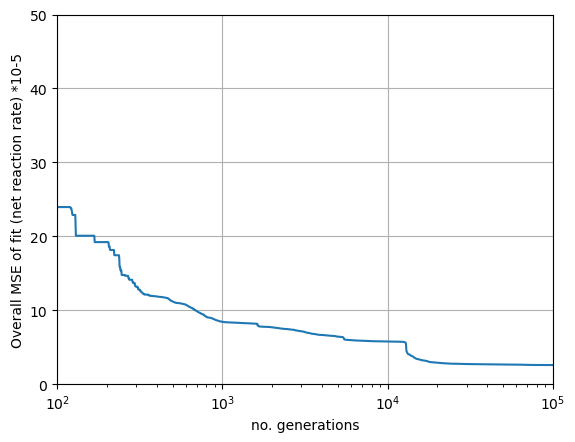

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.999999207369333
1.5996273161803718
0.9064426369014018
-4.197826946764883
0.4832208509184218
1.288425756506272e-06
0.39814423789006526
-5.306007177172133
0.3999784115570309
5.098318122325225
3.8631337766118836
3.9820113277419535
0.5830837458189747
0.029021695765886084
2.9926585795349903
1.2062299685850643e-07
0.3600006610826787
-11.595039680850853
1.8263900909595119
1.5450382439916768
-11.194745143103436
1.1440172313471273
3.725189414776602
0.050528462941856776
3.9702859149016896
4.257268376547954
1.501964531772377
8.69305242676932
-10.328649964319705
2.8935812852136045
1.7631039495545229
3.7438544680954386
-4.334702461644212
0.5581707476244436
1.0317099736801694
-1.3010299829744238


In [37]:
res.X

array([-1.19999992e+01,  1.59962732e+00,  9.06442637e-01, -4.19782695e+00,
        4.83220851e-01,  1.28842576e-06,  3.98144238e-01, -5.30600718e+00,
        3.99978412e-01,  5.09831812e+00,  3.86313378e+00,  3.98201133e+00,
        5.83083746e-01,  2.90216958e-02,  2.99265858e+00,  1.20622997e-07,
        3.60000661e-01, -1.15950397e+01,  1.82639009e+00,  1.54503824e+00,
       -1.11947451e+01,  1.14401723e+00,  3.72518941e+00,  5.05284629e-02,
        3.97028591e+00,  4.25726838e+00,  1.50196453e+00,  8.69305243e+00,
       -1.03286500e+01,  2.89358129e+00,  1.76310395e+00,  3.74385447e+00,
       -4.33470246e+00,  5.58170748e-01,  1.03170997e+00, -1.30102998e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )


-12.0: -11.999999207369333
1.6: 1.5996273161803718
0.9: 0.9064426369014018
-4.3: -4.197826946764883
0.5: 0.4832208509184218
0.003: 1.288425756506272e-06
0.4: 0.39814423789006526
-7.9: -5.306007177172133
0.7: 0.3999784115570309
7.2: 5.098318122325225
5.7: 3.8631337766118836
5.7: 3.9820113277419535
0.8: 0.5830837458189747
0.03: 0.029021695765886084
3.1: 2.9926585795349903
6.000000000000001e-09: 1.2062299685850643e-07
0.1: 0.3600006610826787
-12.0: -11.595039680850853
1.9: 1.8263900909595119
1.6: 1.5450382439916768
-11.6: -11.194745143103436
1.2: 1.1440172313471273
4.0: 3.725189414776602
0.01: 0.050528462941856776
4.2: 3.9702859149016896
5.4: 4.257268376547954
2.2: 1.501964531772377
11.8: 8.69305242676932
-12.0: -10.328649964319705
3.3: 2.8935812852136045
1.8: 1.7631039495545229
4.2: 3.7438544680954386
-4.0: -4.334702461644212
0.5: 0.5581707476244436
1.0: 1.0317099736801694
coeff fit: 0.9684053848831053
